In [1]:
# Required imports
import os.path
from typing import Dict, Tuple, Optional
import torch as th
import numpy as np

# Import modules from .py files
from equations import SystemEquations, compute_derivative, SecondOrderEquations, simpson_integral, FourthOrderEquations
from model import Configuration, Model
from modules import EquationsModel
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [ ]:
class KolmogorovConsecutive(FourthOrderEquations):

    def __init__(
        self,
        domain: Tuple[float, float],
        initial_conditions: Dict[str, Tuple[float, float]],
        boundary_type: str = "dirichlet"
    ):
        super().__init__("x", domain, initial_conditions, boundary_type="dirichlet")

    # RHS of the ODE ----------------------------------------------------
    def equation(self, x, y, z, w, t):
        return 3*np.pi*z + np.pi*np.sin(np.pi*x)

    # Action-augmented loss --------------------------------------------
    def calculate_loss(self, t: th.Tensor, nn_out: Dict[str, th.Tensor]) -> th.Tensor:

        # trial solutions & derivatives
        trial  = self.calculate_trial_solution(t, nn_out)
        x, y, z, w = trial["x"], trial["y"], trial["z"], trial["w"]
        x4 = compute_derivative(t, w) 

        mse_d = th.nn.MSELoss(reduction='sum')
        mse_dyn = mse_d(x4, 3*np.pi*z + np.pi*th.sin(np.pi*x))

        t_idx_0 = (t - 0).abs().argmin()
        x0_pred = x[t_idx_0]
        target_x0 = 0

        '''
        mask = (th.abs(t) > 2.5).view(-1)
        if mask.any():
            strip_penalty = th.relu(2.0 - th.abs(x[mask]))**2
            L_strip = strip_penalty.sum()                   # scalar
        else:
            L_strip = th.tensor(0.0, device=t.device)'''

        lagrangian = 0.5 * z**2 + (1.5)*np.pi*y**2 + 1 + th.cos(np.pi*x)
        action = th.trapz(lagrangian.view(-1), t.view(-1))

        total = mse_dyn + action + 1000000*(x0_pred - target_x0)**2

        return {"total": total, "dynamics": mse_dyn, "hamiltonian": mse_dyn}



def main():

    lr_grid      = [1e-4]
    coeffs_grid = [(1.0, 1.0, 1.0)]

    for lr in lr_grid:
        for _coeffs in coeffs_grid:
            boundary_type = "dirichlet"
            cfg = Configuration(
                seed=43365,
                features=[16, 16, 16],
                activation_function=th.nn.Tanh(),
                learning_rate=lr,
                epochs=800_000,
                steps=5_000,
            )

            system = KolmogorovConsecutive(
                domain=(-5, 5),
                initial_conditions={
                    "x": (-5, -1),   # x(-inf)
                    "y": (-5, 0),   # x'(.inf)
                    "z": (5, 1), # x(+inf)
                    "w": (5, 0), # x(+inf)
                },
                boundary_type = boundary_type
            )

            model = Model(
                name="KolmogorovConsecutivevFinal2",
                configuration=cfg,
                system_equations=system,
            )

            model.train()
            model.test4()


if __name__ == "__main__":
    main()

  0%|                                       | 3/800000 [00:00<20:16:06, 10.96it/s]

23239318865846.53


  0%|                                     | 103/800000 [00:07<15:06:43, 14.70it/s]

17894492553.072796


  0%|                                    | 201/800000 [00:22<118:53:45,  1.87it/s]

4438524165.534004


  0%|                                     | 303/800000 [00:34<15:14:55, 14.57it/s]

1402398171.726755


  0%|                                     | 403/800000 [00:40<14:43:08, 15.09it/s]

705472869.992586


  0%|                                     | 503/800000 [00:47<14:45:48, 15.04it/s]

427329313.2647458


  0%|                                     | 603/800000 [00:54<15:06:43, 14.69it/s]

271197877.38151115


  0%|                                     | 703/800000 [01:01<15:01:44, 14.77it/s]

178424855.95919442


  0%|                                     | 803/800000 [01:08<14:47:49, 15.00it/s]

121461530.44764107


  0%|                                     | 903/800000 [01:14<14:38:00, 15.17it/s]

85380047.57194087


  0%|                                    | 1002/800000 [01:22<15:10:20, 14.63it/s]

61791644.63348416


  0%|                                    | 1102/800000 [01:29<15:01:03, 14.78it/s]

45958245.49040817


  0%|                                    | 1202/800000 [01:35<15:06:59, 14.68it/s]

35182688.570064165


  0%|                                    | 1302/800000 [01:42<14:47:16, 15.00it/s]

27822876.763743058


  0%|                                    | 1402/800000 [01:49<15:06:01, 14.69it/s]

22724245.947656367


  0%|                                    | 1502/800000 [01:56<16:14:35, 13.66it/s]

19049892.008357663


  0%|                                    | 1602/800000 [02:03<15:06:16, 14.68it/s]

16312283.71656765


  0%|                                    | 1702/800000 [02:10<15:22:27, 14.42it/s]

14216711.10897611


  0%|                                    | 1802/800000 [02:17<15:13:40, 14.56it/s]

12575027.312788468


  0%|                                    | 1902/800000 [02:24<15:01:15, 14.76it/s]

11262650.021249495


  0%|                                    | 2002/800000 [02:31<14:55:00, 14.86it/s]

10194660.552619185


  0%|                                    | 2102/800000 [02:38<15:30:11, 14.30it/s]

9311718.66356406


  0%|                                    | 2202/800000 [02:45<15:26:13, 14.36it/s]

8571423.536545161


  0%|                                    | 2302/800000 [02:52<15:35:13, 14.22it/s]

7942864.954509521


  0%|                                    | 2402/800000 [02:59<14:55:30, 14.84it/s]

7403092.351529623


  0%|                                    | 2502/800000 [03:05<14:57:25, 14.81it/s]

6934782.553488392


  0%|                                    | 2602/800000 [03:12<15:59:16, 13.85it/s]

6524663.12050115


  0%|                                    | 2702/800000 [03:19<15:11:44, 14.57it/s]

6162430.700526787


  0%|▏                                   | 2802/800000 [03:26<15:13:28, 14.55it/s]

5839990.493094316


  0%|▏                                   | 2902/800000 [03:33<15:03:04, 14.71it/s]

5550915.310078791


  0%|▏                                   | 3002/800000 [03:40<15:08:27, 14.62it/s]

5290052.4009273015


  0%|▏                                   | 3102/800000 [03:47<15:09:46, 14.60it/s]

5053235.344707672


  0%|▏                                   | 3202/800000 [03:53<15:02:34, 14.71it/s]

4837067.952679452


  0%|▏                                   | 3302/800000 [04:00<15:09:28, 14.60it/s]

4638761.549423748


  0%|▏                                   | 3402/800000 [04:07<16:16:42, 13.59it/s]

4456009.209094209


  0%|▏                                   | 3502/800000 [04:14<15:07:11, 14.63it/s]

4286890.4720816575


  0%|▏                                   | 3602/800000 [04:21<14:45:05, 15.00it/s]

4129795.3202933497


  0%|▏                                   | 3702/800000 [04:28<15:27:30, 14.31it/s]

3983364.597258217


  0%|▏                                   | 3802/800000 [04:35<15:02:02, 14.71it/s]

3846443.842098563


  0%|▏                                   | 3902/800000 [04:41<15:11:21, 14.56it/s]

3718045.875555949


  1%|▏                                   | 4002/800000 [04:48<15:00:02, 14.74it/s]

3597320.3237789776


  1%|▏                                   | 4102/800000 [04:55<15:07:32, 14.62it/s]

3483530.4262460098


  1%|▏                                   | 4202/800000 [05:02<15:22:22, 14.38it/s]

3376032.5960477623


  1%|▏                                   | 4302/800000 [05:09<14:51:18, 14.88it/s]

3274261.268389408


  1%|▏                                   | 4402/800000 [05:16<14:43:59, 15.00it/s]

3177714.972344435


  1%|▏                                   | 4502/800000 [05:22<15:03:44, 14.67it/s]

3085945.8864824953


  1%|▏                                   | 4602/800000 [05:29<14:50:22, 14.89it/s]

2998550.1835247553


  1%|▏                                   | 4702/800000 [05:36<15:08:09, 14.60it/s]

2915160.253095454


  1%|▏                                   | 4802/800000 [05:43<14:52:36, 14.85it/s]

2835437.1641798


  1%|▏                                   | 4902/800000 [05:50<15:19:10, 14.42it/s]

2759055.267546364


  1%|▏                                   | 5002/800000 [05:57<15:01:14, 14.70it/s]

2685472.388697175


  1%|▏                                   | 5102/800000 [06:03<15:00:40, 14.71it/s]

2613675.3150935206


  1%|▏                                   | 5202/800000 [06:10<14:51:29, 14.86it/s]

2543371.3412231435


  1%|▏                                   | 5302/800000 [06:17<15:04:25, 14.64it/s]

2474460.563327834


  1%|▏                                   | 5402/800000 [06:24<14:58:40, 14.74it/s]

2406893.0715415343


  1%|▏                                   | 5502/800000 [06:31<14:43:24, 14.99it/s]

2340646.8125435966


  1%|▎                                   | 5602/800000 [06:38<15:06:41, 14.60it/s]

2275716.1937050046


  1%|▎                                   | 5702/800000 [06:44<15:13:55, 14.49it/s]

2212105.8437511427


  1%|▎                                   | 5802/800000 [06:51<14:56:53, 14.76it/s]

2149826.6994034634


  1%|▎                                   | 5902/800000 [06:58<15:15:18, 14.46it/s]

2088893.5242384707


  1%|▎                                   | 6002/800000 [07:05<15:00:40, 14.69it/s]

2029323.2497187075


  1%|▎                                   | 6102/800000 [07:12<14:53:58, 14.80it/s]

1971133.4753522703


  1%|▎                                   | 6202/800000 [07:19<15:02:08, 14.66it/s]

1914341.3950980832


  1%|▎                                   | 6302/800000 [07:25<15:27:39, 14.26it/s]

1858962.961511688


  1%|▎                                   | 6402/800000 [07:32<14:55:00, 14.78it/s]

1805011.9291033302


  1%|▎                                   | 6502/800000 [07:39<15:04:22, 14.62it/s]

1752499.32787889


  1%|▎                                   | 6602/800000 [07:46<14:45:15, 14.94it/s]

1701432.9064365705


  1%|▎                                   | 6702/800000 [07:53<15:07:56, 14.56it/s]

1651816.67818907


  1%|▎                                   | 6802/800000 [08:00<14:59:58, 14.69it/s]

1603650.7521603692


  1%|▎                                   | 6902/800000 [08:07<16:52:21, 13.06it/s]

1556931.063034798


  1%|▎                                   | 7002/800000 [08:14<14:54:14, 14.78it/s]

1511649.4236493318


  1%|▎                                   | 7102/800000 [08:20<14:58:23, 14.71it/s]

1467793.5448269227


  1%|▎                                   | 7202/800000 [08:27<14:57:02, 14.73it/s]

1425347.2092775987


  1%|▎                                   | 7302/800000 [08:34<14:59:43, 14.68it/s]

1384290.5395050142


  1%|▎                                   | 7402/800000 [08:41<15:17:35, 14.40it/s]

1344600.241278909


  1%|▎                                   | 7502/800000 [08:48<15:16:10, 14.42it/s]

1306250.0291175703


  1%|▎                                   | 7602/800000 [08:55<15:02:26, 14.63it/s]

1269211.008333956


  1%|▎                                   | 7702/800000 [09:02<15:15:10, 14.43it/s]

1233452.1019244913


  1%|▎                                   | 7802/800000 [09:08<15:03:01, 14.62it/s]

1198940.4242089149


  1%|▎                                   | 7902/800000 [09:15<14:42:54, 14.95it/s]

1165641.8096291139


  1%|▎                                   | 8002/800000 [09:22<14:43:33, 14.94it/s]

1133521.144239842


  1%|▎                                   | 8102/800000 [09:29<14:48:02, 14.86it/s]

1102542.7257451613


  1%|▎                                   | 8202/800000 [09:36<14:46:37, 14.88it/s]

1072669.8243305953


  1%|▎                                   | 8302/800000 [09:42<14:58:35, 14.68it/s]

1043780.188391323


  1%|▍                                   | 8402/800000 [09:49<14:49:23, 14.83it/s]

1015710.0999941515


  1%|▍                                   | 8502/800000 [09:56<15:04:33, 14.58it/s]

988412.987100363


  1%|▍                                   | 8602/800000 [10:03<15:17:02, 14.38it/s]

961856.5615624952


  1%|▍                                   | 8702/800000 [10:09<14:06:39, 15.58it/s]

936012.9823365698


  1%|▍                                   | 8802/800000 [10:16<13:56:35, 15.76it/s]

910862.5792917534


  1%|▍                                   | 8902/800000 [10:23<14:13:52, 15.44it/s]

885935.9111550478


  1%|▍                                   | 9002/800000 [10:29<14:10:01, 15.51it/s]

859813.9987723874


  1%|▍                                   | 9102/800000 [10:36<14:13:40, 15.44it/s]

832150.7105342213


  1%|▍                                   | 9202/800000 [10:42<14:34:07, 15.08it/s]

805083.5250414835


  1%|▍                                   | 9302/800000 [10:49<14:29:07, 15.16it/s]

780693.2511125188


  1%|▍                                   | 9402/800000 [10:56<14:21:36, 15.29it/s]

758614.2485565718


  1%|▍                                   | 9502/800000 [11:02<14:38:59, 14.99it/s]

738522.0576069447


  1%|▍                                   | 9602/800000 [11:09<15:16:08, 14.38it/s]

720130.6823177247


  1%|▍                                   | 9702/800000 [11:16<14:30:23, 15.13it/s]

703181.5883819996


  1%|▍                                   | 9802/800000 [11:23<14:45:32, 14.87it/s]

687441.4795608289


  1%|▍                                   | 9902/800000 [11:29<14:32:56, 15.09it/s]

672702.8566602666


  1%|▍                                  | 10002/800000 [11:36<14:38:44, 14.98it/s]

658784.4712374015


  1%|▍                                  | 10102/800000 [11:43<14:28:56, 15.15it/s]

645530.8069738278


  1%|▍                                  | 10202/800000 [11:49<14:51:56, 14.76it/s]

632810.5360216525


  1%|▍                                  | 10302/800000 [11:56<14:50:36, 14.78it/s]

620514.2893922857


  1%|▍                                  | 10402/800000 [12:03<14:35:33, 15.03it/s]

608552.1643948287


  1%|▍                                  | 10502/800000 [12:10<15:00:26, 14.61it/s]

596851.3079584374


  1%|▍                                  | 10602/800000 [12:17<14:48:47, 14.80it/s]

585353.6737243697


  1%|▍                                  | 10702/800000 [12:24<14:38:02, 14.98it/s]

574014.2349740907


  1%|▍                                  | 10802/800000 [12:30<14:33:05, 15.07it/s]

562799.5401219117


  1%|▍                                  | 10902/800000 [12:37<14:43:56, 14.88it/s]

551686.5360240678


  1%|▍                                  | 11002/800000 [12:44<14:43:20, 14.89it/s]

540661.6518953643


  1%|▍                                  | 11102/800000 [12:50<14:54:27, 14.70it/s]

529719.8158494793


  1%|▍                                  | 11202/800000 [12:57<14:55:51, 14.67it/s]

518863.5062711902


  1%|▍                                  | 11302/800000 [13:04<14:54:25, 14.70it/s]

508101.65084197413


  1%|▍                                  | 11402/800000 [13:11<15:01:26, 14.58it/s]

497448.47237662517


  1%|▌                                  | 11502/800000 [13:18<16:43:30, 13.10it/s]

486922.2682020001


  1%|▌                                  | 11602/800000 [13:25<14:51:50, 14.73it/s]

476544.16010052303


  1%|▌                                  | 11702/800000 [13:31<14:47:14, 14.81it/s]

466323.92979405663


  1%|▌                                  | 11802/800000 [13:38<14:47:33, 14.80it/s]

456247.90252801456


  1%|▌                                  | 11902/800000 [13:45<15:04:11, 14.53it/s]

446279.26257371384


  2%|▌                                  | 12002/800000 [13:52<15:06:34, 14.49it/s]

436400.5400865953


  2%|▌                                  | 12102/800000 [13:59<14:38:04, 14.96it/s]

426625.39763594384


  2%|▌                                  | 12202/800000 [14:06<15:03:03, 14.54it/s]

417185.45795424166


  2%|▌                                  | 12302/800000 [14:13<14:52:22, 14.71it/s]

407794.4793039167


  2%|▌                                  | 12402/800000 [14:19<14:57:07, 14.63it/s]

1015461189.9110184


  2%|▌                                  | 12502/800000 [14:26<14:49:38, 14.75it/s]

4080920.117280812


  2%|▌                                  | 12602/800000 [14:33<14:53:00, 14.70it/s]

3856971.9832595307


  2%|▌                                  | 12702/800000 [14:39<14:44:22, 14.84it/s]

3662712.609765741


  2%|▌                                  | 12802/800000 [14:46<14:47:18, 14.79it/s]

3484495.448491002


  2%|▌                                  | 12902/800000 [14:53<14:55:42, 14.65it/s]

3320062.4398372006


  2%|▌                                  | 13002/800000 [15:00<14:46:53, 14.79it/s]

3173995.5310577466


  2%|▌                                  | 13102/800000 [15:07<17:03:17, 12.82it/s]

3039800.822252552


  2%|▌                                  | 13202/800000 [15:14<14:35:13, 14.98it/s]

2916043.0598401036


  2%|▌                                  | 13302/800000 [15:20<14:37:45, 14.94it/s]

2807403.593013213


  2%|▌                                  | 13402/800000 [15:27<14:46:10, 14.79it/s]

2709828.8543352135


  2%|▌                                  | 13502/800000 [15:34<14:44:53, 14.81it/s]

2621295.1471476234


  2%|▌                                  | 13602/800000 [15:41<15:23:23, 14.19it/s]

2540587.540761454


  2%|▌                                  | 13702/800000 [15:48<14:29:14, 15.08it/s]

2466700.8367300695


  2%|▌                                  | 13802/800000 [15:55<14:54:15, 14.65it/s]

2398798.5042122495


  2%|▌                                  | 13902/800000 [16:02<14:51:10, 14.70it/s]

2336179.8551121587


  2%|▌                                  | 14002/800000 [16:08<15:02:48, 14.51it/s]

2278250.779980153


  2%|▌                                  | 14102/800000 [16:15<15:24:16, 14.17it/s]

2224498.68062096


  2%|▌                                  | 14202/800000 [16:22<14:45:33, 14.79it/s]

2174473.322585641


  2%|▋                                  | 14302/800000 [16:29<15:09:16, 14.40it/s]

2127772.795081497


  2%|▋                                  | 14402/800000 [16:36<14:43:46, 14.82it/s]

2084034.0730852154


  2%|▋                                  | 14502/800000 [16:43<14:55:03, 14.63it/s]

2042926.9685294349


  2%|▋                                  | 14602/800000 [16:50<15:07:36, 14.42it/s]

2004150.4104774152


  2%|▋                                  | 14702/800000 [16:56<14:52:51, 14.66it/s]

1967429.9155069538


  2%|▋                                  | 14802/800000 [17:03<14:27:56, 15.08it/s]

1932515.8744028134


  2%|▋                                  | 14902/800000 [17:10<14:29:51, 15.04it/s]

1899293.9943209137


  2%|▋                                  | 15002/800000 [17:17<14:50:19, 14.69it/s]

1867772.309519897


  2%|▋                                  | 15102/800000 [17:24<14:48:00, 14.73it/s]

1837625.9599738133


  2%|▋                                  | 15202/800000 [17:31<14:59:46, 14.54it/s]

1808510.4244751132


  2%|▋                                  | 15302/800000 [17:37<14:38:24, 14.89it/s]

1780123.1884780137


  2%|▋                                  | 15402/800000 [17:44<14:48:43, 14.71it/s]

1752223.0907866226


  2%|▋                                  | 15502/800000 [17:51<14:44:57, 14.77it/s]

1724631.1313950585


  2%|▋                                  | 15602/800000 [17:58<14:48:28, 14.71it/s]

1697220.6970825589


  2%|▋                                  | 15702/800000 [18:05<14:42:28, 14.81it/s]

1669903.8590221512


  2%|▋                                  | 15802/800000 [18:11<15:00:37, 14.51it/s]

1642618.4135815029


  2%|▋                                  | 15902/800000 [18:18<15:05:13, 14.44it/s]

1615317.2321110775


  2%|▋                                  | 16002/800000 [18:25<16:43:26, 13.02it/s]

1587960.477974926


  2%|▋                                  | 16102/800000 [18:32<14:46:14, 14.74it/s]

1560510.2059066107


  2%|▋                                  | 16202/800000 [18:39<14:40:08, 14.84it/s]

1532926.581977199


  2%|▋                                  | 16302/800000 [18:46<14:49:54, 14.68it/s]

1505165.819761209


  2%|▋                                  | 16402/800000 [18:53<14:49:07, 14.69it/s]

1477178.1796852278


  2%|▋                                  | 16502/800000 [18:59<15:03:05, 14.46it/s]

1448863.6399159385


  2%|▋                                  | 16602/800000 [19:06<16:49:53, 12.93it/s]

1420109.817153416


  2%|▋                                  | 16702/800000 [19:13<15:12:32, 14.31it/s]

1390966.8318817243


  2%|▋                                  | 16802/800000 [19:20<14:58:33, 14.53it/s]

1361645.6478265673


  2%|▋                                  | 16902/800000 [19:27<15:18:51, 14.20it/s]

1332484.3952101965


  2%|▋                                  | 17002/800000 [19:34<14:41:34, 14.80it/s]

1303844.955214234


  2%|▋                                  | 17102/800000 [19:41<14:46:29, 14.72it/s]

1276000.243734925


  2%|▊                                  | 17202/800000 [19:48<14:39:37, 14.83it/s]

1249085.8243031036


  2%|▊                                  | 17302/800000 [19:54<14:56:49, 14.55it/s]

1223121.0957153502


  2%|▊                                  | 17402/800000 [20:01<14:47:13, 14.70it/s]

1197752.0486831423


  2%|▊                                  | 17502/800000 [20:08<15:05:24, 14.40it/s]

1172274.9012310188


  2%|▊                                  | 17602/800000 [20:15<14:42:26, 14.78it/s]

1147519.7768528583


  2%|▊                                  | 17702/800000 [20:22<14:51:31, 14.62it/s]

1123368.8975894933


  2%|▊                                  | 17802/800000 [20:29<14:46:47, 14.70it/s]

1099668.1145280127


  2%|▊                                  | 17902/800000 [20:36<14:52:45, 14.60it/s]

1076280.2613346037


  2%|▊                                  | 18002/800000 [20:42<14:55:16, 14.56it/s]

1053091.6078714714


  2%|▊                                  | 18102/800000 [20:49<14:50:39, 14.63it/s]

1030011.0939486373


  2%|▊                                  | 18202/800000 [20:56<14:45:41, 14.71it/s]

1006966.1546970669


  2%|▊                                  | 18302/800000 [21:03<14:52:52, 14.59it/s]

983898.0236156768


  2%|▊                                  | 18402/800000 [21:10<14:50:29, 14.63it/s]

960757.3110065093


  2%|▊                                  | 18502/800000 [21:17<15:01:59, 14.44it/s]

937500.0342224147


  2%|▊                                  | 18602/800000 [21:24<15:06:48, 14.36it/s]

914083.5903646766


  2%|▊                                  | 18702/800000 [21:31<14:54:29, 14.56it/s]

890461.8212902284


  2%|▊                                  | 18802/800000 [21:38<14:46:04, 14.69it/s]

866578.3890157958


  2%|▊                                  | 18902/800000 [21:44<14:38:01, 14.83it/s]

842356.5080745013


  2%|▊                                  | 19002/800000 [21:51<14:54:23, 14.55it/s]

817680.9583191735


  2%|▊                                  | 19102/800000 [21:58<14:56:33, 14.52it/s]

783375.8050865345


  2%|▊                                  | 19202/800000 [22:05<15:01:15, 14.44it/s]

724718.4774525095


  2%|▊                                  | 19302/800000 [22:12<15:06:10, 14.36it/s]

704114.3741201223


  2%|▊                                  | 19402/800000 [22:19<14:42:29, 14.74it/s]

685657.7400020214


  2%|▊                                  | 19502/800000 [22:26<15:05:57, 14.36it/s]

667673.1383872298


  2%|▊                                  | 19602/800000 [22:33<14:52:08, 14.58it/s]

649671.9022132827


  2%|▊                                  | 19702/800000 [22:40<15:03:42, 14.39it/s]

631569.1486334685


  2%|▊                                  | 19802/800000 [22:46<14:50:44, 14.60it/s]

613511.2130442248


  2%|▊                                  | 19902/800000 [22:53<14:48:30, 14.63it/s]

595792.680364698


  3%|▉                                  | 20002/800000 [23:00<15:03:50, 14.38it/s]

578717.8521693463


  3%|▉                                  | 20102/800000 [23:07<15:08:00, 14.32it/s]

562502.5271788132


  3%|▉                                  | 20202/800000 [23:14<14:45:39, 14.67it/s]

547314.3820119663


  3%|▉                                  | 20302/800000 [23:21<14:38:04, 14.80it/s]

533074.8805269507


  3%|▉                                  | 20402/800000 [23:28<15:24:40, 14.05it/s]

519926.1245560947


  3%|▉                                  | 20502/800000 [23:35<14:28:15, 14.96it/s]

507740.93691516726


  3%|▉                                  | 20602/800000 [23:42<14:46:51, 14.65it/s]

496124.4206331221


  3%|▉                                  | 20702/800000 [23:48<15:02:41, 14.39it/s]

484892.20185762766


  3%|▉                                  | 20802/800000 [23:55<15:14:14, 14.20it/s]

474022.87061853294


  3%|▉                                  | 20902/800000 [24:02<14:41:21, 14.73it/s]

463608.5238866962


  3%|▉                                  | 21002/800000 [24:09<14:47:29, 14.63it/s]

453577.8529754058


  3%|▉                                  | 21102/800000 [24:16<14:59:14, 14.44it/s]

443852.1403993583


  3%|▉                                  | 21202/800000 [24:23<14:51:43, 14.56it/s]

434346.1979639355


  3%|▉                                  | 21302/800000 [24:30<15:06:24, 14.32it/s]

424991.65322025254


  3%|▉                                  | 21402/800000 [24:37<14:52:50, 14.53it/s]

415762.03724733234


  3%|▉                                  | 21502/800000 [24:44<14:53:00, 14.53it/s]

406645.1823018114


  3%|▉                                  | 21600/800000 [24:50<15:15:14, 14.17it/s]

397637.1477313466


  3%|▉                                  | 21702/800000 [24:58<15:05:43, 14.32it/s]

388738.9072905269


  3%|▉                                  | 21802/800000 [25:04<14:53:07, 14.52it/s]

379954.2155310104


  3%|▉                                  | 21902/800000 [25:11<14:49:12, 14.58it/s]

371288.23474356416


  3%|▉                                  | 22002/800000 [25:18<14:49:28, 14.58it/s]

362746.65321827336


  3%|▉                                  | 22102/800000 [25:25<15:02:28, 14.37it/s]

354335.13127165026


  3%|▉                                  | 22202/800000 [25:32<14:55:25, 14.48it/s]

346058.9497014761


  3%|▉                                  | 22302/800000 [25:39<14:43:42, 14.67it/s]

337922.7850731911


  3%|▉                                  | 22402/800000 [25:46<15:01:13, 14.38it/s]

329930.58065941767


  3%|▉                                  | 22502/800000 [25:53<14:47:59, 14.59it/s]

322085.45935806184


  3%|▉                                  | 22602/800000 [26:00<15:04:47, 14.32it/s]

314389.6905315574


  3%|▉                                  | 22702/800000 [26:07<15:12:16, 14.20it/s]

306844.6859625954


  3%|▉                                  | 22802/800000 [26:14<14:55:09, 14.47it/s]

299451.02502623334


  3%|█                                  | 22902/800000 [26:21<14:58:03, 14.42it/s]

292208.51092542376


  3%|█                                  | 23002/800000 [26:28<15:07:41, 14.27it/s]

285116.2466276778


  3%|█                                  | 23102/800000 [26:35<15:05:08, 14.31it/s]

278172.7410838368


  3%|█                                  | 23202/800000 [26:42<14:58:37, 14.41it/s]

271376.03747089073


  3%|█                                  | 23302/800000 [26:49<15:09:58, 14.23it/s]

264723.85780810047


  3%|█                                  | 23402/800000 [26:56<14:50:30, 14.53it/s]

258213.7661625371


  3%|█                                  | 23502/800000 [27:03<14:57:07, 14.43it/s]

251843.35044717693


  3%|█                                  | 23602/800000 [27:10<14:55:12, 14.45it/s]

245610.39586276468


  3%|█                                  | 23702/800000 [27:16<14:54:55, 14.46it/s]

239513.0697360436


  3%|█                                  | 23802/800000 [27:24<14:39:52, 14.70it/s]

233557.61269736808


  3%|█                                  | 23902/800000 [27:31<15:03:26, 14.32it/s]

9368372207.24456


  3%|█                                  | 24002/800000 [27:37<14:51:03, 14.51it/s]

3070356.6126579745


  3%|█                                  | 24102/800000 [27:44<14:46:20, 14.59it/s]

2895750.8120268043


  3%|█                                  | 24202/800000 [27:51<15:07:30, 14.25it/s]

2798212.1098966687


  3%|█                                  | 24302/800000 [27:58<14:50:28, 14.52it/s]

2712196.5016346024


  3%|█                                  | 24402/800000 [28:05<14:55:27, 14.44it/s]

2632467.603032453


  3%|█                                  | 24502/800000 [28:12<15:17:28, 14.09it/s]

2557255.6021386


  3%|█                                  | 24602/800000 [28:19<14:56:18, 14.42it/s]

2485825.4110370916


  3%|█                                  | 24702/800000 [28:26<14:58:03, 14.39it/s]

2417795.042710405


  3%|█                                  | 24802/800000 [28:33<14:55:18, 14.43it/s]

2352909.7105031074


  3%|█                                  | 24902/800000 [28:40<14:40:11, 14.68it/s]

2290962.0136388703


  3%|█                                  | 25002/800000 [28:47<15:06:02, 14.26it/s]

2231762.918021518


  3%|█                                  | 25102/800000 [28:54<14:43:58, 14.61it/s]

2175131.6558061913


  3%|█                                  | 25202/800000 [29:01<14:57:15, 14.39it/s]

2120893.1448961804


  3%|█                                  | 25302/800000 [29:08<14:56:52, 14.40it/s]

2068877.0197846764


  3%|█                                  | 25402/800000 [29:15<14:46:00, 14.57it/s]

2018919.6155893032


  3%|█                                  | 25502/800000 [29:22<15:11:24, 14.16it/s]

1970864.0831219682


  3%|█                                  | 25602/800000 [29:29<14:51:59, 14.47it/s]

1924561.9714039015


  3%|█                                  | 25702/800000 [29:36<15:25:32, 13.94it/s]

1879874.196913743


  3%|█▏                                 | 25802/800000 [29:43<15:00:33, 14.33it/s]

1836671.5946794287


  3%|█▏                                 | 25902/800000 [29:50<14:53:44, 14.44it/s]

1794835.5759911814


  3%|█▏                                 | 26002/800000 [29:57<15:03:26, 14.28it/s]

1754258.279044466


  3%|█▏                                 | 26102/800000 [30:04<14:49:38, 14.50it/s]

1714842.536358163


  3%|█▏                                 | 26202/800000 [30:11<15:07:00, 14.22it/s]

1676501.7644993367


  3%|█▏                                 | 26302/800000 [30:18<15:07:28, 14.21it/s]

1639159.3949711563


  3%|█▏                                 | 26402/800000 [30:25<14:48:17, 14.51it/s]

1602748.3471617345


  3%|█▏                                 | 26502/800000 [30:32<15:13:54, 14.11it/s]

1567210.2353881432


  3%|█▏                                 | 26602/800000 [30:39<15:32:37, 13.82it/s]

1532494.7532757798


  3%|█▏                                 | 26702/800000 [30:46<14:58:38, 14.34it/s]

1498558.6632624795


  3%|█▏                                 | 26802/800000 [30:53<14:40:45, 14.63it/s]

1465365.237035028


  3%|█▏                                 | 26902/800000 [31:00<15:35:14, 13.78it/s]

1432883.234490848


  3%|█▏                                 | 27002/800000 [31:07<15:15:36, 14.07it/s]

1401086.6129497774


  3%|█▏                                 | 27102/800000 [31:14<15:15:44, 14.07it/s]

1369953.535601869


  3%|█▏                                 | 27202/800000 [31:21<14:50:36, 14.46it/s]

1339465.8471467425


  3%|█▏                                 | 27302/800000 [31:28<14:57:28, 14.35it/s]

1309608.6804608447


  3%|█▏                                 | 27402/800000 [31:34<14:32:49, 14.75it/s]

1280370.0410539287


  3%|█▏                                 | 27502/800000 [31:41<15:02:35, 14.26it/s]

1251740.0492547383


  3%|█▏                                 | 27602/800000 [31:48<15:02:12, 14.27it/s]

1223710.942187855


  3%|█▏                                 | 27702/800000 [31:55<15:28:10, 13.87it/s]

1196276.515891401


  3%|█▏                                 | 27802/800000 [32:02<15:10:42, 14.13it/s]

1169431.7893909502


  3%|█▏                                 | 27902/800000 [32:09<14:52:07, 14.42it/s]

1143172.9222754724


  4%|█▏                                 | 28002/800000 [32:16<14:39:16, 14.63it/s]

1117496.7721220779


  4%|█▏                                 | 28102/800000 [32:23<15:12:41, 14.10it/s]

1092400.6922688875


  4%|█▏                                 | 28202/800000 [32:30<14:39:22, 14.63it/s]

1067882.4119989404


  4%|█▏                                 | 28302/800000 [32:37<14:59:20, 14.30it/s]

1043939.8031936319


  4%|█▏                                 | 28402/800000 [32:44<14:50:07, 14.45it/s]

1020570.7217224755


  4%|█▏                                 | 28502/800000 [32:51<14:55:26, 14.36it/s]

997772.8985965882


  4%|█▎                                 | 28602/800000 [32:58<14:57:48, 14.32it/s]

975543.8585353466


  4%|█▎                                 | 28702/800000 [33:05<14:36:12, 14.67it/s]

953880.7601871667


  4%|█▎                                 | 28802/800000 [33:12<16:44:44, 12.79it/s]

932780.3516233955


  4%|█▎                                 | 28902/800000 [33:19<14:54:05, 14.37it/s]

912238.9442854358


  4%|█▎                                 | 29002/800000 [33:26<15:07:05, 14.17it/s]

892252.283400215


  4%|█▎                                 | 29102/800000 [33:33<14:39:39, 14.61it/s]

872815.5316063059


  4%|█▎                                 | 29202/800000 [33:40<14:50:45, 14.42it/s]

853923.2642790087


  4%|█▎                                 | 29302/800000 [33:47<14:54:18, 14.36it/s]

835569.4215795358


  4%|█▎                                 | 29402/800000 [33:54<15:01:32, 14.25it/s]

817747.2858879264


  4%|█▎                                 | 29502/800000 [34:01<15:05:20, 14.18it/s]

800449.4578517128


  4%|█▎                                 | 29602/800000 [34:09<15:19:48, 13.96it/s]

783667.8967301071


  4%|█▎                                 | 29702/800000 [34:15<14:50:15, 14.42it/s]

767393.829516971


  4%|█▎                                 | 29802/800000 [34:22<15:02:26, 14.22it/s]

751617.8461790733


  4%|█▎                                 | 29902/800000 [34:29<14:54:06, 14.36it/s]

736329.8102492137


  4%|█▎                                 | 30002/800000 [34:36<14:52:40, 14.38it/s]

721518.8879287629


  4%|█▎                                 | 30102/800000 [34:43<14:47:59, 14.45it/s]

707173.4632422873


  4%|█▎                                 | 30202/800000 [34:50<15:07:19, 14.14it/s]

693280.7656930122


  4%|█▎                                 | 30302/800000 [34:58<15:05:10, 14.17it/s]

679794.825501024


  4%|█▎                                 | 30402/800000 [35:05<14:53:29, 14.36it/s]

666554.6306247571


  4%|█▎                                 | 30502/800000 [35:12<14:28:43, 14.76it/s]

653529.6122377475


  4%|█▎                                 | 30602/800000 [35:19<15:00:27, 14.24it/s]

640702.8094330817


  4%|█▎                                 | 30702/800000 [35:25<14:33:50, 14.67it/s]

628047.0336271442


  4%|█▎                                 | 30802/800000 [35:33<14:46:46, 14.46it/s]

615547.5885992389


  4%|█▎                                 | 30902/800000 [35:39<14:39:27, 14.58it/s]

603195.5001756133


  4%|█▎                                 | 31002/800000 [35:46<15:03:56, 14.18it/s]

590954.3077124695


  4%|█▎                                 | 31102/800000 [35:54<14:49:32, 14.41it/s]

578621.7052108072


  4%|█▎                                 | 31202/800000 [36:01<14:49:52, 14.40it/s]

566070.6540770971


  4%|█▎                                 | 31302/800000 [36:08<15:11:07, 14.06it/s]

553261.1396098922


  4%|█▎                                 | 31402/800000 [36:15<15:04:17, 14.17it/s]

540313.2796675601


  4%|█▍                                 | 31502/800000 [36:22<14:57:38, 14.27it/s]

527223.3770479874


  4%|█▍                                 | 31602/800000 [36:29<14:33:11, 14.67it/s]

513989.3400422216


  4%|█▍                                 | 31702/800000 [36:36<14:55:52, 14.29it/s]

500625.8771847058


  4%|█▍                                 | 31802/800000 [36:43<15:07:18, 14.11it/s]

487158.01723635674


  4%|█▍                                 | 31902/800000 [36:50<15:09:19, 14.08it/s]

473621.1797101826


  4%|█▍                                 | 32002/800000 [36:57<15:10:24, 14.06it/s]

460061.3470955241


  4%|█▍                                 | 32102/800000 [37:04<15:03:02, 14.17it/s]

446534.90117522894


  4%|█▍                                 | 32202/800000 [37:11<14:57:42, 14.25it/s]

433107.77828029497


  4%|█▍                                 | 32302/800000 [37:18<14:49:47, 14.38it/s]

419853.76693916746


  4%|█▍                                 | 32402/800000 [37:25<14:44:17, 14.47it/s]

406851.77467005205


  4%|█▍                                 | 32502/800000 [37:32<15:01:25, 14.19it/s]

394182.23118933215


  4%|█▍                                 | 32602/800000 [37:39<15:00:44, 14.20it/s]

381922.8636833747


  4%|█▍                                 | 32702/800000 [37:46<14:58:13, 14.24it/s]

370144.28650201584


  4%|█▍                                 | 32802/800000 [37:53<14:57:54, 14.24it/s]

358905.8872098771


  4%|█▍                                 | 32902/800000 [38:00<14:43:35, 14.47it/s]

348251.94523649995


  4%|█▍                                 | 33002/800000 [38:07<15:16:50, 13.94it/s]

338132.1775094165


  4%|█▍                                 | 33102/800000 [38:14<14:49:30, 14.37it/s]

328375.79285583406


  4%|█▍                                 | 33202/800000 [38:21<15:10:15, 14.04it/s]

318928.89133825834


  4%|█▍                                 | 33302/800000 [38:28<15:01:34, 14.17it/s]

309770.6801951892


  4%|█▍                                 | 33402/800000 [38:35<14:58:46, 14.22it/s]

300895.97967111366


  4%|█▍                                 | 33502/800000 [38:42<15:23:52, 13.83it/s]

292307.04605067027


  4%|█▍                                 | 33602/800000 [38:50<14:59:19, 14.20it/s]

284008.85087567073


  4%|█▍                                 | 33702/800000 [38:56<14:40:40, 14.50it/s]

276006.505316993


  4%|█▍                                 | 33802/800000 [39:04<14:46:42, 14.40it/s]

268303.8770462952


  4%|█▍                                 | 33902/800000 [39:11<15:26:27, 13.78it/s]

260902.83124789392


  4%|█▍                                 | 34002/800000 [39:18<15:03:18, 14.13it/s]

253802.77173541457


  4%|█▍                                 | 34102/800000 [39:25<15:00:31, 14.17it/s]

247000.10457364246


  4%|█▍                                 | 34202/800000 [39:32<14:48:55, 14.36it/s]

240487.0893686492


  4%|█▌                                 | 34302/800000 [39:39<14:52:07, 14.30it/s]

234254.13792206507


  4%|█▌                                 | 34402/800000 [39:46<15:04:24, 14.11it/s]

228289.15225880875


  4%|█▌                                 | 34502/800000 [39:54<14:55:19, 14.25it/s]

222576.94259236206


  4%|█▌                                 | 34602/800000 [40:01<14:58:31, 14.20it/s]

217099.11982647397


  4%|█▌                                 | 34702/800000 [40:08<15:02:54, 14.13it/s]

211833.95941479327


  4%|█▌                                 | 34802/800000 [40:15<14:49:50, 14.33it/s]

206755.83987906243


  4%|█▌                                 | 34902/800000 [40:22<14:59:40, 14.17it/s]

201833.57422856468


  4%|█▌                                 | 35002/800000 [40:29<14:56:01, 14.23it/s]

197028.0664802129


  4%|█▌                                 | 35102/800000 [40:36<14:57:11, 14.21it/s]

192299.63580802295


  4%|█▌                                 | 35202/800000 [40:43<14:52:51, 14.28it/s]

187629.10954456366


  4%|█▌                                 | 35302/800000 [40:50<15:14:53, 13.93it/s]

183012.38641263384


  4%|█▌                                 | 35402/800000 [40:57<15:07:09, 14.05it/s]

178449.544078019


  4%|█▌                                 | 35502/800000 [41:04<14:56:03, 14.22it/s]

173942.29530402282


  4%|█▌                                 | 35602/800000 [41:12<14:46:12, 14.38it/s]

169493.24644531304


  4%|█▌                                 | 35702/800000 [41:19<14:56:43, 14.21it/s]

165105.6952326186


  4%|█▌                                 | 35802/800000 [41:26<14:40:08, 14.47it/s]

160783.57289252558


  4%|█▌                                 | 35902/800000 [41:33<15:14:07, 13.93it/s]

156531.3935248446


  5%|█▌                                 | 36002/800000 [41:40<15:02:26, 14.11it/s]

152354.15249073625


  5%|█▌                                 | 36102/800000 [41:47<14:56:19, 14.20it/s]

148257.1643973372


  5%|█▌                                 | 36202/800000 [41:54<15:06:35, 14.04it/s]

144245.86067035983


  5%|█▌                                 | 36302/800000 [42:01<14:42:30, 14.42it/s]

140325.56617952557


  5%|█▌                                 | 36402/800000 [42:08<16:37:14, 12.76it/s]

136501.28091439971


  5%|█▌                                 | 36502/800000 [42:15<14:47:48, 14.33it/s]

132777.49279061944


  5%|█▌                                 | 36602/800000 [42:22<15:04:53, 14.06it/s]

129158.037355286


  5%|█▌                                 | 36702/800000 [42:30<14:49:30, 14.30it/s]

125645.9869848697


  5%|█▌                                 | 36802/800000 [42:37<15:03:01, 14.09it/s]

122243.59403624316


  5%|█▌                                 | 36902/800000 [42:44<14:48:10, 14.32it/s]

118952.25906844514


  5%|█▌                                 | 37002/800000 [42:51<14:56:46, 14.18it/s]

115772.54084057709


  5%|█▌                                 | 37102/800000 [42:58<14:56:49, 14.18it/s]

112704.1648563077


  5%|█▋                                 | 37202/800000 [43:05<14:54:00, 14.22it/s]

109746.07560732868


  5%|█▋                                 | 37302/800000 [43:12<16:16:35, 13.02it/s]

106896.49948540772


  5%|█▋                                 | 37402/800000 [43:19<14:41:56, 14.41it/s]

104153.02565409556


  5%|█▋                                 | 37502/800000 [43:27<15:27:55, 13.70it/s]

101512.69445812923


  5%|█▋                                 | 37602/800000 [43:34<14:42:31, 14.40it/s]

821363333.7825667


  5%|█▋                                 | 37702/800000 [43:41<15:00:48, 14.10it/s]

2303253.466293036


  5%|█▋                                 | 37802/800000 [43:48<14:45:40, 14.34it/s]

1901215.1833881927


  5%|█▋                                 | 37902/800000 [43:55<15:18:15, 13.83it/s]

1752356.381838715


  5%|█▋                                 | 38002/800000 [44:02<15:50:34, 13.36it/s]

1668489.0727927533


  5%|█▋                                 | 38102/800000 [44:09<14:52:30, 14.23it/s]

1604841.4572097715


  5%|█▋                                 | 38202/800000 [44:16<15:10:57, 13.94it/s]

1545875.830713708


  5%|█▋                                 | 38302/800000 [44:23<14:48:48, 14.28it/s]

1490558.6006643623


  5%|█▋                                 | 38402/800000 [44:31<15:13:16, 13.90it/s]

1438388.149124044


  5%|█▋                                 | 38502/800000 [44:38<14:52:18, 14.22it/s]

1388994.2717998321


  5%|█▋                                 | 38602/800000 [44:45<15:05:40, 14.01it/s]

1342097.5938934216


  5%|█▋                                 | 38702/800000 [44:52<14:50:28, 14.25it/s]

1297486.4798117878


  5%|█▋                                 | 38802/800000 [45:00<15:12:37, 13.90it/s]

1255000.8384065717


  5%|█▋                                 | 38902/800000 [45:07<15:37:22, 13.53it/s]

1214519.9136447366


  5%|█▋                                 | 39002/800000 [45:14<14:28:27, 14.60it/s]

1175952.713437273


  5%|█▋                                 | 39102/800000 [45:21<14:51:54, 14.22it/s]

1139228.3523230879


  5%|█▋                                 | 39202/800000 [45:28<15:26:22, 13.69it/s]

1104285.882372024


  5%|█▋                                 | 39302/800000 [45:35<14:47:09, 14.29it/s]

1071063.7954220949


  5%|█▋                                 | 39402/800000 [45:42<14:41:56, 14.37it/s]

1039490.0486387374


  5%|█▋                                 | 39502/800000 [45:49<14:44:41, 14.33it/s]

1009474.8761239274


  5%|█▋                                 | 39602/800000 [45:56<14:57:20, 14.12it/s]

980907.3784299756


  5%|█▋                                 | 39702/800000 [46:04<15:10:51, 13.91it/s]

953657.0422791481


  5%|█▋                                 | 39802/800000 [46:11<14:52:45, 14.19it/s]

927580.0963971063


  5%|█▋                                 | 39902/800000 [46:18<14:43:55, 14.33it/s]

902529.164932641


  5%|█▊                                 | 40002/800000 [46:25<14:46:08, 14.29it/s]

878364.229274792


  5%|█▊                                 | 40102/800000 [46:32<15:08:17, 13.94it/s]

854962.10917493


  5%|█▊                                 | 40202/800000 [46:39<14:47:34, 14.27it/s]

832222.657949897


  5%|█▊                                 | 40302/800000 [46:46<14:54:07, 14.16it/s]

810070.8935890633


  5%|█▊                                 | 40402/800000 [46:53<15:04:22, 14.00it/s]

788455.740826118


  5%|█▊                                 | 40502/800000 [47:00<14:54:33, 14.15it/s]

767346.4467360972


  5%|█▊                                 | 40602/800000 [47:07<15:14:22, 13.84it/s]

746728.2801098041


  5%|█▊                                 | 40702/800000 [47:15<14:56:19, 14.12it/s]

726598.2408416515


  5%|█▊                                 | 40802/800000 [47:22<14:53:21, 14.16it/s]

706961.1996350448


  5%|█▊                                 | 40902/800000 [47:29<14:42:31, 14.34it/s]

687826.898276907


  5%|█▊                                 | 41002/800000 [47:36<15:01:02, 14.04it/s]

669207.6362873666


  5%|█▊                                 | 41102/800000 [47:43<15:07:56, 13.93it/s]

651116.5540927075


  5%|█▊                                 | 41202/800000 [47:50<14:56:32, 14.11it/s]

633566.3429332863


  5%|█▊                                 | 41302/800000 [47:57<15:05:18, 13.97it/s]

616568.4260869086


  5%|█▊                                 | 41402/800000 [48:04<15:08:43, 13.91it/s]

600132.3123084557


  5%|█▊                                 | 41502/800000 [48:11<14:59:58, 14.05it/s]

584265.1733613814


  5%|█▊                                 | 41602/800000 [48:18<14:47:58, 14.23it/s]

568971.6391422132


  5%|█▊                                 | 41702/800000 [48:25<15:12:47, 13.85it/s]

554253.6348590667


  5%|█▊                                 | 41802/800000 [48:33<15:38:59, 13.46it/s]

540110.3748396079


  5%|█▊                                 | 41902/800000 [48:40<14:49:40, 14.20it/s]

526538.4361626976


  5%|█▊                                 | 42002/800000 [48:47<14:41:55, 14.32it/s]

513531.8521525337


  5%|█▊                                 | 42102/800000 [48:54<14:50:25, 14.19it/s]

501082.2845964937


  5%|█▊                                 | 42202/800000 [49:01<14:59:17, 14.04it/s]

489179.07475917344


  5%|█▊                                 | 42302/800000 [49:09<14:47:05, 14.24it/s]

477808.66433556605


  5%|█▊                                 | 42402/800000 [49:16<15:09:31, 13.88it/s]

466883.8587101599


  5%|█▊                                 | 42502/800000 [49:23<15:00:21, 14.02it/s]

456306.10971799446


  5%|█▊                                 | 42602/800000 [49:30<14:35:08, 14.42it/s]

446079.51666336093


  5%|█▊                                 | 42702/800000 [49:37<14:53:32, 14.13it/s]

436209.83064453286


  5%|█▊                                 | 42802/800000 [49:44<14:54:32, 14.11it/s]

426699.8492920711


  5%|█▉                                 | 42902/800000 [49:51<14:42:16, 14.30it/s]

417549.1767898063


  5%|█▉                                 | 43002/800000 [49:58<14:50:59, 14.16it/s]

408754.32483046403


  5%|█▉                                 | 43102/800000 [50:05<14:50:36, 14.16it/s]

400309.07151520235


  5%|█▉                                 | 43202/800000 [50:13<14:45:19, 14.25it/s]

392204.89187013666


  5%|█▉                                 | 43302/800000 [50:20<14:57:41, 14.05it/s]

384431.4845153852


  5%|█▉                                 | 43402/800000 [50:27<14:45:01, 14.25it/s]

376977.2077220003


  5%|█▉                                 | 43502/800000 [50:34<14:47:01, 14.21it/s]

369829.48214509105


  5%|█▉                                 | 43602/800000 [50:41<14:54:08, 14.10it/s]

362975.0910045923


  5%|█▉                                 | 43702/800000 [50:48<14:58:19, 14.03it/s]

356400.376426185


  5%|█▉                                 | 43802/800000 [50:55<14:30:44, 14.47it/s]

350091.38751269656


  5%|█▉                                 | 43902/800000 [51:02<15:07:40, 13.88it/s]

344033.9209345181


  6%|█▉                                 | 44002/800000 [51:09<14:43:54, 14.25it/s]

338213.4738715385


  6%|█▉                                 | 44102/800000 [51:16<14:44:57, 14.24it/s]

332588.8863005859


  6%|█▉                                 | 44202/800000 [51:23<14:44:33, 14.24it/s]

326936.8446163446


  6%|█▉                                 | 44302/800000 [51:30<14:52:00, 14.12it/s]

321045.9920878083


  6%|█▉                                 | 44402/800000 [51:37<15:24:02, 13.63it/s]

314756.0487623537


  6%|█▉                                 | 44502/800000 [51:45<15:14:06, 13.77it/s]

307949.2912951936


  6%|█▉                                 | 44602/800000 [51:52<14:56:26, 14.04it/s]

300606.6845559798


  6%|█▉                                 | 44702/800000 [51:59<14:44:44, 14.23it/s]

292865.89596212475


  6%|█▉                                 | 44802/800000 [52:06<16:21:08, 12.83it/s]

285439.10318878986


  6%|█▉                                 | 44902/800000 [52:13<15:01:54, 13.95it/s]

278648.7086765146


  6%|█▉                                 | 45002/800000 [52:20<14:58:01, 14.01it/s]

271984.80953061226


  6%|█▉                                 | 45102/800000 [52:27<14:44:51, 14.22it/s]

265382.8278276304


  6%|█▉                                 | 45202/800000 [52:34<14:37:59, 14.33it/s]

258818.71763980656


  6%|█▉                                 | 45302/800000 [52:42<14:35:08, 14.37it/s]

252289.51699449998


  6%|█▉                                 | 45402/800000 [52:49<14:57:42, 14.01it/s]

245807.8169667773


  6%|█▉                                 | 45502/800000 [52:56<14:56:39, 14.02it/s]

239397.40740106656


  6%|█▉                                 | 45602/800000 [53:03<14:57:00, 14.02it/s]

233089.55173379404


  6%|█▉                                 | 45702/800000 [53:10<14:47:11, 14.17it/s]

226919.68013796295


  6%|██                                 | 45802/800000 [53:17<14:45:57, 14.19it/s]

220924.4289940085


  6%|██                                 | 45902/800000 [53:24<14:40:19, 14.28it/s]

215138.93743383233


  6%|██                                 | 46002/800000 [53:31<15:04:33, 13.89it/s]

209589.73966198726


  6%|██                                 | 46102/800000 [53:38<14:55:05, 14.04it/s]

204235.5526339992


  6%|██                                 | 46202/800000 [53:45<14:46:31, 14.17it/s]

199043.84147183207


  6%|██                                 | 46302/800000 [53:52<14:31:23, 14.42it/s]

194003.64452912114


  6%|██                                 | 46402/800000 [54:00<14:30:55, 14.42it/s]

189107.40664524614


  6%|██                                 | 46502/800000 [54:07<15:38:18, 13.38it/s]

184349.99583112597


  6%|██                                 | 46602/800000 [54:14<14:51:55, 14.08it/s]

179727.81087046265


  6%|██                                 | 46702/800000 [54:21<14:37:04, 14.31it/s]

175238.02528415006


  6%|██                                 | 46802/800000 [54:28<15:21:32, 13.62it/s]

170878.03914476276


  6%|██                                 | 46902/800000 [54:35<14:46:30, 14.16it/s]

166645.1190639727


  6%|██                                 | 47002/800000 [54:42<14:41:32, 14.24it/s]

162536.23923365635


  6%|██                                 | 47102/800000 [54:49<14:51:05, 14.08it/s]

158548.00663802485


  6%|██                                 | 47202/800000 [54:56<14:41:15, 14.24it/s]

154676.62662638488


  6%|██                                 | 47302/800000 [55:03<14:44:44, 14.18it/s]

150914.28176068715


  6%|██                                 | 47402/800000 [55:10<14:45:39, 14.16it/s]

147252.390288742


  6%|██                                 | 47502/800000 [55:17<14:40:09, 14.25it/s]

143688.19281329628


  6%|██                                 | 47602/800000 [55:24<14:46:08, 14.15it/s]

140220.21410847595


  6%|██                                 | 47702/800000 [55:32<14:34:59, 14.33it/s]

136847.31371893527


  6%|██                                 | 47802/800000 [55:39<14:31:19, 14.39it/s]

133568.37208088412


  6%|██                                 | 47902/800000 [55:46<14:51:23, 14.06it/s]

130382.1978198539


  6%|██                                 | 48002/800000 [55:53<14:48:59, 14.10it/s]

127287.54159678219


  6%|██                                 | 48102/800000 [56:00<14:27:16, 14.45it/s]

124283.16659751262


  6%|██                                 | 48202/800000 [56:07<14:53:58, 14.02it/s]

121367.91047434554


  6%|██                                 | 48302/800000 [56:14<14:30:20, 14.39it/s]

118540.74304380546


  6%|██                                 | 48402/800000 [56:21<14:47:16, 14.12it/s]

115800.80900523314


  6%|██                                 | 48502/800000 [56:28<15:15:32, 13.68it/s]

113147.40487222733


  6%|██▏                                | 48602/800000 [56:35<14:36:02, 14.30it/s]

110579.96149581892


  6%|██▏                                | 48702/800000 [56:42<14:34:58, 14.31it/s]

108097.94287113077


  6%|██▏                                | 48802/800000 [56:49<14:44:44, 14.15it/s]

105700.73965264957


  6%|██▏                                | 48902/800000 [56:56<14:46:00, 14.13it/s]

103387.53324181786


  6%|██▏                                | 49002/800000 [57:03<14:30:23, 14.38it/s]

101157.12736309995


  6%|██▏                                | 49102/800000 [57:10<14:36:37, 14.28it/s]

99007.8243871848


  6%|██▏                                | 49202/800000 [57:17<14:50:28, 14.05it/s]

96937.28471756092


  6%|██▏                                | 49302/800000 [57:24<14:31:50, 14.35it/s]

94942.47098146705


  6%|██▏                                | 49402/800000 [57:31<15:06:49, 13.80it/s]

93019.62712413471


  6%|██▏                                | 49502/800000 [57:38<14:06:08, 14.78it/s]

91164.3184054179


  6%|██▏                                | 49602/800000 [57:45<14:27:42, 14.41it/s]

89371.55930444962


  6%|██▏                                | 49702/800000 [57:52<14:28:07, 14.40it/s]

87635.96008044975


  6%|██▏                                | 49802/800000 [57:59<14:27:14, 14.42it/s]

85951.90813060343


  6%|██▏                                | 49902/800000 [58:06<16:27:03, 12.67it/s]

84313.77723242446


  6%|██▏                                | 50002/800000 [58:13<14:56:12, 13.95it/s]

82716.10632550012


  6%|██▏                                | 50102/800000 [58:20<14:23:33, 14.47it/s]

81153.74653268624


  6%|██▏                                | 50202/800000 [58:27<14:18:15, 14.56it/s]

79622.00040015687


  6%|██▏                                | 50302/800000 [58:34<14:30:02, 14.36it/s]

78116.73258625128


  6%|██▏                                | 50402/800000 [58:41<14:52:12, 14.00it/s]

76634.45892363183


  6%|██▏                                | 50502/800000 [58:48<14:43:34, 14.14it/s]

75172.52178850182


  6%|██▏                                | 50602/800000 [58:55<14:33:04, 14.31it/s]

73729.19849217383


  6%|██▏                                | 50702/800000 [59:02<14:30:59, 14.34it/s]

72303.74699509946


  6%|██▏                                | 50802/800000 [59:09<14:22:56, 14.47it/s]

70896.0903463643


  6%|██▏                                | 50902/800000 [59:16<14:32:24, 14.31it/s]

69506.3914517137


  6%|██▏                                | 51002/800000 [59:23<14:31:04, 14.33it/s]

68134.76909175287


  6%|██▏                                | 51102/800000 [59:30<14:08:15, 14.71it/s]

66781.25545049828


  6%|██▏                                | 51202/800000 [59:37<14:57:30, 13.91it/s]

65445.83424373611


  6%|██▏                                | 51302/800000 [59:44<14:11:36, 14.65it/s]

64128.459473668525


  6%|██▏                                | 51402/800000 [59:51<14:06:56, 14.73it/s]

62829.077455669445


  6%|██▎                                | 51502/800000 [59:58<14:40:41, 14.16it/s]

61547.66277222908


  6%|██▏                              | 51602/800000 [1:00:04<14:07:37, 14.72it/s]

315730160.5598476


  6%|██▏                              | 51702/800000 [1:00:12<14:34:07, 14.27it/s]

489035.76276220084


  6%|██▏                              | 51802/800000 [1:00:19<14:30:34, 14.32it/s]

454475.1784312493


  6%|██▏                              | 51902/800000 [1:00:25<14:34:43, 14.25it/s]

443857.84253413207


  7%|██▏                              | 52002/800000 [1:00:32<14:50:32, 14.00it/s]

437657.446653292


  7%|██▏                              | 52102/800000 [1:00:40<14:36:04, 14.23it/s]

431500.775393075


  7%|██▏                              | 52202/800000 [1:00:47<14:24:00, 14.42it/s]

425355.5664897252


  7%|██▏                              | 52302/800000 [1:00:54<14:26:57, 14.37it/s]

419228.583871949


  7%|██▏                              | 52402/800000 [1:01:00<14:28:00, 14.35it/s]

413127.200332679


  7%|██▏                              | 52502/800000 [1:01:08<14:25:07, 14.40it/s]

407058.6428810608


  7%|██▏                              | 52602/800000 [1:01:15<14:35:11, 14.23it/s]

401029.86842955445


  7%|██▏                              | 52702/800000 [1:01:22<14:28:08, 14.35it/s]

395047.40281461336


  7%|██▏                              | 52802/800000 [1:01:29<14:25:25, 14.39it/s]

389117.1932555787


  7%|██▏                              | 52902/800000 [1:01:36<14:31:32, 14.29it/s]

383244.5295321495


  7%|██▏                              | 53002/800000 [1:01:43<14:09:36, 14.65it/s]

377433.9069616182


  7%|██▏                              | 53102/800000 [1:01:49<14:11:24, 14.62it/s]

371689.0040518404


  7%|██▏                              | 53202/800000 [1:01:56<14:31:44, 14.28it/s]

366012.6943859486


  7%|██▏                              | 53302/800000 [1:02:03<14:20:10, 14.47it/s]

360407.0384380927


  7%|██▏                              | 53402/800000 [1:02:10<14:32:47, 14.26it/s]

354873.4322926968


  7%|██▏                              | 53502/800000 [1:02:17<14:20:47, 14.45it/s]

349412.74082234775


  7%|██▏                              | 53602/800000 [1:02:24<14:15:39, 14.54it/s]

344025.44692375493


  7%|██▏                              | 53702/800000 [1:02:31<14:33:09, 14.25it/s]

338711.902893422


  7%|██▏                              | 53802/800000 [1:02:38<14:27:48, 14.33it/s]

333472.4978943664


  7%|██▏                              | 53902/800000 [1:02:45<14:35:32, 14.20it/s]

328307.91413022653


  7%|██▏                              | 54002/800000 [1:02:52<14:22:11, 14.42it/s]

323219.21119318344


  7%|██▏                              | 54102/800000 [1:02:59<14:26:03, 14.35it/s]

318208.001861491


  7%|██▏                              | 54202/800000 [1:03:06<15:49:10, 13.10it/s]

313276.4990945707


  7%|██▏                              | 54302/800000 [1:03:13<14:58:49, 13.83it/s]

308427.4954122512


  7%|██▏                              | 54402/800000 [1:03:20<14:16:50, 14.50it/s]

303664.3214853651


  7%|██▏                              | 54502/800000 [1:03:27<14:03:52, 14.72it/s]

298990.7224521347


  7%|██▎                              | 54602/800000 [1:03:34<14:06:10, 14.68it/s]

294410.7156053058


  7%|██▎                              | 54702/800000 [1:03:41<15:17:10, 13.54it/s]

289928.4180451217


  7%|██▎                              | 54802/800000 [1:03:48<14:09:04, 14.63it/s]

285547.8394137898


  7%|██▎                              | 54902/800000 [1:03:55<14:18:18, 14.47it/s]

281272.7417872309


  7%|██▎                              | 55002/800000 [1:04:02<14:14:07, 14.54it/s]

277106.5085352587


  7%|██▎                              | 55102/800000 [1:04:09<14:19:03, 14.45it/s]

273052.3988407313


  7%|██▎                              | 55202/800000 [1:04:16<14:24:16, 14.36it/s]

269116.27494585153


  7%|██▎                              | 55302/800000 [1:04:23<14:17:28, 14.47it/s]

265319.10561772506


  7%|██▎                              | 55402/800000 [1:04:30<14:13:12, 14.55it/s]

261631.17302893713


  7%|██▎                              | 55502/800000 [1:04:37<14:38:30, 14.12it/s]

258019.89370997233


  7%|██▎                              | 55602/800000 [1:04:44<14:23:09, 14.37it/s]

254480.47221930497


  7%|██▎                              | 55702/800000 [1:04:51<14:33:45, 14.20it/s]

251014.46770353155


  7%|██▎                              | 55802/800000 [1:04:58<14:11:47, 14.56it/s]

247625.69294670774


  7%|██▎                              | 55902/800000 [1:05:05<14:17:18, 14.47it/s]

244318.9498533564


  7%|██▎                              | 56002/800000 [1:05:12<14:27:40, 14.29it/s]

241099.47059823357


  7%|██▎                              | 56102/800000 [1:05:19<14:30:18, 14.25it/s]

237972.58453227745


  7%|██▎                              | 56202/800000 [1:05:26<14:14:47, 14.50it/s]

234943.49569524892


  7%|██▎                              | 56302/800000 [1:05:33<14:12:24, 14.54it/s]

232017.09983961165


  7%|██▎                              | 56402/800000 [1:05:40<14:18:41, 14.43it/s]

229197.83121719563


  7%|██▎                              | 56502/800000 [1:05:46<14:35:28, 14.15it/s]

226489.50032466918


  7%|██▎                              | 56602/800000 [1:05:53<14:20:30, 14.40it/s]

223895.07341484237


  7%|██▎                              | 56702/800000 [1:06:00<14:22:41, 14.36it/s]

221413.94727992459


  7%|██▎                              | 56802/800000 [1:06:08<14:20:04, 14.40it/s]

219028.37766452806


  7%|██▎                              | 56902/800000 [1:06:15<14:23:10, 14.35it/s]

216722.01448955567


  7%|██▎                              | 57002/800000 [1:06:22<14:21:15, 14.38it/s]

214486.12955571167


  7%|██▎                              | 57102/800000 [1:06:29<14:29:38, 14.24it/s]

212315.7104011434


  7%|██▎                              | 57202/800000 [1:06:36<14:31:07, 14.21it/s]

210207.4061077874


  7%|██▎                              | 57302/800000 [1:06:43<14:34:57, 14.15it/s]

208158.40733136417


  7%|██▎                              | 57402/800000 [1:06:50<14:31:14, 14.21it/s]

206165.8762914849


  7%|██▎                              | 57502/800000 [1:06:57<14:37:13, 14.11it/s]

204226.67738310702


  7%|██▍                              | 57602/800000 [1:07:04<14:41:48, 14.03it/s]

202337.19370736415


  7%|██▍                              | 57702/800000 [1:07:11<14:30:28, 14.21it/s]

200485.9439321296


  7%|██▍                              | 57802/800000 [1:07:18<14:13:59, 14.48it/s]

198653.00329645298


  7%|██▍                              | 57902/800000 [1:07:25<14:25:47, 14.29it/s]

196834.80766756675


  7%|██▍                              | 58002/800000 [1:07:32<14:38:03, 14.08it/s]

195031.34195022506


  7%|██▍                              | 58102/800000 [1:07:39<14:37:51, 14.09it/s]

193242.9509323587


  7%|██▍                              | 58202/800000 [1:07:47<14:49:45, 13.90it/s]

191470.00673685127


  7%|██▍                              | 58302/800000 [1:07:54<14:22:26, 14.33it/s]

189712.8014283126


  7%|██▍                              | 58402/800000 [1:08:01<14:49:37, 13.89it/s]

187971.50108454953


  7%|██▍                              | 58502/800000 [1:08:08<14:22:25, 14.33it/s]

186246.09145974516


  7%|██▍                              | 58602/800000 [1:08:15<14:15:30, 14.44it/s]

184536.02426338653


  7%|██▍                              | 58702/800000 [1:08:22<14:30:37, 14.19it/s]

182831.0342051438


  7%|██▍                              | 58802/800000 [1:08:29<14:26:19, 14.26it/s]

181111.87305981643


  7%|██▍                              | 58902/800000 [1:08:36<14:28:19, 14.22it/s]

179352.28848357472


  7%|██▍                              | 59002/800000 [1:08:43<14:52:02, 13.84it/s]

177498.73447277703


  7%|██▍                              | 59102/800000 [1:08:50<14:41:09, 14.01it/s]

175405.41388723772


  7%|██▍                              | 59202/800000 [1:08:58<14:38:23, 14.06it/s]

172530.01251942042


  7%|██▍                              | 59302/800000 [1:09:05<14:36:05, 14.09it/s]

166696.16852909277


  7%|██▍                              | 59402/800000 [1:09:12<14:32:22, 14.15it/s]

158747.7634396134


  7%|██▍                              | 59502/800000 [1:09:19<14:24:58, 14.27it/s]

153600.01827342977


  7%|██▍                              | 59602/800000 [1:09:26<14:39:25, 14.03it/s]

149847.92059627565


  7%|██▍                              | 59702/800000 [1:09:33<14:36:18, 14.08it/s]

146811.810486793


  7%|██▍                              | 59802/800000 [1:09:40<14:29:09, 14.19it/s]

144224.18718691467


  7%|██▍                              | 59902/800000 [1:09:47<14:43:01, 13.97it/s]

141939.25444921775


  8%|██▍                              | 60002/800000 [1:09:54<14:42:51, 13.97it/s]

139859.96418119853


  8%|██▍                              | 60102/800000 [1:10:02<14:39:39, 14.02it/s]

137917.6646920983


  8%|██▍                              | 60202/800000 [1:10:09<14:36:09, 14.07it/s]

136063.80937920214


  8%|██▍                              | 60302/800000 [1:10:16<14:17:18, 14.38it/s]

134264.54263945355


  8%|██▍                              | 60402/800000 [1:10:23<14:28:49, 14.19it/s]

132496.57916869622


  8%|██▍                              | 60502/800000 [1:10:30<14:19:04, 14.35it/s]

130744.08946596194


  8%|██▍                              | 60602/800000 [1:10:37<14:37:53, 14.04it/s]

128996.44759965639


  8%|██▌                              | 60702/800000 [1:10:44<14:24:21, 14.26it/s]

127246.62386481898


  8%|██▌                              | 60802/800000 [1:10:51<14:29:15, 14.17it/s]

125490.05387875631


  8%|██▌                              | 60902/800000 [1:10:58<14:47:28, 13.88it/s]

123723.84112114536


  8%|██▌                              | 61002/800000 [1:11:05<14:35:06, 14.07it/s]

121946.19934268646


  8%|██▌                              | 61102/800000 [1:11:12<15:37:13, 13.14it/s]

120156.05759394591


  8%|██▌                              | 61202/800000 [1:11:20<14:26:18, 14.21it/s]

118352.78405042758


  8%|██▌                              | 61302/800000 [1:11:27<14:21:27, 14.29it/s]

116535.99791454246


  8%|██▌                              | 61402/800000 [1:11:34<14:42:28, 13.95it/s]

114705.4467117173


  8%|██▌                              | 61502/800000 [1:11:41<14:03:39, 14.59it/s]

112860.93294978765


  8%|██▌                              | 61602/800000 [1:11:48<14:11:38, 14.45it/s]

111002.27261416562


  8%|██▌                              | 61702/800000 [1:11:55<14:49:18, 13.84it/s]

109129.28091379948


  8%|██▌                              | 61802/800000 [1:12:02<13:48:59, 14.84it/s]

107241.77692941169


  8%|██▌                              | 61900/800000 [1:12:08<14:08:37, 14.50it/s]

105339.60166806048


  8%|██▌                              | 62002/800000 [1:12:16<14:03:46, 14.58it/s]

103422.64606703659


  8%|██▌                              | 62102/800000 [1:12:23<14:14:55, 14.39it/s]

101490.88685051071


  8%|██▌                              | 62202/800000 [1:12:30<16:00:04, 12.81it/s]

99544.42837389823


  8%|██▌                              | 62302/800000 [1:12:37<14:38:20, 14.00it/s]

97583.55122085947


  8%|██▌                              | 62402/800000 [1:12:44<14:20:51, 14.28it/s]

95608.76509502184


  8%|██▌                              | 62502/800000 [1:12:51<14:19:46, 14.30it/s]

93620.86934561766


  8%|██▌                              | 62602/800000 [1:12:58<14:09:33, 14.47it/s]

91621.01302783586


  8%|██▌                              | 62702/800000 [1:13:05<14:13:26, 14.40it/s]

89610.76150439022


  8%|██▌                              | 62802/800000 [1:13:12<15:15:45, 13.42it/s]

87592.16192434246


  8%|██▌                              | 62902/800000 [1:13:19<13:53:50, 14.73it/s]

85567.80675648262


  8%|██▌                              | 63002/800000 [1:13:26<13:58:46, 14.64it/s]

83540.8866906474


  8%|██▌                              | 63102/800000 [1:13:33<14:03:08, 14.57it/s]

81515.2350521451


  8%|██▌                              | 63202/800000 [1:13:40<13:43:30, 14.91it/s]

79495.36107136423


  8%|██▌                              | 63302/800000 [1:13:46<13:36:18, 15.04it/s]

77486.47024720366


  8%|██▌                              | 63402/800000 [1:13:53<13:48:20, 14.82it/s]

75494.46970400287


  8%|██▌                              | 63502/800000 [1:14:00<13:32:56, 15.10it/s]

73525.97686618322


  8%|██▌                              | 63602/800000 [1:14:06<16:21:50, 12.50it/s]

71588.29611623664


  8%|██▋                              | 63702/800000 [1:14:13<13:32:27, 15.10it/s]

69689.3803206836


  8%|██▋                              | 63802/800000 [1:14:20<13:35:38, 15.04it/s]

67837.71248519247


  8%|██▋                              | 63902/800000 [1:14:26<13:31:09, 15.12it/s]

66042.09299197905


  8%|██▋                              | 64002/800000 [1:14:33<13:32:56, 15.09it/s]

64311.283580701056


  8%|██▋                              | 64102/800000 [1:14:40<13:49:05, 14.79it/s]

62653.51087495452


  8%|██▋                              | 64202/800000 [1:14:46<13:45:30, 14.86it/s]

61075.85194524589


  8%|██▋                              | 64302/800000 [1:14:53<13:45:43, 14.85it/s]

59583.57142076331


  8%|██▋                              | 64402/800000 [1:15:00<13:41:34, 14.92it/s]

58179.556800779064


  8%|██▋                              | 64502/800000 [1:15:07<14:24:11, 14.18it/s]

56863.942598663874


  8%|██▋                              | 64602/800000 [1:15:13<13:44:28, 14.87it/s]

55634.03051409961


  8%|██▋                              | 64702/800000 [1:15:20<13:39:01, 14.96it/s]

54484.542993536365


  8%|██▋                              | 64802/800000 [1:15:27<13:35:25, 15.03it/s]

53408.15047918298


  8%|██▋                              | 64902/800000 [1:15:33<13:50:34, 14.75it/s]

52396.17126389584


  8%|██▋                              | 65002/800000 [1:15:40<13:47:58, 14.80it/s]

51439.31343861451


  8%|██▋                              | 65102/800000 [1:15:47<13:54:35, 14.68it/s]

50528.33733261718


  8%|██▋                              | 65202/800000 [1:15:54<13:46:32, 14.82it/s]

49654.595979860576


  8%|██▋                              | 65302/800000 [1:16:01<15:15:18, 13.38it/s]

48810.368046993935


  8%|██▋                              | 65402/800000 [1:16:08<14:05:28, 14.48it/s]

598368426.7261683


  8%|██▋                              | 65502/800000 [1:16:15<13:44:18, 14.85it/s]

369024.8227203157


  8%|██▋                              | 65602/800000 [1:16:22<13:55:58, 14.64it/s]

279382.29180145415


  8%|██▋                              | 65702/800000 [1:16:28<13:56:42, 14.63it/s]

237868.1399733551


  8%|██▋                              | 65802/800000 [1:16:35<13:51:37, 14.71it/s]

208819.58474458454


  8%|██▋                              | 65902/800000 [1:16:42<13:42:37, 14.87it/s]

186015.76634846747


  8%|██▋                              | 66002/800000 [1:16:49<13:58:22, 14.59it/s]

167683.17988808345


  8%|██▋                              | 66102/800000 [1:16:56<13:44:38, 14.83it/s]

153100.22349154777


  8%|██▋                              | 66202/800000 [1:17:02<13:34:36, 15.01it/s]

141746.8907382074


  8%|██▋                              | 66302/800000 [1:17:09<14:11:32, 14.36it/s]

133088.04368294156


  8%|██▋                              | 66402/800000 [1:17:16<13:36:09, 14.98it/s]

126572.70536778856


  8%|██▋                              | 66502/800000 [1:17:23<13:53:20, 14.67it/s]

121691.77083199224


  8%|██▋                              | 66602/800000 [1:17:29<13:53:30, 14.66it/s]

118019.6373800978


  8%|██▊                              | 66702/800000 [1:17:36<13:24:42, 15.19it/s]

115225.12626790209


  8%|██▊                              | 66802/800000 [1:17:43<13:49:31, 14.73it/s]

113062.38004819921


  8%|██▊                              | 66900/800000 [1:17:50<13:52:34, 14.68it/s]

111354.17438857224


  8%|██▊                              | 67002/800000 [1:17:57<13:41:43, 14.87it/s]

109975.00112294994


  8%|██▊                              | 67102/800000 [1:18:04<13:22:39, 15.22it/s]

108836.81575705305


  8%|██▊                              | 67202/800000 [1:18:11<13:57:09, 14.59it/s]

107877.8906216109


  8%|██▊                              | 67302/800000 [1:18:17<13:52:01, 14.68it/s]

107037.4775586672


  8%|██▊                              | 67402/800000 [1:18:24<13:43:30, 14.83it/s]

106239.59015023512


  8%|██▊                              | 67502/800000 [1:18:31<13:40:16, 14.88it/s]

105447.49686600878


  8%|██▊                              | 67602/800000 [1:18:38<13:47:59, 14.74it/s]

104641.49559379379


  8%|██▊                              | 67702/800000 [1:18:44<13:51:45, 14.67it/s]

103804.77951267957


  8%|██▊                              | 67802/800000 [1:18:51<13:54:04, 14.63it/s]

102919.61508889495


  8%|██▊                              | 67902/800000 [1:18:58<14:06:06, 14.42it/s]

101966.22039016479


  9%|██▊                              | 68002/800000 [1:19:05<13:39:01, 14.90it/s]

100922.46731717352


  9%|██▊                              | 68102/800000 [1:19:12<13:34:16, 14.98it/s]

99764.1896378252


  9%|██▊                              | 68202/800000 [1:19:19<13:48:17, 14.72it/s]

98466.45893079278


  9%|██▊                              | 68302/800000 [1:19:25<13:43:27, 14.81it/s]

97006.53255561877


  9%|██▊                              | 68402/800000 [1:19:32<13:47:32, 14.73it/s]

95369.23795979487


  9%|██▊                              | 68502/800000 [1:19:39<13:39:04, 14.88it/s]

93554.87464219418


  9%|██▊                              | 68602/800000 [1:19:46<13:57:08, 14.56it/s]

91587.62914580734


  9%|██▊                              | 68702/800000 [1:19:53<13:47:54, 14.72it/s]

89519.45252476465


  9%|██▊                              | 68802/800000 [1:19:59<13:33:21, 14.98it/s]

87423.62198750593


  9%|██▊                              | 68902/800000 [1:20:06<15:18:01, 13.27it/s]

85377.75645016697


  9%|██▊                              | 69002/800000 [1:20:13<13:48:22, 14.71it/s]

83444.86710995939


  9%|██▊                              | 69102/800000 [1:20:20<13:41:47, 14.82it/s]

81662.86639772705


  9%|██▊                              | 69202/800000 [1:20:27<13:41:45, 14.82it/s]

80045.31914323996


  9%|██▊                              | 69302/800000 [1:20:33<13:50:35, 14.66it/s]

78588.64373337627


  9%|██▊                              | 69402/800000 [1:20:40<13:49:48, 14.67it/s]

77378.43282085624


  9%|██▊                              | 69502/800000 [1:20:47<13:50:29, 14.66it/s]

76428.38831090866


  9%|██▊                              | 69602/800000 [1:20:54<13:46:06, 14.74it/s]

75575.76496400216


  9%|██▉                              | 69702/800000 [1:21:01<14:04:37, 14.41it/s]

74766.23670635527


  9%|██▉                              | 69802/800000 [1:21:08<13:43:24, 14.78it/s]

73980.79627590299


  9%|██▉                              | 69902/800000 [1:21:14<13:44:05, 14.77it/s]

73211.61198239158


  9%|██▉                              | 70002/800000 [1:21:21<13:36:45, 14.90it/s]

72454.87484656517


  9%|██▉                              | 70102/800000 [1:21:28<14:10:27, 14.30it/s]

71708.48538992186


  9%|██▉                              | 70202/800000 [1:21:35<13:35:29, 14.92it/s]

70971.19693588019


  9%|██▉                              | 70302/800000 [1:21:42<13:31:45, 14.98it/s]

70242.25374071041


  9%|██▉                              | 70402/800000 [1:21:48<13:33:10, 14.95it/s]

69521.20881129663


  9%|██▉                              | 70502/800000 [1:21:55<14:31:05, 13.96it/s]

68807.80572333529


  9%|██▉                              | 70602/800000 [1:22:02<13:46:32, 14.71it/s]

68101.89491958728


  9%|██▉                              | 70702/800000 [1:22:09<13:39:12, 14.84it/s]

67403.35147501821


  9%|██▉                              | 70802/800000 [1:22:16<13:43:56, 14.75it/s]

66712.01355735674


  9%|██▉                              | 70902/800000 [1:22:22<13:44:25, 14.74it/s]

66027.6337086015


  9%|██▉                              | 71002/800000 [1:22:29<13:45:58, 14.71it/s]

65349.83648824534


  9%|██▉                              | 71102/800000 [1:22:36<13:35:59, 14.89it/s]

64678.0978756085


  9%|██▉                              | 71202/800000 [1:22:43<14:01:08, 14.44it/s]

64011.73003990891


  9%|██▉                              | 71302/800000 [1:22:50<13:59:45, 14.46it/s]

63349.88472614872


  9%|██▉                              | 71402/800000 [1:22:56<13:48:14, 14.66it/s]

62691.556035325106


  9%|██▉                              | 71502/800000 [1:23:03<13:47:59, 14.66it/s]

62035.59324846788


  9%|██▉                              | 71602/800000 [1:23:10<13:41:24, 14.78it/s]

61380.71038230235


  9%|██▉                              | 71702/800000 [1:23:17<13:35:50, 14.88it/s]

60725.47987006965


  9%|██▉                              | 71802/800000 [1:23:24<13:50:54, 14.61it/s]

60067.57691816928


  9%|██▉                              | 71902/800000 [1:23:31<13:51:31, 14.59it/s]

59400.34926284977


  9%|██▉                              | 72002/800000 [1:23:38<14:39:13, 13.80it/s]

58719.461941743786


  9%|██▉                              | 72102/800000 [1:23:44<13:40:09, 14.79it/s]

58023.340234363015


  9%|██▉                              | 72202/800000 [1:23:51<14:05:30, 14.35it/s]

57311.75750695888


  9%|██▉                              | 72302/800000 [1:23:58<13:51:32, 14.59it/s]

56585.46211521824


  9%|██▉                              | 72402/800000 [1:24:05<13:57:26, 14.48it/s]

55846.20503598696


  9%|██▉                              | 72502/800000 [1:24:12<13:37:01, 14.84it/s]

55103.5900867011


  9%|██▉                              | 72602/800000 [1:24:19<13:46:03, 14.68it/s]

54400.442700604566


  9%|██▉                              | 72702/800000 [1:24:25<13:52:49, 14.55it/s]

53803.43467934346


  9%|███                              | 72802/800000 [1:24:32<13:41:40, 14.75it/s]

53334.35393092728


  9%|███                              | 72902/800000 [1:24:39<13:43:43, 14.71it/s]

52966.144971581656


  9%|███                              | 73002/800000 [1:24:46<13:49:12, 14.61it/s]

52666.169405139764


  9%|███                              | 73102/800000 [1:24:53<13:35:47, 14.85it/s]

52410.66463700479


  9%|███                              | 73202/800000 [1:25:00<13:51:09, 14.57it/s]

52183.349587103185


  9%|███                              | 73302/800000 [1:25:06<14:23:04, 14.03it/s]

51973.07810691016


  9%|███                              | 73402/800000 [1:25:13<13:32:01, 14.91it/s]

51772.37159019286


  9%|███                              | 73502/800000 [1:25:20<13:59:56, 14.42it/s]

51576.29676828347


  9%|███                              | 73602/800000 [1:25:27<14:03:41, 14.35it/s]

51381.64909334101


  9%|███                              | 73702/800000 [1:25:34<13:49:24, 14.59it/s]

51186.32108452669


  9%|███                              | 73802/800000 [1:25:41<13:36:23, 14.83it/s]

50988.87608362317


  9%|███                              | 73902/800000 [1:25:48<13:45:18, 14.66it/s]

50788.27270804079


  9%|███                              | 74002/800000 [1:25:55<13:26:27, 15.00it/s]

50583.682483377255


  9%|███                              | 74102/800000 [1:26:01<13:47:38, 14.62it/s]

50374.38873293544


  9%|███                              | 74202/800000 [1:26:08<13:37:04, 14.80it/s]

50159.74210299185


  9%|███                              | 74302/800000 [1:26:15<14:04:38, 14.32it/s]

49939.106234501625


  9%|███                              | 74402/800000 [1:26:22<13:50:50, 14.56it/s]

49711.861146641444


  9%|███                              | 74502/800000 [1:26:29<13:56:24, 14.46it/s]

49477.39726825345


  9%|███                              | 74602/800000 [1:26:36<13:45:35, 14.64it/s]

49235.10133341742


  9%|███                              | 74702/800000 [1:26:42<13:47:56, 14.60it/s]

48984.364586094925


  9%|███                              | 74802/800000 [1:26:49<13:55:55, 14.46it/s]

48724.58494891947


  9%|███                              | 74902/800000 [1:26:56<13:42:27, 14.69it/s]

48455.1687712824


  9%|███                              | 75002/800000 [1:27:03<13:32:48, 14.87it/s]

48175.53398509872


  9%|███                              | 75102/800000 [1:27:10<13:43:42, 14.67it/s]

47885.11071813885


  9%|███                              | 75202/800000 [1:27:17<13:23:42, 15.03it/s]

47583.34457819898


  9%|███                              | 75302/800000 [1:27:23<13:40:17, 14.72it/s]

47269.70110417763


  9%|███                              | 75402/800000 [1:27:30<13:30:44, 14.90it/s]

46943.67157423973


  9%|███                              | 75502/800000 [1:27:37<13:42:49, 14.68it/s]

46604.77591998742


  9%|███                              | 75602/800000 [1:27:44<13:36:42, 14.78it/s]

46252.572810470665


  9%|███                              | 75702/800000 [1:27:50<13:27:06, 14.96it/s]

45886.67208387628


  9%|███▏                             | 75802/800000 [1:27:57<13:50:09, 14.54it/s]

45506.7438008884


  9%|███▏                             | 75902/800000 [1:28:04<13:28:44, 14.92it/s]

45112.534314635355


 10%|███▏                             | 76002/800000 [1:28:11<13:29:08, 14.91it/s]

44703.894509524056


 10%|███▏                             | 76102/800000 [1:28:17<13:26:27, 14.96it/s]

44280.800405311355


 10%|███▏                             | 76202/800000 [1:28:24<13:42:24, 14.67it/s]

43843.384672834945


 10%|███▏                             | 76302/800000 [1:28:31<13:50:41, 14.52it/s]

43391.96651943479


 10%|███▏                             | 76402/800000 [1:28:38<13:48:37, 14.55it/s]

42927.08222781253


 10%|███▏                             | 76502/800000 [1:28:45<13:50:36, 14.52it/s]

42449.53389772615


 10%|███▏                             | 76602/800000 [1:28:52<13:50:59, 14.51it/s]

41960.417614132144


 10%|███▏                             | 76702/800000 [1:28:58<13:24:27, 14.99it/s]

41461.14535159148


 10%|███▏                             | 76802/800000 [1:29:05<13:35:09, 14.79it/s]

40953.45700826174


 10%|███▏                             | 76902/800000 [1:29:12<13:27:05, 14.93it/s]

40439.42719355764


 10%|███▏                             | 77002/800000 [1:29:19<13:28:04, 14.91it/s]

39921.42803076837


 10%|███▏                             | 77102/800000 [1:29:26<13:46:05, 14.58it/s]

39402.06440617414


 10%|███▏                             | 77202/800000 [1:29:33<13:37:45, 14.73it/s]

38884.07578613449


 10%|███▏                             | 77302/800000 [1:29:39<13:38:07, 14.72it/s]

38370.22129096128


 10%|███▏                             | 77402/800000 [1:29:46<13:58:04, 14.37it/s]

37863.12320909004


 10%|███▏                             | 77502/800000 [1:29:53<13:49:09, 14.52it/s]

37365.11184584889


 10%|███▏                             | 77602/800000 [1:30:00<13:42:28, 14.64it/s]

36878.07809956189


 10%|███▏                             | 77702/800000 [1:30:07<13:55:16, 14.41it/s]

36403.37372392281


 10%|███▏                             | 77802/800000 [1:30:14<13:36:48, 14.74it/s]

35941.748898000464


 10%|███▏                             | 77902/800000 [1:30:21<13:34:20, 14.78it/s]

35493.349287518264


 10%|███▏                             | 78002/800000 [1:30:27<13:32:12, 14.82it/s]

35057.76764504101


 10%|███▏                             | 78102/800000 [1:30:34<13:45:56, 14.57it/s]

34634.141689038544


 10%|███▏                             | 78202/800000 [1:30:41<13:31:35, 14.82it/s]

34221.28141217699


 10%|███▏                             | 78302/800000 [1:30:48<14:32:42, 13.78it/s]

33817.7974089087


 10%|███▏                             | 78402/800000 [1:30:55<13:37:26, 14.71it/s]

33422.21599166856


 10%|███▏                             | 78502/800000 [1:31:02<13:31:36, 14.82it/s]

33033.079886711865


 10%|███▏                             | 78602/800000 [1:31:09<13:30:24, 14.84it/s]

32649.033243632006


 10%|███▏                             | 78702/800000 [1:31:15<13:25:19, 14.93it/s]

32268.865566936973


 10%|███▎                             | 78802/800000 [1:31:22<13:34:55, 14.75it/s]

158774872053.0216


 10%|███▎                             | 78902/800000 [1:31:29<13:59:17, 14.32it/s]

853643.8743897781


 10%|███▎                             | 79002/800000 [1:31:36<13:18:44, 15.04it/s]

630114.9623544501


 10%|███▎                             | 79102/800000 [1:31:42<13:22:53, 14.96it/s]

578533.7061346492


 10%|███▎                             | 79202/800000 [1:31:49<13:36:54, 14.71it/s]

536329.5085717131


 10%|███▎                             | 79302/800000 [1:31:56<13:49:11, 14.49it/s]

500485.46380736964


 10%|███▎                             | 79402/800000 [1:32:03<13:31:13, 14.80it/s]

469136.66182082146


 10%|███▎                             | 79502/800000 [1:32:10<13:41:43, 14.61it/s]

441098.681551335


 10%|███▎                             | 79602/800000 [1:32:17<13:28:17, 14.85it/s]

415609.8190703254


 10%|███▎                             | 79702/800000 [1:32:23<13:34:56, 14.73it/s]

392180.0995516131


 10%|███▎                             | 79802/800000 [1:32:30<13:36:06, 14.71it/s]

370498.07391870115


 10%|███▎                             | 79902/800000 [1:32:37<13:37:39, 14.68it/s]

350369.53154163866


 10%|███▎                             | 80002/800000 [1:32:44<13:26:27, 14.88it/s]

331675.18807790126


 10%|███▎                             | 80102/800000 [1:32:50<13:38:57, 14.65it/s]

314341.70638534194


 10%|███▎                             | 80202/800000 [1:32:57<13:44:45, 14.55it/s]

298321.77816067607


 10%|███▎                             | 80302/800000 [1:33:04<13:37:27, 14.67it/s]

283579.08576612314


 10%|███▎                             | 80402/800000 [1:33:11<13:42:12, 14.59it/s]

270075.15073388285


 10%|███▎                             | 80502/800000 [1:33:18<13:16:47, 15.05it/s]

257759.40364175028


 10%|███▎                             | 80602/800000 [1:33:24<13:19:27, 15.00it/s]

246565.66478199285


 10%|███▎                             | 80702/800000 [1:33:31<13:41:44, 14.59it/s]

236415.19185723757


 10%|███▎                             | 80802/800000 [1:33:38<13:22:54, 14.93it/s]

227222.44168532483


 10%|███▎                             | 80902/800000 [1:33:45<13:43:11, 14.56it/s]

218899.6544357258


 10%|███▎                             | 81002/800000 [1:33:51<13:28:29, 14.82it/s]

211357.12429210573


 10%|███▎                             | 81102/800000 [1:33:58<13:25:53, 14.87it/s]

204377.64683578478


 10%|███▎                             | 81202/800000 [1:34:05<13:37:30, 14.65it/s]

197718.55125128114


 10%|███▎                             | 81302/800000 [1:34:12<13:28:57, 14.81it/s]

191314.45829725306


 10%|███▎                             | 81402/800000 [1:34:19<13:14:49, 15.07it/s]

185130.6053253123


 10%|███▎                             | 81502/800000 [1:34:26<13:23:37, 14.90it/s]

179128.78147119167


 10%|███▎                             | 81602/800000 [1:34:32<13:27:26, 14.83it/s]

173291.57783779415


 10%|███▎                             | 81702/800000 [1:34:39<13:28:28, 14.81it/s]

167618.55834067124


 10%|███▎                             | 81802/800000 [1:34:46<13:35:22, 14.68it/s]

162112.09256966156


 10%|███▍                             | 81902/800000 [1:34:53<13:35:06, 14.68it/s]

156775.28481241758


 10%|███▍                             | 82002/800000 [1:35:00<13:42:30, 14.55it/s]

151611.27181637252


 10%|███▍                             | 82102/800000 [1:35:06<14:06:41, 14.13it/s]

146622.8272926466


 10%|███▍                             | 82202/800000 [1:35:13<13:31:40, 14.74it/s]

141812.15505968433


 10%|███▍                             | 82302/800000 [1:35:20<13:20:40, 14.94it/s]

137180.77122906316


 10%|███▍                             | 82402/800000 [1:35:27<13:27:03, 14.82it/s]

132729.47501102003


 10%|███▍                             | 82502/800000 [1:35:34<13:25:14, 14.85it/s]

128458.33727543402


 10%|███▍                             | 82602/800000 [1:35:40<13:29:09, 14.78it/s]

124366.78155809801


 10%|███▍                             | 82702/800000 [1:35:47<13:21:03, 14.92it/s]

120453.6321076296


 10%|███▍                             | 82802/800000 [1:35:54<13:20:02, 14.94it/s]

116717.20641005799


 10%|███▍                             | 82902/800000 [1:36:01<13:30:35, 14.74it/s]

113155.41339472483


 10%|███▍                             | 83002/800000 [1:36:07<13:18:45, 14.96it/s]

109765.81044157837


 10%|███▍                             | 83102/800000 [1:36:14<13:39:51, 14.57it/s]

106545.6714796166


 10%|███▍                             | 83202/800000 [1:36:21<13:35:21, 14.65it/s]

103492.0376607103


 10%|███▍                             | 83302/800000 [1:36:28<13:32:33, 14.70it/s]

100601.70796685167


 10%|███▍                             | 83402/800000 [1:36:35<13:24:39, 14.84it/s]

97871.263581148


 10%|███▍                             | 83502/800000 [1:36:42<13:41:37, 14.53it/s]

95297.01251750784


 10%|███▍                             | 83602/800000 [1:36:48<13:42:31, 14.52it/s]

92874.97184244679


 10%|███▍                             | 83702/800000 [1:36:55<13:35:44, 14.63it/s]

90600.80365430609


 10%|███▍                             | 83802/800000 [1:37:02<13:48:29, 14.41it/s]

88469.76359103824


 10%|███▍                             | 83902/800000 [1:37:09<13:19:27, 14.93it/s]

86476.65564971682


 11%|███▍                             | 84002/800000 [1:37:16<13:14:40, 15.02it/s]

84615.79011145458


 11%|███▍                             | 84102/800000 [1:37:23<13:20:58, 14.90it/s]

82880.96797781491


 11%|███▍                             | 84202/800000 [1:37:29<13:42:18, 14.51it/s]

81265.47815227666


 11%|███▍                             | 84302/800000 [1:37:36<13:29:57, 14.73it/s]

79762.12198517927


 11%|███▍                             | 84402/800000 [1:37:43<13:22:36, 14.86it/s]

78363.27460825606


 11%|███▍                             | 84502/800000 [1:37:50<13:30:57, 14.70it/s]

77060.9586508073


 11%|███▍                             | 84602/800000 [1:37:56<13:21:09, 14.88it/s]

75846.9467081264


 11%|███▍                             | 84702/800000 [1:38:03<13:36:47, 14.60it/s]

74712.88895534113


 11%|███▍                             | 84802/800000 [1:38:10<13:16:31, 14.96it/s]

73650.44764395047


 11%|███▌                             | 84902/800000 [1:38:17<13:34:11, 14.64it/s]

72651.43884958736


 11%|███▌                             | 85002/800000 [1:38:24<13:21:11, 14.87it/s]

71707.98288027688


 11%|███▌                             | 85102/800000 [1:38:30<13:25:18, 14.80it/s]

70812.63372529132


 11%|███▌                             | 85202/800000 [1:38:37<13:27:35, 14.75it/s]

69958.5012723483


 11%|███▌                             | 85302/800000 [1:38:44<13:13:31, 15.01it/s]

69139.35068722878


 11%|███▌                             | 85402/800000 [1:38:51<13:43:23, 14.46it/s]

68349.66937101616


 11%|███▌                             | 85502/800000 [1:38:58<13:23:33, 14.82it/s]

67584.71482864347


 11%|███▌                             | 85602/800000 [1:39:04<13:22:47, 14.83it/s]

66840.51175669939


 11%|███▌                             | 85702/800000 [1:39:11<13:30:35, 14.69it/s]

66113.83707056324


 11%|███▌                             | 85802/800000 [1:39:18<13:36:21, 14.58it/s]

65402.1569828271


 11%|███▌                             | 85902/800000 [1:39:25<13:27:47, 14.73it/s]

64703.546542247044


 11%|███▌                             | 86002/800000 [1:39:32<13:38:15, 14.54it/s]

64016.58541371775


 11%|███▌                             | 86102/800000 [1:39:38<14:30:50, 13.66it/s]

63340.23673918483


 11%|███▌                             | 86202/800000 [1:39:45<13:27:03, 14.74it/s]

62673.715974475934


 11%|███▌                             | 86302/800000 [1:39:52<13:14:34, 14.97it/s]

62016.35593101503


 11%|███▌                             | 86402/800000 [1:39:59<13:23:35, 14.80it/s]

61367.47307298492


 11%|███▌                             | 86502/800000 [1:40:06<13:22:04, 14.83it/s]

60726.23804979317


 11%|███▌                             | 86602/800000 [1:40:12<13:18:23, 14.89it/s]

60091.54991323594


 11%|███▌                             | 86702/800000 [1:40:19<13:24:14, 14.78it/s]

59461.90601492162


 11%|███▌                             | 86802/800000 [1:40:26<13:34:28, 14.59it/s]

58835.265867291564


 11%|███▌                             | 86902/800000 [1:40:33<13:28:25, 14.70it/s]

58208.88425675175


 11%|███▌                             | 87002/800000 [1:40:40<13:21:27, 14.83it/s]

57579.08158510503


 11%|███▌                             | 87102/800000 [1:40:46<13:31:38, 14.64it/s]

56940.89725976258


 11%|███▌                             | 87202/800000 [1:40:53<13:29:36, 14.67it/s]

56287.52078323412


 11%|███▌                             | 87302/800000 [1:41:00<13:18:35, 14.87it/s]

55609.29637481897


 11%|███▌                             | 87402/800000 [1:41:07<13:36:45, 14.54it/s]

54891.89936064333


 11%|███▌                             | 87502/800000 [1:41:14<13:36:29, 14.54it/s]

54112.72920624453


 11%|███▌                             | 87602/800000 [1:41:21<13:18:49, 14.86it/s]

53233.31521569964


 11%|███▌                             | 87702/800000 [1:41:27<13:14:59, 14.93it/s]

52182.32414501545


 11%|███▌                             | 87802/800000 [1:41:34<14:01:20, 14.11it/s]

50817.50155206023


 11%|███▋                             | 87902/800000 [1:41:41<13:25:30, 14.73it/s]

48863.984447861716


 11%|███▋                             | 88002/800000 [1:41:48<13:21:30, 14.81it/s]

46012.33545954845


 11%|███▋                             | 88102/800000 [1:41:55<13:30:54, 14.63it/s]

42666.04319961583


 11%|███▋                             | 88202/800000 [1:42:02<13:50:24, 14.29it/s]

39916.72705040995


 11%|███▋                             | 88302/800000 [1:42:09<13:09:23, 15.03it/s]

38098.204038214004


 11%|███▋                             | 88402/800000 [1:42:16<13:43:21, 14.40it/s]

36926.9881355122


 11%|███▋                             | 88502/800000 [1:42:23<13:29:11, 14.65it/s]

36104.842423436305


 11%|███▋                             | 88602/800000 [1:42:29<13:27:23, 14.69it/s]

35461.90850095192


 11%|███▋                             | 88702/800000 [1:42:36<13:38:10, 14.49it/s]

34915.99393791528


 11%|███▋                             | 88802/800000 [1:42:43<13:39:20, 14.47it/s]

34427.10795253712


 11%|███▋                             | 88902/800000 [1:42:50<13:36:52, 14.51it/s]

33974.05911379403


 11%|███▋                             | 89002/800000 [1:42:57<13:33:06, 14.57it/s]

33544.53359081746


 11%|███▋                             | 89102/800000 [1:43:04<13:22:57, 14.76it/s]

33130.950508211594


 11%|███▋                             | 89202/800000 [1:43:11<13:32:23, 14.58it/s]

32728.569364123254


 11%|███▋                             | 89302/800000 [1:43:17<13:23:55, 14.73it/s]

32334.49560737968


 11%|███▋                             | 89402/800000 [1:43:24<13:20:22, 14.80it/s]

31947.087074667506


 11%|███▋                             | 89502/800000 [1:43:31<13:22:28, 14.76it/s]

31565.56719160759


 11%|███▋                             | 89602/800000 [1:43:38<13:31:21, 14.59it/s]

31189.757780277818


 11%|███▋                             | 89702/800000 [1:43:45<13:32:05, 14.58it/s]

30819.897170831377


 11%|███▋                             | 89802/800000 [1:43:51<13:28:09, 14.65it/s]

30456.488667118832


 11%|███▋                             | 89902/800000 [1:43:58<13:37:53, 14.47it/s]

30100.18280956312


 11%|███▋                             | 90002/800000 [1:44:05<13:27:42, 14.65it/s]

29751.670460661924


 11%|███▋                             | 90102/800000 [1:44:13<17:38:47, 11.17it/s]

29411.593911248656


 11%|███▋                             | 90202/800000 [1:44:19<13:29:17, 14.62it/s]

29080.46852560877


 11%|███▋                             | 90302/800000 [1:44:26<13:20:32, 14.78it/s]

28758.622967372652


 11%|███▋                             | 90402/800000 [1:44:33<13:29:58, 14.60it/s]

28446.161373418177


 11%|███▋                             | 90502/800000 [1:44:40<13:29:54, 14.60it/s]

28142.94894628561


 11%|███▋                             | 90602/800000 [1:44:47<13:39:37, 14.43it/s]

27848.620894244556


 11%|███▋                             | 90702/800000 [1:44:54<13:45:06, 14.33it/s]

27562.612138912937


 11%|███▋                             | 90802/800000 [1:45:01<13:33:44, 14.53it/s]

27284.199097306315


 11%|███▋                             | 90902/800000 [1:45:07<13:26:37, 14.65it/s]

27012.551663307746


 11%|███▊                             | 91002/800000 [1:45:14<13:30:21, 14.58it/s]

26746.787404441988


 11%|███▊                             | 91102/800000 [1:45:21<13:31:56, 14.55it/s]

26486.018575392503


 11%|███▊                             | 91202/800000 [1:45:28<14:07:01, 13.95it/s]

337577268069.30615


 11%|███▊                             | 91302/800000 [1:45:35<13:37:43, 14.44it/s]

342972.73514849355


 11%|███▊                             | 91402/800000 [1:45:42<13:52:52, 14.18it/s]

299753.8648862523


 11%|███▊                             | 91502/800000 [1:45:49<14:43:40, 13.36it/s]

281150.4325264036


 11%|███▊                             | 91602/800000 [1:45:56<13:30:16, 14.57it/s]

264734.3150508639


 11%|███▊                             | 91702/800000 [1:46:03<13:30:18, 14.57it/s]

250948.37674049375


 11%|███▊                             | 91802/800000 [1:46:10<13:38:56, 14.41it/s]

239974.4182608518


 11%|███▊                             | 91902/800000 [1:46:17<13:25:26, 14.65it/s]

231150.90509878477


 12%|███▊                             | 92002/800000 [1:46:24<13:31:10, 14.55it/s]

223465.11355467737


 12%|███▊                             | 92102/800000 [1:46:31<13:20:17, 14.74it/s]

216415.0961170781


 12%|███▊                             | 92202/800000 [1:46:38<13:39:09, 14.40it/s]

209815.96671781735


 12%|███▊                             | 92302/800000 [1:46:45<13:31:26, 14.54it/s]

203578.6809143237


 12%|███▊                             | 92402/800000 [1:46:52<13:25:03, 14.65it/s]

197650.8185343682


 12%|███▊                             | 92502/800000 [1:46:58<13:27:27, 14.60it/s]

191997.3101369296


 12%|███▊                             | 92602/800000 [1:47:05<13:32:50, 14.50it/s]

186591.5840554649


 12%|███▊                             | 92702/800000 [1:47:12<14:44:26, 13.33it/s]

181411.41837432413


 12%|███▊                             | 92802/800000 [1:47:19<13:10:56, 14.90it/s]

176437.1983355282


 12%|███▊                             | 92902/800000 [1:47:26<13:31:32, 14.52it/s]

171651.27990173438


 12%|███▊                             | 93002/800000 [1:47:33<13:14:58, 14.82it/s]

167037.80326261075


 12%|███▊                             | 93102/800000 [1:47:40<13:31:13, 14.52it/s]

162582.6246764603


 12%|███▊                             | 93202/800000 [1:47:46<13:24:31, 14.64it/s]

158273.2619525496


 12%|███▊                             | 93302/800000 [1:47:53<13:20:42, 14.71it/s]

154098.79096826172


 12%|███▊                             | 93402/800000 [1:48:00<13:25:11, 14.63it/s]

150049.62512554642


 12%|███▊                             | 93502/800000 [1:48:08<13:26:28, 14.60it/s]

146115.3272054107


 12%|███▊                             | 93602/800000 [1:48:15<13:35:41, 14.43it/s]

142239.91268347995


 12%|███▊                             | 93702/800000 [1:48:21<13:26:02, 14.60it/s]

138373.02655863273


 12%|███▊                             | 93802/800000 [1:48:28<13:31:46, 14.50it/s]

134508.58851328393


 12%|███▊                             | 93902/800000 [1:48:35<13:43:57, 14.28it/s]

130649.86250599354


 12%|███▉                             | 94002/800000 [1:48:43<14:04:19, 13.94it/s]

126803.58290846726


 12%|███▉                             | 94102/800000 [1:48:49<13:24:59, 14.61it/s]

122978.35304260181


 12%|███▉                             | 94202/800000 [1:48:56<13:36:30, 14.41it/s]

119183.97265751896


 12%|███▉                             | 94302/800000 [1:49:03<13:27:00, 14.57it/s]

115431.0675853381


 12%|███▉                             | 94402/800000 [1:49:10<13:18:26, 14.73it/s]

111730.76980509714


 12%|███▉                             | 94502/800000 [1:49:17<13:25:13, 14.60it/s]

108094.54356710022


 12%|███▉                             | 94602/800000 [1:49:24<13:22:29, 14.65it/s]

104533.92595279586


 12%|███▉                             | 94702/800000 [1:49:31<13:44:45, 14.25it/s]

101060.3881823175


 12%|███▉                             | 94802/800000 [1:49:38<13:28:20, 14.54it/s]

97685.08713052301


 12%|███▉                             | 94902/800000 [1:49:45<13:37:09, 14.38it/s]

94418.71670755956


 12%|███▉                             | 95002/800000 [1:49:52<13:18:03, 14.72it/s]

91271.26254879821


 12%|███▉                             | 95102/800000 [1:49:58<13:21:15, 14.66it/s]

88251.85256952842


 12%|███▉                             | 95202/800000 [1:50:05<13:34:22, 14.42it/s]

85368.53236368654


 12%|███▉                             | 95302/800000 [1:50:12<13:16:57, 14.74it/s]

82628.13512554743


 12%|███▉                             | 95402/800000 [1:50:19<13:19:16, 14.69it/s]

80036.10329248618


 12%|███▉                             | 95502/800000 [1:50:26<13:24:55, 14.59it/s]

77596.39861606351


 12%|███▉                             | 95602/800000 [1:50:33<13:26:27, 14.56it/s]

75311.39601360117


 12%|███▉                             | 95702/800000 [1:50:40<13:28:45, 14.51it/s]

73181.84204594992


 12%|███▉                             | 95802/800000 [1:50:46<13:24:38, 14.59it/s]

71206.84677563045


 12%|███▉                             | 95902/800000 [1:50:53<13:23:18, 14.61it/s]

69383.89219721935


 12%|███▉                             | 96002/800000 [1:51:00<13:19:46, 14.67it/s]

67708.93085632984


 12%|███▉                             | 96102/800000 [1:51:07<13:31:43, 14.45it/s]

66176.45771385098


 12%|███▉                             | 96202/800000 [1:51:14<13:05:46, 14.93it/s]

64779.6857358088


 12%|███▉                             | 96302/800000 [1:51:21<13:18:09, 14.69it/s]

63510.70518908117


 12%|███▉                             | 96402/800000 [1:51:28<13:23:18, 14.60it/s]

62360.68021469196


 12%|███▉                             | 96502/800000 [1:51:34<13:32:25, 14.43it/s]

61320.0872308625


 12%|███▉                             | 96602/800000 [1:51:41<13:33:45, 14.41it/s]

60378.92883169027


 12%|███▉                             | 96702/800000 [1:51:48<13:01:35, 15.00it/s]

59526.961485178515


 12%|███▉                             | 96802/800000 [1:51:55<14:29:29, 13.48it/s]

58753.928512094586


 12%|███▉                             | 96902/800000 [1:52:02<13:20:39, 14.64it/s]

58049.75858656508


 12%|████                             | 97002/800000 [1:52:09<13:19:59, 14.65it/s]

57404.74712529262


 12%|████                             | 97102/800000 [1:52:16<13:21:52, 14.61it/s]

56809.71081455811


 12%|████                             | 97202/800000 [1:52:22<13:21:15, 14.62it/s]

56256.11004272205


 12%|████                             | 97302/800000 [1:52:29<13:17:42, 14.68it/s]

55736.137228927924


 12%|████                             | 97402/800000 [1:52:36<13:13:17, 14.76it/s]

55242.77079329213


 12%|████                             | 97502/800000 [1:52:43<13:53:28, 14.05it/s]

54769.79575891337


 12%|████                             | 97602/800000 [1:52:50<13:23:49, 14.56it/s]

54311.793494904145


 12%|████                             | 97702/800000 [1:52:57<13:26:36, 14.51it/s]

53864.10529503168


 12%|████                             | 97802/800000 [1:53:04<13:08:43, 14.84it/s]

53422.78334244559


 12%|████                             | 97902/800000 [1:53:10<13:01:14, 14.98it/s]

52984.494839446255


 12%|████                             | 98002/800000 [1:53:17<13:21:28, 14.60it/s]

52546.44205749474


 12%|████                             | 98102/800000 [1:53:24<13:23:28, 14.56it/s]

52106.24926910983


 12%|████                             | 98202/800000 [1:53:31<13:14:05, 14.73it/s]

51661.848608887136


 12%|████                             | 98302/800000 [1:53:38<13:14:31, 14.72it/s]

51211.33767324696


 12%|████                             | 98402/800000 [1:53:45<13:24:29, 14.54it/s]

50752.84797043762


 12%|████                             | 98502/800000 [1:53:52<13:16:05, 14.69it/s]

50284.35996652055


 12%|████                             | 98602/800000 [1:53:59<13:31:23, 14.41it/s]

49803.486591765795


 12%|████                             | 98702/800000 [1:54:05<13:15:55, 14.69it/s]

49307.19025529931


 12%|████                             | 98802/800000 [1:54:12<13:17:48, 14.65it/s]

48791.360807658755


 12%|████                             | 98902/800000 [1:54:19<13:24:06, 14.53it/s]

48250.15503294644


 12%|████                             | 99002/800000 [1:54:26<13:12:42, 14.74it/s]

47674.886893266215


 12%|████                             | 99102/800000 [1:54:33<13:25:13, 14.51it/s]

47052.0146049565


 12%|████                             | 99202/800000 [1:54:40<13:25:41, 14.50it/s]

46359.22391773929


 12%|████                             | 99302/800000 [1:54:47<13:12:33, 14.73it/s]

45557.23914605858


 12%|████                             | 99402/800000 [1:54:54<13:36:35, 14.30it/s]

44571.59833494781


 12%|████                             | 99502/800000 [1:55:00<13:11:20, 14.75it/s]

43251.63776880872


 12%|████                             | 99602/800000 [1:55:07<13:23:11, 14.53it/s]

41296.57662316533


 12%|████                             | 99702/800000 [1:55:14<13:30:19, 14.40it/s]

38305.45740238174


 12%|████                             | 99802/800000 [1:55:21<13:21:47, 14.55it/s]

34708.28434223059


 12%|████                             | 99902/800000 [1:55:28<13:22:49, 14.53it/s]

31738.949900490523


 13%|████                            | 100002/800000 [1:55:35<13:19:08, 14.60it/s]

29595.218819095422


 13%|████                            | 100102/800000 [1:55:41<12:59:05, 14.97it/s]

28178.825256403845


 13%|████                            | 100202/800000 [1:55:48<13:28:28, 14.43it/s]

27267.19207059603


 13%|████                            | 100302/800000 [1:55:55<13:10:39, 14.75it/s]

26650.940518883483


 13%|████                            | 100402/800000 [1:56:02<14:07:05, 13.76it/s]

26201.707645255723


 13%|████                            | 100502/800000 [1:56:09<12:55:35, 15.03it/s]

25849.281820576743


 13%|████                            | 100602/800000 [1:56:16<13:03:24, 14.88it/s]

25555.596645513386


 13%|████                            | 100702/800000 [1:56:22<12:57:50, 14.98it/s]

25299.069073749855


 13%|████                            | 100802/800000 [1:56:29<13:05:53, 14.83it/s]

25066.655625232193


 13%|████                            | 100902/800000 [1:56:36<13:17:27, 14.61it/s]

24850.021134660463


 13%|████                            | 101002/800000 [1:56:43<13:26:41, 14.44it/s]

24643.65957206223


 13%|████                            | 101102/800000 [1:56:50<13:13:17, 14.68it/s]

24443.89066771846


 13%|████                            | 101202/800000 [1:56:57<13:19:46, 14.56it/s]

24248.28577827321


 13%|████                            | 101302/800000 [1:57:04<13:26:49, 14.43it/s]

24055.305566753217


 13%|████                            | 101402/800000 [1:57:10<13:00:48, 14.91it/s]

23864.0495672087


 13%|████                            | 101502/800000 [1:57:17<13:10:00, 14.74it/s]

23674.07667101539


 13%|████                            | 101602/800000 [1:57:24<13:08:15, 14.77it/s]

23485.28460660923


 13%|████                            | 101702/800000 [1:57:31<13:23:29, 14.48it/s]

23297.79525069389


 13%|████                            | 101802/800000 [1:57:38<13:17:33, 14.59it/s]

23111.89019496621


 13%|████                            | 101902/800000 [1:57:45<13:07:07, 14.78it/s]

22927.939611900518


 13%|████                            | 102002/800000 [1:57:51<13:15:30, 14.62it/s]

22746.351215832212


 13%|████                            | 102102/800000 [1:57:58<13:19:52, 14.54it/s]

22567.527773483984


 13%|████                            | 102202/800000 [1:58:05<13:09:10, 14.74it/s]

22391.83261222895


 13%|████                            | 102302/800000 [1:58:12<13:06:46, 14.78it/s]

22219.56192951736


 13%|████                            | 102402/800000 [1:58:19<13:14:52, 14.63it/s]

22050.924773633586


 13%|████                            | 102502/800000 [1:58:26<13:26:11, 14.42it/s]

21886.03112215948


 13%|████                            | 102602/800000 [1:58:32<12:57:31, 14.95it/s]

21724.887315902175


 13%|████                            | 102702/800000 [1:58:39<13:11:09, 14.69it/s]

21567.39917352546


 13%|████                            | 102802/800000 [1:58:46<13:07:22, 14.76it/s]

21413.381153408467


 13%|████                            | 102902/800000 [1:58:53<15:24:07, 12.57it/s]

21262.569587846752


 13%|████                            | 103002/800000 [1:59:00<13:25:53, 14.41it/s]

21114.640879105158


 13%|████                            | 103102/800000 [1:59:07<14:03:33, 13.77it/s]

20969.22853529538


 13%|████▏                           | 103202/800000 [1:59:14<13:27:28, 14.38it/s]

20825.942658330998


 13%|████▏                           | 103302/800000 [1:59:20<13:10:54, 14.68it/s]

20684.388164109994


 13%|████▏                           | 103402/800000 [1:59:27<12:55:51, 14.96it/s]

20544.179785635086


 13%|████▏                           | 103502/800000 [1:59:34<13:15:07, 14.60it/s]

20404.952485151804


 13%|████▏                           | 103602/800000 [1:59:41<13:25:42, 14.41it/s]

20266.3675250254


 13%|████▏                           | 103702/800000 [1:59:48<12:53:31, 15.00it/s]

20128.123640853846


 13%|████▏                           | 103802/800000 [1:59:55<13:26:58, 14.38it/s]

19989.957355132658


 13%|████▏                           | 103902/800000 [2:00:01<13:05:57, 14.76it/s]

19851.63666810216


 13%|████▏                           | 104002/800000 [2:00:08<13:06:15, 14.75it/s]

19712.970708796172


 13%|████▏                           | 104102/800000 [2:00:15<13:13:30, 14.62it/s]

19573.794408708676


 13%|████▏                           | 104202/800000 [2:00:22<13:06:41, 14.74it/s]

19433.974156735916


 13%|████▏                           | 104302/800000 [2:00:29<13:00:08, 14.86it/s]

19293.97211627469


 13%|████▏                           | 104402/800000 [2:00:36<13:03:50, 14.79it/s]

17128703.306343064


 13%|████▏                           | 104502/800000 [2:00:43<12:51:12, 15.03it/s]

163222.9459265441


 13%|████▏                           | 104602/800000 [2:00:49<13:05:28, 14.76it/s]

158422.60298045797


 13%|████▏                           | 104702/800000 [2:00:56<13:05:58, 14.74it/s]

154473.41094752692


 13%|████▏                           | 104802/800000 [2:01:03<13:20:26, 14.48it/s]

151167.5413352896


 13%|████▏                           | 104902/800000 [2:01:10<13:08:18, 14.70it/s]

148165.21038486264


 13%|████▏                           | 105002/800000 [2:01:17<13:07:49, 14.70it/s]

145378.64880185918


 13%|████▏                           | 105102/800000 [2:01:24<13:09:40, 14.67it/s]

142756.56189810587


 13%|████▏                           | 105202/800000 [2:01:30<13:17:20, 14.52it/s]

140263.8652268298


 13%|████▏                           | 105302/800000 [2:01:37<12:56:57, 14.90it/s]

137874.88552576752


 13%|████▏                           | 105402/800000 [2:01:44<13:04:52, 14.75it/s]

135569.90326359367


 13%|████▏                           | 105502/800000 [2:01:51<13:05:34, 14.73it/s]

133333.37988341003


 13%|████▏                           | 105602/800000 [2:01:58<13:08:45, 14.67it/s]

131152.96423286165


 13%|████▏                           | 105702/800000 [2:02:04<13:15:06, 14.55it/s]

129018.8653560034


 13%|████▏                           | 105802/800000 [2:02:11<13:53:04, 13.89it/s]

126923.39097220947


 13%|████▏                           | 105902/800000 [2:02:18<12:54:57, 14.93it/s]

124860.56766769158


 13%|████▏                           | 106002/800000 [2:02:25<13:23:17, 14.40it/s]

122825.81074649587


 13%|████▏                           | 106102/800000 [2:02:32<13:01:05, 14.81it/s]

120815.62868661966


 13%|████▏                           | 106202/800000 [2:02:39<13:21:05, 14.43it/s]

118827.3586696208


 13%|████▎                           | 106302/800000 [2:02:46<13:16:36, 14.51it/s]

116858.94558214692


 13%|████▎                           | 106402/800000 [2:02:53<13:18:28, 14.48it/s]

114908.7490782412


 13%|████▎                           | 106502/800000 [2:02:59<13:07:16, 14.68it/s]

112975.3999384041


 13%|████▎                           | 106602/800000 [2:03:06<14:26:33, 13.34it/s]

111057.70551134714


 13%|████▎                           | 106702/800000 [2:03:13<13:36:59, 14.14it/s]

109154.59365194061


 13%|████▎                           | 106802/800000 [2:03:20<13:21:20, 14.42it/s]

107265.11383557442


 13%|████▎                           | 106902/800000 [2:03:27<13:05:21, 14.71it/s]

105388.48592352266


 13%|████▎                           | 107002/800000 [2:03:34<12:54:27, 14.91it/s]

103524.17061175614


 13%|████▎                           | 107102/800000 [2:03:40<13:14:55, 14.53it/s]

101671.98553817668


 13%|████▎                           | 107202/800000 [2:03:47<13:17:27, 14.48it/s]

99832.21990194754


 13%|████▎                           | 107302/800000 [2:03:54<13:16:15, 14.50it/s]

98005.7468699886


 13%|████▎                           | 107402/800000 [2:04:01<13:06:02, 14.69it/s]

96194.10893605134


 13%|████▎                           | 107502/800000 [2:04:08<12:51:28, 14.96it/s]

94399.55534440043


 13%|████▎                           | 107602/800000 [2:04:15<12:56:02, 14.87it/s]

92625.02053920152


 13%|████▎                           | 107702/800000 [2:04:21<12:55:17, 14.88it/s]

90874.02264929462


 13%|████▎                           | 107802/800000 [2:04:28<13:11:27, 14.58it/s]

89150.52315996017


 13%|████▎                           | 107902/800000 [2:04:35<13:13:43, 14.53it/s]

87458.79567656518


 14%|████▎                           | 108002/800000 [2:04:42<13:15:16, 14.50it/s]

85803.31338580557


 14%|████▎                           | 108102/800000 [2:04:49<12:59:05, 14.80it/s]

84188.61732981051


 14%|████▎                           | 108202/800000 [2:04:55<12:53:12, 14.91it/s]

82619.18912941172


 14%|████▎                           | 108302/800000 [2:05:02<13:25:24, 14.31it/s]

81099.32365653347


 14%|████▎                           | 108402/800000 [2:05:09<13:11:35, 14.56it/s]

79633.01325069062


 14%|████▎                           | 108502/800000 [2:05:16<13:07:48, 14.63it/s]

78223.84750543385


 14%|████▎                           | 108602/800000 [2:05:23<13:23:05, 14.35it/s]

76874.93149882692


 14%|████▎                           | 108702/800000 [2:05:30<13:00:32, 14.76it/s]

75588.82426739829


 14%|████▎                           | 108802/800000 [2:05:37<12:58:57, 14.79it/s]

74367.49702027853


 14%|████▎                           | 108902/800000 [2:05:43<12:54:28, 14.87it/s]

73212.30074949961


 14%|████▎                           | 109002/800000 [2:05:50<13:05:56, 14.65it/s]

72123.9069945245


 14%|████▎                           | 109102/800000 [2:05:57<13:08:30, 14.60it/s]

71086.88954984577


 14%|████▎                           | 109202/800000 [2:06:04<13:08:06, 14.61it/s]

70027.20961723372


 14%|████▎                           | 109302/800000 [2:06:11<12:58:39, 14.78it/s]

68837.93694044702


 14%|████▍                           | 109402/800000 [2:06:18<13:10:25, 14.56it/s]

67266.26855424177


 14%|████▍                           | 109502/800000 [2:06:25<12:43:27, 15.07it/s]

64534.57733976784


 14%|████▍                           | 109602/800000 [2:06:31<12:59:06, 14.77it/s]

59280.9658362703


 14%|████▍                           | 109702/800000 [2:06:38<13:07:41, 14.61it/s]

53977.189752744525


 14%|████▍                           | 109802/800000 [2:06:45<13:19:56, 14.38it/s]

50565.286096514246


 14%|████▍                           | 109902/800000 [2:06:52<12:57:18, 14.80it/s]

47829.35166906968


 14%|████▍                           | 110002/800000 [2:06:59<13:02:06, 14.70it/s]

45437.526954155066


 14%|████▍                           | 110102/800000 [2:07:05<13:06:51, 14.61it/s]

43327.27387211277


 14%|████▍                           | 110202/800000 [2:07:12<14:43:30, 13.01it/s]

41467.91030601432


 14%|████▍                           | 110302/800000 [2:07:19<13:04:13, 14.66it/s]

39835.74471903088


 14%|████▍                           | 110402/800000 [2:07:26<12:55:05, 14.83it/s]

38409.13277859625


 14%|████▍                           | 110502/800000 [2:07:33<13:07:04, 14.60it/s]

37167.33109518865


 14%|████▍                           | 110602/800000 [2:07:40<13:12:03, 14.51it/s]

36090.47198751525


 14%|████▍                           | 110702/800000 [2:07:47<13:11:01, 14.52it/s]

35159.74674193993


 14%|████▍                           | 110802/800000 [2:07:53<13:09:44, 14.54it/s]

34357.53092898968


 14%|████▍                           | 110902/800000 [2:08:00<13:19:32, 14.36it/s]

33667.418181279885


 14%|████▍                           | 111002/800000 [2:08:07<13:06:03, 14.61it/s]

33074.19316674662


 14%|████▍                           | 111102/800000 [2:08:14<13:07:07, 14.59it/s]

32563.77984257529


 14%|████▍                           | 111202/800000 [2:08:21<13:07:01, 14.59it/s]

32123.189508499676


 14%|████▍                           | 111302/800000 [2:08:28<13:06:00, 14.60it/s]

31740.479610474944


 14%|████▍                           | 111402/800000 [2:08:35<13:06:28, 14.59it/s]

31404.723658594256


 14%|████▍                           | 111502/800000 [2:08:42<13:01:49, 14.68it/s]

31105.98622476767


 14%|████▍                           | 111602/800000 [2:08:48<13:18:18, 14.37it/s]

30835.294413422922


 14%|████▍                           | 111702/800000 [2:08:55<13:06:30, 14.59it/s]

30584.597458082062


 14%|████▍                           | 111802/800000 [2:09:02<12:46:08, 14.97it/s]

30346.70805549757


 14%|████▍                           | 111902/800000 [2:09:09<13:08:43, 14.54it/s]

30115.22170688035


 14%|████▍                           | 112002/800000 [2:09:16<13:14:16, 14.44it/s]

29884.41295112476


 14%|████▍                           | 112102/800000 [2:09:23<13:14:52, 14.42it/s]

29649.109501638108


 14%|████▍                           | 112202/800000 [2:09:30<12:47:19, 14.94it/s]

29404.546777498203


 14%|████▍                           | 112302/800000 [2:09:36<12:51:42, 14.85it/s]

29146.20626925283


 14%|████▍                           | 112402/800000 [2:09:43<12:54:31, 14.80it/s]

28869.642023632547


 14%|████▌                           | 112502/800000 [2:09:50<12:48:03, 14.92it/s]

28570.301114075137


 14%|████▌                           | 112602/800000 [2:09:57<12:52:48, 14.82it/s]

28243.3478204372


 14%|████▌                           | 112702/800000 [2:10:03<12:40:05, 15.07it/s]

27883.510121194708


 14%|████▌                           | 112802/800000 [2:10:11<13:03:48, 14.61it/s]

27484.98584661366


 14%|████▌                           | 112902/800000 [2:10:17<12:44:59, 14.97it/s]

27041.48251238264


 14%|████▌                           | 113002/800000 [2:10:24<12:40:42, 15.05it/s]

26546.531005159337


 14%|████▌                           | 113102/800000 [2:10:31<12:57:02, 14.73it/s]

25994.318815339655


 14%|████▌                           | 113202/800000 [2:10:38<12:56:31, 14.74it/s]

25381.41703473699


 14%|████▌                           | 113302/800000 [2:10:44<12:47:41, 14.91it/s]

24709.81000562679


 14%|████▌                           | 113402/800000 [2:10:51<12:58:05, 14.71it/s]

23991.21814377132


 14%|████▌                           | 113502/800000 [2:10:58<12:56:46, 14.73it/s]

23294.62029538562


 14%|████▌                           | 113602/800000 [2:11:05<12:55:24, 14.75it/s]

22909.003393803745


 14%|████▌                           | 113702/800000 [2:11:12<12:54:59, 14.76it/s]

22693.381913599897


 14%|████▌                           | 113802/800000 [2:11:19<12:54:13, 14.77it/s]

22532.419998234323


 14%|████▌                           | 113902/800000 [2:11:25<12:51:22, 14.82it/s]

22390.471843512823


 14%|████▌                           | 114002/800000 [2:11:32<12:42:46, 14.99it/s]

22254.24684161137


 14%|████▌                           | 114102/800000 [2:11:39<12:49:43, 14.85it/s]

22118.844347886214


 14%|████▌                           | 114202/800000 [2:11:46<12:39:07, 15.06it/s]

21982.405668589116


 14%|████▌                           | 114302/800000 [2:11:53<12:58:26, 14.68it/s]

21844.159714921196


 14%|████▌                           | 114402/800000 [2:12:00<12:54:21, 14.76it/s]

21703.719592359535


 14%|████▌                           | 114502/800000 [2:12:07<13:23:59, 14.21it/s]

21560.833105547412


 14%|████▌                           | 114602/800000 [2:12:13<12:43:40, 14.96it/s]

21415.288051112657


 14%|████▌                           | 114702/800000 [2:12:20<12:46:24, 14.90it/s]

21266.875512040093


 14%|████▌                           | 114802/800000 [2:12:27<12:58:19, 14.67it/s]

21115.378297592804


 14%|████▌                           | 114902/800000 [2:12:34<12:46:09, 14.90it/s]

20960.565914279014


 14%|████▌                           | 115002/800000 [2:12:40<12:58:21, 14.67it/s]

20802.191302964635


 14%|████▌                           | 115102/800000 [2:12:47<13:21:45, 14.24it/s]

20639.99293038425


 14%|████▌                           | 115202/800000 [2:12:54<12:55:00, 14.73it/s]

20473.693580504016


 14%|████▌                           | 115302/800000 [2:13:01<13:01:42, 14.60it/s]

20302.999341138664


 14%|████▌                           | 115402/800000 [2:13:08<12:50:31, 14.81it/s]

20127.602580391278


 14%|████▌                           | 115502/800000 [2:13:15<12:43:31, 14.94it/s]

19947.178334402044


 14%|████▌                           | 115602/800000 [2:13:21<12:38:33, 15.04it/s]

19761.388226098945


 14%|████▋                           | 115702/800000 [2:13:28<13:19:57, 14.26it/s]

19569.87888241407


 14%|████▋                           | 115802/800000 [2:13:35<12:46:27, 14.88it/s]

19372.286119816286


 14%|████▋                           | 115902/800000 [2:13:42<12:45:51, 14.89it/s]

19168.237431505517


 15%|████▋                           | 116002/800000 [2:13:48<12:54:46, 14.71it/s]

18957.36036255373


 15%|████▋                           | 116102/800000 [2:13:55<12:54:06, 14.72it/s]

18739.291090400202


 15%|████▋                           | 116202/800000 [2:14:02<12:54:06, 14.72it/s]

18513.693329549096


 15%|████▋                           | 116302/800000 [2:14:09<12:56:14, 14.68it/s]

18280.27855463355


 15%|████▋                           | 116402/800000 [2:14:16<12:40:35, 14.98it/s]

18038.842325073634


 15%|████▋                           | 116502/800000 [2:14:22<12:55:06, 14.70it/s]

17789.30707301695


 15%|████▋                           | 116602/800000 [2:14:29<13:10:41, 14.41it/s]

17531.781842936573


 15%|████▋                           | 116702/800000 [2:14:36<13:24:55, 14.15it/s]

17266.637989422397


 15%|████▋                           | 116802/800000 [2:14:43<12:46:51, 14.85it/s]

16994.59546758388


 15%|████▋                           | 116902/800000 [2:14:50<12:53:04, 14.73it/s]

16716.823832850932


 15%|████▋                           | 117002/800000 [2:14:56<13:03:34, 14.53it/s]

16435.034518598095


 15%|████▋                           | 117102/800000 [2:15:03<12:59:33, 14.60it/s]

16151.55610204283


 15%|████▋                           | 117202/800000 [2:15:10<12:52:59, 14.72it/s]

15869.352191037695


 15%|████▋                           | 117302/800000 [2:15:17<12:36:52, 15.03it/s]

152405.95519225474


 15%|████▋                           | 117402/800000 [2:15:24<12:44:56, 14.87it/s]

6585953.141703285


 15%|████▋                           | 117502/800000 [2:15:30<12:57:09, 14.64it/s]

383418.01874825114


 15%|████▋                           | 117602/800000 [2:15:37<12:40:13, 14.96it/s]

348236.3552347202


 15%|████▋                           | 117702/800000 [2:15:44<12:41:58, 14.92it/s]

314847.8030444102


 15%|████▋                           | 117802/800000 [2:15:51<12:54:49, 14.67it/s]

283014.5319816092


 15%|████▋                           | 117902/800000 [2:15:57<12:54:25, 14.68it/s]

253705.3057604901


 15%|████▋                           | 118002/800000 [2:16:04<12:50:11, 14.76it/s]

228218.42771403692


 15%|████▋                           | 118102/800000 [2:16:11<13:42:25, 13.82it/s]

207318.55994449928


 15%|████▋                           | 118202/800000 [2:16:18<12:50:18, 14.75it/s]

190882.4117973063


 15%|████▋                           | 118302/800000 [2:16:25<12:41:49, 14.91it/s]

178189.16509947105


 15%|████▋                           | 118402/800000 [2:16:32<12:27:43, 15.19it/s]

168349.08923892863


 15%|████▋                           | 118502/800000 [2:16:39<12:52:56, 14.69it/s]

160569.66073337462


 15%|████▋                           | 118602/800000 [2:16:45<13:01:34, 14.53it/s]

154244.729041279


 15%|████▋                           | 118702/800000 [2:16:52<12:46:13, 14.82it/s]

148945.2253751569


 15%|████▊                           | 118802/800000 [2:16:59<12:54:35, 14.66it/s]

144376.69422154716


 15%|████▊                           | 118902/800000 [2:17:06<12:54:37, 14.65it/s]

140336.6184807759


 15%|████▊                           | 119002/800000 [2:17:13<13:31:06, 13.99it/s]

136682.2618168332


 15%|████▊                           | 119102/800000 [2:17:19<12:27:27, 15.18it/s]

133309.58584753113


 15%|████▊                           | 119202/800000 [2:17:26<12:39:50, 14.93it/s]

130140.404003917


 15%|████▊                           | 119302/800000 [2:17:33<13:01:32, 14.52it/s]

127114.79959175942


 15%|████▊                           | 119402/800000 [2:17:40<12:47:09, 14.79it/s]

124186.58842919116


 15%|████▊                           | 119502/800000 [2:17:47<12:36:43, 14.99it/s]

121320.43320846539


 15%|████▊                           | 119602/800000 [2:17:53<12:56:06, 14.61it/s]

118489.80616356668


 15%|████▊                           | 119702/800000 [2:18:00<12:44:41, 14.83it/s]

115675.42117868678


 15%|████▊                           | 119802/800000 [2:18:07<12:48:53, 14.74it/s]

112863.93085087223


 15%|████▊                           | 119902/800000 [2:18:14<12:55:20, 14.62it/s]

110046.80541941246


 15%|████▊                           | 120002/800000 [2:18:21<12:53:47, 14.65it/s]

107219.38723804917


 15%|████▊                           | 120102/800000 [2:18:27<12:57:39, 14.57it/s]

104380.07126314065


 15%|████▊                           | 120202/800000 [2:18:34<12:45:01, 14.81it/s]

101529.63355293308


 15%|████▊                           | 120302/800000 [2:18:41<12:38:28, 14.94it/s]

98670.68857817988


 15%|████▊                           | 120402/800000 [2:18:48<12:44:19, 14.82it/s]

95807.25181302914


 15%|████▊                           | 120502/800000 [2:18:55<12:39:17, 14.92it/s]

92944.39986099885


 15%|████▊                           | 120602/800000 [2:19:02<12:48:16, 14.74it/s]

90088.01109168811


 15%|████▊                           | 120702/800000 [2:19:09<12:32:42, 15.04it/s]

87244.5600332112


 15%|████▊                           | 120802/800000 [2:19:15<12:55:32, 14.60it/s]

84420.95579033715


 15%|████▊                           | 120902/800000 [2:19:22<12:41:08, 14.87it/s]

81624.41485094625


 15%|████▊                           | 121002/800000 [2:19:29<12:36:26, 14.96it/s]

78862.34077313106


 15%|████▊                           | 121102/800000 [2:19:36<12:44:06, 14.81it/s]

76142.21803681194


 15%|████▊                           | 121202/800000 [2:19:43<12:35:24, 14.98it/s]

73471.51359085749


 15%|████▊                           | 121302/800000 [2:19:49<12:39:41, 14.89it/s]

70857.57546714703


 15%|████▊                           | 121402/800000 [2:19:56<12:36:35, 14.95it/s]

68307.53195086752


 15%|████▊                           | 121502/800000 [2:20:03<12:42:08, 14.84it/s]

65828.19591025927


 15%|████▊                           | 121602/800000 [2:20:10<12:40:57, 14.86it/s]

63425.971676586916


 15%|████▊                           | 121702/800000 [2:20:16<12:33:52, 15.00it/s]

61106.76741462134


 15%|████▊                           | 121802/800000 [2:20:23<12:54:04, 14.60it/s]

58875.920020714715


 15%|████▉                           | 121902/800000 [2:20:30<12:40:41, 14.86it/s]

56738.13007564604


 15%|████▉                           | 122002/800000 [2:20:37<12:48:39, 14.70it/s]

54697.41288815735


 15%|████▉                           | 122102/800000 [2:20:43<12:58:35, 14.51it/s]

52757.063082735374


 15%|████▉                           | 122202/800000 [2:20:50<12:46:39, 14.73it/s]

50919.63606522418


 15%|████▉                           | 122302/800000 [2:20:57<13:05:44, 14.38it/s]

49186.940446018896


 15%|████▉                           | 122402/800000 [2:21:04<12:48:21, 14.70it/s]

47560.03868193341


 15%|████▉                           | 122502/800000 [2:21:11<12:31:26, 15.03it/s]

46039.251865688806


 15%|████▉                           | 122602/800000 [2:21:18<12:36:22, 14.93it/s]

44624.16448762813


 15%|████▉                           | 122702/800000 [2:21:24<12:50:05, 14.66it/s]

43313.6265274476


 15%|████▉                           | 122802/800000 [2:21:31<12:40:13, 14.85it/s]

42105.75106145069


 15%|████▉                           | 122902/800000 [2:21:38<12:43:53, 14.77it/s]

40997.913789191


 15%|████▉                           | 123002/800000 [2:21:45<12:47:39, 14.70it/s]

39986.75870493261


 15%|████▉                           | 123102/800000 [2:21:52<12:57:52, 14.50it/s]

39068.21433417123


 15%|████▉                           | 123202/800000 [2:21:58<12:44:15, 14.76it/s]

38237.53251967261


 15%|████▉                           | 123302/800000 [2:22:05<12:23:25, 15.17it/s]

37489.353509789886


 15%|████▉                           | 123402/800000 [2:22:12<13:44:08, 13.68it/s]

36817.79457588168


 15%|████▉                           | 123502/800000 [2:22:19<12:50:26, 14.63it/s]

36216.554787682544


 15%|████▉                           | 123602/800000 [2:22:26<13:03:51, 14.38it/s]

35679.03140269765


 15%|████▉                           | 123702/800000 [2:22:33<12:43:26, 14.76it/s]

35198.44263481595


 15%|████▉                           | 123802/800000 [2:22:39<12:36:19, 14.90it/s]

34767.952889274566


 15%|████▉                           | 123902/800000 [2:22:46<12:50:18, 14.63it/s]

34380.7954984204


 16%|████▉                           | 124002/800000 [2:22:53<12:38:51, 14.85it/s]

34030.38815402122


 16%|████▉                           | 124102/800000 [2:23:00<12:46:13, 14.70it/s]

33710.43569636475


 16%|████▉                           | 124202/800000 [2:23:07<13:09:13, 14.27it/s]

33415.01622467298


 16%|████▉                           | 124302/800000 [2:23:13<12:38:09, 14.85it/s]

33138.64776283212


 16%|████▉                           | 124402/800000 [2:23:20<12:45:48, 14.70it/s]

32876.33259563775


 16%|████▉                           | 124502/800000 [2:23:27<12:44:45, 14.72it/s]

32623.575414808747


 16%|████▉                           | 124602/800000 [2:23:34<12:40:57, 14.79it/s]

32376.38122643002


 16%|████▉                           | 124702/800000 [2:23:40<12:45:25, 14.70it/s]

32131.225906903834


 16%|████▉                           | 124802/800000 [2:23:47<12:33:56, 14.93it/s]

31885.009663925335


 16%|████▉                           | 124902/800000 [2:23:54<12:51:02, 14.59it/s]

31634.98753877125


 16%|█████                           | 125002/800000 [2:24:01<12:50:26, 14.60it/s]

31378.68713717856


 16%|█████                           | 125102/800000 [2:24:08<12:41:21, 14.77it/s]

31113.80689864712


 16%|█████                           | 125202/800000 [2:24:14<12:46:09, 14.68it/s]

30838.10341926592


 16%|█████                           | 125302/800000 [2:24:21<12:35:59, 14.87it/s]

30549.25666585483


 16%|█████                           | 125402/800000 [2:24:28<12:53:27, 14.54it/s]

30244.716336226666


 16%|█████                           | 125502/800000 [2:24:35<12:38:56, 14.81it/s]

29921.51046374276


 16%|█████                           | 125602/800000 [2:24:42<12:47:02, 14.65it/s]

29576.007388629303


 16%|█████                           | 125702/800000 [2:24:49<12:40:18, 14.78it/s]

29203.604011808213


 16%|█████                           | 125802/800000 [2:24:55<12:38:39, 14.81it/s]

28798.314786025996


 16%|█████                           | 125902/800000 [2:25:02<12:33:01, 14.92it/s]

28352.248518183886


 16%|█████                           | 126002/800000 [2:25:09<12:41:25, 14.75it/s]

27855.01945507709


 16%|█████                           | 126102/800000 [2:25:16<12:35:08, 14.87it/s]

27293.349550191117


 16%|█████                           | 126202/800000 [2:25:22<12:39:21, 14.79it/s]

26651.663430633744


 16%|█████                           | 126302/800000 [2:25:29<12:29:20, 14.98it/s]

25915.513765029293


 16%|█████                           | 126402/800000 [2:25:36<12:51:19, 14.55it/s]

25080.47024412509


 16%|█████                           | 126502/800000 [2:25:43<12:42:52, 14.71it/s]

24166.112281072405


 16%|█████                           | 126602/800000 [2:25:50<12:53:10, 14.52it/s]

23224.21069799375


 16%|█████                           | 126702/800000 [2:25:56<12:43:38, 14.70it/s]

22324.038657676923


 16%|█████                           | 126802/800000 [2:26:03<12:17:51, 15.21it/s]

21519.419690482526


 16%|█████                           | 126902/800000 [2:26:10<12:14:58, 15.26it/s]

20828.02263684603


 16%|█████                           | 127002/800000 [2:26:16<12:27:16, 15.01it/s]

20237.594595734026


 16%|█████                           | 127102/800000 [2:26:23<12:17:55, 15.20it/s]

19724.23491773264


 16%|█████                           | 127202/800000 [2:26:30<12:20:24, 15.14it/s]

19265.868610482867


 16%|█████                           | 127302/800000 [2:26:36<12:49:16, 14.57it/s]

18847.04899556682


 16%|█████                           | 127402/800000 [2:26:43<12:35:41, 14.83it/s]

18458.50990468895


 16%|█████                           | 127502/800000 [2:26:50<12:32:51, 14.89it/s]

18095.100205946277


 16%|█████                           | 127602/800000 [2:26:56<12:24:57, 15.04it/s]

17753.908641497397


 16%|█████                           | 127702/800000 [2:27:03<12:17:44, 15.19it/s]

17433.047859247486


 16%|█████                           | 127802/800000 [2:27:10<12:22:13, 15.09it/s]

17131.007980084323


 16%|█████                           | 127902/800000 [2:27:17<12:08:08, 15.38it/s]

16846.3712320439


 16%|█████                           | 128002/800000 [2:27:23<12:20:44, 15.12it/s]

16577.71803463762


 16%|█████                           | 128102/800000 [2:27:30<13:13:29, 14.11it/s]

16323.62265580884


 16%|█████▏                          | 128202/800000 [2:27:37<12:33:57, 14.85it/s]

16082.6852967801


 16%|█████▏                          | 128302/800000 [2:27:43<12:26:29, 15.00it/s]

15853.575801520414


 16%|█████▏                          | 128402/800000 [2:27:50<12:25:04, 15.02it/s]

15635.076716858734


 16%|█████▏                          | 128502/800000 [2:27:57<12:25:05, 15.02it/s]

15426.121721051912


 16%|█████▏                          | 128602/800000 [2:28:04<12:27:48, 14.96it/s]

15225.82444673671


 16%|█████▏                          | 128702/800000 [2:28:10<12:25:22, 15.01it/s]

15033.496779671947


 16%|█████▏                          | 128802/800000 [2:28:17<12:29:21, 14.93it/s]

14848.654376352522


 16%|█████▏                          | 128902/800000 [2:28:23<12:14:54, 15.22it/s]

14671.009697484853


 16%|█████▏                          | 129002/800000 [2:28:30<12:21:29, 15.08it/s]

14500.450080566605


 16%|█████▏                          | 129102/800000 [2:28:37<12:21:22, 15.08it/s]

14337.003166968529


 16%|█████▏                          | 129202/800000 [2:28:44<12:19:35, 15.12it/s]

14180.79342383333


 16%|█████▏                          | 129302/800000 [2:28:50<12:13:05, 15.25it/s]

14031.989647032113


 16%|█████▏                          | 129402/800000 [2:28:57<12:26:14, 14.98it/s]

13890.751740509615


 16%|█████▏                          | 129502/800000 [2:29:04<12:28:07, 14.94it/s]

13757.1809498783


 16%|█████▏                          | 129602/800000 [2:29:10<12:26:46, 14.96it/s]

13631.278589761796


 16%|█████▏                          | 129702/800000 [2:29:17<12:28:07, 14.93it/s]

13512.918285246948


 16%|█████▏                          | 129802/800000 [2:29:24<12:23:45, 15.02it/s]

13401.834235815993


 16%|█████▏                          | 129902/800000 [2:29:30<12:20:52, 15.07it/s]

13297.625726444321


 16%|█████▏                          | 130002/800000 [2:29:37<12:30:59, 14.87it/s]

13199.775647442797


 16%|█████▏                          | 130102/800000 [2:29:44<12:31:23, 14.86it/s]

13107.676722558444


 16%|█████▏                          | 130202/800000 [2:29:51<12:21:04, 15.06it/s]

13020.672299137561


 16%|█████▏                          | 130302/800000 [2:29:57<12:26:03, 14.96it/s]

47994074.87208276


 16%|█████▏                          | 130402/800000 [2:30:04<12:18:17, 15.12it/s]

134738.69378010367


 16%|█████▏                          | 130502/800000 [2:30:11<12:47:48, 14.53it/s]

123178.04014542463


 16%|█████▏                          | 130602/800000 [2:30:18<12:27:05, 14.93it/s]

116282.02207899757


 16%|█████▏                          | 130702/800000 [2:30:24<12:28:34, 14.90it/s]

109122.2630119112


 16%|█████▏                          | 130802/800000 [2:30:31<12:30:55, 14.85it/s]

101520.47118802137


 16%|█████▏                          | 130902/800000 [2:30:38<12:27:38, 14.92it/s]

93765.7730045769


 16%|█████▏                          | 131002/800000 [2:30:45<12:18:51, 15.09it/s]

86275.59616333942


 16%|█████▏                          | 131102/800000 [2:30:51<12:22:08, 15.02it/s]

79459.57762695923


 16%|█████▏                          | 131202/800000 [2:30:58<12:17:36, 15.11it/s]

73613.76891576187


 16%|█████▎                          | 131302/800000 [2:31:05<12:09:35, 15.28it/s]

68862.70289125359


 16%|█████▎                          | 131402/800000 [2:31:11<12:28:52, 14.88it/s]

65165.94222453345


 16%|█████▎                          | 131502/800000 [2:31:18<12:34:36, 14.76it/s]

62371.70348154288


 16%|█████▎                          | 131602/800000 [2:31:25<12:29:13, 14.87it/s]

60282.82617771521


 16%|█████▎                          | 131702/800000 [2:31:32<12:18:18, 15.09it/s]

58708.135213455964


 16%|█████▎                          | 131802/800000 [2:31:38<12:24:03, 14.97it/s]

57489.96400533879


 16%|█████▎                          | 131902/800000 [2:31:45<12:15:36, 15.14it/s]

56511.68388128367


 17%|█████▎                          | 132002/800000 [2:31:52<12:20:02, 15.04it/s]

55693.55975387509


 17%|█████▎                          | 132102/800000 [2:31:58<12:15:42, 15.13it/s]

54984.157482634204


 17%|█████▎                          | 132202/800000 [2:32:05<12:18:10, 15.08it/s]

54351.613694597465


 17%|█████▎                          | 132302/800000 [2:32:12<12:22:48, 14.98it/s]

53776.598220526044


 17%|█████▎                          | 132402/800000 [2:32:18<12:23:13, 14.97it/s]

53247.33476993734


 17%|█████▎                          | 132502/800000 [2:32:25<12:15:46, 15.12it/s]

52756.38438298103


 17%|█████▎                          | 132602/800000 [2:32:32<12:28:27, 14.86it/s]

52298.67932292973


 17%|█████▎                          | 132702/800000 [2:32:38<12:18:10, 15.07it/s]

51870.42275026192


 17%|█████▎                          | 132802/800000 [2:32:45<12:25:17, 14.92it/s]

51468.46907927302


 17%|█████▎                          | 132902/800000 [2:32:52<12:13:17, 15.16it/s]

51090.030220180495


 17%|█████▎                          | 133002/800000 [2:32:58<12:15:15, 15.12it/s]

50732.509564672044


 17%|█████▎                          | 133102/800000 [2:33:05<12:40:09, 14.62it/s]

50393.44941419114


 17%|█████▎                          | 133202/800000 [2:33:12<12:17:59, 15.06it/s]

50070.501354202184


 17%|█████▎                          | 133302/800000 [2:33:18<12:15:14, 15.11it/s]

49761.41871116144


 17%|█████▎                          | 133402/800000 [2:33:25<12:12:20, 15.17it/s]

49464.06579800291


 17%|█████▎                          | 133502/800000 [2:33:32<12:11:40, 15.18it/s]

49176.42476176239


 17%|█████▎                          | 133602/800000 [2:33:38<12:29:38, 14.82it/s]

48896.6056175597


 17%|█████▎                          | 133702/800000 [2:33:45<12:07:01, 15.27it/s]

48622.85556271122


 17%|█████▎                          | 133802/800000 [2:33:52<12:08:43, 15.24it/s]

48353.56803858409


 17%|█████▎                          | 133902/800000 [2:33:58<12:22:06, 14.96it/s]

48087.29348936414


 17%|█████▎                          | 134002/800000 [2:34:05<12:14:18, 15.12it/s]

47822.74268468521


 17%|█████▎                          | 134102/800000 [2:34:12<12:17:40, 15.05it/s]

47558.79343440253


 17%|█████▎                          | 134202/800000 [2:34:18<12:11:24, 15.17it/s]

47294.49004330991


 17%|█████▎                          | 134302/800000 [2:34:25<12:17:44, 15.04it/s]

47029.044088282506


 17%|█████▍                          | 134402/800000 [2:34:32<12:21:29, 14.96it/s]

46761.82801438885


 17%|█████▍                          | 134502/800000 [2:34:39<12:09:37, 15.20it/s]

46492.37115649504


 17%|█████▍                          | 134602/800000 [2:34:45<12:13:48, 15.11it/s]

46220.349732312076


 17%|█████▍                          | 134702/800000 [2:34:52<12:13:59, 15.11it/s]

45945.57628438527


 17%|█████▍                          | 134802/800000 [2:34:59<12:17:51, 15.03it/s]

45667.98803614143


 17%|█████▍                          | 134902/800000 [2:35:05<12:24:47, 14.88it/s]

45387.63420523295


 17%|█████▍                          | 135002/800000 [2:35:12<12:11:33, 15.15it/s]

45104.66261669351


 17%|█████▍                          | 135102/800000 [2:35:19<12:04:52, 15.29it/s]

44819.30764634262


 17%|█████▍                          | 135202/800000 [2:35:25<12:06:56, 15.24it/s]

44531.876370733284


 17%|█████▍                          | 135302/800000 [2:35:32<12:11:20, 15.15it/s]

44242.73426975951


 17%|█████▍                          | 135402/800000 [2:35:39<12:30:28, 14.76it/s]

43952.294873537045


 17%|█████▍                          | 135502/800000 [2:35:45<12:04:15, 15.29it/s]

43661.00975352218


 17%|█████▍                          | 135602/800000 [2:35:52<12:15:19, 15.06it/s]

43369.3569692679


 17%|█████▍                          | 135702/800000 [2:35:59<12:13:59, 15.08it/s]

43077.834588546364


 17%|█████▍                          | 135802/800000 [2:36:06<12:08:38, 15.19it/s]

42786.94515534432


 17%|█████▍                          | 135902/800000 [2:36:12<12:09:33, 15.17it/s]

42497.19207672165


 17%|█████▍                          | 136002/800000 [2:36:19<12:31:15, 14.73it/s]

42209.069340399226


 17%|█████▍                          | 136102/800000 [2:36:26<12:22:23, 14.90it/s]

41923.05577155738


 17%|█████▍                          | 136202/800000 [2:36:32<12:19:07, 14.97it/s]

41639.60397592626


 17%|█████▍                          | 136302/800000 [2:36:39<12:27:41, 14.79it/s]

41359.13153275885


 17%|█████▍                          | 136402/800000 [2:36:46<12:20:07, 14.94it/s]

41082.01398552418


 17%|█████▍                          | 136502/800000 [2:36:52<12:20:26, 14.93it/s]

40808.57763005122


 17%|█████▍                          | 136602/800000 [2:36:59<12:40:32, 14.54it/s]

40539.092051414664


 17%|█████▍                          | 136702/800000 [2:37:06<13:51:01, 13.30it/s]

40273.75849634558


 17%|█████▍                          | 136802/800000 [2:37:13<12:47:57, 14.39it/s]

40012.70509314088


 17%|█████▍                          | 136902/800000 [2:37:19<12:18:24, 14.97it/s]

39755.98075996296


 17%|█████▍                          | 137002/800000 [2:37:26<12:22:56, 14.87it/s]

39503.55197258285


 17%|█████▍                          | 137102/800000 [2:37:33<12:10:38, 15.12it/s]

39255.29727714461


 17%|█████▍                          | 137202/800000 [2:37:39<12:27:57, 14.77it/s]

39011.00504453055


 17%|█████▍                          | 137302/800000 [2:37:46<12:18:46, 14.95it/s]

38770.37489794988


 17%|█████▍                          | 137402/800000 [2:37:53<12:18:41, 14.95it/s]

38533.02337331772


 17%|█████▌                          | 137502/800000 [2:38:00<12:19:58, 14.92it/s]

38298.49130051189


 17%|█████▌                          | 137602/800000 [2:38:06<13:33:58, 13.56it/s]

38066.25123220462


 17%|█████▌                          | 137702/800000 [2:38:13<12:37:21, 14.57it/s]

37835.72308283575


 17%|█████▌                          | 137802/800000 [2:38:20<12:20:33, 14.90it/s]

37606.289881917684


 17%|█████▌                          | 137902/800000 [2:38:26<12:15:05, 15.01it/s]

37377.321144063426


 17%|█████▌                          | 138002/800000 [2:38:33<12:15:15, 15.01it/s]

37148.19308881497


 17%|█████▌                          | 138102/800000 [2:38:40<12:26:01, 14.79it/s]

36918.3167019382


 17%|█████▌                          | 138202/800000 [2:38:46<12:19:15, 14.92it/s]

36687.15881953254


 17%|█████▌                          | 138302/800000 [2:38:53<12:11:18, 15.08it/s]

36454.2686270645


 17%|█████▌                          | 138402/800000 [2:39:00<12:20:18, 14.89it/s]

36219.29887402903


 17%|█████▌                          | 138502/800000 [2:39:07<12:30:07, 14.70it/s]

35982.022633557135


 17%|█████▌                          | 138602/800000 [2:39:13<12:44:59, 14.41it/s]

35742.3453515544


 17%|█████▌                          | 138702/800000 [2:39:20<12:15:07, 14.99it/s]

35500.30581567193


 17%|█████▌                          | 138802/800000 [2:39:27<12:16:04, 14.97it/s]

35256.07276897622


 17%|█████▌                          | 138902/800000 [2:39:33<12:07:45, 15.14it/s]

35009.9262547777


 17%|█████▌                          | 139002/800000 [2:39:40<12:16:38, 14.96it/s]

34762.236205208115


 17%|█████▌                          | 139102/800000 [2:39:47<12:09:31, 15.10it/s]

34513.42582815047


 17%|█████▌                          | 139202/800000 [2:39:53<12:13:21, 15.02it/s]

34263.936437359116


 17%|█████▌                          | 139302/800000 [2:40:00<12:22:14, 14.84it/s]

34014.18047097973


 17%|█████▌                          | 139402/800000 [2:40:07<12:23:51, 14.80it/s]

33764.50279619581


 17%|█████▌                          | 139502/800000 [2:40:14<12:35:27, 14.57it/s]

33515.14126863898


 17%|█████▌                          | 139602/800000 [2:40:20<12:18:13, 14.91it/s]

33266.19796108309


 17%|█████▌                          | 139702/800000 [2:40:27<12:09:25, 15.09it/s]

33017.61033851118


 17%|█████▌                          | 139802/800000 [2:40:34<12:15:06, 14.97it/s]

32769.14493218459


 17%|█████▌                          | 139902/800000 [2:40:40<12:13:32, 15.00it/s]

32520.397941805237


 18%|█████▌                          | 140002/800000 [2:40:47<12:18:48, 14.89it/s]

32270.801953148635


 18%|█████▌                          | 140102/800000 [2:40:54<12:29:41, 14.67it/s]

32019.644092215487


 18%|█████▌                          | 140202/800000 [2:41:01<12:20:18, 14.85it/s]

31766.09792542388


 18%|█████▌                          | 140302/800000 [2:41:08<12:21:35, 14.83it/s]

31509.24186307524


 18%|█████▌                          | 140402/800000 [2:41:14<12:22:40, 14.80it/s]

31248.096913684327


 18%|█████▌                          | 140502/800000 [2:41:21<12:07:10, 15.12it/s]

30981.654997714675


 18%|█████▌                          | 140602/800000 [2:41:28<12:28:18, 14.69it/s]

30709.141387540338


 18%|█████▋                          | 140702/800000 [2:41:34<12:08:55, 15.07it/s]

30429.180115250892


 18%|█████▋                          | 140802/800000 [2:41:41<12:17:02, 14.91it/s]

30140.57188608642


 18%|█████▋                          | 140902/800000 [2:41:48<12:05:16, 15.15it/s]

29842.48710539032


 18%|█████▋                          | 141002/800000 [2:41:55<12:04:24, 15.16it/s]

29534.248711280088


 18%|█████▋                          | 141102/800000 [2:42:01<12:10:21, 15.04it/s]

29215.28562809485


 18%|█████▋                          | 141202/800000 [2:42:08<12:10:31, 15.03it/s]

28884.9845598997


 18%|█████▋                          | 141302/800000 [2:42:15<12:13:00, 14.98it/s]

28542.603040270475


 18%|█████▋                          | 141402/800000 [2:42:21<11:56:17, 15.32it/s]

28187.51840343605


 18%|█████▋                          | 141502/800000 [2:42:28<11:50:58, 15.44it/s]

27819.218178806677


 18%|█████▋                          | 141602/800000 [2:42:35<12:12:31, 14.98it/s]

27437.304299292384


 18%|█████▋                          | 141702/800000 [2:42:41<11:56:37, 15.31it/s]

27041.50736302034


 18%|█████▋                          | 141802/800000 [2:42:48<11:54:16, 15.36it/s]

26631.716405398238


 18%|█████▋                          | 141902/800000 [2:42:54<12:12:57, 14.96it/s]

26208.011607521606


 18%|█████▋                          | 142002/800000 [2:43:01<12:08:02, 15.06it/s]

25770.709776346386


 18%|█████▋                          | 142102/800000 [2:43:08<12:00:38, 15.22it/s]

25320.41204475011


 18%|█████▋                          | 142202/800000 [2:43:14<11:56:39, 15.30it/s]

24858.056790957562


 18%|█████▋                          | 142302/800000 [2:43:21<12:06:28, 15.09it/s]

24384.962577525603


 18%|█████▋                          | 142402/800000 [2:43:27<12:01:29, 15.19it/s]

23902.858355233395


 18%|█████▋                          | 142502/800000 [2:43:34<11:59:30, 15.23it/s]

23413.882777132836


 18%|█████▋                          | 142602/800000 [2:43:41<12:10:05, 15.01it/s]

22920.53937123646


 18%|█████▋                          | 142702/800000 [2:43:47<12:20:05, 14.80it/s]

22425.596432097554


 18%|█████▋                          | 142802/800000 [2:43:54<12:07:57, 15.05it/s]

351546101.3050626


 18%|█████▋                          | 142902/800000 [2:44:01<12:09:12, 15.02it/s]

163849.00404270328


 18%|█████▋                          | 143002/800000 [2:44:08<12:08:46, 15.03it/s]

132899.2128482594


 18%|█████▋                          | 143102/800000 [2:44:14<12:10:10, 14.99it/s]

117999.71332663162


 18%|█████▋                          | 143202/800000 [2:44:21<12:14:36, 14.90it/s]

108385.07940181914


 18%|█████▋                          | 143302/800000 [2:44:28<12:10:15, 14.99it/s]

101317.18827771467


 18%|█████▋                          | 143402/800000 [2:44:34<12:09:57, 14.99it/s]

95785.65375325282


 18%|█████▋                          | 143502/800000 [2:44:41<12:13:34, 14.92it/s]

91304.14377669887


 18%|█████▋                          | 143602/800000 [2:44:48<12:53:44, 14.14it/s]

87587.97020937757


 18%|█████▋                          | 143702/800000 [2:44:55<12:17:59, 14.82it/s]

84458.04721376997


 18%|█████▊                          | 143802/800000 [2:45:02<12:21:39, 14.75it/s]

81826.78463277905


 18%|█████▊                          | 143902/800000 [2:45:08<12:11:04, 14.96it/s]

79574.75272913037


 18%|█████▊                          | 144002/800000 [2:45:15<12:08:57, 15.00it/s]

77511.86818146396


 18%|█████▊                          | 144102/800000 [2:45:22<12:08:33, 15.00it/s]

75513.16768701171


 18%|█████▊                          | 144202/800000 [2:45:29<12:06:48, 15.04it/s]

73494.72348725203


 18%|█████▊                          | 144302/800000 [2:45:35<12:11:13, 14.95it/s]

71376.31154090476


 18%|█████▊                          | 144402/800000 [2:45:42<12:15:56, 14.85it/s]

69087.7773807807


 18%|█████▊                          | 144502/800000 [2:45:49<12:16:11, 14.84it/s]

66609.52685712525


 18%|█████▊                          | 144602/800000 [2:45:55<12:15:42, 14.85it/s]

64017.303136291055


 18%|█████▊                          | 144702/800000 [2:46:02<12:12:13, 14.92it/s]

61455.26749541557


 18%|█████▊                          | 144802/800000 [2:46:09<12:09:13, 14.97it/s]

59033.79476504289


 18%|█████▊                          | 144902/800000 [2:46:16<12:10:39, 14.94it/s]

56781.72133508557


 18%|█████▊                          | 145002/800000 [2:46:23<12:54:32, 14.09it/s]

54687.14948673797


 18%|█████▊                          | 145102/800000 [2:46:30<12:09:59, 14.95it/s]

52736.53743746785


 18%|█████▊                          | 145202/800000 [2:46:37<12:10:03, 14.95it/s]

50922.24836002153


 18%|█████▊                          | 145302/800000 [2:46:43<12:22:59, 14.69it/s]

49239.54818170541


 18%|█████▊                          | 145402/800000 [2:46:50<12:21:33, 14.71it/s]

47684.09043320119


 18%|█████▊                          | 145502/800000 [2:46:57<12:18:37, 14.77it/s]

46250.79199865433


 18%|█████▊                          | 145602/800000 [2:47:04<12:20:16, 14.73it/s]

44933.4309899144


 18%|█████▊                          | 145702/800000 [2:47:11<12:11:27, 14.91it/s]

43724.543460066765


 18%|█████▊                          | 145802/800000 [2:47:18<12:06:51, 15.00it/s]

42615.4401928785


 18%|█████▊                          | 145902/800000 [2:47:24<12:19:35, 14.74it/s]

41596.27877152287


 18%|█████▊                          | 146002/800000 [2:47:32<12:28:29, 14.56it/s]

40656.16450732873


 18%|█████▊                          | 146102/800000 [2:47:38<12:05:19, 15.03it/s]

39783.26249519464


 18%|█████▊                          | 146202/800000 [2:47:45<12:15:00, 14.83it/s]

38964.9060267316


 18%|█████▊                          | 146302/800000 [2:47:52<12:12:58, 14.86it/s]

38187.68930072864


 18%|█████▊                          | 146402/800000 [2:47:59<12:22:34, 14.67it/s]

37437.538649404494


 18%|█████▊                          | 146502/800000 [2:48:05<12:19:23, 14.73it/s]

36699.76769717981


 18%|█████▊                          | 146602/800000 [2:48:12<12:04:11, 15.04it/s]

35959.144264213755


 18%|█████▊                          | 146702/800000 [2:48:19<12:30:50, 14.50it/s]

35200.039317106966


 18%|█████▊                          | 146802/800000 [2:48:26<12:35:48, 14.40it/s]

34406.80651195677


 18%|█████▉                          | 146902/800000 [2:48:33<11:58:56, 15.14it/s]

33564.6587907165


 18%|█████▉                          | 147002/800000 [2:48:39<12:13:33, 14.84it/s]

32661.395077249264


 18%|█████▉                          | 147102/800000 [2:48:46<12:32:10, 14.47it/s]

31690.1654356179


 18%|█████▉                          | 147202/800000 [2:48:53<12:22:38, 14.65it/s]

30652.92201705098


 18%|█████▉                          | 147302/800000 [2:49:00<12:09:42, 14.91it/s]

29563.097782223103


 18%|█████▉                          | 147402/800000 [2:49:07<12:28:45, 14.53it/s]

28444.84522764423


 18%|█████▉                          | 147502/800000 [2:49:14<12:12:01, 14.86it/s]

27327.29431065104


 18%|█████▉                          | 147602/800000 [2:49:21<12:12:30, 14.84it/s]

26236.40384298375


 18%|█████▉                          | 147702/800000 [2:49:27<12:05:54, 14.98it/s]

25189.731833585633


 18%|█████▉                          | 147802/800000 [2:49:34<12:22:40, 14.64it/s]

24196.548443220003


 18%|█████▉                          | 147902/800000 [2:49:41<12:04:06, 15.01it/s]

23260.92058177887


 19%|█████▉                          | 148002/800000 [2:49:48<12:06:06, 14.97it/s]

22384.517027834052


 19%|█████▉                          | 148102/800000 [2:49:54<12:13:03, 14.82it/s]

21568.0214154184


 19%|█████▉                          | 148202/800000 [2:50:01<12:17:35, 14.73it/s]

20812.455431387123


 19%|█████▉                          | 148302/800000 [2:50:08<12:08:39, 14.91it/s]

20124.270766863963


 19%|█████▉                          | 148402/800000 [2:50:15<12:09:11, 14.89it/s]

19513.124469473685


 19%|█████▉                          | 148502/800000 [2:50:21<12:05:38, 14.96it/s]

18979.45272316478


 19%|█████▉                          | 148602/800000 [2:50:28<12:33:04, 14.42it/s]

18517.072168035043


 19%|█████▉                          | 148702/800000 [2:50:35<12:10:47, 14.85it/s]

18118.539353095588


 19%|█████▉                          | 148802/800000 [2:50:41<12:00:36, 15.06it/s]

17776.317540104166


 19%|█████▉                          | 148902/800000 [2:50:48<12:01:15, 15.05it/s]

17483.003983777846


 19%|█████▉                          | 149002/800000 [2:50:55<12:08:32, 14.89it/s]

17231.495341590646


 19%|█████▉                          | 149102/800000 [2:51:02<12:14:37, 14.77it/s]

17015.14747944395


 19%|█████▉                          | 149202/800000 [2:51:08<11:53:30, 15.20it/s]

16827.896199733634


 19%|█████▉                          | 149302/800000 [2:51:15<11:54:26, 15.18it/s]

16664.32372610619


 19%|█████▉                          | 149402/800000 [2:51:22<12:12:50, 14.80it/s]

16519.678067908797


 19%|█████▉                          | 149502/800000 [2:51:28<12:18:04, 14.69it/s]

16389.85522225408


 19%|█████▉                          | 149602/800000 [2:51:35<12:06:25, 14.92it/s]

16271.359413803895


 19%|█████▉                          | 149702/800000 [2:51:42<12:13:36, 14.77it/s]

16161.249835328654


 19%|█████▉                          | 149802/800000 [2:51:49<12:16:57, 14.70it/s]

16057.083888020545


 19%|█████▉                          | 149902/800000 [2:51:55<12:23:48, 14.57it/s]

15956.857484064247


 19%|██████                          | 150002/800000 [2:52:02<12:20:47, 14.62it/s]

15858.950394770924


 19%|██████                          | 150102/800000 [2:52:09<12:41:51, 14.22it/s]

15762.072069525875


 19%|██████                          | 150202/800000 [2:52:16<12:01:02, 15.02it/s]

15665.21321787878


 19%|██████                          | 150302/800000 [2:52:23<11:58:02, 15.08it/s]

15567.600658881895


 19%|██████                          | 150402/800000 [2:52:30<12:06:21, 14.91it/s]

15468.656276292097


 19%|██████                          | 150502/800000 [2:52:36<12:13:56, 14.75it/s]

15367.96033779646


 19%|██████                          | 150602/800000 [2:52:43<12:14:50, 14.73it/s]

15265.219327347246


 19%|██████                          | 150702/800000 [2:52:50<11:57:12, 15.09it/s]

15160.238410391985


 19%|██████                          | 150802/800000 [2:52:57<12:18:10, 14.66it/s]

15052.898521610496


 19%|██████                          | 150902/800000 [2:53:04<12:47:24, 14.10it/s]

14943.137844252868


 19%|██████                          | 151002/800000 [2:53:11<12:09:20, 14.83it/s]

14830.93735350269


 19%|██████                          | 151102/800000 [2:53:17<11:55:01, 15.13it/s]

14716.309953966032


 19%|██████                          | 151202/800000 [2:53:24<12:05:41, 14.90it/s]

14599.292602376283


 19%|██████                          | 151302/800000 [2:53:31<12:11:27, 14.78it/s]

14479.940840842513


 19%|██████                          | 151402/800000 [2:53:37<12:01:09, 14.99it/s]

14358.325180170697


 19%|██████                          | 151502/800000 [2:53:44<12:11:36, 14.77it/s]

14234.528843693399


 19%|██████                          | 151602/800000 [2:53:51<12:07:31, 14.85it/s]

14108.646471609834


 19%|██████                          | 151702/800000 [2:53:58<12:21:58, 14.56it/s]

13980.783479504827


 19%|██████                          | 151802/800000 [2:54:04<12:09:08, 14.82it/s]

13851.055850924182


 19%|██████                          | 151902/800000 [2:54:11<12:01:41, 14.97it/s]

13719.590215741773


 19%|██████                          | 152002/800000 [2:54:18<12:01:46, 14.96it/s]

13586.524059905892


 19%|██████                          | 152102/800000 [2:54:25<12:01:39, 14.96it/s]

13452.006146428494


 19%|██████                          | 152202/800000 [2:54:31<12:24:13, 14.51it/s]

13316.197148660842


 19%|██████                          | 152302/800000 [2:54:38<11:59:41, 15.00it/s]

13179.270165135771


 19%|██████                          | 152402/800000 [2:54:45<12:03:14, 14.92it/s]

13041.411376730694


 19%|██████                          | 152502/800000 [2:54:51<12:17:26, 14.63it/s]

12902.820717644481


 19%|██████                          | 152602/800000 [2:54:58<11:57:16, 15.04it/s]

12763.712362204615


 19%|██████                          | 152702/800000 [2:55:05<12:13:10, 14.71it/s]

12624.315790031747


 19%|██████                          | 152802/800000 [2:55:12<12:04:20, 14.89it/s]

12484.876250168581


 19%|██████                          | 152902/800000 [2:55:19<12:00:34, 14.97it/s]

12345.654863830543


 19%|██████                          | 153002/800000 [2:55:25<12:12:20, 14.72it/s]

12206.928586957209


 19%|██████                          | 153102/800000 [2:55:32<12:03:46, 14.90it/s]

12068.990510091053


 19%|██████▏                         | 153202/800000 [2:55:39<12:10:02, 14.77it/s]

11932.147944445807


 19%|██████▏                         | 153302/800000 [2:55:46<11:52:43, 15.12it/s]

11796.721507780785


 19%|██████▏                         | 153402/800000 [2:55:52<12:00:00, 14.97it/s]

11663.042111417399


 19%|██████▏                         | 153502/800000 [2:55:59<12:51:24, 13.97it/s]

11531.447801172948


 19%|██████▏                         | 153602/800000 [2:56:06<14:35:27, 12.31it/s]

11402.27877000237


 19%|██████▏                         | 153702/800000 [2:56:13<12:00:37, 14.95it/s]

11275.872516157488


 19%|██████▏                         | 153802/800000 [2:56:20<12:02:27, 14.91it/s]

11152.556768596405


 19%|██████▏                         | 153902/800000 [2:56:26<12:12:11, 14.71it/s]

11032.642638617417


 19%|██████▏                         | 154002/800000 [2:56:33<12:00:51, 14.94it/s]

994861964.363759


 19%|██████▏                         | 154102/800000 [2:56:40<12:00:12, 14.95it/s]

469212.2751562406


 19%|██████▏                         | 154202/800000 [2:56:47<12:17:46, 14.59it/s]

376477.0500159291


 19%|██████▏                         | 154302/800000 [2:56:53<12:05:57, 14.82it/s]

337096.17449920974


 19%|██████▏                         | 154402/800000 [2:57:00<12:11:38, 14.71it/s]

299389.1744365525


 19%|██████▏                         | 154502/800000 [2:57:07<12:12:07, 14.69it/s]

264147.37861836154


 19%|██████▏                         | 154602/800000 [2:57:14<12:17:26, 14.59it/s]

232233.6534052583


 19%|██████▏                         | 154702/800000 [2:57:20<11:55:53, 15.02it/s]

204362.0791576267


 19%|██████▏                         | 154802/800000 [2:57:27<12:47:08, 14.02it/s]

180917.00424011928


 19%|██████▏                         | 154902/800000 [2:57:34<12:17:15, 14.58it/s]

161872.33140374976


 19%|██████▏                         | 155002/800000 [2:57:41<12:08:55, 14.75it/s]

146837.89953416988


 19%|██████▏                         | 155102/800000 [2:57:48<12:08:27, 14.75it/s]

135193.00537012125


 19%|██████▏                         | 155202/800000 [2:57:54<12:00:10, 14.92it/s]

126237.41456395492


 19%|██████▏                         | 155302/800000 [2:58:01<12:08:14, 14.75it/s]

119307.72130836784


 19%|██████▏                         | 155402/800000 [2:58:08<11:57:37, 14.97it/s]

113842.14845695684


 19%|██████▏                         | 155502/800000 [2:58:15<12:18:48, 14.54it/s]

109401.88714936146


 19%|██████▏                         | 155602/800000 [2:58:21<11:52:44, 15.07it/s]

105665.29040342018


 19%|██████▏                         | 155702/800000 [2:58:28<11:56:48, 14.98it/s]

102409.11922334408


 19%|██████▏                         | 155802/800000 [2:58:35<12:01:27, 14.88it/s]

99486.01786966372


 19%|██████▏                         | 155902/800000 [2:58:42<12:05:51, 14.79it/s]

96803.16298052002


 20%|██████▏                         | 156002/800000 [2:58:48<11:51:40, 15.08it/s]

94304.36675908291


 20%|██████▏                         | 156102/800000 [2:58:55<12:10:05, 14.70it/s]

91956.39002301908


 20%|██████▏                         | 156202/800000 [2:59:02<12:16:44, 14.56it/s]

89739.32713544036


 20%|██████▎                         | 156302/800000 [2:59:09<11:54:46, 15.01it/s]

87640.41673033535


 20%|██████▎                         | 156402/800000 [2:59:16<11:59:55, 14.90it/s]

85650.40910769682


 20%|██████▎                         | 156502/800000 [2:59:22<12:04:37, 14.80it/s]

83761.63843191313


 20%|██████▎                         | 156602/800000 [2:59:29<12:15:50, 14.57it/s]

81967.11178228704


 20%|██████▎                         | 156702/800000 [2:59:36<12:01:31, 14.86it/s]

80260.14261975249


 20%|██████▎                         | 156802/800000 [2:59:43<12:05:30, 14.78it/s]

78634.24630849402


 20%|██████▎                         | 156902/800000 [2:59:49<11:57:47, 14.93it/s]

77083.14919588267


 20%|██████▎                         | 157002/800000 [2:59:56<12:03:15, 14.82it/s]

75600.83724186999


 20%|██████▎                         | 157102/800000 [3:00:03<11:55:34, 14.97it/s]

74181.61175788849


 20%|██████▎                         | 157202/800000 [3:00:10<11:59:01, 14.90it/s]

72820.13451598304


 20%|██████▎                         | 157302/800000 [3:00:16<12:02:37, 14.82it/s]

71511.45637678367


 20%|██████▎                         | 157402/800000 [3:00:23<12:02:03, 14.83it/s]

70251.0254964483


 20%|██████▎                         | 157502/800000 [3:00:30<12:05:23, 14.76it/s]

69034.67774659056


 20%|██████▎                         | 157602/800000 [3:00:36<12:02:51, 14.81it/s]

67858.61154536706


 20%|██████▎                         | 157702/800000 [3:00:43<11:58:44, 14.89it/s]

66719.35282407473


 20%|██████▎                         | 157802/800000 [3:00:50<11:59:29, 14.88it/s]

65613.71477108185


 20%|██████▎                         | 157902/800000 [3:00:57<11:58:37, 14.89it/s]

64538.75743348439


 20%|██████▎                         | 158002/800000 [3:01:03<11:48:17, 15.11it/s]

63491.75195246246


 20%|██████▎                         | 158102/800000 [3:01:10<11:54:33, 14.97it/s]

62470.152465444255


 20%|██████▎                         | 158202/800000 [3:01:17<12:12:58, 14.59it/s]

61471.57858004333


 20%|██████▎                         | 158302/800000 [3:01:24<12:02:54, 14.79it/s]

60493.80956930097


 20%|██████▎                         | 158402/800000 [3:01:31<12:00:42, 14.84it/s]

59534.79092600333


 20%|██████▎                         | 158502/800000 [3:01:37<11:59:08, 14.87it/s]

58592.65231851456


 20%|██████▎                         | 158602/800000 [3:01:44<13:41:51, 13.01it/s]

57665.73509097535


 20%|██████▎                         | 158702/800000 [3:01:51<11:57:47, 14.89it/s]

56752.626824778985


 20%|██████▎                         | 158802/800000 [3:01:58<12:05:46, 14.72it/s]

55852.19905877241


 20%|██████▎                         | 158902/800000 [3:02:05<11:51:54, 15.01it/s]

54963.64421944553


 20%|██████▎                         | 159002/800000 [3:02:11<11:57:11, 14.90it/s]

54086.507241393454


 20%|██████▎                         | 159102/800000 [3:02:18<11:55:40, 14.93it/s]

53220.707819948846


 20%|██████▎                         | 159202/800000 [3:02:25<12:03:45, 14.76it/s]

52366.54953067546


 20%|██████▎                         | 159302/800000 [3:02:32<12:01:36, 14.80it/s]

51524.71318559156


 20%|██████▍                         | 159402/800000 [3:02:38<11:57:06, 14.89it/s]

50696.232895753245


 20%|██████▍                         | 159502/800000 [3:02:45<12:11:45, 14.59it/s]

49882.45477331401


 20%|██████▍                         | 159602/800000 [3:02:52<12:04:49, 14.73it/s]

49085.01714611232


 20%|██████▍                         | 159702/800000 [3:02:59<12:11:57, 14.58it/s]

48306.29528014762


 20%|██████▍                         | 159802/800000 [3:03:06<11:55:46, 14.91it/s]

47550.2415213683


 20%|██████▍                         | 159902/800000 [3:03:12<12:51:23, 13.83it/s]

46820.222115918026


 20%|██████▍                         | 160002/800000 [3:03:19<11:59:30, 14.83it/s]

46114.69541972948


 20%|██████▍                         | 160102/800000 [3:03:26<11:58:30, 14.84it/s]

45434.5669685195


 20%|██████▍                         | 160202/800000 [3:03:33<11:59:32, 14.82it/s]

44780.672410728985


 20%|██████▍                         | 160302/800000 [3:03:39<12:03:42, 14.73it/s]

44153.49721475293


 20%|██████▍                         | 160402/800000 [3:03:46<12:04:57, 14.70it/s]

43553.1684977836


 20%|██████▍                         | 160502/800000 [3:03:53<11:47:48, 15.06it/s]

42979.410421184155


 20%|██████▍                         | 160602/800000 [3:04:00<11:40:34, 15.21it/s]

42431.48702019417


 20%|██████▍                         | 160702/800000 [3:04:07<11:58:05, 14.84it/s]

41908.14535274983


 20%|██████▍                         | 160802/800000 [3:04:13<11:52:21, 14.95it/s]

41407.559625238806


 20%|██████▍                         | 160902/800000 [3:04:20<11:44:40, 15.12it/s]

40927.26996498105


 20%|██████▍                         | 161002/800000 [3:04:26<11:59:16, 14.81it/s]

40464.10189256753


 20%|██████▍                         | 161102/800000 [3:04:33<11:38:04, 15.25it/s]

40014.046566330144


 20%|██████▍                         | 161202/800000 [3:04:40<11:49:39, 15.00it/s]

39572.06851677691


 20%|██████▍                         | 161302/800000 [3:04:46<11:58:00, 14.83it/s]

39131.787014652415


 20%|██████▍                         | 161402/800000 [3:04:53<11:41:22, 15.17it/s]

38684.93385364329


 20%|██████▍                         | 161502/800000 [3:05:00<11:50:58, 14.97it/s]

38220.41075772879


 20%|██████▍                         | 161602/800000 [3:05:06<13:25:54, 13.20it/s]

37722.607615903165


 20%|██████▍                         | 161702/800000 [3:05:13<12:16:48, 14.44it/s]

37168.32711731862


 20%|██████▍                         | 161802/800000 [3:05:20<11:37:20, 15.25it/s]

36521.05852600033


 20%|██████▍                         | 161902/800000 [3:05:26<11:49:31, 14.99it/s]

35720.40771316297


 20%|██████▍                         | 162002/800000 [3:05:33<12:05:48, 14.65it/s]

34664.20593865362


 20%|██████▍                         | 162102/800000 [3:05:40<11:59:22, 14.78it/s]

33187.28714340796


 20%|██████▍                         | 162202/800000 [3:05:46<11:38:24, 15.22it/s]

31073.312512383494


 20%|██████▍                         | 162302/800000 [3:05:53<11:49:11, 14.99it/s]

28358.095343060173


 20%|██████▍                         | 162402/800000 [3:06:00<11:58:49, 14.78it/s]

25803.448711786394


 20%|██████▌                         | 162502/800000 [3:06:07<12:33:53, 14.09it/s]

23790.394616633243


 20%|██████▌                         | 162602/800000 [3:06:13<11:45:56, 15.05it/s]

22235.720808372615


 20%|██████▌                         | 162702/800000 [3:06:20<11:48:40, 14.99it/s]

21030.98695707774


 20%|██████▌                         | 162802/800000 [3:06:27<11:49:41, 14.96it/s]

20130.48811090011


 20%|██████▌                         | 162902/800000 [3:06:33<11:54:46, 14.86it/s]

19502.583651741545


 20%|██████▌                         | 163002/800000 [3:06:40<11:54:22, 14.86it/s]

19053.26778545461


 20%|██████▌                         | 163102/800000 [3:06:47<11:41:07, 15.14it/s]

18715.58995969218


 20%|██████▌                         | 163202/800000 [3:06:53<11:45:55, 15.03it/s]

18445.900187876516


 20%|██████▌                         | 163302/800000 [3:07:00<11:43:17, 15.09it/s]

18216.628204865516


 20%|██████▌                         | 163402/800000 [3:07:07<12:30:17, 14.14it/s]

18010.885472852107


 20%|██████▌                         | 163502/800000 [3:07:13<11:47:07, 15.00it/s]

17818.504125788324


 20%|██████▌                         | 163602/800000 [3:07:20<11:56:46, 14.80it/s]

17633.430072108782


 20%|██████▌                         | 163702/800000 [3:07:26<11:37:08, 15.21it/s]

17452.10413470895


 20%|██████▌                         | 163802/800000 [3:07:33<11:39:11, 15.17it/s]

17272.477607392808


 20%|██████▌                         | 163902/800000 [3:07:40<11:49:01, 14.95it/s]

17093.409923612162


 21%|██████▌                         | 164002/800000 [3:07:46<11:47:40, 14.98it/s]

16914.29906983295


 21%|██████▌                         | 164102/800000 [3:07:53<11:45:24, 15.02it/s]

16734.852617164925


 21%|██████▌                         | 164202/800000 [3:08:00<11:41:16, 15.11it/s]

16554.94695369769


 21%|██████▌                         | 164302/800000 [3:08:07<12:30:18, 14.12it/s]

16374.542800781865


 21%|██████▌                         | 164402/800000 [3:08:13<11:46:13, 15.00it/s]

16193.636457390783


 21%|██████▌                         | 164502/800000 [3:08:20<11:48:26, 14.95it/s]

16012.232924361462


 21%|██████▌                         | 164602/800000 [3:08:27<13:41:37, 12.89it/s]

15830.332360960983


 21%|██████▌                         | 164702/800000 [3:08:33<11:45:37, 15.01it/s]

15647.924409593314


 21%|██████▌                         | 164802/800000 [3:08:40<11:54:07, 14.82it/s]

15464.987120950344


 21%|██████▌                         | 164902/800000 [3:08:47<12:07:30, 14.55it/s]

15281.488623324027


 21%|██████▌                         | 165002/800000 [3:08:53<11:57:37, 14.75it/s]

15097.390532582402


 21%|██████▌                         | 165102/800000 [3:09:00<11:48:09, 14.94it/s]

14912.652511392898


 21%|██████▌                         | 165202/800000 [3:09:07<12:01:35, 14.66it/s]

14727.237755347169


 21%|██████▌                         | 165302/800000 [3:09:14<11:44:36, 15.01it/s]

14541.119125920266


 21%|██████▌                         | 165402/800000 [3:09:20<11:44:39, 15.01it/s]

14354.285723794965


 21%|██████▌                         | 165502/800000 [3:09:27<12:30:48, 14.08it/s]

14166.749680529227


 21%|██████▌                         | 165602/800000 [3:09:34<11:40:19, 15.10it/s]

13978.552886937097


 21%|██████▋                         | 165702/800000 [3:09:40<11:38:09, 15.14it/s]

13789.773330703705


 21%|██████▋                         | 165802/800000 [3:09:47<11:54:49, 14.79it/s]

13600.530819875821


 21%|██████▋                         | 165902/800000 [3:09:54<11:52:17, 14.84it/s]

13410.991560515688


 21%|██████▋                         | 166002/800000 [3:10:00<11:42:15, 15.05it/s]

13221.371275020854


 21%|██████▋                         | 166102/800000 [3:10:07<12:01:41, 14.64it/s]

13031.93635217385


 21%|██████▋                         | 166202/800000 [3:10:14<12:39:14, 13.91it/s]

12843.002623399447


 21%|██████▋                         | 166302/800000 [3:10:21<11:58:09, 14.71it/s]

12654.932717074562


 21%|██████▋                         | 166402/800000 [3:10:27<11:32:22, 15.25it/s]

12468.129158429134


 21%|██████▋                         | 166502/800000 [3:10:34<11:33:01, 15.24it/s]

12283.026906832829


 21%|██████▋                         | 166602/800000 [3:10:41<11:29:25, 15.31it/s]

1287376356.8530757


 21%|██████▋                         | 166702/800000 [3:10:47<11:54:13, 14.78it/s]

419979.2681359992


 21%|██████▋                         | 166802/800000 [3:10:54<11:50:27, 14.85it/s]

353345.17978092254


 21%|██████▋                         | 166902/800000 [3:11:01<11:39:27, 15.09it/s]

292420.16570150823


 21%|██████▋                         | 167002/800000 [3:11:08<11:46:47, 14.93it/s]

248899.0276831801


 21%|██████▋                         | 167102/800000 [3:11:15<11:53:28, 14.78it/s]

216634.84600426763


 21%|██████▋                         | 167202/800000 [3:11:21<11:45:48, 14.94it/s]

192588.99293896987


 21%|██████▋                         | 167302/800000 [3:11:28<11:46:18, 14.93it/s]

174841.14271622515


 21%|██████▋                         | 167402/800000 [3:11:35<15:38:31, 11.23it/s]

161680.67626635192


 21%|██████▋                         | 167502/800000 [3:11:42<11:38:43, 15.09it/s]

151740.65711633934


 21%|██████▋                         | 167602/800000 [3:11:49<11:46:52, 14.91it/s]

144006.09327691377


 21%|██████▋                         | 167702/800000 [3:11:55<11:58:23, 14.67it/s]

137760.4307104183


 21%|██████▋                         | 167802/800000 [3:12:02<11:49:41, 14.85it/s]

132515.13746452393


 21%|██████▋                         | 167902/800000 [3:12:09<11:59:29, 14.64it/s]

127944.8834427312


 21%|██████▋                         | 168002/800000 [3:12:16<11:52:47, 14.78it/s]

123836.19399119867


 21%|██████▋                         | 168102/800000 [3:12:23<12:03:01, 14.57it/s]

120050.06739425608


 21%|██████▋                         | 168202/800000 [3:12:30<11:57:43, 14.67it/s]

116496.17227344983


 21%|██████▋                         | 168302/800000 [3:12:36<11:53:13, 14.76it/s]

113115.66450694545


 21%|██████▋                         | 168402/800000 [3:12:43<11:59:53, 14.62it/s]

109870.03031517153


 21%|██████▋                         | 168502/800000 [3:12:50<13:20:23, 13.15it/s]

106733.97107372334


 21%|██████▋                         | 168602/800000 [3:12:57<12:02:53, 14.56it/s]

103690.91276144964


 21%|██████▋                         | 168702/800000 [3:13:04<11:58:24, 14.65it/s]

100730.17033447363


 21%|██████▊                         | 168802/800000 [3:13:11<12:18:38, 14.24it/s]

97845.12768143602


 21%|██████▊                         | 168902/800000 [3:13:18<12:03:50, 14.53it/s]

95032.02672701683


 21%|██████▊                         | 169002/800000 [3:13:25<11:41:05, 15.00it/s]

92289.11983773082


 21%|██████▊                         | 169102/800000 [3:13:32<11:50:11, 14.81it/s]

89616.04274019213


 21%|██████▊                         | 169202/800000 [3:13:38<11:53:49, 14.73it/s]

87013.33042538064


 21%|██████▊                         | 169302/800000 [3:13:45<12:40:40, 13.82it/s]

84482.03489334833


 21%|██████▊                         | 169402/800000 [3:13:52<11:48:32, 14.83it/s]

82023.42381417942


 21%|██████▊                         | 169502/800000 [3:13:59<11:40:26, 15.00it/s]

79638.74871816205


 21%|██████▊                         | 169602/800000 [3:14:06<11:40:31, 15.00it/s]

77329.07457633628


 21%|██████▊                         | 169702/800000 [3:14:12<11:47:49, 14.84it/s]

75095.16460776361


 21%|██████▊                         | 169802/800000 [3:14:19<11:55:35, 14.68it/s]

72937.41314347634


 21%|██████▊                         | 169902/800000 [3:14:26<12:11:29, 14.36it/s]

70855.81967149135


 21%|██████▊                         | 170002/800000 [3:14:33<11:51:00, 14.77it/s]

68849.99632098195


 21%|██████▊                         | 170102/800000 [3:14:39<11:34:58, 15.11it/s]

66919.20091442564


 21%|██████▊                         | 170202/800000 [3:14:46<12:01:00, 14.56it/s]

65062.387890955404


 21%|██████▊                         | 170302/800000 [3:14:53<11:57:06, 14.63it/s]

63278.269496001696


 21%|██████▊                         | 170402/800000 [3:15:00<12:04:13, 14.49it/s]

61565.380264478605


 21%|██████▊                         | 170502/800000 [3:15:07<14:18:48, 12.22it/s]

59922.13882628244


 21%|██████▊                         | 170602/800000 [3:15:14<11:48:00, 14.82it/s]

58346.901620720426


 21%|██████▊                         | 170702/800000 [3:15:21<11:39:53, 14.99it/s]

56838.00476626459


 21%|██████▊                         | 170802/800000 [3:15:28<12:01:53, 14.53it/s]

55393.79120900016


 21%|██████▊                         | 170902/800000 [3:15:35<11:51:04, 14.75it/s]

54012.621421613105


 21%|██████▊                         | 171002/800000 [3:15:41<11:47:34, 14.82it/s]

52692.867385455065


 21%|██████▊                         | 171102/800000 [3:15:48<12:38:53, 13.81it/s]

51432.89008218516


 21%|██████▊                         | 171202/800000 [3:15:55<12:01:59, 14.52it/s]

50231.00196394016


 21%|██████▊                         | 171302/800000 [3:16:02<11:49:05, 14.78it/s]

49085.41620356391


 21%|██████▊                         | 171402/800000 [3:16:09<11:50:33, 14.74it/s]

47994.184925706926


 21%|██████▊                         | 171502/800000 [3:16:15<11:51:29, 14.72it/s]

46955.129111949514


 21%|██████▊                         | 171602/800000 [3:16:22<12:11:08, 14.32it/s]

45965.76395429651


 21%|██████▊                         | 171702/800000 [3:16:30<13:12:51, 13.21it/s]

45023.557626793874


 21%|██████▊                         | 171802/800000 [3:16:36<11:49:59, 14.75it/s]

44128.222713142255


 21%|██████▉                         | 171902/800000 [3:16:43<12:12:57, 14.28it/s]

43270.62417034614


 22%|██████▉                         | 172002/800000 [3:16:50<12:10:56, 14.32it/s]

42435.15057318827


 22%|██████▉                         | 172102/800000 [3:16:57<12:00:46, 14.52it/s]

41614.10087417406


 22%|██████▉                         | 172202/800000 [3:17:04<12:06:36, 14.40it/s]

40797.62362669129


 22%|██████▉                         | 172302/800000 [3:17:11<11:54:55, 14.63it/s]

39971.844294755894


 22%|██████▉                         | 172402/800000 [3:17:18<11:53:08, 14.67it/s]

39115.29543477541


 22%|██████▉                         | 172502/800000 [3:17:24<11:40:11, 14.94it/s]

38192.804413240105


 22%|██████▉                         | 172602/800000 [3:17:31<11:37:04, 15.00it/s]

37141.25300477945


 22%|██████▉                         | 172702/800000 [3:17:38<11:37:54, 14.98it/s]

35827.423441221574


 22%|██████▉                         | 172802/800000 [3:17:45<11:43:33, 14.86it/s]

33932.38488086348


 22%|██████▉                         | 172902/800000 [3:17:52<11:37:44, 14.98it/s]

30824.38332191688


 22%|██████▉                         | 173002/800000 [3:17:58<11:38:18, 14.96it/s]

26924.182887579027


 22%|██████▉                         | 173102/800000 [3:18:05<11:52:15, 14.67it/s]

24463.556619345734


 22%|██████▉                         | 173202/800000 [3:18:12<11:50:28, 14.70it/s]

23032.281908519864


 22%|██████▉                         | 173302/800000 [3:18:19<11:40:29, 14.91it/s]

21924.53613247921


 22%|██████▉                         | 173402/800000 [3:18:25<11:49:23, 14.72it/s]

20978.427110592995


 22%|██████▉                         | 173502/800000 [3:18:32<12:19:42, 14.12it/s]

20151.077353049892


 22%|██████▉                         | 173600/800000 [3:18:39<11:45:41, 14.79it/s]

19415.781751419327


 22%|██████▉                         | 173702/800000 [3:18:46<11:50:46, 14.69it/s]

18751.519129059037


 22%|██████▉                         | 173802/800000 [3:18:53<11:51:04, 14.68it/s]

18143.727511782865


 22%|██████▉                         | 173902/800000 [3:19:00<11:47:21, 14.75it/s]

17584.546084055895


 22%|██████▉                         | 174002/800000 [3:19:07<12:35:25, 13.81it/s]

17071.636970758667


 22%|██████▉                         | 174102/800000 [3:19:13<11:46:43, 14.76it/s]

16605.965823125778


 22%|██████▉                         | 174202/800000 [3:19:20<12:26:40, 13.97it/s]

16189.256898446272


 22%|██████▉                         | 174302/800000 [3:19:27<11:41:41, 14.86it/s]

15821.94221142658


 22%|██████▉                         | 174402/800000 [3:19:34<11:52:28, 14.63it/s]

15502.152280512182


 22%|██████▉                         | 174502/800000 [3:19:40<11:45:52, 14.77it/s]

15225.765554702884


 22%|██████▉                         | 174602/800000 [3:19:47<11:52:05, 14.64it/s]

14987.110702600807


 22%|██████▉                         | 174702/800000 [3:19:54<11:43:46, 14.81it/s]

14780.725492648608


 22%|██████▉                         | 174802/800000 [3:20:01<12:01:48, 14.44it/s]

14607.421461915555


 22%|██████▉                         | 174902/800000 [3:20:08<11:42:18, 14.83it/s]

14461.045108235296


 22%|███████                         | 175002/800000 [3:20:15<11:57:52, 14.51it/s]

14329.626228198795


 22%|███████                         | 175102/800000 [3:20:21<11:33:54, 15.01it/s]

14205.887497591708


 22%|███████                         | 175202/800000 [3:20:28<11:38:22, 14.91it/s]

14085.561504301872


 22%|███████                         | 175302/800000 [3:20:35<11:36:59, 14.94it/s]

13966.145253290657


 22%|███████                         | 175402/800000 [3:20:42<11:45:01, 14.77it/s]

13846.267243492977


 22%|███████                         | 175502/800000 [3:20:49<11:50:49, 14.64it/s]

13725.251597371178


 22%|███████                         | 175602/800000 [3:20:55<11:42:52, 14.81it/s]

13602.828767400828


 22%|███████                         | 175702/800000 [3:21:02<12:11:57, 14.22it/s]

13478.956717007253


 22%|███████                         | 175802/800000 [3:21:09<11:39:56, 14.86it/s]

13353.717323797473


 22%|███████                         | 175902/800000 [3:21:16<11:47:29, 14.70it/s]

13227.259597488084


 22%|███████                         | 176002/800000 [3:21:23<11:46:42, 14.72it/s]

13099.769600830852


 22%|███████                         | 176102/800000 [3:21:29<11:39:33, 14.86it/s]

12971.455031023983


 22%|███████                         | 176202/800000 [3:21:36<12:06:56, 14.30it/s]

12842.536972615293


 22%|███████                         | 176302/800000 [3:21:43<11:49:48, 14.64it/s]

12713.244951165665


 22%|███████                         | 176402/800000 [3:21:50<11:46:58, 14.70it/s]

12583.813384178025


 22%|███████                         | 176502/800000 [3:21:57<12:15:54, 14.12it/s]

12454.478524464239


 22%|███████                         | 176602/800000 [3:22:04<11:43:15, 14.77it/s]

12325.475488999124


 22%|███████                         | 176702/800000 [3:22:11<11:34:03, 14.97it/s]

12197.035309922485


 22%|███████                         | 176802/800000 [3:22:18<14:32:23, 11.91it/s]

12069.381893501404


 22%|███████                         | 176902/800000 [3:22:24<11:41:45, 14.80it/s]

11942.72892553745


 22%|███████                         | 177002/800000 [3:22:31<11:25:18, 15.15it/s]

11817.276784103293


 22%|███████                         | 177102/800000 [3:22:38<11:39:54, 14.83it/s]

11693.209400777341


 22%|███████                         | 177202/800000 [3:22:44<11:46:51, 14.68it/s]

11570.691499960236


 22%|███████                         | 177302/800000 [3:22:51<11:38:17, 14.86it/s]

11449.866050664557


 22%|███████                         | 177402/800000 [3:22:58<11:49:44, 14.62it/s]

11330.85164190842


 22%|███████                         | 177502/800000 [3:23:05<11:48:08, 14.65it/s]

11213.741005304304


 22%|███████                         | 177602/800000 [3:23:12<11:36:54, 14.88it/s]

11098.599293777079


 22%|███████                         | 177702/800000 [3:23:18<11:47:13, 14.67it/s]

10985.463701171477


 22%|███████                         | 177802/800000 [3:23:25<11:50:08, 14.60it/s]

10874.343070686506


 22%|███████                         | 177902/800000 [3:23:32<12:03:58, 14.32it/s]

10765.218787422347


 22%|███████                         | 178002/800000 [3:23:39<11:44:42, 14.71it/s]

10658.046192729491


 22%|███████                         | 178102/800000 [3:23:46<11:48:54, 14.62it/s]

10552.756776186607


 22%|███████▏                        | 178202/800000 [3:23:53<11:43:04, 14.74it/s]

10449.261156056464


 22%|███████▏                        | 178302/800000 [3:23:59<11:49:34, 14.60it/s]

10347.45276207505


 22%|███████▏                        | 178402/800000 [3:24:06<12:55:55, 13.35it/s]

10247.212162207537


 22%|███████▏                        | 178502/800000 [3:24:13<11:34:22, 14.92it/s]

10148.411801175727


 22%|███████▏                        | 178602/800000 [3:24:20<11:39:04, 14.81it/s]

10668.935478749849


 22%|███████▏                        | 178702/800000 [3:24:27<12:02:37, 14.33it/s]

418907.3253025287


 22%|███████▏                        | 178802/800000 [3:24:33<11:39:30, 14.80it/s]

187384.12938778847


 22%|███████▏                        | 178902/800000 [3:24:40<11:42:32, 14.73it/s]

155681.04719044862


 22%|███████▏                        | 179002/800000 [3:24:47<11:46:41, 14.65it/s]

133855.00333578623


 22%|███████▏                        | 179102/800000 [3:24:54<11:35:34, 14.88it/s]

117757.99558362734


 22%|███████▏                        | 179202/800000 [3:25:01<11:44:51, 14.68it/s]

105459.72239288628


 22%|███████▏                        | 179302/800000 [3:25:07<11:38:43, 14.81it/s]

95659.21329601743


 22%|███████▏                        | 179402/800000 [3:25:14<11:28:42, 15.02it/s]

87533.66921960321


 22%|███████▏                        | 179502/800000 [3:25:21<11:32:31, 14.93it/s]

80691.69168739983


 22%|███████▏                        | 179602/800000 [3:25:28<11:41:29, 14.74it/s]

74990.16178286694


 22%|███████▏                        | 179702/800000 [3:25:34<11:33:48, 14.90it/s]

70311.66418767281


 22%|███████▏                        | 179802/800000 [3:25:41<11:41:55, 14.73it/s]

66480.00987426072


 22%|███████▏                        | 179902/800000 [3:25:48<11:43:35, 14.69it/s]

63295.94756884022


 23%|███████▏                        | 180002/800000 [3:25:55<11:43:04, 14.70it/s]

60584.401190014076


 23%|███████▏                        | 180102/800000 [3:26:02<11:34:11, 14.88it/s]

58213.046931550285


 23%|███████▏                        | 180202/800000 [3:26:09<11:30:45, 14.95it/s]

56090.617574659234


 23%|███████▏                        | 180302/800000 [3:26:15<11:33:10, 14.90it/s]

54157.86386255211


 23%|███████▏                        | 180402/800000 [3:26:22<11:40:40, 14.74it/s]

52377.86642238718


 23%|███████▏                        | 180502/800000 [3:26:29<11:44:11, 14.66it/s]

50728.06820068138


 23%|███████▏                        | 180602/800000 [3:26:36<11:43:15, 14.68it/s]

49194.460898234756


 23%|███████▏                        | 180702/800000 [3:26:43<11:40:30, 14.73it/s]

47767.67414854778


 23%|███████▏                        | 180802/800000 [3:26:50<11:57:25, 14.38it/s]

46440.55538531356


 23%|███████▏                        | 180902/800000 [3:26:56<11:51:52, 14.49it/s]

45206.799645909276


 23%|███████▏                        | 181002/800000 [3:27:03<11:45:45, 14.62it/s]

44060.263716123285


 23%|███████▏                        | 181102/800000 [3:27:10<11:44:20, 14.64it/s]

42994.68039345365


 23%|███████▏                        | 181202/800000 [3:27:17<11:55:29, 14.41it/s]

42003.61291763783


 23%|███████▎                        | 181302/800000 [3:27:24<11:44:36, 14.63it/s]

41080.50746639417


 23%|███████▎                        | 181402/800000 [3:27:31<11:43:36, 14.65it/s]

40218.8050472882


 23%|███████▎                        | 181502/800000 [3:27:38<12:32:13, 13.70it/s]

39412.054292757515


 23%|███████▎                        | 181602/800000 [3:27:45<11:29:44, 14.94it/s]

38654.01761685097


 23%|███████▎                        | 181702/800000 [3:27:52<11:53:22, 14.45it/s]

37938.76070324247


 23%|███████▎                        | 181802/800000 [3:27:59<11:43:16, 14.65it/s]

37260.71790299048


 23%|███████▎                        | 181902/800000 [3:28:06<11:50:41, 14.50it/s]

36614.73415544319


 23%|███████▎                        | 182002/800000 [3:28:12<11:55:01, 14.40it/s]

35996.08412616119


 23%|███████▎                        | 182102/800000 [3:28:19<11:45:04, 14.61it/s]

35400.47015291927


 23%|███████▎                        | 182202/800000 [3:28:26<11:47:43, 14.55it/s]

34824.00125861278


 23%|███████▎                        | 182302/800000 [3:28:33<11:38:18, 14.74it/s]

34263.161351680625


 23%|███████▎                        | 182402/800000 [3:28:40<11:45:28, 14.59it/s]

33714.760940553555


 23%|███████▎                        | 182502/800000 [3:28:47<11:50:03, 14.49it/s]

33175.88779696206


 23%|███████▎                        | 182602/800000 [3:28:54<11:41:23, 14.67it/s]

32643.84984493144


 23%|███████▎                        | 182702/800000 [3:29:01<11:54:53, 14.39it/s]

32116.12278860961


 23%|███████▎                        | 182802/800000 [3:29:08<12:09:31, 14.10it/s]

31590.30105183957


 23%|███████▎                        | 182902/800000 [3:29:15<12:29:00, 13.73it/s]

31064.057760743966


 23%|███████▎                        | 183002/800000 [3:29:22<11:47:00, 14.54it/s]

30535.122900850616


 23%|███████▎                        | 183102/800000 [3:29:29<11:59:03, 14.30it/s]

30001.284492041672


 23%|███████▎                        | 183202/800000 [3:29:35<11:31:55, 14.86it/s]

29460.42817402899


 23%|███████▎                        | 183302/800000 [3:29:42<11:52:51, 14.42it/s]

28910.627874007067


 23%|███████▎                        | 183402/800000 [3:29:49<11:58:09, 14.31it/s]

28350.289728583914


 23%|███████▎                        | 183502/800000 [3:29:56<11:37:44, 14.73it/s]

27778.329508693754


 23%|███████▎                        | 183602/800000 [3:30:03<11:41:48, 14.64it/s]

27194.31214507853


 23%|███████▎                        | 183702/800000 [3:30:10<11:35:58, 14.76it/s]

26598.450069176124


 23%|███████▎                        | 183802/800000 [3:30:17<11:39:46, 14.68it/s]

25991.379665235938


 23%|███████▎                        | 183902/800000 [3:30:24<11:40:52, 14.65it/s]

25373.757985311277


 23%|███████▎                        | 184002/800000 [3:30:30<11:51:37, 14.43it/s]

24745.883711207127


 23%|███████▎                        | 184102/800000 [3:30:37<11:45:57, 14.54it/s]

24107.396661633342


 23%|███████▎                        | 184202/800000 [3:30:44<11:50:05, 14.45it/s]

23456.995426203914


 23%|███████▎                        | 184302/800000 [3:30:51<11:45:36, 14.54it/s]

22792.195427423787


 23%|███████▍                        | 184402/800000 [3:30:58<11:49:13, 14.47it/s]

22109.179274416365


 23%|███████▍                        | 184502/800000 [3:31:05<11:38:13, 14.69it/s]

21402.821844564867


 23%|███████▍                        | 184602/800000 [3:31:12<11:35:22, 14.75it/s]

20667.027067199204


 23%|███████▍                        | 184702/800000 [3:31:19<11:46:36, 14.51it/s]

19895.600081568395


 23%|███████▍                        | 184802/800000 [3:31:25<11:30:20, 14.85it/s]

19083.983216724162


 23%|███████▍                        | 184902/800000 [3:31:32<11:53:50, 14.36it/s]

18232.214809280187


 23%|███████▍                        | 185002/800000 [3:31:39<11:37:06, 14.70it/s]

17349.1490045055


 23%|███████▍                        | 185102/800000 [3:31:46<11:34:25, 14.76it/s]

16456.800866750422


 23%|███████▍                        | 185202/800000 [3:31:53<11:40:49, 14.62it/s]

15591.497243112375


 23%|███████▍                        | 185302/800000 [3:32:00<11:44:41, 14.54it/s]

14797.290342563701


 23%|███████▍                        | 185402/800000 [3:32:07<12:02:41, 14.17it/s]

14111.345548180587


 23%|███████▍                        | 185502/800000 [3:32:13<11:53:47, 14.35it/s]

13550.256474988657


 23%|███████▍                        | 185602/800000 [3:32:20<11:27:50, 14.89it/s]

13108.089338346552


 23%|███████▍                        | 185702/800000 [3:32:27<11:41:20, 14.60it/s]

12765.489940124506


 23%|███████▍                        | 185802/800000 [3:32:34<11:50:55, 14.40it/s]

12500.144593947987


 23%|███████▍                        | 185902/800000 [3:32:41<11:47:31, 14.47it/s]

12292.429653057807


 23%|███████▍                        | 186002/800000 [3:32:48<12:05:31, 14.10it/s]

12126.757822646317


 23%|███████▍                        | 186102/800000 [3:32:55<11:41:55, 14.58it/s]

11991.14416012988


 23%|███████▍                        | 186202/800000 [3:33:02<11:30:07, 14.82it/s]

11876.492690284087


 23%|███████▍                        | 186302/800000 [3:33:09<11:44:03, 14.53it/s]

11776.012693141927


 23%|███████▍                        | 186402/800000 [3:33:16<11:51:44, 14.37it/s]

11684.757324373613


 23%|███████▍                        | 186502/800000 [3:33:23<11:36:54, 14.67it/s]

11599.230802564252


 23%|███████▍                        | 186602/800000 [3:33:29<11:57:46, 14.24it/s]

11517.055367579853


 23%|███████▍                        | 186702/800000 [3:33:36<11:41:31, 14.57it/s]

11436.687155259431


 23%|███████▍                        | 186802/800000 [3:33:43<11:28:39, 14.84it/s]

11357.13131337029


 23%|███████▍                        | 186902/800000 [3:33:50<11:35:50, 14.68it/s]

11277.756729903178


 23%|███████▍                        | 187002/800000 [3:33:57<11:36:01, 14.68it/s]

11198.1998949951


 23%|███████▍                        | 187102/800000 [3:34:04<11:41:07, 14.57it/s]

11118.28925930306


 23%|███████▍                        | 187202/800000 [3:34:11<11:42:55, 14.53it/s]

11037.979078096598


 23%|███████▍                        | 187302/800000 [3:34:18<11:57:22, 14.23it/s]

10957.300029059732


 23%|███████▍                        | 187402/800000 [3:34:24<11:41:34, 14.55it/s]

10876.326549797524


 23%|███████▌                        | 187502/800000 [3:34:31<11:30:00, 14.79it/s]

10795.156748415031


 23%|███████▌                        | 187602/800000 [3:34:38<11:51:47, 14.34it/s]

10713.900163399216


 23%|███████▌                        | 187702/800000 [3:34:45<11:35:44, 14.67it/s]

10632.670262534413


 23%|███████▌                        | 187802/800000 [3:34:52<11:41:47, 14.54it/s]

10551.57944684223


 23%|███████▌                        | 187902/800000 [3:34:59<11:35:54, 14.66it/s]

10470.735522721026


 24%|███████▌                        | 188002/800000 [3:35:05<11:39:34, 14.58it/s]

10390.238964622016


 24%|███████▌                        | 188102/800000 [3:35:12<12:38:40, 13.44it/s]

10310.18071160192


 24%|███████▌                        | 188202/800000 [3:35:19<11:27:50, 14.82it/s]

10230.640322010306


 24%|███████▌                        | 188302/800000 [3:35:26<11:49:19, 14.37it/s]

10151.684474924754


 24%|███████▌                        | 188402/800000 [3:35:33<11:41:03, 14.54it/s]

10073.365800853768


 24%|███████▌                        | 188502/800000 [3:35:40<11:37:24, 14.61it/s]

9995.722117763438


 24%|███████▌                        | 188602/800000 [3:35:47<11:34:37, 14.67it/s]

9918.776103305896


 24%|███████▌                        | 188702/800000 [3:35:53<11:47:04, 14.41it/s]

9842.53548870107


 24%|███████▌                        | 188802/800000 [3:36:00<11:44:55, 14.45it/s]

9766.993793182408


 24%|███████▌                        | 188902/800000 [3:36:07<11:47:11, 14.40it/s]

9692.131583130964


 24%|███████▌                        | 189002/800000 [3:36:14<11:41:20, 14.52it/s]

9617.91815806918


 24%|███████▌                        | 189102/800000 [3:36:21<11:36:12, 14.62it/s]

9544.313506064966


 24%|███████▌                        | 189202/800000 [3:36:28<11:37:23, 14.60it/s]

9471.270338474042


 24%|███████▌                        | 189302/800000 [3:36:35<11:30:06, 14.75it/s]

9398.736139778171


 24%|███████▌                        | 189402/800000 [3:36:42<11:35:59, 14.62it/s]

9326.655555322497


 24%|███████▌                        | 189502/800000 [3:36:49<11:43:34, 14.46it/s]

9254.973125852412


 24%|███████▌                        | 189602/800000 [3:36:56<11:40:03, 14.53it/s]

9183.63608455591


 24%|███████▌                        | 189702/800000 [3:37:02<12:02:38, 14.08it/s]

9112.597088728198


 24%|███████▌                        | 189802/800000 [3:37:09<11:35:39, 14.62it/s]

9041.816782653159


 24%|███████▌                        | 189902/800000 [3:37:16<11:22:32, 14.90it/s]

8971.266094242625


 24%|███████▌                        | 190002/800000 [3:37:23<11:35:37, 14.62it/s]

8900.928178657212


 24%|███████▌                        | 190102/800000 [3:37:30<11:56:00, 14.20it/s]

8830.799936961575


 24%|███████▌                        | 190202/800000 [3:37:37<11:36:12, 14.60it/s]

8760.893055658264


 24%|███████▌                        | 190302/800000 [3:37:44<11:34:46, 14.63it/s]

8691.23453247775


 24%|███████▌                        | 190402/800000 [3:37:51<11:31:13, 14.70it/s]

8621.866673724402


 24%|███████▌                        | 190502/800000 [3:37:57<11:26:49, 14.79it/s]

8552.846567734865


 24%|███████▌                        | 190602/800000 [3:38:04<11:28:14, 14.76it/s]

8484.48700407116


 24%|███████▋                        | 190702/800000 [3:38:11<11:32:47, 14.66it/s]

723243.7808827775


 24%|███████▋                        | 190802/800000 [3:38:18<11:31:12, 14.69it/s]

60818.90409815183


 24%|███████▋                        | 190902/800000 [3:38:25<11:32:13, 14.67it/s]

52025.170236913094


 24%|███████▋                        | 191002/800000 [3:38:32<11:33:08, 14.64it/s]

44543.13815165719


 24%|███████▋                        | 191102/800000 [3:38:39<11:31:08, 14.68it/s]

39345.19965504425


 24%|███████▋                        | 191202/800000 [3:38:45<11:29:55, 14.71it/s]

36216.143645826836


 24%|███████▋                        | 191302/800000 [3:38:52<11:34:19, 14.61it/s]

34424.27487973641


 24%|███████▋                        | 191402/800000 [3:38:59<11:39:16, 14.51it/s]

33374.44645000902


 24%|███████▋                        | 191502/800000 [3:39:06<12:59:04, 13.02it/s]

32709.444830391258


 24%|███████▋                        | 191602/800000 [3:39:13<11:28:49, 14.72it/s]

32236.274988102334


 24%|███████▋                        | 191702/800000 [3:39:20<11:26:10, 14.78it/s]

31856.235551077847


 24%|███████▋                        | 191802/800000 [3:39:27<11:28:58, 14.71it/s]

31520.95032530962


 24%|███████▋                        | 191902/800000 [3:39:33<11:25:48, 14.78it/s]

31207.354694936068


 24%|███████▋                        | 192002/800000 [3:39:40<11:34:29, 14.59it/s]

30904.455056852592


 24%|███████▋                        | 192102/800000 [3:39:47<11:39:21, 14.49it/s]

30606.83061131277


 24%|███████▋                        | 192202/800000 [3:39:54<11:28:27, 14.71it/s]

30311.660627837635


 24%|███████▋                        | 192302/800000 [3:40:01<11:27:35, 14.73it/s]

30017.429666335924


 24%|███████▋                        | 192402/800000 [3:40:08<11:23:40, 14.81it/s]

29723.364404294058


 24%|███████▋                        | 192502/800000 [3:40:15<11:41:43, 14.43it/s]

29429.168041524674


 24%|███████▋                        | 192602/800000 [3:40:22<11:27:16, 14.73it/s]

29134.872996182792


 24%|███████▋                        | 192702/800000 [3:40:29<11:24:36, 14.78it/s]

28840.74437750519


 24%|███████▋                        | 192802/800000 [3:40:35<11:41:35, 14.42it/s]

28547.2100608315


 24%|███████▋                        | 192902/800000 [3:40:42<11:38:19, 14.49it/s]

28254.808016364786


 24%|███████▋                        | 193002/800000 [3:40:49<11:37:52, 14.50it/s]

27964.14610301701


 24%|███████▋                        | 193102/800000 [3:40:56<11:39:34, 14.46it/s]

27675.87099960736


 24%|███████▋                        | 193202/800000 [3:41:03<12:12:12, 13.81it/s]

27390.643674683666


 24%|███████▋                        | 193302/800000 [3:41:10<11:44:18, 14.36it/s]

27109.119398916155


 24%|███████▋                        | 193402/800000 [3:41:17<11:29:04, 14.67it/s]

26831.93086062378


 24%|███████▋                        | 193502/800000 [3:41:24<11:41:29, 14.41it/s]

26559.673429879444


 24%|███████▋                        | 193602/800000 [3:41:31<11:35:21, 14.53it/s]

26292.89200856308


 24%|███████▋                        | 193702/800000 [3:41:38<11:37:17, 14.49it/s]

26032.069199186502


 24%|███████▊                        | 193802/800000 [3:41:44<11:33:08, 14.58it/s]

25777.614732167942


 24%|███████▊                        | 193902/800000 [3:41:51<11:29:04, 14.66it/s]

25529.856221264236


 24%|███████▊                        | 194002/800000 [3:41:58<11:39:40, 14.44it/s]

25289.03138215102


 24%|███████▊                        | 194102/800000 [3:42:05<11:26:15, 14.72it/s]

25055.28186087305


 24%|███████▊                        | 194202/800000 [3:42:12<11:42:21, 14.38it/s]

24828.64878718673


 24%|███████▊                        | 194302/800000 [3:42:19<11:38:43, 14.45it/s]

24609.070102140664


 24%|███████▊                        | 194402/800000 [3:42:26<11:23:25, 14.77it/s]

24396.37961880914


 24%|███████▊                        | 194502/800000 [3:42:33<11:32:31, 14.57it/s]

24190.30766899669


 24%|███████▊                        | 194602/800000 [3:42:40<11:33:00, 14.56it/s]

23990.48307620051


 24%|███████▊                        | 194702/800000 [3:42:46<11:29:53, 14.62it/s]

23796.436084736677


 24%|███████▊                        | 194802/800000 [3:42:53<11:39:19, 14.42it/s]

23607.601774604405


 24%|███████▊                        | 194902/800000 [3:43:00<11:45:13, 14.30it/s]

23423.323406934072


 24%|███████▊                        | 195002/800000 [3:43:07<11:34:03, 14.53it/s]

23242.855078530978


 24%|███████▊                        | 195102/800000 [3:43:14<11:51:50, 14.16it/s]

23065.363014474737


 24%|███████▊                        | 195202/800000 [3:43:21<11:29:57, 14.61it/s]

22889.92478866523


 24%|███████▊                        | 195302/800000 [3:43:28<11:47:36, 14.24it/s]

22715.525721510203


 24%|███████▊                        | 195402/800000 [3:43:35<11:44:35, 14.30it/s]

22541.051644022253


 24%|███████▊                        | 195502/800000 [3:43:42<11:53:52, 14.11it/s]

22365.277114955363


 24%|███████▊                        | 195602/800000 [3:43:49<11:38:20, 14.42it/s]

22186.848002973682


 24%|███████▊                        | 195702/800000 [3:43:56<11:24:42, 14.71it/s]

22004.257063689147


 24%|███████▊                        | 195802/800000 [3:44:03<12:00:10, 13.98it/s]

21815.810708733734


 24%|███████▊                        | 195902/800000 [3:44:10<11:34:02, 14.51it/s]

21619.584528058727


 25%|███████▊                        | 196002/800000 [3:44:17<11:29:45, 14.59it/s]

21413.364222040695


 25%|███████▊                        | 196102/800000 [3:44:23<11:22:14, 14.75it/s]

21194.567346310832


 25%|███████▊                        | 196202/800000 [3:44:30<11:21:08, 14.77it/s]

20960.13957724529


 25%|███████▊                        | 196302/800000 [3:44:37<11:23:15, 14.73it/s]

20706.416985551074


 25%|███████▊                        | 196402/800000 [3:44:44<11:31:33, 14.55it/s]

20428.943050028003


 25%|███████▊                        | 196502/800000 [3:44:51<11:22:11, 14.74it/s]

20122.226104914283


 25%|███████▊                        | 196602/800000 [3:44:58<11:33:22, 14.50it/s]

19779.42058579286


 25%|███████▊                        | 196702/800000 [3:45:05<11:37:40, 14.41it/s]

19391.916758157706


 25%|███████▊                        | 196802/800000 [3:45:12<11:18:20, 14.82it/s]

18948.836392065954


 25%|███████▉                        | 196902/800000 [3:45:18<11:34:01, 14.48it/s]

18436.475739570276


 25%|███████▉                        | 197002/800000 [3:45:26<11:43:06, 14.29it/s]

17837.859407270018


 25%|███████▉                        | 197102/800000 [3:45:33<11:34:42, 14.46it/s]

17132.87545609612


 25%|███████▉                        | 197202/800000 [3:45:39<11:39:35, 14.36it/s]

16300.159203912079


 25%|███████▉                        | 197302/800000 [3:45:46<11:26:00, 14.64it/s]

15323.223871939266


 25%|███████▉                        | 197402/800000 [3:45:54<11:30:40, 14.54it/s]

14204.838862490444


 25%|███████▉                        | 197502/800000 [3:46:01<11:28:51, 14.58it/s]

12991.268190521687


 25%|███████▉                        | 197602/800000 [3:46:08<11:38:38, 14.37it/s]

11791.024962828304


 25%|███████▉                        | 197702/800000 [3:46:15<12:11:12, 13.73it/s]

10745.91110451984


 25%|███████▉                        | 197802/800000 [3:46:22<11:31:00, 14.52it/s]

9946.292022630612


 25%|███████▉                        | 197902/800000 [3:46:29<11:50:11, 14.13it/s]

9385.347316765366


 25%|███████▉                        | 198002/800000 [3:46:36<13:42:10, 12.20it/s]

9003.58071100899


 25%|███████▉                        | 198102/800000 [3:46:43<11:15:43, 14.85it/s]

8743.232283134412


 25%|███████▉                        | 198202/800000 [3:46:50<11:27:31, 14.59it/s]

8564.170762674334


 25%|███████▉                        | 198302/800000 [3:46:57<11:32:36, 14.48it/s]

8440.181148029418


 25%|███████▉                        | 198402/800000 [3:47:03<11:34:04, 14.45it/s]

8353.732004756537


 25%|███████▉                        | 198502/800000 [3:47:10<11:21:05, 14.72it/s]

8292.808384505692


 25%|███████▉                        | 198602/800000 [3:47:17<11:21:12, 14.71it/s]

8249.094920386238


 25%|███████▉                        | 198702/800000 [3:47:24<12:32:14, 13.32it/s]

8216.830125279273


 25%|███████▉                        | 198802/800000 [3:47:31<11:39:44, 14.32it/s]

8192.035424563228


 25%|███████▉                        | 198902/800000 [3:47:38<11:21:32, 14.70it/s]

8171.9832789274515


 25%|███████▉                        | 199002/800000 [3:47:45<11:33:10, 14.45it/s]

8154.825285456155


 25%|███████▉                        | 199102/800000 [3:47:52<11:20:12, 14.72it/s]

8139.328665674811


 25%|███████▉                        | 199202/800000 [3:47:59<11:23:54, 14.64it/s]

8124.687467809364


 25%|███████▉                        | 199302/800000 [3:48:06<13:29:18, 12.37it/s]

8110.386761118914


 25%|███████▉                        | 199402/800000 [3:48:13<11:27:21, 14.56it/s]

8096.105542614158


 25%|███████▉                        | 199502/800000 [3:48:20<11:29:38, 14.51it/s]

8081.648445825988


 25%|███████▉                        | 199602/800000 [3:48:27<11:40:50, 14.28it/s]

8066.898897867333


 25%|███████▉                        | 199702/800000 [3:48:34<11:30:56, 14.48it/s]

8051.787999509029


 25%|███████▉                        | 199802/800000 [3:48:41<11:27:58, 14.54it/s]

8036.2746086762145


 25%|███████▉                        | 199902/800000 [3:48:48<11:39:25, 14.30it/s]

8020.333117580549


 25%|████████                        | 200002/800000 [3:48:55<11:24:29, 14.61it/s]

8003.9462940893045


 25%|████████                        | 200102/800000 [3:49:02<11:51:31, 14.05it/s]

7987.101307306366


 25%|████████                        | 200202/800000 [3:49:09<11:20:11, 14.70it/s]

7969.787661327052


 25%|████████                        | 200302/800000 [3:49:16<11:27:05, 14.55it/s]

7951.996217207634


 25%|████████                        | 200402/800000 [3:49:23<11:10:29, 14.90it/s]

7933.718804872811


 25%|████████                        | 200502/800000 [3:49:30<11:25:24, 14.58it/s]

7914.94813855596


 25%|████████                        | 200602/800000 [3:49:37<11:51:45, 14.04it/s]

7895.677879672391


 25%|████████                        | 200702/800000 [3:49:44<11:33:33, 14.40it/s]

7875.902765810665


 25%|████████                        | 200802/800000 [3:49:50<11:31:51, 14.43it/s]

7855.618764510798


 25%|████████                        | 200902/800000 [3:49:57<11:22:53, 14.62it/s]

7834.823230441321


 25%|████████                        | 201002/800000 [3:50:04<11:30:54, 14.45it/s]

7813.5150538061735


 25%|████████                        | 201102/800000 [3:50:11<11:24:36, 14.58it/s]

7791.694791912292


 25%|████████                        | 201202/800000 [3:50:18<11:38:58, 14.28it/s]

7769.364777656739


 25%|████████                        | 201302/800000 [3:50:25<11:23:29, 14.60it/s]

7746.5291997409


 25%|████████                        | 201402/800000 [3:50:32<11:23:46, 14.59it/s]

7723.194150242468


 25%|████████                        | 201502/800000 [3:50:39<11:26:42, 14.53it/s]

7699.36763609438


 25%|████████                        | 201602/800000 [3:50:46<11:32:25, 14.40it/s]

7675.059551989383


 25%|████████                        | 201702/800000 [3:50:53<11:23:53, 14.58it/s]

7650.281613325431


 25%|████████                        | 201802/800000 [3:51:00<11:27:48, 14.50it/s]

7626.532139076474


 25%|████████                        | 201902/800000 [3:51:07<12:10:22, 13.65it/s]

955983.4919107631


 25%|████████                        | 202002/800000 [3:51:14<11:06:41, 14.95it/s]

105213.0505306982


 25%|████████                        | 202102/800000 [3:51:20<11:37:04, 14.30it/s]

86272.83612466688


 25%|████████                        | 202202/800000 [3:51:27<11:24:39, 14.55it/s]

73561.33314110815


 25%|████████                        | 202302/800000 [3:51:34<11:51:32, 14.00it/s]

62273.05389607339


 25%|████████                        | 202402/800000 [3:51:41<11:38:12, 14.26it/s]

52909.72700233182


 25%|████████                        | 202502/800000 [3:51:48<11:36:12, 14.30it/s]

45980.495868153404


 25%|████████                        | 202602/800000 [3:51:55<12:01:14, 13.80it/s]

41305.905641335914


 25%|████████                        | 202702/800000 [3:52:02<11:27:50, 14.47it/s]

38290.38019263511


 25%|████████                        | 202802/800000 [3:52:09<11:08:47, 14.88it/s]

36326.84510537294


 25%|████████                        | 202902/800000 [3:52:16<11:27:01, 14.49it/s]

34976.54468471183


 25%|████████                        | 203002/800000 [3:52:23<11:15:52, 14.72it/s]

33973.994427029764


 25%|████████                        | 203102/800000 [3:52:30<11:12:24, 14.79it/s]

33173.77932428047


 25%|████████▏                       | 203202/800000 [3:52:36<11:15:10, 14.73it/s]

32499.51071923899


 25%|████████▏                       | 203302/800000 [3:52:43<11:22:46, 14.57it/s]

31910.326135272837


 25%|████████▏                       | 203402/800000 [3:52:50<11:18:36, 14.65it/s]

31382.559934786248


 25%|████████▏                       | 203502/800000 [3:52:57<11:25:01, 14.51it/s]

30900.822843941296


 25%|████████▏                       | 203602/800000 [3:53:04<11:27:32, 14.46it/s]

30454.000908332804


 25%|████████▏                       | 203702/800000 [3:53:11<11:16:40, 14.69it/s]

30033.541267154447


 25%|████████▏                       | 203802/800000 [3:53:17<11:13:27, 14.75it/s]

29632.70924010981


 25%|████████▏                       | 203902/800000 [3:53:24<11:06:25, 14.91it/s]

29246.21763899802


 26%|████████▏                       | 204002/800000 [3:53:31<11:13:05, 14.76it/s]

28869.993038119093


 26%|████████▏                       | 204102/800000 [3:53:38<11:08:38, 14.85it/s]

28500.987891966695


 26%|████████▏                       | 204202/800000 [3:53:45<11:18:14, 14.64it/s]

28137.01147302845


 26%|████████▏                       | 204302/800000 [3:53:52<11:10:59, 14.80it/s]

27776.574091148927


 26%|████████▏                       | 204402/800000 [3:53:59<11:29:31, 14.40it/s]

27418.745811986897


 26%|████████▏                       | 204502/800000 [3:54:05<11:16:42, 14.67it/s]

27063.032186838544


 26%|████████▏                       | 204602/800000 [3:54:12<11:05:08, 14.92it/s]

26709.268810915226


 26%|████████▏                       | 204702/800000 [3:54:19<11:11:52, 14.77it/s]

26357.53516138221


 26%|████████▏                       | 204802/800000 [3:54:26<11:10:37, 14.79it/s]

26008.086767625384


 26%|████████▏                       | 204902/800000 [3:54:33<11:20:47, 14.57it/s]

25661.303609661576


 26%|████████▏                       | 205002/800000 [3:54:39<11:13:18, 14.73it/s]

25317.651913002228


 26%|████████▏                       | 205102/800000 [3:54:46<11:15:01, 14.69it/s]

24977.656175581167


 26%|████████▏                       | 205202/800000 [3:54:53<11:21:13, 14.55it/s]

24641.8774352039


 26%|████████▏                       | 205302/800000 [3:55:00<11:17:19, 14.63it/s]

24310.896544227697


 26%|████████▏                       | 205402/800000 [3:55:07<11:42:44, 14.10it/s]

23985.301832065867


 26%|████████▏                       | 205502/800000 [3:55:14<11:22:53, 14.51it/s]

23665.673981285778


 26%|████████▏                       | 205602/800000 [3:55:21<11:13:54, 14.70it/s]

23352.56875814748


 26%|████████▏                       | 205702/800000 [3:55:28<11:36:45, 14.22it/s]

23046.507055352777


 26%|████████▏                       | 205802/800000 [3:55:34<11:06:31, 14.86it/s]

22747.953256820605


 26%|████████▏                       | 205902/800000 [3:55:41<11:07:42, 14.83it/s]

22457.30132684389


 26%|████████▏                       | 206002/800000 [3:55:48<11:28:36, 14.38it/s]

22174.856339423197


 26%|████████▏                       | 206102/800000 [3:55:55<11:08:23, 14.81it/s]

21900.82057947642


 26%|████████▏                       | 206202/800000 [3:56:02<11:06:12, 14.86it/s]

21635.27769823971


 26%|████████▎                       | 206302/800000 [3:56:09<10:51:01, 15.20it/s]

21378.187193009137


 26%|████████▎                       | 206402/800000 [3:56:15<11:55:47, 13.82it/s]

21129.374962563696


 26%|████████▎                       | 206502/800000 [3:56:22<11:19:18, 14.56it/s]

20888.53490133861


 26%|████████▎                       | 206602/800000 [3:56:29<11:20:03, 14.54it/s]

20655.23394837237


 26%|████████▎                       | 206702/800000 [3:56:36<11:14:12, 14.67it/s]

20428.921456825574


 26%|████████▎                       | 206802/800000 [3:56:43<11:20:55, 14.52it/s]

20208.942875093802


 26%|████████▎                       | 206902/800000 [3:56:50<11:18:30, 14.57it/s]

19994.557819543934


 26%|████████▎                       | 207002/800000 [3:56:56<11:17:20, 14.59it/s]

19784.96016769258


 26%|████████▎                       | 207102/800000 [3:57:03<11:41:19, 14.09it/s]

19579.299279930237


 26%|████████▎                       | 207202/800000 [3:57:10<11:08:04, 14.79it/s]

19376.700894126923


 26%|████████▎                       | 207302/800000 [3:57:17<11:14:03, 14.65it/s]

19176.28708578241


 26%|████████▎                       | 207402/800000 [3:57:24<11:06:46, 14.81it/s]

18977.194622930165


 26%|████████▎                       | 207502/800000 [3:57:31<11:09:14, 14.76it/s]

18778.589780634742


 26%|████████▎                       | 207602/800000 [3:57:37<11:13:45, 14.65it/s]

18579.678809323435


 26%|████████▎                       | 207702/800000 [3:57:44<11:14:45, 14.63it/s]

18379.71858451847


 26%|████████▎                       | 207802/800000 [3:57:51<11:15:39, 14.61it/s]

18178.019162078297


 26%|████████▎                       | 207902/800000 [3:57:58<11:05:34, 14.83it/s]

17973.94690484804


 26%|████████▎                       | 208002/800000 [3:58:05<11:03:56, 14.86it/s]

17766.923284866247


 26%|████████▎                       | 208102/800000 [3:58:12<11:15:59, 14.59it/s]

17556.421613136677


 26%|████████▎                       | 208202/800000 [3:58:19<11:22:59, 14.44it/s]

17341.962701826713


 26%|████████▎                       | 208302/800000 [3:58:26<11:01:10, 14.92it/s]

17123.11042210247


 26%|████████▎                       | 208402/800000 [3:58:33<11:25:22, 14.39it/s]

16899.467069102906


 26%|████████▎                       | 208502/800000 [3:58:39<11:14:09, 14.62it/s]

16670.67284430392


 26%|████████▎                       | 208602/800000 [3:58:46<11:04:27, 14.83it/s]

16436.40908186054


 26%|████████▎                       | 208702/800000 [3:58:53<11:07:31, 14.76it/s]

16196.410106040461


 26%|████████▎                       | 208802/800000 [3:59:00<11:11:58, 14.66it/s]

15950.485024211355


 26%|████████▎                       | 208902/800000 [3:59:07<11:07:46, 14.75it/s]

15698.550116302014


 26%|████████▎                       | 209002/800000 [3:59:14<11:07:09, 14.76it/s]

15440.665896808723


 26%|████████▎                       | 209102/800000 [3:59:21<10:58:45, 14.95it/s]

15177.065459457051


 26%|████████▎                       | 209202/800000 [3:59:27<11:04:26, 14.82it/s]

14908.155177528144


 26%|████████▎                       | 209302/800000 [3:59:34<11:13:59, 14.61it/s]

14634.480672002703


 26%|████████▍                       | 209402/800000 [3:59:41<12:05:22, 13.57it/s]

14356.696586067606


 26%|████████▍                       | 209502/800000 [3:59:48<11:15:14, 14.57it/s]

14075.55258127492


 26%|████████▍                       | 209602/800000 [3:59:55<11:07:07, 14.75it/s]

13791.87741197334


 26%|████████▍                       | 209702/800000 [4:00:02<11:03:30, 14.83it/s]

13506.559426396829


 26%|████████▍                       | 209802/800000 [4:00:08<10:52:33, 15.07it/s]

13220.525036100385


 26%|████████▍                       | 209902/800000 [4:00:15<11:18:09, 14.50it/s]

12934.717053361255


 26%|████████▍                       | 210002/800000 [4:00:22<11:00:52, 14.88it/s]

12650.07480019058


 26%|████████▍                       | 210102/800000 [4:00:29<11:17:56, 14.50it/s]

12367.517563759648


 26%|████████▍                       | 210202/800000 [4:00:36<11:12:57, 14.61it/s]

12087.93238429644


 26%|████████▍                       | 210302/800000 [4:00:42<11:07:34, 14.72it/s]

11812.166435673427


 26%|████████▍                       | 210402/800000 [4:00:49<11:12:45, 14.61it/s]

11541.023542546742


 26%|████████▍                       | 210502/800000 [4:00:56<11:03:47, 14.80it/s]

11275.263807959487


 26%|████████▍                       | 210602/800000 [4:01:03<11:16:40, 14.52it/s]

11015.604996961958


 26%|████████▍                       | 210702/800000 [4:01:10<11:16:03, 14.53it/s]

10762.724270107503


 26%|████████▍                       | 210802/800000 [4:01:17<11:08:33, 14.69it/s]

10517.259058037764


 26%|████████▍                       | 210902/800000 [4:01:23<10:58:16, 14.92it/s]

10279.806240338137


 26%|████████▍                       | 211002/800000 [4:01:30<11:28:48, 14.25it/s]

10050.919240947143


 26%|████████▍                       | 211102/800000 [4:01:37<11:17:05, 14.50it/s]

9831.103085374942


 26%|████████▍                       | 211202/800000 [4:01:44<11:04:24, 14.77it/s]

9620.807812058794


 26%|████████▍                       | 211302/800000 [4:01:51<11:27:32, 14.27it/s]

9420.420855156503


 26%|████████▍                       | 211402/800000 [4:01:57<11:06:21, 14.72it/s]

9230.259114882005


 26%|████████▍                       | 211502/800000 [4:02:04<11:07:26, 14.70it/s]

9050.56142366936


 26%|████████▍                       | 211602/800000 [4:02:11<11:03:36, 14.78it/s]

8881.48203363225


 26%|████████▍                       | 211702/800000 [4:02:18<11:08:55, 14.66it/s]

8723.08562600069


 26%|████████▍                       | 211802/800000 [4:02:25<11:08:05, 14.67it/s]

8575.344203845147


 26%|████████▍                       | 211902/800000 [4:02:32<11:14:01, 14.54it/s]

8438.136094130157


 27%|████████▍                       | 212002/800000 [4:02:38<11:03:56, 14.76it/s]

8311.24716378157


 27%|████████▍                       | 212102/800000 [4:02:45<11:03:42, 14.76it/s]

8194.374250380157


 27%|████████▍                       | 212202/800000 [4:02:52<11:10:09, 14.62it/s]

8087.130720188637


 27%|████████▍                       | 212302/800000 [4:02:59<10:58:51, 14.87it/s]

7989.053991823756


 27%|████████▍                       | 212402/800000 [4:03:06<11:17:14, 14.46it/s]

7899.614800043706


 27%|████████▌                       | 212502/800000 [4:03:13<11:39:15, 14.00it/s]

7818.227918920533


 27%|████████▌                       | 212602/800000 [4:03:20<11:03:06, 14.76it/s]

7744.264016470657


 27%|████████▌                       | 212702/800000 [4:03:27<11:13:37, 14.53it/s]

7677.062274474858


 27%|████████▌                       | 212802/800000 [4:03:34<11:20:58, 14.37it/s]

7615.943379505796


 27%|████████▌                       | 212902/800000 [4:03:40<11:07:09, 14.67it/s]

7560.222476530417


 27%|████████▌                       | 213002/800000 [4:03:48<11:08:42, 14.63it/s]

7509.221677246849


 27%|████████▌                       | 213102/800000 [4:03:54<11:09:13, 14.62it/s]

7462.2817334060765


 27%|████████▌                       | 213202/800000 [4:04:01<11:02:58, 14.75it/s]

7418.772521627415


 27%|████████▌                       | 213302/800000 [4:04:08<10:57:32, 14.87it/s]

7378.102040203019


 27%|████████▌                       | 213402/800000 [4:04:15<10:53:24, 14.96it/s]

7339.723688173551


 27%|████████▌                       | 213502/800000 [4:04:22<11:08:45, 14.62it/s]

7303.1416791168995


 27%|████████▌                       | 213602/800000 [4:04:29<11:10:35, 14.57it/s]

7267.914531878416


 27%|████████▌                       | 213702/800000 [4:04:35<11:18:04, 14.41it/s]

7233.697004721912


 27%|████████▌                       | 213802/800000 [4:04:42<11:13:36, 14.50it/s]

641674.8255004752


 27%|████████▌                       | 213902/800000 [4:04:49<11:10:59, 14.56it/s]

215824.64924291853


 27%|████████▌                       | 214002/800000 [4:04:56<11:10:00, 14.58it/s]

194834.98386547342


 27%|████████▌                       | 214102/800000 [4:05:03<11:01:04, 14.77it/s]

176334.28266166433


 27%|████████▌                       | 214202/800000 [4:05:10<11:08:47, 14.60it/s]

158166.9237733289


 27%|████████▌                       | 214302/800000 [4:05:17<11:10:19, 14.56it/s]

140083.36462240372


 27%|████████▌                       | 214402/800000 [4:05:24<11:05:07, 14.67it/s]

122842.1394759067


 27%|████████▌                       | 214502/800000 [4:05:30<10:59:21, 14.80it/s]

108261.65936213786


 27%|████████▌                       | 214602/800000 [4:05:37<11:10:58, 14.54it/s]

97689.44760969408


 27%|████████▌                       | 214702/800000 [4:05:44<11:05:09, 14.67it/s]

90720.71260775343


 27%|████████▌                       | 214802/800000 [4:05:51<11:15:34, 14.44it/s]

86090.74307798095


 27%|████████▌                       | 214902/800000 [4:05:58<11:01:30, 14.74it/s]

82766.62975598196


 27%|████████▌                       | 215002/800000 [4:06:05<11:06:07, 14.64it/s]

80169.97026139432


 27%|████████▌                       | 215102/800000 [4:06:11<10:57:11, 14.83it/s]

78020.61842134154


 27%|████████▌                       | 215202/800000 [4:06:18<11:05:37, 14.64it/s]

76183.63349535306


 27%|████████▌                       | 215302/800000 [4:06:25<11:02:57, 14.70it/s]

74587.05060945853


 27%|████████▌                       | 215402/800000 [4:06:32<11:06:29, 14.62it/s]

73185.81843174707


 27%|████████▌                       | 215502/800000 [4:06:39<10:53:32, 14.91it/s]

71947.24295313316


 27%|████████▌                       | 215602/800000 [4:06:45<10:58:32, 14.79it/s]

70845.32008913631


 27%|████████▋                       | 215702/800000 [4:06:52<11:01:09, 14.73it/s]

69858.60437317801


 27%|████████▋                       | 215802/800000 [4:06:59<11:01:56, 14.71it/s]

68969.12893474143


 27%|████████▋                       | 215902/800000 [4:07:06<12:57:57, 12.51it/s]

68161.53941622328


 27%|████████▋                       | 216002/800000 [4:07:13<11:34:37, 14.01it/s]

67422.34119551911


 27%|████████▋                       | 216102/800000 [4:07:20<11:14:45, 14.42it/s]

66739.34718360147


 27%|████████▋                       | 216202/800000 [4:07:27<11:02:17, 14.69it/s]

66101.41816732602


 27%|████████▋                       | 216302/800000 [4:07:34<11:03:59, 14.65it/s]

65498.490427757366


 27%|████████▋                       | 216402/800000 [4:07:41<11:05:07, 14.62it/s]

64921.77442225921


 27%|████████▋                       | 216502/800000 [4:07:47<11:07:17, 14.57it/s]

64363.957636476705


 27%|████████▋                       | 216602/800000 [4:07:54<11:17:57, 14.34it/s]

63819.285574554066


 27%|████████▋                       | 216702/800000 [4:08:01<11:15:52, 14.38it/s]

63283.48388922902


 27%|████████▋                       | 216802/800000 [4:08:08<10:56:24, 14.81it/s]

62753.55591308963


 27%|████████▋                       | 216902/800000 [4:08:15<11:17:07, 14.35it/s]

62227.51649826892


 27%|████████▋                       | 217002/800000 [4:08:22<10:52:57, 14.88it/s]

61704.12459994892


 27%|████████▋                       | 217102/800000 [4:08:29<11:06:12, 14.58it/s]

61182.65013988866


 27%|████████▋                       | 217202/800000 [4:08:36<11:08:58, 14.52it/s]

60662.687735164574


 27%|████████▋                       | 217302/800000 [4:08:43<11:12:46, 14.44it/s]

60144.021645859255


 27%|████████▋                       | 217402/800000 [4:08:49<11:20:34, 14.27it/s]

59626.53601520329


 27%|████████▋                       | 217502/800000 [4:08:56<11:09:23, 14.50it/s]

59110.1525758725


 27%|████████▋                       | 217602/800000 [4:09:03<11:17:10, 14.33it/s]

58594.796917719366


 27%|████████▋                       | 217702/800000 [4:09:10<11:03:44, 14.62it/s]

58080.37768094265


 27%|████████▋                       | 217802/800000 [4:09:17<11:07:23, 14.54it/s]

57566.77735186137


 27%|████████▋                       | 217902/800000 [4:09:24<10:49:42, 14.93it/s]

57053.84865904437


 27%|████████▋                       | 218002/800000 [4:09:31<11:00:18, 14.69it/s]

56541.41759338467


 27%|████████▋                       | 218102/800000 [4:09:37<11:00:11, 14.69it/s]

56029.28755959852


 27%|████████▋                       | 218202/800000 [4:09:44<10:57:25, 14.75it/s]

55517.24630097743


 27%|████████▋                       | 218302/800000 [4:09:51<12:04:09, 13.39it/s]

55005.073858284835


 27%|████████▋                       | 218402/800000 [4:09:58<11:03:12, 14.62it/s]

54492.55006095856


 27%|████████▋                       | 218502/800000 [4:10:05<11:13:57, 14.38it/s]

53979.46071437899


 27%|████████▋                       | 218602/800000 [4:10:12<11:01:58, 14.64it/s]

53465.59958244579


 27%|████████▋                       | 218702/800000 [4:10:19<11:22:34, 14.19it/s]

52950.76507232116


 27%|████████▊                       | 218802/800000 [4:10:26<10:54:31, 14.80it/s]

52434.74912995958


 27%|████████▊                       | 218902/800000 [4:10:33<11:07:19, 14.51it/s]

51917.31687900005


 27%|████████▊                       | 219002/800000 [4:10:39<10:59:12, 14.69it/s]

51398.17651602775


 27%|████████▊                       | 219102/800000 [4:10:46<11:07:53, 14.50it/s]

50876.940373586935


 27%|████████▊                       | 219202/800000 [4:10:53<11:02:49, 14.60it/s]

50353.07759738828


 27%|████████▊                       | 219302/800000 [4:11:00<10:48:14, 14.93it/s]

49825.86237258873


 27%|████████▊                       | 219402/800000 [4:11:07<11:12:38, 14.39it/s]

49294.32077577354


 27%|████████▊                       | 219502/800000 [4:11:14<10:59:54, 14.66it/s]

48757.17210290868


 27%|████████▊                       | 219602/800000 [4:11:21<11:02:23, 14.60it/s]

48212.755209586125


 27%|████████▊                       | 219702/800000 [4:11:28<11:10:35, 14.42it/s]

47658.93122406492


 27%|████████▊                       | 219802/800000 [4:11:35<10:52:14, 14.83it/s]

47092.94945650842


 27%|████████▊                       | 219902/800000 [4:11:41<11:01:47, 14.61it/s]

46511.25581057639


 28%|████████▊                       | 220002/800000 [4:11:48<11:25:34, 14.10it/s]

45909.20997919993


 28%|████████▊                       | 220102/800000 [4:11:55<10:54:56, 14.76it/s]

45280.65622771285


 28%|████████▊                       | 220202/800000 [4:12:02<10:55:14, 14.75it/s]

44617.25253685012


 28%|████████▊                       | 220302/800000 [4:12:09<10:50:20, 14.86it/s]

43907.389582486125


 28%|████████▊                       | 220402/800000 [4:12:16<11:46:15, 13.68it/s]

43134.383345476


 28%|████████▊                       | 220502/800000 [4:12:22<11:03:07, 14.56it/s]

42273.031472592535


 28%|████████▊                       | 220602/800000 [4:12:29<10:54:49, 14.75it/s]

41097.531928124554


 28%|████████▊                       | 220702/800000 [4:12:36<10:49:27, 14.87it/s]

38021.84093381761


 28%|████████▊                       | 220802/800000 [4:12:43<11:04:48, 14.52it/s]

27752.664378934678


 28%|████████▊                       | 220902/800000 [4:12:50<10:49:31, 14.86it/s]

23027.252399512563


 28%|████████▊                       | 221002/800000 [4:12:57<10:46:07, 14.94it/s]

20612.859429978544


 28%|████████▊                       | 221102/800000 [4:13:03<10:57:12, 14.68it/s]

18661.220228182647


 28%|████████▊                       | 221202/800000 [4:13:10<10:52:35, 14.78it/s]

17040.390463817126


 28%|████████▊                       | 221302/800000 [4:13:17<10:47:38, 14.89it/s]

15685.839266055164


 28%|████████▊                       | 221402/800000 [4:13:24<10:56:33, 14.69it/s]

14561.484856645997


 28%|████████▊                       | 221502/800000 [4:13:31<11:13:17, 14.32it/s]

13641.822157527084


 28%|████████▊                       | 221602/800000 [4:13:37<10:51:16, 14.80it/s]

12901.304632056152


 28%|████████▊                       | 221702/800000 [4:13:44<10:55:07, 14.71it/s]

12311.877917362284


 28%|████████▊                       | 221802/800000 [4:13:51<11:47:30, 13.62it/s]

11845.168078293997


 28%|████████▉                       | 221902/800000 [4:13:58<10:44:41, 14.95it/s]

11475.275175042505


 28%|████████▉                       | 222002/800000 [4:14:05<10:59:30, 14.61it/s]

11180.296384621115


 28%|████████▉                       | 222102/800000 [4:14:12<10:56:17, 14.68it/s]

10942.57311284713


 28%|████████▉                       | 222202/800000 [4:14:18<10:50:10, 14.81it/s]

10748.253166722572


 28%|████████▉                       | 222302/800000 [4:14:25<10:53:40, 14.73it/s]

10586.636411506604


 28%|████████▉                       | 222402/800000 [4:14:32<10:50:50, 14.79it/s]

10449.532527116275


 28%|████████▉                       | 222502/800000 [4:14:39<10:54:57, 14.70it/s]

10330.711420778009


 28%|████████▉                       | 222602/800000 [4:14:46<10:46:42, 14.88it/s]

10225.457843554497


 28%|████████▉                       | 222702/800000 [4:14:53<10:54:37, 14.70it/s]

10130.222159954987


 28%|████████▉                       | 222802/800000 [4:14:59<10:50:20, 14.79it/s]

10042.350972541188


 28%|████████▉                       | 222902/800000 [4:15:06<12:46:40, 12.55it/s]

9959.882671585883


 28%|████████▉                       | 223002/800000 [4:15:13<10:54:38, 14.69it/s]

9881.39304921681


 28%|████████▉                       | 223102/800000 [4:15:20<10:54:27, 14.69it/s]

9805.876957964163


 28%|████████▉                       | 223202/800000 [4:15:27<10:51:31, 14.76it/s]

9732.65263642994


 28%|████████▉                       | 223302/800000 [4:15:34<10:54:31, 14.68it/s]

9661.278135929344


 28%|████████▉                       | 223402/800000 [4:15:40<10:58:26, 14.59it/s]

9591.480126049602


 28%|████████▉                       | 223502/800000 [4:15:47<11:02:06, 14.51it/s]

9523.10039695961


 28%|████████▉                       | 223602/800000 [4:15:54<11:10:11, 14.33it/s]

9456.055797170253


 28%|████████▉                       | 223702/800000 [4:16:01<10:48:51, 14.80it/s]

9390.308468874566


 28%|████████▉                       | 223802/800000 [4:16:08<10:39:52, 15.01it/s]

9325.8443942615


 28%|████████▉                       | 223902/800000 [4:16:15<10:49:13, 14.79it/s]

9262.658437801083


 28%|████████▉                       | 224002/800000 [4:16:22<10:47:06, 14.84it/s]

9200.74429425976


 28%|████████▉                       | 224102/800000 [4:16:29<10:53:02, 14.70it/s]

9140.088023074752


 28%|████████▉                       | 224202/800000 [4:16:35<10:54:06, 14.67it/s]

9080.664133546643


 28%|████████▉                       | 224302/800000 [4:16:42<10:55:17, 14.64it/s]

9022.43345142683


 28%|████████▉                       | 224402/800000 [4:16:49<10:45:45, 14.86it/s]

8965.342224602147


 28%|████████▉                       | 224502/800000 [4:16:56<10:51:02, 14.73it/s]

8909.322103673094


 28%|████████▉                       | 224602/800000 [4:17:03<10:51:49, 14.71it/s]

8854.290761895292


 28%|████████▉                       | 224702/800000 [4:17:10<10:51:06, 14.73it/s]

8800.15300428908


 28%|████████▉                       | 224802/800000 [4:17:16<10:51:39, 14.71it/s]

8746.802266892435


 28%|████████▉                       | 224902/800000 [4:17:23<10:43:50, 14.89it/s]

8694.122433808068


 28%|█████████                       | 225002/800000 [4:17:30<11:03:01, 14.45it/s]

8641.989910340331


 28%|█████████                       | 225102/800000 [4:17:37<11:18:33, 14.12it/s]

8590.275891779691


 28%|█████████                       | 225202/800000 [4:17:44<10:51:40, 14.70it/s]

8538.848764040427


 28%|█████████                       | 225302/800000 [4:17:51<10:56:50, 14.58it/s]

8487.576567632641


 28%|█████████                       | 225402/800000 [4:17:58<10:48:58, 14.76it/s]

8436.329452479327


 28%|█████████                       | 225502/800000 [4:18:05<11:03:49, 14.42it/s]

8384.982049238724


 28%|█████████                       | 225602/800000 [4:18:11<10:44:07, 14.86it/s]

8333.415683908379


 28%|█████████                       | 225702/800000 [4:18:18<10:36:35, 15.04it/s]

8281.520367046774


 28%|█████████                       | 225802/800000 [4:18:25<10:39:18, 14.97it/s]

8229.196497072815


 28%|█████████                       | 225902/800000 [4:18:32<10:49:56, 14.72it/s]

8176.356228625645


 28%|█████████                       | 226002/800000 [4:18:38<10:49:51, 14.72it/s]

8122.924471377672


 28%|█████████                       | 226102/800000 [4:18:45<10:44:23, 14.84it/s]

8068.839501231208


 28%|█████████                       | 226202/800000 [4:18:52<10:54:44, 14.61it/s]

8014.053183463587


 28%|█████████                       | 226302/800000 [4:18:59<11:00:01, 14.49it/s]

1044778914.5744797


 28%|█████████                       | 226402/800000 [4:19:06<10:50:45, 14.69it/s]

251530.30424931872


 28%|█████████                       | 226502/800000 [4:19:13<12:02:50, 13.22it/s]

218170.18203886296


 28%|█████████                       | 226602/800000 [4:19:19<10:46:59, 14.77it/s]

185014.01844519223


 28%|█████████                       | 226702/800000 [4:19:26<10:38:15, 14.97it/s]

160953.55760113505


 28%|█████████                       | 226802/800000 [4:19:33<10:42:37, 14.87it/s]

147101.61606480627


 28%|█████████                       | 226902/800000 [4:19:40<10:41:11, 14.90it/s]

138877.9696141979


 28%|█████████                       | 227002/800000 [4:19:46<10:46:11, 14.78it/s]

132946.28791091373


 28%|█████████                       | 227102/800000 [4:19:53<10:42:40, 14.86it/s]

127923.27964815857


 28%|█████████                       | 227202/800000 [4:20:00<10:38:45, 14.95it/s]

123357.44631754482


 28%|█████████                       | 227302/800000 [4:20:07<11:04:31, 14.36it/s]

119005.4557075894


 28%|█████████                       | 227402/800000 [4:20:14<10:45:22, 14.79it/s]

114837.2798225018


 28%|█████████                       | 227502/800000 [4:20:20<10:38:33, 14.94it/s]

110841.82301756024


 28%|█████████                       | 227602/800000 [4:20:27<10:38:10, 14.95it/s]

107011.08687058749


 28%|█████████                       | 227702/800000 [4:20:34<10:51:44, 14.64it/s]

103330.8596191561


 28%|█████████                       | 227802/800000 [4:20:41<10:40:08, 14.90it/s]

99777.52153568472


 28%|█████████                       | 227902/800000 [4:20:47<10:48:20, 14.71it/s]

96328.90705196525


 29%|█████████                       | 228002/800000 [4:20:54<10:55:40, 14.54it/s]

92965.84684239609


 29%|█████████                       | 228102/800000 [4:21:01<10:46:42, 14.74it/s]

89672.36902563699


 29%|█████████▏                      | 228202/800000 [4:21:08<10:45:43, 14.76it/s]

86435.71954952246


 29%|█████████▏                      | 228302/800000 [4:21:15<10:52:45, 14.60it/s]

83246.22078238157


 29%|█████████▏                      | 228402/800000 [4:21:22<11:09:16, 14.23it/s]

80097.01853023688


 29%|█████████▏                      | 228502/800000 [4:21:29<11:24:28, 13.92it/s]

76983.76461428992


 29%|█████████▏                      | 228602/800000 [4:21:36<11:11:36, 14.18it/s]

73904.27200452761


 29%|█████████▏                      | 228702/800000 [4:21:42<11:04:44, 14.32it/s]

70858.16864561704


 29%|█████████▏                      | 228802/800000 [4:21:49<11:09:34, 14.22it/s]

67846.56669791669


 29%|█████████▏                      | 228902/800000 [4:21:57<10:51:20, 14.61it/s]

64871.75676957007


 29%|█████████▏                      | 229002/800000 [4:22:04<10:53:35, 14.56it/s]

61936.93185579651


 29%|█████████▏                      | 229102/800000 [4:22:11<11:01:04, 14.39it/s]

59045.94269481933


 29%|█████████▏                      | 229202/800000 [4:22:18<10:51:54, 14.59it/s]

56203.08451793183


 29%|█████████▏                      | 229302/800000 [4:22:24<11:04:23, 14.32it/s]

53412.91419998616


 29%|█████████▏                      | 229402/800000 [4:22:31<10:46:20, 14.71it/s]

50680.09625303521


 29%|█████████▏                      | 229502/800000 [4:22:38<10:55:22, 14.51it/s]

48009.275759758435


 29%|█████████▏                      | 229602/800000 [4:22:45<11:09:15, 14.20it/s]

45404.97614281017


 29%|█████████▏                      | 229702/800000 [4:22:52<11:03:40, 14.32it/s]

42871.51959679961


 29%|█████████▏                      | 229802/800000 [4:22:59<10:46:15, 14.71it/s]

40412.968067010435


 29%|█████████▏                      | 229902/800000 [4:23:06<12:33:01, 12.62it/s]

38033.082820110765


 29%|█████████▏                      | 230002/800000 [4:23:13<12:05:56, 13.09it/s]

35735.30086653521


 29%|█████████▏                      | 230102/800000 [4:23:20<10:59:24, 14.40it/s]

33522.72668788421


 29%|█████████▏                      | 230202/800000 [4:23:27<10:55:59, 14.48it/s]

31398.137806905917


 29%|█████████▏                      | 230302/800000 [4:23:34<10:38:21, 14.87it/s]

29364.002618616898


 29%|█████████▏                      | 230402/800000 [4:23:41<10:54:21, 14.51it/s]

27422.508488076302


 29%|█████████▏                      | 230502/800000 [4:23:48<10:51:26, 14.57it/s]

25575.597335202085


 29%|█████████▏                      | 230602/800000 [4:23:55<11:02:40, 14.32it/s]

23825.00472047613


 29%|█████████▏                      | 230702/800000 [4:24:02<10:59:13, 14.39it/s]

22172.29682638192


 29%|█████████▏                      | 230802/800000 [4:24:09<10:48:56, 14.62it/s]

20618.89781389506


 29%|█████████▏                      | 230902/800000 [4:24:15<10:42:44, 14.76it/s]

19166.09811181482


 29%|█████████▏                      | 231002/800000 [4:24:22<10:48:44, 14.62it/s]

17815.03280743874


 29%|█████████▏                      | 231102/800000 [4:24:29<10:59:31, 14.38it/s]

16566.619274753448


 29%|█████████▏                      | 231202/800000 [4:24:36<10:54:19, 14.49it/s]

15421.445551531255


 29%|█████████▎                      | 231302/800000 [4:24:43<10:53:47, 14.50it/s]

14379.606784766183


 29%|█████████▎                      | 231402/800000 [4:24:50<10:55:45, 14.45it/s]

13440.496809795346


 29%|█████████▎                      | 231502/800000 [4:24:57<10:57:16, 14.42it/s]

12602.574918040993


 29%|█████████▎                      | 231602/800000 [4:25:04<10:52:47, 14.51it/s]

11863.141626562207


 29%|█████████▎                      | 231702/800000 [4:25:11<10:50:17, 14.57it/s]

11218.167536760388


 29%|█████████▎                      | 231802/800000 [4:25:18<10:46:31, 14.65it/s]

10662.22118310397


 29%|█████████▎                      | 231902/800000 [4:25:25<10:48:41, 14.60it/s]

10188.531522760482


 29%|█████████▎                      | 232002/800000 [4:25:32<10:42:41, 14.73it/s]

9789.198486151176


 29%|█████████▎                      | 232102/800000 [4:25:38<10:53:38, 14.48it/s]

9455.535659619269


 29%|█████████▎                      | 232202/800000 [4:25:45<10:55:37, 14.43it/s]

9178.501124238874


 29%|█████████▎                      | 232302/800000 [4:25:52<11:50:54, 13.31it/s]

8949.15441069408


 29%|█████████▎                      | 232402/800000 [4:25:59<10:53:37, 14.47it/s]

8759.074719246464


 29%|█████████▎                      | 232502/800000 [4:26:06<13:10:02, 11.97it/s]

8600.687836995028


 29%|█████████▎                      | 232602/800000 [4:26:13<10:48:03, 14.59it/s]

8467.471558505244


 29%|█████████▎                      | 232702/800000 [4:26:20<10:49:44, 14.55it/s]

8354.034574480442


 29%|█████████▎                      | 232802/800000 [4:26:27<10:48:59, 14.57it/s]

8256.085067014918


 29%|█████████▎                      | 232902/800000 [4:26:34<11:01:58, 14.28it/s]

8170.318586280121


 29%|█████████▎                      | 233002/800000 [4:26:41<10:54:30, 14.44it/s]

8094.259259593659


 29%|█████████▎                      | 233102/800000 [4:26:48<10:54:40, 14.43it/s]

8026.085541623961


 29%|█████████▎                      | 233202/800000 [4:26:55<11:03:08, 14.25it/s]

7964.464357598711


 29%|█████████▎                      | 233302/800000 [4:27:02<10:50:02, 14.53it/s]

7908.408534005168


 29%|█████████▎                      | 233402/800000 [4:27:09<10:58:40, 14.34it/s]

7857.164113720699


 29%|█████████▎                      | 233502/800000 [4:27:16<10:59:46, 14.31it/s]

7810.127817695983


 29%|█████████▎                      | 233602/800000 [4:27:23<10:46:43, 14.60it/s]

7766.790949081328


 29%|█████████▎                      | 233702/800000 [4:27:30<10:55:33, 14.40it/s]

7726.704206997466


 29%|█████████▎                      | 233802/800000 [4:27:37<10:52:40, 14.46it/s]

7689.45762717678


 29%|█████████▎                      | 233902/800000 [4:27:44<10:58:28, 14.33it/s]

7654.670566388744


 29%|█████████▎                      | 234002/800000 [4:27:51<10:45:50, 14.61it/s]

7621.9877611711545


 29%|█████████▎                      | 234102/800000 [4:27:58<10:42:31, 14.68it/s]

7591.078646709271


 29%|█████████▎                      | 234202/800000 [4:28:05<10:52:05, 14.46it/s]

7561.63811186478


 29%|█████████▎                      | 234302/800000 [4:28:11<10:41:44, 14.69it/s]

7533.387613885641


 29%|█████████▍                      | 234402/800000 [4:28:18<10:43:02, 14.66it/s]

7506.076085898719


 29%|█████████▍                      | 234502/800000 [4:28:25<10:54:46, 14.39it/s]

7479.480386659492


 29%|█████████▍                      | 234602/800000 [4:28:32<10:43:26, 14.65it/s]

7453.4052205138005


 29%|█████████▍                      | 234702/800000 [4:28:39<10:51:39, 14.46it/s]

7427.682545711551


 29%|█████████▍                      | 234802/800000 [4:28:46<10:49:24, 14.51it/s]

7402.170528492169


 29%|█████████▍                      | 234902/800000 [4:28:53<11:45:51, 13.34it/s]

7376.7521137067715


 29%|█████████▍                      | 235002/800000 [4:29:00<10:42:22, 14.66it/s]

7351.333285007328


 29%|█████████▍                      | 235102/800000 [4:29:07<11:07:57, 14.09it/s]

7325.841086518895


 29%|█████████▍                      | 235202/800000 [4:29:14<10:56:32, 14.34it/s]

7300.22147652122


 29%|█████████▍                      | 235302/800000 [4:29:21<11:02:29, 14.21it/s]

7274.437082434222


 29%|█████████▍                      | 235402/800000 [4:29:28<12:03:06, 13.01it/s]

7248.464924473012


 29%|█████████▍                      | 235502/800000 [4:29:35<10:55:45, 14.35it/s]

7222.2941714966755


 29%|█████████▍                      | 235602/800000 [4:29:42<10:44:02, 14.61it/s]

7195.923985912768


 29%|█████████▍                      | 235702/800000 [4:29:49<10:55:41, 14.34it/s]

7169.361504741103


 29%|█████████▍                      | 235802/800000 [4:29:56<10:46:07, 14.55it/s]

7142.6199915787665


 29%|█████████▍                      | 235902/800000 [4:30:03<10:56:51, 14.31it/s]

7115.717180329571


 30%|█████████▍                      | 236002/800000 [4:30:10<10:49:29, 14.47it/s]

7088.673817659702


 30%|█████████▍                      | 236102/800000 [4:30:17<10:46:13, 14.54it/s]

7061.512398699035


 30%|█████████▍                      | 236202/800000 [4:30:24<10:59:36, 14.25it/s]

7034.256080759097


 30%|█████████▍                      | 236302/800000 [4:30:31<10:50:44, 14.44it/s]

7006.927753530344


 30%|█████████▍                      | 236402/800000 [4:30:38<11:03:54, 14.15it/s]

6979.549241530416


 30%|█████████▍                      | 236502/800000 [4:30:45<10:54:21, 14.35it/s]

6952.140615194704


 30%|█████████▍                      | 236602/800000 [4:30:52<10:41:01, 14.65it/s]

6924.719590230402


 30%|█████████▍                      | 236702/800000 [4:30:59<10:45:58, 14.53it/s]

6897.300999842615


 30%|█████████▍                      | 236802/800000 [4:31:05<10:46:38, 14.52it/s]

6869.8963302890625


 30%|█████████▍                      | 236902/800000 [4:31:13<11:49:12, 13.23it/s]

6842.513316191661


 30%|█████████▍                      | 237002/800000 [4:31:19<11:00:35, 14.20it/s]

6815.1555975321


 30%|█████████▍                      | 237102/800000 [4:31:26<10:45:34, 14.53it/s]

6787.822444900182


 30%|█████████▍                      | 237202/800000 [4:31:33<10:58:53, 14.24it/s]

6760.508563124007


 30%|█████████▍                      | 237302/800000 [4:31:40<10:49:25, 14.44it/s]

6733.2039857316295


 30%|█████████▍                      | 237402/800000 [4:31:47<10:55:14, 14.31it/s]

6705.894073697139


 30%|█████████▌                      | 237502/800000 [4:31:54<10:55:16, 14.31it/s]

6678.559631527369


 30%|█████████▌                      | 237602/800000 [4:32:01<10:58:40, 14.23it/s]

6651.177151889264


 30%|█████████▌                      | 237702/800000 [4:32:08<10:40:30, 14.63it/s]

6623.71919660606


 30%|█████████▌                      | 237802/800000 [4:32:15<10:53:02, 14.35it/s]

6596.15491700937


 30%|█████████▌                      | 237902/800000 [4:32:22<10:41:46, 14.60it/s]

6568.450710418133


 30%|█████████▌                      | 238002/800000 [4:32:29<10:34:19, 14.77it/s]

6540.571002239051


 30%|█████████▌                      | 238102/800000 [4:32:36<10:52:54, 14.34it/s]

1857033033.404358


 30%|█████████▌                      | 238202/800000 [4:32:43<10:35:51, 14.73it/s]

72304.222102703


 30%|█████████▌                      | 238302/800000 [4:32:50<10:43:12, 14.55it/s]

60499.78220944858


 30%|█████████▌                      | 238402/800000 [4:32:57<10:49:51, 14.40it/s]

49626.62544597811


 30%|█████████▌                      | 238502/800000 [4:33:04<11:10:53, 13.95it/s]

40606.01634765961


 30%|█████████▌                      | 238602/800000 [4:33:11<10:48:23, 14.43it/s]

33921.779582905474


 30%|█████████▌                      | 238702/800000 [4:33:18<10:42:20, 14.56it/s]

29370.066426298228


 30%|█████████▌                      | 238802/800000 [4:33:25<10:50:30, 14.38it/s]

26418.16317924855


 30%|█████████▌                      | 238902/800000 [4:33:32<10:39:00, 14.63it/s]

24530.25023122844


 30%|█████████▌                      | 239002/800000 [4:33:39<10:48:29, 14.42it/s]

23300.16150002038


 30%|█████████▌                      | 239102/800000 [4:33:46<10:45:55, 14.47it/s]

22463.542913273868


 30%|█████████▌                      | 239202/800000 [4:33:52<10:46:21, 14.46it/s]

21861.01195116286


 30%|█████████▌                      | 239302/800000 [4:33:59<10:41:42, 14.56it/s]

21398.29750611305


 30%|█████████▌                      | 239402/800000 [4:34:06<11:46:22, 13.23it/s]

21019.094859679015


 30%|█████████▌                      | 239502/800000 [4:34:13<10:37:25, 14.66it/s]

20689.303330006715


 30%|█████████▌                      | 239602/800000 [4:34:20<10:42:42, 14.53it/s]

20388.086634133633


 30%|█████████▌                      | 239702/800000 [4:34:27<10:44:56, 14.48it/s]

20102.657854438246


 30%|█████████▌                      | 239802/800000 [4:34:34<10:36:25, 14.67it/s]

19825.14111328356


 30%|█████████▌                      | 239902/800000 [4:34:41<10:36:23, 14.67it/s]

19550.669944652447


 30%|█████████▌                      | 240002/800000 [4:34:48<10:41:39, 14.55it/s]

19276.222977312125


 30%|█████████▌                      | 240102/800000 [4:34:54<10:34:52, 14.70it/s]

18999.925329119586


 30%|█████████▌                      | 240202/800000 [4:35:01<10:38:37, 14.61it/s]

18720.62295568144


 30%|█████████▌                      | 240302/800000 [4:35:08<10:35:10, 14.69it/s]

18437.62921318678


 30%|█████████▌                      | 240402/800000 [4:35:15<10:37:34, 14.63it/s]

18150.572447636485


 30%|█████████▌                      | 240502/800000 [4:35:22<10:47:16, 14.41it/s]

17859.302924520664


 30%|█████████▌                      | 240602/800000 [4:35:29<10:37:58, 14.61it/s]

17563.834831260832


 30%|█████████▋                      | 240702/800000 [4:35:36<10:38:15, 14.60it/s]

17264.310398739304


 30%|█████████▋                      | 240802/800000 [4:35:43<10:38:14, 14.60it/s]

16960.97673691518


 30%|█████████▋                      | 240902/800000 [4:35:50<10:44:14, 14.46it/s]

16654.16752461134


 30%|█████████▋                      | 241002/800000 [4:35:57<10:41:52, 14.51it/s]

16344.293675060662


 30%|█████████▋                      | 241102/800000 [4:36:04<10:36:57, 14.62it/s]

16031.83442995166


 30%|█████████▋                      | 241202/800000 [4:36:11<10:37:54, 14.60it/s]

15717.32988970628


 30%|█████████▋                      | 241302/800000 [4:36:17<11:00:21, 14.10it/s]

15401.378727272713


 30%|█████████▋                      | 241402/800000 [4:36:24<10:33:18, 14.70it/s]

15084.63341782989


 30%|█████████▋                      | 241502/800000 [4:36:31<10:46:45, 14.39it/s]

14767.796210994156


 30%|█████████▋                      | 241602/800000 [4:36:38<10:50:43, 14.30it/s]

14451.618735909895


 30%|█████████▋                      | 241702/800000 [4:36:45<10:33:59, 14.68it/s]

14136.89804282288


 30%|█████████▋                      | 241802/800000 [4:36:52<10:41:28, 14.50it/s]

13824.47281784671


 30%|█████████▋                      | 241902/800000 [4:36:59<10:37:38, 14.59it/s]

13515.222232299287


 30%|█████████▋                      | 242002/800000 [4:37:06<10:42:45, 14.47it/s]

13210.05817080412


 30%|█████████▋                      | 242102/800000 [4:37:13<11:47:21, 13.15it/s]

12909.922190755718


 30%|█████████▋                      | 242202/800000 [4:37:19<10:55:09, 14.19it/s]

12615.776247277274


 30%|█████████▋                      | 242302/800000 [4:37:26<10:39:19, 14.54it/s]

12328.593354802511


 30%|█████████▋                      | 242402/800000 [4:37:33<10:30:39, 14.74it/s]

12049.346351820754


 30%|█████████▋                      | 242502/800000 [4:37:40<10:34:25, 14.65it/s]

11778.993284681324


 30%|█████████▋                      | 242602/800000 [4:37:47<10:51:09, 14.27it/s]

11518.4602950337


 30%|█████████▋                      | 242702/800000 [4:37:54<11:37:27, 13.32it/s]

11268.62203582829


 30%|█████████▋                      | 242802/800000 [4:38:01<11:06:30, 13.93it/s]

11030.279945463448


 30%|█████████▋                      | 242902/800000 [4:38:08<10:45:52, 14.38it/s]

10804.13793132751


 30%|█████████▋                      | 243002/800000 [4:38:15<10:41:11, 14.48it/s]

10590.777680022931


 30%|█████████▋                      | 243102/800000 [4:38:22<10:32:35, 14.67it/s]

10390.634366414894


 30%|█████████▋                      | 243202/800000 [4:38:28<10:36:06, 14.59it/s]

10203.974517151819


 30%|█████████▋                      | 243302/800000 [4:38:35<10:36:20, 14.58it/s]

10030.877199975366


 30%|█████████▋                      | 243402/800000 [4:38:42<10:52:49, 14.21it/s]

9871.221812226777


 30%|█████████▋                      | 243502/800000 [4:38:49<10:48:12, 14.31it/s]

9724.68431395516


 30%|█████████▋                      | 243602/800000 [4:38:56<10:36:32, 14.57it/s]

9590.742281137182


 30%|█████████▋                      | 243702/800000 [4:39:03<10:33:02, 14.65it/s]

9468.691718378888


 30%|█████████▊                      | 243802/800000 [4:39:10<10:29:56, 14.72it/s]

9357.674143231856


 30%|█████████▊                      | 243902/800000 [4:39:17<10:40:11, 14.48it/s]

9256.71470849281


 31%|█████████▊                      | 244002/800000 [4:39:24<10:35:22, 14.58it/s]

9164.76883827027


 31%|█████████▊                      | 244102/800000 [4:39:31<10:30:09, 14.70it/s]

9080.774362036836


 31%|█████████▊                      | 244202/800000 [4:39:38<10:52:44, 14.19it/s]

9003.704907828444


 31%|█████████▊                      | 244302/800000 [4:39:45<10:44:11, 14.38it/s]

8932.618278674465


 31%|█████████▊                      | 244402/800000 [4:39:52<10:52:04, 14.20it/s]

8866.6918692642


 31%|█████████▊                      | 244502/800000 [4:39:59<10:40:51, 14.45it/s]

8805.237970891978


 31%|█████████▊                      | 244602/800000 [4:40:06<11:21:56, 13.57it/s]

8747.694206721133


 31%|█████████▊                      | 244702/800000 [4:40:13<10:43:40, 14.38it/s]

8693.5956923413


 31%|█████████▊                      | 244802/800000 [4:40:20<10:49:20, 14.25it/s]

8642.551272544288


 31%|█████████▊                      | 244902/800000 [4:40:27<10:34:36, 14.58it/s]

8594.22622024377


 31%|█████████▊                      | 245002/800000 [4:40:34<10:41:32, 14.42it/s]

8548.32658934402


 31%|█████████▊                      | 245102/800000 [4:40:41<10:49:40, 14.24it/s]

8504.586209174688


 31%|█████████▊                      | 245202/800000 [4:40:48<10:47:17, 14.29it/s]

8462.75711160913


 31%|█████████▊                      | 245302/800000 [4:40:55<10:44:48, 14.34it/s]

8422.603505064044


 31%|█████████▊                      | 245402/800000 [4:41:02<10:39:26, 14.46it/s]

8383.898900442518


 31%|█████████▊                      | 245502/800000 [4:41:09<10:39:06, 14.46it/s]

8346.425687557654


 31%|█████████▊                      | 245602/800000 [4:41:16<10:47:47, 14.26it/s]

8309.976345796655


 31%|█████████▊                      | 245702/800000 [4:41:23<10:47:47, 14.26it/s]

8274.355509327484


 31%|█████████▊                      | 245802/800000 [4:41:30<11:04:01, 13.91it/s]

8239.382241715395


 31%|█████████▊                      | 245902/800000 [4:41:37<10:57:11, 14.05it/s]

8204.892055023513


 31%|█████████▊                      | 246002/800000 [4:41:44<10:41:20, 14.40it/s]

8170.738392059107


 31%|█████████▊                      | 246102/800000 [4:41:51<10:47:00, 14.27it/s]

8136.793449145681


 31%|█████████▊                      | 246202/800000 [4:41:58<10:47:55, 14.25it/s]

8102.948336210977


 31%|█████████▊                      | 246302/800000 [4:42:05<10:45:30, 14.30it/s]

8069.112648043142


 31%|█████████▊                      | 246402/800000 [4:42:12<10:31:57, 14.60it/s]

8035.213559612684


 31%|█████████▊                      | 246502/800000 [4:42:19<10:40:51, 14.39it/s]

8001.19456812106


 31%|█████████▊                      | 246602/800000 [4:42:26<10:55:54, 14.06it/s]

7967.013994652744


 31%|█████████▊                      | 246702/800000 [4:42:33<10:47:40, 14.24it/s]

7932.643338343902


 31%|█████████▊                      | 246802/800000 [4:42:40<10:26:23, 14.72it/s]

7898.065553197203


 31%|█████████▉                      | 246902/800000 [4:42:47<10:52:27, 14.13it/s]

7863.273297250814


 31%|█████████▉                      | 247002/800000 [4:42:54<10:35:58, 14.49it/s]

7828.267188457491


 31%|█████████▉                      | 247102/800000 [4:43:01<10:42:52, 14.33it/s]

7793.0540920665035


 31%|█████████▉                      | 247202/800000 [4:43:08<10:37:00, 14.46it/s]

7757.645459706538


 31%|█████████▉                      | 247302/800000 [4:43:15<10:44:50, 14.29it/s]

7722.055739087214


 31%|█████████▉                      | 247402/800000 [4:43:22<10:43:00, 14.32it/s]

7686.300873482106


 31%|█████████▉                      | 247502/800000 [4:43:29<10:45:08, 14.27it/s]

7650.396910379545


 31%|█████████▉                      | 247602/800000 [4:43:36<10:47:13, 14.22it/s]

7614.358738019857


 31%|█████████▉                      | 247702/800000 [4:43:43<10:44:33, 14.28it/s]

7578.198966700749


 31%|█████████▉                      | 247802/800000 [4:43:50<11:50:30, 12.95it/s]

7541.926968973092


 31%|█████████▉                      | 247902/800000 [4:43:58<10:40:34, 14.36it/s]

7505.548089641724


 31%|█████████▉                      | 248002/800000 [4:44:05<11:40:09, 13.14it/s]

7469.063033347924


 31%|█████████▉                      | 248102/800000 [4:44:12<10:43:12, 14.30it/s]

7432.467434753003


 31%|█████████▉                      | 248202/800000 [4:44:19<10:30:31, 14.59it/s]

7395.751614002859


 31%|█████████▉                      | 248302/800000 [4:44:26<10:48:40, 14.17it/s]

7358.900518103135


 31%|█████████▉                      | 248402/800000 [4:44:33<10:24:51, 14.71it/s]

7321.893846715968


 31%|█████████▉                      | 248502/800000 [4:44:40<10:36:07, 14.45it/s]

7284.706358384322


 31%|█████████▉                      | 248602/800000 [4:44:47<10:29:27, 14.60it/s]

7247.308350039606


 31%|█████████▉                      | 248702/800000 [4:44:54<10:31:03, 14.56it/s]

7209.666298750555


 31%|█████████▉                      | 248802/800000 [4:45:01<10:37:55, 14.40it/s]

7171.743650092662


 31%|█████████▉                      | 248902/800000 [4:45:08<10:48:02, 14.17it/s]

7133.501732526954


 31%|█████████▉                      | 249002/800000 [4:45:15<10:38:32, 14.38it/s]

7094.900772109727


 31%|█████████▉                      | 249102/800000 [4:45:22<10:31:36, 14.54it/s]

7055.900977191221


 31%|█████████▉                      | 249202/800000 [4:45:29<10:43:47, 14.26it/s]

7016.463658933412


 31%|█████████▉                      | 249302/800000 [4:45:35<10:28:57, 14.59it/s]

6976.552350931159


 31%|█████████▉                      | 249402/800000 [4:45:42<10:30:14, 14.56it/s]

6936.133890279189


 31%|█████████▉                      | 249502/800000 [4:45:49<10:26:26, 14.65it/s]

6895.179423364344


 31%|█████████▉                      | 249602/800000 [4:45:56<10:53:31, 14.04it/s]

6853.665302497433


 31%|█████████▉                      | 249702/800000 [4:46:03<10:32:48, 14.49it/s]

6811.573844255357


 31%|█████████▉                      | 249802/800000 [4:46:10<10:26:06, 14.65it/s]

6768.893926754415


 31%|█████████▉                      | 249902/800000 [4:46:17<10:42:05, 14.28it/s]

6725.621410715999


 31%|██████████                      | 250002/800000 [4:46:24<10:41:17, 14.29it/s]

6681.759377552148


 31%|██████████                      | 250102/800000 [4:46:31<10:18:34, 14.82it/s]

6637.318186237707


 31%|██████████                      | 250202/800000 [4:46:38<10:23:35, 14.69it/s]

6592.315358782302


 31%|██████████                      | 250302/800000 [4:46:45<10:40:57, 14.29it/s]

6546.775311113391


 31%|██████████                      | 250402/800000 [4:46:53<10:52:16, 14.04it/s]

6500.7289516015335


 31%|██████████                      | 250502/800000 [4:46:59<10:41:56, 14.27it/s]

6454.213172924088


 31%|██████████                      | 250602/800000 [4:47:07<11:23:02, 13.41it/s]

6407.270264344856


 31%|██████████                      | 250702/800000 [4:47:13<10:45:42, 14.18it/s]

6359.947270749044


 31%|██████████                      | 250802/800000 [4:47:21<10:33:32, 14.45it/s]

6312.295322186011


 31%|██████████                      | 250902/800000 [4:47:28<10:51:23, 14.05it/s]

2026374256.8617976


 31%|██████████                      | 251002/800000 [4:47:35<10:35:11, 14.41it/s]

325254.23938022525


 31%|██████████                      | 251102/800000 [4:47:41<10:35:21, 14.40it/s]

252899.94543719498


 31%|██████████                      | 251202/800000 [4:47:48<10:30:31, 14.51it/s]

217024.03075005382


 31%|██████████                      | 251302/800000 [4:47:55<11:05:04, 13.75it/s]

190520.79466234628


 31%|██████████                      | 251402/800000 [4:48:02<10:33:42, 14.43it/s]

170913.9026037854


 31%|██████████                      | 251502/800000 [4:48:09<10:41:40, 14.25it/s]

156675.25934826562


 31%|██████████                      | 251602/800000 [4:48:16<11:32:05, 13.21it/s]

146257.27306489088


 31%|██████████                      | 251702/800000 [4:48:23<10:31:57, 14.46it/s]

138198.45011001156


 31%|██████████                      | 251802/800000 [4:48:30<10:39:00, 14.30it/s]

131009.35233184202


 31%|██████████                      | 251902/800000 [4:48:37<10:36:47, 14.35it/s]

122812.67285913021


 32%|██████████                      | 252002/800000 [4:48:44<10:48:31, 14.08it/s]

111573.53958546917


 32%|██████████                      | 252102/800000 [4:48:51<10:34:14, 14.40it/s]

98994.64728996054


 32%|██████████                      | 252202/800000 [4:48:58<10:42:35, 14.21it/s]

90199.14411003239


 32%|██████████                      | 252302/800000 [4:49:06<10:59:05, 13.85it/s]

85822.58958419197


 32%|██████████                      | 252402/800000 [4:49:13<11:41:53, 13.00it/s]

84434.41908369983


 32%|██████████                      | 252502/800000 [4:49:20<10:39:18, 14.27it/s]

83314.54358440747


 32%|██████████                      | 252602/800000 [4:49:27<10:49:57, 14.04it/s]

82241.30573209746


 32%|██████████                      | 252702/800000 [4:49:34<10:30:08, 14.48it/s]

81206.93151982145


 32%|██████████                      | 252802/800000 [4:49:41<10:24:55, 14.59it/s]

80207.33440895956


 32%|██████████                      | 252902/800000 [4:49:48<10:25:42, 14.57it/s]

79238.75575716916


 32%|██████████                      | 253002/800000 [4:49:55<10:27:56, 14.52it/s]

78297.55373798426


 32%|██████████                      | 253102/800000 [4:50:02<10:26:49, 14.54it/s]

77380.1381970812


 32%|██████████▏                     | 253202/800000 [4:50:09<10:22:23, 14.64it/s]

76482.96157972998


 32%|██████████▏                     | 253302/800000 [4:50:16<10:28:51, 14.49it/s]

75602.54006995585


 32%|██████████▏                     | 253402/800000 [4:50:23<10:27:22, 14.52it/s]

74735.49265641514


 32%|██████████▏                     | 253502/800000 [4:50:30<10:32:24, 14.40it/s]

73878.59129505152


 32%|██████████▏                     | 253602/800000 [4:50:37<10:26:41, 14.53it/s]

73028.82111014953


 32%|██████████▏                     | 253702/800000 [4:50:44<10:36:45, 14.30it/s]

72183.44025096207


 32%|██████████▏                     | 253802/800000 [4:50:50<10:35:59, 14.31it/s]

71340.03367205504


 32%|██████████▏                     | 253902/800000 [4:50:57<10:36:07, 14.31it/s]

70496.5600246158


 32%|██████████▏                     | 254002/800000 [4:51:04<10:28:32, 14.48it/s]

69651.38437194824


 32%|██████████▏                     | 254102/800000 [4:51:11<10:31:39, 14.40it/s]

68803.28643312815


 32%|██████████▏                     | 254202/800000 [4:51:18<10:15:35, 14.78it/s]

67951.45199677722


 32%|██████████▏                     | 254302/800000 [4:51:25<10:24:01, 14.57it/s]

67095.43978173519


 32%|██████████▏                     | 254402/800000 [4:51:32<10:34:55, 14.32it/s]

66235.12585056666


 32%|██████████▏                     | 254502/800000 [4:51:39<10:33:52, 14.34it/s]

65370.64009373877


 32%|██████████▏                     | 254602/800000 [4:51:46<10:31:10, 14.40it/s]

64502.2878431304


 32%|██████████▏                     | 254702/800000 [4:51:53<10:23:17, 14.58it/s]

63630.48007609541


 32%|██████████▏                     | 254802/800000 [4:52:00<10:31:23, 14.39it/s]

62755.6695320484


 32%|██████████▏                     | 254902/800000 [4:52:07<10:28:15, 14.46it/s]

61878.3017533619


 32%|██████████▏                     | 255002/800000 [4:52:14<10:29:11, 14.44it/s]

60998.78897195666


 32%|██████████▏                     | 255102/800000 [4:52:21<10:30:51, 14.40it/s]

60117.4993359449


 32%|██████████▏                     | 255202/800000 [4:52:28<10:37:05, 14.25it/s]

59234.76447029903


 32%|██████████▏                     | 255302/800000 [4:52:35<10:40:23, 14.18it/s]

58350.90045934648


 32%|██████████▏                     | 255402/800000 [4:52:42<10:36:42, 14.26it/s]

57466.237501092655


 32%|██████████▏                     | 255502/800000 [4:52:49<10:39:49, 14.18it/s]

56581.1521898893


 32%|██████████▏                     | 255602/800000 [4:52:56<10:29:31, 14.41it/s]

55696.100100265896


 32%|██████████▏                     | 255702/800000 [4:53:03<10:37:34, 14.23it/s]

54811.64620801778


 32%|██████████▏                     | 255802/800000 [4:53:10<10:28:25, 14.43it/s]

53928.489947013375


 32%|██████████▏                     | 255902/800000 [4:53:17<10:19:15, 14.64it/s]

53047.48371400792


 32%|██████████▏                     | 256002/800000 [4:53:24<10:22:05, 14.57it/s]

52169.64254422218


 32%|██████████▏                     | 256102/800000 [4:53:31<10:33:47, 14.30it/s]

51296.147033770794


 32%|██████████▏                     | 256202/800000 [4:53:38<10:27:08, 14.45it/s]

50428.33886434802


 32%|██████████▎                     | 256302/800000 [4:53:45<10:31:14, 14.36it/s]

49567.704988887184


 32%|██████████▎                     | 256402/800000 [4:53:52<10:34:03, 14.29it/s]

48715.85553978452


 32%|██████████▎                     | 256502/800000 [4:53:59<10:22:27, 14.55it/s]

47874.49666731727


 32%|██████████▎                     | 256602/800000 [4:54:06<11:19:09, 13.34it/s]

47045.392124030186


 32%|██████████▎                     | 256702/800000 [4:54:13<10:20:43, 14.59it/s]

46230.32313564582


 32%|██████████▎                     | 256802/800000 [4:54:20<10:37:06, 14.21it/s]

45431.044093291704


 32%|██████████▎                     | 256902/800000 [4:54:27<10:23:20, 14.52it/s]

44649.23151057275


 32%|██████████▎                     | 257002/800000 [4:54:34<10:27:26, 14.42it/s]

43886.43782338319


 32%|██████████▎                     | 257102/800000 [4:54:41<10:26:05, 14.45it/s]

43144.03896007229


 32%|██████████▎                     | 257202/800000 [4:54:47<10:27:08, 14.43it/s]

42423.18991536656


 32%|██████████▎                     | 257302/800000 [4:54:54<10:22:25, 14.53it/s]

41724.779165900174


 32%|██████████▎                     | 257402/800000 [4:55:01<10:15:14, 14.70it/s]

41049.39352227289


 32%|██████████▎                     | 257502/800000 [4:55:08<10:16:27, 14.67it/s]

40397.286365519445


 32%|██████████▎                     | 257602/800000 [4:55:15<10:14:54, 14.70it/s]

39768.35880870794


 32%|██████████▎                     | 257702/800000 [4:55:22<10:12:34, 14.75it/s]

39162.14873883609


 32%|██████████▎                     | 257802/800000 [4:55:29<10:27:59, 14.39it/s]

38577.83332411976


 32%|██████████▎                     | 257902/800000 [4:55:35<10:19:38, 14.58it/s]

38014.24228221554


 32%|██████████▎                     | 258002/800000 [4:55:42<10:11:25, 14.77it/s]

37469.88358415576


 32%|██████████▎                     | 258102/800000 [4:55:49<10:27:16, 14.40it/s]

36942.98033803112


 32%|██████████▎                     | 258202/800000 [4:55:56<11:00:46, 13.67it/s]

36431.51647590436


 32%|██████████▎                     | 258302/800000 [4:56:03<10:21:04, 14.54it/s]

35933.29089277189


 32%|██████████▎                     | 258402/800000 [4:56:10<10:20:36, 14.54it/s]

35445.97521443173


 32%|██████████▎                     | 258502/800000 [4:56:17<10:19:40, 14.56it/s]

34967.1756072479


 32%|██████████▎                     | 258602/800000 [4:56:24<10:08:05, 14.84it/s]

34494.49117401698


 32%|██████████▎                     | 258702/800000 [4:56:30<10:29:51, 14.32it/s]

34025.57210986569


 32%|██████████▎                     | 258802/800000 [4:56:37<10:13:22, 14.71it/s]

33558.16821294995


 32%|██████████▎                     | 258902/800000 [4:56:44<10:18:02, 14.59it/s]

33090.17336203605


 32%|██████████▎                     | 259002/800000 [4:56:51<10:18:09, 14.59it/s]

32619.656725573543


 32%|██████████▎                     | 259102/800000 [4:56:58<10:10:58, 14.76it/s]

32149.11138017931


 32%|██████████▎                     | 259202/800000 [4:57:05<10:44:20, 13.99it/s]

32390.105787521385


 32%|██████████▎                     | 259302/800000 [4:57:12<10:13:21, 14.69it/s]

34476.22145615977


 32%|██████████▍                     | 259402/800000 [4:57:19<10:19:57, 14.53it/s]

39796.4450770492


 32%|██████████▍                     | 259502/800000 [4:57:25<10:13:58, 14.67it/s]

80798.6628961334


 32%|██████████▍                     | 259602/800000 [4:57:32<10:16:08, 14.62it/s]

32436.594324836584


 32%|██████████▍                     | 259702/800000 [4:57:39<10:14:11, 14.66it/s]

29618.85842124872


 32%|██████████▍                     | 259802/800000 [4:57:46<10:12:40, 14.70it/s]

26888.61851753426


 32%|██████████▍                     | 259902/800000 [4:57:53<10:19:16, 14.54it/s]

23901.88558397199


 33%|██████████▍                     | 260002/800000 [4:58:00<10:10:01, 14.75it/s]

20624.21948906192


 33%|██████████▍                     | 260102/800000 [4:58:07<10:37:53, 14.11it/s]

17555.28323558466


 33%|██████████▍                     | 260202/800000 [4:58:14<10:17:42, 14.56it/s]

15272.865711142544


 33%|██████████▍                     | 260302/800000 [4:58:20<10:17:43, 14.56it/s]

13647.492202408986


 33%|██████████▍                     | 260402/800000 [4:58:27<10:07:15, 14.81it/s]

12403.25530240959


 33%|██████████▍                     | 260502/800000 [4:58:34<10:13:57, 14.65it/s]

11403.995856049663


 33%|██████████▍                     | 260602/800000 [4:58:41<10:26:09, 14.36it/s]

10579.982227155315


 33%|██████████▍                     | 260702/800000 [4:58:48<10:25:38, 14.37it/s]

9887.933711413707


 33%|██████████▍                     | 260802/800000 [4:58:55<10:10:52, 14.71it/s]

9297.635910195404


 33%|██████████▍                     | 260902/800000 [4:59:02<10:19:20, 14.51it/s]

8786.58087646664


 33%|██████████▍                     | 261002/800000 [4:59:09<10:15:30, 14.59it/s]

8337.535989772754


 33%|██████████▍                     | 261102/800000 [4:59:15<10:11:12, 14.69it/s]

7937.279762690496


 33%|██████████▍                     | 261202/800000 [4:59:22<10:09:55, 14.72it/s]

7575.799774954722


 33%|██████████▍                     | 261302/800000 [4:59:29<10:12:03, 14.67it/s]

7245.6771130848565


 33%|██████████▍                     | 261402/800000 [4:59:36<10:15:41, 14.58it/s]

6941.559937896141


 33%|██████████▍                     | 261502/800000 [4:59:43<10:05:47, 14.82it/s]

6659.700339181201


 33%|██████████▍                     | 261602/800000 [4:59:50<10:13:53, 14.62it/s]

6397.552714678498


 33%|██████████▍                     | 261702/800000 [4:59:57<11:15:33, 13.28it/s]

6153.435303741491


 33%|██████████▍                     | 261802/800000 [5:00:04<10:14:40, 14.59it/s]

5926.254872160734


 33%|██████████▍                     | 261902/800000 [5:00:11<10:10:21, 14.69it/s]

5715.291182902265


 33%|██████████▍                     | 262002/800000 [5:00:18<10:30:29, 14.22it/s]

5520.034533878798


 33%|██████████▍                     | 262102/800000 [5:00:24<10:07:35, 14.75it/s]

5340.068254623298


 33%|██████████▍                     | 262202/800000 [5:00:31<10:16:43, 14.53it/s]

5174.987690363065


 33%|██████████▍                     | 262302/800000 [5:00:38<10:11:29, 14.66it/s]

5024.347647715456


 33%|██████████▍                     | 262402/800000 [5:00:45<10:32:40, 14.16it/s]

4887.7992973307955


 33%|██████████▌                     | 262502/800000 [5:00:52<10:20:46, 14.43it/s]

134659.98425676284


 33%|██████████▌                     | 262602/800000 [5:00:59<10:18:44, 14.48it/s]

125640.83513256734


 33%|██████████▌                     | 262702/800000 [5:01:06<10:02:10, 14.87it/s]

108391.44117352457


 33%|██████████▌                     | 262802/800000 [5:01:13<10:42:52, 13.93it/s]

93673.90238955214


 33%|██████████▌                     | 262902/800000 [5:01:20<10:03:58, 14.82it/s]

81141.80249021147


 33%|██████████▌                     | 263002/800000 [5:01:26<10:07:43, 14.73it/s]

70493.96991714017


 33%|██████████▌                     | 263102/800000 [5:01:33<10:16:19, 14.52it/s]

61470.73168445287


 33%|██████████▌                     | 263202/800000 [5:01:40<10:19:03, 14.45it/s]

53848.63581592927


 33%|██████████▌                     | 263302/800000 [5:01:47<10:13:06, 14.59it/s]

47433.79537106469


 33%|██████████▌                     | 263402/800000 [5:01:54<10:24:13, 14.33it/s]

42056.10609745315


 33%|██████████▌                     | 263502/800000 [5:02:01<10:17:42, 14.48it/s]

37564.96097450932


 33%|██████████▌                     | 263602/800000 [5:02:08<10:08:39, 14.69it/s]

33826.3168431728


 33%|██████████▌                     | 263702/800000 [5:02:15<10:05:05, 14.77it/s]

30720.73482701844


 33%|██████████▌                     | 263802/800000 [5:02:21<10:10:23, 14.64it/s]

28142.033617583504


 33%|██████████▌                     | 263902/800000 [5:02:28<10:03:41, 14.80it/s]

25996.291426295033


 33%|██████████▌                     | 264002/800000 [5:02:35<10:20:42, 14.39it/s]

24201.031557800135


 33%|██████████▌                     | 264102/800000 [5:02:42<10:21:29, 14.37it/s]

22684.504241093233


 33%|██████████▌                     | 264202/800000 [5:02:49<10:14:40, 14.53it/s]

21385.03171825735


 33%|██████████▌                     | 264302/800000 [5:02:56<10:12:30, 14.58it/s]

20250.418634976515


 33%|██████████▌                     | 264402/800000 [5:03:03<10:10:56, 14.61it/s]

19237.448505680364


 33%|██████████▉                      | 264502/800000 [5:03:10<9:58:51, 14.90it/s]

18311.60791646483


 33%|██████████▌                     | 264602/800000 [5:03:17<10:06:39, 14.71it/s]

17462.876634864726


 33%|██████████▌                     | 264702/800000 [5:03:23<10:07:04, 14.70it/s]

16786.519518666573


 33%|██████████▌                     | 264802/800000 [5:03:30<10:16:21, 14.47it/s]

16370.3192466742


 33%|██████████▌                     | 264902/800000 [5:03:37<10:16:29, 14.47it/s]

16116.463095718838


 33%|██████████▌                     | 265002/800000 [5:03:44<10:22:04, 14.33it/s]

15939.727787513388


 33%|██████████▌                     | 265102/800000 [5:03:51<10:21:03, 14.35it/s]

15803.502104402956


 33%|██████████▌                     | 265202/800000 [5:03:58<10:18:27, 14.41it/s]

15690.241528060747


 33%|██████████▌                     | 265302/800000 [5:04:05<10:14:26, 14.50it/s]

15590.97650984847


 33%|██████████▌                     | 265402/800000 [5:04:12<10:00:48, 14.83it/s]

15500.745638773993


 33%|██████████▌                     | 265502/800000 [5:04:19<10:12:54, 14.53it/s]

15416.484026898952


 33%|██████████▌                     | 265602/800000 [5:04:26<10:11:15, 14.57it/s]

15336.08452243378


 33%|██████████▋                     | 265702/800000 [5:04:32<10:11:04, 14.57it/s]

15257.988776977789


 33%|██████████▋                     | 265802/800000 [5:04:39<10:03:34, 14.75it/s]

15180.997893241054


 33%|██████████▋                     | 265902/800000 [5:04:46<10:20:05, 14.36it/s]

15104.178196419442


 33%|██████████▋                     | 266002/800000 [5:04:53<10:18:43, 14.38it/s]

15026.802834600952


 33%|██████████▋                     | 266102/800000 [5:05:00<10:17:34, 14.41it/s]

14948.310107174333


 33%|██████████▋                     | 266202/800000 [5:05:07<10:28:02, 14.17it/s]

14868.271218106507


 33%|██████████▋                     | 266302/800000 [5:05:14<10:08:24, 14.62it/s]

14786.36266426664


 33%|██████████▋                     | 266402/800000 [5:05:21<10:09:24, 14.59it/s]

14702.342691845233


 33%|██████████▋                     | 266502/800000 [5:05:28<10:04:48, 14.70it/s]

14616.030648462493


 33%|██████████▋                     | 266602/800000 [5:05:35<10:18:18, 14.38it/s]

14527.290247454985


 33%|██████████▋                     | 266702/800000 [5:05:41<10:10:01, 14.57it/s]

14436.015898334908


 33%|██████████▋                     | 266802/800000 [5:05:48<10:11:32, 14.53it/s]

14342.121920390511


 33%|██████████▋                     | 266902/800000 [5:05:55<10:16:42, 14.41it/s]

14245.534377624386


 33%|██████████▋                     | 267002/800000 [5:06:02<10:12:12, 14.51it/s]

14146.185241114908


 33%|██████████▋                     | 267102/800000 [5:06:09<10:01:38, 14.76it/s]

14044.008011449747


 33%|██████████▋                     | 267202/800000 [5:06:16<10:17:22, 14.38it/s]

13938.934692289478


 33%|██████████▋                     | 267302/800000 [5:06:23<10:05:50, 14.65it/s]

13830.893872837758


 33%|██████████▋                     | 267402/800000 [5:06:30<10:07:18, 14.62it/s]

13719.809307744672


 33%|██████████▋                     | 267502/800000 [5:06:37<10:08:57, 14.57it/s]

13605.598879480829


 33%|██████████▋                     | 267602/800000 [5:06:44<10:01:50, 14.74it/s]

13488.174016796847


 33%|██████████▋                     | 267702/800000 [5:06:51<10:09:07, 14.56it/s]

13367.438541694008


 33%|██████████▋                     | 267802/800000 [5:06:57<10:09:31, 14.55it/s]

13243.287816713695


 33%|██████████▋                     | 267902/800000 [5:07:04<10:05:44, 14.64it/s]

13115.607893929411


 34%|██████████▋                     | 268002/800000 [5:07:11<10:06:35, 14.62it/s]

12984.27458009109


 34%|███████████                      | 268102/800000 [5:07:18<9:59:10, 14.80it/s]

12849.151940012896


 34%|██████████▋                     | 268202/800000 [5:07:25<10:03:52, 14.68it/s]

12710.089765401744


 34%|██████████▋                     | 268302/800000 [5:07:32<10:25:20, 14.17it/s]

12566.921717958427


 34%|███████████                      | 268402/800000 [5:07:39<9:59:18, 14.78it/s]

12419.463191297473


 34%|██████████▋                     | 268502/800000 [5:07:46<10:08:35, 14.56it/s]

12267.506922759894


 34%|██████████▋                     | 268602/800000 [5:07:53<10:09:19, 14.54it/s]

12110.820373926732


 34%|██████████▋                     | 268702/800000 [5:08:00<11:10:55, 13.20it/s]

11949.14322881115


 34%|██████████▊                     | 268802/800000 [5:08:07<10:09:01, 14.54it/s]

11782.183507783033


 34%|██████████▊                     | 268902/800000 [5:08:14<10:01:39, 14.71it/s]

11609.618870695878


 34%|██████████▊                     | 269002/800000 [5:08:21<10:05:57, 14.60it/s]

11431.096963084652


 34%|██████████▊                     | 269102/800000 [5:08:28<10:07:58, 14.55it/s]

11246.243844657169


 34%|██████████▊                     | 269202/800000 [5:08:35<10:04:31, 14.63it/s]

11054.675384383974


 34%|██████████▊                     | 269302/800000 [5:08:42<10:06:41, 14.58it/s]

10856.020589577029


 34%|██████████▊                     | 269402/800000 [5:08:48<10:11:34, 14.46it/s]

10649.952434276413


 34%|██████████▊                     | 269502/800000 [5:08:55<10:04:29, 14.63it/s]

10436.235329525813


 34%|██████████▊                     | 269602/800000 [5:09:02<10:13:42, 14.40it/s]

10214.784237735612


 34%|██████████▊                     | 269702/800000 [5:09:09<10:05:13, 14.60it/s]

9985.74076379335


 34%|██████████▊                     | 269802/800000 [5:09:16<10:13:42, 14.40it/s]

9749.56110669988


 34%|██████████▊                     | 269902/800000 [5:09:23<10:00:24, 14.71it/s]

9507.109527922761


 34%|███████████▏                     | 270002/800000 [5:09:30<9:54:08, 14.87it/s]

9259.748705458594


 34%|██████████▊                     | 270102/800000 [5:09:37<10:11:35, 14.44it/s]

9009.405517404673


 34%|██████████▊                     | 270202/800000 [5:09:44<10:06:42, 14.55it/s]

8758.593762898778


 34%|██████████▊                     | 270302/800000 [5:09:51<10:14:00, 14.38it/s]

8510.36741682687


 34%|██████████▊                     | 270402/800000 [5:09:57<10:09:37, 14.48it/s]

8268.185529771687


 34%|███████████▏                     | 270502/800000 [5:10:04<9:58:47, 14.74it/s]

8035.68461867942


 34%|██████████▊                     | 270602/800000 [5:10:11<10:09:48, 14.47it/s]

7816.376133203525


 34%|██████████▊                     | 270702/800000 [5:10:18<10:17:12, 14.29it/s]

7613.311892054393


 34%|██████████▊                     | 270802/800000 [5:10:25<10:05:29, 14.57it/s]

7428.781528723757


 34%|██████████▊                     | 270902/800000 [5:10:32<10:01:43, 14.65it/s]

7264.104011849828


 34%|██████████▊                     | 271002/800000 [5:10:39<10:02:48, 14.63it/s]

7119.557526661299


 34%|██████████▊                     | 271102/800000 [5:10:46<10:11:50, 14.41it/s]

6994.461411040984


 34%|██████████▊                     | 271202/800000 [5:10:53<10:14:12, 14.35it/s]

6887.382480481803


 34%|██████████▊                     | 271302/800000 [5:11:00<10:18:35, 14.24it/s]

6796.3692454777965


 34%|██████████▊                     | 271402/800000 [5:11:07<10:08:40, 14.47it/s]

6719.173140573588


 34%|██████████▊                     | 271502/800000 [5:11:14<10:06:24, 14.53it/s]

6653.4724986497085


 34%|██████████▊                     | 271602/800000 [5:11:21<10:05:33, 14.54it/s]

6597.064510284162


 34%|██████████▊                     | 271702/800000 [5:11:29<10:51:15, 13.52it/s]

6547.979881514932


 34%|██████████▊                     | 271802/800000 [5:11:36<10:12:46, 14.37it/s]

6504.527545527537


 34%|██████████▉                     | 271902/800000 [5:11:43<10:05:19, 14.54it/s]

6465.295713036673


 34%|██████████▉                     | 272002/800000 [5:11:50<10:06:55, 14.50it/s]

6429.129498329231


 34%|██████████▉                     | 272102/800000 [5:11:57<10:24:12, 14.10it/s]

6395.098362782999


 34%|██████████▉                     | 272202/800000 [5:12:04<10:35:50, 13.83it/s]

6362.461108666254


 34%|██████████▉                     | 272302/800000 [5:12:11<10:07:49, 14.47it/s]

6330.632530394318


 34%|██████████▉                     | 272402/800000 [5:12:18<10:47:14, 13.59it/s]

6299.153829564406


 34%|██████████▉                     | 272502/800000 [5:12:25<10:07:54, 14.46it/s]

6267.667478955552


 34%|██████████▉                     | 272602/800000 [5:12:32<10:07:03, 14.48it/s]

6235.896414049461


 34%|██████████▉                     | 272702/800000 [5:12:39<10:08:58, 14.43it/s]

6203.627058426632


 34%|██████████▉                     | 272802/800000 [5:12:46<10:06:22, 14.49it/s]

6170.695600628192


 34%|██████████▉                     | 272902/800000 [5:12:53<10:18:57, 14.19it/s]

6136.9769385518675


 34%|██████████▉                     | 273002/800000 [5:13:00<10:09:59, 14.40it/s]

6102.375696234761


 34%|██████████▉                     | 273102/800000 [5:13:07<10:21:44, 14.12it/s]

6066.818475249724


 34%|██████████▉                     | 273202/800000 [5:13:14<10:18:58, 14.18it/s]

6030.247453130972


 34%|██████████▉                     | 273302/800000 [5:13:21<10:09:50, 14.39it/s]

5992.614391623937


 34%|██████████▉                     | 273402/800000 [5:13:27<10:05:16, 14.50it/s]

5953.875539798604


 34%|███████████▎                     | 273502/800000 [5:13:34<9:59:26, 14.64it/s]

5913.987758666383


 34%|██████████▉                     | 273602/800000 [5:13:41<10:02:22, 14.56it/s]

5872.90872616427


 34%|██████████▉                     | 273702/800000 [5:13:48<10:04:39, 14.51it/s]

5830.602964150713


 34%|██████████▉                     | 273802/800000 [5:13:55<10:11:58, 14.33it/s]

5787.049376838704


 34%|██████████▉                     | 273902/800000 [5:14:02<10:33:37, 13.84it/s]

5742.237760721697


 34%|██████████▉                     | 274002/800000 [5:14:09<10:12:39, 14.31it/s]

7531983087.934488


 34%|██████████▉                     | 274102/800000 [5:14:16<10:12:28, 14.31it/s]

77369.64974644464


 34%|██████████▉                     | 274202/800000 [5:14:23<10:00:55, 14.58it/s]

67732.45049538377


 34%|██████████▉                     | 274302/800000 [5:14:30<10:06:55, 14.44it/s]

65444.066118831324


 34%|██████████▉                     | 274402/800000 [5:14:37<10:21:01, 14.11it/s]

63137.402217317576


 34%|██████████▉                     | 274502/800000 [5:14:44<10:09:36, 14.37it/s]

60809.54172794346


 34%|██████████▉                     | 274602/800000 [5:14:51<10:12:09, 14.30it/s]

58459.51927249263


 34%|██████████▉                     | 274702/800000 [5:14:58<10:13:52, 14.26it/s]

56088.82528622215


 34%|██████████▉                     | 274802/800000 [5:15:05<10:16:15, 14.20it/s]

53701.8838587389


 34%|██████████▉                     | 274902/800000 [5:15:12<10:00:29, 14.57it/s]

51306.410843239275


 34%|███████████                     | 275002/800000 [5:15:19<10:11:18, 14.31it/s]

48913.566499468274


 34%|███████████                     | 275102/800000 [5:15:26<10:11:03, 14.32it/s]

46537.817544085374


 34%|███████████                     | 275202/800000 [5:15:33<10:10:59, 14.32it/s]

44196.44684494826


 34%|███████████                     | 275302/800000 [5:15:40<10:08:29, 14.37it/s]

41908.69849628873


 34%|███████████                     | 275402/800000 [5:15:47<10:09:04, 14.35it/s]

39694.615490931224


 34%|███████████                     | 275502/800000 [5:15:54<10:18:22, 14.14it/s]

37573.6993077287


 34%|███████████                     | 275602/800000 [5:16:01<10:14:17, 14.23it/s]

35563.57124589683


 34%|███████████                     | 275702/800000 [5:16:08<10:08:22, 14.36it/s]

33678.82339539628


 34%|███████████                     | 275802/800000 [5:16:15<10:12:50, 14.26it/s]

31930.20644597318


 34%|███████████                     | 275902/800000 [5:16:22<10:03:58, 14.46it/s]

30324.225392226188


 35%|███████████                     | 276002/800000 [5:16:29<10:01:14, 14.53it/s]

28863.129901074713


 35%|███████████                     | 276102/800000 [5:16:36<10:21:46, 14.04it/s]

27545.22163620496


 35%|███████████                     | 276202/800000 [5:16:43<10:21:28, 14.05it/s]

26365.371857249796


 35%|███████████▍                     | 276302/800000 [5:16:50<9:59:07, 14.57it/s]

25315.647617514333


 35%|███████████                     | 276402/800000 [5:16:57<10:29:12, 13.87it/s]

24385.96996009985


 35%|███████████                     | 276502/800000 [5:17:04<10:00:20, 14.53it/s]

23564.756140909714


 35%|███████████▍                     | 276602/800000 [5:17:11<9:57:01, 14.61it/s]

22839.519143483154


 35%|███████████                     | 276702/800000 [5:17:18<10:00:02, 14.54it/s]

22197.408867050162


 35%|███████████                     | 276802/800000 [5:17:25<10:11:42, 14.25it/s]

21625.68346923083


 35%|███████████                     | 276902/800000 [5:17:32<10:04:36, 14.42it/s]

21112.10112718337


 35%|███████████                     | 277002/800000 [5:17:39<10:06:06, 14.38it/s]

20645.22515698777


 35%|███████████                     | 277102/800000 [5:17:46<10:03:17, 14.45it/s]

20214.639882175474


 35%|███████████                     | 277202/800000 [5:17:53<10:00:35, 14.51it/s]

19811.080161015925


 35%|███████████                     | 277302/800000 [5:18:00<10:11:03, 14.26it/s]

19426.482911452433


 35%|███████████                     | 277402/800000 [5:18:07<10:19:55, 14.05it/s]

19053.973446710184


 35%|███████████                     | 277502/800000 [5:18:14<10:01:09, 14.49it/s]

18687.80258874166


 35%|███████████▍                     | 277602/800000 [5:18:21<9:50:29, 14.74it/s]

18323.25237526325


 35%|███████████                     | 277702/800000 [5:18:28<10:00:28, 14.50it/s]

17956.528960100957


 35%|███████████                     | 277802/800000 [5:18:35<10:02:51, 14.44it/s]

17584.84719571243


 35%|███████████▍                     | 277902/800000 [5:18:42<9:51:34, 14.71it/s]

17209.738829128775


 35%|███████████▍                     | 278002/800000 [5:18:48<9:50:37, 14.73it/s]

16846.91081560974


 35%|███████████▍                     | 278102/800000 [5:18:55<9:59:27, 14.51it/s]

16522.17503637409


 35%|███████████▍                     | 278202/800000 [5:19:02<9:56:06, 14.59it/s]

16237.935217205259


 35%|███████████▏                    | 278302/800000 [5:19:09<10:11:27, 14.22it/s]

15975.462277664408


 35%|███████████▏                    | 278402/800000 [5:19:16<10:11:06, 14.23it/s]

15722.767071898717


 35%|███████████▏                    | 278502/800000 [5:19:23<10:14:21, 14.15it/s]

15476.096119736454


 35%|███████████▏                    | 278602/800000 [5:19:30<10:31:03, 13.77it/s]

15234.6066279844


 35%|███████████▏                    | 278702/800000 [5:19:37<10:03:46, 14.39it/s]

14998.268522718838


 35%|███████████▏                    | 278802/800000 [5:19:44<10:02:19, 14.42it/s]

14767.294353473955


 35%|███████████▏                    | 278902/800000 [5:19:51<10:08:37, 14.27it/s]

14541.96583416381


 35%|███████████▏                    | 279002/800000 [5:19:58<10:05:10, 14.35it/s]

14322.55937638217


 35%|███████████▌                     | 279102/800000 [5:20:05<9:55:40, 14.57it/s]

14109.305028732391


 35%|███████████▌                     | 279202/800000 [5:20:12<9:50:15, 14.71it/s]

13902.361736996063


 35%|███████████▌                     | 279302/800000 [5:20:19<9:57:00, 14.54it/s]

13701.802863761204


 35%|███████████▌                     | 279402/800000 [5:20:26<9:55:46, 14.56it/s]

13507.608746667913


 35%|███████████▏                    | 279502/800000 [5:20:33<10:00:28, 14.45it/s]

13319.664474434103


 35%|███████████▌                     | 279602/800000 [5:20:40<9:56:38, 14.54it/s]

13137.76191402353


 35%|███████████▌                     | 279702/800000 [5:20:46<9:56:52, 14.53it/s]

12961.605500913081


 35%|███████████▌                     | 279802/800000 [5:20:53<9:59:29, 14.46it/s]

12790.821516421913


 35%|███████████▏                    | 279902/800000 [5:21:00<10:08:13, 14.25it/s]

12624.97060795958


 35%|███████████▏                    | 280002/800000 [5:21:08<10:01:38, 14.41it/s]

12463.563229212272


 35%|███████████▏                    | 280102/800000 [5:21:14<10:00:43, 14.42it/s]

12306.077535938051


 35%|███████████▌                     | 280202/800000 [5:21:22<9:50:20, 14.67it/s]

12151.979120074635


 35%|███████████▏                    | 280302/800000 [5:21:28<10:11:29, 14.16it/s]

12000.741781263494


 35%|███████████▌                     | 280402/800000 [5:21:35<9:52:56, 14.60it/s]

11851.868402904847


 35%|███████████▌                     | 280502/800000 [5:21:42<9:52:05, 14.62it/s]

11704.910898033557


 35%|███████████▏                    | 280602/800000 [5:21:49<10:03:16, 14.35it/s]

11559.488108139538


 35%|███████████▌                     | 280702/800000 [5:21:56<9:48:53, 14.70it/s]

11415.300550745624


 35%|███████████▏                    | 280802/800000 [5:22:03<10:04:50, 14.31it/s]

11272.140984718937


 35%|███████████▏                    | 280902/800000 [5:22:10<10:02:01, 14.37it/s]

11129.899525141072


 35%|███████████▏                    | 281002/800000 [5:22:17<10:02:05, 14.37it/s]

10988.563484787703


 35%|███████████▌                     | 281102/800000 [5:22:24<9:53:36, 14.57it/s]

10848.21205717983


 35%|███████████▏                    | 281202/800000 [5:22:31<10:01:58, 14.36it/s]

10709.003113628645


 35%|███████████▌                     | 281302/800000 [5:22:38<9:53:51, 14.56it/s]

10571.158031626308


 35%|███████████▎                    | 281402/800000 [5:22:45<10:02:50, 14.34it/s]

10434.940012382938


 35%|███████████▌                     | 281502/800000 [5:22:52<9:53:52, 14.55it/s]

10300.63321773922


 35%|███████████▌                     | 281602/800000 [5:22:59<9:55:26, 14.51it/s]

10168.519087378578


 35%|███████████▎                    | 281702/800000 [5:23:06<10:05:49, 14.26it/s]

10038.857360514017


 35%|███████████▎                    | 281802/800000 [5:23:13<10:44:24, 13.40it/s]

9911.869282455358


 35%|███████████▋                     | 281902/800000 [5:23:20<9:57:49, 14.44it/s]

9787.725727449904


 35%|███████████▋                     | 282002/800000 [5:23:27<9:53:24, 14.55it/s]

9666.541384009897


 35%|███████████▋                     | 282102/800000 [5:23:34<9:52:50, 14.56it/s]

9548.37352552796


 35%|███████████▋                     | 282202/800000 [5:23:41<9:59:16, 14.40it/s]

9433.22479111225


 35%|███████████▋                     | 282302/800000 [5:23:47<9:49:50, 14.63it/s]

9321.048605855614


 35%|███████████▋                     | 282402/800000 [5:23:54<9:51:22, 14.59it/s]

9211.755788881634


 35%|███████████▎                    | 282502/800000 [5:24:01<10:01:31, 14.34it/s]

9105.221102785581


 35%|███████████▎                    | 282602/800000 [5:24:08<10:00:49, 14.35it/s]

9001.288897746628


 35%|███████████▋                     | 282702/800000 [5:24:15<9:58:09, 14.41it/s]

8899.777476645433


 35%|███████████▋                     | 282802/800000 [5:24:22<9:51:06, 14.58it/s]

8800.489787242986


 35%|███████████▋                     | 282902/800000 [5:24:29<9:52:35, 14.54it/s]

8703.30080525895


 35%|███████████▎                    | 283002/800000 [5:24:36<10:09:38, 14.13it/s]

8608.183075163977


 35%|███████████▎                    | 283102/800000 [5:24:43<12:08:36, 11.82it/s]

8514.975918879056


 35%|███████████▋                     | 283202/800000 [5:24:50<9:57:36, 14.41it/s]

8423.288848641128


 35%|███████████▋                     | 283302/800000 [5:24:57<9:58:03, 14.40it/s]

8332.660730040214


 35%|███████████▎                    | 283402/800000 [5:25:04<10:00:49, 14.33it/s]

8242.668551571045


 35%|███████████▎                    | 283502/800000 [5:25:11<10:02:55, 14.28it/s]

8152.928945670403


 35%|███████████▋                     | 283602/800000 [5:25:18<9:56:48, 14.42it/s]

8063.085220526369


 35%|███████████▋                     | 283702/800000 [5:25:25<9:54:48, 14.47it/s]

7972.803349619309


 35%|███████████▋                     | 283802/800000 [5:25:32<9:59:20, 14.35it/s]

7881.775909498443


 35%|███████████▋                     | 283902/800000 [5:25:39<9:55:29, 14.44it/s]

7789.726148008135


 36%|███████████▋                     | 284002/800000 [5:25:46<9:57:01, 14.40it/s]

7696.413829424033


 36%|███████████▋                     | 284102/800000 [5:25:53<9:45:33, 14.68it/s]

7601.639512124989


 36%|███████████▋                     | 284200/800000 [5:25:59<9:47:08, 14.64it/s]

7505.249929079308


 36%|███████████▋                     | 284302/800000 [5:26:07<9:57:15, 14.39it/s]

7407.142918238439


 36%|███████████▋                     | 284402/800000 [5:26:14<9:45:39, 14.67it/s]

7307.2724000676535


 36%|███████████▋                     | 284502/800000 [5:26:21<9:56:43, 14.40it/s]

7205.653034339076


 36%|███████████▋                     | 284602/800000 [5:26:28<9:46:22, 14.65it/s]

7102.364347884168


 36%|███████████▋                     | 284702/800000 [5:26:34<9:55:15, 14.43it/s]

6997.5534187009725


 36%|███████████▋                     | 284802/800000 [5:26:41<9:54:20, 14.45it/s]

6891.436681411262


 36%|███████████▊                     | 284902/800000 [5:26:48<9:53:08, 14.47it/s]

6784.298036683307


 36%|███████████▊                     | 285002/800000 [5:26:55<9:57:23, 14.37it/s]

6676.484815103563


 36%|███████████▊                     | 285102/800000 [5:27:02<9:55:08, 14.42it/s]

6568.399589714635


 36%|███████████▊                     | 285202/800000 [5:27:09<9:58:04, 14.35it/s]

6460.488574297439


 36%|███████████▊                     | 285302/800000 [5:27:16<9:54:48, 14.42it/s]

6353.226720001361


 36%|███████████▊                     | 285402/800000 [5:27:23<9:57:24, 14.36it/s]

6247.100583437158


 36%|███████████▍                    | 285502/800000 [5:27:30<10:02:06, 14.24it/s]

6142.590645311277


 36%|███████████▊                     | 285602/800000 [5:27:37<9:52:10, 14.48it/s]

6040.1544037895765


 36%|███████████▊                     | 285702/800000 [5:27:44<9:51:58, 14.48it/s]

5940.211925145476


 36%|███████████▍                    | 285802/800000 [5:27:51<10:16:28, 13.90it/s]

5843.135597970857


 36%|███████████▊                     | 285902/800000 [5:27:58<9:48:26, 14.56it/s]

5749.243605784233


 36%|███████████▊                     | 286002/800000 [5:28:05<9:55:23, 14.39it/s]

6349974.223977693


 36%|███████████▊                     | 286102/800000 [5:28:12<9:47:10, 14.59it/s]

127218.23641995424


 36%|███████████▍                    | 286202/800000 [5:28:19<10:07:20, 14.10it/s]

119315.82339592512


 36%|███████████▊                     | 286302/800000 [5:28:26<9:49:01, 14.54it/s]

112548.11667381228


 36%|███████████▊                     | 286402/800000 [5:28:32<9:54:18, 14.40it/s]

106283.18109202676


 36%|███████████▊                     | 286502/800000 [5:28:39<9:53:49, 14.41it/s]

100316.05609040339


 36%|███████████▊                     | 286602/800000 [5:28:46<9:55:54, 14.36it/s]

94548.02555300068


 36%|███████████▊                     | 286702/800000 [5:28:53<9:49:12, 14.52it/s]

88949.16702260597


 36%|███████████▊                     | 286802/800000 [5:29:00<9:51:58, 14.45it/s]

83553.14219609706


 36%|███████████▊                     | 286902/800000 [5:29:07<9:48:40, 14.53it/s]

78437.02581039385


 36%|███████████▊                     | 287002/800000 [5:29:14<9:48:06, 14.54it/s]

73676.54668206706


 36%|███████████▊                     | 287102/800000 [5:29:21<9:51:22, 14.45it/s]

69295.3547923305


 36%|███████████▊                     | 287202/800000 [5:29:28<9:54:45, 14.37it/s]

65237.92637716242


 36%|███████████▊                     | 287302/800000 [5:29:35<9:51:55, 14.44it/s]

61376.37623051979


 36%|███████████▊                     | 287402/800000 [5:29:42<9:54:38, 14.37it/s]

57534.9795453734


 36%|███████████▊                     | 287502/800000 [5:29:49<9:51:55, 14.43it/s]

53515.41199033888


 36%|███████████▌                    | 287602/800000 [5:29:56<10:02:21, 14.18it/s]

49120.16567920151


 36%|███████████▊                     | 287702/800000 [5:30:03<9:46:53, 14.55it/s]

44199.66055618687


 36%|███████████▊                     | 287802/800000 [5:30:10<9:44:08, 14.61it/s]

38768.79248216683


 36%|███████████▉                     | 287902/800000 [5:30:17<9:45:47, 14.57it/s]

33173.336854710346


 36%|███████████▉                     | 288002/800000 [5:30:24<9:50:02, 14.46it/s]

28076.88758848867


 36%|███████████▉                     | 288102/800000 [5:30:31<9:58:35, 14.25it/s]

24062.969214622473


 36%|███████████▉                     | 288202/800000 [5:30:38<9:55:17, 14.33it/s]

21252.057001440542


 36%|███████████▉                     | 288302/800000 [5:30:45<9:53:28, 14.37it/s]

19394.788241159407


 36%|███████████▉                     | 288402/800000 [5:30:52<9:59:42, 14.22it/s]

18170.06717544009


 36%|███████████▉                     | 288502/800000 [5:30:59<9:55:42, 14.31it/s]

17335.802861378164


 36%|███████████▉                     | 288602/800000 [5:31:06<9:52:26, 14.39it/s]

16740.004757711347


 36%|███████████▌                    | 288702/800000 [5:31:13<10:27:15, 13.59it/s]

16292.786659285677


 36%|███████████▉                     | 288802/800000 [5:31:20<9:49:48, 14.45it/s]

15941.755555855636


 36%|███████████▉                     | 288902/800000 [5:31:27<9:53:17, 14.36it/s]

15656.3422970656


 36%|███████████▉                     | 289002/800000 [5:31:34<9:50:46, 14.42it/s]

15418.433411205438


 36%|███████████▉                     | 289102/800000 [5:31:40<9:46:37, 14.52it/s]

15216.846817019508


 36%|███████████▉                     | 289202/800000 [5:31:47<9:50:41, 14.41it/s]

15044.150209022111


 36%|███████████▉                     | 289302/800000 [5:31:54<9:31:30, 14.89it/s]

14894.907302427735


 36%|███████████▌                    | 289402/800000 [5:32:01<10:05:37, 14.05it/s]

14764.770480800295


 36%|███████████▉                     | 289502/800000 [5:32:08<9:31:15, 14.89it/s]

14650.049752921097


 36%|███████████▉                     | 289602/800000 [5:32:15<9:43:23, 14.58it/s]

14547.530494688039


 36%|███████████▉                     | 289702/800000 [5:32:22<9:26:17, 15.02it/s]

14454.407566977434


 36%|███████████▉                     | 289802/800000 [5:32:28<9:52:28, 14.35it/s]

14368.263979911042


 36%|███████████▉                     | 289902/800000 [5:32:35<9:32:05, 14.86it/s]

14287.058682955922


 36%|███████████▉                     | 290002/800000 [5:32:42<9:34:12, 14.80it/s]

14209.108626084655


 36%|███████████▉                     | 290102/800000 [5:32:49<9:34:51, 14.78it/s]

14133.061078289486


 36%|███████████▉                     | 290202/800000 [5:32:56<9:46:42, 14.48it/s]

14057.857388416089


 36%|███████████▉                     | 290302/800000 [5:33:03<9:42:30, 14.58it/s]

13982.691438605783


 36%|███████████▉                     | 290402/800000 [5:33:09<9:24:59, 15.03it/s]

13906.966428738062


 36%|███████████▉                     | 290502/800000 [5:33:16<9:40:09, 14.64it/s]

13830.253167863677


 36%|███████████▉                     | 290602/800000 [5:33:23<9:42:05, 14.59it/s]

13752.2522131555


 36%|███████████▉                     | 290702/800000 [5:33:30<9:48:15, 14.43it/s]

13672.761273403274


 36%|███████████▉                     | 290802/800000 [5:33:37<9:40:32, 14.62it/s]

13591.648453091022


 36%|███████████▉                     | 290902/800000 [5:33:44<9:33:35, 14.79it/s]

13508.831246973441


 36%|████████████                     | 291002/800000 [5:33:50<9:35:42, 14.74it/s]

13424.260738641737


 36%|████████████                     | 291102/800000 [5:33:57<9:25:12, 15.01it/s]

13337.91020278701


 36%|████████████                     | 291202/800000 [5:34:04<9:36:28, 14.71it/s]

13249.767225979824


 36%|████████████                     | 291302/800000 [5:34:11<9:28:32, 14.91it/s]

13159.828498228846


 36%|████████████                     | 291402/800000 [5:34:18<9:35:40, 14.72it/s]

13068.096539355272


 36%|████████████                     | 291502/800000 [5:34:25<9:38:07, 14.66it/s]

12974.577768930762


 36%|████████████                     | 291602/800000 [5:34:31<9:39:45, 14.62it/s]

12879.281475396127


 36%|████████████                     | 291702/800000 [5:34:38<9:36:41, 14.69it/s]

12782.21936988645


 36%|████████████                     | 291802/800000 [5:34:45<9:30:57, 14.83it/s]

12683.405514180185


 36%|████████████                     | 291902/800000 [5:34:52<9:26:36, 14.95it/s]

12582.8564885971


 37%|████████████                     | 292002/800000 [5:34:59<9:30:31, 14.84it/s]

12480.591717647456


 37%|████████████                     | 292102/800000 [5:35:05<9:35:33, 14.71it/s]

12376.63390394718


 37%|████████████                     | 292202/800000 [5:35:12<9:29:19, 14.87it/s]

12271.00953979387


 37%|████████████                     | 292302/800000 [5:35:19<9:39:04, 14.61it/s]

12163.74947551507


 37%|████████████                     | 292402/800000 [5:35:26<9:28:51, 14.87it/s]

12054.889527823218


 37%|████████████                     | 292502/800000 [5:35:33<9:29:31, 14.85it/s]

11944.471112317677


 37%|████████████                     | 292602/800000 [5:35:39<9:38:59, 14.61it/s]

11832.541883527316


 37%|████████████                     | 292702/800000 [5:35:46<9:33:20, 14.75it/s]

11719.156364311753


 37%|████████████                     | 292802/800000 [5:35:53<9:36:25, 14.67it/s]

11604.376544624996


 37%|████████████                     | 292902/800000 [5:36:00<9:34:59, 14.70it/s]

11488.272427834432


 37%|███████████▋                    | 293002/800000 [5:36:07<10:09:16, 13.87it/s]

11370.922501300638


 37%|████████████                     | 293102/800000 [5:36:14<9:24:42, 14.96it/s]

11252.414106939603


 37%|████████████                     | 293202/800000 [5:36:20<9:35:06, 14.69it/s]

11132.84368728901


 37%|████████████                     | 293302/800000 [5:36:27<9:35:40, 14.67it/s]

11012.31688341952


 37%|████████████                     | 293402/800000 [5:36:34<9:24:15, 14.96it/s]

10890.948463131364


 37%|████████████                     | 293502/800000 [5:36:41<9:34:46, 14.69it/s]

10768.862061433822


 37%|████████████                     | 293602/800000 [5:36:48<9:37:36, 14.61it/s]

10646.189720437726


 37%|████████████                     | 293702/800000 [5:36:54<9:35:07, 14.67it/s]

10523.07122247219


 37%|████████████                     | 293802/800000 [5:37:01<9:36:43, 14.63it/s]

10399.653218283884


 37%|████████████                     | 293902/800000 [5:37:08<9:35:26, 14.66it/s]

10276.088184198632


 37%|████████████▏                    | 294002/800000 [5:37:15<9:22:48, 14.98it/s]

10152.53423894982


 37%|████████████▏                    | 294102/800000 [5:37:22<9:28:46, 14.82it/s]

10029.158149924819


 37%|████████████▏                    | 294202/800000 [5:37:29<9:36:03, 14.63it/s]

9906.138294728791


 37%|████████████▏                    | 294302/800000 [5:37:35<9:26:53, 14.87it/s]

9783.663351429735


 37%|████████████▏                    | 294402/800000 [5:37:42<9:22:44, 14.97it/s]

9661.924896790444


 37%|████████████▏                    | 294502/800000 [5:37:49<9:35:59, 14.63it/s]

9541.10522951743


 37%|████████████▏                    | 294602/800000 [5:37:56<9:36:27, 14.61it/s]

9421.36592777425


 37%|████████████▏                    | 294702/800000 [5:38:03<9:41:50, 14.47it/s]

9302.84305176827


 37%|████████████▏                    | 294802/800000 [5:38:10<9:31:21, 14.74it/s]

9185.649883868004


 37%|████████████▏                    | 294902/800000 [5:38:16<9:21:35, 14.99it/s]

9069.882908740994


 37%|████████████▏                    | 295002/800000 [5:38:23<9:34:51, 14.64it/s]

8955.627078208534


 37%|████████████▏                    | 295102/800000 [5:38:30<9:33:30, 14.67it/s]

8842.959265077467


 37%|████████████▏                    | 295202/800000 [5:38:37<9:45:34, 14.37it/s]

8731.950758772244


 37%|████████████▏                    | 295302/800000 [5:38:44<9:24:28, 14.90it/s]

8622.668925899303


 37%|████████████▏                    | 295402/800000 [5:38:51<9:37:34, 14.56it/s]

8515.178684730938


 37%|████████████▏                    | 295502/800000 [5:38:58<9:47:40, 14.31it/s]

8409.543451714226


 37%|████████████▏                    | 295602/800000 [5:39:04<9:28:21, 14.79it/s]

8305.825979482448


 37%|████████████▏                    | 295702/800000 [5:39:11<9:37:24, 14.56it/s]

8204.088213337507


 37%|████████████▏                    | 295802/800000 [5:39:18<9:40:29, 14.48it/s]

8104.3914040260515


 37%|████████████▏                    | 295902/800000 [5:39:25<9:30:47, 14.72it/s]

8006.7951900851995


 37%|████████████▏                    | 296002/800000 [5:39:32<9:35:50, 14.59it/s]

7911.356807524014


 37%|████████████▏                    | 296102/800000 [5:39:39<9:37:17, 14.55it/s]

7818.12986350077


 37%|████████████▏                    | 296202/800000 [5:39:46<9:35:02, 14.60it/s]

7727.162929004139


 37%|████████████▏                    | 296302/800000 [5:39:52<9:29:24, 14.74it/s]

7638.497989135705


 37%|████████████▏                    | 296402/800000 [5:39:59<9:47:32, 14.29it/s]

7552.168803852162


 37%|███████████▊                    | 296502/800000 [5:40:06<10:44:37, 13.02it/s]

7468.199613376534


 37%|████████████▏                    | 296602/800000 [5:40:13<9:35:10, 14.59it/s]

7386.603462815908


 37%|███████████▊                    | 296702/800000 [5:40:20<10:10:09, 13.75it/s]

7307.381133690872


 37%|████████████▏                    | 296802/800000 [5:40:27<9:29:48, 14.72it/s]

7230.519955067001


 37%|████████████▏                    | 296902/800000 [5:40:34<9:26:49, 14.79it/s]

7155.993206285792


 37%|████████████▎                    | 297002/800000 [5:40:41<9:35:52, 14.56it/s]

7083.759333854921


 37%|████████████▎                    | 297102/800000 [5:40:47<9:39:54, 14.45it/s]

7013.761852061658


 37%|████████████▎                    | 297202/800000 [5:40:54<9:36:37, 14.53it/s]

6945.929342647782


 37%|████████████▎                    | 297302/800000 [5:41:01<9:46:36, 14.28it/s]

6880.175632071112


 37%|████████████▎                    | 297402/800000 [5:41:08<9:56:45, 14.04it/s]

6816.400324722053


 37%|████████████▎                    | 297502/800000 [5:41:15<9:32:40, 14.62it/s]

6754.4895483748


 37%|███████████▉                    | 297602/800000 [5:41:22<10:11:41, 13.69it/s]

6694.316899293473


 37%|████████████▎                    | 297702/800000 [5:41:29<9:45:01, 14.31it/s]

6635.744589916896


 37%|███████████▉                    | 297802/800000 [5:41:36<10:19:50, 13.50it/s]

6578.624781202633


 37%|████████████▎                    | 297902/800000 [5:41:43<9:51:01, 14.16it/s]

6522.80107871362


 37%|████████████▎                    | 298002/800000 [5:41:50<9:31:08, 14.65it/s]

6468.110166699484


 37%|████████████▎                    | 298102/800000 [5:41:57<9:31:48, 14.63it/s]

6414.383547679079


 37%|████████████▎                    | 298202/800000 [5:42:04<9:28:48, 14.70it/s]

6361.449347681651


 37%|████████████▎                    | 298302/800000 [5:42:11<9:45:31, 14.28it/s]

6309.134139902972


 37%|████████████▎                    | 298402/800000 [5:42:18<9:47:18, 14.23it/s]

6257.264733937684


 37%|████████████▎                    | 298502/800000 [5:42:25<9:36:25, 14.50it/s]

6205.669871924432


 37%|████████████▎                    | 298602/800000 [5:42:32<9:25:51, 14.77it/s]

6154.408807590375


 37%|████████████▎                    | 298702/800000 [5:42:39<9:15:49, 15.03it/s]

13786.075075749684


 37%|████████████▎                    | 298802/800000 [5:42:46<9:34:49, 14.53it/s]

51175.22271768518


 37%|████████████▎                    | 298902/800000 [5:42:52<9:43:53, 14.30it/s]

25774.122082316677


 37%|████████████▎                    | 299002/800000 [5:42:59<9:29:34, 14.66it/s]

106237.03382292669


 37%|███████████▉                    | 299102/800000 [5:43:06<10:19:58, 13.47it/s]

104458.44343844608


 37%|████████████▎                    | 299202/800000 [5:43:13<9:59:43, 13.92it/s]

16779.63620975443


 37%|████████████▎                    | 299302/800000 [5:43:20<9:25:38, 14.75it/s]

21632.411557749627


 37%|████████████▎                    | 299402/800000 [5:43:27<9:48:26, 14.18it/s]

15595.905859358798


 37%|████████████▎                    | 299502/800000 [5:43:34<9:29:15, 14.65it/s]

128351.77010253833


 37%|████████████▎                    | 299602/800000 [5:43:41<9:29:55, 14.63it/s]

178356.6558901261


 37%|████████████▎                    | 299702/800000 [5:43:48<9:32:23, 14.57it/s]

134560.34327047138


 37%|████████████▎                    | 299802/800000 [5:43:55<9:25:47, 14.73it/s]

52968.47955434108


 37%|████████████▎                    | 299902/800000 [5:44:01<9:31:25, 14.59it/s]

16037.397328463489


 38%|████████████▍                    | 300002/800000 [5:44:09<9:18:32, 14.92it/s]

13478.687171762527


 38%|████████████▍                    | 300102/800000 [5:44:15<9:44:00, 14.27it/s]

9429.143838560827


 38%|████████████▍                    | 300202/800000 [5:44:22<9:24:23, 14.76it/s]

88747.73442715037


 38%|████████████▍                    | 300302/800000 [5:44:29<9:27:04, 14.69it/s]

64452.92925393474


 38%|████████████▍                    | 300402/800000 [5:44:36<9:31:40, 14.57it/s]

167752.27885443595


 38%|████████████▍                    | 300502/800000 [5:44:43<9:26:11, 14.70it/s]

307123.82849577843


 38%|████████████▍                    | 300602/800000 [5:44:50<9:25:42, 14.71it/s]

21495.876825439384


 38%|████████████▍                    | 300702/800000 [5:44:57<9:33:39, 14.51it/s]

121575.96512035205


 38%|████████████▍                    | 300802/800000 [5:45:03<9:29:54, 14.60it/s]

171415.55823799872


 38%|████████████▍                    | 300902/800000 [5:45:10<9:15:49, 14.97it/s]

16501.852995432593


 38%|████████████▍                    | 301002/800000 [5:45:17<9:29:39, 14.60it/s]

152485.44423371027


 38%|████████████▍                    | 301102/800000 [5:45:24<9:33:59, 14.49it/s]

79841.7491883548


 38%|████████████▍                    | 301202/800000 [5:45:31<9:21:48, 14.80it/s]

214608.25780679655


 38%|████████████▍                    | 301302/800000 [5:45:38<9:28:14, 14.63it/s]

12964.60016643552


 38%|████████████▍                    | 301402/800000 [5:45:45<9:37:01, 14.40it/s]

86119.45124424298


 38%|████████████▍                    | 301502/800000 [5:45:52<9:30:57, 14.55it/s]

15063.989829760721


 38%|████████████▍                    | 301602/800000 [5:45:58<9:32:52, 14.50it/s]

58207.106876286794


 38%|████████████▍                    | 301702/800000 [5:46:05<9:23:43, 14.73it/s]

84701.45956006936


 38%|████████████▍                    | 301802/800000 [5:46:12<9:28:14, 14.61it/s]

22655.305819875277


 38%|████████████▍                    | 301902/800000 [5:46:19<9:42:33, 14.25it/s]

158543.69961371907


 38%|████████████▍                    | 302002/800000 [5:46:26<9:20:54, 14.80it/s]

3207056602.7936397


 38%|████████████▍                    | 302102/800000 [5:46:33<9:34:32, 14.44it/s]

57094.783816375406


 38%|████████████▍                    | 302202/800000 [5:46:40<9:33:49, 14.46it/s]

50707.06476383536


 38%|████████████▍                    | 302302/800000 [5:46:46<9:24:37, 14.69it/s]

46660.268028070925


 38%|████████████▍                    | 302402/800000 [5:46:53<9:24:29, 14.69it/s]

44143.34687830832


 38%|████████████▍                    | 302502/800000 [5:47:00<9:25:53, 14.65it/s]

42505.56852233826


 38%|████████████▍                    | 302602/800000 [5:47:07<9:34:38, 14.43it/s]

41335.10591297157


 38%|████████████▍                    | 302702/800000 [5:47:14<9:23:00, 14.72it/s]

40410.25874828512


 38%|████████████▍                    | 302802/800000 [5:47:21<9:30:06, 14.54it/s]

39622.250306628084


 38%|████████████▍                    | 302902/800000 [5:47:28<9:25:13, 14.66it/s]

38920.219509706265


 38%|████████████▍                    | 303002/800000 [5:47:35<9:19:10, 14.81it/s]

38280.27415993744


 38%|████████████▌                    | 303102/800000 [5:47:42<9:22:50, 14.71it/s]

37690.131017088606


 38%|████████████▌                    | 303202/800000 [5:47:48<9:22:32, 14.72it/s]

37142.12962636891


 38%|████████████▌                    | 303302/800000 [5:47:55<9:26:58, 14.60it/s]

36630.27859469406


 38%|████████████▏                   | 303402/800000 [5:48:02<10:05:53, 13.66it/s]

36149.08608810433


 38%|████████████▌                    | 303502/800000 [5:48:09<9:33:08, 14.44it/s]

35693.1149497226


 38%|████████████▏                   | 303602/800000 [5:48:16<10:14:34, 13.46it/s]

35256.79605646828


 38%|████████████▌                    | 303702/800000 [5:48:23<9:27:58, 14.56it/s]

34834.302430044634


 38%|████████████▌                    | 303802/800000 [5:48:30<9:28:30, 14.55it/s]

34419.39653928419


 38%|████████████▌                    | 303902/800000 [5:48:37<9:26:18, 14.60it/s]

34005.19963837305


 38%|████████████▌                    | 304002/800000 [5:48:44<9:20:16, 14.75it/s]

33583.83333048779


 38%|████████████▌                    | 304102/800000 [5:48:51<9:26:52, 14.58it/s]

33145.86316188661


 38%|████████████▌                    | 304202/800000 [5:48:58<9:32:05, 14.44it/s]

32679.43132030802


 38%|████████████▌                    | 304302/800000 [5:49:05<9:48:08, 14.05it/s]

32168.889822407767


 38%|████████████▌                    | 304402/800000 [5:49:12<9:19:09, 14.77it/s]

31592.61687470849


 38%|████████████▏                   | 304502/800000 [5:49:19<10:55:03, 12.61it/s]

30919.49311519199


 38%|████████████▌                    | 304602/800000 [5:49:26<9:29:31, 14.50it/s]

30103.24565946284


 38%|████████████▌                    | 304702/800000 [5:49:33<9:33:24, 14.40it/s]

29073.814497151274


 38%|████████████▌                    | 304802/800000 [5:49:40<9:29:14, 14.50it/s]

27726.582713727243


 38%|████████████▌                    | 304902/800000 [5:49:47<9:32:01, 14.43it/s]

25919.970283723105


 38%|████████████▌                    | 305002/800000 [5:49:54<9:32:03, 14.42it/s]

23526.238118276837


 38%|████████████▌                    | 305102/800000 [5:50:01<9:12:42, 14.92it/s]

20648.892641877006


 38%|████████████▌                    | 305202/800000 [5:50:08<9:17:37, 14.79it/s]

17729.451558824585


 38%|████████████▌                    | 305302/800000 [5:50:15<9:14:32, 14.87it/s]

15466.117917571955


 38%|████████████▌                    | 305402/800000 [5:50:21<9:27:50, 14.52it/s]

14077.836364929082


 38%|████████████▌                    | 305502/800000 [5:50:28<9:15:01, 14.85it/s]

13297.765862216438


 38%|████████████▌                    | 305602/800000 [5:50:35<9:28:36, 14.49it/s]

12863.05340959949


 38%|████████████▌                    | 305702/800000 [5:50:42<9:20:54, 14.69it/s]

12603.612927915907


 38%|████████████▌                    | 305802/800000 [5:50:49<9:28:03, 14.50it/s]

12427.397741264027


 38%|████████████▌                    | 305902/800000 [5:50:56<9:29:37, 14.46it/s]

12288.793382964208


 38%|████████████▌                    | 306002/800000 [5:51:03<9:32:32, 14.38it/s]

12166.214574532205


 38%|████████████▋                    | 306102/800000 [5:51:10<9:29:39, 14.45it/s]

12049.737734359114


 38%|████████████▋                    | 306202/800000 [5:51:17<9:19:51, 14.70it/s]

11934.914257940372


 38%|████████████▋                    | 306302/800000 [5:51:23<9:11:27, 14.92it/s]

11819.810830249919


 38%|████████████▋                    | 306402/800000 [5:51:31<9:26:25, 14.52it/s]

11703.628815404925


 38%|████████████▋                    | 306502/800000 [5:51:37<9:19:08, 14.71it/s]

11586.074158909412


 38%|████████████▋                    | 306602/800000 [5:51:44<9:12:49, 14.88it/s]

11467.076907411903


 38%|████████████▋                    | 306702/800000 [5:51:51<9:27:36, 14.48it/s]

11346.669927804203


 38%|████████████▋                    | 306802/800000 [5:51:58<9:32:30, 14.36it/s]

11224.938053867148


 38%|████████████▋                    | 306902/800000 [5:52:05<9:38:44, 14.20it/s]

11101.997313259697


 38%|████████████▋                    | 307002/800000 [5:52:12<9:16:45, 14.76it/s]

10977.986465837455


 38%|████████████▎                   | 307102/800000 [5:52:19<10:42:55, 12.78it/s]

10853.063298458592


 38%|████████████▋                    | 307202/800000 [5:52:26<9:14:29, 14.81it/s]

10727.402584605097


 38%|████████████▋                    | 307302/800000 [5:52:33<9:12:37, 14.86it/s]

10601.194499636717


 38%|████████████▋                    | 307402/800000 [5:52:40<9:31:11, 14.37it/s]

10474.643049729222


 38%|████████████▋                    | 307502/800000 [5:52:46<9:28:15, 14.44it/s]

10347.964373376766


 38%|████████████▋                    | 307602/800000 [5:52:53<9:21:55, 14.60it/s]

10221.384886184833


 38%|████████████▋                    | 307702/800000 [5:53:00<9:24:08, 14.54it/s]

10095.13927626454


 38%|████████████▋                    | 307802/800000 [5:53:07<9:28:05, 14.44it/s]

9969.468365920533


 38%|████████████▋                    | 307902/800000 [5:53:14<9:24:11, 14.54it/s]

9844.616853491882


 39%|████████████▋                    | 308002/800000 [5:53:21<9:29:43, 14.39it/s]

9720.830945199921


 39%|████████████▋                    | 308102/800000 [5:53:28<9:22:24, 14.58it/s]

9598.35588360148


 39%|████████████▋                    | 308202/800000 [5:53:35<9:23:01, 14.56it/s]

9477.433378133614


 39%|████████████▋                    | 308302/800000 [5:53:41<9:23:36, 14.54it/s]

9358.298944980399


 39%|████████████▋                    | 308402/800000 [5:53:48<9:21:40, 14.59it/s]

9241.179167795304


 39%|████████████▋                    | 308502/800000 [5:53:55<9:36:27, 14.21it/s]

9126.288897642164


 39%|████████████▋                    | 308602/800000 [5:54:02<9:24:00, 14.52it/s]

9013.828419246704


 39%|████████████▋                    | 308702/800000 [5:54:09<9:24:07, 14.52it/s]

8903.980620350634


 39%|████████████▋                    | 308802/800000 [5:54:16<9:26:56, 14.44it/s]

8796.908211174976


 39%|████████████▋                    | 308902/800000 [5:54:23<9:06:33, 14.98it/s]

8692.751050549297


 39%|████████████▋                    | 309002/800000 [5:54:30<9:26:23, 14.45it/s]

8591.62364362796


 39%|████████████▊                    | 309102/800000 [5:54:36<9:36:19, 14.20it/s]

8493.61296404274


 39%|████████████▊                    | 309202/800000 [5:54:43<9:28:52, 14.38it/s]

8398.781463859128


 39%|████████████▊                    | 309302/800000 [5:54:50<9:27:04, 14.42it/s]

8307.181494833376


 39%|████████████▊                    | 309402/800000 [5:54:57<9:23:16, 14.52it/s]

8218.845090797928


 39%|████████████▊                    | 309502/800000 [5:55:04<9:24:28, 14.48it/s]

8133.746029823854


 39%|████████████▊                    | 309602/800000 [5:55:11<9:10:15, 14.85it/s]

8051.781981725053


 39%|████████████▊                    | 309702/800000 [5:55:18<9:14:55, 14.73it/s]

7972.790492588144


 39%|████████████▍                   | 309802/800000 [5:55:25<10:01:09, 13.59it/s]

7896.574976357278


 39%|████████████▊                    | 309902/800000 [5:55:32<9:15:16, 14.71it/s]

7822.924102461931


 39%|████████████▊                    | 310002/800000 [5:55:39<9:17:43, 14.64it/s]

7751.6222101958365


 39%|████████████▊                    | 310102/800000 [5:55:46<9:12:36, 14.78it/s]

7682.453381061765


 39%|████████████▊                    | 310202/800000 [5:55:52<9:15:09, 14.70it/s]

7615.2020106413


 39%|████████████▊                    | 310302/800000 [5:55:59<9:21:03, 14.55it/s]

7549.651869740019


 39%|████████████▍                   | 310402/800000 [5:56:06<10:31:52, 12.91it/s]

7485.584829733581


 39%|████████████▊                    | 310502/800000 [5:56:13<9:18:03, 14.62it/s]

7422.779902730278


 39%|████████████▊                    | 310602/800000 [5:56:20<9:37:34, 14.12it/s]

7361.012781377411


 39%|████████████▊                    | 310702/800000 [5:56:27<9:18:30, 14.60it/s]

7300.05586241164


 39%|████████████▊                    | 310802/800000 [5:56:34<9:09:55, 14.83it/s]

7239.67849512973


 39%|████████████▊                    | 310902/800000 [5:56:41<9:19:04, 14.58it/s]

7179.6471363479595


 39%|████████████▊                    | 311002/800000 [5:56:47<9:22:17, 14.49it/s]

7119.725480714736


 39%|████████████▊                    | 311102/800000 [5:56:54<9:18:49, 14.58it/s]

7059.676665098968


 39%|████████████▊                    | 311202/800000 [5:57:01<9:21:16, 14.51it/s]

6999.273667135565


 39%|████████████▊                    | 311302/800000 [5:57:08<9:17:36, 14.61it/s]

6938.320000852944


 39%|████████████▊                    | 311402/800000 [5:57:15<9:21:03, 14.51it/s]

6876.658337840272


 39%|████████████▊                    | 311502/800000 [5:57:22<9:18:14, 14.58it/s]

6814.163434370662


 39%|████████████▊                    | 311602/800000 [5:57:29<9:15:43, 14.65it/s]

6750.741156937957


 39%|████████████▊                    | 311702/800000 [5:57:36<9:11:10, 14.77it/s]

6686.32900928366


 39%|████████████▊                    | 311802/800000 [5:57:42<9:11:48, 14.75it/s]

6620.896242753381


 39%|████████████▊                    | 311902/800000 [5:57:49<9:18:28, 14.57it/s]

6554.443587349962


 39%|████████████▊                    | 312002/800000 [5:57:56<9:13:42, 14.69it/s]

6487.002651942696


 39%|████████████▊                    | 312102/800000 [5:58:03<9:14:27, 14.67it/s]

6418.635035284513


 39%|████████████▉                    | 312202/800000 [5:58:10<9:22:08, 14.46it/s]

6349.431176987703


 39%|████████████▉                    | 312302/800000 [5:58:17<9:19:58, 14.52it/s]

6279.508960343797


 39%|████████████▉                    | 312402/800000 [5:58:24<9:17:22, 14.58it/s]

6209.01205823683


 39%|████████████▉                    | 312502/800000 [5:58:31<9:22:47, 14.44it/s]

6138.107991363172


 39%|████████████▉                    | 312602/800000 [5:58:37<9:17:35, 14.57it/s]

6066.985847132903


 39%|████████████▉                    | 312702/800000 [5:58:44<9:25:31, 14.36it/s]

5995.853590799642


 39%|████████████▉                    | 312802/800000 [5:58:51<9:19:08, 14.52it/s]

5924.934890553716


 39%|████████████▉                    | 312902/800000 [5:58:58<9:18:56, 14.52it/s]

5854.4653784063175


 39%|████████████▉                    | 313002/800000 [5:59:05<9:20:00, 14.49it/s]

3351072936.3785872


 39%|████████████▉                    | 313102/800000 [5:59:12<9:20:31, 14.48it/s]

110015.29354387237


 39%|████████████▉                    | 313202/800000 [5:59:19<9:16:16, 14.59it/s]

103408.10098943996


 39%|████████████▉                    | 313302/800000 [5:59:26<9:17:13, 14.56it/s]

100994.8162108454


 39%|████████████▉                    | 313402/800000 [5:59:33<9:30:08, 14.22it/s]

98651.68963726355


 39%|████████████▉                    | 313502/800000 [5:59:40<9:23:46, 14.38it/s]

96383.57572007024


 39%|████████████▉                    | 313602/800000 [5:59:46<9:10:32, 14.72it/s]

94193.74350040016


 39%|████████████▉                    | 313702/800000 [5:59:53<9:11:00, 14.71it/s]

92083.4224215322


 39%|████████████▉                    | 313802/800000 [6:00:00<9:16:51, 14.55it/s]

90051.4169250803


 39%|████████████▉                    | 313902/800000 [6:00:07<9:24:21, 14.36it/s]

88093.69006145558


 39%|████████████▉                    | 314002/800000 [6:00:14<9:12:58, 14.65it/s]

86202.89118780455


 39%|████████████▉                    | 314102/800000 [6:00:21<9:17:36, 14.52it/s]

84367.78795472042


 39%|████████████▉                    | 314202/800000 [6:00:28<9:18:07, 14.51it/s]

82572.54731417281


 39%|████████████▉                    | 314302/800000 [6:00:34<9:14:51, 14.59it/s]

80795.79843014447


 39%|████████████▉                    | 314402/800000 [6:00:41<9:22:47, 14.38it/s]

79009.41070666516


 39%|████████████▉                    | 314502/800000 [6:00:48<9:12:57, 14.63it/s]

77176.9490995838


 39%|████████████▉                    | 314602/800000 [6:00:55<9:18:20, 14.49it/s]

75251.85644272373


 39%|████████████▉                    | 314702/800000 [6:01:02<9:20:22, 14.43it/s]

73175.61185943565


 39%|████████████▉                    | 314802/800000 [6:01:09<9:15:20, 14.56it/s]

70876.52086651401


 39%|████████████▉                    | 314902/800000 [6:01:16<9:17:00, 14.52it/s]

68270.58471269454


 39%|████████████▉                    | 315002/800000 [6:01:23<9:03:12, 14.88it/s]

65267.38594224372


 39%|████████████▉                    | 315102/800000 [6:01:29<9:01:48, 14.92it/s]

61786.39017458061


 39%|█████████████                    | 315202/800000 [6:01:36<9:13:15, 14.60it/s]

57791.31122388947


 39%|█████████████                    | 315302/800000 [6:01:43<9:10:25, 14.68it/s]

53345.14930859944


 39%|█████████████                    | 315402/800000 [6:01:50<9:19:37, 14.43it/s]

48661.350583416206


 39%|█████████████                    | 315502/800000 [6:01:57<9:13:06, 14.60it/s]

44084.495671186305


 39%|█████████████                    | 315602/800000 [6:02:04<9:19:48, 14.42it/s]

39959.3329340529


 39%|█████████████                    | 315702/800000 [6:02:11<9:15:18, 14.54it/s]

36482.23011555944


 39%|█████████████                    | 315802/800000 [6:02:18<9:20:11, 14.41it/s]

33671.62927957501


 39%|█████████████                    | 315902/800000 [6:02:25<9:12:46, 14.60it/s]

31440.403337846048


 40%|█████████████                    | 316002/800000 [6:02:32<9:11:01, 14.64it/s]

29667.94816968


 40%|█████████████                    | 316102/800000 [6:02:39<9:17:51, 14.46it/s]

28236.114508823386


 40%|█████████████                    | 316202/800000 [6:02:46<9:24:11, 14.29it/s]

27043.862392673444


 40%|█████████████                    | 316302/800000 [6:02:53<9:20:40, 14.38it/s]

26012.68363465616


 40%|█████████████                    | 316402/800000 [6:02:59<9:04:14, 14.81it/s]

25086.38004969838


 40%|████████████▋                   | 316502/800000 [6:03:06<10:16:16, 13.08it/s]

24227.430741268745


 40%|████████████▋                   | 316602/800000 [6:03:13<10:16:27, 13.07it/s]

23412.17443743369


 40%|█████████████                    | 316702/800000 [6:03:20<9:11:42, 14.60it/s]

22626.330105581335


 40%|█████████████                    | 316802/800000 [6:03:27<9:07:50, 14.70it/s]

21861.51914359138


 40%|█████████████                    | 316902/800000 [6:03:34<9:16:44, 14.46it/s]

21112.86715769155


 40%|█████████████                    | 317002/800000 [6:03:41<9:05:19, 14.76it/s]

20377.491739788158


 40%|█████████████                    | 317102/800000 [6:03:48<9:09:24, 14.65it/s]

19653.618128039274


 40%|█████████████                    | 317202/800000 [6:03:55<9:13:43, 14.53it/s]

18940.098575014134


 40%|█████████████                    | 317302/800000 [6:04:01<9:11:43, 14.58it/s]

18236.173967119066


 40%|█████████████                    | 317402/800000 [6:04:08<9:12:32, 14.56it/s]

17541.37437481816


 40%|█████████████                    | 317502/800000 [6:04:15<9:05:37, 14.74it/s]

16855.498100357392


 40%|█████████████                    | 317602/800000 [6:04:22<9:17:49, 14.41it/s]

16178.636518479512


 40%|█████████████                    | 317702/800000 [6:04:29<9:03:58, 14.78it/s]

15511.228130977184


 40%|█████████████                    | 317802/800000 [6:04:36<9:09:11, 14.63it/s]

14854.133351993984


 40%|█████████████                    | 317902/800000 [6:04:43<9:15:41, 14.46it/s]

14208.724041363987


 40%|█████████████                    | 318002/800000 [6:04:50<9:11:01, 14.58it/s]

13576.979938730661


 40%|█████████████                    | 318102/800000 [6:04:56<9:29:20, 14.11it/s]

12961.57837503326


 40%|█████████████▏                   | 318202/800000 [6:05:03<9:12:21, 14.54it/s]

12365.954375768817


 40%|█████████████▏                   | 318302/800000 [6:05:10<9:09:46, 14.60it/s]

11794.297031257374


 40%|█████████████▏                   | 318402/800000 [6:05:17<9:15:45, 14.44it/s]

11251.438772034535


 40%|█████████████▏                   | 318502/800000 [6:05:24<9:11:38, 14.55it/s]

10742.594375072682


 40%|█████████████▏                   | 318602/800000 [6:05:31<9:13:02, 14.51it/s]

10272.92591637295


 40%|█████████████▏                   | 318702/800000 [6:05:38<9:06:02, 14.69it/s]

9846.9553885071


 40%|█████████████▏                   | 318802/800000 [6:05:45<9:13:02, 14.50it/s]

9467.913049631718


 40%|█████████████▏                   | 318902/800000 [6:05:51<9:04:47, 14.72it/s]

9140.905547707864


 40%|█████████████▏                   | 319002/800000 [6:05:58<9:07:08, 14.65it/s]

8928.87787791966


 40%|█████████████▏                   | 319102/800000 [6:06:05<9:07:00, 14.65it/s]

8794.194112727972


 40%|█████████████▏                   | 319202/800000 [6:06:12<9:05:49, 14.68it/s]

8678.029192393538


 40%|█████████████▏                   | 319302/800000 [6:06:19<9:21:26, 14.27it/s]

8573.229415036147


 40%|█████████████▏                   | 319402/800000 [6:06:26<9:14:48, 14.44it/s]

8478.31876772517


 40%|█████████████▏                   | 319502/800000 [6:06:33<9:18:45, 14.33it/s]

8392.200400115535


 40%|█████████████▏                   | 319602/800000 [6:06:40<9:13:49, 14.46it/s]

8313.861235125292


 40%|█████████████▏                   | 319702/800000 [6:06:46<9:08:35, 14.59it/s]

8242.364999343825


 40%|█████████████▏                   | 319802/800000 [6:06:53<9:18:00, 14.34it/s]

8176.884948442997


 40%|█████████████▏                   | 319902/800000 [6:07:00<9:09:48, 14.55it/s]

8116.723348744044


 40%|█████████████▏                   | 320002/800000 [6:07:07<9:32:39, 13.97it/s]

8061.236334461958


 40%|█████████████▏                   | 320102/800000 [6:07:14<9:06:22, 14.64it/s]

8009.754897831656


 40%|█████████████▏                   | 320202/800000 [6:07:21<8:57:18, 14.88it/s]

7961.582108827202


 40%|█████████████▏                   | 320302/800000 [6:07:28<9:03:11, 14.72it/s]

7916.05744692168


 40%|█████████████▏                   | 320402/800000 [6:07:35<9:02:39, 14.73it/s]

7872.623312050636


 40%|█████████████▏                   | 320502/800000 [6:07:42<9:09:48, 14.54it/s]

7830.848286658474


 40%|█████████████▏                   | 320602/800000 [6:07:49<9:07:26, 14.59it/s]

7790.410132729412


 40%|████████████▊                   | 320702/800000 [6:07:56<11:21:47, 11.72it/s]

7751.062374138094


 40%|█████████████▏                   | 320802/800000 [6:08:02<9:03:51, 14.68it/s]

7712.604066492141


 40%|█████████████▏                   | 320902/800000 [6:08:10<9:14:59, 14.39it/s]

7674.8601731903545


 40%|█████████████▏                   | 321002/800000 [6:08:16<9:04:52, 14.65it/s]

7637.670441204549


 40%|█████████████▏                   | 321102/800000 [6:08:23<9:03:16, 14.69it/s]

7600.883755614371


 40%|█████████████▏                   | 321202/800000 [6:08:30<9:11:48, 14.46it/s]

7564.3563249227145


 40%|█████████████▎                   | 321302/800000 [6:08:37<9:18:49, 14.28it/s]

7527.950884620606


 40%|█████████████▎                   | 321402/800000 [6:08:44<9:17:51, 14.30it/s]

7491.5362944448225


 40%|█████████████▎                   | 321502/800000 [6:08:51<9:09:59, 14.50it/s]

7454.987881304973


 40%|█████████████▎                   | 321602/800000 [6:08:58<9:11:04, 14.47it/s]

7418.187707936764


 40%|█████████████▎                   | 321702/800000 [6:09:05<9:00:22, 14.75it/s]

7381.024141922464


 40%|█████████████▎                   | 321802/800000 [6:09:12<9:07:18, 14.56it/s]

7343.39248320389


 40%|█████████████▎                   | 321902/800000 [6:09:19<9:12:27, 14.42it/s]

7305.1940281650095


 40%|█████████████▎                   | 322002/800000 [6:09:25<9:01:45, 14.71it/s]

7266.335900276272


 40%|█████████████▎                   | 322102/800000 [6:09:32<9:05:41, 14.60it/s]

7226.729283296595


 40%|█████████████▎                   | 322202/800000 [6:09:39<9:08:40, 14.51it/s]

7186.287676336815


 40%|█████████████▎                   | 322302/800000 [6:09:46<9:06:32, 14.57it/s]

7144.923083581285


 40%|█████████████▎                   | 322402/800000 [6:09:53<9:13:45, 14.37it/s]

7102.542416676323


 40%|█████████████▎                   | 322502/800000 [6:10:00<9:17:13, 14.28it/s]

7059.04274781641


 40%|████████████▉                   | 322602/800000 [6:10:07<10:29:01, 12.65it/s]

7014.307974749503


 40%|█████████████▎                   | 322702/800000 [6:10:14<9:12:09, 14.41it/s]

6968.2068022137055


 40%|█████████████▎                   | 322802/800000 [6:10:21<9:05:15, 14.59it/s]

6920.591391169303


 40%|█████████████▎                   | 322902/800000 [6:10:28<9:16:28, 14.29it/s]

6871.297012850408


 40%|█████████████▎                   | 323002/800000 [6:10:34<9:00:59, 14.70it/s]

6820.14308140604


 40%|█████████████▎                   | 323102/800000 [6:10:41<9:02:20, 14.66it/s]

6766.9360527628205


 40%|█████████████▎                   | 323202/800000 [6:10:48<9:06:44, 14.53it/s]

6711.474747499157


 40%|█████████████▎                   | 323302/800000 [6:10:55<9:12:46, 14.37it/s]

6653.558380680174


 40%|█████████████▎                   | 323402/800000 [6:11:02<9:03:59, 14.60it/s]

6592.998879345848


 40%|█████████████▎                   | 323502/800000 [6:11:09<8:58:58, 14.73it/s]

6529.636166152392


 40%|█████████████▎                   | 323602/800000 [6:11:16<9:04:19, 14.59it/s]

6463.358156922126


 40%|█████████████▎                   | 323702/800000 [6:11:23<8:58:15, 14.75it/s]

6394.122948262684


 40%|█████████████▎                   | 323802/800000 [6:11:30<9:19:37, 14.18it/s]

6321.982413237936


 40%|█████████████▎                   | 323902/800000 [6:11:37<9:03:52, 14.59it/s]

6247.103706130069


 41%|█████████████▎                   | 324002/800000 [6:11:44<9:05:41, 14.54it/s]

6169.784560374451


 41%|█████████████▎                   | 324102/800000 [6:11:51<9:06:54, 14.50it/s]

6090.457865685356


 41%|█████████████▎                   | 324202/800000 [6:11:58<9:05:38, 14.53it/s]

6009.681774490433


 41%|█████████████▍                   | 324302/800000 [6:12:05<9:15:32, 14.27it/s]

5928.1129652683385


 41%|█████████████▍                   | 324402/800000 [6:12:12<9:20:53, 14.13it/s]

5846.4646985950985


 41%|█████████████▍                   | 324502/800000 [6:12:19<9:14:19, 14.30it/s]

5765.455351338894


 41%|█████████████▍                   | 324602/800000 [6:12:26<9:07:16, 14.48it/s]

5685.754676531832


 41%|█████████████▍                   | 324702/800000 [6:12:33<9:08:03, 14.45it/s]

5607.9384079392485


 41%|█████████████▍                   | 324802/800000 [6:12:40<9:03:29, 14.57it/s]

5532.457584681167


 41%|█████████████▍                   | 324902/800000 [6:12:47<9:12:14, 14.34it/s]

5459.626353907792


 41%|█████████████▍                   | 325002/800000 [6:12:54<9:19:02, 14.16it/s]

5389.626937481273


 41%|█████████████▍                   | 325102/800000 [6:13:01<9:12:21, 14.33it/s]

372688.1817744434


 41%|█████████████▍                   | 325202/800000 [6:13:08<9:01:03, 14.63it/s]

71074.50284961141


 41%|█████████████▍                   | 325302/800000 [6:13:15<8:56:21, 14.75it/s]

61338.45067292077


 41%|█████████████▍                   | 325402/800000 [6:13:22<9:08:29, 14.42it/s]

52457.561578327986


 41%|█████████████▍                   | 325502/800000 [6:13:29<9:19:15, 14.14it/s]

44525.980722077424


 41%|█████████████▍                   | 325602/800000 [6:13:36<9:12:38, 14.31it/s]

37618.56062896578


 41%|█████████████▍                   | 325702/800000 [6:13:43<9:04:28, 14.52it/s]

31752.09548888686


 41%|█████████████▍                   | 325802/800000 [6:13:50<9:09:29, 14.38it/s]

26881.073748040577


 41%|█████████████▍                   | 325902/800000 [6:13:57<9:08:55, 14.39it/s]

22913.780544699188


 41%|█████████████▍                   | 326002/800000 [6:14:04<9:02:29, 14.56it/s]

19735.283018080445


 41%|█████████████▍                   | 326102/800000 [6:14:11<9:02:38, 14.56it/s]

17225.915841414546


 41%|█████████████▍                   | 326202/800000 [6:14:18<9:01:44, 14.58it/s]

15271.844926833915


 41%|█████████████▍                   | 326302/800000 [6:14:25<9:11:26, 14.32it/s]

13769.725321822218


 41%|█████████████▍                   | 326402/800000 [6:14:32<8:57:16, 14.69it/s]

12628.429918030839


 41%|█████████████▍                   | 326502/800000 [6:14:39<9:12:34, 14.28it/s]

11769.605486127644


 41%|█████████████▍                   | 326602/800000 [6:14:46<9:05:02, 14.48it/s]

11127.625123439811


 41%|█████████████▍                   | 326702/800000 [6:14:53<9:12:39, 14.27it/s]

10649.01690866154


 41%|█████████████▍                   | 326802/800000 [6:15:00<9:03:57, 14.50it/s]

10291.41502469531


 41%|█████████████▍                   | 326902/800000 [6:15:07<9:46:02, 13.45it/s]

10022.162088233506


 41%|█████████████▍                   | 327002/800000 [6:15:14<9:10:54, 14.31it/s]

9816.735832061533


 41%|█████████████▍                   | 327102/800000 [6:15:21<9:02:24, 14.53it/s]

9657.163189544677


 41%|█████████████▍                   | 327202/800000 [6:15:28<9:02:01, 14.54it/s]

9530.545796268769


 41%|█████████████▌                   | 327302/800000 [6:15:35<9:01:06, 14.56it/s]

9427.775125592056


 41%|█████████████▌                   | 327402/800000 [6:15:42<9:05:07, 14.45it/s]

9342.474172070211


 41%|█████████████▌                   | 327502/800000 [6:15:49<9:22:27, 14.00it/s]

9270.170062828596


 41%|█████████████▌                   | 327602/800000 [6:15:56<9:09:05, 14.34it/s]

9207.679212002406


 41%|█████████████▌                   | 327702/800000 [6:16:03<9:05:48, 14.42it/s]

9152.673112877525


 41%|█████████████▌                   | 327802/800000 [6:16:10<8:55:30, 14.70it/s]

9103.387217863008


 41%|█████████████▌                   | 327902/800000 [6:16:17<9:04:56, 14.44it/s]

9058.435732718863


 41%|█████████████▌                   | 328002/800000 [6:16:24<9:15:32, 14.16it/s]

9016.699516515737


 41%|█████████████▌                   | 328102/800000 [6:16:31<9:14:41, 14.18it/s]

8977.260716688546


 41%|█████████████▌                   | 328202/800000 [6:16:38<9:11:20, 14.26it/s]

8939.364710395745


 41%|█████████████▌                   | 328302/800000 [6:16:45<9:05:39, 14.41it/s]

8902.396274746085


 41%|█████████████▌                   | 328402/800000 [6:16:52<9:11:59, 14.24it/s]

8865.862063390288


 41%|█████████████▌                   | 328502/800000 [6:16:59<9:04:46, 14.42it/s]

8829.375231277876


 41%|█████████████▌                   | 328602/800000 [6:17:05<8:59:41, 14.56it/s]

8792.640515345087


 41%|█████████████▏                  | 328702/800000 [6:17:13<10:24:57, 12.57it/s]

8755.439493740938


 41%|█████████████▌                   | 328802/800000 [6:17:20<8:55:02, 14.68it/s]

8717.616405212884


 41%|█████████████▌                   | 328902/800000 [6:17:27<9:05:50, 14.38it/s]

8679.065086880331


 41%|█████████████▌                   | 329002/800000 [6:17:34<9:00:48, 14.52it/s]

8639.717500598656


 41%|█████████████▌                   | 329102/800000 [6:17:41<8:59:20, 14.55it/s]

8599.534119289921


 41%|█████████████▌                   | 329202/800000 [6:17:48<9:02:22, 14.47it/s]

8558.496231802701


 41%|█████████████▌                   | 329302/800000 [6:17:55<9:05:50, 14.37it/s]

8516.600050297953


 41%|█████████████▌                   | 329402/800000 [6:18:02<9:09:14, 14.28it/s]

8473.85238858533


 41%|█████████████▌                   | 329502/800000 [6:18:09<9:19:56, 14.00it/s]

8430.267623892601


 41%|█████████████▌                   | 329602/800000 [6:18:16<9:01:53, 14.47it/s]

8385.865647594715


 41%|█████████████▌                   | 329702/800000 [6:18:23<9:09:45, 14.26it/s]

8340.67053722484


 41%|█████████████▌                   | 329802/800000 [6:18:29<9:00:35, 14.50it/s]

8294.709727282234


 41%|█████████████▌                   | 329902/800000 [6:18:36<8:58:21, 14.55it/s]

8248.01350731682


 41%|█████████████▌                   | 330002/800000 [6:18:43<9:05:09, 14.37it/s]

8200.614723672847


 41%|█████████████▌                   | 330102/800000 [6:18:50<9:09:24, 14.25it/s]

8152.548601251995


 41%|█████████████▌                   | 330202/800000 [6:18:57<9:08:10, 14.28it/s]

8103.852632045953


 41%|█████████████▌                   | 330302/800000 [6:19:04<9:03:43, 14.40it/s]

8054.566498474161


 41%|█████████████▋                   | 330402/800000 [6:19:11<9:05:42, 14.34it/s]

8004.732013447764


 41%|█████████████▋                   | 330502/800000 [6:19:18<8:59:19, 14.51it/s]

7954.393067559279


 41%|█████████████▋                   | 330602/800000 [6:19:25<9:05:20, 14.35it/s]

7903.595578766314


 41%|█████████████▋                   | 330702/800000 [6:19:32<8:55:11, 14.61it/s]

7852.387442840386


 41%|█████████████▋                   | 330802/800000 [6:19:39<9:05:35, 14.33it/s]

7800.818484712917


 41%|█████████████▋                   | 330902/800000 [6:19:46<8:58:57, 14.51it/s]

7748.940412317724


 41%|█████████████▋                   | 331002/800000 [6:19:53<9:02:44, 14.40it/s]

7696.806775902261


 41%|█████████████▋                   | 331102/800000 [6:20:00<9:01:32, 14.43it/s]

7644.47293722955


 41%|█████████████▋                   | 331202/800000 [6:20:07<9:12:57, 14.13it/s]

7591.996054558972


 41%|█████████████▋                   | 331302/800000 [6:20:14<9:15:08, 14.07it/s]

7539.435090691031


 41%|█████████████▋                   | 331402/800000 [6:20:21<8:53:41, 14.63it/s]

7486.8508524547715


 41%|█████████████▋                   | 331502/800000 [6:20:28<9:00:18, 14.45it/s]

7434.306070574385


 41%|█████████████▋                   | 331602/800000 [6:20:35<8:54:05, 14.62it/s]

7381.865528536455


 41%|█████████████▋                   | 331702/800000 [6:20:42<9:06:06, 14.29it/s]

7329.596247597478


 41%|█████████████▋                   | 331802/800000 [6:20:49<9:04:53, 14.32it/s]

7277.567732104602


 41%|█████████████▋                   | 331902/800000 [6:20:56<9:00:54, 14.42it/s]

7225.852274631178


 42%|█████████████▋                   | 332002/800000 [6:21:03<9:02:57, 14.37it/s]

7174.525313908913


 42%|█████████████▋                   | 332102/800000 [6:21:10<8:59:31, 14.45it/s]

7123.665830241408


 42%|█████████████▋                   | 332202/800000 [6:21:17<9:03:23, 14.35it/s]

7073.356753248811


 42%|█████████████▋                   | 332302/800000 [6:21:24<9:05:27, 14.29it/s]

7023.685345954706


 42%|█████████████▋                   | 332402/800000 [6:21:31<8:57:50, 14.49it/s]

6974.743518173518


 42%|█████████████▋                   | 332502/800000 [6:21:38<9:00:27, 14.42it/s]

6926.628011967198


 42%|█████████████▋                   | 332602/800000 [6:21:45<9:06:37, 14.25it/s]

6879.440393922835


 42%|█████████████▋                   | 332702/800000 [6:21:52<8:59:20, 14.44it/s]

6833.286784606778


 42%|█████████████▋                   | 332802/800000 [6:21:59<8:58:27, 14.46it/s]

6788.277256276809


 42%|█████████████▋                   | 332902/800000 [6:22:06<8:56:10, 14.52it/s]

6744.524837098447


 42%|█████████████▋                   | 333002/800000 [6:22:13<8:55:51, 14.52it/s]

6702.144074726746


 42%|█████████████▋                   | 333102/800000 [6:22:20<9:01:39, 14.37it/s]

6661.249134577103


 42%|█████████████▋                   | 333202/800000 [6:22:27<8:57:07, 14.48it/s]

6621.951438071714


 42%|█████████████▋                   | 333302/800000 [6:22:34<8:57:47, 14.46it/s]

6584.356882328222


 42%|█████████████▊                   | 333402/800000 [6:22:41<8:58:41, 14.44it/s]

6548.562722838651


 42%|█████████████▊                   | 333502/800000 [6:22:48<8:57:15, 14.47it/s]

6514.654241456232


 42%|█████████████▊                   | 333602/800000 [6:22:54<8:58:42, 14.43it/s]

6482.701359460269


 42%|█████████████▊                   | 333702/800000 [6:23:01<9:00:16, 14.38it/s]

6452.755385235861


 42%|█████████████▊                   | 333802/800000 [6:23:08<8:57:37, 14.45it/s]

6424.846103909703


 42%|█████████████▊                   | 333902/800000 [6:23:15<9:00:22, 14.38it/s]

6398.979418477783


 42%|█████████████▊                   | 334002/800000 [6:23:22<9:09:21, 14.14it/s]

6375.135736140933


 42%|█████████████▊                   | 334102/800000 [6:23:29<9:03:27, 14.29it/s]

6353.269259006983


 42%|█████████████▊                   | 334202/800000 [6:23:36<8:55:06, 14.51it/s]

6333.30828635911


 42%|█████████████▊                   | 334302/800000 [6:23:43<8:53:30, 14.55it/s]

6315.156569782564


 42%|█████████████▊                   | 334402/800000 [6:23:50<8:54:51, 14.51it/s]

6298.695688046477


 42%|█████████████▊                   | 334502/800000 [6:23:57<8:51:35, 14.59it/s]

6283.788332675976


 42%|█████████████▊                   | 334602/800000 [6:24:04<8:52:48, 14.56it/s]

6270.282325348823


 42%|█████████████▊                   | 334702/800000 [6:24:11<8:55:25, 14.48it/s]

6258.015132110211


 42%|█████████████▊                   | 334802/800000 [6:24:18<8:52:38, 14.56it/s]

6246.818603249317


 42%|█████████████▊                   | 334902/800000 [6:24:25<9:05:42, 14.20it/s]

6236.523655663065


 42%|█████████████▊                   | 335002/800000 [6:24:32<8:49:50, 14.63it/s]

6226.964628006933


 42%|█████████████▊                   | 335102/800000 [6:24:39<8:53:12, 14.53it/s]

6217.983076140142


 42%|█████████████▊                   | 335202/800000 [6:24:46<8:56:45, 14.43it/s]

6209.430832708332


 42%|█████████████▊                   | 335302/800000 [6:24:52<9:09:11, 14.10it/s]

6201.172223335867


 42%|█████████████▊                   | 335402/800000 [6:24:59<8:45:54, 14.72it/s]

6193.08540481272


 42%|█████████████▊                   | 335502/800000 [6:25:06<9:59:19, 12.92it/s]

6185.062859795244


 42%|█████████████▊                   | 335602/800000 [6:25:13<9:16:15, 13.91it/s]

6177.011140909446


 42%|█████████████▊                   | 335702/800000 [6:25:20<8:52:33, 14.53it/s]

6168.8499997128


 42%|█████████████▊                   | 335802/800000 [6:25:27<9:37:00, 13.41it/s]

6160.511060148455


 42%|█████████████▊                   | 335902/800000 [6:25:34<9:05:35, 14.18it/s]

6151.93620188701


 42%|█████████████▊                   | 336002/800000 [6:25:41<8:55:28, 14.44it/s]

6143.075808515854


 42%|█████████████▊                   | 336102/800000 [6:25:48<8:52:38, 14.52it/s]

6133.887012788111


 42%|█████████████▊                   | 336202/800000 [6:25:55<8:54:48, 14.45it/s]

6124.332040843787


 42%|█████████████▊                   | 336302/800000 [6:26:02<8:55:58, 14.42it/s]

6114.376724318092


 42%|█████████████▉                   | 336402/800000 [6:26:09<9:40:49, 13.30it/s]

6103.989217788147


 42%|█████████████▉                   | 336502/800000 [6:26:16<8:52:49, 14.50it/s]

6093.138932216589


 42%|█████████████▉                   | 336602/800000 [6:26:23<8:48:24, 14.62it/s]

6081.795674828188


 42%|█████████████▉                   | 336702/800000 [6:26:30<8:54:52, 14.44it/s]

3801871.7174448883


 42%|█████████████▉                   | 336802/800000 [6:26:37<8:51:19, 14.53it/s]

396061.2060682668


 42%|█████████████▉                   | 336902/800000 [6:26:44<8:48:48, 14.60it/s]

358419.59112070216


 42%|█████████████▉                   | 337002/800000 [6:26:51<8:52:19, 14.50it/s]

324970.2795150336


 42%|█████████████▉                   | 337102/800000 [6:26:58<9:04:52, 14.16it/s]

294995.42215530056


 42%|█████████████▉                   | 337202/800000 [6:27:04<8:58:41, 14.32it/s]

267959.963806913


 42%|█████████████▉                   | 337302/800000 [6:27:11<8:52:04, 14.49it/s]

243457.27322273664


 42%|█████████████▉                   | 337402/800000 [6:27:18<8:58:41, 14.31it/s]

221181.9439029912


 42%|█████████████▉                   | 337502/800000 [6:27:25<8:52:56, 14.46it/s]

200904.29016466823


 42%|█████████████▉                   | 337602/800000 [6:27:32<8:49:01, 14.57it/s]

182449.1284204015


 42%|█████████████▉                   | 337702/800000 [6:27:39<8:48:08, 14.59it/s]

165678.87319311625


 42%|█████████████▉                   | 337802/800000 [6:27:46<8:55:09, 14.39it/s]

150480.30521780162


 42%|█████████████▉                   | 337902/800000 [6:27:53<8:59:45, 14.27it/s]

136754.43746377315


 42%|█████████████▉                   | 338002/800000 [6:28:00<8:50:13, 14.52it/s]

124409.16379823869


 42%|█████████████▉                   | 338102/800000 [6:28:07<8:45:43, 14.64it/s]

113354.56200069434


 42%|█████████████▉                   | 338202/800000 [6:28:14<8:45:12, 14.65it/s]

103500.70605534512


 42%|█████████████▉                   | 338302/800000 [6:28:21<8:57:53, 14.31it/s]

94757.58501327923


 42%|█████████████▉                   | 338402/800000 [6:28:28<8:36:08, 14.91it/s]

87036.31681472826


 42%|█████████████▉                   | 338502/800000 [6:28:35<8:55:03, 14.38it/s]

80250.52631714057


 42%|█████████████▉                   | 338602/800000 [6:28:42<8:47:32, 14.58it/s]

74316.83911879198


 42%|█████████████▉                   | 338702/800000 [6:28:49<8:58:39, 14.27it/s]

69154.07358369895


 42%|█████████████▉                   | 338802/800000 [6:28:56<8:54:45, 14.37it/s]

64681.63067763949


 42%|█████████████▉                   | 338902/800000 [6:29:03<8:55:04, 14.36it/s]

60818.18674885253


 42%|█████████████▉                   | 339002/800000 [6:29:10<8:57:25, 14.30it/s]

57481.64672553119


 42%|█████████████▉                   | 339102/800000 [6:29:17<8:44:24, 14.65it/s]

54590.57179153608


 42%|█████████████▉                   | 339202/800000 [6:29:24<8:44:30, 14.64it/s]

52066.55290168071


 42%|█████████████▉                   | 339302/800000 [6:29:31<8:46:03, 14.60it/s]

49836.7151739316


 42%|██████████████                   | 339402/800000 [6:29:37<9:03:44, 14.12it/s]

47835.70792995904


 42%|██████████████                   | 339502/800000 [6:29:44<8:53:10, 14.39it/s]

46006.88595405782


 42%|██████████████                   | 339602/800000 [6:29:51<8:52:41, 14.40it/s]

44302.68222015151


 42%|██████████████                   | 339702/800000 [6:29:58<8:51:52, 14.42it/s]

42684.33154299496


 42%|██████████████                   | 339802/800000 [6:30:05<8:53:40, 14.37it/s]

41121.15367590479


 42%|██████████████                   | 339902/800000 [6:30:12<8:46:42, 14.56it/s]

39589.593132889284


 43%|██████████████                   | 340002/800000 [6:30:19<8:50:03, 14.46it/s]

38072.177684912676


 43%|██████████████                   | 340102/800000 [6:30:26<8:45:10, 14.60it/s]

36556.5166182325


 43%|██████████████                   | 340202/800000 [6:30:33<8:49:16, 14.48it/s]

35034.42106410463


 43%|██████████████                   | 340302/800000 [6:30:40<8:51:57, 14.40it/s]

33501.19478121978


 43%|██████████████                   | 340402/800000 [6:30:47<8:49:12, 14.47it/s]

31957.86174232287


 43%|██████████████                   | 340502/800000 [6:30:54<8:51:43, 14.40it/s]

30419.37206924416


 43%|██████████████                   | 340602/800000 [6:31:01<8:51:15, 14.41it/s]

28884.088671333157


 43%|██████████████                   | 340702/800000 [6:31:08<8:48:06, 14.49it/s]

27352.91260808319


 43%|██████████████                   | 340802/800000 [6:31:15<8:50:20, 14.43it/s]

25831.097363637167


 43%|██████████████                   | 340902/800000 [6:31:22<8:46:58, 14.52it/s]

24327.0566771684


 43%|██████████████                   | 341002/800000 [6:31:29<9:01:04, 14.14it/s]

22852.163619015242


 43%|██████████████                   | 341102/800000 [6:31:36<8:55:01, 14.30it/s]

21420.365243749544


 43%|██████████████                   | 341202/800000 [6:31:43<8:39:48, 14.71it/s]

20047.527588867582


 43%|██████████████                   | 341302/800000 [6:31:50<8:46:10, 14.53it/s]

18750.45770418039


 43%|██████████████                   | 341402/800000 [6:31:57<8:51:58, 14.37it/s]

17545.608237842727


 43%|██████████████                   | 341502/800000 [6:32:04<8:53:55, 14.31it/s]

16447.557221418363


 43%|██████████████                   | 341602/800000 [6:32:11<8:51:47, 14.37it/s]

15467.452275556812


 43%|██████████████                   | 341702/800000 [6:32:18<8:52:00, 14.36it/s]

14611.680006767725


 43%|██████████████                   | 341802/800000 [6:32:25<8:44:03, 14.57it/s]

13881.033561445895


 43%|██████████████                   | 341902/800000 [6:32:32<8:42:59, 14.60it/s]

13270.579065325455


 43%|██████████████                   | 342002/800000 [6:32:39<8:46:03, 14.51it/s]

12770.27791165191


 43%|██████████████                   | 342102/800000 [6:32:46<8:56:46, 14.22it/s]

12366.245823599382


 43%|██████████████                   | 342202/800000 [6:32:53<8:55:26, 14.25it/s]

12042.386037030008


 43%|██████████████                   | 342302/800000 [6:33:00<8:54:23, 14.27it/s]

11782.070969881148


 43%|██████████████                   | 342402/800000 [6:33:07<8:57:07, 14.20it/s]

11569.579881273728


 43%|██████████████▏                  | 342502/800000 [6:33:14<8:53:26, 14.29it/s]

11391.105855035976


 43%|██████████████▏                  | 342602/800000 [6:33:21<8:47:23, 14.45it/s]

11235.277247313234


 43%|██████████████▏                  | 342702/800000 [6:33:28<8:55:53, 14.22it/s]

11093.250434631978


 43%|██████████████▏                  | 342802/800000 [6:33:35<8:50:09, 14.37it/s]

10958.496081302796


 43%|██████████████▏                  | 342902/800000 [6:33:42<8:45:09, 14.51it/s]

10826.416981939568


 43%|██████████████▏                  | 343002/800000 [6:33:49<8:49:01, 14.40it/s]

10693.915259184112


 43%|██████████████▏                  | 343102/800000 [6:33:56<8:57:14, 14.17it/s]

10558.989398490268


 43%|██████████████▏                  | 343202/800000 [6:34:03<8:54:06, 14.25it/s]

10420.403394940706


 43%|██████████████▏                  | 343302/800000 [6:34:10<9:09:09, 13.86it/s]

10277.440635527646


 43%|██████████████▏                  | 343402/800000 [6:34:17<8:42:29, 14.56it/s]

10129.736449081252


 43%|██████████████▏                  | 343502/800000 [6:34:24<8:37:21, 14.71it/s]

9977.174810345112


 43%|██████████████▏                  | 343602/800000 [6:34:31<8:42:35, 14.56it/s]

9819.832689357392


 43%|██████████████▏                  | 343702/800000 [6:34:38<8:56:52, 14.17it/s]

9657.95757240977


 43%|██████████████▏                  | 343802/800000 [6:34:45<8:46:27, 14.44it/s]

9491.965788211883


 43%|██████████████▏                  | 343902/800000 [6:34:52<8:47:52, 14.40it/s]

9322.45215800081


 43%|██████████████▏                  | 344002/800000 [6:34:59<8:59:10, 14.10it/s]

9150.203290136395


 43%|██████████████▏                  | 344102/800000 [6:35:06<8:56:43, 14.16it/s]

8976.206086086177


 43%|██████████████▏                  | 344202/800000 [6:35:13<8:57:07, 14.14it/s]

8801.644700497245


 43%|██████████████▏                  | 344302/800000 [6:35:20<8:52:38, 14.26it/s]

8627.877818089912


 43%|██████████████▏                  | 344402/800000 [6:35:27<8:59:04, 14.09it/s]

8456.391037671854


 43%|██████████████▏                  | 344502/800000 [6:35:34<8:51:52, 14.27it/s]

8288.722626294293


 43%|██████████████▏                  | 344602/800000 [6:35:41<8:37:56, 14.65it/s]

8126.3674052877905


 43%|██████████████▏                  | 344702/800000 [6:35:48<8:42:48, 14.51it/s]

7970.671330555741


 43%|██████████████▏                  | 344802/800000 [6:35:55<8:51:23, 14.28it/s]

7822.735148235275


 43%|██████████████▏                  | 344902/800000 [6:36:02<8:57:50, 14.10it/s]

7683.346199720923


 43%|██████████████▏                  | 345002/800000 [6:36:09<8:39:46, 14.59it/s]

7552.951276936391


 43%|██████████████▏                  | 345102/800000 [6:36:16<8:50:33, 14.29it/s]

7431.671975597423


 43%|██████████████▏                  | 345202/800000 [6:36:23<8:54:41, 14.18it/s]

7319.352820863234


 43%|██████████████▏                  | 345302/800000 [6:36:30<8:36:49, 14.66it/s]

7215.625396858164


 43%|██████████████▏                  | 345402/800000 [6:36:37<8:46:09, 14.40it/s]

7119.972723562447


 43%|██████████████▎                  | 345502/800000 [6:36:44<8:50:49, 14.27it/s]

7032.134089222639


 43%|██████████████▎                  | 345602/800000 [6:36:51<8:39:48, 14.57it/s]

6953.406310120201


 43%|██████████████▎                  | 345702/800000 [6:36:58<8:50:56, 14.26it/s]

6882.8000940059865


 43%|██████████████▎                  | 345802/800000 [6:37:05<8:43:16, 14.47it/s]

6818.328806807088


 43%|██████████████▎                  | 345902/800000 [6:37:12<8:37:20, 14.63it/s]

6758.651622853882


 43%|██████████████▎                  | 346002/800000 [6:37:19<8:39:38, 14.56it/s]

6702.71403157747


 43%|██████████████▎                  | 346102/800000 [6:37:26<8:53:42, 14.17it/s]

6649.6334017825475


 43%|██████████████▎                  | 346202/800000 [6:37:33<8:38:58, 14.57it/s]

6598.6439897011005


 43%|██████████████▎                  | 346302/800000 [6:37:39<8:47:58, 14.32it/s]

6549.061809804766


 43%|██████████████▎                  | 346402/800000 [6:37:46<8:41:32, 14.50it/s]

6500.2411205710205


 43%|██████████████▎                  | 346502/800000 [6:37:53<8:47:22, 14.33it/s]

6451.492305373223


 43%|██████████████▎                  | 346602/800000 [6:38:00<8:38:40, 14.57it/s]

6402.130957072406


 43%|██████████████▎                  | 346702/800000 [6:38:07<8:53:47, 14.15it/s]

6351.855232114598


 43%|██████████████▎                  | 346802/800000 [6:38:14<8:35:39, 14.65it/s]

6300.543693587277


 43%|██████████████▎                  | 346902/800000 [6:38:21<9:03:40, 13.89it/s]

6248.076389990545


 43%|██████████████▎                  | 347002/800000 [6:38:28<8:42:27, 14.45it/s]

6194.324943480238


 43%|██████████████▎                  | 347102/800000 [6:38:35<8:38:36, 14.55it/s]

6139.150078254343


 43%|██████████████▎                  | 347202/800000 [6:38:42<8:32:08, 14.74it/s]

6082.4002550893265


 43%|██████████████▎                  | 347302/800000 [6:38:49<8:44:29, 14.39it/s]

6023.910342673391


 43%|██████████████▎                  | 347402/800000 [6:38:56<8:46:03, 14.34it/s]

5963.500081910485


 43%|██████████████▎                  | 347502/800000 [6:39:03<8:47:33, 14.30it/s]

5900.972172223237


 43%|██████████████▎                  | 347602/800000 [6:39:10<8:43:29, 14.40it/s]

5836.1098874956615


 43%|██████████████▎                  | 347702/800000 [6:39:17<8:48:49, 14.25it/s]

5768.674217417351


 43%|██████████████▎                  | 347802/800000 [6:39:24<8:41:33, 14.45it/s]

5698.40068048081


 43%|██████████████▎                  | 347902/800000 [6:39:31<8:38:05, 14.54it/s]

5624.996208487045


 44%|██████████████▎                  | 348002/800000 [6:39:38<8:54:23, 14.10it/s]

5548.137046716825


 44%|██████████████▎                  | 348102/800000 [6:39:45<8:51:59, 14.16it/s]

101166945.28469533


 44%|██████████████▎                  | 348202/800000 [6:39:52<8:51:43, 14.16it/s]

86214.00140374937


 44%|██████████████▎                  | 348302/800000 [6:39:59<8:42:37, 14.40it/s]

76121.73171791181


 44%|█████████████▉                  | 348402/800000 [6:40:06<10:00:45, 12.53it/s]

72625.29346771828


 44%|██████████████▍                  | 348502/800000 [6:40:13<8:39:09, 14.49it/s]

69442.50732083063


 44%|██████████████▍                  | 348602/800000 [6:40:20<8:52:27, 14.13it/s]

66549.45098974096


 44%|██████████████▍                  | 348702/800000 [6:40:27<8:50:15, 14.18it/s]

63905.213568213156


 44%|██████████████▍                  | 348802/800000 [6:40:34<8:46:06, 14.29it/s]

61462.65720347229


 44%|██████████████▍                  | 348902/800000 [6:40:41<8:50:06, 14.18it/s]

59176.77165148717


 44%|██████████████▍                  | 349002/800000 [6:40:48<8:49:22, 14.20it/s]

57009.30067820925


 44%|██████████████▍                  | 349102/800000 [6:40:55<8:52:07, 14.12it/s]

54930.28227220329


 44%|██████████████▍                  | 349202/800000 [6:41:02<8:44:09, 14.33it/s]

52917.68210722293


 44%|██████████████▍                  | 349302/800000 [6:41:09<8:44:37, 14.32it/s]

50956.16495058064


 44%|██████████████▍                  | 349402/800000 [6:41:16<8:49:21, 14.19it/s]

49035.68669566804


 44%|██████████████▍                  | 349502/800000 [6:41:23<8:37:47, 14.50it/s]

47150.25376503159


 44%|██████████████▍                  | 349602/800000 [6:41:30<8:38:16, 14.48it/s]

45296.967456603445


 44%|██████████████▍                  | 349702/800000 [6:41:37<8:42:06, 14.37it/s]

43475.3426085424


 44%|██████████████▍                  | 349802/800000 [6:41:44<8:46:39, 14.25it/s]

41686.83229343499


 44%|██████████████▍                  | 349902/800000 [6:41:51<8:53:49, 14.05it/s]

39934.47503668508


 44%|██████████████▍                  | 350002/800000 [6:41:58<8:41:57, 14.37it/s]

38222.5890726064


 44%|██████████████▍                  | 350102/800000 [6:42:05<8:45:56, 14.26it/s]

36556.457705820234


 44%|██████████████▍                  | 350202/800000 [6:42:12<8:59:42, 13.89it/s]

34941.97390402798


 44%|██████████████▍                  | 350302/800000 [6:42:19<8:51:39, 14.10it/s]

33385.23630914263


 44%|██████████████▍                  | 350402/800000 [6:42:26<8:46:51, 14.22it/s]

31892.109835872576


 44%|██████████████▍                  | 350502/800000 [6:42:33<8:40:24, 14.40it/s]

30467.779853553107


 44%|██████████████▍                  | 350602/800000 [6:42:40<8:49:02, 14.16it/s]

29116.338397429954


 44%|██████████████▍                  | 350702/800000 [6:42:47<8:46:06, 14.23it/s]

27840.443431765714


 44%|██████████████▍                  | 350802/800000 [6:42:54<8:36:57, 14.48it/s]

26641.087981307886


 44%|██████████████▍                  | 350902/800000 [6:43:01<8:40:48, 14.37it/s]

25517.505634726687


 44%|██████████████▍                  | 351002/800000 [6:43:09<8:36:59, 14.47it/s]

24467.22388974098


 44%|██████████████▍                  | 351102/800000 [6:43:16<8:40:38, 14.37it/s]

23486.259254267214


 44%|██████████████▍                  | 351202/800000 [6:43:23<8:58:09, 13.90it/s]

22569.430790007267


 44%|██████████████▍                  | 351302/800000 [6:43:30<8:46:55, 14.19it/s]

21710.754871057823


 44%|██████████████▍                  | 351402/800000 [6:43:37<8:41:22, 14.34it/s]

20903.87575335562


 44%|██████████████▍                  | 351502/800000 [6:43:44<8:38:30, 14.42it/s]

20142.485359380164


 44%|██████████████▌                  | 351602/800000 [6:43:51<8:48:43, 14.13it/s]

19420.691267762566


 44%|██████████████▌                  | 351702/800000 [6:43:58<8:46:11, 14.20it/s]

18733.302724420068


 44%|██████████████▌                  | 351802/800000 [6:44:05<8:50:44, 14.07it/s]

18076.01816545751


 44%|██████████████▌                  | 351902/800000 [6:44:12<9:16:32, 13.42it/s]

17445.511637280317


 44%|██████████████▌                  | 352002/800000 [6:44:19<9:02:02, 13.77it/s]

16839.4273585081


 44%|██████████████▌                  | 352102/800000 [6:44:26<8:43:17, 14.27it/s]

16256.300008934035


 44%|██████████████▌                  | 352202/800000 [6:44:33<8:50:05, 14.08it/s]

15695.422599650474


 44%|██████████████▌                  | 352302/800000 [6:44:40<8:53:56, 13.97it/s]

15156.6842597924


 44%|██████████████▌                  | 352402/800000 [6:44:48<8:46:00, 14.18it/s]

14640.397840202719


 44%|██████████████▌                  | 352502/800000 [6:44:55<8:37:34, 14.41it/s]

14147.13302675269


 44%|██████████████▌                  | 352602/800000 [6:45:02<8:45:00, 14.20it/s]

13677.565807136212


 44%|██████████████▌                  | 352702/800000 [6:45:09<8:35:30, 14.46it/s]

13232.350558167582


 44%|██████████████▌                  | 352802/800000 [6:45:16<8:37:42, 14.40it/s]

12812.017307519076


 44%|██████████████▌                  | 352902/800000 [6:45:23<8:45:37, 14.18it/s]

12416.894128617714


 44%|██████████████▌                  | 353002/800000 [6:45:30<8:41:12, 14.29it/s]

12047.05311759317


 44%|██████████████▌                  | 353102/800000 [6:45:37<9:08:17, 13.58it/s]

11702.277748727522


 44%|██████████████▌                  | 353202/800000 [6:45:44<8:43:23, 14.23it/s]

11382.049289449522


 44%|██████████████▌                  | 353302/800000 [6:45:51<8:47:12, 14.12it/s]

11085.55006201838


 44%|██████████████▌                  | 353402/800000 [6:45:58<8:31:32, 14.55it/s]

10811.681427672758


 44%|██████████████▌                  | 353502/800000 [6:46:06<9:55:45, 12.49it/s]

10559.094314181748


 44%|██████████████▌                  | 353602/800000 [6:46:13<8:50:09, 14.03it/s]

10326.229897694908


 44%|██████████████▌                  | 353702/800000 [6:46:20<8:42:31, 14.24it/s]

10111.367757468683


 44%|██████████████▌                  | 353802/800000 [6:46:27<8:42:44, 14.23it/s]

9912.678562223213


 44%|██████████████▌                  | 353902/800000 [6:46:34<8:46:18, 14.13it/s]

9728.278231015172


 44%|██████████████▌                  | 354002/800000 [6:46:41<8:47:20, 14.10it/s]

9556.28061452739


 44%|██████████████▌                  | 354102/800000 [6:46:48<8:47:39, 14.08it/s]

9394.846086032485


 44%|██████████████▌                  | 354202/800000 [6:46:55<8:34:46, 14.43it/s]

9242.223982958096


 44%|██████████████▌                  | 354302/800000 [6:47:02<8:35:02, 14.42it/s]

9096.787527253464


 44%|██████████████▌                  | 354402/800000 [6:47:09<8:45:05, 14.14it/s]

8957.060582315637


 44%|██████████████▌                  | 354502/800000 [6:47:16<8:46:15, 14.11it/s]

8821.73628336606


 44%|██████████████▋                  | 354602/800000 [6:47:24<8:34:52, 14.42it/s]

8689.688132201132


 44%|██████████████▋                  | 354702/800000 [6:47:31<8:40:05, 14.27it/s]

8559.974530293377


 44%|██████████████▋                  | 354802/800000 [6:47:38<8:53:32, 13.91it/s]

8431.83792198517


 44%|██████████████▋                  | 354902/800000 [6:47:45<9:30:58, 12.99it/s]

8304.699745345597


 44%|██████████████▋                  | 355002/800000 [6:47:52<8:38:39, 14.30it/s]

8178.152275045022


 44%|██████████████▋                  | 355102/800000 [6:47:59<9:16:24, 13.33it/s]

8051.948231679822


 44%|██████████████▋                  | 355202/800000 [6:48:06<9:49:38, 12.57it/s]

7925.98876930182


 44%|██████████████▋                  | 355302/800000 [6:48:13<9:00:16, 13.72it/s]

7800.31017679622


 44%|██████████████▋                  | 355402/800000 [6:48:20<8:37:01, 14.33it/s]

7675.069372668615


 44%|██████████████▋                  | 355502/800000 [6:48:27<8:35:34, 14.37it/s]

7550.52806439275


 44%|██████████████▋                  | 355602/800000 [6:48:34<8:31:32, 14.48it/s]

7427.035307307929


 44%|██████████████▋                  | 355702/800000 [6:48:41<8:34:44, 14.39it/s]

7305.008156967039


 44%|██████████████▋                  | 355802/800000 [6:48:48<8:27:18, 14.59it/s]

7184.91018342126


 44%|██████████████▋                  | 355902/800000 [6:48:55<8:30:09, 14.51it/s]

7067.2278206585115


 45%|██████████████▋                  | 356002/800000 [6:49:02<8:40:01, 14.23it/s]

6952.444859941925


 45%|██████████████▋                  | 356102/800000 [6:49:09<8:31:24, 14.47it/s]

6841.015839550118


 45%|██████████████▋                  | 356202/800000 [6:49:16<8:38:42, 14.26it/s]

6733.339581382212


 45%|██████████████▋                  | 356302/800000 [6:49:23<8:41:22, 14.18it/s]

6629.7345898445565


 45%|██████████████▋                  | 356402/800000 [6:49:31<8:57:17, 13.76it/s]

6530.418349214095


 45%|██████████████▋                  | 356502/800000 [6:49:38<8:32:56, 14.41it/s]

6435.49261973694


 45%|██████████████▋                  | 356602/800000 [6:49:45<8:36:26, 14.31it/s]

6344.936558868457


 45%|██████████████▋                  | 356702/800000 [6:49:52<8:39:14, 14.23it/s]

6258.608865375711


 45%|██████████████▋                  | 356802/800000 [6:49:59<8:46:22, 14.03it/s]

6176.259227740285


 45%|██████████████▋                  | 356902/800000 [6:50:06<8:40:36, 14.19it/s]

6097.5483006426575


 45%|██████████████▎                 | 357002/800000 [6:50:13<12:56:46,  9.50it/s]

6022.074427005037


 45%|██████████████▋                  | 357102/800000 [6:50:20<8:52:23, 13.87it/s]

5949.406230907351


 45%|██████████████▋                  | 357202/800000 [6:50:27<8:35:49, 14.31it/s]

5879.199544669859


 45%|██████████████▋                  | 357302/800000 [6:50:34<8:43:14, 14.10it/s]

5811.332724252861


 45%|██████████████▋                  | 357402/800000 [6:50:41<8:33:55, 14.35it/s]

5745.479113666033


 45%|██████████████▋                  | 357502/800000 [6:50:48<8:56:07, 13.76it/s]

5680.972842212318


 45%|██████████████▊                  | 357602/800000 [6:50:55<8:39:44, 14.19it/s]

5617.257303973312


 45%|██████████████▊                  | 357702/800000 [6:51:02<8:32:01, 14.40it/s]

5554.109131174468


 45%|██████████████▊                  | 357802/800000 [6:51:09<8:33:25, 14.35it/s]

5491.586539446108


 45%|██████████████▊                  | 357902/800000 [6:51:16<8:33:37, 14.35it/s]

5429.929771704233


 45%|██████████████▊                  | 358002/800000 [6:51:23<8:40:36, 14.15it/s]

5369.484685074623


 45%|██████████████▊                  | 358102/800000 [6:51:31<8:37:42, 14.23it/s]

5310.649709841951


 45%|██████████████▊                  | 358202/800000 [6:51:38<8:43:43, 14.06it/s]

5253.83745597054


 45%|██████████████▊                  | 358302/800000 [6:51:45<8:38:54, 14.19it/s]

5199.4429523312


 45%|██████████████▊                  | 358402/800000 [6:51:52<8:47:16, 13.96it/s]

5147.8147511708685


 45%|██████████████▊                  | 358502/800000 [6:51:59<8:35:53, 14.26it/s]

5099.228150143717


 45%|██████████████▊                  | 358602/800000 [6:52:06<8:30:47, 14.40it/s]

5053.862082195316


 45%|██████████████▊                  | 358702/800000 [6:52:13<8:39:21, 14.16it/s]

5011.783858516373


 45%|██████████████▊                  | 358802/800000 [6:52:20<8:40:18, 14.13it/s]

4972.94802156189


 45%|██████████████▊                  | 358902/800000 [6:52:27<8:35:56, 14.25it/s]

4937.216187933289


 45%|██████████████▊                  | 359002/800000 [6:52:34<8:38:53, 14.16it/s]

4904.393937220386


 45%|██████████████▊                  | 359102/800000 [6:52:41<8:44:19, 14.01it/s]

4874.255831617102


 45%|██████████████▊                  | 359202/800000 [6:52:48<8:45:33, 13.98it/s]

4846.541909317053


 45%|██████████████▊                  | 359302/800000 [6:52:55<8:42:04, 14.07it/s]

4820.961448965608


 45%|██████████████▊                  | 359402/800000 [6:53:03<8:46:05, 13.96it/s]

4797.207038276697


 45%|██████████████▊                  | 359502/800000 [6:53:10<8:31:17, 14.36it/s]

4774.969291449212


 45%|██████████████▊                  | 359602/800000 [6:53:17<8:39:38, 14.13it/s]

4753.949843435554


 45%|██████████████▊                  | 359702/800000 [6:53:24<8:33:17, 14.30it/s]

4733.871343713094


 45%|██████████████▊                  | 359802/800000 [6:53:31<8:30:12, 14.38it/s]

4714.483873190892


 45%|██████████████▊                  | 359902/800000 [6:53:38<8:34:13, 14.26it/s]

4695.56780829739


 45%|██████████████▊                  | 360002/800000 [6:53:45<8:34:15, 14.26it/s]

4676.933603826502


 45%|██████████████▊                  | 360102/800000 [6:53:52<8:33:44, 14.27it/s]

4658.419236371849


 45%|██████████████▊                  | 360202/800000 [6:53:59<8:27:54, 14.43it/s]

4639.886149394527


 45%|██████████████▊                  | 360302/800000 [6:54:06<8:29:35, 14.38it/s]

4621.214499750268


 45%|██████████████▊                  | 360402/800000 [6:54:13<8:40:53, 14.07it/s]

4602.298368231012


 45%|██████████████▊                  | 360502/800000 [6:54:20<8:39:15, 14.11it/s]

4583.041410418797


 45%|██████████████▊                  | 360602/800000 [6:54:27<8:35:41, 14.20it/s]

4563.353229977795


 45%|██████████████▉                  | 360702/800000 [6:54:34<8:25:24, 14.49it/s]

3159770.905154624


 45%|██████████████▉                  | 360802/800000 [6:54:41<8:33:47, 14.25it/s]

106121.10298869968


 45%|██████████████▉                  | 360902/800000 [6:54:48<8:36:36, 14.17it/s]

104549.78814929028


 45%|██████████████▉                  | 361002/800000 [6:54:55<8:35:39, 14.19it/s]

102650.95037509628


 45%|██████████████▉                  | 361102/800000 [6:55:02<8:33:46, 14.24it/s]

100025.18730668299


 45%|██████████████▉                  | 361202/800000 [6:55:09<8:32:16, 14.28it/s]

96012.56844346365


 45%|██████████████▉                  | 361302/800000 [6:55:16<8:32:47, 14.26it/s]

89442.31223734078


 45%|██████████████▉                  | 361402/800000 [6:55:23<8:33:28, 14.24it/s]

79245.35137906233


 45%|██████████████▉                  | 361502/800000 [6:55:30<8:41:08, 14.02it/s]

67190.11881536587


 45%|██████████████▉                  | 361602/800000 [6:55:37<8:41:08, 14.02it/s]

57868.6022165227


 45%|██████████████▉                  | 361702/800000 [6:55:44<8:34:38, 14.19it/s]

52762.19990719097


 45%|██████████████▉                  | 361802/800000 [6:55:51<8:30:42, 14.30it/s]

50223.22393571041


 45%|██████████████▉                  | 361902/800000 [6:55:58<8:32:18, 14.25it/s]

48730.26658666024


 45%|██████████████▉                  | 362002/800000 [6:56:05<8:33:20, 14.22it/s]

47564.18570760245


 45%|██████████████▉                  | 362102/800000 [6:56:12<8:33:30, 14.21it/s]

46449.24172184856


 45%|██████████████▉                  | 362202/800000 [6:56:19<8:28:15, 14.36it/s]

45280.020298604955


 45%|██████████████▉                  | 362302/800000 [6:56:27<8:32:20, 14.24it/s]

44004.8829053381


 45%|██████████████▉                  | 362402/800000 [6:56:34<8:26:40, 14.39it/s]

42584.89487473872


 45%|██████████████▉                  | 362502/800000 [6:56:41<8:25:48, 14.42it/s]

40983.141850539665


 45%|██████████████▉                  | 362602/800000 [6:56:47<8:29:41, 14.30it/s]

39169.234915157176


 45%|██████████████▉                  | 362702/800000 [6:56:54<8:27:23, 14.36it/s]

37155.69897550164


 45%|██████████████▉                  | 362802/800000 [6:57:01<8:27:29, 14.36it/s]

35805.55080019655


 45%|██████████████▉                  | 362902/800000 [6:57:09<8:25:20, 14.42it/s]

35375.29942581401


 45%|██████████████▉                  | 363002/800000 [6:57:16<8:21:14, 14.53it/s]

35027.95427777147


 45%|██████████████▉                  | 363102/800000 [6:57:23<8:29:07, 14.30it/s]

34702.19614275792


 45%|██████████████▉                  | 363202/800000 [6:57:30<8:20:34, 14.54it/s]

34386.716515579545


 45%|██████████████▉                  | 363302/800000 [6:57:37<8:30:09, 14.27it/s]

34074.63396865304


 45%|██████████████▉                  | 363402/800000 [6:57:44<8:20:24, 14.54it/s]

33761.396092109826


 45%|██████████████▉                  | 363502/800000 [6:57:51<8:31:14, 14.23it/s]

33444.02187509042


 45%|██████████████▉                  | 363602/800000 [6:57:58<8:34:47, 14.13it/s]

33120.635856635294


 45%|███████████████                  | 363702/800000 [6:58:05<8:38:24, 14.03it/s]

32790.12960985896


 45%|███████████████                  | 363802/800000 [6:58:12<8:20:12, 14.53it/s]

32451.914945267778


 45%|███████████████                  | 363902/800000 [6:58:19<8:17:35, 14.61it/s]

32105.749541965757


 46%|███████████████                  | 364002/800000 [6:58:26<8:26:15, 14.35it/s]

31751.61811535629


 46%|███████████████                  | 364102/800000 [6:58:33<8:20:24, 14.52it/s]

31389.653973592307


 46%|███████████████                  | 364202/800000 [6:58:40<8:28:37, 14.28it/s]

31020.089090709105


 46%|███████████████                  | 364302/800000 [6:58:47<8:23:51, 14.41it/s]

30643.221809510418


 46%|███████████████                  | 364402/800000 [6:58:54<8:27:16, 14.31it/s]

30259.39531532347


 46%|███████████████                  | 364502/800000 [6:59:01<8:20:44, 14.49it/s]

29868.981824906445


 46%|███████████████                  | 364602/800000 [6:59:08<8:21:18, 14.48it/s]

29472.369021511688


 46%|███████████████                  | 364702/800000 [6:59:15<8:27:22, 14.30it/s]

29069.946854274065


 46%|███████████████                  | 364802/800000 [6:59:22<8:19:12, 14.53it/s]

28662.093695467745


 46%|███████████████                  | 364902/800000 [6:59:29<8:25:37, 14.34it/s]

28249.16051551261


 46%|███████████████                  | 365002/800000 [6:59:36<8:25:25, 14.34it/s]

27831.453706164917


 46%|███████████████                  | 365102/800000 [6:59:43<8:13:28, 14.69it/s]

27409.216593009765


 46%|███████████████                  | 365202/800000 [6:59:50<8:24:49, 14.35it/s]

26982.61015210594


 46%|███████████████                  | 365302/800000 [6:59:57<8:15:31, 14.62it/s]

26551.69374736318


 46%|███████████████                  | 365402/800000 [7:00:04<8:30:19, 14.19it/s]

26116.407008714395


 46%|███████████████                  | 365502/800000 [7:00:11<8:29:38, 14.21it/s]

25676.554296500206


 46%|███████████████                  | 365602/800000 [7:00:18<8:22:37, 14.40it/s]

25231.793544769527


 46%|███████████████                  | 365702/800000 [7:00:25<8:44:36, 13.80it/s]

24781.63163940995


 46%|███████████████                  | 365802/800000 [7:00:32<8:31:03, 14.16it/s]

24325.42938052766


 46%|███████████████                  | 365902/800000 [7:00:39<8:34:49, 14.05it/s]

23862.41783682327


 46%|███████████████                  | 366002/800000 [7:00:47<8:31:39, 14.14it/s]

23391.729080481822


 46%|███████████████                  | 366102/800000 [7:00:54<8:48:38, 13.68it/s]

22912.44763553536


 46%|███████████████                  | 366202/800000 [7:01:01<8:44:19, 13.79it/s]

22423.679351697403


 46%|███████████████                  | 366302/800000 [7:01:08<8:49:32, 13.65it/s]

21924.646961923427


 46%|███████████████                  | 366402/800000 [7:01:16<8:45:36, 13.75it/s]

21414.80473010684


 46%|███████████████                  | 366502/800000 [7:01:23<8:36:25, 13.99it/s]

20893.975912675


 46%|███████████████                  | 366602/800000 [7:01:30<8:56:39, 13.46it/s]

20362.498266082963


 46%|███████████████▏                 | 366702/800000 [7:01:37<8:50:06, 13.62it/s]

19821.364535353357


 46%|███████████████▏                 | 366802/800000 [7:01:45<8:49:48, 13.63it/s]

19272.33468066197


 46%|███████████████▏                 | 366902/800000 [7:01:52<8:46:41, 13.70it/s]

18717.987100887512


 46%|███████████████▏                 | 367002/800000 [7:01:59<8:38:45, 13.91it/s]

18161.677580788575


 46%|███████████████▏                 | 367102/800000 [7:02:06<9:33:08, 12.59it/s]

17607.385927505475


 46%|███████████████▏                 | 367202/800000 [7:02:14<8:37:55, 13.93it/s]

17059.444133827514


 46%|███████████████▏                 | 367302/800000 [7:02:21<8:45:55, 13.71it/s]

16522.181777963673


 46%|███████████████▏                 | 367402/800000 [7:02:28<8:17:54, 14.48it/s]

15999.547282325417


 46%|███████████████▏                 | 367502/800000 [7:02:35<8:32:07, 14.08it/s]

15494.784610584806


 46%|███████████████▏                 | 367602/800000 [7:02:42<8:27:13, 14.21it/s]

15010.230889269851


 46%|███████████████▏                 | 367702/800000 [7:02:49<8:28:36, 14.17it/s]

14547.263925677202


 46%|███████████████▏                 | 367802/800000 [7:02:56<8:32:09, 14.06it/s]

14106.381148025042


 46%|███████████████▏                 | 367902/800000 [7:03:03<8:22:10, 14.34it/s]

13687.359239813619


 46%|███████████████▏                 | 368002/800000 [7:03:11<8:27:25, 14.19it/s]

13289.436509720763


 46%|███████████████▏                 | 368102/800000 [7:03:18<8:20:49, 14.37it/s]

12911.47666812411


 46%|███████████████▏                 | 368202/800000 [7:03:25<8:28:59, 14.14it/s]

12552.097281416502


 46%|███████████████▏                 | 368302/800000 [7:03:32<8:25:31, 14.23it/s]

12209.764222299875


 46%|███████████████▏                 | 368402/800000 [7:03:39<8:29:12, 14.13it/s]

11882.861367711166


 46%|███████████████▏                 | 368502/800000 [7:03:46<8:31:05, 14.07it/s]

11569.746201081758


 46%|███████████████▏                 | 368602/800000 [7:03:53<8:32:44, 14.02it/s]

11268.795886242271


 46%|███████████████▏                 | 368702/800000 [7:04:00<8:26:23, 14.20it/s]

10978.449026758846


 46%|███████████████▏                 | 368802/800000 [7:04:07<8:41:17, 13.79it/s]

10697.243981071619


 46%|███████████████▏                 | 368902/800000 [7:04:15<8:23:11, 14.28it/s]

10423.8575097745


 46%|███████████████▏                 | 369002/800000 [7:04:22<9:06:33, 13.14it/s]

10157.14601011813


 46%|███████████████▏                 | 369102/800000 [7:04:29<8:28:27, 14.12it/s]

9896.192421505948


 46%|███████████████▏                 | 369202/800000 [7:04:36<8:39:52, 13.81it/s]

9640.361291168287


 46%|███████████████▏                 | 369302/800000 [7:04:43<8:31:01, 14.05it/s]

9389.361617822056


 46%|███████████████▏                 | 369402/800000 [7:04:50<8:23:21, 14.26it/s]

9143.313916266437


 46%|███████████████▏                 | 369502/800000 [7:04:57<8:25:34, 14.19it/s]

8902.811982905978


 46%|███████████████▏                 | 369602/800000 [7:05:04<8:34:23, 13.95it/s]

8668.961983599127


 46%|███████████████▎                 | 369702/800000 [7:05:12<8:29:11, 14.08it/s]

8443.373151687449


 46%|███████████████▎                 | 369802/800000 [7:05:19<8:25:55, 14.17it/s]

8228.069058871099


 46%|███████████████▎                 | 369902/800000 [7:05:26<8:21:50, 14.28it/s]

8025.293525864178


 46%|███████████████▎                 | 370002/800000 [7:05:33<8:25:25, 14.18it/s]

7837.208762656253


 46%|███████████████▎                 | 370102/800000 [7:05:40<8:23:42, 14.22it/s]

7665.525618492617


 46%|███████████████▎                 | 370202/800000 [7:05:47<8:22:37, 14.25it/s]

7511.154882197307


 46%|███████████████▎                 | 370302/800000 [7:05:54<8:33:30, 13.95it/s]

7373.990871097348


 46%|███████████████▎                 | 370402/800000 [7:06:01<8:29:21, 14.06it/s]

7252.908391431593


 46%|███████████████▎                 | 370502/800000 [7:06:08<8:20:33, 14.30it/s]

7145.975141520145


 46%|███████████████▎                 | 370602/800000 [7:06:15<8:27:45, 14.09it/s]

7050.799982484647


 46%|███████████████▎                 | 370702/800000 [7:06:23<8:27:15, 14.11it/s]

6964.900310660911


 46%|███████████████▎                 | 370802/800000 [7:06:30<8:31:53, 13.97it/s]

6886.058692128183


 46%|███████████████▎                 | 370902/800000 [7:06:37<8:27:13, 14.10it/s]

6812.960859475618


 46%|███████████████▎                 | 371002/800000 [7:06:44<8:19:14, 14.32it/s]

6744.05904005776


 46%|███████████████▎                 | 371102/800000 [7:06:51<8:25:43, 14.13it/s]

6677.526706691709


 46%|███████████████▎                 | 371202/800000 [7:06:58<8:22:33, 14.22it/s]

6612.311954377192


 46%|███████████████▎                 | 371302/800000 [7:07:05<8:28:54, 14.04it/s]

6547.917783220274


 46%|███████████████▎                 | 371402/800000 [7:07:12<8:29:54, 14.01it/s]

6484.0945397858495


 46%|███████████████▎                 | 371502/800000 [7:07:19<8:23:30, 14.18it/s]

6420.685765494635


 46%|███████████████▎                 | 371602/800000 [7:07:26<8:27:39, 14.06it/s]

6357.563700294447


 46%|███████████████▎                 | 371702/800000 [7:07:33<8:23:56, 14.17it/s]

6294.603257740396


 46%|███████████████▎                 | 371802/800000 [7:07:41<8:22:16, 14.21it/s]

6231.669611164747


 46%|███████████████▎                 | 371902/800000 [7:07:48<8:34:58, 13.86it/s]

467592.4936816736


 47%|███████████████▎                 | 372002/800000 [7:07:55<8:14:19, 14.43it/s]

110550.23353937482


 47%|███████████████▎                 | 372102/800000 [7:08:02<8:45:00, 13.58it/s]

107778.45197633363


 47%|███████████████▎                 | 372202/800000 [7:08:09<8:21:02, 14.23it/s]

105131.21086545383


 47%|███████████████▎                 | 372302/800000 [7:08:16<9:49:05, 12.10it/s]

102568.66284930884


 47%|███████████████▎                 | 372402/800000 [7:08:23<8:19:51, 14.26it/s]

100069.47177340621


 47%|███████████████▎                 | 372502/800000 [7:08:31<8:15:33, 14.38it/s]

97621.26407604337


 47%|███████████████▎                 | 372602/800000 [7:08:38<8:24:29, 14.12it/s]

95217.63033971515


 47%|███████████████▎                 | 372702/800000 [7:08:45<8:22:13, 14.18it/s]

92855.91168241992


 47%|███████████████▍                 | 372802/800000 [7:08:52<8:25:38, 14.08it/s]

90535.65491301857


 47%|███████████████▍                 | 372902/800000 [7:08:59<8:18:44, 14.27it/s]

88257.57963939416


 47%|███████████████▍                 | 373002/800000 [7:09:06<9:34:58, 12.38it/s]

86022.9100154678


 47%|███████████████▍                 | 373102/800000 [7:09:13<8:30:15, 13.94it/s]

83832.95055348717


 47%|███████████████▍                 | 373202/800000 [7:09:20<8:17:16, 14.30it/s]

81688.81433316134


 47%|███████████████▍                 | 373302/800000 [7:09:27<8:15:31, 14.35it/s]

79591.23711074016


 47%|███████████████▍                 | 373402/800000 [7:09:34<8:10:51, 14.48it/s]

77540.43074586526


 47%|███████████████▍                 | 373502/800000 [7:09:41<8:42:59, 13.59it/s]

75535.94450402613


 47%|███████████████▍                 | 373602/800000 [7:09:48<8:21:38, 14.17it/s]

73576.51451716403


 47%|███████████████▍                 | 373702/800000 [7:09:55<8:24:39, 14.08it/s]

71659.89167862144


 47%|███████████████▍                 | 373802/800000 [7:10:02<8:22:52, 14.13it/s]

69782.648251402


 47%|███████████████▍                 | 373902/800000 [7:10:10<8:20:43, 14.18it/s]

67939.97513815705


 47%|███████████████▍                 | 374002/800000 [7:10:17<9:12:13, 12.86it/s]

66125.4965505109


 47%|███████████████▍                 | 374102/800000 [7:10:24<8:27:42, 13.98it/s]

64331.14767983525


 47%|███████████████▍                 | 374202/800000 [7:10:31<8:24:57, 14.05it/s]

62547.18358294701


 47%|███████████████▍                 | 374302/800000 [7:10:38<8:15:21, 14.32it/s]

60762.41054259183


 47%|███████████████▍                 | 374402/800000 [7:10:45<8:29:00, 13.94it/s]

58964.745513232905


 47%|███████████████▍                 | 374502/800000 [7:10:53<8:26:55, 13.99it/s]

57142.19693903276


 47%|███████████████▍                 | 374602/800000 [7:11:00<8:14:50, 14.33it/s]

55284.294840299364


 47%|███████████████▍                 | 374702/800000 [7:11:07<8:50:41, 13.36it/s]

53383.856011654


 47%|███████████████▍                 | 374802/800000 [7:11:14<8:18:18, 14.22it/s]

51438.75932275872


 47%|███████████████▍                 | 374902/800000 [7:11:21<8:15:36, 14.30it/s]

49453.20352179011


 47%|███████████████▍                 | 375002/800000 [7:11:28<8:20:21, 14.16it/s]

47437.878095027125


 47%|███████████████▍                 | 375102/800000 [7:11:35<8:20:00, 14.16it/s]

45408.74231906412


 47%|███████████████▍                 | 375202/800000 [7:11:43<8:18:41, 14.20it/s]

43384.65528065827


 47%|███████████████▍                 | 375302/800000 [7:11:50<8:06:22, 14.55it/s]

41384.64530911816


 47%|███████████████▍                 | 375402/800000 [7:11:57<8:20:16, 14.15it/s]

39425.76395994622


 47%|███████████████▍                 | 375502/800000 [7:12:04<8:13:39, 14.33it/s]

37522.094360683725


 47%|███████████████▍                 | 375602/800000 [7:12:11<8:04:43, 14.59it/s]

35684.847184594364


 47%|███████████████▍                 | 375702/800000 [7:12:18<8:20:27, 14.13it/s]

33923.025912028956


 47%|███████████████▌                 | 375802/800000 [7:12:25<8:15:23, 14.27it/s]

32244.103034250908


 47%|███████████████▌                 | 375902/800000 [7:12:32<8:20:08, 14.13it/s]

30654.401505583595


 47%|███████████████▌                 | 376002/800000 [7:12:39<8:37:43, 13.65it/s]

29159.15919026543


 47%|███████████████▌                 | 376102/800000 [7:12:46<8:22:55, 14.05it/s]

27762.404510246524


 47%|███████████████▌                 | 376202/800000 [7:12:53<8:27:48, 13.91it/s]

26466.78423795508


 47%|███████████████▌                 | 376302/800000 [7:13:00<8:20:19, 14.11it/s]

25273.432464884187


 47%|███████████████▌                 | 376402/800000 [7:13:08<8:26:31, 13.94it/s]

24181.916217144848


 47%|███████████████▌                 | 376502/800000 [7:13:15<8:12:50, 14.32it/s]

23190.261515223472


 47%|███████████████▌                 | 376602/800000 [7:13:22<8:17:33, 14.18it/s]

22295.050830539854


 47%|███████████████▌                 | 376702/800000 [7:13:29<8:26:33, 13.93it/s]

21491.579125412212


 47%|███████████████▌                 | 376802/800000 [7:13:36<8:18:21, 14.15it/s]

20774.05453707202


 47%|███████████████▌                 | 376902/800000 [7:13:43<8:17:25, 14.18it/s]

20135.829130456776


 47%|███████████████▌                 | 377002/800000 [7:13:50<8:25:27, 13.95it/s]

19569.644970057754


 47%|███████████████▌                 | 377102/800000 [7:13:58<8:16:10, 14.21it/s]

19067.881396445344


 47%|███████████████▌                 | 377202/800000 [7:14:05<8:14:31, 14.25it/s]

18622.790920710573


 47%|███████████████▌                 | 377302/800000 [7:14:12<8:11:39, 14.33it/s]

18226.713377876433


 47%|███████████████▌                 | 377402/800000 [7:14:19<8:20:46, 14.06it/s]

17872.260600559628


 47%|███████████████▌                 | 377502/800000 [7:14:26<8:07:07, 14.46it/s]

17552.466592607638


 47%|███████████████▌                 | 377602/800000 [7:14:33<8:17:15, 14.16it/s]

17260.900778360992


 47%|███████████████▌                 | 377702/800000 [7:14:40<8:19:12, 14.10it/s]

16991.744236759074


 47%|███████████████▌                 | 377802/800000 [7:14:47<8:15:34, 14.20it/s]

16739.830823068758


 47%|███████████████▌                 | 377902/800000 [7:14:54<8:23:50, 13.96it/s]

16500.656693706882


 47%|███████████████▌                 | 378002/800000 [7:15:01<8:19:58, 14.07it/s]

16270.362959502241


 47%|███████████████▌                 | 378102/800000 [7:15:09<8:04:21, 14.52it/s]

16045.69698975449


 47%|███████████████▌                 | 378202/800000 [7:15:16<8:17:56, 14.12it/s]

15823.958277782362


 47%|███████████████▌                 | 378302/800000 [7:15:23<8:19:34, 14.07it/s]

15602.934782833205


 47%|███████████████▌                 | 378402/800000 [7:15:30<8:19:25, 14.07it/s]

15380.835332298566


 47%|███████████████▌                 | 378502/800000 [7:15:37<8:15:22, 14.18it/s]

15156.223074949541


 47%|███████████████▌                 | 378602/800000 [7:15:44<8:12:45, 14.25it/s]

14927.954209745936


 47%|███████████████▌                 | 378702/800000 [7:15:51<8:08:19, 14.38it/s]

14695.125369696678


 47%|███████████████▋                 | 378802/800000 [7:15:58<8:12:24, 14.26it/s]

14457.032199943038


 47%|███████████████▋                 | 378902/800000 [7:16:06<8:17:01, 14.12it/s]

14213.140891578903


 47%|███████████████▋                 | 379002/800000 [7:16:13<8:10:23, 14.31it/s]

13963.073735354088


 47%|███████████████▋                 | 379102/800000 [7:16:20<8:06:09, 14.43it/s]

13706.609107628708


 47%|███████████████▋                 | 379202/800000 [7:16:27<8:10:11, 14.31it/s]

13443.69559967583


 47%|███████████████▋                 | 379302/800000 [7:16:34<8:03:17, 14.51it/s]

13174.479094316996


 47%|███████████████▋                 | 379402/800000 [7:16:41<8:18:58, 14.05it/s]

12899.340277642132


 47%|███████████████▋                 | 379502/800000 [7:16:48<8:13:40, 14.20it/s]

12618.938141506902


 47%|███████████████▋                 | 379602/800000 [7:16:55<8:22:28, 13.94it/s]

12334.252367482306


 47%|███████████████▋                 | 379702/800000 [7:17:02<8:21:24, 13.97it/s]

12046.614219534427


 47%|███████████████▋                 | 379802/800000 [7:17:10<8:02:59, 14.50it/s]

11757.712321299101


 47%|███████████████▋                 | 379902/800000 [7:17:17<8:05:55, 14.41it/s]

11469.557751008593


 48%|███████████████▋                 | 380002/800000 [7:17:24<8:11:51, 14.23it/s]

11184.394237912245


 48%|███████████████▋                 | 380102/800000 [7:17:31<8:45:27, 13.32it/s]

10904.546053739074


 48%|███████████████▋                 | 380202/800000 [7:17:38<8:19:23, 14.01it/s]

10632.20956366368


 48%|███████████████▋                 | 380302/800000 [7:17:45<8:06:49, 14.37it/s]

10369.212646858441


 48%|███████████████▋                 | 380402/800000 [7:17:52<8:13:45, 14.16it/s]

10116.783740730241


 48%|███████████████▋                 | 380502/800000 [7:18:00<8:08:27, 14.31it/s]

9875.380802593156


 48%|███████████████▋                 | 380602/800000 [7:18:07<8:23:22, 13.89it/s]

9644.62310914486


 48%|███████████████▋                 | 380702/800000 [7:18:14<8:09:27, 14.28it/s]

9423.345139025645


 48%|███████████████▋                 | 380802/800000 [7:18:21<8:17:54, 14.03it/s]

9209.7599635958


 48%|███████████████▋                 | 380902/800000 [7:18:28<8:13:44, 14.15it/s]

9001.6925706177


 48%|███████████████▋                 | 381002/800000 [7:18:35<8:14:09, 14.13it/s]

8796.831776385563


 48%|███████████████▋                 | 381102/800000 [7:18:42<8:02:45, 14.46it/s]

8592.955238326067


 48%|███████████████▋                 | 381202/800000 [7:18:50<8:11:45, 14.19it/s]

8388.100055105855


 48%|███████████████▋                 | 381302/800000 [7:18:57<8:10:45, 14.22it/s]

8180.6726232447845


 48%|███████████████▋                 | 381402/800000 [7:19:04<8:20:13, 13.95it/s]

7969.508393312024


 48%|███████████████▋                 | 381502/800000 [7:19:11<8:17:27, 14.02it/s]

7753.901435314464


 48%|███████████████▋                 | 381602/800000 [7:19:18<8:15:55, 14.06it/s]

7533.625594285567


 48%|███████████████▋                 | 381702/800000 [7:19:25<8:17:01, 14.03it/s]

7308.964629036448


 48%|███████████████▋                 | 381802/800000 [7:19:32<8:12:17, 14.16it/s]

7080.757034783306


 48%|███████████████▊                 | 381902/800000 [7:19:39<8:15:02, 14.08it/s]

6850.463101402831


 48%|███████████████▊                 | 382002/800000 [7:19:46<8:11:40, 14.17it/s]

6620.236308548019


 48%|███████████████▊                 | 382102/800000 [7:19:54<8:14:07, 14.10it/s]

6392.957257300301


 48%|███████████████▊                 | 382202/800000 [7:20:01<8:08:45, 14.25it/s]

6172.181093454739


 48%|███████████████▊                 | 382302/800000 [7:20:08<8:11:30, 14.16it/s]

5961.942865235461


 48%|███████████████▊                 | 382402/800000 [7:20:15<8:08:25, 14.25it/s]

5766.376358665724


 48%|███████████████▊                 | 382502/800000 [7:20:22<8:09:36, 14.21it/s]

5589.153621477376


 48%|███████████████▊                 | 382602/800000 [7:20:29<8:24:53, 13.78it/s]

5432.859670748864


 48%|███████████████▊                 | 382702/800000 [7:20:36<8:12:10, 14.13it/s]

5298.504619508687


 48%|███████████████▊                 | 382802/800000 [7:20:43<8:24:31, 13.78it/s]

5185.370348778802


 48%|███████████████▊                 | 382902/800000 [7:20:51<8:11:24, 14.15it/s]

5091.263613043376


 48%|███████████████▊                 | 383002/800000 [7:20:58<8:14:24, 14.06it/s]

5013.069143088547


 48%|███████████████▊                 | 383102/800000 [7:21:05<8:09:42, 14.19it/s]

4947.386127084112


 48%|███████████████▊                 | 383202/800000 [7:21:12<8:00:16, 14.46it/s]

4891.0478762942275


 48%|███████████████▊                 | 383302/800000 [7:21:19<7:59:35, 14.48it/s]

4841.42520139255


 48%|███████████████▊                 | 383402/800000 [7:21:26<8:09:28, 14.19it/s]

4796.5186637354955


 48%|███████████████▊                 | 383502/800000 [7:21:33<8:11:29, 14.12it/s]

4754.9044139833595


 48%|███████████████▊                 | 383602/800000 [7:21:40<8:23:12, 13.79it/s]

140146.29929432


 48%|███████████████▊                 | 383702/800000 [7:21:47<8:14:27, 14.03it/s]

913200.8126521923


 48%|███████████████▊                 | 383802/800000 [7:21:54<8:14:37, 14.02it/s]

222316.3787055365


 48%|███████████████▊                 | 383902/800000 [7:22:01<8:06:49, 14.25it/s]

201114.72741721643


 48%|███████████████▊                 | 384002/800000 [7:22:08<8:02:41, 14.36it/s]

180900.27843837842


 48%|███████████████▊                 | 384102/800000 [7:22:15<8:13:30, 14.05it/s]

161495.9997829247


 48%|███████████████▊                 | 384202/800000 [7:22:23<8:11:43, 14.09it/s]

142954.44512100398


 48%|███████████████▊                 | 384302/800000 [7:22:30<8:03:47, 14.32it/s]

125325.22590059415


 48%|███████████████▊                 | 384402/800000 [7:22:37<8:10:50, 14.11it/s]

108669.90194987731


 48%|███████████████▊                 | 384502/800000 [7:22:44<7:57:06, 14.51it/s]

93078.11932316038


 48%|███████████████▊                 | 384602/800000 [7:22:51<8:03:05, 14.33it/s]

78676.40396041442


 48%|███████████████▊                 | 384702/800000 [7:22:58<8:16:51, 13.93it/s]

65619.1392384022


 48%|███████████████▊                 | 384802/800000 [7:23:05<8:08:11, 14.17it/s]

54056.71294560662


 48%|███████████████▉                 | 384902/800000 [7:23:12<8:10:15, 14.11it/s]

44089.43743100483


 48%|███████████████▉                 | 385002/800000 [7:23:19<8:05:22, 14.25it/s]

35728.85508803408


 48%|███████████████▉                 | 385102/800000 [7:23:26<8:08:10, 14.16it/s]

28887.677775739776


 48%|███████████████▉                 | 385202/800000 [7:23:33<7:55:12, 14.55it/s]

23403.61643413872


 48%|███████████████▉                 | 385302/800000 [7:23:40<8:05:52, 14.23it/s]

19082.93354938433


 48%|███████████████▉                 | 385402/800000 [7:23:47<7:59:23, 14.41it/s]

15740.523036170727


 48%|███████████████▉                 | 385502/800000 [7:23:54<8:09:37, 14.11it/s]

13218.819000150876


 48%|███████████████▉                 | 385602/800000 [7:24:02<8:04:19, 14.26it/s]

11383.199448319967


 48%|███████████████▉                 | 385702/800000 [7:24:09<8:05:25, 14.22it/s]

10107.042927507686


 48%|███████████████▉                 | 385802/800000 [7:24:16<7:54:43, 14.54it/s]

9263.61728015405


 48%|███████████████▉                 | 385902/800000 [7:24:23<8:05:10, 14.23it/s]

8731.355645045192


 48%|███████████████▉                 | 386002/800000 [7:24:30<7:56:11, 14.49it/s]

8405.624168516362


 48%|███████████████▉                 | 386102/800000 [7:24:37<8:08:11, 14.13it/s]

8206.892985891503


 48%|███████████████▉                 | 386202/800000 [7:24:44<7:55:53, 14.49it/s]

8081.296500014912


 48%|███████████████▉                 | 386302/800000 [7:24:51<7:53:35, 14.56it/s]

7995.747317516557


 48%|███████████████▉                 | 386402/800000 [7:24:58<8:15:52, 13.90it/s]

7931.452267778459


 48%|███████████████▉                 | 386502/800000 [7:25:05<8:07:49, 14.13it/s]

7878.350145299012


 48%|███████████████▉                 | 386602/800000 [7:25:12<8:04:35, 14.22it/s]

7831.266453045441


 48%|███████████████▉                 | 386702/800000 [7:25:19<8:07:38, 14.13it/s]

7787.594598549848


 48%|███████████████▉                 | 386802/800000 [7:25:26<8:06:29, 14.16it/s]

7746.022990749208


 48%|███████████████▉                 | 386902/800000 [7:25:33<8:05:52, 14.17it/s]

7705.880157913785


 48%|███████████████▉                 | 387002/800000 [7:25:40<7:56:56, 14.43it/s]

7666.811173123062


 48%|███████████████▉                 | 387102/800000 [7:25:47<7:54:19, 14.51it/s]

7628.620324182462


 48%|███████████████▉                 | 387202/800000 [7:25:54<8:06:10, 14.15it/s]

7591.193847477057


 48%|███████████████▉                 | 387302/800000 [7:26:01<8:04:16, 14.20it/s]

7554.460620382838


 48%|███████████████▉                 | 387402/800000 [7:26:08<7:45:54, 14.76it/s]

7518.371088633853


 48%|███████████████▉                 | 387502/800000 [7:26:15<8:01:45, 14.27it/s]

7482.8853488540835


 48%|███████████████▉                 | 387602/800000 [7:26:22<8:55:01, 12.85it/s]

7447.966155367963


 48%|███████████████▉                 | 387702/800000 [7:26:29<7:48:46, 14.66it/s]

7413.57478581218


 48%|███████████████▉                 | 387802/800000 [7:26:36<7:57:44, 14.38it/s]

7379.668676347981


 48%|████████████████                 | 387902/800000 [7:26:43<7:59:22, 14.33it/s]

7346.200199372223


 49%|████████████████                 | 388002/800000 [7:26:50<8:06:01, 14.13it/s]

7313.116206320789


 49%|████████████████                 | 388102/800000 [7:26:57<7:55:06, 14.45it/s]

7280.358146721021


 49%|████████████████                 | 388202/800000 [7:27:04<7:57:56, 14.36it/s]

7247.8625421189745


 49%|████████████████                 | 388302/800000 [7:27:11<8:01:50, 14.24it/s]

7215.561595191859


 49%|████████████████                 | 388402/800000 [7:27:18<7:53:11, 14.50it/s]

7183.383898919909


 49%|████████████████                 | 388502/800000 [7:27:25<8:07:25, 14.07it/s]

7151.255217766349


 49%|████████████████                 | 388602/800000 [7:27:32<7:50:55, 14.56it/s]

7119.099365627982


 49%|████████████████                 | 388702/800000 [7:27:39<8:05:04, 14.13it/s]

7086.839158911809


 49%|████████████████                 | 388802/800000 [7:27:46<8:00:25, 14.26it/s]

7054.397441524923


 49%|████████████████                 | 388902/800000 [7:27:53<8:03:36, 14.17it/s]

7021.698183653155


 49%|████████████████                 | 389002/800000 [7:28:00<8:05:34, 14.11it/s]

6988.667603506427


 49%|████████████████                 | 389102/800000 [7:28:07<8:00:05, 14.26it/s]

6955.235316553816


 49%|████████████████                 | 389202/800000 [7:28:14<7:59:58, 14.26it/s]

6921.335441793217


 49%|████████████████                 | 389302/800000 [7:28:21<8:06:26, 14.07it/s]

6886.90766933009


 49%|████████████████                 | 389402/800000 [7:28:29<7:57:02, 14.35it/s]

6851.8982146837125


 49%|████████████████                 | 389502/800000 [7:28:35<8:01:32, 14.21it/s]

6816.260666663995


 49%|████████████████                 | 389602/800000 [7:28:43<7:59:42, 14.26it/s]

6779.9566296281755


 49%|████████████████                 | 389702/800000 [7:28:50<8:08:03, 14.01it/s]

6742.9563370961205


 49%|████████████████                 | 389802/800000 [7:28:57<7:54:58, 14.39it/s]

6705.238953030199


 49%|████████████████                 | 389902/800000 [7:29:04<7:54:25, 14.41it/s]

6666.792839541464


 49%|████████████████                 | 390002/800000 [7:29:11<7:48:40, 14.58it/s]

6627.6156358378375


 49%|████████████████                 | 390102/800000 [7:29:18<7:51:04, 14.50it/s]

6587.714202865415


 49%|████████████████                 | 390202/800000 [7:29:25<7:58:25, 14.28it/s]

6547.104422798694


 49%|████████████████                 | 390302/800000 [7:29:32<7:57:16, 14.31it/s]

6505.810987901007


 49%|████████████████                 | 390402/800000 [7:29:39<8:01:41, 14.17it/s]

6463.866956183583


 49%|████████████████                 | 390502/800000 [7:29:46<7:55:15, 14.36it/s]

6421.3133277882225


 49%|████████████████                 | 390602/800000 [7:29:53<7:52:44, 14.43it/s]

6378.198502659383


 49%|████████████████                 | 390702/800000 [7:30:00<8:01:12, 14.18it/s]

6334.577678920091


 49%|████████████████                 | 390802/800000 [7:30:07<7:52:38, 14.43it/s]

6290.512164241241


 49%|████████████████                 | 390902/800000 [7:30:14<7:57:26, 14.28it/s]

6246.068702181491


 49%|████████████████▏                | 391002/800000 [7:30:21<8:07:11, 13.99it/s]

6201.3186934609


 49%|████████████████▏                | 391102/800000 [7:30:28<7:50:58, 14.47it/s]

6156.337461132399


 49%|████████████████▏                | 391202/800000 [7:30:35<7:51:25, 14.45it/s]

6111.2034993142415


 49%|████████████████▏                | 391302/800000 [7:30:42<7:53:16, 14.39it/s]

6065.997787545327


 49%|████████████████▏                | 391402/800000 [7:30:49<8:00:40, 14.17it/s]

6020.803123719746


 49%|████████████████▏                | 391502/800000 [7:30:56<7:56:11, 14.30it/s]

5975.703470196268


 49%|████████████████▏                | 391602/800000 [7:31:03<7:55:17, 14.32it/s]

5930.783165649574


 49%|████████████████▏                | 391702/800000 [7:31:10<7:52:07, 14.41it/s]

5886.125804188548


 49%|████████████████▏                | 391802/800000 [7:31:17<7:57:10, 14.26it/s]

5841.8128090981845


 49%|████████████████▏                | 391902/800000 [7:31:24<7:55:47, 14.30it/s]

5797.922144509963


 49%|████████████████▏                | 392002/800000 [7:31:31<7:40:56, 14.75it/s]

5754.527174418215


 49%|████████████████▏                | 392102/800000 [7:31:38<7:49:15, 14.49it/s]

5711.695616960398


 49%|████████████████▏                | 392202/800000 [7:31:45<7:56:33, 14.26it/s]

5669.488639410703


 49%|████████████████▏                | 392302/800000 [7:31:52<7:46:22, 14.57it/s]

5627.960142171534


 49%|████████████████▏                | 392402/800000 [7:31:59<7:49:03, 14.48it/s]

5587.156274143476


 49%|████████████████▏                | 392502/800000 [7:32:06<9:16:42, 12.20it/s]

5547.115211257561


 49%|████████████████▏                | 392602/800000 [7:32:13<7:45:30, 14.59it/s]

5507.867214947125


 49%|████████████████▏                | 392702/800000 [7:32:20<7:43:17, 14.65it/s]

5469.434968644031


 49%|████████████████▏                | 392802/800000 [7:32:27<7:45:05, 14.59it/s]

5431.8341692803115


 49%|████████████████▏                | 392902/800000 [7:32:34<7:47:06, 14.53it/s]

5395.074329076614


 49%|████████████████▏                | 393002/800000 [7:32:41<7:52:08, 14.37it/s]

5359.159722788725


 49%|████████████████▏                | 393102/800000 [7:32:48<7:43:37, 14.63it/s]

5324.090399419563


 49%|████████████████▏                | 393202/800000 [7:32:55<7:57:23, 14.20it/s]

5289.863167413308


 49%|████████████████▏                | 393302/800000 [7:33:02<7:44:34, 14.59it/s]

5256.472460246257


 49%|████████████████▏                | 393402/800000 [7:33:09<7:53:41, 14.31it/s]

5223.910996034835


 49%|████████████████▏                | 393502/800000 [7:33:16<7:51:20, 14.37it/s]

5192.170160194479


 49%|████████████████▏                | 393602/800000 [7:33:23<7:55:29, 14.24it/s]

5161.240063070045


 49%|████████████████▏                | 393702/800000 [7:33:30<7:55:42, 14.23it/s]

5131.109252625051


 49%|████████████████▏                | 393802/800000 [7:33:37<7:39:37, 14.73it/s]

5101.764092786097


 49%|████████████████▏                | 393902/800000 [7:33:44<7:49:47, 14.41it/s]

5073.187847704805


 49%|████████████████▎                | 394002/800000 [7:33:50<7:53:09, 14.30it/s]

5045.35953799057


 49%|████████████████▎                | 394102/800000 [7:33:57<7:44:20, 14.57it/s]

5018.252654495333


 49%|████████████████▎                | 394202/800000 [7:34:04<7:47:01, 14.48it/s]

4991.833826991599


 49%|████████████████▎                | 394302/800000 [7:34:11<7:59:02, 14.11it/s]

4966.061548604755


 49%|████████████████▎                | 394402/800000 [7:34:18<7:49:08, 14.41it/s]

4940.8850525778835


 49%|████████████████▎                | 394502/800000 [7:34:25<7:46:13, 14.50it/s]

4916.243426960677


 49%|████████████████▎                | 394602/800000 [7:34:32<7:58:30, 14.12it/s]

4892.0650365753945


 49%|████████████████▎                | 394702/800000 [7:34:39<8:03:33, 13.97it/s]

4868.267301595563


 49%|████████████████▎                | 394802/800000 [7:34:46<7:50:55, 14.34it/s]

4844.756859583489


 49%|████████████████▎                | 394902/800000 [7:34:53<7:40:07, 14.67it/s]

4821.430113961075


 49%|████████████████▎                | 395002/800000 [7:35:00<7:57:55, 14.12it/s]

4798.174147576197


 49%|████████████████▎                | 395102/800000 [7:35:07<8:05:52, 13.89it/s]

4774.867956285872


 49%|████████████████▎                | 395202/800000 [7:35:14<7:53:02, 14.26it/s]

4751.38393551308


 49%|████████████████▎                | 395302/800000 [7:35:21<7:46:21, 14.46it/s]

4727.589534071695


 49%|████████████████▎                | 395402/800000 [7:35:28<7:42:44, 14.57it/s]

4703.348975934077


 49%|████████████████▎                | 395502/800000 [7:35:35<7:44:46, 14.51it/s]

4678.52494375754


 49%|████████████████▎                | 395602/800000 [7:35:42<7:42:36, 14.57it/s]

4652.980119229992


 49%|████████████████▎                | 395702/800000 [7:35:49<7:39:10, 14.67it/s]

4626.578485249695


 49%|████████████████▎                | 395802/800000 [7:35:56<7:45:27, 14.47it/s]

4599.186313191648


 49%|████████████████▎                | 395902/800000 [7:36:03<7:48:25, 14.38it/s]

402740.8603600257


 50%|████████████████▎                | 396002/800000 [7:36:10<7:55:22, 14.16it/s]

35929.65619709418


 50%|████████████████▎                | 396102/800000 [7:36:17<7:57:04, 14.11it/s]

30107.78294584482


 50%|████████████████▎                | 396202/800000 [7:36:24<8:01:59, 13.96it/s]

16389.63076198485


 50%|████████████████▎                | 396302/800000 [7:36:31<7:42:51, 14.54it/s]

36213.22461131457


 50%|████████████████▎                | 396402/800000 [7:36:38<7:54:52, 14.17it/s]

8271.879315972268


 50%|████████████████▎                | 396502/800000 [7:36:45<7:45:02, 14.46it/s]

37655.081320010504


 50%|████████████████▎                | 396602/800000 [7:36:52<7:49:44, 14.31it/s]

27551.720870010504


 50%|████████████████▎                | 396702/800000 [7:36:59<7:46:58, 14.39it/s]

156528.64398966523


 50%|████████████████▎                | 396802/800000 [7:37:05<7:47:03, 14.39it/s]

23094.53251059402


 50%|████████████████▎                | 396902/800000 [7:37:12<7:52:18, 14.22it/s]

6090.598911581007


 50%|████████████████▍                | 397002/800000 [7:37:20<7:41:41, 14.55it/s]

51815.9255779404


 50%|████████████████▍                | 397102/800000 [7:37:27<7:46:31, 14.39it/s]

47860.14110415758


 50%|████████████████▍                | 397202/800000 [7:37:33<7:45:47, 14.41it/s]

5358.254523009735


 50%|████████████████▍                | 397302/800000 [7:37:40<7:42:30, 14.51it/s]

67945.91308749575


 50%|████████████████▍                | 397402/800000 [7:37:47<7:51:23, 14.23it/s]

24753.87507952752


 50%|████████████████▍                | 397502/800000 [7:37:54<8:02:23, 13.91it/s]

22942.013644678515


 50%|████████████████▍                | 397602/800000 [7:38:01<7:40:49, 14.55it/s]

61009.45860733055


 50%|████████████████▍                | 397702/800000 [7:38:08<7:48:10, 14.32it/s]

47984.41031874271


 50%|████████████████▍                | 397802/800000 [7:38:15<7:45:22, 14.40it/s]

31793.743865013603


 50%|████████████████▍                | 397902/800000 [7:38:22<7:54:57, 14.11it/s]

94483.29761203927


 50%|████████████████▍                | 398002/800000 [7:38:29<7:43:20, 14.46it/s]

139672.96511315837


 50%|████████████████▍                | 398102/800000 [7:38:36<7:43:31, 14.45it/s]

6470.9564506334455


 50%|████████████████▍                | 398202/800000 [7:38:43<7:49:12, 14.27it/s]

113764.77288762436


 50%|████████████████▍                | 398302/800000 [7:38:50<7:55:48, 14.07it/s]

41906.847341755


 50%|████████████████▍                | 398402/800000 [7:38:57<7:45:24, 14.38it/s]

19006.065453583993


 50%|████████████████▍                | 398502/800000 [7:39:04<7:42:12, 14.48it/s]

85250.14225353804


 50%|████████████████▍                | 398602/800000 [7:39:11<7:45:26, 14.37it/s]

47508.48082238257


 50%|████████████████▍                | 398702/800000 [7:39:18<7:40:28, 14.52it/s]

53592.3017696707


 50%|████████████████▍                | 398802/800000 [7:39:25<7:36:46, 14.64it/s]

29428.06100997204


 50%|████████████████▍                | 398902/800000 [7:39:32<7:55:20, 14.06it/s]

15719.095032573767


 50%|████████████████▍                | 399002/800000 [7:39:39<7:45:01, 14.37it/s]

5587.725664511559


 50%|████████████████▍                | 399102/800000 [7:39:46<7:44:39, 14.38it/s]

8176.969085310751


 50%|████████████████▍                | 399202/800000 [7:39:53<7:52:57, 14.12it/s]

61269.82511988089


 50%|████████████████▍                | 399302/800000 [7:40:00<7:44:09, 14.39it/s]

13914.294015668318


 50%|████████████████▍                | 399402/800000 [7:40:07<7:58:45, 13.95it/s]

69656.48904238828


 50%|████████████████▍                | 399502/800000 [7:40:14<7:51:57, 14.14it/s]

15219.255993862047


 50%|████████████████▍                | 399602/800000 [7:40:21<7:43:19, 14.40it/s]

12770.318423467794


 50%|████████████████▍                | 399702/800000 [7:40:29<7:35:41, 14.64it/s]

49029.63801150955


 50%|████████████████▍                | 399802/800000 [7:40:36<7:41:11, 14.46it/s]

62668.811590105746


 50%|████████████████▍                | 399902/800000 [7:40:43<7:42:45, 14.41it/s]

56397.9538486909


 50%|████████████████▌                | 400002/800000 [7:40:50<7:43:48, 14.37it/s]

26852.320524738054


 50%|████████████████▌                | 400102/800000 [7:40:57<7:47:23, 14.26it/s]

4958.125563086194


 50%|████████████████▌                | 400202/800000 [7:41:04<7:39:33, 14.50it/s]

41905.36761694484


 50%|████████████████▌                | 400302/800000 [7:41:11<7:47:09, 14.26it/s]

67085.39703359916


 50%|████████████████▌                | 400402/800000 [7:41:18<7:45:30, 14.31it/s]

9522.69280504161


 50%|████████████████▌                | 400502/800000 [7:41:24<8:06:26, 13.69it/s]

71045.67306229117


 50%|████████████████▌                | 400602/800000 [7:41:31<7:31:16, 14.75it/s]

21578.75457218489


 50%|████████████████▌                | 400702/800000 [7:41:39<8:17:00, 13.39it/s]

27300.227997806225


 50%|████████████████▌                | 400802/800000 [7:41:46<7:36:30, 14.57it/s]

70188.48192837597


 50%|████████████████▌                | 400902/800000 [7:41:53<7:33:20, 14.67it/s]

49292.50551483829


 50%|████████████████▌                | 401002/800000 [7:42:00<7:26:42, 14.89it/s]

29369.809711155372


 50%|████████████████▌                | 401102/800000 [7:42:07<8:04:41, 13.72it/s]

20454.048629154295


 50%|████████████████▌                | 401202/800000 [7:42:14<7:43:11, 14.35it/s]

23676.40821242694


 50%|████████████████▌                | 401302/800000 [7:42:21<7:52:40, 14.06it/s]

40562.53403207378


 50%|████████████████▌                | 401402/800000 [7:42:28<7:37:43, 14.51it/s]

67202.49308549734


 50%|████████████████▌                | 401502/800000 [7:42:35<7:33:25, 14.65it/s]

36028.53092534122


 50%|████████████████▌                | 401602/800000 [7:42:42<7:42:09, 14.37it/s]

10337.862565806148


 50%|████████████████▌                | 401702/800000 [7:42:49<7:47:35, 14.20it/s]

108999.11756387612


 50%|████████████████▌                | 401802/800000 [7:42:56<7:43:52, 14.31it/s]

74546.81665607369


 50%|████████████████▌                | 401902/800000 [7:43:03<7:32:09, 14.67it/s]

68677.35459368945


 50%|████████████████▌                | 402002/800000 [7:43:10<7:44:55, 14.27it/s]

64565.28580022796


 50%|████████████████▌                | 402102/800000 [7:43:17<7:35:08, 14.57it/s]

60160.79981828839


 50%|████████████████▌                | 402202/800000 [7:43:24<7:42:57, 14.32it/s]

55716.445365582564


 50%|████████████████▌                | 402302/800000 [7:43:31<7:48:48, 14.14it/s]

51619.524307439075


 50%|████████████████▌                | 402402/800000 [7:43:38<7:55:45, 13.93it/s]

48077.82120024652


 50%|████████████████▌                | 402502/800000 [7:43:45<7:44:16, 14.27it/s]

45115.87144586816


 50%|████████████████▌                | 402602/800000 [7:43:52<8:33:03, 12.91it/s]

42659.03994031685


 50%|████████████████▌                | 402702/800000 [7:43:59<7:49:26, 14.11it/s]

40604.71757032586


 50%|████████████████▌                | 402802/800000 [7:44:06<8:39:09, 12.75it/s]

38859.230346355565


 50%|████████████████▌                | 402902/800000 [7:44:13<7:39:54, 14.39it/s]

37349.59583859008


 50%|████████████████▌                | 403002/800000 [7:44:21<7:42:06, 14.32it/s]

36022.8537225914


 50%|████████████████▋                | 403102/800000 [7:44:28<7:43:38, 14.27it/s]

34841.377161584955


 50%|████████████████▋                | 403202/800000 [7:44:35<7:42:30, 14.30it/s]

33778.11532167548


 50%|████████████████▋                | 403302/800000 [7:44:42<7:36:03, 14.50it/s]

32813.02021380675


 50%|████████████████▋                | 403402/800000 [7:44:49<7:45:39, 14.19it/s]

31930.703334893613


 50%|████████████████▋                | 403502/800000 [7:44:56<7:48:00, 14.12it/s]

31118.996613148418


 50%|████████████████▋                | 403602/800000 [7:45:03<7:49:43, 14.06it/s]

30368.079699394482


 50%|████████████████▋                | 403702/800000 [7:45:10<7:41:51, 14.30it/s]

29669.929271873712


 50%|████████████████▋                | 403802/800000 [7:45:17<7:46:39, 14.15it/s]

29017.941846366248


 50%|████████████████▋                | 403902/800000 [7:45:24<7:39:39, 14.36it/s]

28406.65009690196


 51%|████████████████▋                | 404002/800000 [7:45:31<7:33:04, 14.57it/s]

27831.493870456783


 51%|████████████████▋                | 404102/800000 [7:45:38<7:46:24, 14.15it/s]

27288.62889043309


 51%|████████████████▋                | 404202/800000 [7:45:45<7:39:21, 14.36it/s]

26774.766327145964


 51%|████████████████▋                | 404302/800000 [7:45:52<7:48:13, 14.09it/s]

26287.04038569339


 51%|████████████████▋                | 404402/800000 [7:45:59<7:46:25, 14.14it/s]

25822.902066151128


 51%|████████████████▋                | 404502/800000 [7:46:06<8:26:04, 13.03it/s]

25380.037045388322


 51%|████████████████▋                | 404602/800000 [7:46:13<7:40:55, 14.30it/s]

24956.305091796385


 51%|████████████████▋                | 404702/800000 [7:46:20<7:37:14, 14.41it/s]

24549.69795407207


 51%|████████████████▋                | 404802/800000 [7:46:27<7:34:53, 14.48it/s]

24158.312415975703


 51%|████████████████▋                | 404902/800000 [7:46:34<7:47:27, 14.09it/s]

23780.335208504683


 51%|████████████████▋                | 405002/800000 [7:46:41<7:41:19, 14.27it/s]

23414.03668533178


 51%|████████████████▋                | 405102/800000 [7:46:48<7:51:59, 13.94it/s]

23057.77053528462


 51%|████████████████▋                | 405202/800000 [7:46:56<7:40:53, 14.28it/s]

22709.97725887098


 51%|████████████████▋                | 405302/800000 [7:47:03<7:43:55, 14.18it/s]

22369.18961211765


 51%|████████████████▋                | 405402/800000 [7:47:10<8:29:15, 12.91it/s]

22034.038671577477


 51%|████████████████▋                | 405502/800000 [7:47:17<7:53:43, 13.88it/s]

21703.2595674923


 51%|████████████████▋                | 405602/800000 [7:47:24<7:35:35, 14.43it/s]

21375.696252411908


 51%|████████████████▋                | 405702/800000 [7:47:31<7:51:14, 13.95it/s]

21050.30491834815


 51%|████████████████▋                | 405802/800000 [7:47:39<7:37:39, 14.36it/s]

20726.155854410423


 51%|████████████████▋                | 405902/800000 [7:47:46<7:50:23, 13.96it/s]

20402.43366151623


 51%|████████████████▋                | 406002/800000 [7:47:53<7:47:42, 14.04it/s]

20078.435825053744


 51%|████████████████▊                | 406102/800000 [7:48:00<7:36:18, 14.39it/s]

19753.569703239973


 51%|████████████████▊                | 406202/800000 [7:48:07<7:56:08, 13.78it/s]

19427.3480286862


 51%|████████████████▊                | 406302/800000 [7:48:14<7:34:50, 14.43it/s]

19099.383051189634


 51%|████████████████▊                | 406402/800000 [7:48:21<7:36:38, 14.37it/s]

18769.379476361915


 51%|████████████████▊                | 406502/800000 [7:48:28<7:39:16, 14.28it/s]

18437.126381172224


 51%|████████████████▊                | 406602/800000 [7:48:35<7:37:44, 14.32it/s]

18102.488316407354


 51%|████████████████▊                | 406702/800000 [7:48:42<7:55:07, 13.80it/s]

17765.395839688303


 51%|████████████████▊                | 406802/800000 [7:48:49<7:36:05, 14.37it/s]

17425.835763133386


 51%|████████████████▊                | 406902/800000 [7:48:56<7:36:49, 14.34it/s]

17083.8414492204


 51%|████████████████▊                | 407002/800000 [7:49:03<7:36:19, 14.35it/s]

16739.483549359244


 51%|████████████████▊                | 407102/800000 [7:49:10<7:45:36, 14.06it/s]

16392.861654481007


 51%|████████████████▊                | 407202/800000 [7:49:17<7:44:55, 14.08it/s]

16044.097417243294


 51%|████████████████▊                | 407302/800000 [7:49:24<7:25:28, 14.69it/s]

15693.329811414606


 51%|████████████████▊                | 407402/800000 [7:49:31<7:40:37, 14.21it/s]

15340.713312540769


 51%|████████████████▊                | 407502/800000 [7:49:38<8:06:10, 13.46it/s]

14986.419906405563


 51%|████████████████▊                | 407602/800000 [7:49:45<7:29:43, 14.54it/s]

14630.645940670469


 51%|████████████████▊                | 407702/800000 [7:49:52<7:39:47, 14.22it/s]

14273.624899324011


 51%|████████████████▊                | 407802/800000 [7:49:59<7:44:36, 14.07it/s]

13915.647148989141


 51%|████████████████▊                | 407902/800000 [7:50:06<8:22:53, 12.99it/s]

13557.087504154997


 51%|████████████████▊                | 408002/800000 [7:50:13<7:36:11, 14.32it/s]

13198.44097649372


 51%|████████████████▊                | 408102/800000 [7:50:20<7:34:42, 14.36it/s]

12840.366169634064


 51%|████████████████▊                | 408202/800000 [7:50:28<7:38:11, 14.25it/s]

12483.73429203502


 51%|████████████████▊                | 408302/800000 [7:50:35<7:33:18, 14.40it/s]

12129.679542910904


 51%|████████████████▊                | 408402/800000 [7:50:42<7:28:03, 14.57it/s]

11779.643641861616


 51%|████████████████▊                | 408502/800000 [7:50:49<7:43:52, 14.07it/s]

11435.403744532336


 51%|████████████████▊                | 408602/800000 [7:50:56<7:36:36, 14.29it/s]

11099.069611381698


 51%|████████████████▊                | 408702/800000 [7:51:03<7:42:33, 14.10it/s]

10773.034054117832


 51%|████████████████▊                | 408802/800000 [7:51:10<7:39:16, 14.20it/s]

10459.86245717194


 51%|████████████████▊                | 408902/800000 [7:51:17<7:27:41, 14.56it/s]

10162.114878897719


 51%|████████████████▊                | 409002/800000 [7:51:24<7:36:54, 14.26it/s]

9882.10920015966


 51%|████████████████▉                | 409102/800000 [7:51:31<7:28:12, 14.54it/s]

9621.654441511457


 51%|████████████████▉                | 409202/800000 [7:51:38<8:07:18, 13.37it/s]

9381.803708346793


 51%|████████████████▉                | 409302/800000 [7:51:45<7:27:28, 14.55it/s]

9162.686437405247


 51%|████████████████▉                | 409402/800000 [7:51:52<7:40:45, 14.13it/s]

8963.470389090613


 51%|████████████████▉                | 409502/800000 [7:51:59<7:42:34, 14.07it/s]

8782.473253762024


 51%|████████████████▉                | 409602/800000 [7:52:06<7:37:12, 14.23it/s]

8617.40246712766


 51%|████████████████▉                | 409702/800000 [7:52:13<9:03:36, 11.97it/s]

8465.660972567935


 51%|████████████████▉                | 409802/800000 [7:52:20<7:24:26, 14.63it/s]

8324.642224452935


 51%|████████████████▉                | 409902/800000 [7:52:27<7:34:41, 14.30it/s]

8191.959140215096


 51%|████████████████▉                | 410002/800000 [7:52:34<7:33:02, 14.35it/s]

8065.579879795067


 51%|████████████████▉                | 410102/800000 [7:52:41<7:30:48, 14.41it/s]

7943.873320029467


 51%|████████████████▉                | 410202/800000 [7:52:48<7:28:51, 14.47it/s]

7825.587476293461


 51%|████████████████▉                | 410302/800000 [7:52:55<7:39:13, 14.14it/s]

7709.790998398928


 51%|████████████████▉                | 410402/800000 [7:53:02<7:35:36, 14.25it/s]

7595.8029691879765


 51%|████████████████▉                | 410502/800000 [7:53:09<7:20:15, 14.75it/s]

7483.127504731668


 51%|████████████████▉                | 410602/800000 [7:53:16<7:18:45, 14.79it/s]

7371.400767238135


 51%|████████████████▉                | 410702/800000 [7:53:23<7:25:51, 14.55it/s]

7260.3517183024815


 51%|████████████████▉                | 410802/800000 [7:53:30<7:32:29, 14.34it/s]

7149.775050466158


 51%|████████████████▉                | 410902/800000 [7:53:37<7:28:41, 14.45it/s]

7039.513440475058


 51%|████████████████▉                | 411002/800000 [7:53:44<7:21:35, 14.68it/s]

6929.446479839423


 51%|████████████████▉                | 411102/800000 [7:53:50<7:28:59, 14.44it/s]

6819.483948238569


 51%|████████████████▉                | 411202/800000 [7:53:57<7:28:23, 14.45it/s]

6709.56198579567


 51%|████████████████▉                | 411302/800000 [7:54:04<7:22:38, 14.64it/s]

6599.640746280878


 51%|████████████████▉                | 411402/800000 [7:54:11<7:31:24, 14.35it/s]

6489.703079460118


 51%|████████████████▉                | 411502/800000 [7:54:18<7:25:44, 14.53it/s]

6379.753516242708


 51%|████████████████▉                | 411602/800000 [7:54:25<8:20:08, 12.94it/s]

6269.817351062392


 51%|████████████████▉                | 411702/800000 [7:54:32<7:23:07, 14.60it/s]

6159.9394196641315


 51%|████████████████▉                | 411802/800000 [7:54:43<9:10:30, 11.75it/s]

6050.182458949484


 51%|████████████████▉                | 411902/800000 [7:54:50<7:34:02, 14.25it/s]

5940.62482468434


 52%|████████████████▉                | 412002/800000 [7:54:58<7:39:50, 14.06it/s]

5831.357569627753


 52%|████████████████▉                | 412102/800000 [7:55:05<7:43:51, 13.94it/s]

5722.481098312517


 52%|█████████████████                | 412202/800000 [7:55:12<7:42:59, 13.96it/s]

5614.102013920747


 52%|█████████████████                | 412302/800000 [7:55:19<7:47:40, 13.82it/s]

5506.330298186389


 52%|█████████████████                | 412402/800000 [7:55:26<7:35:13, 14.19it/s]

5399.276644086173


 52%|█████████████████                | 412502/800000 [7:55:33<7:29:26, 14.37it/s]

5293.049959848978


 52%|█████████████████                | 412602/800000 [7:55:40<7:40:52, 14.01it/s]

5187.755081671032


 52%|█████████████████                | 412702/800000 [7:55:48<7:46:35, 13.83it/s]

5083.490722290729


 52%|█████████████████                | 412802/800000 [7:55:55<7:35:09, 14.18it/s]

4980.347673115706


 52%|█████████████████                | 412902/800000 [7:56:02<7:40:52, 14.00it/s]

4878.407269955092


 52%|█████████████████                | 413002/800000 [7:56:09<7:32:18, 14.26it/s]

4777.740127050443


 52%|█████████████████                | 413102/800000 [7:56:16<7:39:58, 14.02it/s]

4678.405141054506


 52%|█████████████████                | 413202/800000 [7:56:23<7:31:21, 14.28it/s]

4580.448765574168


 52%|█████████████████                | 413302/800000 [7:56:30<7:39:01, 14.04it/s]

4484.439420828975


 52%|█████████████████                | 413402/800000 [7:56:37<7:41:29, 13.96it/s]

344478.7009703662


 52%|█████████████████                | 413502/800000 [7:56:45<8:08:48, 13.18it/s]

157087.58942241667


 52%|█████████████████                | 413602/800000 [7:56:52<7:32:45, 14.22it/s]

147628.84848983327


 52%|█████████████████                | 413702/800000 [7:56:59<7:33:02, 14.21it/s]

138264.8404483979


 52%|█████████████████                | 413802/800000 [7:57:06<8:38:17, 12.42it/s]

129027.47996213619


 52%|█████████████████                | 413902/800000 [7:57:13<7:52:45, 13.61it/s]

119958.4052934252


 52%|█████████████████                | 414002/800000 [7:57:20<8:11:53, 13.08it/s]

111106.34375974306


 52%|█████████████████                | 414102/800000 [7:57:27<7:33:37, 14.18it/s]

102527.39005231662


 52%|█████████████████                | 414202/800000 [7:57:34<7:29:50, 14.29it/s]

94283.93953425428


 52%|█████████████████                | 414302/800000 [7:57:41<7:29:45, 14.29it/s]

86441.56597419773


 52%|█████████████████                | 414402/800000 [7:57:48<7:33:25, 14.17it/s]

79063.7610886566


 52%|█████████████████                | 414502/800000 [7:57:55<7:30:08, 14.27it/s]

72205.25653153103


 52%|█████████████████                | 414602/800000 [7:58:02<7:30:03, 14.27it/s]

65905.42382632135


 52%|█████████████████                | 414702/800000 [7:58:09<7:22:51, 14.50it/s]

60183.53763517976


 52%|█████████████████                | 414802/800000 [7:58:16<7:30:48, 14.24it/s]

55037.2272803129


 52%|█████████████████                | 414902/800000 [7:58:23<7:20:48, 14.56it/s]

50444.39805407323


 52%|█████████████████                | 415002/800000 [7:58:30<7:18:47, 14.62it/s]

46367.80294186806


 52%|█████████████████                | 415102/800000 [7:58:37<7:21:23, 14.53it/s]

42760.79873955544


 52%|█████████████████▏               | 415202/800000 [7:58:44<7:35:18, 14.09it/s]

39572.818664562095


 52%|█████████████████▏               | 415302/800000 [7:58:51<7:33:09, 14.15it/s]

36753.56118251642


 52%|█████████████████▏               | 415402/800000 [7:58:59<7:34:52, 14.09it/s]

34255.5118853252


 52%|█████████████████▏               | 415502/800000 [7:59:06<7:33:11, 14.14it/s]

32034.918428055393


 52%|█████████████████▏               | 415602/800000 [7:59:13<7:46:36, 13.73it/s]

30051.60881329556


 52%|█████████████████▏               | 415702/800000 [7:59:20<7:23:19, 14.45it/s]

28268.07756092222


 52%|█████████████████▏               | 415802/800000 [7:59:27<7:27:00, 14.32it/s]

26648.075142222566


 52%|█████████████████▏               | 415902/800000 [7:59:34<7:29:28, 14.24it/s]

25154.482326143847


 52%|█████████████████▏               | 416002/800000 [7:59:41<7:33:35, 14.11it/s]

23745.59287703629


 52%|█████████████████▏               | 416102/800000 [7:59:48<7:23:33, 14.43it/s]

22370.58851503107


 52%|█████████████████▏               | 416202/800000 [7:59:55<7:31:05, 14.18it/s]

20973.203566115408


 52%|█████████████████▏               | 416302/800000 [8:00:02<7:26:38, 14.32it/s]

19501.48840633303


 52%|█████████████████▏               | 416402/800000 [8:00:09<7:19:56, 14.53it/s]

17920.978472971798


 52%|█████████████████▏               | 416502/800000 [8:00:16<7:20:10, 14.52it/s]

16238.665631784152


 52%|█████████████████▏               | 416602/800000 [8:00:23<7:16:41, 14.63it/s]

14526.466785324708


 52%|█████████████████▏               | 416702/800000 [8:00:30<7:31:58, 14.13it/s]

12915.018798977264


 52%|█████████████████▏               | 416802/800000 [8:00:37<7:23:46, 14.39it/s]

11536.861047508333


 52%|█████████████████▏               | 416902/800000 [8:00:44<7:21:38, 14.46it/s]

10457.362974702286


 52%|█████████████████▏               | 417002/800000 [8:00:51<7:28:00, 14.25it/s]

9660.300513432352


 52%|█████████████████▏               | 417102/800000 [8:00:58<7:27:02, 14.28it/s]

9086.235527056757


 52%|█████████████████▏               | 417202/800000 [8:01:05<7:24:43, 14.35it/s]

8671.438356390187


 52%|█████████████████▏               | 417302/800000 [8:01:12<7:28:01, 14.24it/s]

8364.62901262983


 52%|█████████████████▏               | 417402/800000 [8:01:19<7:31:31, 14.12it/s]

8129.233181352509


 52%|█████████████████▏               | 417502/800000 [8:01:26<7:18:23, 14.54it/s]

7940.661696655644


 52%|█████████████████▏               | 417602/800000 [8:01:33<7:23:45, 14.36it/s]

7782.843938684839


 52%|█████████████████▏               | 417702/800000 [8:01:40<7:29:14, 14.18it/s]

7645.362995315938


 52%|█████████████████▏               | 417802/800000 [8:01:47<7:24:07, 14.34it/s]

7521.424874884843


 52%|█████████████████▏               | 417902/800000 [8:01:54<7:33:58, 14.03it/s]

7406.519589806121


 52%|█████████████████▏               | 418002/800000 [8:02:01<7:21:28, 14.42it/s]

7297.5696681199215


 52%|█████████████████▏               | 418102/800000 [8:02:08<7:15:46, 14.61it/s]

7192.401597189227


 52%|█████████████████▎               | 418202/800000 [8:02:15<7:32:28, 14.06it/s]

7089.426461968026


 52%|█████████████████▎               | 418302/800000 [8:02:22<7:24:38, 14.31it/s]

6987.45347118662


 52%|█████████████████▎               | 418402/800000 [8:02:30<7:19:04, 14.48it/s]

6885.584991896196


 52%|█████████████████▎               | 418502/800000 [8:02:36<7:18:50, 14.49it/s]

6783.158903938103


 52%|█████████████████▎               | 418602/800000 [8:02:43<7:13:02, 14.68it/s]

6679.716485980395


 52%|█████████████████▎               | 418702/800000 [8:02:50<7:21:59, 14.38it/s]

6574.982904271867


 52%|█████████████████▎               | 418802/800000 [8:02:57<7:19:36, 14.45it/s]

6468.853311410676


 52%|█████████████████▎               | 418902/800000 [8:03:04<7:29:25, 14.13it/s]

6361.381135867944


 52%|█████████████████▎               | 419002/800000 [8:03:12<7:23:20, 14.32it/s]

6252.766970755019


 52%|█████████████████▎               | 419102/800000 [8:03:18<7:20:23, 14.42it/s]

6143.347154810356


 52%|█████████████████▎               | 419202/800000 [8:03:25<7:23:06, 14.32it/s]

6033.581189537948


 52%|█████████████████▎               | 419302/800000 [8:03:33<7:15:16, 14.58it/s]

5924.036940342977


 52%|█████████████████▎               | 419402/800000 [8:03:39<7:21:05, 14.38it/s]

5815.372399714826


 52%|█████████████████▎               | 419502/800000 [8:03:46<7:26:09, 14.21it/s]

5708.312832810073


 52%|█████████████████▎               | 419602/800000 [8:03:53<7:22:26, 14.33it/s]

5603.622497993464


 52%|█████████████████▎               | 419702/800000 [8:04:00<7:19:26, 14.42it/s]

5502.070888025837


 52%|█████████████████▎               | 419802/800000 [8:04:07<7:19:34, 14.42it/s]

5404.39453815489


 52%|█████████████████▎               | 419902/800000 [8:04:15<7:17:41, 14.47it/s]

5311.256751989368


 53%|█████████████████▎               | 420002/800000 [8:04:21<7:19:43, 14.40it/s]

5223.208840217117


 53%|█████████████████▎               | 420102/800000 [8:04:29<7:28:22, 14.12it/s]

5140.657295313481


 53%|█████████████████▎               | 420202/800000 [8:04:36<7:14:44, 14.56it/s]

5063.84137875706


 53%|█████████████████▎               | 420302/800000 [8:04:43<7:22:59, 14.29it/s]

4992.824650297598


 53%|█████████████████▎               | 420402/800000 [8:04:50<7:19:17, 14.40it/s]

4927.502063456742


 53%|█████████████████▎               | 420502/800000 [8:04:57<7:32:32, 13.98it/s]

4867.621756137371


 53%|█████████████████▎               | 420602/800000 [8:05:04<7:27:01, 14.15it/s]

4812.818199176915


 53%|█████████████████▎               | 420702/800000 [8:05:11<7:24:43, 14.21it/s]

4762.651593727829


 53%|█████████████████▎               | 420802/800000 [8:05:18<7:16:17, 14.49it/s]

4716.64779069254


 53%|█████████████████▎               | 420902/800000 [8:05:25<7:24:21, 14.22it/s]

4674.3336262502935


 53%|█████████████████▎               | 421002/800000 [8:05:32<7:20:47, 14.33it/s]

4635.264128659163


 53%|█████████████████▎               | 421102/800000 [8:05:39<7:17:51, 14.42it/s]

4599.0400242277965


 53%|█████████████████▎               | 421202/800000 [8:05:46<7:19:39, 14.36it/s]

4565.315814138095


 53%|█████████████████▍               | 421302/800000 [8:05:53<7:18:16, 14.40it/s]

4533.800032214312


 53%|█████████████████▍               | 421402/800000 [8:06:00<7:17:42, 14.42it/s]

4504.2499832921685


 53%|█████████████████▍               | 421502/800000 [8:06:07<7:34:28, 13.88it/s]

4476.46335960096


 53%|█████████████████▍               | 421602/800000 [8:06:14<7:23:35, 14.22it/s]

4450.268810652421


 53%|█████████████████▍               | 421702/800000 [8:06:21<7:31:25, 13.97it/s]

4425.517001294458


 53%|█████████████████▍               | 421802/800000 [8:06:28<7:32:54, 13.92it/s]

4402.073103711697


 53%|█████████████████▍               | 421902/800000 [8:06:35<7:21:15, 14.28it/s]

4379.811147901881


 53%|█████████████████▍               | 422002/800000 [8:06:42<7:22:23, 14.24it/s]

4358.6102605960605


 53%|█████████████████▍               | 422102/800000 [8:06:49<7:24:00, 14.19it/s]

4338.352568718488


 53%|█████████████████▍               | 422202/800000 [8:06:56<7:16:02, 14.44it/s]

4318.922414799932


 53%|█████████████████▍               | 422302/800000 [8:07:03<7:17:44, 14.38it/s]

4300.206498023205


 53%|█████████████████▍               | 422402/800000 [8:07:10<7:22:33, 14.22it/s]

4282.094582304204


 53%|█████████████████▍               | 422502/800000 [8:07:17<7:16:26, 14.42it/s]

4264.480472652908


 53%|█████████████████▍               | 422602/800000 [8:07:24<7:07:27, 14.71it/s]

4247.26303139062


 53%|█████████████████▍               | 422702/800000 [8:07:31<7:12:34, 14.54it/s]

4230.347073248955


 53%|█████████████████▍               | 422802/800000 [8:07:38<7:17:20, 14.37it/s]

4213.644036447305


 53%|█████████████████▍               | 422902/800000 [8:07:45<7:09:09, 14.64it/s]

4197.072373729178


 53%|█████████████████▍               | 423002/800000 [8:07:52<7:18:23, 14.33it/s]

4180.557643801477


 53%|█████████████████▍               | 423102/800000 [8:07:59<7:23:02, 14.18it/s]

4164.032311332875


 53%|█████████████████▍               | 423202/800000 [8:08:06<8:00:28, 13.07it/s]

4147.435284253268


 53%|█████████████████▍               | 423302/800000 [8:08:13<7:19:24, 14.29it/s]

4130.711231750143


 53%|█████████████████▍               | 423402/800000 [8:08:20<7:20:57, 14.23it/s]

4113.80973582785


 53%|█████████████████▍               | 423502/800000 [8:08:27<7:20:44, 14.24it/s]

4096.684334078902


 53%|█████████████████▍               | 423602/800000 [8:08:34<7:07:19, 14.68it/s]

4079.291511856629


 53%|█████████████████▍               | 423702/800000 [8:08:41<7:15:59, 14.38it/s]

4061.589698871021


 53%|█████████████████▍               | 423802/800000 [8:08:48<7:12:40, 14.49it/s]

4043.5383190581783


 53%|█████████████████▍               | 423902/800000 [8:08:55<7:26:06, 14.05it/s]

4025.096934243056


 53%|█████████████████▍               | 424002/800000 [8:09:02<7:19:21, 14.26it/s]

4006.224512558472


 53%|█████████████████▍               | 424102/800000 [8:09:09<7:12:05, 14.50it/s]

3986.8788427319


 53%|█████████████████▍               | 424202/800000 [8:09:16<7:00:28, 14.90it/s]

3967.016106036857


 53%|█████████████████▌               | 424302/800000 [8:09:23<7:18:11, 14.29it/s]

3946.5906095951077


 53%|█████████████████▌               | 424402/800000 [8:09:30<7:26:13, 14.03it/s]

3925.5546782521387


 53%|█████████████████▌               | 424502/800000 [8:09:37<7:19:05, 14.25it/s]

3903.858697617505


 53%|█████████████████▌               | 424602/800000 [8:09:44<7:14:38, 14.39it/s]

3881.4512980196205


 53%|█████████████████▌               | 424702/800000 [8:09:51<7:19:40, 14.23it/s]

3858.2796677858228


 53%|█████████████████▌               | 424802/800000 [8:09:58<7:16:25, 14.33it/s]

3834.2899839617953


 53%|█████████████████▌               | 424902/800000 [8:10:05<7:13:44, 14.41it/s]

3809.4279769759055


 53%|█████████████████▌               | 425002/800000 [8:10:12<7:18:49, 14.24it/s]

5136.968425553827


 53%|█████████████████▌               | 425102/800000 [8:10:19<7:12:42, 14.44it/s]

5264.898754072768


 53%|█████████████████▌               | 425202/800000 [8:10:26<7:12:53, 14.43it/s]

83749.11016650121


 53%|█████████████████▌               | 425302/800000 [8:10:33<7:15:26, 14.34it/s]

40716.2013073635


 53%|█████████████████▌               | 425402/800000 [8:10:40<7:29:33, 13.89it/s]

110913.53123679101


 53%|█████████████████▌               | 425502/800000 [8:10:47<7:21:17, 14.14it/s]

38434.24892224228


 53%|█████████████████▌               | 425602/800000 [8:10:54<7:22:59, 14.09it/s]

25267.268910556748


 53%|█████████████████▌               | 425702/800000 [8:11:02<7:18:42, 14.22it/s]

25868.156338416513


 53%|█████████████████▌               | 425802/800000 [8:11:09<7:14:32, 14.35it/s]

13551.678892369056


 53%|█████████████████▌               | 425902/800000 [8:11:16<7:23:45, 14.05it/s]

31589.910634295822


 53%|█████████████████▌               | 426002/800000 [8:11:23<7:18:48, 14.21it/s]

17118.523461617857


 53%|█████████████████▌               | 426102/800000 [8:11:30<7:17:54, 14.23it/s]

40723.611590720415


 53%|█████████████████▌               | 426202/800000 [8:11:37<7:17:25, 14.24it/s]

8581.163819997264


 53%|█████████████████▌               | 426302/800000 [8:11:44<7:32:49, 13.75it/s]

29545.26781219395


 53%|█████████████████▌               | 426402/800000 [8:11:51<7:14:47, 14.32it/s]

5961.3385672889835


 53%|█████████████████▌               | 426502/800000 [8:11:58<7:13:53, 14.35it/s]

5863.782704376594


 53%|█████████████████▌               | 426602/800000 [8:12:05<7:10:57, 14.44it/s]

19926.957017224646


 53%|█████████████████▌               | 426702/800000 [8:12:12<7:08:37, 14.52it/s]

6262.803547283865


 53%|█████████████████▌               | 426802/800000 [8:12:19<7:22:02, 14.07it/s]

3542.6043673724835


 53%|█████████████████▌               | 426902/800000 [8:12:26<7:19:44, 14.14it/s]

44302.10345272608


 53%|█████████████████▌               | 427002/800000 [8:12:33<7:07:24, 14.54it/s]

22039.96888570427


 53%|█████████████████▌               | 427102/800000 [8:12:40<7:17:48, 14.20it/s]

5906.697410317134


 53%|█████████████████▌               | 427202/800000 [8:12:47<7:21:56, 14.06it/s]

137800.420289262


 53%|█████████████████▋               | 427302/800000 [8:12:54<7:11:03, 14.41it/s]

4718.106527785585


 53%|█████████████████▋               | 427402/800000 [8:13:01<7:14:23, 14.30it/s]

47176.44758496513


 53%|█████████████████▋               | 427502/800000 [8:13:08<7:07:06, 14.54it/s]

54373.69840619064


 53%|█████████████████▋               | 427602/800000 [8:13:15<7:08:26, 14.49it/s]

34086.37348123605


 53%|█████████████████▋               | 427702/800000 [8:13:22<7:13:07, 14.33it/s]

5721.143808662393


 53%|█████████████████▋               | 427802/800000 [8:13:29<7:19:37, 14.11it/s]

44821.4489456844


 53%|█████████████████▋               | 427902/800000 [8:13:36<7:15:00, 14.26it/s]

8304.877136312298


 54%|█████████████████▋               | 428002/800000 [8:13:43<7:19:42, 14.10it/s]

5149.196708571798


 54%|█████████████████▋               | 428102/800000 [8:13:50<7:09:57, 14.42it/s]

20258.346149948135


 54%|█████████████████▋               | 428202/800000 [8:13:57<7:05:44, 14.55it/s]

11743.416747591047


 54%|█████████████████▋               | 428302/800000 [8:14:04<7:19:57, 14.08it/s]

14375.307261940252


 54%|█████████████████▋               | 428402/800000 [8:14:11<7:11:58, 14.34it/s]

123038.70150348336


 54%|█████████████████▋               | 428502/800000 [8:14:18<7:10:40, 14.38it/s]

4265.251746445465


 54%|█████████████████▋               | 428602/800000 [8:14:25<7:09:12, 14.42it/s]

100078.97912045982


 54%|█████████████████▋               | 428702/800000 [8:14:32<7:10:20, 14.38it/s]

23263.565604609637


 54%|█████████████████▋               | 428802/800000 [8:14:39<7:11:35, 14.33it/s]

14327.279353848251


 54%|█████████████████▋               | 428902/800000 [8:14:46<7:05:51, 14.52it/s]

43905.86471387777


 54%|█████████████████▋               | 429002/800000 [8:14:53<7:18:29, 14.10it/s]

50040.96150485649


 54%|█████████████████▋               | 429102/800000 [8:15:00<7:13:23, 14.26it/s]

27217.350175602285


 54%|█████████████████▋               | 429202/800000 [8:15:07<7:25:32, 13.87it/s]

13324.784080481015


 54%|█████████████████▋               | 429302/800000 [8:15:14<7:09:28, 14.39it/s]

12170.394705199566


 54%|█████████████████▋               | 429402/800000 [8:15:21<6:57:56, 14.78it/s]

25371.152665788533


 54%|█████████████████▋               | 429502/800000 [8:15:28<7:09:24, 14.38it/s]

47245.67587446101


 54%|█████████████████▋               | 429602/800000 [8:15:35<7:11:48, 14.30it/s]

5015.129508903157


 54%|█████████████████▋               | 429702/800000 [8:15:42<7:06:02, 14.49it/s]

3868.2515220897853


 54%|█████████████████▋               | 429802/800000 [8:15:49<7:12:01, 14.28it/s]

19940.696368237623


 54%|█████████████████▋               | 429902/800000 [8:15:56<7:21:40, 13.97it/s]

14630.023382407653


 54%|█████████████████▋               | 430002/800000 [8:16:03<7:12:02, 14.27it/s]

116331.51453189293


 54%|█████████████████▋               | 430102/800000 [8:16:10<7:19:50, 14.02it/s]

56085.538817913926


 54%|█████████████████▋               | 430202/800000 [8:16:17<7:14:05, 14.20it/s]

27206.079064088917


 54%|█████████████████▋               | 430302/800000 [8:16:24<7:52:06, 13.05it/s]

41165.371227742166


 54%|█████████████████▊               | 430402/800000 [8:16:31<7:21:18, 13.96it/s]

430775.1944962061


 54%|█████████████████▊               | 430502/800000 [8:16:38<7:10:07, 14.32it/s]

186273.94759244926


 54%|█████████████████▊               | 430602/800000 [8:16:45<7:05:57, 14.45it/s]

173366.87227380712


 54%|█████████████████▊               | 430702/800000 [8:16:52<7:09:19, 14.34it/s]

160925.95478927117


 54%|█████████████████▊               | 430802/800000 [8:16:59<7:07:58, 14.38it/s]

149002.20554663226


 54%|█████████████████▊               | 430902/800000 [8:17:07<8:06:43, 12.64it/s]

137493.69181709294


 54%|█████████████████▊               | 431002/800000 [8:17:14<7:20:12, 13.97it/s]

126131.6961333693


 54%|█████████████████▊               | 431102/800000 [8:17:21<7:53:13, 12.99it/s]

114459.02930222274


 54%|█████████████████▊               | 431202/800000 [8:17:28<7:08:10, 14.36it/s]

101713.82059391607


 54%|█████████████████▊               | 431302/800000 [8:17:35<7:10:44, 14.27it/s]

86775.46446236991


 54%|█████████████████▊               | 431402/800000 [8:17:42<7:22:55, 13.87it/s]

69812.93068076354


 54%|█████████████████▊               | 431502/800000 [8:17:49<7:12:52, 14.19it/s]

55645.8030319592


 54%|█████████████████▊               | 431602/800000 [8:17:56<7:11:34, 14.23it/s]

47026.47717962472


 54%|█████████████████▊               | 431702/800000 [8:18:03<6:58:50, 14.66it/s]

41190.66168902788


 54%|█████████████████▊               | 431802/800000 [8:18:10<7:05:43, 14.41it/s]

36489.52148027065


 54%|█████████████████▊               | 431902/800000 [8:18:17<7:10:23, 14.25it/s]

32661.21939265058


 54%|█████████████████▊               | 432002/800000 [8:18:24<7:25:22, 13.77it/s]

29590.181178302537


 54%|█████████████████▊               | 432102/800000 [8:18:31<6:57:34, 14.68it/s]

27112.46772323389


 54%|█████████████████▊               | 432202/800000 [8:18:38<7:08:10, 14.32it/s]

25075.954252834938


 54%|█████████████████▊               | 432302/800000 [8:18:45<7:08:58, 14.29it/s]

23365.955758739572


 54%|█████████████████▊               | 432402/800000 [8:18:52<7:05:39, 14.39it/s]

21904.037608112692


 54%|█████████████████▊               | 432502/800000 [8:18:59<7:09:48, 14.25it/s]

20639.04752481607


 54%|█████████████████▊               | 432602/800000 [8:19:06<7:54:58, 12.89it/s]

19537.83577080723


 54%|█████████████████▊               | 432702/800000 [8:19:14<7:13:39, 14.12it/s]

18578.03266184433


 54%|█████████████████▊               | 432802/800000 [8:19:21<7:09:12, 14.26it/s]

17743.176517144915


 54%|█████████████████▊               | 432902/800000 [8:19:27<6:59:30, 14.58it/s]

17019.758073739176


 54%|█████████████████▊               | 433002/800000 [8:19:34<7:11:48, 14.17it/s]

16395.612282731858


 54%|█████████████████▊               | 433102/800000 [8:19:42<7:19:50, 13.90it/s]

15859.171021349248


 54%|█████████████████▊               | 433202/800000 [8:19:48<7:04:45, 14.39it/s]

15399.22232347355


 54%|█████████████████▊               | 433302/800000 [8:19:55<7:12:06, 14.14it/s]

15004.939348413589


 54%|█████████████████▉               | 433402/800000 [8:20:03<7:07:28, 14.29it/s]

14666.029446382343


 54%|█████████████████▉               | 433502/800000 [8:20:10<7:02:03, 14.47it/s]

14372.913015735185


 54%|█████████████████▉               | 433602/800000 [8:20:17<7:07:06, 14.30it/s]

14116.88089533078


 54%|█████████████████▉               | 433702/800000 [8:20:24<7:09:56, 14.20it/s]

13890.204590269797


 54%|█████████████████▉               | 433802/800000 [8:20:31<7:45:17, 13.12it/s]

13686.190361416633


 54%|█████████████████▉               | 433902/800000 [8:20:38<7:01:07, 14.49it/s]

13499.178949805448


 54%|█████████████████▉               | 434002/800000 [8:20:45<7:11:50, 14.13it/s]

13324.49913842654


 54%|█████████████████▉               | 434102/800000 [8:20:52<7:06:17, 14.31it/s]

13158.386571598046


 54%|█████████████████▉               | 434202/800000 [8:20:59<7:10:44, 14.15it/s]

12997.880093539936


 54%|█████████████████▉               | 434302/800000 [8:21:06<7:27:11, 13.63it/s]

12840.707050590858


 54%|█████████████████▉               | 434402/800000 [8:21:13<7:10:51, 14.14it/s]

12685.167157986507


 54%|█████████████████▉               | 434502/800000 [8:21:20<7:06:03, 14.30it/s]

12530.02219779201


 54%|█████████████████▉               | 434602/800000 [8:21:28<7:31:12, 13.50it/s]

12374.396409270383


 54%|█████████████████▉               | 434702/800000 [8:21:35<7:08:23, 14.21it/s]

12217.690250972446


 54%|█████████████████▉               | 434802/800000 [8:21:42<7:01:02, 14.46it/s]

12059.508427970675


 54%|█████████████████▉               | 434902/800000 [8:21:49<7:00:42, 14.46it/s]

11899.601756947905


 54%|█████████████████▉               | 435002/800000 [8:21:56<7:21:30, 13.78it/s]

11737.821576825514


 54%|█████████████████▉               | 435102/800000 [8:22:03<7:11:56, 14.08it/s]

11574.084943443248


 54%|█████████████████▉               | 435202/800000 [8:22:10<6:58:41, 14.52it/s]

11408.348688599983


 54%|█████████████████▉               | 435302/800000 [8:22:17<7:07:21, 14.22it/s]

11240.590486412124


 54%|█████████████████▉               | 435402/800000 [8:22:24<7:06:46, 14.24it/s]

11070.79527141117


 54%|█████████████████▉               | 435502/800000 [8:22:31<7:33:19, 13.40it/s]

10898.945626154034


 54%|█████████████████▉               | 435602/800000 [8:22:38<7:02:32, 14.37it/s]

10725.015052321138


 54%|█████████████████▉               | 435702/800000 [8:22:45<6:59:43, 14.47it/s]

10548.963326380412


 54%|█████████████████▉               | 435802/800000 [8:22:52<6:59:14, 14.48it/s]

10370.733402073922


 54%|█████████████████▉               | 435902/800000 [8:22:59<7:02:50, 14.35it/s]

10190.24955252957


 55%|█████████████████▉               | 436002/800000 [8:23:06<7:38:24, 13.23it/s]

10007.416649136454


 55%|█████████████████▉               | 436102/800000 [8:23:13<7:22:25, 13.71it/s]

9822.120663654428


 55%|█████████████████▉               | 436202/800000 [8:23:20<7:16:41, 13.88it/s]

9634.230670013074


 55%|█████████████████▉               | 436302/800000 [8:23:27<7:04:07, 14.29it/s]

9443.602831637052


 55%|██████████████████               | 436402/800000 [8:23:34<6:57:45, 14.51it/s]

9250.08710922325


 55%|██████████████████               | 436502/800000 [8:23:41<7:15:04, 13.92it/s]

9053.537732369221


 55%|██████████████████               | 436602/800000 [8:23:48<7:02:04, 14.35it/s]

8853.828861353966


 55%|██████████████████               | 436702/800000 [8:23:55<7:02:54, 14.32it/s]

8650.877324003764


 55%|██████████████████               | 436802/800000 [8:24:02<7:27:36, 13.52it/s]

8444.674816742769


 55%|██████████████████               | 436902/800000 [8:24:09<7:01:40, 14.35it/s]

8235.332413340771


 55%|██████████████████               | 437002/800000 [8:24:16<7:08:05, 14.13it/s]

8023.140411642584


 55%|██████████████████               | 437102/800000 [8:24:23<7:08:10, 14.13it/s]

7808.64603896762


 55%|██████████████████               | 437202/800000 [8:24:30<7:03:50, 14.27it/s]

7592.749579726878


 55%|██████████████████               | 437302/800000 [8:24:37<6:54:39, 14.58it/s]

7376.8149284285


 55%|██████████████████               | 437402/800000 [8:24:44<7:01:45, 14.33it/s]

7162.781952531904


 55%|██████████████████               | 437502/800000 [8:24:51<7:05:56, 14.18it/s]

6953.254250890154


 55%|██████████████████               | 437602/800000 [8:24:58<7:11:28, 14.00it/s]

6751.5178036319685


 55%|██████████████████               | 437702/800000 [8:25:05<7:01:49, 14.31it/s]

6561.4295439836715


 55%|██████████████████               | 437802/800000 [8:25:12<6:59:45, 14.38it/s]

6387.114147262419


 55%|██████████████████               | 437902/800000 [8:25:19<6:57:17, 14.46it/s]

6232.44327650161


 55%|██████████████████               | 438002/800000 [8:25:26<7:09:15, 14.06it/s]

6100.358319088758


 55%|██████████████████               | 438102/800000 [8:25:33<6:59:29, 14.38it/s]

5992.215274669023


 55%|██████████████████               | 438202/800000 [8:25:40<7:02:15, 14.28it/s]

5907.406331401096


 55%|██████████████████               | 438302/800000 [8:25:47<6:59:41, 14.36it/s]

5843.457021650866


 55%|██████████████████               | 438402/800000 [8:25:54<6:57:12, 14.45it/s]

5796.59767888311


 55%|██████████████████               | 438502/800000 [8:26:01<7:11:20, 13.97it/s]

5762.582463221471


 55%|██████████████████               | 438602/800000 [8:26:08<6:55:58, 14.48it/s]

5737.441223322874


 55%|██████████████████               | 438702/800000 [8:26:15<7:05:25, 14.15it/s]

5717.946226146044


 55%|██████████████████               | 438802/800000 [8:26:22<7:04:15, 14.19it/s]

5701.755149986112


 55%|██████████████████               | 438902/800000 [8:26:29<6:49:39, 14.69it/s]

5687.323050527871


 55%|██████████████████               | 439002/800000 [8:26:36<6:57:08, 14.42it/s]

5673.71065487398


 55%|██████████████████               | 439102/800000 [8:26:43<6:53:33, 14.54it/s]

5660.384849103997


 55%|██████████████████               | 439202/800000 [8:26:50<6:53:56, 14.53it/s]

5647.058710042482


 55%|██████████████████               | 439302/800000 [8:26:57<6:48:05, 14.73it/s]

5633.581839377897


 55%|██████████████████▏              | 439402/800000 [8:27:04<6:52:19, 14.58it/s]

5619.87330184296


 55%|██████████████████▏              | 439502/800000 [8:27:11<7:07:08, 14.07it/s]

5605.88425245432


 55%|██████████████████▏              | 439602/800000 [8:27:18<6:53:16, 14.53it/s]

5591.5787288983565


 55%|██████████████████▏              | 439702/800000 [8:27:25<6:48:05, 14.71it/s]

5576.924485165278


 55%|██████████████████▏              | 439802/800000 [8:27:32<6:56:01, 14.43it/s]

5561.888912924723


 55%|██████████████████▏              | 439902/800000 [8:27:39<6:53:10, 14.53it/s]

5546.4373443771565


 55%|██████████████████▏              | 440002/800000 [8:27:46<6:56:03, 14.42it/s]

5530.532389703188


 55%|██████████████████▏              | 440102/800000 [8:27:53<6:55:46, 14.43it/s]

5514.133693013109


 55%|██████████████████▏              | 440202/800000 [8:28:00<6:56:21, 14.40it/s]

5497.197845791224


 55%|██████████████████▏              | 440302/800000 [8:28:07<6:56:19, 14.40it/s]

5479.678353826035


 55%|██████████████████▏              | 440402/800000 [8:28:14<6:54:48, 14.45it/s]

5461.525616812555


 55%|██████████████████▏              | 440502/800000 [8:28:21<6:59:26, 14.28it/s]

5442.686902934902


 55%|██████████████████▏              | 440602/800000 [8:28:28<6:46:39, 14.73it/s]

5423.106308426597


 55%|██████████████████▏              | 440702/800000 [8:28:35<7:13:08, 13.83it/s]

5402.724694543399


 55%|██████████████████▏              | 440802/800000 [8:28:42<6:54:49, 14.43it/s]

5381.479595313357


 55%|██████████████████▏              | 440902/800000 [8:28:49<6:51:13, 14.55it/s]

37224.86718077209


 55%|██████████████████▏              | 441002/800000 [8:28:56<7:02:23, 14.17it/s]

25998.476635406667


 55%|██████████████████▏              | 441102/800000 [8:29:03<6:55:26, 14.40it/s]

133535.54856925746


 55%|██████████████████▏              | 441202/800000 [8:29:10<6:52:10, 14.51it/s]

86778.69247999603


 55%|██████████████████▏              | 441302/800000 [8:29:17<7:03:58, 14.10it/s]

63476.942619690824


 55%|██████████████████▏              | 441402/800000 [8:29:24<6:53:26, 14.46it/s]

11458.384271581512


 55%|██████████████████▏              | 441502/800000 [8:29:31<6:53:23, 14.45it/s]

55916.79298380227


 55%|██████████████████▏              | 441602/800000 [8:29:38<6:53:56, 14.43it/s]

8525.061567586828


 55%|██████████████████▏              | 441702/800000 [8:29:45<6:55:32, 14.37it/s]

93541.59941916632


 55%|██████████████████▏              | 441802/800000 [8:29:52<6:54:26, 14.40it/s]

5077.259221142147


 55%|██████████████████▏              | 441902/800000 [8:29:59<6:51:09, 14.52it/s]

9784.880480813916


 55%|██████████████████▏              | 442002/800000 [8:30:06<7:03:33, 14.09it/s]

83229.47328273606


 55%|██████████████████▏              | 442102/800000 [8:30:13<6:56:55, 14.31it/s]

5551.874502542997


 55%|██████████████████▏              | 442202/800000 [8:30:20<6:55:52, 14.34it/s]

180851.8643690404


 55%|██████████████████▏              | 442302/800000 [8:30:27<6:49:41, 14.55it/s]

17941.849808441948


 55%|██████████████████▏              | 442402/800000 [8:30:34<6:56:20, 14.31it/s]

9059.670682760554


 55%|██████████████████▎              | 442502/800000 [8:30:41<7:08:06, 13.92it/s]

10276.0911709662


 55%|██████████████████▎              | 442602/800000 [8:30:48<6:59:28, 14.20it/s]

32399.32182536481


 55%|██████████████████▎              | 442702/800000 [8:30:55<6:55:18, 14.34it/s]

52692.80099641668


 55%|██████████████████▎              | 442802/800000 [8:31:02<7:04:16, 14.03it/s]

42638.880658625756


 55%|██████████████████▎              | 442902/800000 [8:31:09<6:46:41, 14.63it/s]

43150.049579435254


 55%|██████████████████▎              | 443002/800000 [8:31:16<7:02:04, 14.10it/s]

5910.581457866215


 55%|██████████████████▎              | 443102/800000 [8:31:23<6:49:06, 14.54it/s]

4405.827690742084


 55%|██████████████████▎              | 443202/800000 [8:31:30<6:55:28, 14.31it/s]

60072.72793504322


 55%|██████████████████▎              | 443302/800000 [8:31:37<6:55:32, 14.31it/s]

4753.799649039465


 55%|██████████████████▎              | 443402/800000 [8:31:44<6:47:40, 14.58it/s]

6533.663660894213


 55%|██████████████████▎              | 443502/800000 [8:31:51<6:54:27, 14.34it/s]

15083.589095013103


 55%|██████████████████▎              | 443602/800000 [8:31:58<6:53:29, 14.37it/s]

34707.50908946862


 55%|██████████████████▎              | 443702/800000 [8:32:05<6:53:51, 14.35it/s]

5216.220122681882


 55%|██████████████████▎              | 443802/800000 [8:32:12<7:05:21, 13.96it/s]

36461.25148662502


 55%|██████████████████▎              | 443902/800000 [8:32:19<6:53:38, 14.35it/s]

46568.550749530026


 56%|██████████████████▎              | 444002/800000 [8:32:26<7:08:16, 13.85it/s]

9180.694209221409


 56%|██████████████████▎              | 444102/800000 [8:32:33<7:21:33, 13.43it/s]

67564.55808423368


 56%|██████████████████▎              | 444202/800000 [8:32:40<6:49:31, 14.48it/s]

34192.19874839673


 56%|██████████████████▎              | 444302/800000 [8:32:47<7:20:35, 13.46it/s]

95150.11481696031


 56%|██████████████████▎              | 444402/800000 [8:32:54<6:46:06, 14.59it/s]

44179.577106243


 56%|██████████████████▎              | 444502/800000 [8:33:01<6:52:16, 14.37it/s]

46576.49899534027


 56%|██████████████████▎              | 444602/800000 [8:33:08<6:51:11, 14.41it/s]

12935.501908438828


 56%|██████████████████▎              | 444702/800000 [8:33:15<6:51:39, 14.39it/s]

4779.930244583863


 56%|██████████████████▎              | 444802/800000 [8:33:22<6:56:22, 14.22it/s]

42284.96024131088


 56%|██████████████████▎              | 444902/800000 [8:33:29<6:53:45, 14.30it/s]

14063.535425154729


 56%|██████████████████▎              | 445002/800000 [8:33:36<6:40:26, 14.78it/s]

3352.1837924913216


 56%|██████████████████▎              | 445102/800000 [8:33:43<6:50:24, 14.41it/s]

37475.6642948038


 56%|██████████████████▎              | 445202/800000 [8:33:50<6:54:21, 14.27it/s]

7778.102156413838


 56%|██████████████████▎              | 445302/800000 [8:33:57<7:02:29, 13.99it/s]

34275.02229524787


 56%|██████████████████▎              | 445402/800000 [8:34:04<6:51:59, 14.34it/s]

23410.099507570856


 56%|██████████████████▍              | 445502/800000 [8:34:11<7:04:29, 13.92it/s]

128546.20963030931


 56%|██████████████████▍              | 445602/800000 [8:34:18<7:08:31, 13.78it/s]

28799.06636712852


 56%|██████████████████▍              | 445702/800000 [8:34:25<7:00:28, 14.04it/s]

121748.74764629203


 56%|██████████████████▍              | 445802/800000 [8:34:32<6:54:42, 14.23it/s]

6213.779512629354


 56%|██████████████████▍              | 445902/800000 [8:34:39<6:45:50, 14.54it/s]

65952.03645571246


 56%|██████████████████▍              | 446002/800000 [8:34:46<6:52:20, 14.31it/s]

5506.160857076863


 56%|██████████████████▍              | 446102/800000 [8:34:53<6:57:35, 14.12it/s]

5031.108724150661


 56%|██████████████████▍              | 446202/800000 [8:35:00<6:50:12, 14.37it/s]

22343.055917676364


 56%|██████████████████▍              | 446302/800000 [8:35:07<7:05:06, 13.87it/s]

3793.2560681152763


 56%|██████████████████▍              | 446402/800000 [8:35:14<6:43:26, 14.61it/s]

144599.08653670002


 56%|██████████████████▍              | 446502/800000 [8:35:21<6:55:34, 14.18it/s]

51357.13079628674


 56%|██████████████████▍              | 446602/800000 [8:35:28<6:42:18, 14.64it/s]

45808.08636665129


 56%|██████████████████▍              | 446702/800000 [8:35:35<6:47:32, 14.45it/s]

34231.00666140994


 56%|██████████████████▍              | 446802/800000 [8:35:42<6:59:11, 14.04it/s]

49087.40436588424


 56%|██████████████████▍              | 446902/800000 [8:35:49<6:51:13, 14.31it/s]

67066.56715768884


 56%|██████████████████▍              | 447002/800000 [8:35:56<6:53:02, 14.24it/s]

16707.209765232623


 56%|██████████████████▍              | 447102/800000 [8:36:03<6:52:29, 14.26it/s]

52530.66323712768


 56%|██████████████████▍              | 447202/800000 [8:36:10<6:48:36, 14.39it/s]

99596.43976679262


 56%|██████████████████▍              | 447302/800000 [8:36:17<6:56:57, 14.10it/s]

139566936.57586095


 56%|██████████████████▍              | 447402/800000 [8:36:24<6:46:04, 14.47it/s]

117480.7113856773


 56%|██████████████████▍              | 447502/800000 [8:36:31<6:39:14, 14.72it/s]

104429.0874770818


 56%|██████████████████▍              | 447602/800000 [8:36:38<6:48:18, 14.38it/s]

89620.4841049144


 56%|██████████████████▍              | 447702/800000 [8:36:45<6:42:21, 14.59it/s]

79514.45061587787


 56%|██████████████████▍              | 447802/800000 [8:36:52<6:49:45, 14.33it/s]

69777.02678732587


 56%|██████████████████▍              | 447902/800000 [8:36:59<6:48:43, 14.36it/s]

60915.57260002362


 56%|██████████████████▍              | 448002/800000 [8:37:06<7:39:39, 12.76it/s]

53789.46345745805


 56%|██████████████████▍              | 448102/800000 [8:37:13<7:02:32, 13.88it/s]

48590.55782218014


 56%|██████████████████▍              | 448202/800000 [8:37:20<7:04:07, 13.82it/s]

44995.97917774095


 56%|██████████████████▍              | 448302/800000 [8:37:27<6:47:43, 14.38it/s]

42526.407184790274


 56%|██████████████████▍              | 448402/800000 [8:37:34<6:42:25, 14.56it/s]

40770.329959484545


 56%|██████████████████▌              | 448502/800000 [8:37:41<6:52:30, 14.20it/s]

39444.87530791871


 56%|██████████████████▌              | 448602/800000 [8:37:48<6:49:32, 14.30it/s]

38377.17972324904


 56%|██████████████████▌              | 448702/800000 [8:37:55<7:07:28, 13.70it/s]

37468.02208791082


 56%|██████████████████▌              | 448802/800000 [8:38:02<6:52:31, 14.19it/s]

36662.01751529799


 56%|██████████████████▌              | 448902/800000 [8:38:09<6:52:42, 14.18it/s]

35928.45115507132


 56%|██████████████████▌              | 449002/800000 [8:38:16<6:48:42, 14.31it/s]

35250.085986863494


 56%|██████████████████▌              | 449102/800000 [8:38:23<6:51:24, 14.22it/s]

34616.84050207446


 56%|██████████████████▌              | 449202/800000 [8:38:30<6:54:11, 14.12it/s]

34022.32766529807


 56%|██████████████████▌              | 449302/800000 [8:38:37<6:50:55, 14.22it/s]

33462.055436013434


 56%|██████████████████▌              | 449402/800000 [8:38:44<6:53:33, 14.13it/s]

32932.547211663164


 56%|██████████████████▌              | 449502/800000 [8:38:51<6:47:37, 14.33it/s]

32430.935480772754


 56%|██████████████████▌              | 449602/800000 [8:38:58<6:51:35, 14.19it/s]

31954.779197005802


 56%|██████████████████▌              | 449702/800000 [8:39:05<6:45:05, 14.41it/s]

31501.97735093159


 56%|██████████████████▌              | 449802/800000 [8:39:13<7:18:54, 13.30it/s]

31070.719050342712


 56%|██████████████████▌              | 449902/800000 [8:39:20<6:50:44, 14.21it/s]

30659.44513289611


 56%|██████████████████▌              | 450002/800000 [8:39:27<6:48:14, 14.29it/s]

30266.812271441227


 56%|██████████████████▌              | 450102/800000 [8:39:34<6:41:35, 14.52it/s]

29891.657500403675


 56%|██████████████████▌              | 450202/800000 [8:39:41<6:47:41, 14.30it/s]

29532.963611354684


 56%|██████████████████▌              | 450302/800000 [8:39:48<6:46:03, 14.35it/s]

29189.826595885675


 56%|██████████████████▌              | 450402/800000 [8:39:55<6:46:11, 14.34it/s]

28861.426389509692


 56%|██████████████████▌              | 450502/800000 [8:40:02<6:40:24, 14.55it/s]

28547.001756399844


 56%|██████████████████▌              | 450602/800000 [8:40:09<6:39:47, 14.57it/s]

28245.82965059761


 56%|██████████████████▌              | 450702/800000 [8:40:16<6:41:00, 14.52it/s]

27957.208957048602


 56%|██████████████████▌              | 450802/800000 [8:40:23<6:44:07, 14.40it/s]

27680.448247912012


 56%|██████████████████▌              | 450902/800000 [8:40:30<6:47:49, 14.27it/s]

27414.856721729633


 56%|██████████████████▌              | 451002/800000 [8:40:37<6:42:31, 14.45it/s]

27159.73745167219


 56%|██████████████████▌              | 451102/800000 [8:40:44<6:41:07, 14.50it/s]

26914.382356616665


 56%|██████████████████▌              | 451202/800000 [8:40:51<6:45:00, 14.35it/s]

26678.06792901567


 56%|██████████████████▌              | 451302/800000 [8:40:58<6:47:57, 14.25it/s]

26450.05148451572


 56%|██████████████████▌              | 451402/800000 [8:41:05<6:46:43, 14.28it/s]

26229.567679183907


 56%|██████████████████▌              | 451502/800000 [8:41:12<6:40:55, 14.49it/s]

26015.825261089056


 56%|██████████████████▋              | 451602/800000 [8:41:19<6:53:53, 14.03it/s]

25808.004265462565


 56%|██████████████████▋              | 451702/800000 [8:41:26<6:44:25, 14.35it/s]

25605.253911775944


 56%|██████████████████▋              | 451802/800000 [8:41:34<6:51:42, 14.10it/s]

25406.69143213933


 56%|██████████████████▋              | 451902/800000 [8:41:41<6:56:14, 13.94it/s]

25211.40196693597


 57%|██████████████████▋              | 452002/800000 [8:41:48<7:26:40, 12.98it/s]

25018.439522736076


 57%|██████████████████▋              | 452102/800000 [8:41:55<6:46:02, 14.28it/s]

24826.82880081228


 57%|██████████████████▋              | 452202/800000 [8:42:02<6:51:10, 14.10it/s]

24635.567517898267


 57%|██████████████████▋              | 452302/800000 [8:42:09<6:47:54, 14.21it/s]

24443.628692658516


 57%|██████████████████▋              | 452402/800000 [8:42:16<6:51:42, 14.07it/s]

24249.962260786644


 57%|██████████████████▋              | 452502/800000 [8:42:23<6:55:25, 13.94it/s]

24053.495320181602


 57%|██████████████████▋              | 452602/800000 [8:42:30<6:50:24, 14.11it/s]

23853.130292671216


 57%|██████████████████▋              | 452702/800000 [8:42:37<6:45:10, 14.29it/s]

23647.740312102113


 57%|██████████████████▋              | 452802/800000 [8:42:45<6:51:17, 14.07it/s]

23436.1611962969


 57%|██████████████████▋              | 452902/800000 [8:42:52<6:47:55, 14.18it/s]

23217.179405508086


 57%|██████████████████▋              | 453002/800000 [8:42:59<6:53:04, 14.00it/s]

22989.515463279655


 57%|██████████████████▋              | 453100/800000 [8:43:06<7:02:04, 13.70it/s]

22751.802361393875


 57%|██████████████████▋              | 453202/800000 [8:43:13<7:14:24, 13.31it/s]

22502.558532961917


 57%|██████████████████▋              | 453302/800000 [8:43:21<6:49:48, 14.10it/s]

22240.155067882624


 57%|██████████████████▋              | 453402/800000 [8:43:28<7:03:31, 13.64it/s]

21962.777035218514


 57%|██████████████████▋              | 453502/800000 [8:43:35<6:54:55, 13.92it/s]

21668.379205199817


 57%|██████████████████▋              | 453602/800000 [8:43:43<7:16:46, 13.22it/s]

21354.637296788515


 57%|██████████████████▋              | 453702/800000 [8:43:51<7:02:03, 13.67it/s]

21018.897533128416


 57%|██████████████████▋              | 453802/800000 [8:43:58<6:48:40, 14.12it/s]

20658.1302877924


 57%|██████████████████▋              | 453902/800000 [8:44:05<7:12:38, 13.33it/s]

20268.899383390486


 57%|██████████████████▋              | 454002/800000 [8:44:13<7:40:13, 12.53it/s]

19847.36790792565


 57%|██████████████████▋              | 454102/800000 [8:44:20<6:51:41, 14.00it/s]

19389.377419318058


 57%|██████████████████▋              | 454202/800000 [8:44:27<6:52:54, 13.96it/s]

18890.66223580631


 57%|██████████████████▋              | 454302/800000 [8:44:35<6:49:51, 14.06it/s]

18347.2950400306


 57%|██████████████████▋              | 454402/800000 [8:44:42<6:47:45, 14.13it/s]

17756.501402222137


 57%|██████████████████▋              | 454502/800000 [8:44:49<7:00:38, 13.69it/s]

17118.005703921575


 57%|██████████████████▊              | 454602/800000 [8:44:56<7:01:35, 13.65it/s]

16436.024266569966


 57%|██████████████████▊              | 454702/800000 [8:45:03<6:51:05, 14.00it/s]

15721.782642985512


 57%|██████████████████▊              | 454802/800000 [8:45:11<6:54:26, 13.88it/s]

14995.850165883541


 57%|██████████████████▊              | 454902/800000 [8:45:18<6:44:36, 14.22it/s]

14288.645606359178


 57%|██████████████████▊              | 455002/800000 [8:45:25<6:47:51, 14.10it/s]

13636.784660795875


 57%|██████████████████▊              | 455102/800000 [8:45:32<6:36:39, 14.49it/s]

13074.056813352341


 57%|██████████████████▊              | 455202/800000 [8:45:39<6:55:15, 13.84it/s]

12619.860035429689


 57%|██████████████████▊              | 455302/800000 [8:45:46<6:45:25, 14.17it/s]

12272.207712001053


 57%|██████████████████▊              | 455402/800000 [8:45:53<7:27:16, 12.84it/s]

12010.850140790317


 57%|██████████████████▊              | 455502/800000 [8:46:00<7:05:49, 13.48it/s]

11808.044569643864


 57%|██████████████████▊              | 455602/800000 [8:46:08<6:51:52, 13.94it/s]

11638.961521192763


 57%|██████████████████▊              | 455702/800000 [8:46:15<6:52:34, 13.91it/s]

11486.45174630465


 57%|██████████████████▊              | 455802/800000 [8:46:22<6:48:17, 14.05it/s]

11340.717974936906


 57%|██████████████████▊              | 455902/800000 [8:46:29<6:45:13, 14.15it/s]

11196.936083042787


 57%|██████████████████▊              | 456002/800000 [8:46:36<6:59:31, 13.67it/s]

11053.008642775329


 57%|██████████████████▊              | 456102/800000 [8:46:43<6:44:27, 14.17it/s]

10908.129816269768


 57%|██████████████████▊              | 456202/800000 [8:46:51<6:48:04, 14.04it/s]

10762.044264759395


 57%|██████████████████▊              | 456302/800000 [8:46:58<6:42:45, 14.22it/s]

10614.714987930733


 57%|██████████████████▊              | 456402/800000 [8:47:05<6:43:49, 14.18it/s]

10466.188210823651


 57%|██████████████████▊              | 456502/800000 [8:47:12<6:52:26, 13.88it/s]

10316.541575929508


 57%|██████████████████▊              | 456602/800000 [8:47:19<7:38:17, 12.49it/s]

10165.864363440956


 57%|██████████████████▊              | 456702/800000 [8:47:27<6:51:48, 13.89it/s]

10014.24944552822


 57%|██████████████████▊              | 456802/800000 [8:47:34<6:39:18, 14.32it/s]

9861.789599071608


 57%|██████████████████▊              | 456902/800000 [8:47:41<6:47:20, 14.04it/s]

9708.57553318897


 57%|██████████████████▊              | 457002/800000 [8:47:48<7:06:04, 13.42it/s]

9554.694773631254


 57%|██████████████████▊              | 457102/800000 [8:47:56<6:36:32, 14.41it/s]

9400.231017746844


 57%|██████████████████▊              | 457202/800000 [8:48:03<6:58:37, 13.65it/s]

9245.263790414869


 57%|██████████████████▊              | 457302/800000 [8:48:10<6:40:58, 14.24it/s]

9089.868329487612


 57%|██████████████████▊              | 457402/800000 [8:48:17<6:56:28, 13.71it/s]

8934.115637139303


 57%|██████████████████▊              | 457502/800000 [8:48:24<6:44:37, 14.11it/s]

8778.072675180605


 57%|██████████████████▉              | 457602/800000 [8:48:31<6:48:33, 13.97it/s]

8621.802662514594


 57%|██████████████████▉              | 457702/800000 [8:48:39<6:40:30, 14.24it/s]

8465.365414848675


 57%|██████████████████▉              | 457802/800000 [8:48:46<6:45:33, 14.06it/s]

8308.81757793563


 57%|██████████████████▉              | 457902/800000 [8:48:53<6:42:51, 14.15it/s]

8152.212272920195


 57%|██████████████████▉              | 458002/800000 [8:49:00<6:41:12, 14.21it/s]

7995.596179033139


 57%|██████████████████▉              | 458102/800000 [8:49:07<6:42:53, 14.14it/s]

7838.9895598274115


 57%|██████████████████▉              | 458202/800000 [8:49:15<6:37:16, 14.34it/s]

7682.1007479446025


 57%|██████████████████▉              | 458302/800000 [8:49:22<6:44:18, 14.09it/s]

7524.052247554534


 57%|██████████████████▉              | 458402/800000 [8:49:29<7:09:36, 13.25it/s]

7364.650291516384


 57%|██████████████████▉              | 458502/800000 [8:49:36<6:48:09, 13.94it/s]

7204.005365292921


 57%|██████████████████▉              | 458602/800000 [8:49:43<6:35:09, 14.40it/s]

7042.289096541323


 57%|██████████████████▉              | 458702/800000 [8:49:51<6:44:25, 14.07it/s]

6879.692154418371


 57%|██████████████████▉              | 458802/800000 [8:49:58<6:44:04, 14.07it/s]

6716.416524738769


 57%|██████████████████▉              | 458902/800000 [8:50:05<6:46:05, 14.00it/s]

4933828046.267487


 57%|██████████████████▉              | 459002/800000 [8:50:13<7:07:52, 13.28it/s]

140320.65225565477


 57%|██████████████████▉              | 459102/800000 [8:50:20<6:35:54, 14.35it/s]

127073.2302403776


 57%|██████████████████▉              | 459202/800000 [8:50:27<7:03:29, 13.41it/s]

115950.70112451618


 57%|██████████████████▉              | 459302/800000 [8:50:34<6:37:24, 14.29it/s]

106370.60663937705


 57%|██████████████████▉              | 459401/800000 [8:50:48<7:31:18, 12.58it/s]

98334.25713658535


 57%|██████████████████▉              | 459501/800000 [8:50:57<7:34:21, 12.49it/s]

91708.58440412268


 57%|██████████████████▉              | 459601/800000 [8:51:05<7:17:10, 12.98it/s]

86277.09601129433


 57%|██████████████████▍             | 459702/800000 [8:51:15<11:46:03,  8.03it/s]

81784.07477745395


 57%|██████████████████▉              | 459801/800000 [8:51:24<7:29:46, 12.61it/s]

77970.17733489255


 57%|██████████████████▉              | 459903/800000 [8:51:31<7:09:07, 13.21it/s]

74597.4098724267


 58%|██████████████████▉              | 460002/800000 [8:51:42<8:08:27, 11.60it/s]

71462.5294101992


 58%|██████████████████▉              | 460102/800000 [8:51:49<6:44:55, 13.99it/s]

68400.79868380264


 58%|██████████████████▉              | 460202/800000 [8:51:57<6:45:48, 13.96it/s]

65284.005395353015


 58%|██████████████████▉              | 460302/800000 [8:52:04<6:55:44, 13.62it/s]

62016.63903142803


 58%|██████████████████▉              | 460402/800000 [8:52:13<8:33:33, 11.02it/s]

58532.71264389672


 58%|██████████████████▉              | 460502/800000 [8:52:22<7:50:07, 12.04it/s]

54793.987163279235


 58%|██████████████████▉              | 460602/800000 [8:52:30<7:32:23, 12.50it/s]

50789.28015825793


 58%|███████████████████              | 460702/800000 [8:52:38<7:23:19, 12.76it/s]

46534.74922395658


 58%|███████████████████              | 460802/800000 [8:52:47<8:33:30, 11.01it/s]

42076.03341897569


 58%|███████████████████              | 460902/800000 [8:52:55<7:12:44, 13.06it/s]

37492.906537204966


 58%|███████████████████              | 461001/800000 [8:53:03<7:47:57, 12.07it/s]

32903.941772080456


 58%|██████████████████▍             | 461102/800000 [8:53:13<10:42:54,  8.79it/s]

28464.144865326194


 58%|███████████████████              | 461202/800000 [8:53:22<8:21:43, 11.25it/s]

24347.561316958636


 58%|███████████████████              | 461301/800000 [8:53:32<8:33:50, 10.99it/s]

20713.872548694897


 58%|███████████████████              | 461402/800000 [8:53:40<8:41:53, 10.81it/s]

17670.627001123143


 58%|███████████████████              | 461502/800000 [8:53:49<8:21:13, 11.26it/s]

15250.04155024748


 58%|███████████████████              | 461602/800000 [8:53:58<7:58:18, 11.79it/s]

13411.842671467517


 58%|███████████████████              | 461702/800000 [8:54:07<7:34:40, 12.40it/s]

12067.194867820475


 58%|███████████████████              | 461803/800000 [8:54:16<8:04:49, 11.63it/s]

11108.742323941384


 58%|███████████████████              | 461901/800000 [8:54:28<9:00:28, 10.43it/s]

10434.161283954747


 58%|███████████████████              | 462002/800000 [8:54:38<7:31:56, 12.46it/s]

9958.725272539275


 58%|███████████████████              | 462102/800000 [8:54:46<6:57:57, 13.47it/s]

9618.576866350582


 58%|██████████████████▍             | 462202/800000 [8:54:57<12:20:59,  7.60it/s]

9368.557120200816


 58%|███████████████████              | 462302/800000 [8:55:06<7:05:12, 13.24it/s]

9177.969011356732


 58%|███████████████████              | 462401/800000 [8:55:15<8:12:17, 11.43it/s]

9026.325646355255


 58%|███████████████████              | 462503/800000 [8:55:24<7:06:38, 13.18it/s]

8899.958530441438


 58%|███████████████████              | 462603/800000 [8:55:31<6:59:49, 13.39it/s]

8789.636278318152


 58%|███████████████████              | 462701/800000 [8:55:40<7:40:22, 12.21it/s]

8689.018015214695


 58%|███████████████████              | 462801/800000 [8:55:49<7:51:29, 11.92it/s]

8593.6872996996


 58%|███████████████████              | 462902/800000 [8:56:00<7:42:47, 12.14it/s]

8500.548740799044


 58%|███████████████████              | 463000/800000 [8:56:08<7:23:35, 12.66it/s]

8407.437526184436


 58%|███████████████████              | 463100/800000 [8:56:16<8:30:58, 10.99it/s]

8312.852559264227


 58%|███████████████████              | 463202/800000 [8:56:25<6:46:13, 13.82it/s]

8215.765118685413


 58%|███████████████████              | 463302/800000 [8:56:33<7:07:54, 13.11it/s]

8115.47845272727


 58%|███████████████████              | 463402/800000 [8:56:40<6:58:55, 13.39it/s]

8011.52519812769


 58%|███████████████████              | 463502/800000 [8:56:48<7:12:30, 12.97it/s]

7903.594366902343


 58%|███████████████████              | 463602/800000 [8:56:55<7:00:47, 13.32it/s]

7791.4815428101465


 58%|███████████████████▏             | 463703/800000 [8:57:05<6:52:57, 13.57it/s]

7675.05685173202


 58%|██████████████████▌             | 463801/800000 [8:57:13<13:42:11,  6.82it/s]

7554.246048564946


 58%|██████████████████▌             | 463901/800000 [8:57:21<10:29:24,  8.90it/s]

7429.020910380335


 58%|██████████████████▌             | 464001/800000 [8:57:33<10:04:11,  9.27it/s]

7299.39600220718


 58%|███████████████████▏             | 464101/800000 [8:57:43<9:37:54,  9.69it/s]

7165.429691960902


 58%|███████████████████▏             | 464202/800000 [8:57:55<7:05:19, 13.16it/s]

7027.227963413731


 58%|███████████████████▏             | 464302/800000 [8:58:02<6:53:05, 13.54it/s]

6884.950081897621


 58%|███████████████████▏             | 464402/800000 [8:58:10<6:39:52, 13.99it/s]

6738.815511746125


 58%|███████████████████▏             | 464502/800000 [8:58:17<7:14:54, 12.86it/s]

6589.111690683456


 58%|███████████████████▏             | 464602/800000 [8:58:25<6:59:45, 13.32it/s]

6436.202362571034


 58%|███████████████████▏             | 464702/800000 [8:58:32<7:00:56, 13.28it/s]

6280.536180159648


 58%|███████████████████▏             | 464802/800000 [8:58:40<6:38:37, 14.01it/s]

6122.655229591137


 58%|███████████████████▏             | 464902/800000 [8:58:47<7:21:07, 12.66it/s]

5963.20300550899


 58%|███████████████████▏             | 465002/800000 [8:58:55<7:56:31, 11.72it/s]

5802.931179989218


 58%|███████████████████▏             | 465102/800000 [8:59:04<7:25:21, 12.53it/s]

5642.70425805415


 58%|███████████████████▏             | 465202/800000 [8:59:11<6:31:50, 14.24it/s]

5483.500899410885


 58%|███████████████████▏             | 465302/800000 [8:59:19<7:58:06, 11.67it/s]

5326.410327583925


 58%|███████████████████▏             | 465402/800000 [8:59:27<6:32:25, 14.21it/s]

5172.6218906635495


 58%|███████████████████▏             | 465502/800000 [8:59:34<7:18:29, 12.71it/s]

5023.405577010785


 58%|███████████████████▏             | 465602/800000 [8:59:42<7:20:14, 12.66it/s]

4880.081281773726


 58%|███████████████████▏             | 465702/800000 [8:59:49<6:39:48, 13.94it/s]

4743.975086768525


 58%|███████████████████▏             | 465802/800000 [8:59:57<6:47:21, 13.67it/s]

4616.362007229506


 58%|███████████████████▏             | 465902/800000 [9:00:05<7:28:49, 12.41it/s]

4498.396762830213


 58%|███████████████████▏             | 466002/800000 [9:00:13<7:43:50, 12.00it/s]

4391.037120193251


 58%|███████████████████▏             | 466102/800000 [9:00:22<6:35:53, 14.06it/s]

4294.967805059792


 58%|███████████████████▏             | 466202/800000 [9:00:29<8:01:04, 11.56it/s]

4210.5359649313195


 58%|███████████████████▏             | 466302/800000 [9:00:37<6:41:52, 13.84it/s]

4137.710365269389


 58%|███████████████████▏             | 466402/800000 [9:00:44<6:35:45, 14.05it/s]

4076.074691556945


 58%|███████████████████▏             | 466502/800000 [9:00:51<6:34:22, 14.09it/s]

4024.8600680052205


 58%|███████████████████▏             | 466602/800000 [9:00:59<6:34:31, 14.08it/s]

3983.0141457408295


 58%|███████████████████▎             | 466702/800000 [9:01:06<6:53:12, 13.44it/s]

3949.296174958109


 58%|███████████████████▎             | 466802/800000 [9:01:14<7:46:13, 11.91it/s]

3922.382141006554


 58%|███████████████████▎             | 466902/800000 [9:01:22<7:41:22, 12.03it/s]

3900.963196077676


 58%|██████████████████▋             | 467002/800000 [9:01:32<11:00:38,  8.40it/s]

3883.824256508799


 58%|███████████████████▎             | 467102/800000 [9:01:40<8:55:00, 10.37it/s]

3869.895972390329


 58%|███████████████████▎             | 467202/800000 [9:01:48<6:35:48, 14.01it/s]

3858.2798035740757


 58%|███████████████████▎             | 467302/800000 [9:01:55<7:02:15, 13.13it/s]

3848.25069039126


 58%|███████████████████▎             | 467402/800000 [9:02:03<6:42:06, 13.79it/s]

3839.244041127538


 58%|███████████████████▎             | 467502/800000 [9:02:10<6:30:13, 14.20it/s]

3830.833817779323


 58%|███████████████████▎             | 467602/800000 [9:02:17<6:38:36, 13.90it/s]

3822.707256737654


 58%|███████████████████▎             | 467702/800000 [9:02:24<6:33:20, 14.08it/s]

3814.640061964042


 58%|███████████████████▎             | 467802/800000 [9:02:31<6:31:46, 14.13it/s]

3806.474314786342


 58%|███████████████████▎             | 467902/800000 [9:02:38<6:25:17, 14.37it/s]

3798.1001082533676


 59%|███████████████████▎             | 468002/800000 [9:02:45<6:25:39, 14.35it/s]

3789.4410784806905


 59%|███████████████████▎             | 468102/800000 [9:02:53<6:21:02, 14.52it/s]

3780.443513065057


 59%|███████████████████▎             | 468202/800000 [9:03:00<6:26:55, 14.29it/s]

3771.068479320466


 59%|███████████████████▎             | 468302/800000 [9:03:07<6:44:35, 13.66it/s]

3761.2863481258755


 59%|███████████████████▎             | 468402/800000 [9:03:14<6:18:16, 14.61it/s]

3751.073123813891


 59%|███████████████████▎             | 468502/800000 [9:03:21<6:23:07, 14.42it/s]

3740.408076296076


 59%|███████████████████▎             | 468602/800000 [9:03:28<6:27:09, 14.27it/s]

3729.2722745789256


 59%|███████████████████▎             | 468702/800000 [9:03:35<6:11:50, 14.85it/s]

3717.647720545691


 59%|███████████████████▎             | 468802/800000 [9:03:42<6:48:06, 13.53it/s]

3705.51686780192


 59%|███████████████████▎             | 468902/800000 [9:03:49<6:20:24, 14.51it/s]

3692.862378721323


 59%|███████████████████▎             | 469002/800000 [9:03:56<6:33:30, 14.02it/s]

3679.667023775435


 59%|███████████████████▎             | 469102/800000 [9:04:03<6:31:41, 14.08it/s]

3665.9136631323568


 59%|███████████████████▎             | 469202/800000 [9:04:10<6:29:31, 14.15it/s]

3651.58527446415


 59%|███████████████████▎             | 469302/800000 [9:04:17<6:30:01, 14.13it/s]

3636.665006015803


 59%|███████████████████▎             | 469402/800000 [9:04:24<6:26:41, 14.25it/s]

3621.136242948355


 59%|███████████████████▎             | 469502/800000 [9:04:31<6:22:31, 14.40it/s]

3604.9826798603885


 59%|███████████████████▎             | 469602/800000 [9:04:38<6:25:50, 14.27it/s]

3588.1883948529135


 59%|███████████████████▍             | 469702/800000 [9:04:45<6:19:06, 14.52it/s]

1535144.534675429


 59%|███████████████████▍             | 469802/800000 [9:04:52<6:23:42, 14.34it/s]

53787.20720729489


 59%|███████████████████▍             | 469902/800000 [9:04:59<6:26:06, 14.25it/s]

52075.80968247085


 59%|███████████████████▍             | 470002/800000 [9:05:06<7:12:24, 12.72it/s]

50163.735350220086


 59%|███████████████████▍             | 470102/800000 [9:05:14<6:37:05, 13.85it/s]

47979.82304798103


 59%|███████████████████▍             | 470202/800000 [9:05:21<6:18:35, 14.52it/s]

45496.92966954649


 59%|███████████████████▍             | 470302/800000 [9:05:27<6:22:42, 14.36it/s]

42716.47244531203


 59%|███████████████████▍             | 470402/800000 [9:05:35<6:22:54, 14.35it/s]

39678.33398178797


 59%|███████████████████▍             | 470502/800000 [9:05:42<6:23:18, 14.33it/s]

36463.503239812


 59%|███████████████████▍             | 470602/800000 [9:05:49<6:43:51, 13.59it/s]

33184.798127457056


 59%|███████████████████▍             | 470702/800000 [9:05:57<6:31:57, 14.00it/s]

29967.092138579043


 59%|███████████████████▍             | 470802/800000 [9:06:04<6:18:06, 14.51it/s]

26925.02553996265


 59%|███████████████████▍             | 470902/800000 [9:06:11<6:26:37, 14.19it/s]

24146.970302685033


 59%|███████████████████▍             | 471002/800000 [9:06:18<6:31:19, 14.01it/s]

21688.713461717816


 59%|███████████████████▍             | 471102/800000 [9:06:25<6:32:48, 13.96it/s]

19574.70182349361


 59%|███████████████████▍             | 471202/800000 [9:06:33<6:25:40, 14.21it/s]

17802.964414358554


 59%|███████████████████▍             | 471302/800000 [9:06:40<6:33:27, 13.92it/s]

16351.133108976324


 59%|███████████████████▍             | 471402/800000 [9:06:47<6:32:37, 13.95it/s]

15182.622072328177


 59%|███████████████████▍             | 471502/800000 [9:06:54<6:11:59, 14.72it/s]

14252.699920524323


 59%|███████████████████▍             | 471602/800000 [9:07:02<7:41:49, 11.85it/s]

13514.123569836047


 59%|███████████████████▍             | 471702/800000 [9:07:10<6:47:40, 13.42it/s]

12921.832210565948


 59%|███████████████████▍             | 471800/800000 [9:07:19<8:52:34, 10.27it/s]

12436.26372909128


 59%|███████████████████▍             | 471901/800000 [9:07:29<8:05:52, 11.25it/s]

12025.135996360808


 59%|██████████████████▉             | 472001/800000 [9:07:39<11:25:53,  7.97it/s]

11663.856207550913


 59%|███████████████████▍             | 472102/800000 [9:07:48<7:45:26, 11.74it/s]

11334.934966509612


 59%|███████████████████▍             | 472202/800000 [9:07:58<9:41:50,  9.39it/s]

11026.840275458928


 59%|███████████████████▍             | 472301/800000 [9:08:09<7:25:43, 12.25it/s]

10732.663868397627


 59%|███████████████████▍             | 472401/800000 [9:08:17<7:50:45, 11.60it/s]

10448.852908735611


 59%|███████████████████▍             | 472503/800000 [9:08:25<6:43:32, 13.53it/s]

10174.139043672398


 59%|███████████████████▍             | 472601/800000 [9:08:32<7:05:17, 12.83it/s]

9908.704268166659


 59%|███████████████████▍             | 472703/800000 [9:08:41<6:38:02, 13.70it/s]

9653.566659343382


 59%|███████████████████▌             | 472803/800000 [9:08:49<6:54:49, 13.15it/s]

9410.143434934922


 59%|███████████████████▌             | 472901/800000 [9:08:58<7:15:56, 12.51it/s]

9179.944157788905


 59%|███████████████████▌             | 473001/800000 [9:09:06<7:00:21, 12.97it/s]

8964.353991003212


 59%|███████████████████▌             | 473101/800000 [9:09:15<8:44:21, 10.39it/s]

8764.478789525034


 59%|███████████████████▌             | 473203/800000 [9:09:23<7:06:40, 12.77it/s]

8581.035943753348


 59%|███████████████████▌             | 473301/800000 [9:09:31<7:53:20, 11.50it/s]

8414.284541001754


 59%|███████████████████▌             | 473401/800000 [9:09:39<6:56:34, 13.07it/s]

8263.994203623823


 59%|███████████████████▌             | 473503/800000 [9:09:47<7:15:26, 12.50it/s]

8129.453605879113


 59%|███████████████████▌             | 473601/800000 [9:09:55<7:03:30, 12.84it/s]

8009.517794013185


 59%|███████████████████▌             | 473701/800000 [9:10:04<7:53:58, 11.47it/s]

7902.689372037013


 59%|███████████████████▌             | 473803/800000 [9:10:13<7:09:38, 12.65it/s]

7807.224073208492


 59%|███████████████████▌             | 473901/800000 [9:10:21<7:06:24, 12.75it/s]

7721.247843422431


 59%|███████████████████▌             | 474003/800000 [9:10:29<6:49:50, 13.26it/s]

7642.871439750688


 59%|███████████████████▌             | 474101/800000 [9:10:37<6:42:43, 13.49it/s]

7570.290033291785


 59%|███████████████████▌             | 474203/800000 [9:10:45<6:56:48, 13.03it/s]

7501.85893685757


 59%|███████████████████▌             | 474301/800000 [9:10:53<7:42:18, 11.74it/s]

7436.141332792098


 59%|███████████████████▌             | 474403/800000 [9:11:01<6:38:52, 13.60it/s]

7371.928567840144


 59%|███████████████████▌             | 474502/800000 [9:11:10<8:23:03, 10.78it/s]

7308.237241114795


 59%|███████████████████▌             | 474602/800000 [9:11:18<7:35:45, 11.90it/s]

7244.289420093262


 59%|███████████████████▌             | 474702/800000 [9:11:26<6:39:06, 13.58it/s]

7179.48284908782


 59%|███████████████████▌             | 474802/800000 [9:11:34<6:49:49, 13.23it/s]

7113.357302379682


 59%|███████████████████▌             | 474902/800000 [9:11:42<7:34:51, 11.91it/s]

7045.561790265623


 59%|███████████████████▌             | 475002/800000 [9:11:51<8:03:26, 11.20it/s]

6975.825652249225


 59%|███████████████████▌             | 475102/800000 [9:11:59<7:35:40, 11.88it/s]

6903.935044152396


 59%|███████████████████▌             | 475202/800000 [9:12:08<7:34:43, 11.90it/s]

6829.715155485592


 59%|███████████████████▌             | 475302/800000 [9:12:16<6:46:16, 13.32it/s]

6753.017740985648


 59%|███████████████████▌             | 475402/800000 [9:12:25<7:21:31, 12.25it/s]

6673.713173557308


 59%|███████████████████▌             | 475501/800000 [9:12:34<7:57:10, 11.33it/s]

6591.686130868281


 59%|███████████████████▌             | 475602/800000 [9:12:42<6:49:16, 13.21it/s]

6506.834109597278


 59%|███████████████████▌             | 475702/800000 [9:12:51<8:35:18, 10.49it/s]

6419.0681293805055


 59%|███████████████████▋             | 475802/800000 [9:13:00<8:08:21, 11.06it/s]

6328.315177619305


 59%|███████████████████▋             | 475902/800000 [9:13:09<7:45:35, 11.60it/s]

6234.5221168635235


 60%|███████████████████▋             | 476002/800000 [9:13:18<9:00:49,  9.98it/s]

6137.6609091067485


 60%|███████████████████▋             | 476102/800000 [9:13:27<7:57:28, 11.31it/s]

6037.735099700425


 60%|███████████████████▋             | 476202/800000 [9:13:35<7:45:34, 11.59it/s]

5934.787547514965


 60%|███████████████████▋             | 476302/800000 [9:13:44<8:27:11, 10.64it/s]

5828.909388156866


 60%|███████████████████▋             | 476402/800000 [9:13:53<7:44:53, 11.60it/s]

5720.250171606286


 60%|███████████████████▋             | 476502/800000 [9:14:02<8:01:25, 11.20it/s]

5609.029018555335


 60%|███████████████████▋             | 476602/800000 [9:14:11<7:18:51, 12.28it/s]

5495.546480912465


 60%|███████████████████▋             | 476702/800000 [9:14:19<6:54:48, 12.99it/s]

5380.196559236201


 60%|███████████████████▋             | 476802/800000 [9:14:27<7:33:08, 11.89it/s]

5263.478013269554


 60%|███████████████████▋             | 476901/800000 [9:14:36<7:53:26, 11.37it/s]

5146.003700739829


 60%|███████████████████▋             | 477003/800000 [9:14:44<6:44:41, 13.30it/s]

5028.506214395867


 60%|███████████████████▋             | 477101/800000 [9:14:53<7:25:13, 12.09it/s]

4911.8376135225835


 60%|███████████████████▋             | 477202/800000 [9:15:02<8:28:32, 10.58it/s]

4796.96067137826


 60%|███████████████████▋             | 477303/800000 [9:15:11<6:53:01, 13.02it/s]

4684.928954408544


 60%|███████████████████▋             | 477402/800000 [9:15:20<8:06:47, 11.04it/s]

4576.853439760989


 60%|███████████████████▋             | 477500/800000 [9:15:29<7:41:51, 11.64it/s]

4473.854507974742


 60%|███████████████████▋             | 477602/800000 [9:15:37<7:20:22, 12.20it/s]

4377.0001874560585


 60%|███████████████████▋             | 477702/800000 [9:15:45<7:00:36, 12.77it/s]

4287.234433234943


 60%|███████████████████▋             | 477803/800000 [9:15:54<6:50:46, 13.07it/s]

4205.302587764451


 60%|███████████████████▋             | 477901/800000 [9:16:02<6:56:16, 12.90it/s]

4131.684151784015


 60%|███████████████████▋             | 478003/800000 [9:16:10<6:44:22, 13.27it/s]

4066.544426106958


 60%|███████████████████▋             | 478103/800000 [9:16:17<6:39:06, 13.44it/s]

4009.715377207555


 60%|███████████████████▋             | 478201/800000 [9:16:25<7:01:28, 12.73it/s]

3960.711783130881


 60%|███████████████████▋             | 478303/800000 [9:16:32<6:49:57, 13.08it/s]

3918.782016235249


 60%|███████████████████▋             | 478403/800000 [9:16:40<6:39:39, 13.41it/s]

3882.9855551311507


 60%|███████████████████▋             | 478501/800000 [9:16:48<6:38:55, 13.43it/s]

3852.2838513588117


 60%|███████████████████▋             | 478601/800000 [9:16:57<7:40:47, 11.62it/s]

3825.629335616468


 60%|███████████████████▋             | 478703/800000 [9:17:04<6:34:17, 13.58it/s]

3802.039552596986


 60%|███████████████████▊             | 478801/800000 [9:17:13<8:50:12, 10.10it/s]

3780.6485264426024


 60%|███████████████████▊             | 478900/800000 [9:17:21<7:21:21, 12.13it/s]

3760.7334493789253


 60%|███████████████████▏            | 479002/800000 [9:17:30<10:54:20,  8.18it/s]

3741.719735092472


 60%|███████████████████▊             | 479102/800000 [9:17:39<7:13:02, 12.35it/s]

3723.170319123938


 60%|███████████████████▊             | 479202/800000 [9:17:48<8:00:08, 11.14it/s]

3704.765760328929


 60%|███████████████████▊             | 479301/800000 [9:17:56<7:20:31, 12.13it/s]

3686.2808180028


 60%|███████████████████▊             | 479401/800000 [9:18:05<8:12:19, 10.85it/s]

3667.561565927471


 60%|███████████████████▊             | 479501/800000 [9:18:14<8:27:45, 10.52it/s]

3648.5054221829346


 60%|███████████████████▊             | 479602/800000 [9:18:23<6:58:55, 12.75it/s]

3629.045101266807


 60%|███████████████████▊             | 479702/800000 [9:18:32<8:46:00, 10.15it/s]

3609.1365580768575


 60%|███████████████████▊             | 479801/800000 [9:18:44<7:48:13, 11.40it/s]

3588.750460037668


 60%|███████████████████▊             | 479901/800000 [9:18:53<9:06:44,  9.76it/s]

3567.866496532966


 60%|███████████████████▊             | 480002/800000 [9:19:04<8:35:58, 10.34it/s]

3546.4698075217734


 60%|███████████████████▊             | 480100/800000 [9:19:13<7:51:40, 11.30it/s]

3524.5488967647407


 60%|███████████████████▊             | 480201/800000 [9:19:21<6:57:30, 12.77it/s]

3502.094524949705


 60%|███████████████████▊             | 480301/800000 [9:19:31<7:43:24, 11.50it/s]

3479.0992126841893


 60%|███████████████████▊             | 480401/800000 [9:19:39<7:17:11, 12.18it/s]

3455.557100014882


 60%|███████████████████▊             | 480501/800000 [9:19:48<7:37:49, 11.63it/s]

3431.463998677472


 60%|███████████████████▊             | 480601/800000 [9:19:57<9:01:39,  9.83it/s]

3406.8175353627407


 60%|███████████████████▊             | 480702/800000 [9:20:06<7:30:34, 11.81it/s]

3381.617323327193


 60%|███████████████████▊             | 480801/800000 [9:20:15<7:07:49, 12.43it/s]

3355.865121748887


 60%|███████████████████▊             | 480901/800000 [9:20:24<7:21:37, 12.04it/s]

3329.564953127166


 60%|███████████████████▊             | 481001/800000 [9:20:33<7:08:43, 12.40it/s]

3302.7231533506465


 60%|███████████████████▊             | 481102/800000 [9:20:42<7:16:44, 12.17it/s]

3275.3483300754106


 60%|███████████████████▊             | 481202/800000 [9:20:50<6:49:36, 12.97it/s]

25833529.69335535


 60%|███████████████████▊             | 481302/800000 [9:20:58<6:44:45, 13.12it/s]

115401.9076143896


 60%|███████████████████▊             | 481402/800000 [9:21:06<6:32:56, 13.51it/s]

111203.38853703471


 60%|███████████████████▊             | 481502/800000 [9:21:14<6:49:14, 12.97it/s]

107164.2417517045


 60%|███████████████████▊             | 481602/800000 [9:21:22<7:40:07, 11.53it/s]

103156.80882203687


 60%|███████████████████▊             | 481702/800000 [9:21:31<8:55:04,  9.91it/s]

99180.16999727837


 60%|███████████████████▎            | 481801/800000 [9:21:40<14:48:10,  5.97it/s]

95231.03420868375


 60%|███████████████████▉             | 481903/800000 [9:21:49<6:55:42, 12.75it/s]

91304.63681300217


 60%|███████████████████▉             | 482001/800000 [9:21:58<7:40:12, 11.52it/s]

87396.41596249121


 60%|███████████████████▉             | 482102/800000 [9:22:06<7:23:37, 11.94it/s]

83504.38500475856


 60%|███████████████████▉             | 482202/800000 [9:22:14<7:02:05, 12.55it/s]

79631.69775449412


 60%|███████████████████▉             | 482302/800000 [9:22:24<9:46:12,  9.03it/s]

75788.40391504143


 60%|███████████████████▉             | 482401/800000 [9:22:32<7:27:39, 11.82it/s]

71991.18153653231


 60%|███████████████████▉             | 482502/800000 [9:22:42<7:00:43, 12.58it/s]

68260.37629652493


 60%|███████████████████▉             | 482602/800000 [9:22:51<7:37:24, 11.57it/s]

64615.01089902684


 60%|███████████████████▉             | 482702/800000 [9:22:59<6:37:23, 13.31it/s]

61067.753776312566


 60%|███████████████████▉             | 482802/800000 [9:23:07<7:56:15, 11.10it/s]

57622.030016903904


 60%|███████████████████▉             | 482901/800000 [9:23:16<7:47:50, 11.30it/s]

54272.267292255056


 60%|███████████████████▉             | 483002/800000 [9:23:25<7:20:03, 12.01it/s]

51006.701151495814


 60%|███████████████████▎            | 483101/800000 [9:23:34<12:38:54,  6.96it/s]

47811.419095453675


 60%|███████████████████▉             | 483201/800000 [9:23:43<7:38:06, 11.53it/s]

44674.64002109895


 60%|███████████████████▉             | 483301/800000 [9:23:51<7:13:20, 12.18it/s]

41590.90325961773


 60%|███████████████████▉             | 483403/800000 [9:24:00<6:51:57, 12.81it/s]

38565.06338885304


 60%|███████████████████▉             | 483503/800000 [9:24:08<6:50:29, 12.85it/s]

35615.47739531772


 60%|███████████████████▉             | 483601/800000 [9:24:15<6:40:04, 13.18it/s]

32774.957129721144


 60%|███████████████████▉             | 483701/800000 [9:24:25<7:52:51, 11.15it/s]

30087.856050522536


 60%|███████████████████▉             | 483803/800000 [9:24:34<6:32:41, 13.42it/s]

27602.823217143


 60%|███████████████████▉             | 483901/800000 [9:24:41<7:21:02, 11.95it/s]

25362.971803972792


 61%|███████████████████▉             | 484001/800000 [9:24:49<6:38:16, 13.22it/s]

23396.897649924533


 61%|███████████████████▉             | 484101/800000 [9:24:57<8:06:43, 10.82it/s]

21713.6845749037


 61%|███████████████████▉             | 484202/800000 [9:25:07<8:50:43,  9.92it/s]

20302.98277902715


 61%|███████████████████▎            | 484302/800000 [9:25:18<10:39:34,  8.23it/s]

19139.062155516523


 61%|███████████████████▉             | 484402/800000 [9:25:26<6:38:47, 13.19it/s]

18186.717245922024


 61%|███████████████████▉             | 484502/800000 [9:25:34<8:16:45, 10.59it/s]

17407.10375904013


 61%|███████████████████▉             | 484602/800000 [9:25:44<8:15:36, 10.61it/s]

16762.35764361728


 61%|███████████████████▉             | 484702/800000 [9:25:52<6:36:03, 13.27it/s]

16218.596544267228


 61%|███████████████████▉             | 484802/800000 [9:25:59<6:44:17, 12.99it/s]

15747.400037957803


 61%|████████████████████             | 484902/800000 [9:26:07<7:16:17, 12.04it/s]

15326.1146123876


 61%|████████████████████             | 485002/800000 [9:26:16<8:01:17, 10.91it/s]

14937.401869196028


 61%|████████████████████             | 485102/800000 [9:26:25<8:29:41, 10.30it/s]

14568.409675545205


 61%|███████████████████▍            | 485201/800000 [9:26:34<10:16:32,  8.51it/s]

14209.850492203966


 61%|████████████████████             | 485303/800000 [9:26:43<6:50:38, 12.77it/s]

13855.162738536563


 61%|████████████████████             | 485403/800000 [9:26:51<6:33:38, 13.32it/s]

13499.83892557173


 61%|████████████████████             | 485501/800000 [9:26:59<7:33:05, 11.57it/s]

13140.940752887675


 61%|████████████████████             | 485602/800000 [9:27:08<7:20:40, 11.89it/s]

12776.785453081451


 61%|████████████████████             | 485702/800000 [9:27:17<7:37:56, 11.44it/s]

12406.771432964471


 61%|████████████████████             | 485801/800000 [9:27:25<6:47:50, 12.84it/s]

12031.305467638238


 61%|████████████████████             | 485901/800000 [9:27:33<6:55:00, 12.61it/s]

11651.791165235052


 61%|████████████████████             | 486001/800000 [9:27:42<7:03:38, 12.35it/s]

11270.635253931801


 61%|████████████████████             | 486101/800000 [9:27:51<7:11:00, 12.14it/s]

10891.224046461139


 61%|████████████████████             | 486201/800000 [9:27:59<7:41:30, 11.33it/s]

10517.820118490055


 61%|████████████████████             | 486301/800000 [9:28:08<8:44:56,  9.96it/s]

10155.334433056065


 61%|████████████████████             | 486401/800000 [9:28:16<7:44:21, 11.26it/s]

9808.948444896672


 61%|████████████████████             | 486501/800000 [9:28:25<7:13:52, 12.04it/s]

9483.59786160024


 61%|████████████████████             | 486602/800000 [9:28:34<7:25:49, 11.72it/s]

9183.380322561381


 61%|████████████████████             | 486702/800000 [9:28:43<8:03:57, 10.79it/s]

8910.99728059297


 61%|████████████████████             | 486802/800000 [9:28:51<8:01:57, 10.83it/s]

8667.361746526216


 61%|████████████████████             | 486902/800000 [9:29:00<6:40:39, 13.02it/s]

8451.478821556915


 61%|████████████████████             | 487002/800000 [9:29:10<7:16:54, 11.94it/s]

8260.635870861839


 61%|████████████████████             | 487102/800000 [9:29:19<8:34:06, 10.14it/s]

8090.850146946876


 61%|████████████████████             | 487202/800000 [9:29:28<9:20:52,  9.29it/s]

7937.4526392102325


 61%|████████████████████             | 487302/800000 [9:29:37<9:15:20,  9.38it/s]

7795.666084739744


 61%|████████████████████             | 487401/800000 [9:29:45<6:44:15, 12.89it/s]

7661.064162439376


 61%|████████████████████             | 487501/800000 [9:29:53<7:35:29, 11.43it/s]

7529.856424168624


 61%|████████████████████             | 487601/800000 [9:30:02<7:12:35, 12.04it/s]

7399.001221710827


 61%|████████████████████             | 487700/800000 [9:30:11<7:52:52, 11.01it/s]

7266.187241621041


 61%|████████████████████             | 487801/800000 [9:30:20<7:29:18, 11.58it/s]

7129.738092229033


 61%|████████████████████▏            | 487902/800000 [9:30:29<9:24:23,  9.22it/s]

6988.48932884479


 61%|████████████████████▏            | 488002/800000 [9:30:38<6:35:26, 13.15it/s]

6841.67289998128


 61%|████████████████████▏            | 488103/800000 [9:30:46<7:11:17, 12.05it/s]

6688.828384175921


 61%|███████████████████▌            | 488201/800000 [9:30:54<11:57:50,  7.24it/s]

6529.7481374120225


 61%|████████████████████▏            | 488302/800000 [9:31:03<7:22:36, 11.74it/s]

6364.455862924797


 61%|████████████████████▏            | 488401/800000 [9:31:12<7:03:38, 12.26it/s]

6193.214390829129


 61%|████████████████████▏            | 488501/800000 [9:31:20<7:03:16, 12.27it/s]

6016.557045300932


 61%|████████████████████▏            | 488601/800000 [9:31:29<7:45:17, 11.15it/s]

5835.336273127103


 61%|████████████████████▏            | 488701/800000 [9:31:38<7:43:14, 11.20it/s]

5650.78190171666


 61%|████████████████████▏            | 488801/800000 [9:31:46<7:58:33, 10.84it/s]

5464.5585970788


 61%|████████████████████▏            | 488901/800000 [9:31:55<6:50:39, 12.63it/s]

5278.8074583181815


 61%|████████████████████▏            | 489001/800000 [9:32:03<7:05:47, 12.17it/s]

5096.150742136533


 61%|████████████████████▏            | 489101/800000 [9:32:12<8:10:47, 10.56it/s]

4919.633434740886


 61%|████████████████████▏            | 489202/800000 [9:32:22<7:37:33, 11.32it/s]

4752.574772760592


 61%|████████████████████▏            | 489302/800000 [9:32:31<6:56:20, 12.44it/s]

4598.312624217584


 61%|████████████████████▏            | 489402/800000 [9:32:39<8:12:28, 10.51it/s]

4459.8490443078335


 61%|████████████████████▏            | 489501/800000 [9:32:49<7:43:56, 11.15it/s]

4339.445633236543


 61%|████████████████████▏            | 489601/800000 [9:32:59<8:22:40, 10.29it/s]

4238.259975001322


 61%|████████████████████▏            | 489701/800000 [9:33:08<7:55:15, 10.88it/s]

4156.134769208994


 61%|████████████████████▏            | 489802/800000 [9:33:17<7:36:45, 11.32it/s]

4091.6251440528345


 61%|████████████████████▏            | 489902/800000 [9:33:27<8:32:45, 10.08it/s]

4042.2753136815936


 61%|████████████████████▏            | 490002/800000 [9:33:36<8:23:59, 10.25it/s]

4005.065579880761


 61%|████████████████████▏            | 490102/800000 [9:33:46<7:25:40, 11.59it/s]

3976.894082135223


 61%|████████████████████▏            | 490202/800000 [9:33:55<7:57:09, 10.82it/s]

3954.9644785188248


 61%|████████████████████▏            | 490302/800000 [9:34:03<6:52:37, 12.51it/s]

3937.009214129941


 61%|████████████████████▏            | 490402/800000 [9:34:11<6:40:33, 12.88it/s]

3921.3485908959883


 61%|████████████████████▏            | 490502/800000 [9:34:19<6:37:04, 12.99it/s]

3906.8331189065643


 61%|████████████████████▏            | 490602/800000 [9:34:27<7:30:05, 11.46it/s]

3892.7293618364247


 61%|████████████████████▏            | 490701/800000 [9:34:35<6:25:13, 13.38it/s]

3878.597349887214


 61%|████████████████████▏            | 490801/800000 [9:34:43<6:30:03, 13.21it/s]

3864.186741706349


 61%|████████████████████▏            | 490901/800000 [9:34:50<6:45:38, 12.70it/s]

3849.3608692215253


 61%|████████████████████▎            | 491003/800000 [9:34:58<6:22:00, 13.48it/s]

3834.0468971585506


 61%|████████████████████▎            | 491103/800000 [9:35:05<6:22:26, 13.46it/s]

3818.2059009839945


 61%|████████████████████▎            | 491201/800000 [9:35:13<6:21:11, 13.50it/s]

3801.8162552687245


 61%|████████████████████▎            | 491303/800000 [9:35:20<6:20:37, 13.52it/s]

3784.8650676845455


 61%|████████████████████▎            | 491403/800000 [9:35:28<6:23:03, 13.43it/s]

3767.3440854418504


 61%|████████████████████▎            | 491503/800000 [9:35:35<6:19:14, 13.56it/s]

3749.2479087344996


 61%|████████████████████▎            | 491603/800000 [9:35:43<6:24:09, 13.38it/s]

3730.5733129610967


 61%|████████████████████▎            | 491701/800000 [9:35:51<6:23:38, 13.39it/s]

3711.319066391145


 61%|████████████████████▎            | 491803/800000 [9:35:58<6:22:08, 13.44it/s]

3691.4859494129464


 61%|████████████████████▎            | 491903/800000 [9:36:06<6:18:43, 13.56it/s]

3671.0768406526217


 62%|████████████████████▎            | 492003/800000 [9:36:14<6:25:09, 13.33it/s]

3650.0968074249395


 62%|████████████████████▎            | 492103/800000 [9:36:21<6:19:40, 13.52it/s]

3628.553167192422


 62%|████████████████████▎            | 492203/800000 [9:36:29<6:20:40, 13.48it/s]

3606.4554964763342


 62%|████████████████████▎            | 492301/800000 [9:36:36<6:19:28, 13.51it/s]

3583.8155654941293


 62%|████████████████████▎            | 492403/800000 [9:36:44<6:18:14, 13.55it/s]

8241.160730867032


 62%|████████████████████▎            | 492503/800000 [9:36:51<6:20:59, 13.45it/s]

25175.029175416767


 62%|████████████████████▎            | 492603/800000 [9:36:59<6:22:08, 13.41it/s]

5048.08674315661


 62%|████████████████████▎            | 492701/800000 [9:37:06<6:54:51, 12.35it/s]

4916.20399603606


 62%|████████████████████▎            | 492803/800000 [9:37:14<6:31:28, 13.08it/s]

4557.72165281225


 62%|████████████████████▎            | 492903/800000 [9:37:22<6:18:55, 13.51it/s]

34008.00144446393


 62%|████████████████████▎            | 493001/800000 [9:37:29<6:49:05, 12.51it/s]

42837.39086151959


 62%|████████████████████▎            | 493103/800000 [9:37:37<6:31:50, 13.05it/s]

14232.602480982023


 62%|████████████████████▎            | 493201/800000 [9:37:45<6:44:48, 12.63it/s]

3647.8675907022393


 62%|████████████████████▎            | 493303/800000 [9:37:53<6:28:42, 13.15it/s]

11210.421659473617


 62%|████████████████████▎            | 493401/800000 [9:38:00<6:30:14, 13.09it/s]

89265.6768185806


 62%|████████████████████▎            | 493503/800000 [9:38:09<6:31:40, 13.04it/s]

7617.605722829909


 62%|████████████████████▎            | 493603/800000 [9:38:16<6:33:52, 12.97it/s]

44062.082064324415


 62%|████████████████████▎            | 493703/800000 [9:38:24<6:19:57, 13.44it/s]

4050.5967744732898


 62%|████████████████████▎            | 493803/800000 [9:38:31<6:23:45, 13.30it/s]

35343.928092751536


 62%|████████████████████▎            | 493903/800000 [9:38:39<6:24:04, 13.28it/s]

4709.949731028395


 62%|████████████████████▍            | 494003/800000 [9:38:47<6:22:25, 13.34it/s]

17840.417237523827


 62%|████████████████████▍            | 494101/800000 [9:38:54<6:31:46, 13.01it/s]

22941.53808982943


 62%|████████████████████▍            | 494203/800000 [9:39:02<6:15:06, 13.59it/s]

6889.853439715267


 62%|████████████████████▍            | 494303/800000 [9:39:09<6:15:27, 13.57it/s]

18075.442880489456


 62%|████████████████████▍            | 494401/800000 [9:39:18<7:37:58, 11.12it/s]

10201.618784554415


 62%|████████████████████▍            | 494503/800000 [9:39:26<6:25:32, 13.21it/s]

99037.88482040896


 62%|████████████████████▍            | 494601/800000 [9:39:33<7:17:39, 11.63it/s]

27853.198684671006


 62%|████████████████████▍            | 494701/800000 [9:39:41<6:27:37, 13.13it/s]

45040.845760458615


 62%|████████████████████▍            | 494803/800000 [9:39:49<6:22:33, 13.30it/s]

3386.1437678927823


 62%|████████████████████▍            | 494903/800000 [9:39:56<6:12:56, 13.63it/s]

18172.064381631688


 62%|████████████████████▍            | 495003/800000 [9:40:04<6:16:19, 13.51it/s]

48008.66706651789


 62%|████████████████████▍            | 495103/800000 [9:40:11<6:19:30, 13.39it/s]

27187.394556576866


 62%|████████████████████▍            | 495203/800000 [9:40:19<6:19:23, 13.39it/s]

24410.496481706738


 62%|████████████████████▍            | 495303/800000 [9:40:26<6:18:15, 13.43it/s]

53954.280026534456


 62%|████████████████████▍            | 495403/800000 [9:40:34<6:13:37, 13.59it/s]

43859.37416436739


 62%|████████████████████▍            | 495503/800000 [9:40:41<6:12:25, 13.63it/s]

11370.169518583654


 62%|████████████████████▍            | 495603/800000 [9:40:48<6:14:06, 13.56it/s]

2973.09247361778


 62%|████████████████████▍            | 495703/800000 [9:40:56<6:13:04, 13.59it/s]

86380.27197059656


 62%|████████████████████▍            | 495803/800000 [9:41:03<6:10:36, 13.68it/s]

4855.310314955815


 62%|████████████████████▍            | 495903/800000 [9:41:11<6:21:53, 13.27it/s]

17398.6933338642


 62%|████████████████████▍            | 496003/800000 [9:41:19<6:19:32, 13.35it/s]

23199.124537530653


 62%|████████████████████▍            | 496103/800000 [9:41:26<6:14:45, 13.52it/s]

62085.51548175055


 62%|████████████████████▍            | 496203/800000 [9:41:34<6:13:33, 13.55it/s]

41057.13302396143


 62%|████████████████████▍            | 496303/800000 [9:41:41<6:12:25, 13.59it/s]

2782.26702906273


 62%|████████████████████▍            | 496403/800000 [9:41:48<6:16:51, 13.43it/s]

12056.3160253446


 62%|████████████████████▍            | 496503/800000 [9:41:56<6:19:02, 13.35it/s]

5673.079789640846


 62%|████████████████████▍            | 496603/800000 [9:42:04<6:47:32, 12.41it/s]

2583.0731522135247


 62%|████████████████████▍            | 496703/800000 [9:42:11<6:21:51, 13.24it/s]

157920.50405158737


 62%|████████████████████▍            | 496803/800000 [9:42:19<6:12:15, 13.57it/s]

56128.05690755992


 62%|████████████████████▍            | 496903/800000 [9:42:26<6:14:53, 13.47it/s]

63282.75633339402


 62%|████████████████████▌            | 497003/800000 [9:42:34<6:16:26, 13.41it/s]

12372.755606016657


 62%|████████████████████▌            | 497101/800000 [9:42:41<6:38:35, 12.67it/s]

8919.016289479638


 62%|████████████████████▌            | 497203/800000 [9:42:49<6:11:42, 13.58it/s]

41980.098691109124


 62%|████████████████████▌            | 497303/800000 [9:42:57<6:13:36, 13.50it/s]

3660.414837368529


 62%|████████████████████▌            | 497403/800000 [9:43:04<6:15:29, 13.43it/s]

9742.906691102306


 62%|████████████████████▌            | 497503/800000 [9:43:12<6:29:30, 12.94it/s]

27609.36477974019


 62%|████████████████████▌            | 497603/800000 [9:43:21<6:16:32, 13.38it/s]

5188.065026509904


 62%|████████████████████▌            | 497701/800000 [9:43:29<8:07:59, 10.32it/s]

4619.301965944827


 62%|████████████████████▌            | 497801/800000 [9:43:39<7:55:48, 10.59it/s]

75386.63722011488


 62%|████████████████████▌            | 497903/800000 [9:43:48<6:19:28, 13.27it/s]

37460.73644387426


 62%|████████████████████▌            | 498003/800000 [9:43:56<6:15:42, 13.40it/s]

33768.20588285295


 62%|████████████████████▌            | 498101/800000 [9:44:03<6:10:11, 13.59it/s]

38925.37932196784


 62%|████████████████████▌            | 498201/800000 [9:44:12<7:06:42, 11.79it/s]

58237.6550196205


 62%|████████████████████▌            | 498301/800000 [9:44:20<6:32:19, 12.82it/s]

13625.696778608242


 62%|████████████████████▌            | 498401/800000 [9:44:28<6:59:02, 12.00it/s]

22390.732468761904


 62%|████████████████████▌            | 498501/800000 [9:44:36<6:26:04, 13.02it/s]

21654.467585606464


 62%|████████████████████▌            | 498603/800000 [9:44:43<6:08:47, 13.62it/s]

14494.221194112153


 62%|████████████████████▌            | 498703/800000 [9:44:51<6:36:58, 12.65it/s]

7049.823189869487


 62%|████████████████████▌            | 498801/800000 [9:44:59<6:55:59, 12.07it/s]

84534.63832540585


 62%|████████████████████▌            | 498902/800000 [9:45:08<6:36:01, 12.67it/s]

16164.934127899198


 62%|████████████████████▌            | 499002/800000 [9:45:18<8:12:56, 10.18it/s]

4307.476825806607


 62%|███████████████████▉            | 499102/800000 [9:45:31<10:51:48,  7.69it/s]

39264.58325525667


 62%|████████████████████▌            | 499202/800000 [9:45:39<6:18:17, 13.25it/s]

2610.4428447143623


 62%|████████████████████▌            | 499302/800000 [9:45:47<6:10:27, 13.53it/s]

81559.58172814925


 62%|████████████████████▌            | 499402/800000 [9:45:54<6:15:56, 13.33it/s]

30473.55621514912


 62%|████████████████████▌            | 499502/800000 [9:46:02<6:11:35, 13.48it/s]

1753.335198160983


 62%|████████████████████▌            | 499602/800000 [9:46:09<6:06:22, 13.67it/s]

35841.1835401944


 62%|████████████████████▌            | 499702/800000 [9:46:17<8:34:49,  9.72it/s]

2823.4707086746716


 62%|████████████████████▌            | 499802/800000 [9:46:26<6:17:38, 13.25it/s]

72064.6494554155


 62%|████████████████████▌            | 499902/800000 [9:46:34<6:10:06, 13.51it/s]

2419.1383898486556


 63%|████████████████████▋            | 500002/800000 [9:46:41<6:15:38, 13.31it/s]

38964.50258118833


 63%|████████████████████▋            | 500102/800000 [9:46:49<6:39:56, 12.50it/s]

69164.1555531477


 63%|████████████████████▋            | 500202/800000 [9:46:57<6:11:48, 13.44it/s]

22162.939144692624


 63%|████████████████████▋            | 500302/800000 [9:47:05<6:31:44, 12.75it/s]

76420.2449182714


 63%|████████████████████▋            | 500402/800000 [9:47:13<6:03:17, 13.74it/s]

33250.97468206689


 63%|████████████████████▋            | 500502/800000 [9:47:22<8:26:31,  9.85it/s]

37588.93762454979


 63%|████████████████████▋            | 500603/800000 [9:47:30<6:26:47, 12.90it/s]

14714.329738254022


 63%|████████████████████▋            | 500701/800000 [9:47:37<7:08:34, 11.64it/s]

3439.0852243767986


 63%|████████████████████▋            | 500803/800000 [9:47:45<6:06:22, 13.61it/s]

53825.41102754227


 63%|████████████████████▋            | 500903/800000 [9:47:53<6:01:23, 13.79it/s]

9116.220156719515


 63%|████████████████████▋            | 501003/800000 [9:48:01<6:14:27, 13.31it/s]

14042.013392306098


 63%|████████████████████▋            | 501103/800000 [9:48:09<6:31:07, 12.74it/s]

20557.970331364046


 63%|████████████████████▋            | 501203/800000 [9:48:17<6:30:17, 12.76it/s]

42471.139504279054


 63%|████████████████████▋            | 501302/800000 [9:48:26<6:25:07, 12.93it/s]

44064.32030511609


 63%|████████████████████▋            | 501402/800000 [9:48:34<5:58:09, 13.89it/s]

2802.0657405017264


 63%|████████████████████▋            | 501502/800000 [9:48:41<6:48:33, 12.18it/s]

21658.170744528634


 63%|████████████████████▋            | 501601/800000 [9:48:50<6:47:58, 12.19it/s]

70848.59951796205


 63%|████████████████████▋            | 501699/800000 [9:48:58<8:01:40, 10.32it/s]

23325.264185442164


 63%|████████████████████▋            | 501802/800000 [9:49:07<9:03:24,  9.15it/s]

26271.244471829064


 63%|████████████████████▋            | 501902/800000 [9:49:14<6:33:26, 12.63it/s]

4269.090200738528


 63%|████████████████████▋            | 502002/800000 [9:49:22<5:53:42, 14.04it/s]

52649.60185634928


 63%|████████████████████▋            | 502102/800000 [9:49:30<8:01:04, 10.32it/s]

14975.551847850109


 63%|████████████████████▋            | 502203/800000 [9:49:39<6:22:01, 12.99it/s]

41419.666466418596


 63%|████████████████████▋            | 502301/800000 [9:49:46<6:31:26, 12.68it/s]

7251.080062497846


 63%|████████████████████▋            | 502401/800000 [9:49:55<7:40:19, 10.77it/s]

14509.23014927806


 63%|████████████████████▋            | 502502/800000 [9:50:04<6:21:43, 12.99it/s]

77083.92476069015


 63%|████████████████████▋            | 502602/800000 [9:50:13<6:20:52, 13.01it/s]

2104.0905429564555


 63%|████████████████████▋            | 502702/800000 [9:50:20<6:24:44, 12.88it/s]

41775.53359532525


 63%|████████████████████▋            | 502802/800000 [9:50:28<6:30:51, 12.67it/s]

7666.018936107235


 63%|████████████████████▋            | 502902/800000 [9:50:36<6:08:15, 13.45it/s]

3999.7438351713054


 63%|████████████████████▋            | 503002/800000 [9:50:43<6:03:49, 13.61it/s]

9978.84332951711


 63%|████████████████████▊            | 503102/800000 [9:50:51<6:02:49, 13.64it/s]

32972.02582090138


 63%|████████████████████▊            | 503202/800000 [9:50:59<6:51:37, 12.02it/s]

12724.370930331825


 63%|████████████████████▊            | 503302/800000 [9:51:09<7:45:52, 10.61it/s]

3116.192262226122


 63%|████████████████████▊            | 503402/800000 [9:51:16<6:05:34, 13.52it/s]

6219.335606829153


 63%|████████████████████▊            | 503502/800000 [9:51:25<8:06:19, 10.16it/s]

52851.087848137904


 63%|████████████████████▊            | 503602/800000 [9:51:33<6:49:44, 12.06it/s]

2540.4427523671025


 63%|████████████████████▊            | 503703/800000 [9:51:42<6:05:15, 13.52it/s]

1831.2838299448663


 63%|████████████████████▊            | 503803/800000 [9:51:50<6:08:40, 13.39it/s]

27217.603165724788


 63%|████████████████████▊            | 503901/800000 [9:52:00<7:10:45, 11.46it/s]

38052.14275863859


 63%|████████████████████▊            | 504001/800000 [9:52:08<6:49:05, 12.06it/s]

34931.93664884713


 63%|████████████████████▊            | 504101/800000 [9:52:16<6:40:49, 12.30it/s]

32277.682790655857


 63%|████████████████████▊            | 504201/800000 [9:52:24<7:07:36, 11.53it/s]

29849.83440924354


 63%|████████████████████▊            | 504303/800000 [9:52:33<6:05:14, 13.49it/s]

27671.4757908605


 63%|████████████████████▊            | 504403/800000 [9:52:40<6:05:53, 13.46it/s]

25742.386364821738


 63%|████████████████████▊            | 504503/800000 [9:52:48<6:08:25, 13.37it/s]

24042.70256048747


 63%|████████████████████▊            | 504601/800000 [9:52:56<6:56:09, 11.83it/s]

22542.404432343705


 63%|████████████████████▊            | 504703/800000 [9:53:04<5:59:08, 13.70it/s]

21210.922385257392


 63%|████████████████████▊            | 504803/800000 [9:53:12<6:12:07, 13.22it/s]

20022.846145413874


 63%|████████████████████▊            | 504903/800000 [9:53:20<6:24:18, 12.80it/s]

18959.260172425926


 63%|████████████████████▊            | 505002/800000 [9:53:28<6:03:48, 13.51it/s]

18006.435018711294


 63%|████████████████████▊            | 505103/800000 [9:53:36<6:42:23, 12.21it/s]

17153.796972483822


 63%|████████████████████▊            | 505201/800000 [9:53:44<6:38:10, 12.34it/s]

16392.284997525247


 63%|████████████████████▊            | 505303/800000 [9:53:52<5:59:29, 13.66it/s]

15713.394472641903


 63%|████████████████████▊            | 505402/800000 [9:54:01<8:07:21, 10.07it/s]

15108.781342900265


 63%|████████████████████▊            | 505502/800000 [9:54:09<6:10:06, 13.26it/s]

14570.197575099044


 63%|████████████████████▊            | 505602/800000 [9:54:17<6:26:45, 12.69it/s]

14089.575486551295


 63%|████████████████████▊            | 505702/800000 [9:54:25<6:56:34, 11.77it/s]

13659.1533449738


 63%|████████████████████▊            | 505802/800000 [9:54:34<6:04:25, 13.46it/s]

13271.5902738084


 63%|████████████████████▊            | 505902/800000 [9:54:42<6:42:58, 12.16it/s]

12920.049901933768


 63%|████████████████████▊            | 506003/800000 [9:54:50<6:09:32, 13.26it/s]

12598.247516688789


 63%|████████████████████▉            | 506103/800000 [9:54:58<6:06:29, 13.37it/s]

12300.462554860598


 63%|████████████████████▉            | 506203/800000 [9:55:05<5:51:00, 13.95it/s]

12021.521621825557


 63%|████████████████████▉            | 506303/800000 [9:55:13<5:53:26, 13.85it/s]

11756.75887732038


 63%|████████████████████▉            | 506402/800000 [9:55:21<5:56:36, 13.72it/s]

11501.961308683449


 63%|████████████████████▉            | 506502/800000 [9:55:28<5:47:06, 14.09it/s]

11253.30638243767


 63%|████████████████████▉            | 506602/800000 [9:55:36<6:47:33, 12.00it/s]

11007.298959651858


 63%|████████████████████▉            | 506702/800000 [9:55:44<6:17:04, 12.96it/s]

10760.713345423714


 63%|████████████████████▉            | 506802/800000 [9:55:53<6:47:06, 12.00it/s]

10510.545146209262


 63%|████████████████████▉            | 506902/800000 [9:56:01<6:12:03, 13.13it/s]

10253.976501130455


 63%|████████████████████▉            | 507002/800000 [9:56:09<7:27:20, 10.92it/s]

9988.357499050688


 63%|████████████████████▉            | 507102/800000 [9:56:17<5:55:23, 13.74it/s]

9711.206393581146


 63%|████████████████████▉            | 507201/800000 [9:56:25<8:25:40,  9.65it/s]

9420.231665227762


 63%|████████████████████▉            | 507301/800000 [9:56:33<6:09:19, 13.21it/s]

9113.379963537274


 63%|████████████████████▉            | 507403/800000 [9:56:41<6:02:43, 13.44it/s]

8788.915171746079


 63%|████████████████████▉            | 507501/800000 [9:56:50<7:36:50, 10.67it/s]

8445.534643460427


 63%|████████████████████▉            | 507602/800000 [9:56:59<6:50:30, 11.87it/s]

8082.528028061726


 63%|████████████████████▉            | 507701/800000 [9:57:07<7:28:06, 10.87it/s]

7699.980494415807


 63%|████████████████████▉            | 507801/800000 [9:57:16<6:53:53, 11.77it/s]

7299.0135991746465


 63%|████████████████████▉            | 507901/800000 [9:57:24<6:51:10, 11.84it/s]

6882.041563844402


 64%|████████████████████▉            | 508003/800000 [9:57:34<6:49:37, 11.88it/s]

6452.9976869400325


 64%|████████████████████▉            | 508103/800000 [9:57:42<6:13:26, 13.03it/s]

6017.458201974675


 64%|████████████████████▉            | 508201/800000 [9:57:51<7:01:17, 11.54it/s]

5582.569281593889


 64%|████████████████████▉            | 508303/800000 [9:57:59<6:05:19, 13.31it/s]

5156.685661860525


 64%|████████████████████▉            | 508401/800000 [9:58:07<6:49:59, 11.85it/s]

4748.678105899395


 64%|████████████████████▉            | 508501/800000 [9:58:15<7:00:58, 11.54it/s]

4366.969885271001


 64%|████████████████████▉            | 508603/800000 [9:58:24<6:06:24, 13.25it/s]

4018.4926188228364


 64%|████████████████████▉            | 508701/800000 [9:58:32<6:44:18, 12.01it/s]

3707.8412220130162


 64%|████████████████████▉            | 508803/800000 [9:58:40<6:22:05, 12.70it/s]

3436.882318921086


 64%|████████████████████▉            | 508903/800000 [9:58:48<6:06:53, 13.22it/s]

3204.9146848458117


 64%|████████████████████▉            | 509003/800000 [9:58:56<6:02:53, 13.36it/s]

3009.271020179554


 64%|█████████████████████            | 509103/800000 [9:59:04<6:10:39, 13.08it/s]

2846.1088342125718


 64%|█████████████████████            | 509202/800000 [9:59:13<6:52:32, 11.75it/s]

2711.1346478609153


 64%|█████████████████████            | 509303/800000 [9:59:22<6:04:09, 13.30it/s]

2600.1116936178328


 64%|█████████████████████            | 509401/800000 [9:59:30<7:49:10, 10.32it/s]

2509.1306336095017


 64%|█████████████████████            | 509501/800000 [9:59:39<6:46:31, 11.91it/s]

2434.70583859119


 64%|█████████████████████            | 509603/800000 [9:59:47<6:27:45, 12.48it/s]

2373.779673065496


 64%|█████████████████████            | 509701/800000 [9:59:55<6:22:51, 12.64it/s]

2323.69628231564


 64%|████████████████████▍           | 509802/800000 [10:00:04<6:46:20, 11.90it/s]

2282.174787968332


 64%|████████████████████▍           | 509902/800000 [10:00:13<6:34:58, 12.24it/s]

2247.2883066526438


 64%|████████████████████▍           | 510002/800000 [10:00:21<6:26:45, 12.50it/s]

2217.444511862035


 64%|████████████████████▍           | 510103/800000 [10:00:30<6:27:28, 12.47it/s]

2191.3621712317604


 64%|████████████████████▍           | 510203/800000 [10:00:38<6:26:26, 12.50it/s]

2168.0409816626766


 64%|████████████████████▍           | 510301/800000 [10:00:45<6:35:24, 12.21it/s]

2146.7253259228273


 64%|████████████████████▍           | 510402/800000 [10:00:54<7:09:19, 11.24it/s]

2126.864616666024


 64%|████████████████████▍           | 510502/800000 [10:01:03<6:22:18, 12.62it/s]

2108.0734736427


 64%|████████████████████▍           | 510602/800000 [10:01:11<6:56:26, 11.58it/s]

2090.094541100991


 64%|████████████████████▍           | 510702/800000 [10:01:20<6:52:59, 11.67it/s]

2072.7658400824726


 64%|████████████████████▍           | 510802/800000 [10:01:28<6:49:52, 11.76it/s]

2055.99357339441


 64%|████████████████████▍           | 510902/800000 [10:01:37<6:46:01, 11.87it/s]

2039.7304890532432


 64%|████████████████████▍           | 511001/800000 [10:01:45<7:15:13, 11.07it/s]

2023.9593485622117


 64%|████████████████████▍           | 511103/800000 [10:01:53<5:54:25, 13.58it/s]

2008.680738185184


 64%|████████████████████▍           | 511203/800000 [10:02:01<6:05:04, 13.18it/s]

1993.9043575996448


 64%|████████████████████▍           | 511301/800000 [10:02:09<6:30:50, 12.31it/s]

1979.6429582648163


 64%|████████████████████▍           | 511403/800000 [10:02:17<5:51:02, 13.70it/s]

1965.9082229414742


 64%|████████████████████▍           | 511502/800000 [10:02:25<6:42:52, 11.93it/s]

1952.7080289476787


 64%|████████████████████▍           | 511602/800000 [10:02:33<6:16:45, 12.76it/s]

1940.044686969121


 64%|████████████████████▍           | 511702/800000 [10:02:41<6:06:04, 13.13it/s]

1927.9138748552193


 64%|████████████████████▍           | 511802/800000 [10:02:49<6:06:02, 13.12it/s]

1916.3040839132786


 64%|████████████████████▍           | 511902/800000 [10:02:57<5:49:29, 13.74it/s]

1905.1964635209065


 64%|████████████████████▍           | 512002/800000 [10:03:06<7:07:31, 11.23it/s]

1894.5649927449522


 64%|████████████████████▍           | 512102/800000 [10:03:14<6:20:18, 12.62it/s]

1884.3769309638958


 64%|████████████████████▍           | 512201/800000 [10:03:23<7:51:23, 10.18it/s]

1874.5935092019301


 64%|████████████████████▍           | 512302/800000 [10:03:32<7:03:42, 11.32it/s]

1865.1708250054833


 64%|████████████████████▍           | 512402/800000 [10:03:40<5:59:26, 13.34it/s]

1856.060900197376


 64%|████████████████████▌           | 512502/800000 [10:03:48<6:10:44, 12.92it/s]

1847.212855617693


 64%|████████████████████▌           | 512602/800000 [10:03:57<6:55:01, 11.54it/s]

1838.5741521353707


 64%|████████████████████▌           | 512702/800000 [10:04:05<6:31:25, 12.23it/s]

1830.0918442512402


 64%|████████████████████▌           | 512802/800000 [10:04:14<6:38:31, 12.01it/s]

1821.7137924859012


 64%|████████████████████▌           | 512903/800000 [10:04:22<5:48:49, 13.72it/s]

1813.3897839505612


 64%|████████████████████▌           | 513001/800000 [10:04:30<6:09:11, 12.96it/s]

1805.0725170905564


 64%|████████████████████▌           | 513103/800000 [10:04:38<6:02:23, 13.19it/s]

1796.7184162000694


 64%|████████████████████▌           | 513203/800000 [10:04:46<6:01:04, 13.24it/s]

1788.2882531878602


 64%|████████████████████▌           | 513303/800000 [10:04:53<6:05:39, 13.07it/s]

1779.7475671935194


 64%|████████████████████▌           | 513403/800000 [10:05:01<6:02:15, 13.19it/s]

1771.066885824547


 64%|████████████████████▌           | 513501/800000 [10:05:09<6:38:29, 11.98it/s]

1762.2217638039735


 64%|████████████████████▌           | 513601/800000 [10:05:18<6:40:49, 11.91it/s]

1753.1926646315528


 64%|████████████████████▌           | 513701/800000 [10:05:27<6:59:47, 11.37it/s]

1743.9647176873202


 64%|████████████████████▌           | 513803/800000 [10:05:36<6:14:58, 12.72it/s]

1734.5273866381444


 64%|████████████████████▌           | 513901/800000 [10:05:44<6:34:13, 12.10it/s]

1724.8740850295849


 64%|████████████████████▌           | 514001/800000 [10:05:53<7:21:59, 10.78it/s]

1715.0017719412904


 64%|████████████████████▌           | 514101/800000 [10:06:01<6:30:22, 12.21it/s]

1704.9105552142562


 64%|████████████████████▌           | 514201/800000 [10:06:09<6:41:36, 11.86it/s]

1694.6033228936064


 64%|████████████████████▌           | 514301/800000 [10:06:17<6:28:44, 12.25it/s]

1684.0854160723795


 64%|████████████████████▌           | 514401/800000 [10:06:26<6:20:07, 12.52it/s]

1673.364349113118


 64%|████████████████████▌           | 514503/800000 [10:06:34<6:16:49, 12.63it/s]

1662.449576923021


 64%|████████████████████▌           | 514603/800000 [10:06:42<6:10:12, 12.85it/s]

1651.3523039984188


 64%|████████████████████▌           | 514703/800000 [10:06:50<6:14:16, 12.70it/s]

1640.0853265220996


 64%|████████████████████▌           | 514801/800000 [10:06:58<6:19:32, 12.52it/s]

1628.662896856905


 64%|████████████████████▌           | 514901/800000 [10:07:07<6:43:20, 11.78it/s]

1617.1005991423513


 64%|████████████████████▌           | 515003/800000 [10:07:15<6:12:22, 12.76it/s]

1605.4152250802053


 64%|████████████████████▌           | 515101/800000 [10:07:23<6:14:54, 12.67it/s]

1593.624640086471


 64%|████████████████████▌           | 515201/800000 [10:07:31<7:34:30, 10.44it/s]

1581.747631523499


 64%|████████████████████▌           | 515301/800000 [10:07:39<6:11:35, 12.77it/s]

1569.803732491539


 64%|████████████████████▌           | 515401/800000 [10:07:47<6:27:42, 12.23it/s]

1557.8130165546322


 64%|████████████████████▌           | 515503/800000 [10:07:55<6:12:40, 12.72it/s]

1545.795860728559


 64%|████████████████████▌           | 515601/800000 [10:08:03<6:17:04, 12.57it/s]

1533.7727100693091


 64%|████████████████████▋           | 515701/800000 [10:08:11<6:01:24, 13.11it/s]

544826.2989265058


 64%|████████████████████▋           | 515801/800000 [10:08:19<6:15:30, 12.61it/s]

36488.01611761968


 64%|████████████████████▋           | 515903/800000 [10:08:27<6:05:39, 12.95it/s]

34059.711550624


 65%|████████████████████▋           | 516003/800000 [10:08:35<6:04:37, 12.98it/s]

31729.720132025963


 65%|████████████████████▋           | 516103/800000 [10:08:43<6:03:23, 13.02it/s]

29512.547951385972


 65%|████████████████████▋           | 516203/800000 [10:08:51<6:10:29, 12.77it/s]

27424.001708644926


 65%|████████████████████▋           | 516303/800000 [10:08:59<6:03:43, 13.00it/s]

25474.24875035163


 65%|████████████████████▋           | 516401/800000 [10:09:06<6:54:45, 11.40it/s]

23667.929371048096


 65%|████████████████████▋           | 516501/800000 [10:09:15<6:05:12, 12.94it/s]

22004.70164167106


 65%|████████████████████▋           | 516603/800000 [10:09:23<6:09:39, 12.78it/s]

20480.075162678077


 65%|████████████████████▋           | 516701/800000 [10:09:31<6:19:39, 12.44it/s]

19086.386751432445


 65%|████████████████████▋           | 516803/800000 [10:09:39<6:07:59, 12.83it/s]

17813.79356896818


 65%|████████████████████▋           | 516901/800000 [10:09:47<6:24:26, 12.27it/s]

16651.19388926756


 65%|████████████████████▋           | 517003/800000 [10:09:55<6:07:34, 12.83it/s]

15587.021345518171


 65%|████████████████████▋           | 517103/800000 [10:10:03<6:08:40, 12.79it/s]

14609.888245301505


 65%|████████████████████▋           | 517203/800000 [10:10:11<6:09:42, 12.75it/s]

13709.074824838364


 65%|████████████████████▋           | 517303/800000 [10:10:19<6:05:12, 12.90it/s]

12874.874382700098


 65%|████████████████████▋           | 517401/800000 [10:10:27<6:26:03, 12.20it/s]

12098.810820812781


 65%|████████████████████▋           | 517501/800000 [10:10:35<6:07:58, 12.80it/s]

11373.747341514703


 65%|████████████████████▋           | 517601/800000 [10:10:43<6:22:03, 12.32it/s]

10693.90480346507


 65%|████████████████████▋           | 517703/800000 [10:10:51<6:01:58, 13.00it/s]

10054.806948652076


 65%|████████████████████▋           | 517803/800000 [10:10:59<5:59:10, 13.09it/s]

9453.168275896578


 65%|████████████████████▋           | 517903/800000 [10:11:07<6:19:20, 12.39it/s]

8886.739185573218


 65%|████████████████████▋           | 518003/800000 [10:11:15<6:05:19, 12.87it/s]

8354.12222297934


 65%|████████████████████▋           | 518103/800000 [10:11:23<6:12:01, 12.63it/s]

7854.572628159709


 65%|████████████████████▋           | 518201/800000 [10:11:31<6:17:16, 12.45it/s]

7387.795668754196


 65%|████████████████████▋           | 518303/800000 [10:11:39<6:03:03, 12.93it/s]

6953.752117124273


 65%|████████████████████▋           | 518403/800000 [10:11:47<6:04:17, 12.88it/s]

6552.481586648471


 65%|████████████████████▋           | 518501/800000 [10:11:54<6:04:32, 12.87it/s]

6183.951298793206


 65%|████████████████████▋           | 518603/800000 [10:12:02<6:10:28, 12.66it/s]

5847.93541278171


 65%|████████████████████▋           | 518701/800000 [10:12:10<6:06:50, 12.78it/s]

5543.927597383475


 65%|████████████████████▊           | 518801/800000 [10:12:18<6:02:17, 12.94it/s]

5271.087312536423


 65%|████████████████████▊           | 518903/800000 [10:12:26<5:56:33, 13.14it/s]

5028.218431366432


 65%|████████████████████▊           | 519003/800000 [10:12:34<5:59:52, 13.01it/s]

4813.777365358622


 65%|████████████████████▊           | 519101/800000 [10:12:42<6:21:26, 12.27it/s]

4625.906668010431


 65%|████████████████████▊           | 519201/800000 [10:12:50<5:59:54, 13.00it/s]

4462.489103448401


 65%|████████████████████▊           | 519303/800000 [10:12:58<5:58:08, 13.06it/s]

4321.216374369699


 65%|████████████████████▊           | 519403/800000 [10:13:06<6:08:51, 12.68it/s]

4199.666197624828


 65%|████████████████████▊           | 519503/800000 [10:13:14<6:19:47, 12.31it/s]

4095.3813290580038


 65%|████████████████████▊           | 519603/800000 [10:13:22<6:07:20, 12.72it/s]

4005.9445729683985


 65%|████████████████████▊           | 519701/800000 [10:13:30<6:24:04, 12.16it/s]

3929.0447742495394


 65%|████████████████████▊           | 519801/800000 [10:13:38<6:00:30, 12.95it/s]

3862.5301788367183


 65%|████████████████████▊           | 519903/800000 [10:13:46<6:16:08, 12.41it/s]

3804.4471667805055


 65%|████████████████████▊           | 520003/800000 [10:13:54<6:05:23, 12.77it/s]

3753.0639793960772


 65%|████████████████████▊           | 520101/800000 [10:14:01<6:00:24, 12.94it/s]

3706.880462471929


 65%|████████████████████▊           | 520203/800000 [10:14:09<6:01:59, 12.88it/s]

3664.625878448864


 65%|████████████████████▊           | 520301/800000 [10:14:17<6:15:32, 12.41it/s]

3625.2474338124966


 65%|████████████████████▊           | 520403/800000 [10:14:25<5:59:38, 12.96it/s]

3587.892339312329


 65%|████████████████████▊           | 520503/800000 [10:14:33<5:59:07, 12.97it/s]

3551.8860496616358


 65%|████████████████████▊           | 520603/800000 [10:14:41<6:00:54, 12.90it/s]

3516.708929953445


 65%|████████████████████▊           | 520701/800000 [10:14:49<5:58:42, 12.98it/s]

3481.9730996946555


 65%|████████████████████▊           | 520801/800000 [10:14:57<5:58:44, 12.97it/s]

3447.40313055695


 65%|████████████████████▊           | 520903/800000 [10:15:05<6:02:37, 12.83it/s]

3412.8237015281525


 65%|████████████████████▊           | 521001/800000 [10:15:13<6:00:56, 12.88it/s]

3378.129032500271


 65%|████████████████████▊           | 521103/800000 [10:15:21<6:04:19, 12.76it/s]

3343.2547478073184


 65%|████████████████████▊           | 521203/800000 [10:15:29<5:58:32, 12.96it/s]

3308.174187911324


 65%|████████████████████▊           | 521303/800000 [10:15:37<6:03:23, 12.78it/s]

3272.9014935407217


 65%|████████████████████▊           | 521403/800000 [10:15:45<5:59:45, 12.91it/s]

3237.4878486937096


 65%|████████████████████▊           | 521502/800000 [10:15:53<6:40:13, 11.60it/s]

3202.0131974081587


 65%|████████████████████▊           | 521602/800000 [10:16:02<6:36:36, 11.70it/s]

3166.5787185507806


 65%|████████████████████▊           | 521703/800000 [10:16:10<5:48:17, 13.32it/s]

3131.301668244996


 65%|████████████████████▊           | 521801/800000 [10:16:19<6:18:12, 12.26it/s]

3096.311911104677


 65%|████████████████████▉           | 521901/800000 [10:16:27<7:09:54, 10.78it/s]

3061.7492707798738


 65%|████████████████████▉           | 522003/800000 [10:16:36<6:01:51, 12.80it/s]

3027.761063226569


 65%|████████████████████▉           | 522101/800000 [10:16:44<6:06:43, 12.63it/s]

2994.4994155265654


 65%|████████████████████▉           | 522203/800000 [10:16:52<5:43:18, 13.49it/s]

2962.11813319943


 65%|████████████████████▉           | 522301/800000 [10:17:00<6:17:16, 12.27it/s]

2930.7689800829316


 65%|████████████████████▉           | 522403/800000 [10:17:08<5:43:43, 13.46it/s]

2900.5974091655385


 65%|████████████████████▉           | 522503/800000 [10:17:16<5:38:23, 13.67it/s]

2871.73774645845


 65%|████████████████████▉           | 522603/800000 [10:17:24<5:34:53, 13.81it/s]

2844.3081000102693


 65%|████████████████████▉           | 522703/800000 [10:17:31<5:52:51, 13.10it/s]

2818.4052244439163


 65%|████████████████████▉           | 522803/800000 [10:17:39<5:54:11, 13.04it/s]

2794.0997488912117


 65%|████████████████████▉           | 522901/800000 [10:17:47<5:42:15, 13.49it/s]

2771.432167172711


 65%|████████████████████▉           | 523001/800000 [10:17:55<5:58:59, 12.86it/s]

2750.4100366440484


 65%|████████████████████▉           | 523103/800000 [10:18:03<5:47:10, 13.29it/s]

2731.006729290181


 65%|████████████████████▉           | 523201/800000 [10:18:11<6:20:52, 12.11it/s]

2713.1619734589494


 65%|████████████████████▉           | 523301/800000 [10:18:19<5:51:48, 13.11it/s]

2696.784185956752


 65%|████████████████████▉           | 523401/800000 [10:18:28<6:49:56, 11.25it/s]

2681.754385810629


 65%|████████████████████▉           | 523503/800000 [10:18:36<5:56:52, 12.91it/s]

2667.931291204801


 65%|████████████████████▉           | 523603/800000 [10:18:43<5:34:54, 13.76it/s]

2655.157148266225


 65%|████████████████████▉           | 523702/800000 [10:18:51<6:38:40, 11.55it/s]

2643.2639373207285


 65%|████████████████████▉           | 523802/800000 [10:18:59<6:01:48, 12.72it/s]

2632.0797928879615


 65%|████████████████████▉           | 523902/800000 [10:19:07<5:32:53, 13.82it/s]

2621.435155318237


 66%|████████████████████▉           | 524002/800000 [10:19:15<6:47:36, 11.29it/s]

2611.168087013021


 66%|████████████████████▉           | 524103/800000 [10:19:23<5:41:46, 13.45it/s]

2601.1284338173878


 66%|████████████████████▉           | 524203/800000 [10:19:31<5:54:50, 12.95it/s]

2591.180677642575


 66%|████████████████████▉           | 524301/800000 [10:19:40<6:16:13, 12.21it/s]

2581.2054743945105


 66%|████████████████████▉           | 524403/800000 [10:19:48<5:34:24, 13.74it/s]

2571.0999966032527


 66%|████████████████████▉           | 524503/800000 [10:19:56<5:40:50, 13.47it/s]

2560.7772897878845


 66%|████████████████████▉           | 524603/800000 [10:20:03<5:35:38, 13.68it/s]

2550.164900393748


 66%|████████████████████▉           | 524701/800000 [10:20:12<6:07:49, 12.47it/s]

2539.2030432216816


 66%|████████████████████▉           | 524803/800000 [10:20:19<5:55:32, 12.90it/s]

2527.8425550366865


 66%|████████████████████▉           | 524902/800000 [10:20:28<6:38:08, 11.52it/s]

2516.042838646101


 66%|█████████████████████           | 525002/800000 [10:20:37<7:54:28,  9.66it/s]

2503.769948737683


 66%|█████████████████████           | 525102/800000 [10:20:45<6:35:40, 11.58it/s]

2490.9949163920624


 66%|█████████████████████           | 525202/800000 [10:20:54<5:55:41, 12.88it/s]

2477.6923603402283


 66%|█████████████████████           | 525302/800000 [10:21:02<6:09:13, 12.40it/s]

2463.839393944253


 66%|█████████████████████           | 525402/800000 [10:21:10<7:23:30, 10.32it/s]

2449.4148092805162


 66%|█████████████████████           | 525501/800000 [10:21:19<6:40:09, 11.43it/s]

2434.398503307954


 66%|█████████████████████           | 525603/800000 [10:21:27<5:42:22, 13.36it/s]

2418.7711042602805


 66%|█████████████████████           | 525701/800000 [10:21:36<5:43:39, 13.30it/s]

2402.5137567376055


 66%|█████████████████████           | 525803/800000 [10:21:44<5:52:42, 12.96it/s]

2385.608028969674


 66%|█████████████████████           | 525901/800000 [10:21:52<5:58:18, 12.75it/s]

2368.0359131304713


 66%|█████████████████████           | 526001/800000 [10:22:00<6:06:45, 12.45it/s]

2349.779897669831


 66%|█████████████████████           | 526103/800000 [10:22:08<6:03:33, 12.56it/s]

2330.8230982418495


 66%|█████████████████████           | 526203/800000 [10:22:17<5:49:59, 13.04it/s]

2311.149440356201


 66%|█████████████████████           | 526301/800000 [10:22:25<6:20:21, 11.99it/s]

2290.743892171115


 66%|█████████████████████           | 526401/800000 [10:22:33<5:48:59, 13.07it/s]

2269.5927499701374


 66%|█████████████████████           | 526503/800000 [10:22:41<5:57:10, 12.76it/s]

2247.683982027339


 66%|█████████████████████           | 526602/800000 [10:22:49<5:43:15, 13.27it/s]

2225.007638992591


 66%|█████████████████████           | 526702/800000 [10:22:57<5:55:07, 12.83it/s]

2201.556340777016


 66%|█████████████████████           | 526802/800000 [10:23:05<6:29:36, 11.69it/s]

2177.3258512548077


 66%|█████████████████████           | 526902/800000 [10:23:13<6:03:05, 12.54it/s]

2152.3157528412303


 66%|█████████████████████           | 527002/800000 [10:23:21<5:41:02, 13.34it/s]

36694430.86869523


 66%|█████████████████████           | 527102/800000 [10:23:28<5:55:46, 12.78it/s]

59724.21199110615


 66%|█████████████████████           | 527202/800000 [10:23:36<5:47:53, 13.07it/s]

54641.003078436814


 66%|█████████████████████           | 527302/800000 [10:23:44<5:44:33, 13.19it/s]

50446.39224661041


 66%|█████████████████████           | 527402/800000 [10:23:52<5:37:10, 13.47it/s]

47010.001900219926


 66%|█████████████████████           | 527502/800000 [10:23:59<5:36:43, 13.49it/s]

44188.16296971428


 66%|█████████████████████           | 527602/800000 [10:24:07<6:01:01, 12.58it/s]

41843.83118409887


 66%|█████████████████████           | 527702/800000 [10:24:15<5:29:47, 13.76it/s]

39858.93447971158


 66%|█████████████████████           | 527802/800000 [10:24:23<5:43:58, 13.19it/s]

38139.79698334333


 66%|█████████████████████           | 527902/800000 [10:24:31<6:53:17, 10.97it/s]

36617.1284786055


 66%|█████████████████████           | 528002/800000 [10:24:39<5:49:46, 12.96it/s]

35242.76949539408


 66%|█████████████████████           | 528102/800000 [10:24:47<6:05:10, 12.41it/s]

33985.03993238405


 66%|█████████████████████▏          | 528202/800000 [10:24:55<5:50:17, 12.93it/s]

32823.96219479036


 66%|█████████████████████▏          | 528302/800000 [10:25:03<6:04:02, 12.44it/s]

31747.11174129742


 66%|█████████████████████▏          | 528402/800000 [10:25:11<5:50:13, 12.93it/s]

30746.437387941358


 66%|█████████████████████▏          | 528502/800000 [10:25:19<5:34:40, 13.52it/s]

29816.091633851516


 66%|█████████████████████▏          | 528602/800000 [10:25:27<5:42:34, 13.20it/s]

28951.122457043166


 66%|█████████████████████▏          | 528702/800000 [10:25:36<5:45:03, 13.10it/s]

28146.798307724377


 66%|█████████████████████▏          | 528802/800000 [10:25:44<6:21:43, 11.84it/s]

27398.342077674955


 66%|█████████████████████▏          | 528902/800000 [10:25:52<6:00:39, 12.53it/s]

26700.898844547308


 66%|█████████████████████▏          | 529002/800000 [10:26:00<6:40:57, 11.26it/s]

26049.620835567268


 66%|█████████████████████▏          | 529103/800000 [10:26:09<5:53:15, 12.78it/s]

25439.800525073726


 66%|█████████████████████▏          | 529201/800000 [10:26:17<5:55:51, 12.68it/s]

24867.013179392714


 66%|█████████████████████▏          | 529301/800000 [10:26:26<6:04:40, 12.37it/s]

24327.246512344405


 66%|█████████████████████▏          | 529401/800000 [10:26:34<5:38:55, 13.31it/s]

23817.00309378664


 66%|█████████████████████▏          | 529501/800000 [10:26:42<6:15:38, 12.00it/s]

23333.365535194655


 66%|█████████████████████▏          | 529601/800000 [10:26:50<6:09:43, 12.19it/s]

22874.018130967033


 66%|█████████████████████▏          | 529703/800000 [10:26:59<5:56:54, 12.62it/s]

22437.222802818887


 66%|█████████████████████▏          | 529801/800000 [10:27:06<6:29:16, 11.57it/s]

22021.752024869496


 66%|█████████████████████▏          | 529902/800000 [10:27:15<5:49:51, 12.87it/s]

21626.786382153387


 66%|█████████████████████▏          | 530002/800000 [10:27:23<6:29:50, 11.54it/s]

21251.788677552388


 66%|█████████████████████▏          | 530102/800000 [10:27:31<6:54:58, 10.84it/s]

20896.36915723006


 66%|█████████████████████▏          | 530202/800000 [10:27:39<6:03:49, 12.36it/s]

20560.156845231006


 66%|█████████████████████▏          | 530302/800000 [10:27:47<5:42:06, 13.14it/s]

20242.69003450071


 66%|█████████████████████▏          | 530403/800000 [10:27:55<5:50:16, 12.83it/s]

19943.335117242415


 66%|█████████████████████▏          | 530501/800000 [10:28:03<5:55:22, 12.64it/s]

19661.238043059788


 66%|█████████████████████▏          | 530601/800000 [10:28:10<5:47:29, 12.92it/s]

19395.30782833888


 66%|█████████████████████▏          | 530701/800000 [10:28:19<6:14:15, 11.99it/s]

19144.227617027445


 66%|█████████████████████▏          | 530802/800000 [10:28:28<9:41:43,  7.71it/s]

18906.486346556423


 66%|█████████████████████▏          | 530902/800000 [10:28:36<6:07:09, 12.22it/s]

18680.423194988143


 66%|█████████████████████▏          | 531002/800000 [10:28:44<6:17:37, 11.87it/s]

18464.27741442413


 66%|█████████████████████▏          | 531102/800000 [10:28:53<6:10:30, 12.10it/s]

18256.237448215536


 66%|█████████████████████▏          | 531202/800000 [10:29:01<6:14:51, 11.95it/s]

18054.484930283077


 66%|█████████████████████▎          | 531302/800000 [10:29:10<5:43:31, 13.04it/s]

17857.230912137904


 66%|█████████████████████▎          | 531402/800000 [10:29:18<5:37:18, 13.27it/s]

17662.74321973383


 66%|█████████████████████▎          | 531502/800000 [10:29:26<5:51:46, 12.72it/s]

17469.3650789911


 66%|█████████████████████▎          | 531602/800000 [10:29:34<5:32:12, 13.47it/s]

17275.52601387949


 66%|█████████████████████▎          | 531702/800000 [10:29:41<5:43:25, 13.02it/s]

17079.746516295167


 66%|█████████████████████▎          | 531802/800000 [10:29:49<5:57:30, 12.50it/s]

16880.638155733344


 66%|█████████████████████▎          | 531902/800000 [10:29:58<5:48:27, 12.82it/s]

16676.9007135361


 67%|█████████████████████▎          | 532002/800000 [10:30:06<5:39:42, 13.15it/s]

16467.317684789792


 67%|█████████████████████▎          | 532102/800000 [10:30:13<5:35:54, 13.29it/s]

16250.751184611108


 67%|█████████████████████▎          | 532202/800000 [10:30:22<6:17:05, 11.84it/s]

16026.13700247068


 67%|█████████████████████▎          | 532302/800000 [10:30:30<5:29:20, 13.55it/s]

15792.480315466692


 67%|█████████████████████▎          | 532402/800000 [10:30:40<5:59:59, 12.39it/s]

15548.852412005574


 67%|█████████████████████▎          | 532502/800000 [10:30:49<7:50:01,  9.49it/s]

15294.388671395403


 67%|█████████████████████▎          | 532601/800000 [10:30:59<6:47:13, 10.94it/s]

15028.287947791901


 67%|█████████████████████▎          | 532701/800000 [10:31:08<5:48:19, 12.79it/s]

14749.813358208967


 67%|█████████████████████▎          | 532800/800000 [10:31:17<6:09:41, 12.05it/s]

14458.29420530105


 67%|█████████████████████▎          | 532902/800000 [10:31:26<6:25:34, 11.55it/s]

14153.128307464185


 67%|█████████████████████▎          | 533002/800000 [10:31:34<5:49:57, 12.72it/s]

13833.783301132493


 67%|█████████████████████▎          | 533102/800000 [10:31:42<6:16:18, 11.82it/s]

13499.794488105927


 67%|█████████████████████▎          | 533202/800000 [10:31:50<5:48:16, 12.77it/s]

13150.755547240207


 67%|█████████████████████▎          | 533302/800000 [10:32:00<5:59:11, 12.37it/s]

12786.29705236264


 67%|█████████████████████▎          | 533401/800000 [10:32:09<5:52:54, 12.59it/s]

12406.046575332151


 67%|█████████████████████▎          | 533503/800000 [10:32:17<5:46:19, 12.83it/s]

12009.563854297376


 67%|█████████████████████▎          | 533601/800000 [10:32:25<6:12:09, 11.93it/s]

11596.246137248045


 67%|█████████████████████▎          | 533703/800000 [10:32:33<5:40:01, 13.05it/s]

11165.203888718417


 67%|█████████████████████▎          | 533802/800000 [10:32:42<5:49:02, 12.71it/s]

10715.117439510928


 67%|█████████████████████▎          | 533902/800000 [10:32:50<6:42:32, 11.02it/s]

10244.10277392047


 67%|█████████████████████▎          | 534003/800000 [10:32:58<5:24:02, 13.68it/s]

9749.640964653754


 67%|█████████████████████▎          | 534103/800000 [10:33:05<5:40:47, 13.00it/s]

9228.661271615054


 67%|█████████████████████▎          | 534203/800000 [10:33:14<5:42:35, 12.93it/s]

8677.91112136068


 67%|█████████████████████▎          | 534301/800000 [10:33:21<5:43:28, 12.89it/s]

8094.790103333279


 67%|█████████████████████▍          | 534401/800000 [10:33:29<6:15:26, 11.79it/s]

7478.845557643043


 67%|█████████████████████▍          | 534502/800000 [10:33:37<5:32:12, 13.32it/s]

6834.05403047766


 67%|█████████████████████▍          | 534601/800000 [10:33:47<7:38:17,  9.65it/s]

6171.687852802002


 67%|█████████████████████▍          | 534701/800000 [10:33:55<5:52:34, 12.54it/s]

5512.768399791351


 67%|█████████████████████▍          | 534801/800000 [10:34:03<5:50:25, 12.61it/s]

4887.894263601278


 67%|█████████████████████▍          | 534901/800000 [10:34:11<5:30:29, 13.37it/s]

4331.779419803616


 67%|█████████████████████▍          | 535001/800000 [10:34:19<5:54:23, 12.46it/s]

3872.533101501189


 67%|█████████████████████▍          | 535101/800000 [10:34:27<5:51:11, 12.57it/s]

3521.4543104777968


 67%|█████████████████████▍          | 535201/800000 [10:34:35<6:00:41, 12.24it/s]

3271.052878502059


 67%|█████████████████████▍          | 535301/800000 [10:34:44<5:58:41, 12.30it/s]

3101.9999143036243


 67%|█████████████████████▍          | 535401/800000 [10:34:52<6:21:40, 11.55it/s]

2992.2290675965364


 67%|█████████████████████▍          | 535501/800000 [10:35:00<5:51:12, 12.55it/s]

2922.605504309107


 67%|█████████████████████▍          | 535603/800000 [10:35:09<6:03:44, 12.11it/s]

2878.715474432525


 67%|█████████████████████▍          | 535701/800000 [10:35:17<6:34:49, 11.16it/s]

2850.5714699042064


 67%|█████████████████████▍          | 535801/800000 [10:35:25<6:12:10, 11.83it/s]

2831.640897840907


 67%|█████████████████████▍          | 535903/800000 [10:35:33<5:21:02, 13.71it/s]

2817.840931208451


 67%|█████████████████████▍          | 536001/800000 [10:35:41<5:48:32, 12.62it/s]

2806.71739164113


 67%|█████████████████████▍          | 536103/800000 [10:35:50<5:51:39, 12.51it/s]

2796.8459665184637


 67%|█████████████████████▍          | 536203/800000 [10:35:58<5:59:38, 12.23it/s]

2787.4262722760104


 67%|█████████████████████▍          | 536303/800000 [10:36:07<5:52:54, 12.45it/s]

2778.021189044933


 67%|█████████████████████▍          | 536402/800000 [10:36:16<5:58:17, 12.26it/s]

2768.3968751123457


 67%|█████████████████████▍          | 536502/800000 [10:36:24<6:19:34, 11.57it/s]

2758.428597804385


 67%|█████████████████████▍          | 536602/800000 [10:36:33<5:56:01, 12.33it/s]

2748.0475833816104


 67%|█████████████████████▍          | 536702/800000 [10:36:42<7:37:43,  9.59it/s]

2737.2123109604477


 67%|█████████████████████▍          | 536801/800000 [10:36:50<5:47:29, 12.62it/s]

2725.8937194430005


 67%|█████████████████████▍          | 536901/800000 [10:37:00<6:13:22, 11.74it/s]

2714.0679564400375


 67%|█████████████████████▍          | 537003/800000 [10:37:08<5:27:46, 13.37it/s]

2701.7130078963346


 67%|█████████████████████▍          | 537103/800000 [10:37:16<5:45:20, 12.69it/s]

2688.807217100104


 67%|█████████████████████▍          | 537203/800000 [10:37:23<5:24:34, 13.49it/s]

2675.328672030048


 67%|█████████████████████▍          | 537303/800000 [10:37:31<5:38:41, 12.93it/s]

2661.2549693303354


 67%|█████████████████████▍          | 537401/800000 [10:37:38<6:37:45, 11.00it/s]

2646.563133418318


 67%|█████████████████████▌          | 537503/800000 [10:37:46<5:24:13, 13.49it/s]

2631.2295979082364


 67%|█████████████████████▌          | 537603/800000 [10:37:54<5:31:34, 13.19it/s]

2615.2302135836726


 67%|█████████████████████▌          | 537701/800000 [10:38:01<5:26:36, 13.38it/s]

2598.5402706862133


 67%|█████████████████████▌          | 537803/800000 [10:38:09<5:21:15, 13.60it/s]

2581.1345323860382


 67%|█████████████████████▌          | 537903/800000 [10:38:16<5:21:55, 13.57it/s]

2562.98727966609


 67%|█████████████████████▌          | 538003/800000 [10:38:24<5:21:39, 13.58it/s]

2544.072369162269


 67%|█████████████████████▌          | 538103/800000 [10:38:31<5:22:37, 13.53it/s]

2524.3633061330147


 67%|█████████████████████▌          | 538203/800000 [10:38:39<5:23:13, 13.50it/s]

2503.8333351797046


 67%|█████████████████████▌          | 538303/800000 [10:38:46<5:27:28, 13.32it/s]

2482.4555517610197


 67%|█████████████████████▌          | 538403/800000 [10:38:53<5:21:15, 13.57it/s]

2460.2030379730104


 67%|█████████████████████▌          | 538503/800000 [10:39:01<5:22:09, 13.53it/s]

9783.136528426057


 67%|█████████████████████▌          | 538603/800000 [10:39:08<5:15:04, 13.83it/s]

2818.6920177637444


 67%|█████████████████████▌          | 538703/800000 [10:39:16<5:24:38, 13.41it/s]

2843.5209979756073


 67%|█████████████████████▌          | 538803/800000 [10:39:23<5:15:52, 13.78it/s]

41844.524769282754


 67%|█████████████████████▌          | 538903/800000 [10:39:30<5:25:53, 13.35it/s]

16383.30609586887


 67%|█████████████████████▌          | 539003/800000 [10:39:38<5:18:12, 13.67it/s]

17381.534855947357


 67%|█████████████████████▌          | 539101/800000 [10:39:45<5:21:46, 13.51it/s]

12012.829598168619


 67%|█████████████████████▌          | 539203/800000 [10:39:53<5:15:57, 13.76it/s]

30858.106027268153


 67%|█████████████████████▌          | 539301/800000 [10:40:01<7:11:01, 10.08it/s]

2907.8512003107876


 67%|█████████████████████▌          | 539403/800000 [10:40:08<5:18:13, 13.65it/s]

69447.00054248214


 67%|█████████████████████▌          | 539503/800000 [10:40:16<5:20:23, 13.55it/s]

5383.825129291297


 67%|█████████████████████▌          | 539603/800000 [10:40:23<5:16:12, 13.73it/s]

13001.972736763051


 67%|█████████████████████▌          | 539703/800000 [10:40:31<5:21:14, 13.50it/s]

125755.10362608699


 67%|█████████████████████▌          | 539803/800000 [10:40:38<5:23:45, 13.39it/s]

22002.503613503337


 67%|█████████████████████▌          | 539903/800000 [10:40:46<5:26:45, 13.27it/s]

11162.889618970064


 68%|█████████████████████▌          | 540003/800000 [10:40:53<5:18:18, 13.61it/s]

27595.113461975074


 68%|█████████████████████▌          | 540103/800000 [10:41:01<5:20:37, 13.51it/s]

8212.189242471359


 68%|█████████████████████▌          | 540203/800000 [10:41:08<5:22:15, 13.44it/s]

23639.939656160095


 68%|█████████████████████▌          | 540303/800000 [10:41:16<5:21:07, 13.48it/s]

13462.336541600314


 68%|█████████████████████▌          | 540403/800000 [10:41:23<5:17:20, 13.63it/s]

35731.83222443826


 68%|█████████████████████▌          | 540501/800000 [10:41:31<6:44:46, 10.69it/s]

90369.2380030136


 68%|█████████████████████▌          | 540603/800000 [10:41:38<5:19:00, 13.55it/s]

30129.150291276346


 68%|█████████████████████▋          | 540703/800000 [10:41:46<5:20:36, 13.48it/s]

9291.598551314411


 68%|█████████████████████▋          | 540803/800000 [10:41:53<5:22:55, 13.38it/s]

39111.01820987133


 68%|█████████████████████▋          | 540901/800000 [10:42:01<5:21:48, 13.42it/s]

30030.50300402592


 68%|█████████████████████▋          | 541003/800000 [10:42:09<5:16:49, 13.62it/s]

157412.7707831529


 68%|█████████████████████▋          | 541103/800000 [10:42:16<5:22:28, 13.38it/s]

2044.4625091918494


 68%|█████████████████████▋          | 541203/800000 [10:42:23<5:17:16, 13.60it/s]

25353.47547972801


 68%|█████████████████████▋          | 541303/800000 [10:42:31<5:21:22, 13.42it/s]

68116.02957510808


 68%|█████████████████████▋          | 541403/800000 [10:42:38<5:19:42, 13.48it/s]

23434.038891761134


 68%|█████████████████████▋          | 541501/800000 [10:42:46<6:48:49, 10.54it/s]

22084.278683191056


 68%|█████████████████████▋          | 541603/800000 [10:42:54<5:19:27, 13.48it/s]

31649.283749125185


 68%|█████████████████████▋          | 541703/800000 [10:43:02<5:22:22, 13.35it/s]

11923.224478126911


 68%|█████████████████████▋          | 541803/800000 [10:43:09<5:18:14, 13.52it/s]

16803.668191205878


 68%|█████████████████████▋          | 541903/800000 [10:43:17<5:13:39, 13.71it/s]

93120.77976334948


 68%|█████████████████████▋          | 542003/800000 [10:43:24<5:13:03, 13.74it/s]

20744.4451822513


 68%|█████████████████████▋          | 542103/800000 [10:43:31<5:28:37, 13.08it/s]

13137.93023384182


 68%|█████████████████████▋          | 542203/800000 [10:43:39<5:18:41, 13.48it/s]

41596.61441558691


 68%|█████████████████████▋          | 542303/800000 [10:43:46<5:15:52, 13.60it/s]

2543.789457410241


 68%|█████████████████████▋          | 542403/800000 [10:43:54<5:23:42, 13.26it/s]

28769.32238984881


 68%|█████████████████████▋          | 542503/800000 [10:44:01<5:15:25, 13.61it/s]

9352.976703399618


 68%|█████████████████████▋          | 542603/800000 [10:44:09<5:15:09, 13.61it/s]

4113.433581178694


 68%|█████████████████████▋          | 542701/800000 [10:44:16<5:47:09, 12.35it/s]

46886.07264256013


 68%|█████████████████████▋          | 542803/800000 [10:44:24<5:28:20, 13.06it/s]

3913.960436308409


 68%|█████████████████████▋          | 542903/800000 [10:44:32<5:14:04, 13.64it/s]

1566.7440787815376


 68%|█████████████████████▋          | 543003/800000 [10:44:39<5:15:34, 13.57it/s]

62658.6883732081


 68%|█████████████████████▋          | 543101/800000 [10:44:46<6:12:20, 11.50it/s]

9184.77373349781


 68%|█████████████████████▋          | 543203/800000 [10:44:54<5:08:25, 13.88it/s]

1471.515331084629


 68%|█████████████████████▋          | 543303/800000 [10:45:01<5:15:42, 13.55it/s]

58320.24466018078


 68%|█████████████████████▋          | 543403/800000 [10:45:09<5:18:30, 13.43it/s]

4236.84506504


 68%|█████████████████████▋          | 543503/800000 [10:45:17<5:15:21, 13.56it/s]

2514.4302355604304


 68%|█████████████████████▋          | 543603/800000 [10:45:24<5:13:15, 13.64it/s]

37117.544722612634


 68%|█████████████████████▋          | 543703/800000 [10:45:32<5:18:55, 13.39it/s]

7796.6004295536295


 68%|█████████████████████▊          | 543803/800000 [10:45:39<5:13:41, 13.61it/s]

9632.316135566973


 68%|█████████████████████▊          | 543901/800000 [10:45:46<6:37:46, 10.73it/s]

18720.119082836234


 68%|█████████████████████▊          | 544002/800000 [10:45:54<5:38:01, 12.62it/s]

47116.84332239673


 68%|█████████████████████▊          | 544102/800000 [10:46:02<5:14:18, 13.57it/s]

23926.434614766687


 68%|█████████████████████▊          | 544202/800000 [10:46:09<5:16:30, 13.47it/s]

8052.865861620514


 68%|█████████████████████▊          | 544302/800000 [10:46:17<5:20:57, 13.28it/s]

85504.05855692584


 68%|█████████████████████▊          | 544402/800000 [10:46:24<5:12:38, 13.63it/s]

30066.180031098404


 68%|█████████████████████▊          | 544502/800000 [10:46:31<5:15:29, 13.50it/s]

1961.9935201945543


 68%|█████████████████████▊          | 544602/800000 [10:46:39<5:12:55, 13.60it/s]

62870.13655332134


 68%|█████████████████████▊          | 544702/800000 [10:46:46<5:14:16, 13.54it/s]

13274.215706765859


 68%|█████████████████████▊          | 544802/800000 [10:46:54<5:09:52, 13.73it/s]

32433.23579579403


 68%|█████████████████████▊          | 544902/800000 [10:47:01<5:16:46, 13.42it/s]

6946.660018450798


 68%|█████████████████████▊          | 545002/800000 [10:47:08<5:21:20, 13.23it/s]

52864.86509406516


 68%|█████████████████████▊          | 545102/800000 [10:47:16<5:14:17, 13.52it/s]

99948.63055795518


 68%|█████████████████████▊          | 545202/800000 [10:47:23<5:12:12, 13.60it/s]

39345.13619053478


 68%|█████████████████████▊          | 545302/800000 [10:47:31<5:38:25, 12.54it/s]

1274.6385663310825


 68%|█████████████████████▊          | 545402/800000 [10:47:39<5:17:00, 13.39it/s]

41151.73510711679


 68%|█████████████████████▊          | 545502/800000 [10:47:46<5:14:50, 13.47it/s]

32797.35105257711


 68%|█████████████████████▊          | 545602/800000 [10:47:53<5:10:56, 13.64it/s]

6907.95097163141


 68%|█████████████████████▊          | 545702/800000 [10:48:01<5:10:36, 13.64it/s]

81128.13262411619


 68%|█████████████████████▊          | 545802/800000 [10:48:08<5:25:19, 13.02it/s]

21978.18638061855


 68%|█████████████████████▊          | 545902/800000 [10:48:16<5:35:16, 12.63it/s]

11263.222810642817


 68%|█████████████████████▊          | 546002/800000 [10:48:23<5:05:47, 13.84it/s]

6061.814632286432


 68%|█████████████████████▊          | 546102/800000 [10:48:31<5:14:30, 13.45it/s]

2957.131146927516


 68%|█████████████████████▊          | 546202/800000 [10:48:38<5:03:40, 13.93it/s]

73517.33269711515


 68%|█████████████████████▊          | 546302/800000 [10:48:46<5:19:36, 13.23it/s]

13015.163217609668


 68%|█████████████████████▊          | 546402/800000 [10:48:53<5:08:20, 13.71it/s]

74017.59043702627


 68%|█████████████████████▊          | 546502/800000 [10:49:01<5:22:38, 13.09it/s]

22945.800258570307


 68%|█████████████████████▊          | 546602/800000 [10:49:08<5:14:35, 13.42it/s]

70940.97187933487


 68%|█████████████████████▊          | 546702/800000 [10:49:16<5:17:58, 13.28it/s]

25261.846115118904


 68%|█████████████████████▊          | 546802/800000 [10:49:23<5:08:17, 13.69it/s]

71004.7558526556


 68%|█████████████████████▉          | 546902/800000 [10:49:31<5:22:11, 13.09it/s]

28004.289992750986


 68%|█████████████████████▉          | 547002/800000 [10:49:38<5:10:06, 13.60it/s]

59912.68479991277


 68%|█████████████████████▉          | 547102/800000 [10:49:45<5:10:00, 13.60it/s]

38142.992439444584


 68%|█████████████████████▉          | 547202/800000 [10:49:53<5:07:33, 13.70it/s]

17750.091632131145


 68%|█████████████████████▉          | 547302/800000 [10:50:00<5:01:53, 13.95it/s]

2018.9818989278638


 68%|█████████████████████▉          | 547402/800000 [10:50:08<5:50:32, 12.01it/s]

7317.856811881516


 68%|█████████████████████▉          | 547502/800000 [10:50:16<5:11:01, 13.53it/s]

50844.140818704385


 68%|█████████████████████▉          | 547602/800000 [10:50:23<5:09:20, 13.60it/s]

22525.20979890311


 68%|█████████████████████▉          | 547702/800000 [10:50:31<5:20:15, 13.13it/s]

1417.4761242282461


 68%|█████████████████████▉          | 547802/800000 [10:50:38<5:08:59, 13.60it/s]

60531.5662458584


 68%|█████████████████████▉          | 547902/800000 [10:50:45<5:09:31, 13.57it/s]

2058.5106458597493


 69%|█████████████████████▉          | 548002/800000 [10:50:53<5:08:41, 13.61it/s]

16870.395287572566


 69%|█████████████████████▉          | 548102/800000 [10:51:00<5:14:34, 13.35it/s]

14971.710574560013


 69%|█████████████████████▉          | 548202/800000 [10:51:07<5:19:14, 13.15it/s]

35517.02411858488


 69%|█████████████████████▉          | 548302/800000 [10:51:15<5:11:41, 13.46it/s]

12238.315575623135


 69%|█████████████████████▉          | 548402/800000 [10:51:23<5:08:48, 13.58it/s]

1709.931811978191


 69%|█████████████████████▉          | 548502/800000 [10:51:30<5:09:13, 13.56it/s]

26898.097392701144


 69%|█████████████████████▉          | 548602/800000 [10:51:38<5:07:07, 13.64it/s]

46210.45141745474


 69%|█████████████████████▉          | 548702/800000 [10:51:45<5:09:58, 13.51it/s]

45467.528842455235


 69%|█████████████████████▉          | 548802/800000 [10:51:53<5:07:55, 13.60it/s]

4558.272435907116


 69%|█████████████████████▉          | 548901/800000 [10:52:01<5:18:39, 13.13it/s]

14617.279265151274


 69%|█████████████████████▉          | 549003/800000 [10:52:08<5:08:30, 13.56it/s]

1838.4158856527042


 69%|█████████████████████▉          | 549103/800000 [10:52:16<5:19:43, 13.08it/s]

10937.892079733656


 69%|█████████████████████▉          | 549203/800000 [10:52:23<5:05:13, 13.69it/s]

698156.5963765183


 69%|█████████████████████▉          | 549303/800000 [10:52:30<5:04:28, 13.72it/s]

10898.658119736343


 69%|█████████████████████▉          | 549403/800000 [10:52:38<5:06:38, 13.62it/s]

10014.420794173417


 69%|█████████████████████▉          | 549503/800000 [10:52:45<5:11:28, 13.40it/s]

9332.55609748373


 69%|█████████████████████▉          | 549603/800000 [10:52:53<5:11:50, 13.38it/s]

8759.159247177775


 69%|█████████████████████▉          | 549703/800000 [10:53:00<5:06:37, 13.61it/s]

8249.257276983903


 69%|█████████████████████▉          | 549803/800000 [10:53:08<5:16:15, 13.19it/s]

7781.620995605367


 69%|█████████████████████▉          | 549903/800000 [10:53:15<5:02:45, 13.77it/s]

7346.442565088412


 69%|██████████████████████          | 550003/800000 [10:53:23<5:04:57, 13.66it/s]

6939.001982444433


 69%|██████████████████████          | 550103/800000 [10:53:30<5:18:55, 13.06it/s]

6556.68659482181


 69%|██████████████████████          | 550203/800000 [10:53:37<5:03:29, 13.72it/s]

6197.704611193278


 69%|██████████████████████          | 550303/800000 [10:53:45<5:09:52, 13.43it/s]

5860.579538952629


 69%|██████████████████████          | 550403/800000 [10:53:52<5:05:42, 13.61it/s]

5543.973518473587


 69%|██████████████████████          | 550501/800000 [10:53:59<5:41:29, 12.18it/s]

5246.636431496978


 69%|██████████████████████          | 550603/800000 [10:54:07<5:18:49, 13.04it/s]

4967.397721589195


 69%|██████████████████████          | 550703/800000 [10:54:14<5:04:41, 13.64it/s]

4705.17000089928


 69%|██████████████████████          | 550803/800000 [10:54:22<5:02:31, 13.73it/s]

4458.953951699434


 69%|██████████████████████          | 550903/800000 [10:54:29<5:03:28, 13.68it/s]

4227.841271741722


 69%|██████████████████████          | 551001/800000 [10:54:36<5:02:40, 13.71it/s]

4011.0147425384844


 69%|██████████████████████          | 551103/800000 [10:54:44<5:01:03, 13.78it/s]

3807.7451987805857


 69%|██████████████████████          | 551201/800000 [10:54:51<5:01:08, 13.77it/s]

3617.3854059275063


 69%|██████████████████████          | 551303/800000 [10:54:59<5:00:47, 13.78it/s]

3439.3609853840044


 69%|██████████████████████          | 551401/800000 [10:55:06<5:05:49, 13.55it/s]

3273.158674117954


 69%|██████████████████████          | 551503/800000 [10:55:14<5:10:55, 13.32it/s]

3118.3123934278724


 69%|██████████████████████          | 551601/800000 [10:55:21<4:59:53, 13.80it/s]

2974.3878209537065


 69%|██████████████████████          | 551703/800000 [10:55:28<5:11:17, 13.29it/s]

2840.966382101521


 69%|██████████████████████          | 551803/800000 [10:55:36<5:02:07, 13.69it/s]

2717.6297608652612


 69%|██████████████████████          | 551903/800000 [10:55:43<5:02:11, 13.68it/s]

2603.9461300392536


 69%|██████████████████████          | 552003/800000 [10:55:50<5:03:33, 13.62it/s]

2499.4592767916683


 69%|██████████████████████          | 552103/800000 [10:55:58<4:57:07, 13.90it/s]

2403.6816265877396


 69%|██████████████████████          | 552203/800000 [10:56:05<4:59:08, 13.81it/s]

2316.091845351814


 69%|██████████████████████          | 552303/800000 [10:56:13<5:00:24, 13.74it/s]

2236.1372539462795


 69%|██████████████████████          | 552401/800000 [10:56:20<5:24:12, 12.73it/s]

2163.2407752211657


 69%|██████████████████████          | 552501/800000 [10:56:29<6:09:17, 11.17it/s]

2096.811626496323


 69%|██████████████████████          | 552603/800000 [10:56:37<5:10:30, 13.28it/s]

2036.2585499753347


 69%|██████████████████████          | 552701/800000 [10:56:45<6:00:07, 11.44it/s]

1981.0041105386147


 69%|██████████████████████          | 552801/800000 [10:56:53<5:29:50, 12.49it/s]

1930.4985287899449


 69%|██████████████████████          | 552903/800000 [10:57:01<5:08:37, 13.34it/s]

1884.2316647971409


 69%|██████████████████████          | 553001/800000 [10:57:09<5:51:46, 11.70it/s]

1841.7420935585094


 69%|██████████████████████          | 553103/800000 [10:57:18<5:36:25, 12.23it/s]

1802.6226542201875


 69%|██████████████████████▏         | 553201/800000 [10:57:25<5:56:58, 11.52it/s]

1766.5223317917632


 69%|██████████████████████▏         | 553301/800000 [10:57:34<5:28:10, 12.53it/s]

1733.1447637760295


 69%|██████████████████████▏         | 553401/800000 [10:57:42<5:25:08, 12.64it/s]

1702.2439930795833


 69%|██████████████████████▏         | 553501/800000 [10:57:51<6:32:13, 10.47it/s]

1673.6182788411973


 69%|██████████████████████▏         | 553603/800000 [10:57:59<5:47:25, 11.82it/s]

1647.1028248393409


 69%|██████████████████████▏         | 553702/800000 [10:58:09<5:57:22, 11.49it/s]

1622.562213069448


 69%|██████████████████████▏         | 553802/800000 [10:58:17<5:09:13, 13.27it/s]

1599.8831762570674


 69%|██████████████████████▏         | 553902/800000 [10:58:26<5:45:22, 11.88it/s]

1578.9681507493558


 69%|██████████████████████▏         | 554002/800000 [10:58:34<6:00:17, 11.38it/s]

1559.729859027253


 69%|██████████████████████▏         | 554102/800000 [10:58:43<5:31:54, 12.35it/s]

1542.0870067212272


 69%|██████████████████████▏         | 554202/800000 [10:58:51<5:34:00, 12.27it/s]

1525.9610571904389


 69%|██████████████████████▏         | 554302/800000 [10:59:00<5:16:36, 12.93it/s]

1511.2739703457114


 69%|██████████████████████▏         | 554402/800000 [10:59:08<5:05:17, 13.41it/s]

1497.9467558331023


 69%|██████████████████████▏         | 554502/800000 [10:59:15<5:04:39, 13.43it/s]

1485.8986838386459


 69%|██████████████████████▏         | 554602/800000 [10:59:23<5:10:56, 13.15it/s]

1475.047008450564


 69%|██████████████████████▏         | 554702/800000 [10:59:31<5:04:55, 13.41it/s]

1465.3070790470838


 69%|██████████████████████▏         | 554802/800000 [10:59:38<5:16:11, 12.92it/s]

1456.592737497503


 69%|██████████████████████▏         | 554902/800000 [10:59:46<5:46:02, 11.80it/s]

1448.8169189338048


 69%|██████████████████████▏         | 555002/800000 [10:59:54<6:07:48, 11.10it/s]

1441.8923897025038


 69%|██████████████████████▏         | 555102/800000 [11:00:03<5:11:27, 13.10it/s]

1435.7325677717731


 69%|██████████████████████▏         | 555202/800000 [11:00:11<5:17:09, 12.86it/s]

1430.2523791636377


 69%|██████████████████████▏         | 555302/800000 [11:00:19<5:28:08, 12.43it/s]

1425.369110061859


 69%|██████████████████████▏         | 555402/800000 [11:00:27<5:11:12, 13.10it/s]

1421.0032191775945


 69%|██████████████████████▏         | 555502/800000 [11:00:35<5:11:52, 13.07it/s]

1417.0790795734065


 69%|██████████████████████▏         | 555602/800000 [11:00:43<5:29:29, 12.36it/s]

1413.5256239785692


 69%|██████████████████████▏         | 555702/800000 [11:00:50<5:03:27, 13.42it/s]

1410.2768729194336


 69%|██████████████████████▏         | 555802/800000 [11:00:58<5:43:25, 11.85it/s]

1407.2723307966796


 69%|██████████████████████▏         | 555902/800000 [11:01:06<6:20:45, 10.68it/s]

1404.4572412463572


 70%|██████████████████████▏         | 556002/800000 [11:01:15<5:30:37, 12.30it/s]

1401.7826995218156


 70%|██████████████████████▏         | 556102/800000 [11:01:23<6:04:18, 11.16it/s]

1399.205625968148


 70%|██████████████████████▏         | 556202/800000 [11:01:31<5:01:42, 13.47it/s]

1396.6886106167847


 70%|██████████████████████▎         | 556302/800000 [11:01:39<5:10:18, 13.09it/s]

1394.1996442117063


 70%|██████████████████████▎         | 556401/800000 [11:01:47<5:35:39, 12.10it/s]

1391.71175527611


 70%|██████████████████████▎         | 556501/800000 [11:01:55<5:25:21, 12.47it/s]

1389.2025759011647


 70%|██████████████████████▎         | 556601/800000 [11:02:03<5:23:12, 12.55it/s]

1386.6538605748372


 70%|██████████████████████▎         | 556703/800000 [11:02:13<5:28:13, 12.35it/s]

1384.0509824980168


 70%|██████████████████████▎         | 556801/800000 [11:02:21<5:15:58, 12.83it/s]

1381.382430454782


 70%|██████████████████████▎         | 556901/800000 [11:02:29<5:31:16, 12.23it/s]

1378.6393265823456


 70%|██████████████████████▎         | 557001/800000 [11:02:37<5:57:58, 11.31it/s]

1375.814981590533


 70%|██████████████████████▎         | 557103/800000 [11:02:45<5:16:20, 12.80it/s]

1372.9044994788321


 70%|██████████████████████▎         | 557201/800000 [11:02:53<5:17:58, 12.73it/s]

1369.904439030826


 70%|██████████████████████▎         | 557301/800000 [11:03:02<5:43:48, 11.77it/s]

1366.812534751762


 70%|██████████████████████▎         | 557401/800000 [11:03:10<5:23:05, 12.51it/s]

1363.6274758535553


 70%|██████████████████████▎         | 557501/800000 [11:03:18<5:14:19, 12.86it/s]

1360.348738652997


 70%|██████████████████████▎         | 557601/800000 [11:03:26<5:28:08, 12.31it/s]

1356.9764654945213


 70%|██████████████████████▎         | 557703/800000 [11:03:35<5:07:35, 13.13it/s]

1353.5113820629035


 70%|██████████████████████▎         | 557803/800000 [11:03:43<5:04:44, 13.25it/s]

1349.9547445964586


 70%|██████████████████████▎         | 557903/800000 [11:03:51<5:16:54, 12.73it/s]

1346.3083088720991


 70%|██████████████████████▎         | 558003/800000 [11:03:59<5:04:11, 13.26it/s]

1342.5743136725598


 70%|██████████████████████▎         | 558101/800000 [11:04:07<5:56:59, 11.29it/s]

1338.755472528149


 70%|██████████████████████▎         | 558202/800000 [11:04:16<5:09:02, 13.04it/s]

1334.854968663268


 70%|██████████████████████▎         | 558302/800000 [11:04:24<4:58:13, 13.51it/s]

1330.87644912244


 70%|██████████████████████▎         | 558402/800000 [11:04:32<5:54:13, 11.37it/s]

1326.8240149336714


 70%|██████████████████████▎         | 558502/800000 [11:04:40<5:54:02, 11.37it/s]

1322.7022048621316


 70%|██████████████████████▎         | 558602/800000 [11:04:49<5:18:16, 12.64it/s]

1318.5159708264125


 70%|██████████████████████▎         | 558702/800000 [11:04:57<5:06:34, 13.12it/s]

1314.2706434475956


 70%|██████████████████████▎         | 558802/800000 [11:05:05<5:40:41, 11.80it/s]

1309.9718865196603


 70%|██████████████████████▎         | 558900/800000 [11:05:15<5:35:14, 11.99it/s]

1305.6256394750312


 70%|██████████████████████▎         | 559002/800000 [11:05:24<5:47:30, 11.56it/s]

1301.2380472257375


 70%|██████████████████████▎         | 559102/800000 [11:05:32<5:59:04, 11.18it/s]

1296.8153771036673


 70%|██████████████████████▎         | 559202/800000 [11:05:41<5:20:32, 12.52it/s]

1292.3639230349904


 70%|██████████████████████▎         | 559302/800000 [11:05:49<6:00:23, 11.13it/s]

1287.8898975659454


 70%|██████████████████████▍         | 559401/800000 [11:05:58<6:55:55,  9.64it/s]

1283.3993129188498


 70%|██████████████████████▍         | 559502/800000 [11:06:07<6:20:12, 10.54it/s]

1278.8978528761659


 70%|██████████████████████▍         | 559602/800000 [11:06:15<5:11:53, 12.85it/s]

1274.3907379682119


 70%|██████████████████████▍         | 559702/800000 [11:06:24<5:37:09, 11.88it/s]

1269.882587127459


 70%|██████████████████████▍         | 559802/800000 [11:06:32<5:34:21, 11.97it/s]

1265.3772796495973


 70%|██████████████████████▍         | 559902/800000 [11:06:40<5:30:16, 12.12it/s]

1260.8778219549656


 70%|██████████████████████▍         | 560002/800000 [11:06:48<5:50:38, 11.41it/s]

518278.8447077264


 70%|██████████████████████▍         | 560101/800000 [11:06:57<5:35:12, 11.93it/s]

123698.98097538117


 70%|██████████████████████▍         | 560202/800000 [11:07:06<6:19:09, 10.54it/s]

119789.63296253869


 70%|██████████████████████▍         | 560302/800000 [11:07:15<5:27:12, 12.21it/s]

115537.58644371472


 70%|██████████████████████▍         | 560401/800000 [11:07:24<5:21:45, 12.41it/s]

110878.27414498535


 70%|██████████████████████▍         | 560501/800000 [11:07:32<5:54:44, 11.25it/s]

105758.07147399834


 70%|██████████████████████▍         | 560603/800000 [11:07:41<5:02:30, 13.19it/s]

100141.49679310338


 70%|██████████████████████▍         | 560703/800000 [11:07:48<4:57:49, 13.39it/s]

94010.08696165273


 70%|██████████████████████▍         | 560803/800000 [11:07:56<5:00:44, 13.26it/s]

87345.24921117899


 70%|██████████████████████▍         | 560902/800000 [11:08:04<7:25:06,  8.95it/s]

80098.62149411223


 70%|██████████████████████▍         | 561001/800000 [11:08:14<6:02:05, 11.00it/s]

72177.98084034806


 70%|██████████████████████▍         | 561101/800000 [11:08:23<5:31:20, 12.02it/s]

63527.52857576654


 70%|██████████████████████▍         | 561201/800000 [11:08:32<7:17:42,  9.09it/s]

54427.59382565404


 70%|██████████████████████▍         | 561302/800000 [11:08:41<5:26:10, 12.20it/s]

45880.4145664369


 70%|██████████████████████▍         | 561402/800000 [11:08:49<5:27:06, 12.16it/s]

39216.31774953965


 70%|██████████████████████▍         | 561502/800000 [11:08:57<5:27:30, 12.14it/s]

35306.86450121384


 70%|██████████████████████▍         | 561602/800000 [11:09:06<5:22:16, 12.33it/s]

32755.293475085473


 70%|██████████████████████▍         | 561702/800000 [11:09:14<5:25:21, 12.21it/s]

30438.238764881426


 70%|██████████████████████▍         | 561802/800000 [11:09:22<5:20:34, 12.38it/s]

28319.002319063773


 70%|██████████████████████▍         | 561902/800000 [11:09:30<5:23:05, 12.28it/s]

26368.028451128477


 70%|██████████████████████▍         | 562002/800000 [11:09:38<5:18:29, 12.45it/s]

24561.726669369753


 70%|██████████████████████▍         | 562102/800000 [11:09:47<5:12:01, 12.71it/s]

22881.57027128615


 70%|██████████████████████▍         | 562202/800000 [11:09:55<5:17:48, 12.47it/s]

21313.246333243977


 70%|██████████████████████▍         | 562302/800000 [11:10:03<5:19:12, 12.41it/s]

19845.909727531405


 70%|██████████████████████▍         | 562402/800000 [11:10:11<5:25:54, 12.15it/s]

18471.542147005923


 70%|██████████████████████▌         | 562502/800000 [11:10:19<5:14:34, 12.58it/s]

17184.397600538112


 70%|██████████████████████▌         | 562602/800000 [11:10:27<5:50:14, 11.30it/s]

15980.512423995235


 70%|█████████████████████▊         | 562701/800000 [11:10:36<11:26:30,  5.76it/s]

14857.261899124102


 70%|██████████████████████▌         | 562801/800000 [11:10:45<5:05:19, 12.95it/s]

13812.94939585431


 70%|██████████████████████▌         | 562903/800000 [11:10:53<5:18:30, 12.41it/s]

12846.214450018033


 70%|██████████████████████▌         | 563002/800000 [11:11:02<4:53:26, 13.46it/s]

11953.532972639758


 70%|██████████████████████▌         | 563102/800000 [11:11:10<5:08:01, 12.82it/s]

11133.050255557413


 70%|██████████████████████▌         | 563201/800000 [11:11:18<4:56:37, 13.31it/s]

10384.5491458347


 70%|██████████████████████▌         | 563303/800000 [11:11:26<5:15:34, 12.50it/s]

9707.253790213608


 70%|██████████████████████▌         | 563401/800000 [11:11:35<5:27:07, 12.05it/s]

9099.60085513138


 70%|██████████████████████▌         | 563503/800000 [11:11:43<5:01:09, 13.09it/s]

8559.241200199123


 70%|██████████████████████▌         | 563601/800000 [11:11:51<5:37:01, 11.69it/s]

8083.077337409315


 70%|██████████████████████▌         | 563701/800000 [11:11:59<5:01:45, 13.05it/s]

7667.328893192613


 70%|██████████████████████▌         | 563801/800000 [11:12:07<5:14:07, 12.53it/s]

7307.627114051369


 70%|██████████████████████▌         | 563902/800000 [11:12:17<6:00:42, 10.91it/s]

6999.136790515299


 71%|██████████████████████▌         | 564002/800000 [11:12:26<5:28:51, 11.96it/s]

6736.70064360319


 71%|██████████████████████▌         | 564102/800000 [11:12:34<5:34:22, 11.76it/s]

6514.998097066929


 71%|██████████████████████▌         | 564202/800000 [11:12:43<5:16:15, 12.43it/s]

6328.7080701264


 71%|██████████████████████▌         | 564302/800000 [11:12:51<5:32:44, 11.81it/s]

6172.664476015299


 71%|██████████████████████▌         | 564402/800000 [11:12:59<5:09:09, 12.70it/s]

6041.99371699657


 71%|██████████████████████▌         | 564502/800000 [11:13:07<5:10:40, 12.63it/s]

5932.2255049010155


 71%|██████████████████████▌         | 564602/800000 [11:13:15<5:09:26, 12.68it/s]

5839.371407027943


 71%|██████████████████████▌         | 564702/800000 [11:13:24<5:49:34, 11.22it/s]

5759.969060478937


 71%|██████████████████████▌         | 564802/800000 [11:13:32<5:22:34, 12.15it/s]

5691.093433076189


 71%|██████████████████████▌         | 564902/800000 [11:13:40<5:09:46, 12.65it/s]

5630.339353485611


 71%|██████████████████████▌         | 565002/800000 [11:13:48<5:23:44, 12.10it/s]

5575.78147710044


 71%|██████████████████████▌         | 565102/800000 [11:13:57<5:25:34, 12.02it/s]

5525.9187842128285


 71%|██████████████████████▌         | 565202/800000 [11:14:05<5:53:41, 11.06it/s]

5479.610686410164


 71%|██████████████████████▌         | 565302/800000 [11:14:13<5:13:15, 12.49it/s]

5436.011037416351


 71%|██████████████████████▌         | 565402/800000 [11:14:22<6:27:53, 10.08it/s]

5394.505066481606


 71%|██████████████████████▌         | 565501/800000 [11:14:31<5:07:53, 12.69it/s]

5354.6527482875845


 71%|██████████████████████▌         | 565603/800000 [11:14:39<4:59:05, 13.06it/s]

5316.1406323819965


 71%|██████████████████████▋         | 565701/800000 [11:14:47<5:09:49, 12.60it/s]

5278.742855361096


 71%|██████████████████████▋         | 565801/800000 [11:14:55<5:11:06, 12.55it/s]

5242.29105542744


 71%|██████████████████████▋         | 565903/800000 [11:15:03<4:58:57, 13.05it/s]

5206.652237555355


 71%|██████████████████████▋         | 566001/800000 [11:15:11<5:37:34, 11.55it/s]

5171.713278697799


 71%|██████████████████████▋         | 566101/800000 [11:15:19<5:32:47, 11.71it/s]

5137.370660177738


 71%|██████████████████████▋         | 566201/800000 [11:15:28<5:24:45, 12.00it/s]

5103.524094907899


 71%|██████████████████████▋         | 566301/800000 [11:15:37<5:17:24, 12.27it/s]

5070.072906576906


 71%|██████████████████████▋         | 566401/800000 [11:15:46<5:46:09, 11.25it/s]

5036.914252584255


 71%|██████████████████████▋         | 566503/800000 [11:15:54<5:01:01, 12.93it/s]

5003.942515904269


 71%|██████████████████████▋         | 566603/800000 [11:16:02<4:51:02, 13.37it/s]

4971.0493945799135


 71%|██████████████████████▋         | 566701/800000 [11:16:10<6:24:01, 10.13it/s]

4938.124378303273


 71%|██████████████████████▋         | 566802/800000 [11:16:20<5:11:59, 12.46it/s]

4905.05541851233


 71%|██████████████████████▋         | 566902/800000 [11:16:28<4:54:54, 13.17it/s]

4871.729677131108


 71%|██████████████████████▋         | 567002/800000 [11:16:36<4:39:35, 13.89it/s]

4838.0342885494365


 71%|██████████████████████▋         | 567102/800000 [11:16:43<4:41:54, 13.77it/s]

4803.857098379757


 71%|██████████████████████▋         | 567202/800000 [11:16:50<4:49:25, 13.41it/s]

4769.087358505922


 71%|██████████████████████▋         | 567302/800000 [11:16:58<4:42:27, 13.73it/s]

4733.616366555126


 71%|██████████████████████▋         | 567402/800000 [11:17:05<4:52:09, 13.27it/s]

4697.338042500188


 71%|██████████████████████▋         | 567502/800000 [11:17:12<4:34:23, 14.12it/s]

4660.14943819229


 71%|██████████████████████▋         | 567602/800000 [11:17:19<4:39:18, 13.87it/s]

4621.951178003694


 71%|██████████████████████▋         | 567702/800000 [11:17:27<4:37:36, 13.95it/s]

4582.647831173814


 71%|██████████████████████▋         | 567802/800000 [11:17:34<4:36:20, 14.00it/s]

4542.148219028558


 71%|██████████████████████▋         | 567902/800000 [11:17:41<4:41:51, 13.72it/s]

4500.365663045905


 71%|██████████████████████▋         | 568002/800000 [11:17:48<4:39:35, 13.83it/s]

4457.218182689086


 71%|██████████████████████▋         | 568102/800000 [11:17:56<4:38:15, 13.89it/s]

4412.628654999859


 71%|██████████████████████▋         | 568202/800000 [11:18:03<4:39:25, 13.83it/s]

4366.524951125099


 71%|██████████████████████▋         | 568302/800000 [11:18:10<4:42:34, 13.67it/s]

4318.840068145437


 71%|██████████████████████▋         | 568402/800000 [11:18:18<4:35:44, 14.00it/s]

4269.512277897666


 71%|██████████████████████▋         | 568502/800000 [11:18:25<4:41:19, 13.72it/s]

4218.485318088832


 71%|██████████████████████▋         | 568602/800000 [11:18:32<4:47:02, 13.44it/s]

4165.708654976884


 71%|██████████████████████▋         | 568702/800000 [11:18:40<4:38:39, 13.83it/s]

4111.13785171726


 71%|██████████████████████▊         | 568802/800000 [11:18:47<4:36:30, 13.94it/s]

4054.7350824973364


 71%|██████████████████████▊         | 568901/800000 [11:18:55<5:17:20, 12.14it/s]

3996.4698403500583


 71%|██████████████████████▊         | 569003/800000 [11:19:03<4:37:02, 13.90it/s]

3936.3198967547837


 71%|██████████████████████▊         | 569102/800000 [11:19:11<5:35:46, 11.46it/s]

3874.272584503367


 71%|██████████████████████▊         | 569202/800000 [11:19:20<5:16:27, 12.16it/s]

3810.326492570127


 71%|██████████████████████▊         | 569301/800000 [11:19:29<5:39:29, 11.33it/s]

3744.4936836139586


 71%|██████████████████████▊         | 569402/800000 [11:19:38<5:38:18, 11.36it/s]

3676.8025714661744


 71%|██████████████████████▊         | 569500/800000 [11:19:46<4:57:29, 12.91it/s]

3607.301627222234


 71%|██████████████████████▊         | 569602/800000 [11:19:57<6:07:06, 10.46it/s]

3536.064115849976


 71%|██████████████████████▊         | 569702/800000 [11:20:05<4:59:02, 12.84it/s]

3463.1940947933426


 71%|██████████████████████▊         | 569802/800000 [11:20:14<5:12:44, 12.27it/s]

3388.8339184699316


 71%|██████████████████████▊         | 569902/800000 [11:20:23<5:20:57, 11.95it/s]

3313.1734614085


 71%|██████████████████████▊         | 570002/800000 [11:20:31<5:02:51, 12.66it/s]

3236.4611478361876


 71%|██████████████████████▊         | 570102/800000 [11:20:40<5:28:20, 11.67it/s]

3159.016569224541


 71%|██████████████████████▊         | 570202/800000 [11:20:48<5:28:19, 11.67it/s]

3081.243843049329


 71%|██████████████████████▊         | 570302/800000 [11:20:56<4:53:31, 13.04it/s]

3003.643721601578


 71%|██████████████████████▊         | 570402/800000 [11:21:04<5:10:06, 12.34it/s]

2926.8206020134435


 71%|██████████████████████▊         | 570502/800000 [11:21:12<4:54:51, 12.97it/s]

2851.4779989936674


 71%|██████████████████████▊         | 570602/800000 [11:21:20<5:04:14, 12.57it/s]

2778.393289070772


 71%|██████████████████████▊         | 570702/800000 [11:21:29<5:40:51, 11.21it/s]

2696189.8241974525


 71%|██████████████████████▊         | 570802/800000 [11:21:37<5:07:32, 12.42it/s]

96966.77314079138


 71%|██████████████████████▊         | 570902/800000 [11:21:46<5:11:10, 12.27it/s]

88067.68011127923


 71%|██████████████████████▊         | 571002/800000 [11:21:54<4:53:39, 13.00it/s]

79333.0165379178


 71%|██████████████████████▊         | 571102/800000 [11:22:02<5:24:06, 11.77it/s]

70925.09487486827


 71%|██████████████████████▊         | 571202/800000 [11:22:10<5:06:52, 12.43it/s]

62994.17656802432


 71%|██████████████████████▊         | 571302/800000 [11:22:18<5:00:32, 12.68it/s]

55652.39171308048


 71%|██████████████████████▊         | 571401/800000 [11:22:26<5:01:26, 12.64it/s]

48964.9256202619


 71%|██████████████████████▊         | 571503/800000 [11:22:34<4:47:53, 13.23it/s]

42955.435792486285


 71%|██████████████████████▊         | 571602/800000 [11:22:42<4:45:01, 13.36it/s]

37620.62314073335


 71%|██████████████████████▊         | 571702/800000 [11:22:49<4:41:15, 13.53it/s]

32944.743173336894


 71%|██████████████████████▊         | 571802/800000 [11:22:57<4:44:02, 13.39it/s]

28907.016771709852


 71%|██████████████████████▉         | 571902/800000 [11:23:05<5:44:12, 11.04it/s]

25480.931389051726


 72%|██████████████████████▉         | 572003/800000 [11:23:14<4:50:43, 13.07it/s]

22629.537204593882


 72%|██████████████████████▉         | 572103/800000 [11:23:21<4:48:03, 13.19it/s]

20302.01176129395


 72%|██████████████████████▉         | 572201/800000 [11:23:29<4:42:10, 13.45it/s]

18434.456336497868


 72%|██████████████████████▉         | 572303/800000 [11:23:36<4:44:20, 13.35it/s]

16954.678005216494


 72%|██████████████████████▉         | 572403/800000 [11:23:44<4:40:02, 13.55it/s]

15788.785850089587


 72%|██████████████████████▉         | 572501/800000 [11:23:52<5:26:07, 11.63it/s]

14867.294208831032


 72%|██████████████████████▉         | 572601/800000 [11:24:00<5:39:09, 11.17it/s]

14129.350506834262


 72%|██████████████████████▉         | 572701/800000 [11:24:12<6:54:41,  9.14it/s]

13524.76645520926


 72%|██████████████████████▉         | 572802/800000 [11:24:20<5:15:53, 11.99it/s]

13014.222852074474


 72%|██████████████████████▉         | 572902/800000 [11:24:29<5:10:16, 12.20it/s]

12568.274734403753


 72%|██████████████████████▉         | 573002/800000 [11:24:37<5:11:59, 12.13it/s]

12165.752471748334


 72%|██████████████████████▉         | 573102/800000 [11:24:45<4:57:41, 12.70it/s]

11792.001577911551


 72%|██████████████████████▉         | 573202/800000 [11:24:53<5:17:21, 11.91it/s]

11437.236135463816


 72%|██████████████████████▉         | 573302/800000 [11:25:01<5:07:59, 12.27it/s]

11095.144349493215


 72%|██████████████████████▉         | 573402/800000 [11:25:10<5:06:56, 12.30it/s]

10761.790413020368


 72%|██████████████████████▉         | 573502/800000 [11:25:18<5:01:27, 12.52it/s]

10434.799722375627


 72%|██████████████████████▉         | 573602/800000 [11:25:26<4:58:22, 12.65it/s]

10112.785403253387


 72%|██████████████████████▉         | 573702/800000 [11:25:34<5:04:22, 12.39it/s]

9794.964131852163


 72%|██████████████████████▉         | 573802/800000 [11:25:42<5:15:26, 11.95it/s]

9480.910896471903


 72%|██████████████████████▉         | 573902/800000 [11:25:51<5:41:06, 11.05it/s]

9170.409969270091


 72%|██████████████████████▉         | 574002/800000 [11:25:59<5:10:09, 12.14it/s]

8863.369017476056


 72%|██████████████████████▉         | 574102/800000 [11:26:07<5:13:35, 12.01it/s]

8559.77258270085


 72%|██████████████████████▉         | 574202/800000 [11:26:16<5:12:47, 12.03it/s]

8259.658906707438


 72%|██████████████████████▉         | 574302/800000 [11:26:25<5:16:17, 11.89it/s]

7963.109925043353


 72%|██████████████████████▉         | 574402/800000 [11:26:33<5:13:34, 11.99it/s]

7670.248316166428


 72%|██████████████████████▉         | 574502/800000 [11:26:41<5:09:27, 12.14it/s]

7381.238131350627


 72%|██████████████████████▉         | 574602/800000 [11:26:50<5:05:46, 12.29it/s]

7096.287130969288


 72%|██████████████████████▉         | 574702/800000 [11:26:58<5:49:57, 10.73it/s]

6815.649856064037


 72%|██████████████████████▉         | 574801/800000 [11:27:07<7:56:02,  7.88it/s]

6539.63092689415


 72%|██████████████████████▉         | 574901/800000 [11:27:15<5:19:16, 11.75it/s]

6268.588256017784


 72%|███████████████████████         | 575001/800000 [11:27:24<5:07:29, 12.20it/s]

6002.935901393817


 72%|███████████████████████         | 575101/800000 [11:27:32<5:15:46, 11.87it/s]

5743.146230950241


 72%|███████████████████████         | 575201/800000 [11:27:40<5:07:07, 12.20it/s]

5489.750965425112


 72%|███████████████████████         | 575302/800000 [11:27:49<5:10:14, 12.07it/s]

5243.340542027622


 72%|███████████████████████         | 575402/800000 [11:27:58<5:01:17, 12.42it/s]

5004.561125318695


 72%|███████████████████████         | 575502/800000 [11:28:06<5:02:11, 12.38it/s]

4774.108513115384


 72%|███████████████████████         | 575602/800000 [11:28:14<5:06:42, 12.19it/s]

4552.718174780618


 72%|███████████████████████         | 575702/800000 [11:28:22<5:09:25, 12.08it/s]

4341.150747174293


 72%|███████████████████████         | 575801/800000 [11:28:31<5:01:00, 12.41it/s]

4140.172525930613


 72%|███████████████████████         | 575901/800000 [11:28:39<5:13:14, 11.92it/s]

3950.5308431701665


 72%|███████████████████████         | 576001/800000 [11:28:47<5:09:25, 12.07it/s]

3772.924718303273


 72%|███████████████████████         | 576101/800000 [11:28:56<4:57:43, 12.53it/s]

3607.9717847259967


 72%|███████████████████████         | 576203/800000 [11:29:04<4:56:38, 12.57it/s]

3456.1731821281132


 72%|███████████████████████         | 576301/800000 [11:29:12<5:00:19, 12.41it/s]

3317.8787798734934


 72%|███████████████████████         | 576401/800000 [11:29:20<4:59:30, 12.44it/s]

3193.2556504184568


 72%|███████████████████████         | 576503/800000 [11:29:28<4:51:54, 12.76it/s]

3082.2630139461626


 72%|███████████████████████         | 576601/800000 [11:29:36<5:03:10, 12.28it/s]

2984.636802171191


 72%|███████████████████████         | 576701/800000 [11:29:45<5:07:39, 12.10it/s]

2899.8864528712816


 72%|███████████████████████         | 576801/800000 [11:29:53<4:59:13, 12.43it/s]

2827.3055313529226


 72%|███████████████████████         | 576901/800000 [11:30:01<5:10:15, 11.98it/s]

2765.996363031666


 72%|███████████████████████         | 577001/800000 [11:30:10<5:01:49, 12.31it/s]

2714.907239097548


 72%|███████████████████████         | 577101/800000 [11:30:18<5:03:18, 12.25it/s]

2672.879190712902


 72%|███████████████████████         | 577203/800000 [11:30:26<4:55:50, 12.55it/s]

2638.6981070827173


 72%|███████████████████████         | 577301/800000 [11:30:34<5:14:41, 11.79it/s]

2611.147342902985


 72%|███████████████████████         | 577403/800000 [11:30:43<5:00:02, 12.36it/s]

2589.056051307907


 72%|███████████████████████         | 577501/800000 [11:30:51<4:56:02, 12.53it/s]

2571.3392673837475


 72%|███████████████████████         | 577601/800000 [11:30:59<6:41:18,  9.24it/s]

2557.0270847762376


 72%|███████████████████████         | 577703/800000 [11:31:08<5:02:18, 12.26it/s]

2545.281842759748


 72%|███████████████████████         | 577801/800000 [11:31:16<4:59:13, 12.38it/s]

2535.4037733315145


 72%|███████████████████████         | 577901/800000 [11:31:24<4:58:04, 12.42it/s]

2526.826792088622


 72%|███████████████████████         | 578001/800000 [11:31:32<4:59:09, 12.37it/s]

2519.1068949740334


 72%|███████████████████████         | 578101/800000 [11:31:40<4:57:53, 12.41it/s]

2511.9059042631065


 72%|███████████████████████▏        | 578201/800000 [11:31:48<4:50:14, 12.74it/s]

2504.973153188554


 72%|███████████████████████▏        | 578301/800000 [11:31:56<5:01:10, 12.27it/s]

2498.1272380502523


 72%|███████████████████████▏        | 578401/800000 [11:32:04<5:04:34, 12.13it/s]

2491.2393516949664


 72%|███████████████████████▏        | 578501/800000 [11:32:12<4:58:14, 12.38it/s]

2484.219080939482


 72%|███████████████████████▏        | 578601/800000 [11:32:21<4:56:04, 12.46it/s]

2477.003003266225


 72%|███████████████████████▏        | 578703/800000 [11:32:29<4:49:41, 12.73it/s]

2469.5460095516214


 72%|███████████████████████▏        | 578801/800000 [11:32:37<5:01:14, 12.24it/s]

2461.815022923491


 72%|███████████████████████▏        | 578901/800000 [11:32:45<4:56:01, 12.45it/s]

2453.7846625354887


 72%|███████████████████████▏        | 579001/800000 [11:32:54<5:01:13, 12.23it/s]

2445.4343823865092


 72%|███████████████████████▏        | 579101/800000 [11:33:02<4:58:54, 12.32it/s]

2436.7466622525794


 72%|███████████████████████▏        | 579203/800000 [11:33:10<4:55:13, 12.47it/s]

2427.7059072257425


 72%|███████████████████████▏        | 579301/800000 [11:33:18<4:53:14, 12.54it/s]

2418.2977993199415


 72%|███████████████████████▏        | 579403/800000 [11:33:27<4:54:33, 12.48it/s]

2408.5089234052207


 72%|███████████████████████▏        | 579501/800000 [11:33:35<4:50:49, 12.64it/s]

2398.326552775493


 72%|███████████████████████▏        | 579601/800000 [11:33:43<4:58:41, 12.30it/s]

2387.738525284521


 72%|███████████████████████▏        | 579703/800000 [11:33:51<4:48:09, 12.74it/s]

2376.7331711301363


 72%|███████████████████████▏        | 579801/800000 [11:33:59<4:52:59, 12.53it/s]

2365.2992715574915


 72%|███████████████████████▏        | 579901/800000 [11:34:07<5:01:34, 12.16it/s]

2353.426037680142


 73%|███████████████████████▏        | 580001/800000 [11:34:15<4:49:34, 12.66it/s]

2341.1031034404486


 73%|███████████████████████▏        | 580101/800000 [11:34:23<4:56:17, 12.37it/s]

2328.32052870992


 73%|███████████████████████▏        | 580201/800000 [11:34:31<5:10:48, 11.79it/s]

2315.0688091434786


 73%|███████████████████████▏        | 580301/800000 [11:34:40<5:04:49, 12.01it/s]

2301.338889473122


 73%|███████████████████████▏        | 580401/800000 [11:34:48<5:04:49, 12.01it/s]

2287.1221768673863


 73%|███████████████████████▏        | 580501/800000 [11:34:56<4:57:19, 12.30it/s]

2272.410550964583


 73%|███████████████████████▏        | 580601/800000 [11:35:04<5:01:37, 12.12it/s]

2257.1963672553043


 73%|███████████████████████▏        | 580703/800000 [11:35:13<4:45:34, 12.80it/s]

2241.4724506468547


 73%|███████████████████████▏        | 580803/800000 [11:35:21<4:49:59, 12.60it/s]

2225.2320762927493


 73%|███████████████████████▏        | 580901/800000 [11:35:29<4:53:25, 12.44it/s]

2208.468935112275


 73%|███████████████████████▏        | 581001/800000 [11:35:37<4:44:58, 12.81it/s]

2191.1770818923574


 73%|███████████████████████▏        | 581101/800000 [11:35:45<4:48:30, 12.65it/s]

2173.350864485016


 73%|███████████████████████▏        | 581203/800000 [11:35:53<4:45:52, 12.76it/s]

2154.9848334396743


 73%|███████████████████████▎        | 581301/800000 [11:36:01<4:55:39, 12.33it/s]

2136.0736324881464


 73%|███████████████████████▎        | 581401/800000 [11:36:09<4:50:46, 12.53it/s]

2116.611871685367


 73%|███████████████████████▎        | 581501/800000 [11:36:17<4:52:00, 12.47it/s]

2096.5939867418047


 73%|███████████████████████▎        | 581601/800000 [11:36:25<4:45:45, 12.74it/s]

2076.01409020216


 73%|███████████████████████▎        | 581701/800000 [11:36:34<4:54:24, 12.36it/s]

2054.8658226451503


 73%|███████████████████████▎        | 581801/800000 [11:36:42<4:51:48, 12.46it/s]

2033.142215004883


 73%|███████████████████████▎        | 581901/800000 [11:36:50<4:51:16, 12.48it/s]

2010.835576414605


 73%|███████████████████████▎        | 582001/800000 [11:36:58<5:08:17, 11.79it/s]

1987.9374256045562


 73%|███████████████████████▎        | 582101/800000 [11:37:07<5:36:08, 10.80it/s]

1964.4384877513717


 73%|███████████████████████▎        | 582201/800000 [11:37:15<5:01:36, 12.04it/s]

1940.3314897162893


 73%|███████████████████████▎        | 582301/800000 [11:37:23<5:24:54, 11.17it/s]

177075.73382719138


 73%|███████████████████████▎        | 582403/800000 [11:37:31<4:50:03, 12.50it/s]

122731.68252596924


 73%|███████████████████████▎        | 582501/800000 [11:37:39<4:53:05, 12.37it/s]

92082.47858265393


 73%|███████████████████████▎        | 582601/800000 [11:37:47<4:47:18, 12.61it/s]

71392.34062991361


 73%|███████████████████████▎        | 582701/800000 [11:37:55<4:45:53, 12.67it/s]

57208.70439708396


 73%|███████████████████████▎        | 582801/800000 [11:38:03<4:45:01, 12.70it/s]

47124.42330338563


 73%|███████████████████████▎        | 582901/800000 [11:38:12<4:46:54, 12.61it/s]

39715.56833204031


 73%|███████████████████████▎        | 583003/800000 [11:38:20<4:40:30, 12.89it/s]

34154.12049662955


 73%|███████████████████████▎        | 583101/800000 [11:38:28<5:27:05, 11.05it/s]

29925.569647567816


 73%|███████████████████████▎        | 583201/800000 [11:38:36<4:44:12, 12.71it/s]

26681.67766668648


 73%|███████████████████████▎        | 583303/800000 [11:38:44<4:39:51, 12.90it/s]

24171.562296745156


 73%|███████████████████████▎        | 583401/800000 [11:38:52<4:44:41, 12.68it/s]

22208.76077153923


 73%|███████████████████████▎        | 583503/800000 [11:39:00<4:43:41, 12.72it/s]

20653.368573686716


 73%|███████████████████████▎        | 583603/800000 [11:39:08<4:45:15, 12.64it/s]

19400.60167751569


 73%|███████████████████████▎        | 583701/800000 [11:39:16<4:52:15, 12.33it/s]

18372.515086565887


 73%|███████████████████████▎        | 583801/800000 [11:39:24<4:39:55, 12.87it/s]

17511.646298601336


 73%|███████████████████████▎        | 583901/800000 [11:39:32<4:46:39, 12.56it/s]

16776.049268624472


 73%|███████████████████████▎        | 584001/800000 [11:39:40<4:45:20, 12.62it/s]

16135.41499821419


 73%|███████████████████████▎        | 584101/800000 [11:39:48<4:45:44, 12.59it/s]

15568.060448191485


 73%|███████████████████████▎        | 584201/800000 [11:39:56<4:49:31, 12.42it/s]

15058.611668303334


 73%|███████████████████████▎        | 584301/800000 [11:40:04<4:39:09, 12.88it/s]

14596.238869263707


 73%|███████████████████████▍        | 584401/800000 [11:40:12<4:51:31, 12.33it/s]

14173.32733815419


 73%|███████████████████████▍        | 584501/800000 [11:40:20<4:43:15, 12.68it/s]

13784.489873695999


 73%|███████████████████████▍        | 584602/800000 [11:40:28<5:18:18, 11.28it/s]

13425.84427541177


 73%|███████████████████████▍        | 584702/800000 [11:40:36<4:44:38, 12.61it/s]

13094.494003124162


 73%|███████████████████████▍        | 584802/800000 [11:40:44<4:49:28, 12.39it/s]

12788.162177933285


 73%|███████████████████████▍        | 584902/800000 [11:40:52<4:45:11, 12.57it/s]

12504.939268488517


 73%|███████████████████████▍        | 585002/800000 [11:41:00<4:49:31, 12.38it/s]

12243.1135166125


 73%|███████████████████████▍        | 585102/800000 [11:41:09<4:45:03, 12.56it/s]

12001.060591157508


 73%|███████████████████████▍        | 585202/800000 [11:41:17<4:42:12, 12.69it/s]

11777.17515068078


 73%|███████████████████████▍        | 585302/800000 [11:41:25<4:45:54, 12.52it/s]

11569.831929689533


 73%|███████████████████████▍        | 585402/800000 [11:41:33<4:48:31, 12.40it/s]

11377.36766877624


 73%|███████████████████████▍        | 585502/800000 [11:41:41<5:33:14, 10.73it/s]

11198.077802702408


 73%|███████████████████████▍        | 585602/800000 [11:41:49<4:49:36, 12.34it/s]

11030.223502891587


 73%|███████████████████████▍        | 585702/800000 [11:41:57<4:46:22, 12.47it/s]

10872.045688939084


 73%|███████████████████████▍        | 585802/800000 [11:42:05<4:45:42, 12.50it/s]

10721.783223659048


 73%|███████████████████████▍        | 585902/800000 [11:42:13<4:39:06, 12.78it/s]

10577.692893979338


 73%|███████████████████████▍        | 586002/800000 [11:42:21<4:43:03, 12.60it/s]

10438.069101444067


 73%|███████████████████████▍        | 586102/800000 [11:42:29<6:48:12,  8.73it/s]

10301.261524702963


 73%|███████████████████████▍        | 586202/800000 [11:42:37<4:33:21, 13.04it/s]

10165.689404146457


 73%|███████████████████████▍        | 586302/800000 [11:42:45<4:31:45, 13.11it/s]

10029.85153242089


 73%|███████████████████████▍        | 586402/800000 [11:42:53<4:32:17, 13.07it/s]

9892.331491163935


 73%|███████████████████████▍        | 586502/800000 [11:43:01<4:31:27, 13.11it/s]

9751.798124714654


 73%|███████████████████████▍        | 586602/800000 [11:43:09<4:42:42, 12.58it/s]

9607.001659037498


 73%|███████████████████████▍        | 586702/800000 [11:43:17<5:13:27, 11.34it/s]

9456.766239998817


 73%|███████████████████████▍        | 586802/800000 [11:43:26<4:36:28, 12.85it/s]

9299.979971903856


 73%|███████████████████████▍        | 586902/800000 [11:43:33<4:29:52, 13.16it/s]

9135.583789474764


 73%|███████████████████████▍        | 587002/800000 [11:43:41<4:45:33, 12.43it/s]

8962.560711210275


 73%|███████████████████████▍        | 587102/800000 [11:43:49<4:37:04, 12.81it/s]

8779.927227403272


 73%|███████████████████████▍        | 587202/800000 [11:43:57<4:38:52, 12.72it/s]

8586.72880906781


 73%|███████████████████████▍        | 587302/800000 [11:44:05<4:38:12, 12.74it/s]

8382.041826655428


 73%|███████████████████████▍        | 587402/800000 [11:44:13<4:39:07, 12.69it/s]

8164.984579619277


 73%|███████████████████████▌        | 587502/800000 [11:44:21<4:34:24, 12.91it/s]

7934.740685158958


 73%|███████████████████████▌        | 587602/800000 [11:44:29<5:08:17, 11.48it/s]

7690.598747201588


 73%|███████████████████████▌        | 587702/800000 [11:44:37<4:38:48, 12.69it/s]

7432.012944167186


 73%|███████████████████████▌        | 587802/800000 [11:44:45<4:34:52, 12.87it/s]

7158.689727130441


 73%|███████████████████████▌        | 587902/800000 [11:44:53<4:31:46, 13.01it/s]

6870.705782949215


 74%|███████████████████████▌        | 588002/800000 [11:45:00<4:31:11, 13.03it/s]

6568.661030036463


 74%|███████████████████████▌        | 588102/800000 [11:45:08<4:32:34, 12.96it/s]

6253.866462604023


 74%|███████████████████████▌        | 588202/800000 [11:45:16<4:37:28, 12.72it/s]

5928.55844007622


 74%|███████████████████████▌        | 588302/800000 [11:45:24<4:33:30, 12.90it/s]

5596.1166201234455


 74%|███████████████████████▌        | 588402/800000 [11:45:32<4:37:30, 12.71it/s]

5261.241027752821


 74%|███████████████████████▌        | 588502/800000 [11:45:40<4:32:05, 12.96it/s]

4930.016612891883


 74%|███████████████████████▌        | 588602/800000 [11:45:48<4:33:29, 12.88it/s]

4609.769519037736


 74%|███████████████████████▌        | 588702/800000 [11:45:56<4:35:34, 12.78it/s]

4308.616551586536


 74%|███████████████████████▌        | 588802/800000 [11:46:04<4:32:15, 12.93it/s]

4034.6545847082616


 74%|███████████████████████▌        | 588902/800000 [11:46:12<4:32:54, 12.89it/s]

3794.850095003518


 74%|███████████████████████▌        | 589002/800000 [11:46:19<4:30:52, 12.98it/s]

3593.8547263166643


 74%|███████████████████████▌        | 589102/800000 [11:46:27<4:36:21, 12.72it/s]

3433.112839875075


 74%|███████████████████████▌        | 589202/800000 [11:46:35<4:34:31, 12.80it/s]

3310.623236443556


 74%|███████████████████████▌        | 589302/800000 [11:46:43<4:35:12, 12.76it/s]

3221.5042804433842


 74%|███████████████████████▌        | 589402/800000 [11:46:51<4:44:13, 12.35it/s]

3159.1745286476657


 74%|███████████████████████▌        | 589502/800000 [11:46:59<4:38:06, 12.61it/s]

3116.708423583175


 74%|███████████████████████▌        | 589602/800000 [11:47:07<4:51:08, 12.04it/s]

3087.9204022367194


 74%|███████████████████████▌        | 589702/800000 [11:47:15<4:37:39, 12.62it/s]

3067.942867951014


 74%|███████████████████████▌        | 589802/800000 [11:47:23<4:32:10, 12.87it/s]

3053.321616782147


 74%|███████████████████████▌        | 589902/800000 [11:47:31<4:30:05, 12.96it/s]

3041.8053954772254


 74%|███████████████████████▌        | 590002/800000 [11:47:39<4:30:11, 12.95it/s]

3032.022801639546


 74%|███████████████████████▌        | 590102/800000 [11:47:46<4:36:00, 12.67it/s]

3023.1769058219784


 74%|███████████████████████▌        | 590202/800000 [11:47:54<4:31:59, 12.86it/s]

3014.8136227078644


 74%|███████████████████████▌        | 590302/800000 [11:48:02<4:34:51, 12.72it/s]

3006.6693649920176


 74%|███████████████████████▌        | 590402/800000 [11:48:10<4:42:15, 12.38it/s]

2998.5810223596795


 74%|███████████████████████▌        | 590502/800000 [11:48:18<4:39:15, 12.50it/s]

2990.437214776991


 74%|███████████████████████▌        | 590602/800000 [11:48:26<4:35:10, 12.68it/s]

2982.1537704099937


 74%|███████████████████████▋        | 590702/800000 [11:48:35<4:33:09, 12.77it/s]

2973.662090708411


 74%|███████████████████████▋        | 590802/800000 [11:48:43<4:33:11, 12.76it/s]

2964.9037811083363


 74%|███████████████████████▋        | 590902/800000 [11:48:51<4:32:38, 12.78it/s]

2955.8280581877666


 74%|███████████████████████▋        | 591002/800000 [11:48:58<4:38:27, 12.51it/s]

2946.3902622507044


 74%|███████████████████████▋        | 591102/800000 [11:49:06<5:20:02, 10.88it/s]

2936.55075684332


 74%|███████████████████████▋        | 591202/800000 [11:49:15<4:33:22, 12.73it/s]

2926.273952231715


 74%|███████████████████████▋        | 591302/800000 [11:49:23<4:31:15, 12.82it/s]

2915.527386954635


 74%|███████████████████████▋        | 591402/800000 [11:49:31<4:36:56, 12.55it/s]

2904.2808745612106


 74%|███████████████████████▋        | 591502/800000 [11:49:39<4:36:11, 12.58it/s]

2892.505740306283


 74%|███████████████████████▋        | 591602/800000 [11:49:47<4:33:16, 12.71it/s]

2880.1741679386682


 74%|███████████████████████▋        | 591702/800000 [11:49:55<4:37:16, 12.52it/s]

2867.2586650704475


 74%|███████████████████████▋        | 591802/800000 [11:50:03<4:28:59, 12.90it/s]

2853.731643910756


 74%|███████████████████████▋        | 591902/800000 [11:50:11<4:30:51, 12.81it/s]

2839.5651053236893


 74%|███████████████████████▋        | 592002/800000 [11:50:19<5:02:51, 11.45it/s]

2824.7304091114493


 74%|███████████████████████▋        | 592102/800000 [11:50:27<4:34:23, 12.63it/s]

2809.198111884997


 74%|███████████████████████▋        | 592202/800000 [11:50:35<4:38:14, 12.45it/s]

2792.937855031306


 74%|███████████████████████▋        | 592302/800000 [11:50:43<4:31:28, 12.75it/s]

2775.9182880993176


 74%|███████████████████████▋        | 592402/800000 [11:50:51<4:37:33, 12.47it/s]

2758.107016448373


 74%|███████████████████████▋        | 592502/800000 [11:50:59<4:31:56, 12.72it/s]

2739.4705655064677


 74%|███████████████████████▋        | 592602/800000 [11:51:07<4:43:55, 12.17it/s]

2719.9743570503488


 74%|███████████████████████▋        | 592702/800000 [11:51:15<4:31:07, 12.74it/s]

2699.5826953847036


 74%|███████████████████████▋        | 592802/800000 [11:51:23<4:30:25, 12.77it/s]

2678.258763203588


 74%|███████████████████████▋        | 592902/800000 [11:51:31<4:34:23, 12.58it/s]

2655.964628432889


 74%|███████████████████████▋        | 593002/800000 [11:51:39<4:24:48, 13.03it/s]

2632.6612646762255


 74%|███████████████████████▋        | 593102/800000 [11:51:46<4:26:10, 12.96it/s]

2608.3085892200434


 74%|███████████████████████▋        | 593202/800000 [11:51:54<4:19:37, 13.28it/s]

2582.8655240745247


 74%|███████████████████████▋        | 593302/800000 [11:52:02<4:26:14, 12.94it/s]

8649403392.087019


 74%|███████████████████████▋        | 593402/800000 [11:52:10<4:22:07, 13.14it/s]

23673.11730590314


 74%|███████████████████████▋        | 593502/800000 [11:52:18<4:31:34, 12.67it/s]

21386.604463269763


 74%|███████████████████████▋        | 593602/800000 [11:52:26<4:24:05, 13.03it/s]

19884.721997968118


 74%|███████████████████████▋        | 593702/800000 [11:52:33<4:23:52, 13.03it/s]

18782.91437182703


 74%|███████████████████████▊        | 593802/800000 [11:52:41<4:23:19, 13.05it/s]

17966.07440922642


 74%|███████████████████████▊        | 593902/800000 [11:52:49<4:25:47, 12.92it/s]

17341.19756457309


 74%|███████████████████████▊        | 594002/800000 [11:52:57<4:24:40, 12.97it/s]

16840.09619581177


 74%|███████████████████████▊        | 594102/800000 [11:53:05<4:30:51, 12.67it/s]

16416.42729775463


 74%|███████████████████████▊        | 594202/800000 [11:53:13<4:25:42, 12.91it/s]

16040.60130849048


 74%|███████████████████████▊        | 594302/800000 [11:53:21<4:29:50, 12.71it/s]

15694.697794217438


 74%|███████████████████████▊        | 594402/800000 [11:53:28<4:21:59, 13.08it/s]

15368.322020070416


 74%|███████████████████████▊        | 594502/800000 [11:53:36<4:35:14, 12.44it/s]

15055.612441561952


 74%|███████████████████████▊        | 594602/800000 [11:53:44<4:23:46, 12.98it/s]

14753.263489962334


 74%|███████████████████████▊        | 594702/800000 [11:53:52<4:27:40, 12.78it/s]

14459.314395873213


 74%|███████████████████████▊        | 594802/800000 [11:54:00<4:30:24, 12.65it/s]

14172.458677641962


 74%|███████████████████████▊        | 594902/800000 [11:54:08<4:41:29, 12.14it/s]

13891.679181848236


 74%|███████████████████████▊        | 595002/800000 [11:54:15<4:29:17, 12.69it/s]

13616.072090003054


 74%|███████████████████████▊        | 595102/800000 [11:54:23<4:29:20, 12.68it/s]

13344.773048728446


 74%|███████████████████████▊        | 595202/800000 [11:54:31<4:22:35, 13.00it/s]

13076.934539951311


 74%|███████████████████████▊        | 595302/800000 [11:54:39<4:24:55, 12.88it/s]

12811.726767174432


 74%|███████████████████████▊        | 595402/800000 [11:54:47<4:19:56, 13.12it/s]

12548.347890944715


 74%|███████████████████████▊        | 595502/800000 [11:54:55<4:24:19, 12.89it/s]

12286.036749733381


 74%|███████████████████████▊        | 595602/800000 [11:55:03<4:24:44, 12.87it/s]

12024.08487642224


 74%|███████████████████████▊        | 595702/800000 [11:55:11<4:35:13, 12.37it/s]

11761.846396185001


 74%|███████████████████████▊        | 595802/800000 [11:55:19<4:29:18, 12.64it/s]

11498.74526555815


 74%|███████████████████████▊        | 595902/800000 [11:55:27<4:29:51, 12.61it/s]

11234.279791212815


 75%|███████████████████████▊        | 596002/800000 [11:55:35<4:29:44, 12.60it/s]

10968.024675988701


 75%|███████████████████████▊        | 596102/800000 [11:55:43<4:30:37, 12.56it/s]

10699.631063796936


 75%|███████████████████████▊        | 596202/800000 [11:55:51<4:50:03, 11.71it/s]

10428.82521759395


 75%|███████████████████████▊        | 596302/800000 [11:55:59<4:25:20, 12.80it/s]

10155.406567415106


 75%|███████████████████████▊        | 596402/800000 [11:56:07<4:48:38, 11.76it/s]

9879.245905353479


 75%|███████████████████████▊        | 596502/800000 [11:56:15<4:22:24, 12.92it/s]

9600.284479846137


 75%|███████████████████████▊        | 596602/800000 [11:56:23<4:27:19, 12.68it/s]

9318.534654522819


 75%|███████████████████████▊        | 596702/800000 [11:56:31<4:24:09, 12.83it/s]

9034.082651971505


 75%|███████████████████████▊        | 596802/800000 [11:56:39<4:32:56, 12.41it/s]

8747.093705748575


 75%|███████████████████████▉        | 596902/800000 [11:56:47<4:28:03, 12.63it/s]

8457.819701590464


 75%|███████████████████████▉        | 597002/800000 [11:56:55<4:26:31, 12.69it/s]

8166.609105536759


 75%|███████████████████████▉        | 597102/800000 [11:57:03<4:27:48, 12.63it/s]

7873.918657401966


 75%|███████████████████████▉        | 597202/800000 [11:57:11<4:29:26, 12.54it/s]

7580.325957223471


 75%|███████████████████████▉        | 597302/800000 [11:57:19<4:25:06, 12.74it/s]

7286.541699393076


 75%|███████████████████████▉        | 597402/800000 [11:57:27<4:26:11, 12.68it/s]

6993.419931976906


 75%|███████████████████████▉        | 597502/800000 [11:57:35<4:23:48, 12.79it/s]

6701.964371297045


 75%|███████████████████████▉        | 597602/800000 [11:57:43<4:18:38, 13.04it/s]

6413.328539268842


 75%|███████████████████████▉        | 597702/800000 [11:57:50<4:24:46, 12.73it/s]

6128.807392880611


 75%|███████████████████████▉        | 597802/800000 [11:57:59<4:26:42, 12.64it/s]

5849.8182821893715


 75%|███████████████████████▉        | 597902/800000 [11:58:07<5:04:50, 11.05it/s]

5577.869612437286


 75%|███████████████████████▉        | 598002/800000 [11:58:15<4:39:55, 12.03it/s]

5314.516583105258


 75%|███████████████████████▉        | 598102/800000 [11:58:23<4:49:44, 11.61it/s]

5061.304854065221


 75%|███████████████████████▉        | 598202/800000 [11:58:31<4:39:15, 12.04it/s]

4819.704857968864


 75%|███████████████████████▉        | 598302/800000 [11:58:40<4:26:56, 12.59it/s]

4591.041500029959


 75%|███████████████████████▉        | 598402/800000 [11:58:48<4:25:13, 12.67it/s]

4376.425771054253


 75%|███████████████████████▉        | 598502/800000 [11:58:56<4:23:07, 12.76it/s]

4176.695857674595


 75%|███████████████████████▉        | 598602/800000 [11:59:04<4:28:40, 12.49it/s]

3992.3752012781943


 75%|███████████████████████▉        | 598702/800000 [11:59:12<4:19:58, 12.91it/s]

3823.653363511429


 75%|███████████████████████▉        | 598802/800000 [11:59:20<4:24:51, 12.66it/s]

3670.3925842327644


 75%|███████████████████████▉        | 598902/800000 [11:59:28<4:27:45, 12.52it/s]

3532.1590727538874


 75%|███████████████████████▉        | 599002/800000 [11:59:36<4:19:28, 12.91it/s]

3408.2742016256343


 75%|███████████████████████▉        | 599102/800000 [11:59:44<4:19:32, 12.90it/s]

3297.877825096676


 75%|███████████████████████▉        | 599202/800000 [11:59:52<4:32:43, 12.27it/s]

3199.994662253415


 75%|███████████████████████▉        | 599302/800000 [12:00:00<4:22:18, 12.75it/s]

3113.5953337155347


 75%|███████████████████████▉        | 599402/800000 [12:00:08<4:27:17, 12.51it/s]

3037.6459201931716


 75%|███████████████████████▉        | 599502/800000 [12:00:16<4:46:32, 11.66it/s]

2971.143077580243


 75%|███████████████████████▉        | 599602/800000 [12:00:24<4:37:41, 12.03it/s]

2913.134889876942


 75%|███████████████████████▉        | 599702/800000 [12:00:33<4:33:48, 12.19it/s]

2862.7300101822075


 75%|███████████████████████▉        | 599802/800000 [12:00:41<4:36:03, 12.09it/s]

2819.09883544035


 75%|███████████████████████▉        | 599902/800000 [12:00:50<4:27:57, 12.45it/s]

2781.4704993809746


 75%|████████████████████████        | 600002/800000 [12:00:58<4:25:08, 12.57it/s]

2749.1286782560746


 75%|████████████████████████        | 600102/800000 [12:01:06<4:50:07, 11.48it/s]

2721.4080445432464


 75%|████████████████████████        | 600202/800000 [12:01:15<4:35:46, 12.07it/s]

2697.692089558799


 75%|████████████████████████        | 600302/800000 [12:01:23<4:36:19, 12.04it/s]

2677.412227833228


 75%|████████████████████████        | 600402/800000 [12:01:32<4:30:45, 12.29it/s]

2660.0476758650757


 75%|████████████████████████        | 600502/800000 [12:01:40<4:38:22, 11.94it/s]

2645.125508397947


 75%|████████████████████████        | 600602/800000 [12:01:48<4:35:54, 12.05it/s]

2632.220411373713


 75%|████████████████████████        | 600702/800000 [12:01:56<4:31:10, 12.25it/s]

2620.9538445046583


 75%|████████████████████████        | 600802/800000 [12:02:05<4:33:57, 12.12it/s]

2610.9925079571763


 75%|████████████████████████        | 600902/800000 [12:02:13<4:29:45, 12.30it/s]

2602.046135557662


 75%|████████████████████████        | 601002/800000 [12:02:21<4:23:23, 12.59it/s]

2593.864707949218


 75%|████████████████████████        | 601102/800000 [12:02:30<4:29:10, 12.32it/s]

2586.2352095253636


 75%|████████████████████████        | 601202/800000 [12:02:38<4:32:53, 12.14it/s]

2578.9780620735055


 75%|████████████████████████        | 601302/800000 [12:02:46<4:30:21, 12.25it/s]

2571.9433688852528


 75%|████████████████████████        | 601402/800000 [12:02:55<4:34:46, 12.05it/s]

2565.0071006590583


 75%|████████████████████████        | 601502/800000 [12:03:03<4:28:37, 12.32it/s]

2558.067348198485


 75%|████████████████████████        | 601602/800000 [12:03:11<4:30:20, 12.23it/s]

2551.0407545206826


 75%|████████████████████████        | 601702/800000 [12:03:19<4:32:03, 12.15it/s]

2543.8592193801137


 75%|████████████████████████        | 601802/800000 [12:03:28<4:34:12, 12.05it/s]

2536.4669435632713


 75%|████████████████████████        | 601902/800000 [12:03:36<4:28:45, 12.28it/s]

2528.817851603046


 75%|████████████████████████        | 602002/800000 [12:03:44<4:31:56, 12.14it/s]

2520.8734035612683


 75%|████████████████████████        | 602102/800000 [12:03:53<4:34:21, 12.02it/s]

2512.600782608971


 75%|████████████████████████        | 602202/800000 [12:04:01<4:28:00, 12.30it/s]

2503.971427484204


 75%|████████████████████████        | 602302/800000 [12:04:09<4:30:16, 12.19it/s]

2494.959868286655


 75%|████████████████████████        | 602402/800000 [12:04:18<4:35:51, 11.94it/s]

2485.542819933877


 75%|████████████████████████        | 602502/800000 [12:04:26<4:23:59, 12.47it/s]

2475.6984885536162


 75%|████████████████████████        | 602602/800000 [12:04:34<4:31:34, 12.11it/s]

2465.406050357163


 75%|████████████████████████        | 602702/800000 [12:04:43<4:28:22, 12.25it/s]

2454.645268450186


 75%|████████████████████████        | 602802/800000 [12:04:51<4:31:35, 12.10it/s]

2443.3962192798144


 75%|████████████████████████        | 602902/800000 [12:04:59<4:25:40, 12.36it/s]

2431.6391061673667


 75%|████████████████████████        | 603002/800000 [12:05:08<4:32:52, 12.03it/s]

2419.354142265164


 75%|████████████████████████        | 603102/800000 [12:05:16<4:30:02, 12.15it/s]

2406.5214892537547


 75%|████████████████████████▏       | 603202/800000 [12:05:25<4:40:38, 11.69it/s]

2393.121241302863


 75%|████████████████████████▏       | 603302/800000 [12:05:33<4:28:21, 12.22it/s]

2379.1334464432057


 75%|████████████████████████▏       | 603402/800000 [12:05:41<4:37:36, 11.80it/s]

2364.538159696293


 75%|████████████████████████▏       | 603502/800000 [12:05:50<4:32:23, 12.02it/s]

2349.3155242003227


 75%|████████████████████████▏       | 603602/800000 [12:05:58<4:31:24, 12.06it/s]

2333.4458781976423


 75%|████████████████████████▏       | 603700/800000 [12:06:06<4:25:09, 12.34it/s]

2316.9098871418882


 75%|████████████████████████▏       | 603801/800000 [12:06:15<4:30:04, 12.11it/s]

2299.6887013486235


 75%|████████████████████████▏       | 603901/800000 [12:06:23<4:26:16, 12.27it/s]

2281.764140559469


 76%|████████████████████████▏       | 604001/800000 [12:06:31<4:25:14, 12.32it/s]

2263.118907547032


 76%|████████████████████████▏       | 604101/800000 [12:06:40<4:25:20, 12.30it/s]

2243.7368334619578


 76%|████████████████████████▏       | 604201/800000 [12:06:48<4:23:31, 12.38it/s]

2223.603158054445


 76%|████████████████████████▏       | 604301/800000 [12:06:56<4:27:41, 12.18it/s]

2202.704848180237


 76%|████████████████████████▏       | 604401/800000 [12:07:04<4:26:29, 12.23it/s]

2181.030958141185


 76%|████████████████████████▏       | 604501/800000 [12:07:13<4:25:15, 12.28it/s]

2158.5730353775048


 76%|████████████████████████▏       | 604601/800000 [12:07:21<4:25:41, 12.26it/s]

2135.32557479089


 76%|████████████████████████▏       | 604701/800000 [12:07:30<4:40:48, 11.59it/s]

2111.286524465004


 76%|████████████████████████▏       | 604801/800000 [12:07:38<4:33:08, 11.91it/s]

2086.4578446872742


 76%|████████████████████████▏       | 604901/800000 [12:07:47<4:30:11, 12.03it/s]

2060.846120845743


 76%|████████████████████████▏       | 605001/800000 [12:07:55<4:32:22, 11.93it/s]

2034.4632288561377


 76%|████████████████████████▏       | 605101/800000 [12:08:03<4:25:49, 12.22it/s]

2007.3270492824838


 76%|████████████████████████▏       | 605201/800000 [12:08:12<4:30:42, 11.99it/s]

458702.57685363886


 76%|████████████████████████▏       | 605301/800000 [12:08:20<4:35:36, 11.77it/s]

107673.4262250204


 76%|████████████████████████▏       | 605401/800000 [12:08:28<4:42:51, 11.47it/s]

98677.84839649906


 76%|████████████████████████▏       | 605501/800000 [12:08:37<5:24:53,  9.98it/s]

91927.6332550142


 76%|████████████████████████▏       | 605602/800000 [12:08:45<4:29:59, 12.00it/s]

85540.29888739127


 76%|████████████████████████▏       | 605702/800000 [12:08:54<4:31:31, 11.93it/s]

79664.9839509916


 76%|████████████████████████▏       | 605802/800000 [12:09:02<4:33:06, 11.85it/s]

74345.60933316851


 76%|████████████████████████▏       | 605902/800000 [12:09:10<4:25:20, 12.19it/s]

69546.3975959879


 76%|████████████████████████▏       | 606002/800000 [12:09:19<4:23:48, 12.26it/s]

65194.45665451266


 76%|████████████████████████▏       | 606102/800000 [12:09:27<4:19:51, 12.44it/s]

61214.13373104769


 76%|████████████████████████▏       | 606202/800000 [12:09:35<4:25:22, 12.17it/s]

57544.760784750564


 76%|████████████████████████▎       | 606302/800000 [12:09:44<4:26:37, 12.11it/s]

54144.791656946465


 76%|████████████████████████▎       | 606402/800000 [12:09:52<4:22:14, 12.30it/s]

50988.53622265159


 76%|████████████████████████▎       | 606502/800000 [12:10:01<4:30:44, 11.91it/s]

48060.53250082315


 76%|████████████████████████▎       | 606602/800000 [12:10:09<4:25:36, 12.14it/s]

45350.40056152167


 76%|████████████████████████▎       | 606702/800000 [12:10:18<4:27:48, 12.03it/s]

42849.24883360557


 76%|████████████████████████▎       | 606802/800000 [12:10:26<4:26:14, 12.09it/s]

40547.66610870524


 76%|████████████████████████▎       | 606902/800000 [12:10:34<4:25:59, 12.10it/s]

38434.90018270288


 76%|████████████████████████▎       | 607002/800000 [12:10:43<4:19:43, 12.38it/s]

36498.7610920946


 76%|████████████████████████▎       | 607102/800000 [12:10:51<4:29:21, 11.94it/s]

34725.88793542059


 76%|████████████████████████▎       | 607202/800000 [12:10:59<4:30:49, 11.87it/s]

33102.15218464685


 76%|████████████████████████▎       | 607302/800000 [12:11:08<4:37:38, 11.57it/s]

31613.077246400415


 76%|████████████████████████▎       | 607402/800000 [12:11:17<4:20:07, 12.34it/s]

30244.220744833405


 76%|████████████████████████▎       | 607502/800000 [12:11:25<4:24:44, 12.12it/s]

28981.500722999164


 76%|████████████████████████▎       | 607602/800000 [12:11:33<4:22:17, 12.23it/s]

27811.462290115567


 76%|████████████████████████▎       | 607702/800000 [12:11:42<4:20:56, 12.28it/s]

26721.48695595777


 76%|████████████████████████▎       | 607802/800000 [12:11:50<4:17:10, 12.46it/s]

25699.948672219944


 76%|████████████████████████▎       | 607902/800000 [12:11:58<4:25:37, 12.05it/s]

24736.321096232317


 76%|████████████████████████▎       | 608002/800000 [12:12:07<4:57:20, 10.76it/s]

23821.240797274393


 76%|████████████████████████▎       | 608102/800000 [12:12:15<4:28:33, 11.91it/s]

22946.53130391616


 76%|████████████████████████▎       | 608202/800000 [12:12:24<4:48:53, 11.06it/s]

22105.193062202336


 76%|████████████████████████▎       | 608302/800000 [12:12:32<4:25:54, 12.02it/s]

21291.3645042795


 76%|████████████████████████▎       | 608402/800000 [12:12:41<4:21:20, 12.22it/s]

20500.259485248072


 76%|████████████████████████▎       | 608502/800000 [12:12:49<4:22:58, 12.14it/s]

19728.08631092078


 76%|████████████████████████▎       | 608602/800000 [12:12:58<4:25:45, 12.00it/s]

18971.953437498803


 76%|████████████████████████▎       | 608702/800000 [12:13:06<4:19:06, 12.30it/s]

18229.7666657979


 76%|████████████████████████▎       | 608802/800000 [12:13:14<4:29:51, 11.81it/s]

17500.12227235847


 76%|████████████████████████▎       | 608902/800000 [12:13:23<4:26:35, 11.95it/s]

16782.20002191488


 76%|████████████████████████▎       | 609002/800000 [12:13:31<4:35:52, 11.54it/s]

16075.6594039634


 76%|████████████████████████▎       | 609101/800000 [12:13:40<4:59:45, 10.61it/s]

15380.541759883867


 76%|████████████████████████▎       | 609201/800000 [12:13:48<4:23:24, 12.07it/s]

14697.180256091524


 76%|████████████████████████▎       | 609301/800000 [12:13:57<4:17:02, 12.37it/s]

14026.118964028288


 76%|████████████████████████▍       | 609401/800000 [12:14:05<4:20:38, 12.19it/s]

13368.041682535255


 76%|████████████████████████▍       | 609501/800000 [12:14:13<4:23:09, 12.06it/s]

12723.710631286418


 76%|████████████████████████▍       | 609601/800000 [12:14:22<4:23:47, 12.03it/s]

12093.914792996953


 76%|████████████████████████▍       | 609701/800000 [12:14:30<4:27:42, 11.85it/s]

11479.427506054153


 76%|████████████████████████▍       | 609801/800000 [12:14:39<5:02:19, 10.49it/s]

10880.972906601628


 76%|████████████████████████▍       | 609901/800000 [12:14:47<4:19:00, 12.23it/s]

10299.200966386845


 76%|████████████████████████▍       | 610002/800000 [12:14:56<4:31:28, 11.66it/s]

9734.671128480431


 76%|████████████████████████▍       | 610102/800000 [12:15:04<4:23:13, 12.02it/s]

9187.844849544115


 76%|████████████████████████▍       | 610202/800000 [12:15:13<4:22:52, 12.03it/s]

8659.08764387986


 76%|████████████████████████▍       | 610302/800000 [12:15:21<4:18:31, 12.23it/s]

8148.681406398039


 76%|████████████████████████▍       | 610402/800000 [12:15:29<4:51:07, 10.85it/s]

7656.847765783413


 76%|████████████████████████▍       | 610502/800000 [12:15:38<4:19:51, 12.15it/s]

7183.782857961683


 76%|████████████████████████▍       | 610602/800000 [12:15:46<4:18:32, 12.21it/s]

6729.703057890164


 76%|████████████████████████▍       | 610702/800000 [12:15:54<4:20:28, 12.11it/s]

6294.899689715465


 76%|████████████████████████▍       | 610802/800000 [12:16:03<4:22:00, 12.03it/s]

5879.798398967994


 76%|████████████████████████▍       | 610901/800000 [12:16:12<4:59:03, 10.54it/s]

5485.015677517064


 76%|████████████████████████▍       | 611001/800000 [12:16:20<4:21:37, 12.04it/s]

5111.4012327529545


 76%|████████████████████████▍       | 611101/800000 [12:16:29<4:35:56, 11.41it/s]

4760.051267609413


 76%|████████████████████████▍       | 611201/800000 [12:16:37<4:23:38, 11.94it/s]

4432.275836792128


 76%|████████████████████████▍       | 611301/800000 [12:16:46<4:25:19, 11.85it/s]

4129.50559154399


 76%|████████████████████████▍       | 611401/800000 [12:16:54<4:35:26, 11.41it/s]

3853.131932224277


 76%|████████████████████████▍       | 611501/800000 [12:17:03<4:27:38, 11.74it/s]

3604.2910370281356


 76%|████████████████████████▍       | 611601/800000 [12:17:12<4:21:05, 12.03it/s]

3383.624058931034


 76%|████████████████████████▍       | 611701/800000 [12:17:20<4:21:25, 12.00it/s]

3191.065515232841


 76%|████████████████████████▍       | 611801/800000 [12:17:29<4:47:39, 10.90it/s]

3025.718458886585


 76%|████████████████████████▍       | 611901/800000 [12:17:37<4:22:08, 11.96it/s]

2885.8596344975504


 77%|████████████████████████▍       | 612001/800000 [12:17:46<4:23:15, 11.90it/s]

2769.081739901653


 77%|████████████████████████▍       | 612101/800000 [12:17:54<4:30:30, 11.58it/s]

2672.5373581024332


 77%|████████████████████████▍       | 612201/800000 [12:18:03<4:19:01, 12.08it/s]

2593.2203294708092


 77%|████████████████████████▍       | 612301/800000 [12:18:11<4:25:57, 11.76it/s]

2528.2183525330224


 77%|████████████████████████▍       | 612401/800000 [12:18:20<4:20:31, 12.00it/s]

2474.892797015663


 77%|████████████████████████▌       | 612502/800000 [12:18:29<4:24:07, 11.83it/s]

2430.973257490878


 77%|████████████████████████▌       | 612602/800000 [12:18:37<4:25:19, 11.77it/s]

2394.5796476015726


 77%|████████████████████████▌       | 612702/800000 [12:18:46<4:14:31, 12.26it/s]

2364.196203906081


 77%|████████████████████████▌       | 612802/800000 [12:18:54<4:19:44, 12.01it/s]

2338.6212823935803


 77%|████████████████████████▌       | 612902/800000 [12:19:02<4:14:21, 12.26it/s]

2316.910242688682


 77%|████████████████████████▌       | 613002/800000 [12:19:11<4:14:48, 12.23it/s]

2298.321355051803


 77%|████████████████████████▌       | 613102/800000 [12:19:19<4:10:58, 12.41it/s]

2282.269177299564


 77%|████████████████████████▌       | 613202/800000 [12:19:28<4:34:36, 11.34it/s]

2268.2866185621815


 77%|████████████████████████▌       | 613302/800000 [12:19:36<4:21:07, 11.92it/s]

2255.995311076037


 77%|████████████████████████▌       | 613402/800000 [12:19:45<4:17:52, 12.06it/s]

2245.083235983591


 77%|████████████████████████▌       | 613502/800000 [12:19:53<4:23:55, 11.78it/s]

2235.288328707476


 77%|████████████████████████▌       | 613602/800000 [12:20:02<4:24:37, 11.74it/s]

2226.38679195126


 77%|████████████████████████▌       | 613702/800000 [12:20:10<4:20:00, 11.94it/s]

2218.1849626122757


 77%|████████████████████████▌       | 613802/800000 [12:20:19<4:14:54, 12.17it/s]

2210.5137532652775


 77%|████████████████████████▌       | 613902/800000 [12:20:27<4:16:51, 12.08it/s]

2203.224878426479


 77%|████████████████████████▌       | 614002/800000 [12:20:36<4:15:55, 12.11it/s]

2196.188253946057


 77%|████████████████████████▌       | 614102/800000 [12:20:44<4:20:19, 11.90it/s]

2189.290112136024


 77%|████████████████████████▌       | 614201/800000 [12:20:53<4:18:25, 11.98it/s]

2182.4315037811957


 77%|████████████████████████▌       | 614301/800000 [12:21:01<4:11:25, 12.31it/s]

2175.526964191473


 77%|████████████████████████▌       | 614401/800000 [12:21:10<4:29:21, 11.48it/s]

2168.50320755248


 77%|████████████████████████▌       | 614502/800000 [12:21:18<4:11:12, 12.31it/s]

2161.2977839219748


 77%|████████████████████████▌       | 614602/800000 [12:21:27<4:09:39, 12.38it/s]

2153.857686618668


 77%|████████████████████████▌       | 614702/800000 [12:21:35<4:22:02, 11.79it/s]

2146.137934361373


 77%|████████████████████████▌       | 614802/800000 [12:21:44<4:14:22, 12.13it/s]

2138.100173012474


 77%|████████████████████████▌       | 614902/800000 [12:21:52<4:59:56, 10.29it/s]

2129.711348144637


 77%|████████████████████████▌       | 615000/800000 [12:22:01<4:20:14, 11.85it/s]

2120.9424950928537


 77%|████████████████████████▌       | 615101/800000 [12:22:10<4:23:00, 11.72it/s]

2111.767681538686


 77%|████████████████████████▌       | 615201/800000 [12:22:19<4:22:45, 11.72it/s]

2102.163122828899


 77%|████████████████████████▌       | 615301/800000 [12:22:27<4:20:45, 11.80it/s]

2092.106475427484


 77%|████████████████████████▌       | 615401/800000 [12:22:36<4:34:32, 11.21it/s]

2081.576301435237


 77%|████████████████████████▌       | 615501/800000 [12:22:45<4:12:31, 12.18it/s]

2070.5516882813126


 77%|████████████████████████▌       | 615601/800000 [12:22:53<4:26:09, 11.55it/s]

2059.0120028298093


 77%|████████████████████████▋       | 615701/800000 [12:23:02<5:16:52,  9.69it/s]

2046.9367578975907


 77%|████████████████████████▋       | 615802/800000 [12:23:13<5:34:01,  9.19it/s]

2034.305570726052


 77%|████████████████████████▋       | 615902/800000 [12:23:28<4:26:37, 11.51it/s]

2021.0981963305871


 77%|████████████████████████▋       | 616003/800000 [12:23:37<3:50:43, 13.29it/s]

2007.2946229152137


 77%|████████████████████████▋       | 616103/800000 [12:23:45<3:49:39, 13.35it/s]

1992.8752209469942


 77%|████████████████████████▋       | 616203/800000 [12:23:53<3:56:31, 12.95it/s]

1977.8209415138267


 77%|████████████████████████▋       | 616303/800000 [12:24:01<3:51:16, 13.24it/s]

1962.1135629597554


 77%|████████████████████████▋       | 616401/800000 [12:24:08<4:05:25, 12.47it/s]

1945.7359874258027


 77%|████████████████████████▋       | 616502/800000 [12:24:17<4:07:39, 12.35it/s]

1928.6725908276749


 77%|████████████████████████▋       | 616602/800000 [12:24:24<3:47:16, 13.45it/s]

1910.9096310662023


 77%|████████████████████████▋       | 616702/800000 [12:24:32<3:54:02, 13.05it/s]

1892.435719957891


 77%|████████████████████████▋       | 616802/800000 [12:24:39<3:46:11, 13.50it/s]

1873.2423645136114


 77%|████████████████████████▋       | 616902/800000 [12:24:47<3:59:07, 12.76it/s]

1853.3245827694836


 77%|████████████████████████▋       | 617002/800000 [12:24:55<3:47:59, 13.38it/s]

1832.6815982644666


 77%|████████████████████████▋       | 617102/800000 [12:25:03<3:56:59, 12.86it/s]

677721.6363866054


 77%|████████████████████████▋       | 617202/800000 [12:25:11<3:49:52, 13.25it/s]

58529.66343228856


 77%|████████████████████████▋       | 617302/800000 [12:25:18<3:48:06, 13.35it/s]

56695.48310047753


 77%|████████████████████████▋       | 617402/800000 [12:25:26<3:47:28, 13.38it/s]

55674.70539653385


 77%|████████████████████████▋       | 617502/800000 [12:25:34<3:45:24, 13.49it/s]

54555.28979015122


 77%|████████████████████████▋       | 617602/800000 [12:25:41<3:51:27, 13.13it/s]

53325.77989058264


 77%|████████████████████████▋       | 617702/800000 [12:25:50<4:29:59, 11.25it/s]

51974.53979954753


 77%|████████████████████████▋       | 617803/800000 [12:26:00<4:05:55, 12.35it/s]

50489.96256274493


 77%|████████████████████████▋       | 617902/800000 [12:26:12<4:25:28, 11.43it/s]

48861.23022376938


 77%|████████████████████████▋       | 618002/800000 [12:26:21<4:14:59, 11.90it/s]

47079.40893049235


 77%|████████████████████████▋       | 618102/800000 [12:26:30<4:18:12, 11.74it/s]

45138.91841982916


 77%|████████████████████████▋       | 618202/800000 [12:26:38<4:17:50, 11.75it/s]

43039.351306956334


 77%|████████████████████████▋       | 618301/800000 [12:26:47<4:27:46, 11.31it/s]

40787.50337347651


 77%|████████████████████████▋       | 618401/800000 [12:26:55<4:18:18, 11.72it/s]

38399.315290635655


 77%|████████████████████████▋       | 618501/800000 [12:27:04<4:11:28, 12.03it/s]

35901.25605650959


 77%|████████████████████████▋       | 618602/800000 [12:27:13<4:49:29, 10.44it/s]

33330.57865715477


 77%|████████████████████████▋       | 618702/800000 [12:27:21<4:04:18, 12.37it/s]

30733.951581296864


 77%|████████████████████████▊       | 618802/800000 [12:27:30<4:40:33, 10.76it/s]

28164.280052477414


 77%|████████████████████████▊       | 618901/800000 [12:27:39<4:49:48, 10.41it/s]

25676.02897691003


 77%|████████████████████████▊       | 619001/800000 [12:27:49<4:22:22, 11.50it/s]

23319.861868676166


 77%|████████████████████████▊       | 619101/800000 [12:27:58<4:24:32, 11.40it/s]

21137.68209174388


 77%|████████████████████████▊       | 619201/800000 [12:28:07<5:08:45,  9.76it/s]

19159.06725439064


 77%|████████████████████████▊       | 619301/800000 [12:28:16<4:27:57, 11.24it/s]

17399.67525350136


 77%|████████████████████████▊       | 619401/800000 [12:28:25<4:43:24, 10.62it/s]

15861.667052143468


 77%|████████████████████████▊       | 619501/800000 [12:28:36<4:20:21, 11.55it/s]

14535.74653763389


 77%|████████████████████████▊       | 619600/800000 [12:28:46<9:02:18,  5.54it/s]

13404.178812550463


 77%|████████████████████████▊       | 619702/800000 [12:29:03<5:05:36,  9.83it/s]

12444.119402758039


 77%|████████████████████████▊       | 619801/800000 [12:29:15<4:42:38, 10.63it/s]

11630.70433225287


 77%|████████████████████████       | 619900/800000 [12:29:30<11:36:25,  4.31it/s]

10939.537182794911


 78%|████████████████████████▊       | 620001/800000 [12:29:41<4:20:10, 11.53it/s]

10348.403815434911


 78%|████████████████████████▊       | 620101/800000 [12:29:49<4:08:20, 12.07it/s]

9838.21182170508


 78%|████████████████████████▊       | 620201/800000 [12:29:58<3:58:53, 12.54it/s]

9393.271619123627


 78%|████████████████████████▊       | 620302/800000 [12:30:07<6:25:55,  7.76it/s]

9001.102795116341


 78%|████████████████████████▊       | 620403/800000 [12:30:19<4:27:18, 11.20it/s]

8651.964955646903


 78%|████████████████████████▊       | 620501/800000 [12:30:28<4:37:52, 10.77it/s]

8338.287020459455


 78%|████████████████████████▊       | 620601/800000 [12:30:40<4:33:54, 10.92it/s]

8054.119043240103


 78%|████████████████████████▊       | 620701/800000 [12:30:49<3:53:12, 12.81it/s]

7794.674834765737


 78%|████████████████████████▊       | 620801/800000 [12:30:58<5:10:31,  9.62it/s]

7555.987120867079


 78%|████████████████████████▊       | 620901/800000 [12:31:08<4:14:43, 11.72it/s]

7334.667329896881


 78%|████████████████████████▊       | 621001/800000 [12:31:16<3:56:04, 12.64it/s]

7127.749105049838


 78%|████████████████████████▊       | 621103/800000 [12:31:25<3:50:37, 12.93it/s]

6932.593069009881


 78%|████████████████████████▊       | 621202/800000 [12:31:34<4:52:23, 10.19it/s]

6746.834106564322


 78%|████████████████████████▊       | 621302/800000 [12:31:44<5:38:55,  8.79it/s]

6568.357135185763


 78%|████████████████████████▊       | 621402/800000 [12:31:54<4:24:56, 11.24it/s]

6395.291091213594


 78%|████████████████████████▊       | 621502/800000 [12:32:04<5:06:52,  9.69it/s]

6226.0134425892675


 78%|████████████████████████▊       | 621601/800000 [12:32:14<4:29:29, 11.03it/s]

6059.1593756038865


 78%|████████████████████████▊       | 621701/800000 [12:32:22<4:07:40, 12.00it/s]

5893.631302876384


 78%|████████████████████████▊       | 621801/800000 [12:32:32<4:16:15, 11.59it/s]

5728.605683115207


 78%|████████████████████████▉       | 621902/800000 [12:32:41<4:09:41, 11.89it/s]

5563.535324590385


 78%|████████████████████████▉       | 622002/800000 [12:32:50<3:56:22, 12.55it/s]

5398.14628861456


 78%|████████████████████████▉       | 622101/800000 [12:33:02<6:07:31,  8.07it/s]

5232.429151437903


 78%|████████████████████████▉       | 622202/800000 [12:33:11<4:41:11, 10.54it/s]

5066.62470711563


 78%|████████████████████████▉       | 622302/800000 [12:33:21<5:02:24,  9.79it/s]

4901.204236915383


 78%|████████████████████████▉       | 622403/800000 [12:33:30<4:10:33, 11.81it/s]

4736.844317943984


 78%|████████████████████████▉       | 622501/800000 [12:33:38<3:57:07, 12.48it/s]

4574.395914927195


 78%|████████████████████████▉       | 622602/800000 [12:33:47<4:35:47, 10.72it/s]

4414.847337819174


 78%|████████████████████████▉       | 622702/800000 [12:33:55<3:49:10, 12.89it/s]

4259.280699958614


 78%|████████████████████████▉       | 622802/800000 [12:34:04<5:11:34,  9.48it/s]

4108.8219008553415


 78%|████████████████████████▉       | 622901/800000 [12:34:12<3:53:04, 12.66it/s]

3964.584950785997


 78%|████████████████████████▉       | 623002/800000 [12:34:21<4:08:26, 11.87it/s]

3827.6126216042667


 78%|████████████████████████▉       | 623102/800000 [12:34:30<4:13:42, 11.62it/s]

3698.816791346495


 78%|████████████████████████▉       | 623201/800000 [12:34:41<4:18:51, 11.38it/s]

3578.9231558682486


 78%|████████████████████████▉       | 623301/800000 [12:34:51<8:16:08,  5.94it/s]

3468.4258173527815


 78%|████████████████████████▉       | 623402/800000 [12:35:01<3:58:29, 12.34it/s]

3367.5572332777892


 78%|████████████████████████▉       | 623500/800000 [12:35:10<4:35:59, 10.66it/s]

3276.27786082368


 78%|████████████████████████▉       | 623602/800000 [12:35:19<3:55:48, 12.47it/s]

3194.2875748039864


 78%|████████████████████████▉       | 623702/800000 [12:35:27<3:50:01, 12.77it/s]

3121.057930491732


 78%|████████████████████████▉       | 623802/800000 [12:35:36<4:27:19, 10.99it/s]

3055.881238411169


 78%|████████████████████████▉       | 623902/800000 [12:35:44<3:45:17, 13.03it/s]

2997.9299777601095


 78%|████████████████████████▉       | 624002/800000 [12:35:52<3:42:30, 13.18it/s]

2946.318912836405


 78%|████████████████████████▉       | 624102/800000 [12:36:00<3:54:07, 12.52it/s]

2900.162638968037


 78%|████████████████████████▉       | 624202/800000 [12:36:08<4:31:42, 10.78it/s]

2858.622968751403


 78%|████████████████████████▉       | 624302/800000 [12:36:16<3:39:42, 13.33it/s]

2820.943020945935


 78%|████████████████████████▉       | 624401/800000 [12:36:25<3:54:25, 12.48it/s]

2786.4674068770196


 78%|████████████████████████▉       | 624502/800000 [12:36:34<5:30:17,  8.86it/s]

2754.6499445561476


 78%|████████████████████████▉       | 624602/800000 [12:36:43<4:14:18, 11.50it/s]

2725.051555592423


 78%|████████████████████████▉       | 624701/800000 [12:36:53<4:04:55, 11.93it/s]

2697.331394596398


 78%|████████████████████████▉       | 624801/800000 [12:37:02<3:55:46, 12.38it/s]

2671.2340203191047


 78%|████████████████████████▉       | 624901/800000 [12:37:11<4:11:43, 11.59it/s]

2646.5748272293017


 78%|█████████████████████████       | 625002/800000 [12:37:20<3:44:37, 12.98it/s]

2623.225278413548


 78%|█████████████████████████       | 625101/800000 [12:37:29<4:01:42, 12.06it/s]

2601.09889170309


 78%|█████████████████████████       | 625202/800000 [12:37:38<4:28:28, 10.85it/s]

2580.1385074755517


 78%|█████████████████████████       | 625302/800000 [12:37:47<4:04:07, 11.93it/s]

2560.3051077309783


 78%|█████████████████████████       | 625402/800000 [12:37:56<5:24:47,  8.96it/s]

2541.5683187809723


 78%|█████████████████████████       | 625501/800000 [12:38:05<5:09:17,  9.40it/s]

2523.898661010659


 78%|█████████████████████████       | 625601/800000 [12:38:16<4:43:52, 10.24it/s]

2507.2615655038967


 78%|█████████████████████████       | 625702/800000 [12:38:26<4:37:54, 10.45it/s]

2491.613133486387


 78%|█████████████████████████       | 625802/800000 [12:38:36<6:47:03,  7.13it/s]

2476.8975620521296


 78%|█████████████████████████       | 625901/800000 [12:38:47<4:43:11, 10.25it/s]

2463.0461010120493


 78%|█████████████████████████       | 626002/800000 [12:38:56<4:01:17, 12.02it/s]

2449.9773486635886


 78%|█████████████████████████       | 626100/800000 [12:39:06<4:20:51, 11.11it/s]

2437.5986467474454


 78%|█████████████████████████       | 626202/800000 [12:39:15<4:01:35, 11.99it/s]

2425.808302664353


 78%|█████████████████████████       | 626301/800000 [12:39:25<4:15:10, 11.35it/s]

2414.498353050442


 78%|█████████████████████████       | 626402/800000 [12:39:35<4:28:24, 10.78it/s]

2403.5575874411784


 78%|█████████████████████████       | 626502/800000 [12:39:45<4:20:20, 11.11it/s]

2392.8745725625167


 78%|█████████████████████████       | 626600/800000 [12:39:54<4:41:08, 10.28it/s]

2382.3404541866435


 78%|█████████████████████████       | 626702/800000 [12:40:07<8:22:55,  5.74it/s]

2371.8513610818895


 78%|█████████████████████████       | 626801/800000 [12:40:17<4:16:32, 11.25it/s]

2361.310290334492


 78%|█████████████████████████       | 626901/800000 [12:40:26<4:06:57, 11.68it/s]

2350.6284107058914


 78%|█████████████████████████       | 627001/800000 [12:40:37<4:08:43, 11.59it/s]

2339.7257759603185


 78%|█████████████████████████       | 627102/800000 [12:40:46<5:05:05,  9.45it/s]

2328.531488717912


 78%|█████████████████████████       | 627201/800000 [12:40:55<4:26:04, 10.82it/s]

2316.983393590505


 78%|█████████████████████████       | 627301/800000 [12:41:05<4:16:14, 11.23it/s]

2305.027403660618


 78%|█████████████████████████       | 627401/800000 [12:41:15<6:12:14,  7.73it/s]

2292.6165759241717


 78%|█████████████████████████       | 627502/800000 [12:41:24<4:48:59,  9.95it/s]

2279.71004999452


 78%|█████████████████████████       | 627601/800000 [12:41:37<4:36:48, 10.38it/s]

2266.2719524634117


 78%|█████████████████████████       | 627701/800000 [12:41:47<4:27:41, 10.73it/s]

2252.270350114783


 78%|█████████████████████████       | 627801/800000 [12:41:56<4:19:49, 11.05it/s]

2237.676312332101


 78%|█████████████████████████       | 627902/800000 [12:42:05<4:12:16, 11.37it/s]

2222.4631199501355


 79%|█████████████████████████       | 628001/800000 [12:42:14<4:16:00, 11.20it/s]

2206.605637200678


 79%|█████████████████████████       | 628101/800000 [12:42:23<4:35:12, 10.41it/s]

2190.07984709008


 79%|█████████████████████████▏      | 628202/800000 [12:42:34<5:23:36,  8.85it/s]

2172.8625392963827


 79%|█████████████████████████▏      | 628301/800000 [12:42:44<4:36:15, 10.36it/s]

2154.9311334124623


 79%|█████████████████████████▏      | 628402/800000 [12:42:54<4:00:26, 11.89it/s]

2136.263618361809


 79%|█████████████████████████▏      | 628502/800000 [12:43:05<5:05:19,  9.36it/s]

2116.8385900157577


 79%|█████████████████████████▏      | 628601/800000 [12:43:15<4:15:34, 11.18it/s]

2096.6353722886547


 79%|█████████████████████████▏      | 628701/800000 [12:43:25<4:17:35, 11.08it/s]

2075.6342112443594


 79%|█████████████████████████▏      | 628802/800000 [12:43:36<5:44:22,  8.29it/s]

2053.8165362160685


 79%|█████████████████████████▏      | 628901/800000 [12:43:46<5:47:03,  8.22it/s]

2031.1652860783984


 79%|█████████████████████████▏      | 629002/800000 [12:43:55<5:15:47,  9.02it/s]

2007.6653023464958


 79%|█████████████████████████▏      | 629102/800000 [12:44:05<4:16:51, 11.09it/s]

1884958081.9115958


 79%|█████████████████████████▏      | 629201/800000 [12:44:14<4:38:47, 10.21it/s]

27048.09007209446


 79%|█████████████████████████▏      | 629301/800000 [12:44:23<4:14:19, 11.19it/s]

24503.260703298612


 79%|█████████████████████████▏      | 629401/800000 [12:44:34<4:08:08, 11.46it/s]

22379.380740793604


 79%|█████████████████████████▏      | 629501/800000 [12:44:43<4:22:33, 10.82it/s]

20550.755863034457


 79%|█████████████████████████▏      | 629602/800000 [12:44:52<4:01:52, 11.74it/s]

18980.980751311898


 79%|█████████████████████████▏      | 629701/800000 [12:45:02<4:10:02, 11.35it/s]

17634.55137100935


 79%|█████████████████████████▏      | 629802/800000 [12:45:12<4:24:45, 10.71it/s]

16478.269942364284


 79%|█████████████████████████▏      | 629902/800000 [12:45:21<3:58:14, 11.90it/s]

15482.05146566466


 79%|█████████████████████████▏      | 630002/800000 [12:45:30<4:34:50, 10.31it/s]

14619.286014786258


 79%|█████████████████████████▏      | 630101/800000 [12:45:40<4:07:44, 11.43it/s]

13866.89454213101


 79%|█████████████████████████▏      | 630202/800000 [12:45:51<5:19:58,  8.84it/s]

13205.187925821076


 79%|█████████████████████████▏      | 630301/800000 [12:45:59<4:11:52, 11.23it/s]

12617.610724332695


 79%|█████████████████████████▏      | 630401/800000 [12:46:09<4:22:47, 10.76it/s]

12090.426670657585


 79%|█████████████████████████▏      | 630501/800000 [12:46:19<4:16:05, 11.03it/s]

11612.3837020542


 79%|█████████████████████████▏      | 630601/800000 [12:46:28<4:29:54, 10.46it/s]

11174.382170098377


 79%|█████████████████████████▏      | 630702/800000 [12:46:38<4:11:32, 11.22it/s]

10769.160038605429


 79%|█████████████████████████▏      | 630802/800000 [12:46:47<4:12:26, 11.17it/s]

10391.00239589703


 79%|█████████████████████████▏      | 630901/800000 [12:46:57<4:22:50, 10.72it/s]

10035.478569748933


 79%|█████████████████████████▏      | 631000/800000 [12:47:06<5:20:20,  8.79it/s]

9699.207769300843


 79%|█████████████████████████▏      | 631102/800000 [12:47:17<6:09:57,  7.61it/s]

9379.652883315048


 79%|█████████████████████████▏      | 631202/800000 [12:47:26<4:12:46, 11.13it/s]

9074.94139203478


 79%|█████████████████████████▎      | 631302/800000 [12:47:36<4:03:52, 11.53it/s]

8783.711992173381


 79%|█████████████████████████▎      | 631401/800000 [12:47:45<3:59:28, 11.73it/s]

8504.985300110204


 79%|█████████████████████████▎      | 631501/800000 [12:47:54<4:22:13, 10.71it/s]

8238.056792903773


 79%|█████████████████████████▎      | 631601/800000 [12:48:04<6:03:13,  7.73it/s]

7982.409948519198


 79%|█████████████████████████▎      | 631701/800000 [12:48:13<4:18:33, 10.85it/s]

7737.647379578807


 79%|█████████████████████████▎      | 631802/800000 [12:48:23<4:00:34, 11.65it/s]

7503.437662621316


 79%|█████████████████████████▎      | 631901/800000 [12:48:32<3:57:42, 11.79it/s]

7279.475582377627


 79%|█████████████████████████▎      | 632001/800000 [12:48:40<4:13:10, 11.06it/s]

7065.45364745896


 79%|█████████████████████████▎      | 632101/800000 [12:48:49<4:09:52, 11.20it/s]

6861.042968242425


 79%|█████████████████████████▎      | 632202/800000 [12:48:58<4:02:17, 11.54it/s]

6665.881870995826


 79%|█████████████████████████▎      | 632301/800000 [12:49:09<7:19:54,  6.35it/s]

6479.570896832673


 79%|█████████████████████████▎      | 632402/800000 [12:49:19<4:15:29, 10.93it/s]

6301.673050667776


 79%|█████████████████████████▎      | 632501/800000 [12:49:28<4:07:45, 11.27it/s]

6131.718298721971


 79%|█████████████████████████▎      | 632601/800000 [12:49:37<4:23:10, 10.60it/s]

5969.211366095373


 79%|█████████████████████████▎      | 632701/800000 [12:49:46<4:03:33, 11.45it/s]

5813.641885334583


 79%|█████████████████████████▎      | 632801/800000 [12:49:57<4:35:19, 10.12it/s]

5664.495931654887


 79%|█████████████████████████▎      | 632902/800000 [12:50:09<4:18:17, 10.78it/s]

5521.267987604637


 79%|█████████████████████████▎      | 633002/800000 [12:50:20<3:58:50, 11.65it/s]

5383.472436409249


 79%|█████████████████████████▎      | 633101/800000 [12:50:29<4:29:56, 10.30it/s]

5250.653797800781


 79%|█████████████████████████▎      | 633202/800000 [12:50:41<4:10:36, 11.09it/s]

5122.395088189133


 79%|█████████████████████████▎      | 633301/800000 [12:50:51<4:04:04, 11.38it/s]

4998.323890856148


 79%|█████████████████████████▎      | 633401/800000 [12:51:01<4:08:31, 11.17it/s]

4878.11593934032


 79%|█████████████████████████▎      | 633502/800000 [12:51:11<4:24:29, 10.49it/s]

4761.49622518787


 79%|█████████████████████████▎      | 633602/800000 [12:51:20<4:10:11, 11.08it/s]

4648.237820990045


 79%|█████████████████████████▎      | 633702/800000 [12:51:29<3:46:32, 12.23it/s]

4538.158747916314


 79%|█████████████████████████▎      | 633802/800000 [12:51:38<3:55:39, 11.75it/s]

4431.117307462295


 79%|█████████████████████████▎      | 633902/800000 [12:51:48<4:04:36, 11.32it/s]

4327.006340388206


 79%|█████████████████████████▎      | 634002/800000 [12:51:57<4:04:53, 11.30it/s]

4225.746876716979


 79%|█████████████████████████▎      | 634100/800000 [12:52:07<5:20:40,  8.62it/s]

4127.28160830193


 79%|█████████████████████████▎      | 634202/800000 [12:52:18<4:00:10, 11.51it/s]

4031.568559886643


 79%|█████████████████████████▎      | 634302/800000 [12:52:28<5:35:24,  8.23it/s]

3938.5752660980165


 79%|█████████████████████████▍      | 634401/800000 [12:52:37<3:58:04, 11.59it/s]

3848.273688928981


 79%|█████████████████████████▍      | 634501/800000 [12:52:46<4:51:08,  9.47it/s]

3760.636039420765


 79%|█████████████████████████▍      | 634601/800000 [12:52:55<4:08:02, 11.11it/s]

3675.6316020327185


 79%|█████████████████████████▍      | 634702/800000 [12:53:04<4:13:49, 10.85it/s]

3593.224602382006


 79%|█████████████████████████▍      | 634801/800000 [12:53:14<4:18:19, 10.66it/s]

3513.373108467954


 79%|█████████████████████████▍      | 634902/800000 [12:53:24<3:57:42, 11.58it/s]

3436.028911640074


 79%|█████████████████████████▍      | 635002/800000 [12:53:33<3:50:50, 11.91it/s]

3361.13829579934


 79%|█████████████████████████▍      | 635101/800000 [12:53:41<3:54:07, 11.74it/s]

3288.6435713787423


 79%|█████████████████████████▍      | 635201/800000 [12:53:50<4:20:04, 10.56it/s]

3218.485224691553


 79%|█████████████████████████▍      | 635301/800000 [12:53:59<4:08:01, 11.07it/s]

3150.6045135384525


 79%|█████████████████████████▍      | 635401/800000 [12:54:09<3:58:40, 11.49it/s]

3084.9463264246037


 79%|█████████████████████████▍      | 635501/800000 [12:54:18<4:05:24, 11.17it/s]

3021.46211459135


 79%|█████████████████████████▍      | 635601/800000 [12:54:27<4:07:45, 11.06it/s]

2960.112702164799


 79%|█████████████████████████▍      | 635701/800000 [12:54:38<5:05:30,  8.96it/s]

2900.870778507576


 79%|█████████████████████████▍      | 635801/800000 [12:54:48<4:16:35, 10.67it/s]

2843.7228778874096


 79%|█████████████████████████▍      | 635901/800000 [12:54:57<3:46:27, 12.08it/s]

2788.6706553945646


 80%|█████████████████████████▍      | 636002/800000 [12:55:08<4:12:13, 10.84it/s]

2735.731277743874


 80%|█████████████████████████▍      | 636101/800000 [12:55:18<4:09:01, 10.97it/s]

2684.9367676539864


 80%|█████████████████████████▍      | 636201/800000 [12:55:27<4:00:32, 11.35it/s]

2636.3321769793283


 80%|█████████████████████████▍      | 636302/800000 [12:55:37<4:11:47, 10.84it/s]

2589.9725217050373


 80%|█████████████████████████▍      | 636402/800000 [12:55:46<4:02:48, 11.23it/s]

2545.9184942428287


 80%|█████████████████████████▍      | 636502/800000 [12:55:56<4:53:05,  9.30it/s]

2504.231073563523


 80%|█████████████████████████▍      | 636602/800000 [12:56:05<3:47:45, 11.96it/s]

2464.965274266323


 80%|█████████████████████████▍      | 636701/800000 [12:56:14<3:48:09, 11.93it/s]

2428.1633987304026


 80%|█████████████████████████▍      | 636801/800000 [12:56:23<4:12:24, 10.78it/s]

2393.8482642006006


 80%|█████████████████████████▍      | 636901/800000 [12:56:34<4:01:41, 11.25it/s]

2362.0169493045482


 80%|█████████████████████████▍      | 637001/800000 [12:56:43<3:44:01, 12.13it/s]

2332.6356239307584


 80%|█████████████████████████▍      | 637101/800000 [12:56:52<4:10:58, 10.82it/s]

2305.635980388557


 80%|█████████████████████████▍      | 637201/800000 [12:57:01<4:35:50,  9.84it/s]

2280.9136694539247


 80%|█████████████████████████▍      | 637302/800000 [12:57:11<3:55:44, 11.50it/s]

2258.328971023425


 80%|█████████████████████████▍      | 637402/800000 [12:57:22<5:09:27,  8.76it/s]

2237.709715559829


 80%|█████████████████████████▌      | 637502/800000 [12:57:32<4:04:52, 11.06it/s]

2218.8562475540843


 80%|█████████████████████████▌      | 637602/800000 [12:57:40<3:52:16, 11.65it/s]

2201.548017485594


 80%|█████████████████████████▌      | 637702/800000 [12:57:49<4:00:29, 11.25it/s]

2185.551233360401


 80%|█████████████████████████▌      | 637801/800000 [12:57:59<4:05:12, 11.02it/s]

2170.6269180577024


 80%|█████████████████████████▌      | 637902/800000 [12:58:09<4:04:04, 11.07it/s]

2156.538714095674


 80%|█████████████████████████▌      | 638001/800000 [12:58:20<4:12:46, 10.68it/s]

2143.059849755413


 80%|█████████████████████████▌      | 638101/800000 [12:58:29<3:54:50, 11.49it/s]

2129.978814935366


 80%|█████████████████████████▌      | 638201/800000 [12:58:38<3:46:48, 11.89it/s]

2117.103468414499


 80%|█████████████████████████▌      | 638302/800000 [12:58:47<3:47:53, 11.83it/s]

2104.263483441743


 80%|█████████████████████████▌      | 638402/800000 [12:58:55<3:54:27, 11.49it/s]

2091.3112099157643


 80%|█████████████████████████▌      | 638502/800000 [12:59:04<4:08:14, 10.84it/s]

2078.121168348934


 80%|█████████████████████████▌      | 638601/800000 [12:59:14<5:17:54,  8.46it/s]

2064.5884808356686


 80%|█████████████████████████▌      | 638701/800000 [12:59:23<3:45:41, 11.91it/s]

2050.626583818211


 80%|█████████████████████████▌      | 638801/800000 [12:59:32<4:04:07, 11.01it/s]

2036.1645611088982


 80%|█████████████████████████▌      | 638901/800000 [12:59:42<3:43:05, 12.04it/s]

2021.1443938051382


 80%|█████████████████████████▌      | 639001/800000 [12:59:50<4:12:57, 10.61it/s]

2005.5183598666515


 80%|█████████████████████████▌      | 639101/800000 [13:00:00<4:12:03, 10.64it/s]

1989.2467438157537


 80%|█████████████████████████▌      | 639201/800000 [13:00:09<4:08:55, 10.77it/s]

1972.2959477946754


 80%|█████████████████████████▌      | 639301/800000 [13:00:18<3:47:45, 11.76it/s]

1954.6370371480941


 80%|█████████████████████████▌      | 639401/800000 [13:00:27<3:41:47, 12.07it/s]

1936.2447110584214


 80%|█████████████████████████▌      | 639501/800000 [13:00:36<4:07:19, 10.82it/s]

1917.0966623765134


 80%|█████████████████████████▌      | 639601/800000 [13:00:44<3:52:30, 11.50it/s]

1897.173278958209


 80%|█████████████████████████▌      | 639701/800000 [13:00:53<3:46:40, 11.79it/s]

1876.4576383692756


 80%|█████████████████████████▌      | 639801/800000 [13:01:01<3:34:47, 12.43it/s]

1854.935755083277


 80%|█████████████████████████▌      | 639901/800000 [13:01:09<3:38:47, 12.20it/s]

1832.59705085213


 80%|█████████████████████████▌      | 640002/800000 [13:01:18<4:36:01,  9.66it/s]

1809.435031994047


 80%|█████████████████████████▌      | 640101/800000 [13:01:26<3:36:16, 12.32it/s]

1785.448169915573


 80%|█████████████████████████▌      | 640201/800000 [13:01:35<3:33:21, 12.48it/s]

1760.640991918583


 80%|█████████████████████████▌      | 640301/800000 [13:01:43<3:34:12, 12.43it/s]

1735.0253973005267


 80%|█████████████████████████▌      | 640401/800000 [13:01:51<3:37:21, 12.24it/s]

1708.622218072914


 80%|█████████████████████████▌      | 640501/800000 [13:01:59<3:37:08, 12.24it/s]

1681.4630431758917


 80%|█████████████████████████▌      | 640601/800000 [13:02:07<3:41:23, 12.00it/s]

1653.5923181396633


 80%|█████████████████████████▋      | 640701/800000 [13:02:15<3:33:12, 12.45it/s]

1625.0697161743053


 80%|█████████████████████████▋      | 640801/800000 [13:02:23<3:33:20, 12.44it/s]

1595.9727481234916


 80%|█████████████████████████▋      | 640901/800000 [13:02:32<3:36:11, 12.27it/s]

9123.76239703593


 80%|█████████████████████████▋      | 641002/800000 [13:02:40<3:44:41, 11.79it/s]

1645.021450990311


 80%|█████████████████████████▋      | 641102/800000 [13:02:48<3:28:04, 12.73it/s]

31386.618893837433


 80%|█████████████████████████▋      | 641202/800000 [13:02:56<3:31:50, 12.49it/s]

2090.0598417264337


 80%|█████████████████████████▋      | 641302/800000 [13:03:05<3:35:44, 12.26it/s]

76307.66198707581


 80%|█████████████████████████▋      | 641402/800000 [13:03:13<3:52:22, 11.37it/s]

5613.540294516813


 80%|█████████████████████████▋      | 641502/800000 [13:03:21<3:36:58, 12.17it/s]

6143.04843404


 80%|█████████████████████████▋      | 641602/800000 [13:03:30<3:49:19, 11.51it/s]

67886.3161371498


 80%|█████████████████████████▋      | 641702/800000 [13:03:38<3:38:21, 12.08it/s]

2528.3502764537216


 80%|█████████████████████████▋      | 641802/800000 [13:03:46<3:31:08, 12.49it/s]

29866.935331999714


 80%|█████████████████████████▋      | 641902/800000 [13:03:54<3:32:42, 12.39it/s]

37782.01288833188


 80%|█████████████████████████▋      | 642002/800000 [13:04:02<3:29:51, 12.55it/s]

48512.136169883204


 80%|█████████████████████████▋      | 642102/800000 [13:04:11<3:31:51, 12.42it/s]

25499.361808682566


 80%|█████████████████████████▋      | 642202/800000 [13:04:19<3:30:47, 12.48it/s]

15770.83817113552


 80%|█████████████████████████▋      | 642302/800000 [13:04:27<3:32:20, 12.38it/s]

7705.637805570133


 80%|█████████████████████████▋      | 642402/800000 [13:04:35<3:29:27, 12.54it/s]

31064.43148387788


 80%|█████████████████████████▋      | 642502/800000 [13:04:43<3:30:22, 12.48it/s]

17832.999993108566


 80%|█████████████████████████▋      | 642602/800000 [13:04:51<3:28:32, 12.58it/s]

1740.7818215405177


 80%|█████████████████████████▋      | 642702/800000 [13:04:59<3:24:10, 12.84it/s]

27821.287026862934


 80%|█████████████████████████▋      | 642802/800000 [13:05:07<3:43:14, 11.74it/s]

40072.35507881069


 80%|█████████████████████████▋      | 642902/800000 [13:05:15<3:23:53, 12.84it/s]

5115.785003746099


 80%|█████████████████████████▋      | 643002/800000 [13:05:23<3:32:12, 12.33it/s]

33511.095095283235


 80%|█████████████████████████▋      | 643102/800000 [13:05:31<3:30:08, 12.44it/s]

1615.755676584014


 80%|█████████████████████████▋      | 643202/800000 [13:05:39<3:29:27, 12.48it/s]

1494.9598229528374


 80%|█████████████████████████▋      | 643302/800000 [13:05:47<3:33:51, 12.21it/s]

3114.496443517306


 80%|█████████████████████████▋      | 643402/800000 [13:05:55<3:31:15, 12.35it/s]

38945.733134513364


 80%|█████████████████████████▋      | 643502/800000 [13:06:03<3:30:54, 12.37it/s]

3550.539126936128


 80%|█████████████████████████▋      | 643602/800000 [13:06:12<3:29:11, 12.46it/s]

7148.589165962903


 80%|█████████████████████████▋      | 643702/800000 [13:06:20<3:28:13, 12.51it/s]

7960.118959507996


 80%|█████████████████████████▊      | 643802/800000 [13:06:28<3:29:16, 12.44it/s]

105411.3940097057


 80%|█████████████████████████▊      | 643902/800000 [13:06:36<3:25:59, 12.63it/s]

6229.755119741618


 81%|█████████████████████████▊      | 644002/800000 [13:06:44<3:27:26, 12.53it/s]

2331.981794779528


 81%|█████████████████████████▊      | 644102/800000 [13:06:52<3:30:49, 12.32it/s]

2218.0237008109225


 81%|█████████████████████████▊      | 644202/800000 [13:07:00<3:48:28, 11.36it/s]

12951.229426693106


 81%|█████████████████████████▊      | 644302/800000 [13:07:09<3:32:02, 12.24it/s]

69966.18346080804


 81%|█████████████████████████▊      | 644402/800000 [13:07:18<3:40:54, 11.74it/s]

9582.677215271611


 81%|█████████████████████████▊      | 644502/800000 [13:07:28<3:45:21, 11.50it/s]

21306.123333390948


 81%|█████████████████████████▊      | 644602/800000 [13:07:37<3:45:30, 11.48it/s]

3831.82881862214


 81%|█████████████████████████▊      | 644702/800000 [13:07:45<3:34:26, 12.07it/s]

53410.17004214459


 81%|█████████████████████████▊      | 644802/800000 [13:07:53<3:34:44, 12.05it/s]

19287.44815816961


 81%|█████████████████████████▊      | 644902/800000 [13:08:02<3:27:32, 12.45it/s]

24494.426267603034


 81%|█████████████████████████▊      | 645002/800000 [13:08:10<3:27:19, 12.46it/s]

1610.9628582579153


 81%|█████████████████████████▊      | 645102/800000 [13:08:18<3:34:17, 12.05it/s]

9524.943747008516


 81%|█████████████████████████▊      | 645202/800000 [13:08:26<3:26:49, 12.47it/s]

37220.18888072629


 81%|█████████████████████████▊      | 645302/800000 [13:08:34<3:27:11, 12.44it/s]

76748.79829631821


 81%|█████████████████████████▊      | 645402/800000 [13:08:42<3:27:39, 12.41it/s]

67667.71313584266


 81%|█████████████████████████▊      | 645502/800000 [13:08:50<3:25:14, 12.55it/s]

30179.521958617315


 81%|█████████████████████████▊      | 645602/800000 [13:08:58<3:20:47, 12.82it/s]

51618.626648673984


 81%|█████████████████████████▊      | 645702/800000 [13:09:07<3:39:55, 11.69it/s]

28353.96640520599


 81%|█████████████████████████▊      | 645802/800000 [13:09:15<3:22:13, 12.71it/s]

10489.80496847257


 81%|█████████████████████████▊      | 645902/800000 [13:09:23<3:24:53, 12.53it/s]

34602.32004970345


 81%|█████████████████████████▊      | 646002/800000 [13:09:31<3:18:40, 12.92it/s]

1899.7408994927403


 81%|█████████████████████████▊      | 646102/800000 [13:09:39<3:26:02, 12.45it/s]

100198.86216339009


 81%|█████████████████████████▊      | 646202/800000 [13:09:47<3:24:51, 12.51it/s]

84282.2983974565


 81%|█████████████████████████▊      | 646302/800000 [13:09:55<3:24:23, 12.53it/s]

16234.8686982681


 81%|█████████████████████████▊      | 646402/800000 [13:10:03<3:25:57, 12.43it/s]

8325.961580227675


 81%|█████████████████████████▊      | 646502/800000 [13:10:12<4:30:48,  9.45it/s]

36839.58811008388


 81%|█████████████████████████▊      | 646602/800000 [13:10:20<3:28:26, 12.27it/s]

66442.22876700167


 81%|█████████████████████████▊      | 646701/800000 [13:10:28<3:36:17, 11.81it/s]

21716.88335280431


 81%|█████████████████████████▊      | 646801/800000 [13:10:37<3:25:20, 12.43it/s]

6257.333864208631


 81%|█████████████████████████▉      | 646901/800000 [13:10:45<3:27:13, 12.31it/s]

2181.770841001694


 81%|█████████████████████████▉      | 647001/800000 [13:10:53<3:24:58, 12.44it/s]

27203.006963797918


 81%|█████████████████████████▉      | 647101/800000 [13:11:01<3:22:35, 12.58it/s]

22090.609781135503


 81%|█████████████████████████▉      | 647203/800000 [13:11:10<3:24:05, 12.48it/s]

4334.646621174067


 81%|█████████████████████████▉      | 647301/800000 [13:11:18<3:26:38, 12.32it/s]

57908.15039560071


 81%|█████████████████████████▉      | 647401/800000 [13:11:26<4:09:13, 10.20it/s]

1103.5755570948668


 81%|█████████████████████████▉      | 647501/800000 [13:11:34<3:31:26, 12.02it/s]

2334.4772147951544


 81%|█████████████████████████▉      | 647601/800000 [13:11:42<3:25:40, 12.35it/s]

69849.53328817582


 81%|█████████████████████████▉      | 647701/800000 [13:11:50<3:25:18, 12.36it/s]

4497.03127411731


 81%|█████████████████████████▉      | 647801/800000 [13:11:59<3:36:46, 11.70it/s]

17756.476916000487


 81%|█████████████████████████▉      | 647901/800000 [13:12:07<3:46:03, 11.21it/s]

41290.95541413695


 81%|█████████████████████████▉      | 648001/800000 [13:12:15<3:23:11, 12.47it/s]

25336.85471982813


 81%|█████████████████████████▉      | 648101/800000 [13:12:23<3:21:36, 12.56it/s]

23082.314543031767


 81%|█████████████████████████▉      | 648201/800000 [13:12:31<3:23:25, 12.44it/s]

7959.185732119193


 81%|█████████████████████████▉      | 648301/800000 [13:12:39<3:21:16, 12.56it/s]

1264.5897966413004


 81%|█████████████████████████▉      | 648401/800000 [13:12:47<3:19:16, 12.68it/s]

4642.776547545712


 81%|█████████████████████████▉      | 648501/800000 [13:12:55<3:22:48, 12.45it/s]

2403.170249743681


 81%|█████████████████████████▉      | 648603/800000 [13:13:03<3:17:42, 12.76it/s]

45137.79520597305


 81%|█████████████████████████▉      | 648701/800000 [13:13:11<3:22:17, 12.47it/s]

7620.861740207018


 81%|█████████████████████████▉      | 648801/800000 [13:13:19<3:27:45, 12.13it/s]

7136.120287665725


 81%|█████████████████████████▉      | 648901/800000 [13:13:28<3:57:00, 10.63it/s]

15794.758644137666


 81%|█████████████████████████▉      | 649001/800000 [13:13:36<3:17:58, 12.71it/s]

7481.123928672532


 81%|█████████████████████████▉      | 649101/800000 [13:13:44<3:22:30, 12.42it/s]

74230.72820046525


 81%|█████████████████████████▉      | 649201/800000 [13:13:52<3:24:23, 12.30it/s]

19589.384428912388


 81%|█████████████████████████▉      | 649303/800000 [13:14:00<3:18:45, 12.64it/s]

22500.821088292876


 81%|█████████████████████████▉      | 649401/800000 [13:14:09<3:24:51, 12.25it/s]

88022.08507435642


 81%|█████████████████████████▉      | 649501/800000 [13:14:17<3:20:02, 12.54it/s]

23697.601426764835


 81%|█████████████████████████▉      | 649603/800000 [13:14:25<3:14:52, 12.86it/s]

225181.17509552778


 81%|█████████████████████████▉      | 649701/800000 [13:14:33<3:17:38, 12.67it/s]

65430.43546042723


 81%|█████████████████████████▉      | 649803/800000 [13:14:41<3:16:17, 12.75it/s]

64177.33767080843


 81%|█████████████████████████▉      | 649901/800000 [13:14:49<3:20:06, 12.50it/s]

62922.98023657267


 81%|██████████████████████████      | 650001/800000 [13:14:57<3:16:11, 12.74it/s]

61587.08443559061


 81%|██████████████████████████      | 650103/800000 [13:15:05<3:18:20, 12.60it/s]

60159.4046277153


 81%|██████████████████████████      | 650201/800000 [13:15:13<3:14:30, 12.84it/s]

58632.3475709811


 81%|██████████████████████████      | 650301/800000 [13:15:21<3:14:34, 12.82it/s]

57001.851537313516


 81%|██████████████████████████      | 650401/800000 [13:15:29<3:54:59, 10.61it/s]

55268.19698338389


 81%|██████████████████████████      | 650503/800000 [13:15:37<3:15:07, 12.77it/s]

53436.07214846882


 81%|██████████████████████████      | 650601/800000 [13:15:45<3:16:14, 12.69it/s]

51513.62461907594


 81%|██████████████████████████      | 650701/800000 [13:15:53<3:15:59, 12.70it/s]

49510.58778458548


 81%|██████████████████████████      | 650801/800000 [13:16:01<3:18:46, 12.51it/s]

47436.045140787115


 81%|██████████████████████████      | 650901/800000 [13:16:10<3:22:09, 12.29it/s]

45296.71725299514


 81%|██████████████████████████      | 651001/800000 [13:16:18<3:19:42, 12.43it/s]

43096.574121821985


 81%|██████████████████████████      | 651101/800000 [13:16:26<3:18:41, 12.49it/s]

40838.07335351841


 81%|██████████████████████████      | 651201/800000 [13:16:34<3:17:33, 12.55it/s]

38524.66245013703


 81%|██████████████████████████      | 651301/800000 [13:16:42<3:21:35, 12.29it/s]

36163.70330199029


 81%|██████████████████████████      | 651401/800000 [13:16:50<3:20:38, 12.34it/s]

33768.86482992693


 81%|██████████████████████████      | 651501/800000 [13:16:58<3:16:51, 12.57it/s]

31361.250470193085


 81%|██████████████████████████      | 651601/800000 [13:17:06<3:51:14, 10.70it/s]

28968.925735844205


 81%|██████████████████████████      | 651703/800000 [13:17:15<3:12:49, 12.82it/s]

26624.934806826222


 81%|██████████████████████████      | 651803/800000 [13:17:22<3:10:11, 12.99it/s]

24364.24147886477


 81%|██████████████████████████      | 651901/800000 [13:17:30<3:31:51, 11.65it/s]

22220.237081177296


 82%|██████████████████████████      | 652001/800000 [13:17:38<3:13:59, 12.71it/s]

20221.49450460358


 82%|██████████████████████████      | 652101/800000 [13:17:46<3:13:45, 12.72it/s]

18389.31978745977


 82%|██████████████████████████      | 652201/800000 [13:17:54<3:17:10, 12.49it/s]

16736.412894231897


 82%|██████████████████████████      | 652301/800000 [13:18:02<3:12:04, 12.82it/s]

15266.680261949128


 82%|██████████████████████████      | 652401/800000 [13:18:10<3:15:26, 12.59it/s]

13976.022789268523


 82%|██████████████████████████      | 652501/800000 [13:18:18<3:13:54, 12.68it/s]

12853.79892354875


 82%|██████████████████████████      | 652601/800000 [13:18:26<3:11:49, 12.81it/s]

11884.634527914986


 82%|██████████████████████████      | 652701/800000 [13:18:34<3:14:02, 12.65it/s]

11050.291085745352


 82%|██████████████████████████      | 652803/800000 [13:18:42<3:13:52, 12.65it/s]

10331.376425532044


 82%|██████████████████████████      | 652901/800000 [13:18:50<3:14:49, 12.58it/s]

9708.760993252165


 82%|██████████████████████████      | 653003/800000 [13:18:58<3:11:46, 12.77it/s]

9164.633477171175


 82%|██████████████████████████      | 653101/800000 [13:19:06<3:13:50, 12.63it/s]

8683.186725006832


 82%|██████████████████████████▏     | 653201/800000 [13:19:14<3:13:36, 12.64it/s]

8250.966990700907


 82%|██████████████████████████▏     | 653301/800000 [13:19:22<3:13:40, 12.62it/s]

7856.946778247971


 82%|██████████████████████████▏     | 653401/800000 [13:19:30<3:27:41, 11.76it/s]

7492.39485259314


 82%|██████████████████████████▏     | 653502/800000 [13:19:39<3:12:00, 12.72it/s]

7150.618116437457


 82%|██████████████████████████▏     | 653602/800000 [13:19:47<3:17:39, 12.34it/s]

6826.641696686161


 82%|██████████████████████████▏     | 653702/800000 [13:19:55<3:12:42, 12.65it/s]

6516.879186036196


 82%|██████████████████████████▏     | 653802/800000 [13:20:03<3:17:57, 12.31it/s]

6218.828196997232


 82%|██████████████████████████▏     | 653902/800000 [13:20:11<3:12:25, 12.65it/s]

5930.810395199628


 82%|██████████████████████████▏     | 654002/800000 [13:20:19<3:18:46, 12.24it/s]

5651.762186399906


 82%|██████████████████████████▏     | 654102/800000 [13:20:27<3:10:48, 12.74it/s]

5381.073258870383


 82%|██████████████████████████▏     | 654202/800000 [13:20:36<3:13:56, 12.53it/s]

5118.465216144201


 82%|██████████████████████████▏     | 654302/800000 [13:20:43<3:16:27, 12.36it/s]

4863.900863381515


 82%|██████████████████████████▏     | 654402/800000 [13:20:52<3:15:44, 12.40it/s]

4617.515308609826


 82%|██████████████████████████▏     | 654502/800000 [13:20:59<3:12:23, 12.60it/s]

4379.561875358164


 82%|██████████████████████████▏     | 654602/800000 [13:21:08<3:13:07, 12.55it/s]

4150.36804812545


 82%|██████████████████████████▏     | 654702/800000 [13:21:15<3:08:07, 12.87it/s]

3930.2987012696885


 82%|██████████████████████████▏     | 654802/800000 [13:21:23<3:10:06, 12.73it/s]

3719.725372530149


 82%|██████████████████████████▏     | 654902/800000 [13:21:31<3:12:31, 12.56it/s]

3519.001228336819


 82%|██████████████████████████▏     | 655002/800000 [13:21:40<3:09:47, 12.73it/s]

3328.441680578539


 82%|██████████████████████████▏     | 655102/800000 [13:21:47<3:10:18, 12.69it/s]

3148.3105001030094


 82%|██████████████████████████▏     | 655202/800000 [13:21:55<3:12:20, 12.55it/s]

2978.810920723973


 82%|██████████████████████████▏     | 655302/800000 [13:22:03<3:12:20, 12.54it/s]

2820.0808277915885


 82%|██████████████████████████▏     | 655401/800000 [13:22:12<4:37:50,  8.67it/s]

2672.1908317008943


 82%|██████████████████████████▏     | 655501/800000 [13:22:20<3:12:36, 12.50it/s]

2535.1439374635847


 82%|██████████████████████████▏     | 655601/800000 [13:22:28<3:26:08, 11.67it/s]

2408.8756679834673


 82%|██████████████████████████▏     | 655701/800000 [13:22:36<3:11:31, 12.56it/s]

2293.253850138177


 82%|██████████████████████████▏     | 655801/800000 [13:22:44<3:14:36, 12.35it/s]

2188.077749646725


 82%|██████████████████████████▏     | 655901/800000 [13:22:52<3:13:24, 12.42it/s]

2093.076739004719


 82%|██████████████████████████▏     | 656001/800000 [13:23:00<3:10:50, 12.58it/s]

2007.9090991319888


 82%|██████████████████████████▏     | 656103/800000 [13:23:08<3:07:27, 12.79it/s]

1932.1618096245772


 82%|██████████████████████████▏     | 656201/800000 [13:23:16<3:08:07, 12.74it/s]

1865.3522334355996


 82%|██████████████████████████▎     | 656301/800000 [13:23:24<3:06:53, 12.82it/s]

1806.9324511611655


 82%|██████████████████████████▎     | 656401/800000 [13:23:32<3:11:42, 12.48it/s]

1756.2966890839916


 82%|██████████████████████████▎     | 656503/800000 [13:23:40<3:07:26, 12.76it/s]

1712.7918811093346


 82%|██████████████████████████▎     | 656601/800000 [13:23:48<3:06:00, 12.85it/s]

1675.7309857303173


 82%|██████████████████████████▎     | 656701/800000 [13:23:56<3:11:46, 12.45it/s]

1644.4083175048377


 82%|██████████████████████████▎     | 656803/800000 [13:24:04<3:08:26, 12.67it/s]

1618.1159020317407


 82%|██████████████████████████▎     | 656901/800000 [13:24:12<3:10:32, 12.52it/s]

1596.1597523673504


 82%|██████████████████████████▎     | 657003/800000 [13:24:20<3:08:41, 12.63it/s]

1577.8749950581798


 82%|██████████████████████████▎     | 657103/800000 [13:24:28<3:21:23, 11.83it/s]

1562.6389252917456


 82%|██████████████████████████▎     | 657201/800000 [13:24:36<3:04:58, 12.87it/s]

1549.8813084739447


 82%|██████████████████████████▎     | 657301/800000 [13:24:44<3:11:45, 12.40it/s]

1539.091529416087


 82%|██████████████████████████▎     | 657401/800000 [13:24:52<3:11:19, 12.42it/s]

1529.8224812389033


 82%|██████████████████████████▎     | 657501/800000 [13:25:00<3:22:42, 11.72it/s]

1521.6913514397506


 82%|██████████████████████████▎     | 657602/800000 [13:25:12<3:38:07, 10.88it/s]

1514.3776785338846


 82%|██████████████████████████▎     | 657701/800000 [13:25:20<3:09:22, 12.52it/s]

1507.6192049094016


 82%|██████████████████████████▎     | 657801/800000 [13:25:28<3:11:27, 12.38it/s]

1501.2061345589577


 82%|██████████████████████████▎     | 657901/800000 [13:25:37<3:15:42, 12.10it/s]

1494.9744205817815


 82%|██████████████████████████▎     | 658001/800000 [13:25:45<3:09:10, 12.51it/s]

1488.7986656645119


 82%|██████████████████████████▎     | 658101/800000 [13:25:53<3:07:11, 12.63it/s]

1482.585132841994


 82%|██████████████████████████▎     | 658201/800000 [13:26:01<3:06:29, 12.67it/s]

1476.2652501616103


 82%|██████████████████████████▎     | 658302/800000 [13:26:10<3:17:08, 11.98it/s]

1469.7898683743745


 82%|██████████████████████████▎     | 658402/800000 [13:26:18<3:14:15, 12.15it/s]

1463.1244106894214


 82%|██████████████████████████▎     | 658502/800000 [13:26:26<3:13:22, 12.20it/s]

1456.2449497957477


 82%|██████████████████████████▎     | 658602/800000 [13:26:35<3:09:02, 12.47it/s]

1449.1351671339128


 82%|██████████████████████████▎     | 658702/800000 [13:26:43<3:10:03, 12.39it/s]

1441.784095575356


 82%|██████████████████████████▎     | 658802/800000 [13:26:51<3:12:29, 12.23it/s]

1434.184518013437


 82%|██████████████████████████▎     | 658902/800000 [13:26:59<3:07:32, 12.54it/s]

1426.3318867697694


 82%|██████████████████████████▎     | 659002/800000 [13:27:07<3:12:02, 12.24it/s]

1418.2236365159472


 82%|██████████████████████████▎     | 659102/800000 [13:27:15<3:10:45, 12.31it/s]

1409.8587806409644


 82%|██████████████████████████▎     | 659202/800000 [13:27:24<3:06:19, 12.59it/s]

1401.2377023762429


 82%|██████████████████████████▎     | 659302/800000 [13:27:32<3:06:27, 12.58it/s]

1392.3620734915944


 82%|██████████████████████████▍     | 659401/800000 [13:27:41<3:21:53, 11.61it/s]

1383.2348524126337


 82%|██████████████████████████▍     | 659502/800000 [13:27:51<3:30:43, 11.11it/s]

1373.8603289226244


 82%|██████████████████████████▍     | 659602/800000 [13:28:00<3:18:47, 11.77it/s]

1364.2441939620342


 82%|██████████████████████████▍     | 659702/800000 [13:28:09<3:17:41, 11.83it/s]

1354.393620844729


 82%|██████████████████████████▍     | 659802/800000 [13:28:18<3:24:51, 11.41it/s]

1344.3173491917657


 82%|██████████████████████████▍     | 659902/800000 [13:28:27<3:29:30, 11.15it/s]

1334.0257658353257


 83%|██████████████████████████▍     | 660002/800000 [13:28:36<3:12:10, 12.14it/s]

1323.5309785497902


 83%|██████████████████████████▍     | 660102/800000 [13:28:45<3:35:29, 10.82it/s]

1312.8468792634565


 83%|██████████████████████████▍     | 660202/800000 [13:28:54<3:19:57, 11.65it/s]

8724539.539347867


 83%|██████████████████████████▍     | 660302/800000 [13:29:03<3:30:32, 11.06it/s]

69924.71816965024


 83%|██████████████████████████▍     | 660401/800000 [13:29:12<3:32:57, 10.93it/s]

63773.101505768886


 83%|██████████████████████████▍     | 660501/800000 [13:29:22<3:22:44, 11.47it/s]

58415.57149689431


 83%|██████████████████████████▍     | 660601/800000 [13:29:31<3:20:15, 11.60it/s]

53747.49691214043


 83%|██████████████████████████▍     | 660701/800000 [13:29:40<3:24:19, 11.36it/s]

49678.83490371415


 83%|██████████████████████████▍     | 660801/800000 [13:29:49<3:30:23, 11.03it/s]

46120.75209808817


 83%|██████████████████████████▍     | 660902/800000 [13:29:58<3:14:11, 11.94it/s]

42991.68543292881


 83%|██████████████████████████▍     | 661001/800000 [13:30:07<3:43:36, 10.36it/s]

40222.08253721548


 83%|██████████████████████████▍     | 661102/800000 [13:30:16<3:03:09, 12.64it/s]

37756.70885379077


 83%|██████████████████████████▍     | 661200/800000 [13:30:24<3:01:48, 12.72it/s]

35553.98273075452


 83%|██████████████████████████▍     | 661302/800000 [13:30:32<2:55:36, 13.16it/s]

33582.72441681246


 83%|██████████████████████████▍     | 661402/800000 [13:30:39<2:54:52, 13.21it/s]

31817.648736529765


 83%|██████████████████████████▍     | 661502/800000 [13:30:47<2:56:45, 13.06it/s]

30235.363691962735


 83%|██████████████████████████▍     | 661602/800000 [13:30:55<2:53:19, 13.31it/s]

28812.20379116191


 83%|██████████████████████████▍     | 661702/800000 [13:31:03<2:55:31, 13.13it/s]

27524.147155124898


 83%|██████████████████████████▍     | 661802/800000 [13:31:10<2:53:14, 13.30it/s]

26348.04673080348


 83%|██████████████████████████▍     | 661902/800000 [13:31:18<2:57:04, 13.00it/s]

25263.048722390937


 83%|██████████████████████████▍     | 662002/800000 [13:31:25<2:53:33, 13.25it/s]

24251.400178176158


 83%|██████████████████████████▍     | 662102/800000 [13:31:33<2:56:52, 12.99it/s]

23298.436786576913


 83%|██████████████████████████▍     | 662201/800000 [13:31:42<3:50:36,  9.96it/s]

22391.9733393837


 83%|██████████████████████████▍     | 662302/800000 [13:31:53<3:20:23, 11.45it/s]

21521.456901307658


 83%|██████████████████████████▍     | 662401/800000 [13:32:02<3:19:20, 11.50it/s]

20677.18076661014


 83%|██████████████████████████▌     | 662501/800000 [13:32:11<3:24:05, 11.23it/s]

19849.74501497013


 83%|██████████████████████████▌     | 662602/800000 [13:32:20<3:21:49, 11.35it/s]

19029.88262397587


 83%|██████████████████████████▌     | 662702/800000 [13:32:28<2:51:43, 13.32it/s]

18208.77809382548


 83%|██████████████████████████▌     | 662800/800000 [13:32:35<3:01:59, 12.57it/s]

17379.072001686356


 83%|██████████████████████████▌     | 662901/800000 [13:32:45<3:00:55, 12.63it/s]

16536.801196014625


 83%|██████████████████████████▌     | 663001/800000 [13:32:53<3:05:37, 12.30it/s]

15684.396359256842


 83%|██████████████████████████▌     | 663101/800000 [13:33:01<3:03:33, 12.43it/s]

14834.231865884069


 83%|██████████████████████████▌     | 663201/800000 [13:33:09<3:06:50, 12.20it/s]

14010.88293378419


 83%|██████████████████████████▌     | 663301/800000 [13:33:18<3:05:35, 12.28it/s]

13248.920897413107


 83%|██████████████████████████▌     | 663401/800000 [13:33:26<3:16:55, 11.56it/s]

12584.113341402304


 83%|██████████████████████████▌     | 663501/800000 [13:33:35<3:06:46, 12.18it/s]

12040.888946579493


 83%|██████████████████████████▌     | 663601/800000 [13:33:43<3:07:06, 12.15it/s]

11623.825807176101


 83%|██████████████████████████▌     | 663701/800000 [13:33:51<3:08:39, 12.04it/s]

11318.737641764066


 83%|██████████████████████████▌     | 663801/800000 [13:34:00<3:08:37, 12.03it/s]

11101.119215186874


 83%|██████████████████████████▌     | 663901/800000 [13:34:08<3:03:08, 12.39it/s]

10945.340576028575


 83%|██████████████████████████▌     | 664001/800000 [13:34:16<3:04:52, 12.26it/s]

10830.17840948949


 83%|██████████████████████████▌     | 664101/800000 [13:34:24<3:05:06, 12.24it/s]

10740.34810556257


 83%|██████████████████████████▌     | 664201/800000 [13:34:33<3:15:14, 11.59it/s]

10665.72508039032


 83%|██████████████████████████▌     | 664301/800000 [13:34:41<3:05:35, 12.19it/s]

10599.877369959751


 83%|██████████████████████████▌     | 664401/800000 [13:34:51<3:28:54, 10.82it/s]

10538.758479702701


 83%|██████████████████████████▌     | 664501/800000 [13:35:01<3:35:14, 10.49it/s]

10479.794796867574


 83%|██████████████████████████▌     | 664601/800000 [13:35:10<3:20:03, 11.28it/s]

10421.31830768944


 83%|██████████████████████████▌     | 664701/800000 [13:35:23<3:15:53, 11.51it/s]

10362.229005276362


 83%|██████████████████████████▌     | 664801/800000 [13:35:33<3:35:04, 10.48it/s]

10301.79212502275


 83%|██████████████████████████▌     | 664901/800000 [13:35:44<3:14:13, 11.59it/s]

10239.511510858065


 83%|██████████████████████████▌     | 665002/800000 [13:35:54<3:10:53, 11.79it/s]

10175.047348861975


 83%|██████████████████████████▌     | 665102/800000 [13:36:02<3:57:46,  9.46it/s]

10108.16173577348


 83%|██████████████████████████▌     | 665201/800000 [13:36:12<3:30:33, 10.67it/s]

10038.68297389384


 83%|██████████████████████████▌     | 665300/800000 [13:36:21<3:39:00, 10.25it/s]

9966.482914202275


 83%|██████████████████████████▌     | 665402/800000 [13:36:32<3:33:15, 10.52it/s]

9891.463386355283


 83%|██████████████████████████▌     | 665502/800000 [13:36:41<3:16:58, 11.38it/s]

9813.548805580745


 83%|██████████████████████████▌     | 665602/800000 [13:36:50<3:21:45, 11.10it/s]

9732.682815434044


 83%|██████████████████████████▋     | 665702/800000 [13:36:59<3:14:16, 11.52it/s]

9648.827419905721


 83%|██████████████████████████▋     | 665802/800000 [13:37:09<3:15:11, 11.46it/s]

9561.963503428862


 83%|██████████████████████████▋     | 665901/800000 [13:37:17<3:28:06, 10.74it/s]

9472.091948006744


 83%|██████████████████████████▋     | 666001/800000 [13:37:27<3:33:55, 10.44it/s]

9379.23475508875


 83%|██████████████████████████▋     | 666101/800000 [13:37:36<4:17:07,  8.68it/s]

9283.435695505677


 83%|██████████████████████████▋     | 666201/800000 [13:37:45<3:05:21, 12.03it/s]

9184.760076001667


 83%|██████████████████████████▋     | 666301/800000 [13:37:54<3:10:03, 11.72it/s]

9083.29325737594


 83%|██████████████████████████▋     | 666402/800000 [13:38:03<3:10:00, 11.72it/s]

8979.13761720226


 83%|██████████████████████████▋     | 666501/800000 [13:38:12<3:04:43, 12.04it/s]

8872.40774554722


 83%|██████████████████████████▋     | 666601/800000 [13:38:20<3:02:54, 12.16it/s]

8763.223814706485


 83%|██████████████████████████▋     | 666701/800000 [13:38:29<3:21:42, 11.01it/s]

8651.703282168604


 83%|██████████████████████████▋     | 666801/800000 [13:38:37<3:02:48, 12.14it/s]

8537.951360775276


 83%|██████████████████████████▋     | 666901/800000 [13:38:45<3:00:42, 12.28it/s]

8422.050989569861


 83%|██████████████████████████▋     | 667001/800000 [13:38:54<3:02:30, 12.15it/s]

8304.053306954353


 83%|██████████████████████████▋     | 667101/800000 [13:39:02<3:04:05, 12.03it/s]

8183.969790261936


 83%|██████████████████████████▋     | 667201/800000 [13:39:10<3:00:06, 12.29it/s]

8061.767207100274


 83%|██████████████████████████▋     | 667301/800000 [13:39:19<3:01:11, 12.21it/s]

7937.366273180247


 83%|██████████████████████████▋     | 667401/800000 [13:39:27<3:24:39, 10.80it/s]

7810.644430192397


 83%|██████████████████████████▋     | 667501/800000 [13:39:36<3:05:48, 11.88it/s]

7681.442516058818


 83%|██████████████████████████▋     | 667601/800000 [13:39:44<3:48:39,  9.65it/s]

7549.574431809545


 83%|██████████████████████████▋     | 667701/800000 [13:39:52<3:01:08, 12.17it/s]

7414.838375693007


 83%|██████████████████████████▋     | 667801/800000 [13:40:01<3:00:48, 12.19it/s]

7277.027952506574


 83%|██████████████████████████▋     | 667902/800000 [13:40:10<3:09:52, 11.60it/s]

7135.941534992078


 84%|██████████████████████████▋     | 668002/800000 [13:40:18<3:10:22, 11.56it/s]

6991.388614122969


 84%|██████████████████████████▋     | 668102/800000 [13:40:27<3:05:58, 11.82it/s]

6843.192397510629


 84%|██████████████████████████▋     | 668202/800000 [13:40:35<3:07:09, 11.74it/s]

6691.188426916754


 84%|██████████████████████████▋     | 668302/800000 [13:40:44<3:08:01, 11.67it/s]

6535.219322594848


 84%|██████████████████████████▋     | 668402/800000 [13:40:53<4:04:45,  8.96it/s]

6375.125803497025


 84%|██████████████████████████▋     | 668501/800000 [13:41:01<3:00:39, 12.13it/s]

6210.733805106707


 84%|██████████████████████████▋     | 668601/800000 [13:41:10<3:02:51, 11.98it/s]

6041.836760685467


 84%|██████████████████████████▋     | 668701/800000 [13:41:18<2:59:01, 12.22it/s]

5868.170812556049


 84%|██████████████████████████▊     | 668801/800000 [13:41:27<3:02:28, 11.98it/s]

5689.378605017831


 84%|██████████████████████████▊     | 668901/800000 [13:41:35<3:03:08, 11.93it/s]

5504.953785226966


 84%|██████████████████████████▊     | 669001/800000 [13:41:43<3:00:11, 12.12it/s]

5314.152204092873


 84%|██████████████████████████▊     | 669101/800000 [13:41:52<3:00:49, 12.07it/s]

5115.844777623473


 84%|██████████████████████████▊     | 669201/800000 [13:42:01<3:05:07, 11.78it/s]

4908.26699700282


 84%|██████████████████████████▊     | 669301/800000 [13:42:10<3:25:50, 10.58it/s]

4688.585539284266


 84%|██████████████████████████▊     | 669402/800000 [13:42:21<3:17:25, 11.03it/s]

4452.1535679948975


 84%|██████████████████████████▊     | 669502/800000 [13:42:33<3:26:11, 10.55it/s]

4191.315369196506


 84%|██████████████████████████▊     | 669602/800000 [13:42:43<3:22:34, 10.73it/s]

3893.961474229856


 84%|██████████████████████████▊     | 669701/800000 [13:42:52<3:47:34,  9.54it/s]

3543.963003282385


 84%|██████████████████████████▊     | 669802/800000 [13:43:02<3:11:32, 11.33it/s]

3131.531468342116


 84%|██████████████████████████▊     | 669902/800000 [13:43:12<3:12:17, 11.28it/s]

2684.6783348730564


 84%|██████████████████████████▊     | 670002/800000 [13:43:21<3:41:49,  9.77it/s]

2292.0453853846566


 84%|██████████████████████████▊     | 670101/800000 [13:43:30<3:50:40,  9.39it/s]

2035.8121297487685


 84%|██████████████████████████▊     | 670201/800000 [13:43:41<4:01:43,  8.95it/s]

1906.4322140268625


 84%|██████████████████████████▊     | 670302/800000 [13:44:01<4:03:50,  8.86it/s]

3183742.1969768996


 84%|██████████████████████████▊     | 670401/800000 [13:44:11<4:29:59,  8.00it/s]

52917.02623860764


 84%|██████████████████████████▊     | 670502/800000 [13:44:21<3:11:10, 11.29it/s]

50938.65236039035


 84%|██████████████████████████▊     | 670602/800000 [13:44:30<3:49:43,  9.39it/s]

49117.74719157895


 84%|██████████████████████████▊     | 670701/800000 [13:44:41<3:08:26, 11.44it/s]

47436.514535990624


 84%|██████████████████████████▊     | 670801/800000 [13:44:51<3:20:01, 10.77it/s]

45897.522172994555


 84%|██████████████████████████▊     | 670901/800000 [13:45:00<3:02:10, 11.81it/s]

44497.927052415


 84%|██████████████████████████▊     | 671002/800000 [13:45:09<3:29:37, 10.26it/s]

43229.28405029992


 84%|██████████████████████████▊     | 671102/800000 [13:45:18<3:03:15, 11.72it/s]

42078.100428373


 84%|██████████████████████████▊     | 671202/800000 [13:45:27<2:58:07, 12.05it/s]

41027.05763099614


 84%|██████████████████████████▊     | 671302/800000 [13:45:37<3:13:52, 11.06it/s]

40056.65570506537


 84%|██████████████████████████▊     | 671402/800000 [13:45:45<3:03:49, 11.66it/s]

39146.95271847847


 84%|██████████████████████████▊     | 671501/800000 [13:45:54<3:07:25, 11.43it/s]

38279.093782628974


 84%|██████████████████████████▊     | 671601/800000 [13:46:03<2:53:57, 12.30it/s]

37436.42623873354


 84%|██████████████████████████▊     | 671701/800000 [13:46:11<2:52:00, 12.43it/s]

36605.12848081645


 84%|██████████████████████████▊     | 671801/800000 [13:46:19<3:00:18, 11.85it/s]

35774.392559273685


 84%|██████████████████████████▉     | 671902/800000 [13:46:29<3:19:49, 10.68it/s]

34936.26939862619


 84%|██████████████████████████▉     | 672001/800000 [13:46:42<6:00:44,  5.91it/s]

34085.3075835947


 84%|██████████████████████████▉     | 672101/800000 [13:46:52<3:55:46,  9.04it/s]

33218.10426758429


 84%|██████████████████████████▉     | 672201/800000 [13:47:03<3:30:56, 10.10it/s]

32332.85629048236


 84%|██████████████████████████▉     | 672301/800000 [13:47:14<3:28:25, 10.21it/s]

31428.965012176297


 84%|██████████████████████████▉     | 672402/800000 [13:47:25<4:20:59,  8.15it/s]

30506.718442612313


 84%|██████████████████████████▉     | 672502/800000 [13:47:36<3:41:01,  9.61it/s]

29567.052777340028


 84%|██████████████████████████▉     | 672601/800000 [13:47:46<5:05:33,  6.95it/s]

28611.38273193012


 84%|██████████████████████████▉     | 672701/800000 [13:47:58<7:18:57,  4.83it/s]

27641.48453392067


 84%|██████████████████████████▉     | 672802/800000 [13:48:11<3:11:58, 11.04it/s]

26659.41487144717


 84%|██████████████████████████▉     | 672901/800000 [13:48:21<2:49:37, 12.49it/s]

25667.451443077436


 84%|██████████████████████████▉     | 673001/800000 [13:48:29<3:10:31, 11.11it/s]

24668.04442156901


 84%|██████████████████████████▉     | 673100/800000 [13:48:39<3:11:09, 11.06it/s]

23663.772112571656


 84%|██████████████████████████▉     | 673201/800000 [13:48:51<3:16:03, 10.78it/s]

22657.29780940586


 84%|██████████████████████████▉     | 673301/800000 [13:49:01<3:15:04, 10.83it/s]

21651.328098108697


 84%|██████████████████████████▉     | 673401/800000 [13:49:11<3:07:14, 11.27it/s]

20648.575623810328


 84%|██████████████████████████▉     | 673502/800000 [13:49:21<3:04:33, 11.42it/s]

19651.73164346785


 84%|██████████████████████████▉     | 673602/800000 [13:49:30<3:16:51, 10.70it/s]

18663.455617039934


 84%|██████████████████████████▉     | 673702/800000 [13:49:39<3:10:22, 11.06it/s]

17686.39059681367


 84%|██████████████████████████▉     | 673801/800000 [13:49:49<3:17:46, 10.63it/s]

16723.21397404022


 84%|██████████████████████████▉     | 673901/800000 [13:50:04<5:59:21,  5.85it/s]

15776.73237918907


 84%|██████████████████████████▉     | 674001/800000 [13:50:15<3:19:14, 10.54it/s]

14850.025346280843


 84%|██████████████████████████▉     | 674101/800000 [13:50:26<2:58:41, 11.74it/s]

13946.631549671984


 84%|██████████████████████████▉     | 674201/800000 [13:50:36<3:08:04, 11.15it/s]

13070.750019352712


 84%|██████████████████████████▉     | 674302/800000 [13:50:46<4:28:45,  7.79it/s]

12227.394764872688


 84%|██████████████████████████▉     | 674402/800000 [13:50:58<3:08:26, 11.11it/s]

11422.401061447074


 84%|██████████████████████████▉     | 674502/800000 [13:51:08<3:11:32, 10.92it/s]

10662.158132265326


 84%|██████████████████████████▉     | 674601/800000 [13:51:24<8:15:42,  4.22it/s]

9952.97612685724


 84%|██████████████████████████▉     | 674702/800000 [13:51:38<3:49:04,  9.12it/s]

9300.119742584735


 84%|██████████████████████████▉     | 674802/800000 [13:51:50<3:48:52,  9.12it/s]

8706.736626013331


 84%|██████████████████████████▉     | 674901/800000 [13:51:59<4:11:09,  8.30it/s]

8173.066514931621


 84%|███████████████████████████     | 675001/800000 [13:52:09<3:40:31,  9.45it/s]

7696.289895507649


 84%|███████████████████████████     | 675102/800000 [13:52:18<2:54:00, 11.96it/s]

7271.118210764116


 84%|███████████████████████████     | 675201/800000 [13:52:27<3:02:26, 11.40it/s]

6890.886913246308


 84%|███████████████████████████     | 675301/800000 [13:52:37<2:54:09, 11.93it/s]

6548.719081269457


 84%|███████████████████████████     | 675401/800000 [13:52:45<2:56:47, 11.75it/s]

6238.389150950406


 84%|███████████████████████████     | 675501/800000 [13:52:53<2:46:34, 12.46it/s]

5954.7408569372565


 84%|███████████████████████████     | 675601/800000 [13:53:02<2:46:14, 12.47it/s]

5693.7260696048115


 84%|███████████████████████████     | 675702/800000 [13:53:11<3:11:56, 10.79it/s]

5452.228170290038


 84%|███████████████████████████     | 675802/800000 [13:53:20<2:52:33, 12.00it/s]

5227.821714225061


 84%|███████████████████████████     | 675902/800000 [13:53:28<2:40:37, 12.88it/s]

5018.5595955462895


 85%|███████████████████████████     | 676002/800000 [13:53:37<3:08:26, 10.97it/s]

4822.820829276021


 85%|███████████████████████████     | 676102/800000 [13:53:45<3:03:49, 11.23it/s]

4639.216822145382


 85%|███████████████████████████     | 676202/800000 [13:53:53<2:46:33, 12.39it/s]

4466.540167602305


 85%|███████████████████████████     | 676301/800000 [13:54:02<4:02:23,  8.51it/s]

4303.738862079004


 85%|███████████████████████████     | 676401/800000 [13:54:11<2:48:11, 12.25it/s]

4149.902852945574


 85%|███████████████████████████     | 676501/800000 [13:54:20<2:55:58, 11.70it/s]

4004.2547146272836


 85%|███████████████████████████     | 676601/800000 [13:54:29<3:21:09, 10.22it/s]

3866.140250514669


 85%|███████████████████████████     | 676702/800000 [13:54:37<2:45:56, 12.38it/s]

3735.017518167996


 85%|███████████████████████████     | 676802/800000 [13:54:45<2:41:26, 12.72it/s]

3610.444311040635


 85%|███████████████████████████     | 676902/800000 [13:54:53<2:41:55, 12.67it/s]

3492.064803652537


 85%|███████████████████████████     | 677003/800000 [13:55:02<2:42:09, 12.64it/s]

3379.5961874143914


 85%|███████████████████████████     | 677101/800000 [13:55:10<2:44:24, 12.46it/s]

3272.815947411621


 85%|███████████████████████████     | 677203/800000 [13:55:19<2:36:32, 13.07it/s]

3171.550144637779


 85%|███████████████████████████     | 677301/800000 [13:55:27<2:42:26, 12.59it/s]

3075.6627947898924


 85%|███████████████████████████     | 677401/800000 [13:55:36<2:48:36, 12.12it/s]

2985.046239789157


 85%|███████████████████████████     | 677501/800000 [13:55:44<2:41:13, 12.66it/s]

2899.612314782091


 85%|███████████████████████████     | 677601/800000 [13:55:52<2:51:48, 11.87it/s]

2819.2841157179473


 85%|███████████████████████████     | 677701/800000 [13:56:00<2:48:41, 12.08it/s]

2743.9882466508075


 85%|███████████████████████████     | 677802/800000 [13:56:09<2:39:16, 12.79it/s]

2673.647538928389


 85%|███████████████████████████     | 677903/800000 [13:56:18<2:43:22, 12.46it/s]

2608.174352484701


 85%|███████████████████████████     | 678001/800000 [13:56:27<2:53:31, 11.72it/s]

2547.4646628525197


 85%|███████████████████████████     | 678103/800000 [13:56:35<2:36:21, 12.99it/s]

2491.3931856594304


 85%|███████████████████████████▏    | 678203/800000 [13:56:43<2:35:40, 13.04it/s]

2439.8097840340797


 85%|███████████████████████████▏    | 678301/800000 [13:56:50<2:42:31, 12.48it/s]

2392.537346267255


 85%|███████████████████████████▏    | 678401/800000 [13:56:58<2:35:21, 13.05it/s]

2349.3712245084816


 85%|███████████████████████████▏    | 678503/800000 [13:57:06<2:33:25, 13.20it/s]

2310.080210088092


 85%|███████████████████████████▏    | 678603/800000 [13:57:14<2:40:12, 12.63it/s]

2274.4089090853886


 85%|███████████████████████████▏    | 678701/800000 [13:57:22<2:51:30, 11.79it/s]

2242.081291506179


 85%|███████████████████████████▏    | 678803/800000 [13:57:30<2:46:08, 12.16it/s]

2212.8051302763843


 85%|███████████████████████████▏    | 678901/800000 [13:57:39<3:07:05, 10.79it/s]

2186.2770248437605


 85%|███████████████████████████▏    | 679003/800000 [13:57:47<2:37:44, 12.78it/s]

2162.187713256218


 85%|███████████████████████████▏    | 679101/800000 [13:57:55<2:34:58, 13.00it/s]

2140.2274061180583


 85%|███████████████████████████▏    | 679201/800000 [13:58:02<2:51:30, 11.74it/s]

2120.090914963773


 85%|███████████████████████████▏    | 679302/800000 [13:58:12<2:40:55, 12.50it/s]

2101.4823878900634


 85%|███████████████████████████▏    | 679402/800000 [13:58:20<2:36:43, 12.82it/s]

2084.1195025582797


 85%|███████████████████████████▏    | 679500/800000 [13:58:28<2:37:22, 12.76it/s]

2067.7370006192127


 85%|███████████████████████████▏    | 679602/800000 [13:58:36<3:06:20, 10.77it/s]

2052.0894802990233


 85%|███████████████████████████▏    | 679701/800000 [13:58:46<3:09:53, 10.56it/s]

2036.9533976511086


 85%|███████████████████████████▏    | 679801/800000 [13:58:54<2:53:51, 11.52it/s]

2022.1282629825023


 85%|███████████████████████████▏    | 679902/800000 [13:59:04<2:40:31, 12.47it/s]

2007.437056488726


 85%|███████████████████████████▏    | 680001/800000 [13:59:13<2:46:31, 12.01it/s]

1992.725923973665


 85%|███████████████████████████▏    | 680102/800000 [13:59:24<2:55:50, 11.36it/s]

1977.8632466482948


 85%|███████████████████████████▏    | 680202/800000 [13:59:33<2:53:22, 11.52it/s]

1962.738205420169


 85%|███████████████████████████▏    | 680302/800000 [13:59:41<3:05:24, 10.76it/s]

1947.258977461117


 85%|███████████████████████████▏    | 680402/800000 [13:59:50<2:55:32, 11.36it/s]

1931.3507098649118


 85%|███████████████████████████▏    | 680502/800000 [13:59:59<3:00:49, 11.01it/s]

1914.953411717917


 85%|███████████████████████████▏    | 680601/800000 [14:00:08<3:08:49, 10.54it/s]

1898.0198928665718


 85%|███████████████████████████▏    | 680702/800000 [14:00:17<2:56:09, 11.29it/s]

1880.5138570036472


 85%|███████████████████████████▏    | 680802/800000 [14:00:26<2:52:54, 11.49it/s]

1862.4082310086162


 85%|███████████████████████████▏    | 680901/800000 [14:00:35<2:36:34, 12.68it/s]

1843.6837847155462


 85%|███████████████████████████▏    | 681001/800000 [14:00:43<2:43:51, 12.10it/s]

1824.328068283375


 85%|███████████████████████████▏    | 681101/800000 [14:00:51<2:34:48, 12.80it/s]

1804.3346705213296


 85%|███████████████████████████▏    | 681202/800000 [14:01:01<2:42:11, 12.21it/s]

1783.7027825085365


 85%|███████████████████████████▎    | 681302/800000 [14:01:09<2:45:01, 11.99it/s]

1762.4370373993738


 85%|███████████████████████████▎    | 681401/800000 [14:01:18<2:34:30, 12.79it/s]

1740.5475892616776


 85%|███████████████████████████▎    | 681501/800000 [14:01:26<2:48:32, 11.72it/s]

1718.0503902959604


 85%|███████████████████████████▎    | 681601/800000 [14:01:34<2:44:55, 11.96it/s]

1694.9676254493324


 85%|███████████████████████████▎    | 681701/800000 [14:01:42<2:31:06, 13.05it/s]

1671.3282647367116


 85%|███████████████████████████▎    | 681801/800000 [14:01:51<2:51:04, 11.51it/s]

1647.1686950337707


 85%|███████████████████████████▎    | 681901/800000 [14:02:00<2:49:36, 11.61it/s]

1622.53339351928


 85%|███████████████████████████▎    | 682001/800000 [14:02:09<2:52:19, 11.41it/s]

1597.4756035030111


 85%|███████████████████████████▎    | 682102/800000 [14:02:19<3:17:25,  9.95it/s]

1572.057969707913


 85%|███████████████████████████▎    | 682202/800000 [14:02:31<2:57:36, 11.05it/s]

3212.5484819490694


 85%|███████████████████████████▎    | 682302/800000 [14:02:40<2:50:26, 11.51it/s]

28874.420427694517


 85%|███████████████████████████▎    | 682402/800000 [14:02:48<2:40:23, 12.22it/s]

16268.329801281325


 85%|███████████████████████████▎    | 682502/800000 [14:02:57<2:41:25, 12.13it/s]

30355.762696055168


 85%|███████████████████████████▎    | 682602/800000 [14:03:06<2:42:05, 12.07it/s]

31202.544789898373


 85%|███████████████████████████▎    | 682702/800000 [14:03:14<2:37:11, 12.44it/s]

74004.29025915275


 85%|███████████████████████████▎    | 682802/800000 [14:03:23<2:56:21, 11.08it/s]

74281.27490335418


 85%|███████████████████████████▎    | 682902/800000 [14:03:32<2:45:25, 11.80it/s]

14527.924411971147


 85%|███████████████████████████▎    | 683001/800000 [14:03:41<2:42:51, 11.97it/s]

23017.361473058918


 85%|███████████████████████████▎    | 683101/800000 [14:03:50<2:37:58, 12.33it/s]

58069.59051182032


 85%|███████████████████████████▎    | 683201/800000 [14:03:58<2:45:30, 11.76it/s]

3971.6018576439337


 85%|███████████████████████████▎    | 683302/800000 [14:04:07<3:21:08,  9.67it/s]

1823.6417230816123


 85%|███████████████████████████▎    | 683401/800000 [14:04:20<3:11:37, 10.14it/s]

18962.374293017638


 85%|███████████████████████████▎    | 683502/800000 [14:04:30<2:43:48, 11.85it/s]

24742.639154013657


 85%|███████████████████████████▎    | 683602/800000 [14:04:39<3:29:23,  9.27it/s]

82137.97536439587


 85%|███████████████████████████▎    | 683701/800000 [14:04:47<2:48:40, 11.49it/s]

17991.711769024525


 85%|███████████████████████████▎    | 683802/800000 [14:04:56<3:03:28, 10.56it/s]

34793.88861874938


 85%|███████████████████████████▎    | 683902/800000 [14:05:05<2:58:00, 10.87it/s]

17533.151899952936


 86%|███████████████████████████▎    | 684001/800000 [14:05:15<3:03:17, 10.55it/s]

13871.616174522842


 86%|███████████████████████████▎    | 684101/800000 [14:05:23<2:36:11, 12.37it/s]

21477.244780933634


 86%|███████████████████████████▎    | 684202/800000 [14:05:32<2:56:08, 10.96it/s]

43868.61260064409


 86%|███████████████████████████▎    | 684302/800000 [14:05:41<2:46:19, 11.59it/s]

69139.8520862924


 86%|███████████████████████████▍    | 684401/800000 [14:05:50<2:41:21, 11.94it/s]

48480.09193897499


 86%|███████████████████████████▍    | 684501/800000 [14:05:59<2:35:16, 12.40it/s]

28813.676185936896


 86%|███████████████████████████▍    | 684601/800000 [14:06:07<2:41:44, 11.89it/s]

30493.115407245175


 86%|███████████████████████████▍    | 684701/800000 [14:06:16<3:27:00,  9.28it/s]

80104.09015813153


 86%|███████████████████████████▍    | 684802/800000 [14:06:25<2:55:42, 10.93it/s]

15907.5531757197


 86%|███████████████████████████▍    | 684902/800000 [14:06:33<2:28:33, 12.91it/s]

16780.622195040916


 86%|███████████████████████████▍    | 685002/800000 [14:06:41<2:29:19, 12.84it/s]

40984.206585401276


 86%|███████████████████████████▍    | 685102/800000 [14:06:49<2:25:35, 13.15it/s]

32282.551355042524


 86%|███████████████████████████▍    | 685202/800000 [14:06:56<2:24:28, 13.24it/s]

39751.88608435337


 86%|███████████████████████████▍    | 685302/800000 [14:07:05<2:26:42, 13.03it/s]

6876.316827095973


 86%|███████████████████████████▍    | 685402/800000 [14:07:12<2:24:11, 13.25it/s]

17458.296664752284


 86%|███████████████████████████▍    | 685502/800000 [14:07:20<2:25:30, 13.12it/s]

18813.867076987415


 86%|███████████████████████████▍    | 685602/800000 [14:07:28<2:24:48, 13.17it/s]

14614.13090228791


 86%|███████████████████████████▍    | 685702/800000 [14:07:36<2:28:23, 12.84it/s]

11362.010005939323


 86%|███████████████████████████▍    | 685802/800000 [14:07:43<2:23:25, 13.27it/s]

15967.142870504806


 86%|███████████████████████████▍    | 685902/800000 [14:07:51<2:25:05, 13.11it/s]

14624.880900610999


 86%|███████████████████████████▍    | 686002/800000 [14:07:58<2:25:17, 13.08it/s]

31270.68544380999


 86%|███████████████████████████▍    | 686102/800000 [14:08:06<2:23:12, 13.25it/s]

10949.899350231148


 86%|███████████████████████████▍    | 686202/800000 [14:08:14<2:21:31, 13.40it/s]

115474.54594407298


 86%|███████████████████████████▍    | 686302/800000 [14:08:21<2:20:35, 13.48it/s]

20767.67551675991


 86%|███████████████████████████▍    | 686402/800000 [14:08:30<3:35:46,  8.77it/s]

13318.091621655833


 86%|███████████████████████████▍    | 686502/800000 [14:08:40<2:34:15, 12.26it/s]

34384.88066450565


 86%|███████████████████████████▍    | 686602/800000 [14:08:49<2:32:49, 12.37it/s]

44539.83449096212


 86%|███████████████████████████▍    | 686702/800000 [14:08:57<2:24:18, 13.09it/s]

41551.88712765154


 86%|███████████████████████████▍    | 686802/800000 [14:09:05<3:02:54, 10.32it/s]

15718.49233049872


 86%|███████████████████████████▍    | 686902/800000 [14:09:14<2:53:27, 10.87it/s]

3127.3595627612053


 86%|███████████████████████████▍    | 687002/800000 [14:09:22<2:36:27, 12.04it/s]

40938.89158507167


 86%|███████████████████████████▍    | 687102/800000 [14:09:31<2:49:22, 11.11it/s]

29777.264378737076


 86%|███████████████████████████▍    | 687202/800000 [14:09:39<2:23:18, 13.12it/s]

5291.355431672497


 86%|███████████████████████████▍    | 687302/800000 [14:09:47<2:38:18, 11.87it/s]

32070.847339989938


 86%|███████████████████████████▍    | 687402/800000 [14:09:55<3:10:35,  9.85it/s]

9025.103584674234


 86%|███████████████████████████▌    | 687502/800000 [14:10:04<2:44:11, 11.42it/s]

4045.0996451578585


 86%|███████████████████████████▌    | 687601/800000 [14:10:13<2:44:42, 11.37it/s]

91832.2466415096


 86%|███████████████████████████▌    | 687702/800000 [14:10:22<2:30:27, 12.44it/s]

3258.9307098412282


 86%|███████████████████████████▌    | 687802/800000 [14:10:31<2:37:47, 11.85it/s]

28923.27946464007


 86%|███████████████████████████▌    | 687901/800000 [14:10:40<3:01:23, 10.30it/s]

1210.6441933374063


 86%|███████████████████████████▌    | 688002/800000 [14:10:49<2:54:19, 10.71it/s]

30375.055171887754


 86%|███████████████████████████▌    | 688102/800000 [14:10:58<2:31:27, 12.31it/s]

7050.715084221403


 86%|███████████████████████████▌    | 688201/800000 [14:11:07<3:09:19,  9.84it/s]

43743.89061016798


 86%|███████████████████████████▌    | 688301/800000 [14:11:17<2:55:02, 10.64it/s]

73040.15605177505


 86%|███████████████████████████▌    | 688401/800000 [14:11:25<2:32:40, 12.18it/s]

1599.2855689366975


 86%|███████████████████████████▌    | 688501/800000 [14:11:33<2:31:49, 12.24it/s]

10405.322681903002


 86%|███████████████████████████▌    | 688601/800000 [14:11:41<2:31:09, 12.28it/s]

7383.822438618678


 86%|███████████████████████████▌    | 688701/800000 [14:11:50<2:30:05, 12.36it/s]

2836.7912008904823


 86%|███████████████████████████▌    | 688803/800000 [14:11:58<2:25:13, 12.76it/s]

8749.556833896393


 86%|███████████████████████████▌    | 688901/800000 [14:12:06<2:51:27, 10.80it/s]

21451.16075155311


 86%|███████████████████████████▌    | 689001/800000 [14:12:15<2:33:56, 12.02it/s]

57803.66489175986


 86%|███████████████████████████▌    | 689102/800000 [14:12:25<3:05:31,  9.96it/s]

32105.95654370287


 86%|███████████████████████████▌    | 689202/800000 [14:12:35<2:35:02, 11.91it/s]

29124.620590005987


 86%|███████████████████████████▌    | 689301/800000 [14:12:44<2:37:31, 11.71it/s]

5417.688681698104


 86%|███████████████████████████▌    | 689401/800000 [14:12:53<2:30:32, 12.24it/s]

10746.080859580752


 86%|███████████████████████████▌    | 689502/800000 [14:13:01<2:27:12, 12.51it/s]

26728.29687346194


 86%|███████████████████████████▌    | 689602/800000 [14:13:10<2:42:21, 11.33it/s]

12584.683223727188


 86%|███████████████████████████▌    | 689702/800000 [14:13:18<2:54:49, 10.51it/s]

51139.94974808956


 86%|███████████████████████████▌    | 689801/800000 [14:13:27<3:07:38,  9.79it/s]

38166.05571157616


 86%|███████████████████████████▌    | 689901/800000 [14:13:37<2:28:01, 12.40it/s]

28249.703280727063


 86%|███████████████████████████▌    | 690002/800000 [14:13:47<2:31:11, 12.13it/s]

33350.34876018263


 86%|███████████████████████████▌    | 690102/800000 [14:13:55<2:30:42, 12.15it/s]

20471.825614508598


 86%|███████████████████████████▌    | 690202/800000 [14:14:04<2:40:06, 11.43it/s]

47952.81931605021


 86%|███████████████████████████▌    | 690302/800000 [14:14:13<2:30:37, 12.14it/s]

4033.0198418959635


 86%|███████████████████████████▌    | 690402/800000 [14:14:21<2:32:13, 12.00it/s]

27169.33104925832


 86%|███████████████████████████▌    | 690501/800000 [14:14:30<2:33:06, 11.92it/s]

42088.61179242768


 86%|███████████████████████████▌    | 690601/800000 [14:14:39<2:32:00, 11.99it/s]

18990.04292141044


 86%|███████████████████████████▋    | 690702/800000 [14:14:47<2:40:33, 11.35it/s]

2470.4311518458667


 86%|███████████████████████████▋    | 690802/800000 [14:14:56<2:38:44, 11.47it/s]

10077.325662841802


 86%|███████████████████████████▋    | 690901/800000 [14:15:06<3:04:29,  9.86it/s]

42654.141246293744


 86%|███████████████████████████▋    | 691002/800000 [14:15:15<2:31:38, 11.98it/s]

51462.33019881363


 86%|███████████████████████████▋    | 691102/800000 [14:15:24<2:32:22, 11.91it/s]

50274.10576581562


 86%|███████████████████████████▋    | 691202/800000 [14:15:34<2:42:02, 11.19it/s]

49683.99579994548


 86%|███████████████████████████▋    | 691302/800000 [14:15:43<2:30:48, 12.01it/s]

42712.99076566083


 86%|███████████████████████████▋    | 691402/800000 [14:15:52<2:32:32, 11.87it/s]

48285.698064808115


 86%|███████████████████████████▋    | 691502/800000 [14:16:00<2:34:17, 11.72it/s]

43496.646467744096


 86%|███████████████████████████▋    | 691602/800000 [14:16:12<2:31:01, 11.96it/s]

31597.047217742704


 86%|███████████████████████████▋    | 691701/800000 [14:16:24<4:17:13,  7.02it/s]

85091.37627124932


 86%|███████████████████████████▋    | 691802/800000 [14:16:36<2:59:56, 10.02it/s]

18899.435295982574


 86%|███████████████████████████▋    | 691902/800000 [14:16:46<2:29:35, 12.04it/s]

39823.266306755104


 87%|███████████████████████████▋    | 692002/800000 [14:16:56<2:33:48, 11.70it/s]

39511.267892728094


 87%|███████████████████████████▋    | 692102/800000 [14:17:04<2:25:14, 12.38it/s]

47131.94165554959


 87%|███████████████████████████▋    | 692202/800000 [14:17:13<2:32:01, 11.82it/s]

1506.8866220738087


 87%|███████████████████████████▋    | 692302/800000 [14:17:21<2:53:03, 10.37it/s]

10372.794228098803


 87%|███████████████████████████▋    | 692402/800000 [14:17:30<2:43:42, 10.95it/s]

28654.44708956069


 87%|███████████████████████████▋    | 692502/800000 [14:17:38<3:26:59,  8.66it/s]

2759.908547972225


 87%|███████████████████████████▋    | 692601/800000 [14:17:48<2:23:33, 12.47it/s]

52661.82993128623


 87%|███████████████████████████▋    | 692701/800000 [14:18:00<2:40:04, 11.17it/s]

2102.0200887177853


 87%|███████████████████████████▋    | 692801/800000 [14:18:09<2:41:18, 11.08it/s]

1557.281033664804


 87%|███████████████████████████▋    | 692902/800000 [14:18:19<3:18:27,  8.99it/s]

35167.59772858532


 87%|███████████████████████████▋    | 693001/800000 [14:18:32<5:20:48,  5.56it/s]

1112115.4164960543


 87%|███████████████████████████▋    | 693102/800000 [14:18:42<2:39:10, 11.19it/s]

63215.000031712625


 87%|███████████████████████████▋    | 693202/800000 [14:18:51<2:37:25, 11.31it/s]

61069.26261491743


 87%|███████████████████████████▋    | 693301/800000 [14:19:01<2:29:17, 11.91it/s]

58953.19249758541


 87%|███████████████████████████▋    | 693401/800000 [14:19:10<2:30:06, 11.84it/s]

56839.31461316086


 87%|███████████████████████████▋    | 693501/800000 [14:19:20<3:46:01,  7.85it/s]

54729.47851226794


 87%|███████████████████████████▋    | 693601/800000 [14:19:35<2:54:08, 10.18it/s]

52625.2270626391


 87%|███████████████████████████▋    | 693702/800000 [14:19:45<2:40:32, 11.04it/s]

50527.831977520334


 87%|███████████████████████████▊    | 693802/800000 [14:19:54<2:42:08, 10.92it/s]

48438.41041763715


 87%|███████████████████████████▊    | 693902/800000 [14:20:03<2:45:29, 10.69it/s]

46358.13667737969


 87%|███████████████████████████▊    | 694002/800000 [14:20:13<2:39:05, 11.10it/s]

44288.54560058824


 87%|███████████████████████████▊    | 694102/800000 [14:20:22<2:45:17, 10.68it/s]

42231.898792050124


 87%|███████████████████████████▊    | 694201/800000 [14:20:32<3:39:24,  8.04it/s]

40191.555884470356


 87%|███████████████████████████▊    | 694302/800000 [14:20:42<2:51:42, 10.26it/s]

38172.27003010506


 87%|███████████████████████████▊    | 694401/800000 [14:20:52<2:43:22, 10.77it/s]

36180.320524100825


 87%|███████████████████████████▊    | 694501/800000 [14:21:01<2:45:10, 10.65it/s]

34223.414896332564


 87%|███████████████████████████▊    | 694602/800000 [14:21:11<2:43:39, 10.73it/s]

32310.338837422973


 87%|███████████████████████████▊    | 694702/800000 [14:21:21<2:41:48, 10.85it/s]

30450.394023708715


 87%|███████████████████████████▊    | 694802/800000 [14:21:30<3:00:30,  9.71it/s]

28652.72012838408


 87%|███████████████████████████▊    | 694902/800000 [14:21:40<2:44:41, 10.64it/s]

26925.62522005415


 87%|███████████████████████████▊    | 695002/800000 [14:21:50<2:39:32, 10.97it/s]

25276.035921030714


 87%|███████████████████████████▊    | 695101/800000 [14:22:01<2:40:11, 10.91it/s]

23709.13137800845


 87%|███████████████████████████▊    | 695202/800000 [14:22:12<2:38:03, 11.05it/s]

22228.166207138518


 87%|███████████████████████████▊    | 695301/800000 [14:22:21<2:37:30, 11.08it/s]

20834.444184146654


 87%|███████████████████████████▊    | 695401/800000 [14:22:31<2:46:16, 10.48it/s]

19527.392352723604


 87%|███████████████████████████▊    | 695501/800000 [14:22:41<2:37:38, 11.05it/s]

18304.70099987211


 87%|███████████████████████████▊    | 695601/800000 [14:22:50<2:39:55, 10.88it/s]

17162.520845038187


 87%|███████████████████████████▊    | 695701/800000 [14:22:59<2:39:06, 10.93it/s]

16095.726062124966


 87%|███████████████████████████▊    | 695802/800000 [14:23:09<2:59:04,  9.70it/s]

15098.25192311132


 87%|███████████████████████████▊    | 695902/800000 [14:23:18<2:34:43, 11.21it/s]

14163.502418687754


 87%|███████████████████████████▊    | 696002/800000 [14:23:27<2:36:31, 11.07it/s]

13284.805333062872


 87%|███████████████████████████▊    | 696101/800000 [14:23:36<2:39:46, 10.84it/s]

12455.877644827395


 87%|███████████████████████████▊    | 696201/800000 [14:23:45<2:31:00, 11.46it/s]

11671.25628935664


 87%|███████████████████████████▊    | 696302/800000 [14:23:55<2:35:46, 11.09it/s]

10926.648595836868


 87%|███████████████████████████▊    | 696402/800000 [14:24:04<2:34:24, 11.18it/s]

10219.162246873648


 87%|███████████████████████████▊    | 696501/800000 [14:24:13<2:43:09, 10.57it/s]

9547.385392067436


 87%|███████████████████████████▊    | 696602/800000 [14:24:23<2:45:52, 10.39it/s]

8911.302617219724


 87%|███████████████████████████▊    | 696701/800000 [14:24:34<3:39:01,  7.86it/s]

8312.05076497424


 87%|███████████████████████████▊    | 696802/800000 [14:24:45<2:51:40, 10.02it/s]

7751.538693411873


 87%|███████████████████████████▉    | 696901/800000 [14:24:55<2:48:09, 10.22it/s]

7231.974790731518


 87%|███████████████████████████▉    | 697001/800000 [14:25:04<2:38:11, 10.85it/s]

6755.362299482117


 87%|███████████████████████████▉    | 697099/800000 [14:25:14<2:41:40, 10.61it/s]

6323.0313427375


 87%|███████████████████████████▉    | 697201/800000 [14:25:24<2:38:09, 10.83it/s]

5935.274318447736


 87%|███████████████████████████▉    | 697301/800000 [14:25:34<2:36:26, 10.94it/s]

5591.136228077597


 87%|███████████████████████████▉    | 697401/800000 [14:25:43<2:36:09, 10.95it/s]

5288.3851199505825


 87%|███████████████████████████▉    | 697501/800000 [14:25:52<2:31:35, 11.27it/s]

5023.655576326652


 87%|███████████████████████████▉    | 697601/800000 [14:26:01<2:31:34, 11.26it/s]

4792.7279857395


 87%|███████████████████████████▉    | 697702/800000 [14:26:11<2:32:47, 11.16it/s]

4590.885913568706


 87%|███████████████████████████▉    | 697802/800000 [14:26:20<2:30:36, 11.31it/s]

4413.287781759155


 87%|███████████████████████████▉    | 697901/800000 [14:26:29<2:41:40, 10.53it/s]

4255.297177441064


 87%|███████████████████████████▉    | 698002/800000 [14:26:38<2:58:01,  9.55it/s]

4112.734139529735


 87%|███████████████████████████▉    | 698102/800000 [14:26:47<2:32:58, 11.10it/s]

3982.0313796453424


 87%|███████████████████████████▉    | 698202/800000 [14:26:56<2:27:24, 11.51it/s]

3860.2986933179964


 87%|███████████████████████████▉    | 698302/800000 [14:27:05<2:29:36, 11.33it/s]

3745.312114905827


 87%|███████████████████████████▉    | 698402/800000 [14:27:14<2:36:02, 10.85it/s]

3635.450621909746


 87%|███████████████████████████▉    | 698502/800000 [14:27:23<2:30:17, 11.26it/s]

3529.6034299791063


 87%|███████████████████████████▉    | 698602/800000 [14:27:32<2:26:26, 11.54it/s]

3427.0672079476763


 87%|███████████████████████████▉    | 698702/800000 [14:27:41<2:25:14, 11.62it/s]

3327.4470517996915


 87%|███████████████████████████▉    | 698802/800000 [14:27:50<2:26:31, 11.51it/s]

3230.569480247873


 87%|███████████████████████████▉    | 698902/800000 [14:27:59<2:25:30, 11.58it/s]

3136.4110730472075


 87%|███████████████████████████▉    | 699002/800000 [14:28:08<2:27:00, 11.45it/s]

3045.043078611135


 87%|███████████████████████████▉    | 699102/800000 [14:28:17<2:31:27, 11.10it/s]

2956.590353065836


 87%|███████████████████████████▉    | 699200/800000 [14:28:25<2:52:15,  9.75it/s]

2871.202106406584


 87%|███████████████████████████▉    | 699302/800000 [14:28:35<2:22:05, 11.81it/s]

2789.031788484989


 87%|███████████████████████████▉    | 699402/800000 [14:28:44<2:29:23, 11.22it/s]

2710.223731925081


 87%|███████████████████████████▉    | 699502/800000 [14:28:53<2:26:37, 11.42it/s]

2634.9046336339243


 87%|███████████████████████████▉    | 699601/800000 [14:29:02<2:25:17, 11.52it/s]

2563.1784375004663


 87%|███████████████████████████▉    | 699702/800000 [14:29:11<2:27:34, 11.33it/s]

2495.123590218856


 87%|███████████████████████████▉    | 699802/800000 [14:29:20<2:42:19, 10.29it/s]

2430.7919482738625


 87%|███████████████████████████▉    | 699902/800000 [14:29:30<2:43:28, 10.21it/s]

2370.2088215565077


 88%|████████████████████████████    | 700002/800000 [14:29:39<2:24:12, 11.56it/s]

2313.37376968468


 88%|████████████████████████████    | 700102/800000 [14:29:48<2:25:56, 11.41it/s]

2260.261848282576


 88%|████████████████████████████    | 700202/800000 [14:29:57<2:42:15, 10.25it/s]

2210.8250584553484


 88%|████████████████████████████    | 700300/800000 [14:30:06<2:23:01, 11.62it/s]

2164.9938019131882


 88%|████████████████████████████    | 700401/800000 [14:30:15<2:27:59, 11.22it/s]

2122.6781975695403


 88%|████████████████████████████    | 700501/800000 [14:30:25<2:28:14, 11.19it/s]

2083.7691774539176


 88%|████████████████████████████    | 700601/800000 [14:30:34<2:39:04, 10.41it/s]

2048.139349083977


 88%|████████████████████████████    | 700702/800000 [14:30:44<2:27:30, 11.22it/s]

2015.6436824584725


 88%|████████████████████████████    | 700801/800000 [14:30:53<2:37:59, 10.47it/s]

1986.1201440222703


 88%|████████████████████████████    | 700902/800000 [14:31:03<2:43:34, 10.10it/s]

1959.3904475666523


 88%|████████████████████████████    | 701002/800000 [14:31:12<2:26:07, 11.29it/s]

1935.261114059918


 88%|████████████████████████████    | 701101/800000 [14:31:22<2:22:45, 11.55it/s]

1913.5250225293864


 88%|████████████████████████████    | 701201/800000 [14:31:31<2:29:17, 11.03it/s]

1893.963590584393


 88%|████████████████████████████    | 701301/800000 [14:31:39<2:27:11, 11.18it/s]

1876.3496498259067


 88%|████████████████████████████    | 701401/800000 [14:31:48<2:22:16, 11.55it/s]

1860.4509877778767


 88%|████████████████████████████    | 701501/800000 [14:31:57<2:18:56, 11.81it/s]

1846.0344281506696


 88%|████████████████████████████    | 701601/800000 [14:32:06<2:19:12, 11.78it/s]

1832.8702313512395


 88%|████████████████████████████    | 701702/800000 [14:32:15<2:40:49, 10.19it/s]

1820.7365324850425


 88%|████████████████████████████    | 701802/800000 [14:32:24<2:27:06, 11.13it/s]

1809.4235059642049


 88%|████████████████████████████    | 701900/800000 [14:32:33<2:18:22, 11.82it/s]

1798.7369593421026


 88%|████████████████████████████    | 702001/800000 [14:32:42<2:23:22, 11.39it/s]

1788.5011119266774


 88%|████████████████████████████    | 702101/800000 [14:32:51<2:23:41, 11.36it/s]

1778.560397202324


 88%|████████████████████████████    | 702201/800000 [14:32:59<2:22:58, 11.40it/s]

1768.7802283753756


 88%|████████████████████████████    | 702301/800000 [14:33:08<2:17:19, 11.86it/s]

1759.0467678054122


 88%|████████████████████████████    | 702401/800000 [14:33:17<2:16:55, 11.88it/s]

1749.2658290876811


 88%|████████████████████████████    | 702501/800000 [14:33:25<2:16:21, 11.92it/s]

1739.3611041397342


 88%|████████████████████████████    | 702602/800000 [14:33:35<3:11:03,  8.50it/s]

1729.271941047966


 88%|████████████████████████████    | 702701/800000 [14:33:43<2:18:44, 11.69it/s]

1718.9509013783725


 88%|████████████████████████████    | 702801/800000 [14:33:52<2:15:26, 11.96it/s]

1708.3613026808707


 88%|████████████████████████████    | 702901/800000 [14:34:00<2:16:07, 11.89it/s]

1697.474910747887


 88%|████████████████████████████    | 703002/800000 [14:34:10<2:18:18, 11.69it/s]

1686.2698958789476


 88%|████████████████████████████    | 703102/800000 [14:34:18<2:15:01, 11.96it/s]

1674.7291165642162


 88%|████████████████████████████▏   | 703202/800000 [14:34:27<2:18:27, 11.65it/s]

1662.8387494210376


 88%|████████████████████████████▏   | 703302/800000 [14:34:35<2:17:22, 11.73it/s]

1650.5872501574374


 88%|████████████████████████████▏   | 703402/800000 [14:34:44<2:23:27, 11.22it/s]

1637.964608396468


 88%|████████████████████████████▏   | 703502/800000 [14:34:53<2:15:41, 11.85it/s]

1624.9618487218254


 88%|████████████████████████████▏   | 703602/800000 [14:35:01<2:14:05, 11.98it/s]

1611.5707291040223


 88%|████████████████████████████▏   | 703701/800000 [14:35:10<2:16:17, 11.78it/s]

1597.7835930032697


 88%|████████████████████████████▏   | 703801/800000 [14:35:19<2:45:37,  9.68it/s]

2489600.100200659


 88%|████████████████████████████▏   | 703902/800000 [14:35:28<2:17:28, 11.65it/s]

125173.78651266488


 88%|████████████████████████████▏   | 704002/800000 [14:35:36<2:17:13, 11.66it/s]

119130.08027758771


 88%|████████████████████████████▏   | 704102/800000 [14:35:45<2:15:51, 11.76it/s]

112453.66841122156


 88%|████████████████████████████▏   | 704202/800000 [14:35:54<2:12:07, 12.08it/s]

104912.64160820044


 88%|████████████████████████████▏   | 704302/800000 [14:36:02<2:11:39, 12.11it/s]

96335.65525207469


 88%|████████████████████████████▏   | 704402/800000 [14:36:11<2:13:12, 11.96it/s]

86772.12460221951


 88%|████████████████████████████▏   | 704502/800000 [14:36:19<2:12:35, 12.00it/s]

76681.56688224433


 88%|████████████████████████████▏   | 704601/800000 [14:36:27<2:13:02, 11.95it/s]

66889.0022345798


 88%|████████████████████████████▏   | 704701/800000 [14:36:36<2:09:57, 12.22it/s]

58205.66834228288


 88%|████████████████████████████▏   | 704801/800000 [14:36:44<2:08:06, 12.38it/s]

51049.2719683004


 88%|████████████████████████████▏   | 704901/800000 [14:36:53<2:12:12, 11.99it/s]

45395.02827938258


 88%|████████████████████████████▏   | 705001/800000 [14:37:01<2:12:55, 11.91it/s]

40969.42016139235


 88%|████████████████████████████▏   | 705101/800000 [14:37:09<2:09:03, 12.26it/s]

37447.37919081636


 88%|████████████████████████████▏   | 705202/800000 [14:37:18<2:09:30, 12.20it/s]

34553.29174229549


 88%|████████████████████████████▏   | 705302/800000 [14:37:26<2:11:12, 12.03it/s]

32085.332267172034


 88%|████████████████████████████▏   | 705402/800000 [14:37:35<2:06:54, 12.42it/s]

29905.45569987317


 88%|████████████████████████████▏   | 705502/800000 [14:37:43<2:10:26, 12.07it/s]

27921.446250803438


 88%|████████████████████████████▏   | 705602/800000 [14:37:51<2:09:02, 12.19it/s]

26071.56900516366


 88%|████████████████████████████▏   | 705702/800000 [14:37:59<2:08:03, 12.27it/s]

24314.251600226737


 88%|████████████████████████████▏   | 705802/800000 [14:38:08<2:11:05, 11.98it/s]

22622.23248108799


 88%|████████████████████████████▏   | 705902/800000 [14:38:16<2:08:50, 12.17it/s]

20979.852910440353


 88%|████████████████████████████▏   | 706001/800000 [14:38:25<2:05:56, 12.44it/s]

19382.135340032088


 88%|████████████████████████████▏   | 706101/800000 [14:38:33<2:08:39, 12.16it/s]

17834.405485754934


 88%|████████████████████████████▏   | 706201/800000 [14:38:41<2:10:45, 11.96it/s]

16351.35938607036


 88%|████████████████████████████▎   | 706301/800000 [14:38:50<2:07:32, 12.24it/s]

14954.745883996216


 88%|████████████████████████████▎   | 706401/800000 [14:38:58<2:07:55, 12.19it/s]

13669.378420855908


 88%|████████████████████████████▎   | 706501/800000 [14:39:07<2:36:49,  9.94it/s]

12518.006923699028


 88%|████████████████████████████▎   | 706602/800000 [14:39:15<2:07:53, 12.17it/s]

11516.356974590155


 88%|████████████████████████████▎   | 706702/800000 [14:39:24<2:09:26, 12.01it/s]

10669.866802373332


 88%|████████████████████████████▎   | 706801/800000 [14:39:32<2:09:32, 11.99it/s]

9973.05782451504


 88%|████████████████████████████▎   | 706901/800000 [14:39:41<2:07:36, 12.16it/s]

9411.393837894086


 88%|████████████████████████████▎   | 707001/800000 [14:39:49<2:08:50, 12.03it/s]

8964.612006876856


 88%|████████████████████████████▎   | 707101/800000 [14:39:57<2:10:28, 11.87it/s]

8610.28981016221


 88%|████████████████████████████▎   | 707201/800000 [14:40:05<2:06:11, 12.26it/s]

8326.751889159423


 88%|████████████████████████████▎   | 707301/800000 [14:40:14<2:08:20, 12.04it/s]

8094.941315608504


 88%|████████████████████████████▎   | 707401/800000 [14:40:23<2:07:33, 12.10it/s]

7899.287792034917


 88%|████████████████████████████▎   | 707501/800000 [14:40:32<2:07:09, 12.12it/s]

7727.813435576691


 88%|████████████████████████████▎   | 707602/800000 [14:40:40<2:22:48, 10.78it/s]

7571.765806289109


 88%|████████████████████████████▎   | 707702/800000 [14:40:49<2:05:02, 12.30it/s]

7425.028414317423


 88%|████████████████████████████▎   | 707802/800000 [14:40:57<2:09:50, 11.83it/s]

7283.486534501126


 88%|████████████████████████████▎   | 707902/800000 [14:41:06<2:06:38, 12.12it/s]

7144.453580655465


 89%|████████████████████████████▎   | 708002/800000 [14:41:14<2:13:51, 11.45it/s]

7006.20574362567


 89%|████████████████████████████▎   | 708102/800000 [14:41:22<2:06:43, 12.09it/s]

6867.634080943096


 89%|████████████████████████████▎   | 708202/800000 [14:41:31<2:09:34, 11.81it/s]

6728.001739393988


 89%|████████████████████████████▎   | 708302/800000 [14:41:39<2:04:45, 12.25it/s]

6586.785053117147


 89%|████████████████████████████▎   | 708402/800000 [14:41:47<2:04:13, 12.29it/s]

6443.576218379494


 89%|████████████████████████████▎   | 708501/800000 [14:41:56<2:04:06, 12.29it/s]

6298.02828415715


 89%|████████████████████████████▎   | 708601/800000 [14:42:04<2:03:50, 12.30it/s]

6149.827684788618


 89%|████████████████████████████▎   | 708701/800000 [14:42:12<2:04:55, 12.18it/s]

5998.6839444162515


 89%|████████████████████████████▎   | 708801/800000 [14:42:21<2:05:52, 12.08it/s]

5844.329796805607


 89%|████████████████████████████▎   | 708901/800000 [14:42:29<2:20:53, 10.78it/s]

5686.527609981213


 89%|████████████████████████████▎   | 709001/800000 [14:42:38<2:21:02, 10.75it/s]

5525.079782033349


 89%|████████████████████████████▎   | 709101/800000 [14:42:46<2:11:05, 11.56it/s]

5359.8418857923425


 89%|████████████████████████████▎   | 709201/800000 [14:42:54<2:12:03, 11.46it/s]

5190.737991614051


 89%|████████████████████████████▎   | 709302/800000 [14:43:03<2:05:27, 12.05it/s]

5017.777950319471


 89%|████████████████████████████▍   | 709402/800000 [14:43:12<2:04:32, 12.12it/s]

4841.076575405432


 89%|████████████████████████████▍   | 709502/800000 [14:43:20<2:00:30, 12.52it/s]

4660.874673568999


 89%|████████████████████████████▍   | 709602/800000 [14:43:28<2:05:44, 11.98it/s]

4477.561738944325


 89%|████████████████████████████▍   | 709702/800000 [14:43:37<2:01:38, 12.37it/s]

4291.699817591622


 89%|████████████████████████████▍   | 709802/800000 [14:43:45<2:02:10, 12.30it/s]

4104.047508461673


 89%|████████████████████████████▍   | 709902/800000 [14:43:53<2:04:00, 12.11it/s]

3915.5822284795104


 89%|████████████████████████████▍   | 710002/800000 [14:44:02<2:03:13, 12.17it/s]

3727.5176824959935


 89%|████████████████████████████▍   | 710102/800000 [14:44:10<2:03:20, 12.15it/s]

3541.311958656272


 89%|████████████████████████████▍   | 710202/800000 [14:44:19<2:04:55, 11.98it/s]

3358.6599769065006


 89%|████████████████████████████▍   | 710302/800000 [14:44:27<2:01:33, 12.30it/s]

3181.4625678153175


 89%|████████████████████████████▍   | 710402/800000 [14:44:36<2:02:48, 12.16it/s]

3011.764025329565


 89%|████████████████████████████▍   | 710502/800000 [14:44:44<2:03:08, 12.11it/s]

2851.6517061099485


 89%|████████████████████████████▍   | 710602/800000 [14:44:52<2:00:25, 12.37it/s]

2703.116415069287


 89%|████████████████████████████▍   | 710702/800000 [14:45:01<2:02:50, 12.12it/s]

2567.881661803342


 89%|████████████████████████████▍   | 710802/800000 [14:45:09<2:01:04, 12.28it/s]

2447.222513918455


 89%|████████████████████████████▍   | 710902/800000 [14:45:18<2:01:45, 12.20it/s]

2341.8071723979465


 89%|████████████████████████████▍   | 711002/800000 [14:45:26<2:04:56, 11.87it/s]

2251.600453391047


 89%|████████████████████████████▍   | 711102/800000 [14:45:35<2:01:20, 12.21it/s]

2175.8617886582047


 89%|████████████████████████████▍   | 711202/800000 [14:45:43<2:03:31, 11.98it/s]

2113.24907520159


 89%|████████████████████████████▍   | 711302/800000 [14:45:51<2:01:09, 12.20it/s]

2062.0095421561036


 89%|████████████████████████████▍   | 711402/800000 [14:45:59<2:06:12, 11.70it/s]

2020.2124673051424


 89%|████████████████████████████▍   | 711502/800000 [14:46:08<2:02:10, 12.07it/s]

1985.9687207932654


 89%|████████████████████████████▍   | 711602/800000 [14:46:16<2:02:26, 12.03it/s]

1957.5929909817153


 89%|████████████████████████████▍   | 711702/800000 [14:46:25<2:00:27, 12.22it/s]

1933.6892235819337


 89%|████████████████████████████▍   | 711802/800000 [14:46:33<1:59:37, 12.29it/s]

1913.16538503352


 89%|████████████████████████████▍   | 711902/800000 [14:46:42<2:24:10, 10.18it/s]

1895.1997546496095


 89%|████████████████████████████▍   | 712001/800000 [14:46:50<2:00:11, 12.20it/s]

1879.1845859844698


 89%|████████████████████████████▍   | 712101/800000 [14:46:58<1:59:11, 12.29it/s]

1864.6675923793075


 89%|████████████████████████████▍   | 712201/800000 [14:47:07<2:18:54, 10.53it/s]

1851.3029624538367


 89%|████████████████████████████▍   | 712301/800000 [14:47:15<2:15:19, 10.80it/s]

1838.8158557077422


 89%|████████████████████████████▍   | 712401/800000 [14:47:24<1:59:13, 12.25it/s]

1826.979427634737


 89%|████████████████████████████▌   | 712501/800000 [14:47:32<1:59:23, 12.21it/s]

1815.6013167610647


 89%|████████████████████████████▌   | 712601/800000 [14:47:40<1:59:40, 12.17it/s]

1804.5162708379405


 89%|████████████████████████████▌   | 712701/800000 [14:47:48<1:59:40, 12.16it/s]

1793.5822281702401


 89%|████████████████████████████▌   | 712803/800000 [14:47:57<1:58:42, 12.24it/s]

1782.6780357627442


 89%|████████████████████████████▌   | 712901/800000 [14:48:05<1:59:01, 12.20it/s]

1771.7017421089279


 89%|████████████████████████████▌   | 713001/800000 [14:48:14<1:57:57, 12.29it/s]

1760.5689424344662


 89%|████████████████████████████▌   | 713101/800000 [14:48:22<1:59:41, 12.10it/s]

1749.2109895233523


 89%|████████████████████████████▌   | 713201/800000 [14:48:30<2:00:33, 12.00it/s]

1737.5730660964264


 89%|████████████████████████████▌   | 713303/800000 [14:48:39<1:56:13, 12.43it/s]

1725.612198318153


 89%|████████████████████████████▌   | 713401/800000 [14:48:47<2:13:15, 10.83it/s]

1713.2953147510557


 89%|████████████████████████████▌   | 713501/800000 [14:48:55<2:00:57, 11.92it/s]

1700.597447602172


 89%|████████████████████████████▌   | 713601/800000 [14:49:04<1:57:31, 12.25it/s]

1687.5001498807992


 89%|████████████████████████████▌   | 713702/800000 [14:49:12<1:57:26, 12.25it/s]

1673.9901732238625


 89%|████████████████████████████▌   | 713802/800000 [14:49:21<1:57:31, 12.22it/s]

1660.0584229195426


 89%|████████████████████████████▌   | 713902/800000 [14:49:29<1:59:32, 12.00it/s]

1645.6991828977432


 89%|████████████████████████████▌   | 714002/800000 [14:49:37<1:57:02, 12.25it/s]

1630.9095861442997


 89%|████████████████████████████▌   | 714102/800000 [14:49:46<1:57:32, 12.18it/s]

1615.6892956717961


 89%|████████████████████████████▌   | 714202/800000 [14:49:54<1:57:00, 12.22it/s]

1600.0403571992233


 89%|████████████████████████████▌   | 714302/800000 [14:50:02<1:58:18, 12.07it/s]

1583.9671856998825


 89%|████████████████████████████▌   | 714402/800000 [14:50:11<1:56:20, 12.26it/s]

1567.476652218974


 89%|████████████████████████████▌   | 714501/800000 [14:50:19<2:19:10, 10.24it/s]

1550.5782431558252


 89%|████████████████████████████▌   | 714600/800000 [14:50:28<1:59:53, 11.87it/s]

1533.2842701392701


 89%|████████████████████████████▌   | 714702/800000 [14:50:37<1:58:06, 12.04it/s]

1515.6101137390613


 89%|████████████████████████████▌   | 714802/800000 [14:50:45<2:04:44, 11.38it/s]

1497.574488035314


 89%|████████████████████████████▌   | 714902/800000 [14:50:54<2:09:48, 10.93it/s]

1479.19971537556


 89%|████████████████████████████▌   | 715002/800000 [14:51:03<2:00:56, 11.71it/s]

1460.5120015983703


 89%|████████████████████████████▌   | 715102/800000 [14:51:12<1:54:54, 12.31it/s]

1441.5417018351766


 89%|████████████████████████████▌   | 715202/800000 [14:51:20<1:55:03, 12.28it/s]

1422.3235660059756


 89%|████████████████████████████▌   | 715302/800000 [14:51:28<1:57:46, 11.99it/s]

1402.8969515508247


 89%|████████████████████████████▌   | 715402/800000 [14:51:37<2:01:18, 11.62it/s]

1383.3059890436782


 89%|████████████████████████████▌   | 715502/800000 [14:51:45<1:54:17, 12.32it/s]

15310.08620763282


 89%|████████████████████████████▌   | 715600/800000 [14:51:53<1:55:12, 12.21it/s]

1685.385931795228


 89%|████████████████████████████▋   | 715701/800000 [14:52:02<1:54:07, 12.31it/s]

12216.503156736464


 89%|████████████████████████████▋   | 715801/800000 [14:52:10<1:53:32, 12.36it/s]

23804.054516817334


 89%|████████████████████████████▋   | 715901/800000 [14:52:18<1:53:05, 12.39it/s]

2721.5426349476206


 90%|████████████████████████████▋   | 716001/800000 [14:52:27<1:54:56, 12.18it/s]

1446.766227500189


 90%|████████████████████████████▋   | 716101/800000 [14:52:35<1:57:15, 11.92it/s]

104062.13218956735


 90%|████████████████████████████▋   | 716201/800000 [14:52:44<1:57:57, 11.84it/s]

3207.8232477562055


 90%|████████████████████████████▋   | 716301/800000 [14:52:52<1:55:39, 12.06it/s]

94559.12686647035


 90%|████████████████████████████▋   | 716401/800000 [14:53:01<2:01:26, 11.47it/s]

2055.9414996999158


 90%|████████████████████████████▋   | 716502/800000 [14:53:10<1:55:33, 12.04it/s]

2362.3061631197515


 90%|████████████████████████████▋   | 716602/800000 [14:53:18<1:54:32, 12.13it/s]

30937.22760019754


 90%|████████████████████████████▋   | 716702/800000 [14:53:26<1:52:52, 12.30it/s]

9616.788045028514


 90%|████████████████████████████▋   | 716802/800000 [14:53:35<1:53:07, 12.26it/s]

37795.0076883606


 90%|████████████████████████████▋   | 716902/800000 [14:53:43<1:56:51, 11.85it/s]

5571.727293622502


 90%|████████████████████████████▋   | 717002/800000 [14:53:51<2:02:46, 11.27it/s]

17198.96955760046


 90%|████████████████████████████▋   | 717102/800000 [14:54:00<1:53:56, 12.13it/s]

113983.32179856337


 90%|████████████████████████████▋   | 717202/800000 [14:54:08<1:55:29, 11.95it/s]

2023.5267367281403


 90%|████████████████████████████▋   | 717301/800000 [14:54:17<1:52:24, 12.26it/s]

4688.606996272698


 90%|████████████████████████████▋   | 717401/800000 [14:54:25<1:56:02, 11.86it/s]

52302.316501473506


 90%|████████████████████████████▋   | 717502/800000 [14:54:34<1:56:33, 11.80it/s]

20643.848042954076


 90%|████████████████████████████▋   | 717602/800000 [14:54:42<1:51:31, 12.31it/s]

26422.554276992032


 90%|████████████████████████████▋   | 717702/800000 [14:54:51<1:53:34, 12.08it/s]

23898.71810385267


 90%|████████████████████████████▋   | 717802/800000 [14:54:59<1:55:23, 11.87it/s]

5912.025608489364


 90%|████████████████████████████▋   | 717902/800000 [14:55:08<1:54:26, 11.96it/s]

34584.44189661037


 90%|████████████████████████████▋   | 718002/800000 [14:55:17<1:56:15, 11.76it/s]

23466.700563167324


 90%|████████████████████████████▋   | 718101/800000 [14:55:25<1:53:30, 12.02it/s]

12104.004976133721


 90%|████████████████████████████▋   | 718201/800000 [14:55:34<1:53:01, 12.06it/s]

2712.2620581720557


 90%|████████████████████████████▋   | 718301/800000 [14:55:42<1:54:38, 11.88it/s]

64838.81416848767


 90%|████████████████████████████▋   | 718401/800000 [14:55:50<1:53:43, 11.96it/s]

81695.2969639402


 90%|████████████████████████████▋   | 718501/800000 [14:55:59<1:59:29, 11.37it/s]

51720.60559359453


 90%|████████████████████████████▋   | 718601/800000 [14:56:07<1:57:30, 11.55it/s]

22710.71439995592


 90%|████████████████████████████▋   | 718701/800000 [14:56:16<1:51:46, 12.12it/s]

7505.200016445029


 90%|████████████████████████████▊   | 718802/800000 [14:56:24<1:54:40, 11.80it/s]

1533.9932952581034


 90%|████████████████████████████▊   | 718902/800000 [14:56:33<1:52:56, 11.97it/s]

7440.997914048489


 90%|████████████████████████████▊   | 719002/800000 [14:56:42<1:53:33, 11.89it/s]

15670.638993922019


 90%|████████████████████████████▊   | 719102/800000 [14:56:50<2:08:41, 10.48it/s]

68697.50349472888


 90%|████████████████████████████▊   | 719202/800000 [14:56:59<1:52:30, 11.97it/s]

1146.5168603081574


 90%|████████████████████████████▊   | 719302/800000 [14:57:07<2:01:24, 11.08it/s]

8669.659264317619


 90%|████████████████████████████▊   | 719402/800000 [14:57:16<1:52:26, 11.95it/s]

22626.18214953412


 90%|████████████████████████████▊   | 719502/800000 [14:57:24<1:49:29, 12.25it/s]

41763.64476006552


 90%|████████████████████████████▊   | 719601/800000 [14:57:33<1:51:55, 11.97it/s]

11108.007795071313


 90%|████████████████████████████▊   | 719701/800000 [14:57:41<1:50:10, 12.15it/s]

29824.995649851564


 90%|████████████████████████████▊   | 719801/800000 [14:57:49<1:52:00, 11.93it/s]

3258.008439254454


 90%|████████████████████████████▊   | 719901/800000 [14:57:58<1:49:38, 12.18it/s]

29992.55870403794


 90%|████████████████████████████▊   | 719999/800000 [14:58:06<1:49:47, 12.14it/s]

1952.462128969361


 90%|████████████████████████████▊   | 720101/800000 [14:58:15<1:50:33, 12.04it/s]

42976.17004605317


 90%|████████████████████████████▊   | 720201/800000 [14:58:23<1:52:37, 11.81it/s]

25921.66631511755


 90%|████████████████████████████▊   | 720301/800000 [14:58:32<1:47:49, 12.32it/s]

19748.573137878953


 90%|████████████████████████████▊   | 720401/800000 [14:58:41<1:55:15, 11.51it/s]

18903.489690442446


 90%|████████████████████████████▊   | 720501/800000 [14:58:49<1:51:51, 11.85it/s]

1226.6724537439


 90%|████████████████████████████▊   | 720601/800000 [14:58:58<1:50:26, 11.98it/s]

26287.068386243187


 90%|████████████████████████████▊   | 720701/800000 [14:59:06<1:50:32, 11.96it/s]

1712.761849105715


 90%|████████████████████████████▊   | 720801/800000 [14:59:15<2:09:41, 10.18it/s]

90093.41523645376


 90%|████████████████████████████▊   | 720902/800000 [14:59:24<1:51:08, 11.86it/s]

1854.294481476477


 90%|████████████████████████████▊   | 721002/800000 [14:59:32<1:50:26, 11.92it/s]

39245.74514630589


 90%|████████████████████████████▊   | 721102/800000 [14:59:40<1:51:04, 11.84it/s]

41431.0586123329


 90%|████████████████████████████▊   | 721202/800000 [14:59:49<1:48:58, 12.05it/s]

17964.44140721097


 90%|████████████████████████████▊   | 721301/800000 [14:59:58<1:48:33, 12.08it/s]

5226.65025727703


 90%|████████████████████████████▊   | 721401/800000 [15:00:06<1:47:38, 12.17it/s]

44436.56808720265


 90%|████████████████████████████▊   | 721501/800000 [15:00:15<1:48:48, 12.02it/s]

27948.894997841067


 90%|████████████████████████████▊   | 721601/800000 [15:00:23<1:49:55, 11.89it/s]

9873.180852964828


 90%|████████████████████████████▊   | 721701/800000 [15:00:32<1:49:50, 11.88it/s]

3785.4947850376775


 90%|████████████████████████████▊   | 721801/800000 [15:00:40<1:48:31, 12.01it/s]

4385.986169359503


 90%|████████████████████████████▉   | 721901/800000 [15:00:49<1:50:36, 11.77it/s]

12821.70132567443


 90%|████████████████████████████▉   | 722001/800000 [15:00:58<1:48:52, 11.94it/s]

33487.64302105763


 90%|████████████████████████████▉   | 722101/800000 [15:01:06<2:09:52, 10.00it/s]

42241.61211276935


 90%|████████████████████████████▉   | 722201/800000 [15:01:15<1:50:01, 11.79it/s]

2683.5408637430273


 90%|████████████████████████████▉   | 722301/800000 [15:01:23<1:49:02, 11.88it/s]

27719.165029725755


 90%|████████████████████████████▉   | 722401/800000 [15:01:32<1:47:32, 12.03it/s]

19596.42494742237


 90%|████████████████████████████▉   | 722501/800000 [15:01:40<1:46:33, 12.12it/s]

39497.45111594701


 90%|████████████████████████████▉   | 722601/800000 [15:01:49<1:47:15, 12.03it/s]

3981.3554003716727


 90%|████████████████████████████▉   | 722701/800000 [15:01:57<1:46:07, 12.14it/s]

14714.753249516294


 90%|████████████████████████████▉   | 722801/800000 [15:02:05<1:47:14, 12.00it/s]

36172.47239658617


 90%|████████████████████████████▉   | 722901/800000 [15:02:14<1:47:56, 11.90it/s]

48835.80909293006


 90%|████████████████████████████▉   | 723001/800000 [15:02:23<1:45:18, 12.19it/s]

48182.68507073221


 90%|████████████████████████████▉   | 723101/800000 [15:02:31<1:50:27, 11.60it/s]

48781.863801726606


 90%|████████████████████████████▉   | 723201/800000 [15:02:39<1:43:41, 12.34it/s]

43559.873535056475


 90%|████████████████████████████▉   | 723301/800000 [15:02:48<1:45:58, 12.06it/s]

11020.614744748967


 90%|████████████████████████████▉   | 723401/800000 [15:02:56<1:44:57, 12.16it/s]

6647.388826120753


 90%|████████████████████████████▉   | 723501/800000 [15:03:05<1:46:06, 12.02it/s]

43729.57604076978


 90%|████████████████████████████▉   | 723601/800000 [15:03:14<1:59:35, 10.65it/s]

9907.35562477264


 90%|████████████████████████████▉   | 723701/800000 [15:03:22<1:46:56, 11.89it/s]

47676.95210626566


 90%|████████████████████████████▉   | 723801/800000 [15:03:30<1:48:12, 11.74it/s]

3565.900709761347


 90%|████████████████████████████▉   | 723901/800000 [15:03:39<1:44:30, 12.14it/s]

6778.712373349424


 91%|████████████████████████████▉   | 724001/800000 [15:03:47<1:44:00, 12.18it/s]

2500.645753350641


 91%|████████████████████████████▉   | 724101/800000 [15:03:55<1:46:05, 11.92it/s]

1535.798557677188


 91%|████████████████████████████▉   | 724201/800000 [15:04:04<1:46:10, 11.90it/s]

37373.03104120507


 91%|████████████████████████████▉   | 724302/800000 [15:04:13<1:44:39, 12.05it/s]

55985.89804455791


 91%|████████████████████████████▉   | 724402/800000 [15:04:21<1:47:08, 11.76it/s]

23495.020721869518


 91%|████████████████████████████▉   | 724502/800000 [15:04:30<1:51:01, 11.33it/s]

25924.341507328434


 91%|████████████████████████████▉   | 724602/800000 [15:04:38<1:44:09, 12.07it/s]

1083.7428005181428


 91%|████████████████████████████▉   | 724702/800000 [15:04:47<1:45:05, 11.94it/s]

63323.1629712937


 91%|████████████████████████████▉   | 724802/800000 [15:04:55<1:47:46, 11.63it/s]

10444.6859914833


 91%|████████████████████████████▉   | 724902/800000 [15:05:04<1:47:27, 11.65it/s]

2413259.047837423


 91%|█████████████████████████████   | 725002/800000 [15:05:12<1:43:45, 12.05it/s]

53790.45499800739


 91%|█████████████████████████████   | 725102/800000 [15:05:21<2:15:00,  9.25it/s]

38560.18485109467


 91%|█████████████████████████████   | 725202/800000 [15:05:30<1:51:30, 11.18it/s]

32586.786976506475


 91%|█████████████████████████████   | 725302/800000 [15:05:38<1:44:07, 11.96it/s]

28597.505629315365


 91%|█████████████████████████████   | 725402/800000 [15:05:47<1:43:40, 11.99it/s]

25926.80936487189


 91%|█████████████████████████████   | 725502/800000 [15:05:55<1:45:36, 11.76it/s]

24079.302492037692


 91%|█████████████████████████████   | 725602/800000 [15:06:03<1:43:30, 11.98it/s]

22731.875973188187


 91%|█████████████████████████████   | 725702/800000 [15:06:12<1:43:32, 11.96it/s]

21686.149773418056


 91%|█████████████████████████████   | 725802/800000 [15:06:20<1:43:57, 11.90it/s]

20823.84437106671


 91%|█████████████████████████████   | 725902/800000 [15:06:29<1:59:11, 10.36it/s]

20075.44495856497


 91%|█████████████████████████████   | 726001/800000 [15:06:37<1:41:07, 12.20it/s]

19400.32128814166


 91%|█████████████████████████████   | 726101/800000 [15:06:46<1:41:51, 12.09it/s]

18774.67223749519


 91%|█████████████████████████████   | 726201/800000 [15:06:54<1:55:41, 10.63it/s]

18184.396473898614


 91%|█████████████████████████████   | 726301/800000 [15:07:03<1:44:30, 11.75it/s]

17620.95272054747


 91%|█████████████████████████████   | 726402/800000 [15:07:12<1:41:42, 12.06it/s]

17078.991922977177


 91%|█████████████████████████████   | 726502/800000 [15:07:20<1:42:39, 11.93it/s]

16555.015518731347


 91%|█████████████████████████████   | 726602/800000 [15:07:29<1:42:38, 11.92it/s]

16046.612833367804


 91%|█████████████████████████████   | 726702/800000 [15:07:37<1:42:19, 11.94it/s]

15552.017736636326


 91%|█████████████████████████████   | 726802/800000 [15:07:45<1:43:05, 11.83it/s]

15069.83998550727


 91%|█████████████████████████████   | 726902/800000 [15:07:54<1:41:16, 12.03it/s]

14598.895274457089


 91%|█████████████████████████████   | 727002/800000 [15:08:02<1:40:45, 12.08it/s]

14138.096495142076


 91%|█████████████████████████████   | 727102/800000 [15:08:11<1:40:05, 12.14it/s]

13686.388550704281


 91%|█████████████████████████████   | 727202/800000 [15:08:20<1:41:22, 11.97it/s]

13242.718177778042


 91%|█████████████████████████████   | 727302/800000 [15:08:28<1:40:17, 12.08it/s]

12806.033736556057


 91%|█████████████████████████████   | 727402/800000 [15:08:37<1:43:00, 11.75it/s]

12375.31085690857


 91%|█████████████████████████████   | 727502/800000 [15:08:45<1:40:16, 12.05it/s]

11949.599727719004


 91%|█████████████████████████████   | 727602/800000 [15:08:53<1:43:04, 11.71it/s]

11528.089338970423


 91%|█████████████████████████████   | 727701/800000 [15:09:02<1:38:49, 12.19it/s]

11110.183311641102


 91%|█████████████████████████████   | 727801/800000 [15:09:11<1:39:26, 12.10it/s]

10695.58106647231


 91%|█████████████████████████████   | 727901/800000 [15:09:19<1:39:55, 12.03it/s]

10284.356953350713


 91%|█████████████████████████████   | 728001/800000 [15:09:28<1:39:23, 12.07it/s]

9877.028639502863


 91%|█████████████████████████████   | 728101/800000 [15:09:36<1:39:24, 12.05it/s]

9474.604755867147


 91%|█████████████████████████████▏  | 728201/800000 [15:09:44<1:39:39, 12.01it/s]

9078.600969315767


 91%|█████████████████████████████▏  | 728301/800000 [15:09:53<1:40:50, 11.85it/s]

8691.013952351947


 91%|█████████████████████████████▏  | 728401/800000 [15:10:01<1:41:02, 11.81it/s]

8314.244955731961


 91%|█████████████████████████████▏  | 728502/800000 [15:10:10<1:40:22, 11.87it/s]

7950.969519907717


 91%|█████████████████████████████▏  | 728602/800000 [15:10:19<1:38:57, 12.03it/s]

7603.957424832632


 91%|█████████████████████████████▏  | 728702/800000 [15:10:27<1:40:07, 11.87it/s]

7275.8564469562725


 91%|█████████████████████████████▏  | 728802/800000 [15:10:36<1:47:41, 11.02it/s]

6968.962869165727


 91%|█████████████████████████████▏  | 728902/800000 [15:10:44<1:42:17, 11.58it/s]

6685.008134331138


 91%|█████████████████████████████▏  | 729002/800000 [15:10:53<1:37:44, 12.11it/s]

6424.991843380005


 91%|█████████████████████████████▏  | 729102/800000 [15:11:01<1:38:17, 12.02it/s]

6189.085217601277


 91%|█████████████████████████████▏  | 729202/800000 [15:11:10<1:36:05, 12.28it/s]

5976.617263049735


 91%|█████████████████████████████▏  | 729302/800000 [15:11:19<1:45:19, 11.19it/s]

5786.14143029586


 91%|█████████████████████████████▏  | 729402/800000 [15:11:27<1:38:47, 11.91it/s]

5615.567592628763


 91%|█████████████████████████████▏  | 729502/800000 [15:11:36<1:37:44, 12.02it/s]

5462.335790280151


 91%|█████████████████████████████▏  | 729602/800000 [15:11:44<1:40:06, 11.72it/s]

5323.60555951459


 91%|█████████████████████████████▏  | 729702/800000 [15:11:53<1:36:41, 12.12it/s]

5196.437055423834


 91%|█████████████████████████████▏  | 729802/800000 [15:12:01<2:05:20,  9.33it/s]

5077.945840275848


 91%|█████████████████████████████▏  | 729902/800000 [15:12:10<1:37:58, 11.93it/s]

4965.420289494438


 91%|█████████████████████████████▏  | 730002/800000 [15:12:18<1:39:03, 11.78it/s]

4856.397593700998


 91%|█████████████████████████████▏  | 730102/800000 [15:12:27<1:37:40, 11.93it/s]

4748.700318587914


 91%|█████████████████████████████▏  | 730202/800000 [15:12:35<1:44:57, 11.08it/s]

4640.439857140601


 91%|█████████████████████████████▏  | 730302/800000 [15:12:44<1:38:51, 11.75it/s]

4529.995671551735


 91%|█████████████████████████████▏  | 730402/800000 [15:12:52<1:38:33, 11.77it/s]

4415.980108961854


 91%|█████████████████████████████▏  | 730501/800000 [15:13:01<1:35:06, 12.18it/s]

4297.198185279428


 91%|█████████████████████████████▏  | 730601/800000 [15:13:10<1:36:03, 12.04it/s]

4172.610610565422


 91%|█████████████████████████████▏  | 730701/800000 [15:13:19<1:38:06, 11.77it/s]

4041.307027754344


 91%|█████████████████████████████▏  | 730801/800000 [15:13:27<1:37:19, 11.85it/s]

3902.495381680473


 91%|█████████████████████████████▏  | 730901/800000 [15:13:36<1:34:12, 12.22it/s]

3755.5127390052767


 91%|█████████████████████████████▏  | 731001/800000 [15:13:44<1:37:26, 11.80it/s]

3599.8626595828787


 91%|█████████████████████████████▏  | 731101/800000 [15:13:53<1:36:38, 11.88it/s]

3435.2839087288176


 91%|█████████████████████████████▏  | 731201/800000 [15:14:01<1:34:27, 12.14it/s]

3261.8539226049056


 91%|█████████████████████████████▎  | 731301/800000 [15:14:10<1:35:13, 12.02it/s]

3080.126408047597


 91%|█████████████████████████████▎  | 731401/800000 [15:14:18<1:39:09, 11.53it/s]

2891.2936844468204


 91%|█████████████████████████████▎  | 731502/800000 [15:14:27<1:35:10, 11.99it/s]

2697.3490239787034


 91%|█████████████████████████████▎  | 731602/800000 [15:14:36<1:41:13, 11.26it/s]

2501.2027364035025


 91%|█████████████████████████████▎  | 731702/800000 [15:14:44<1:38:21, 11.57it/s]

2306.684163993288


 91%|█████████████████████████████▎  | 731802/800000 [15:14:53<1:35:56, 11.85it/s]

2118.3549515115988


 91%|█████████████████████████████▎  | 731902/800000 [15:15:02<1:35:45, 11.85it/s]

1941.088088910388


 92%|█████████████████████████████▎  | 732002/800000 [15:15:10<1:34:32, 11.99it/s]

1779.4451380512642


 92%|█████████████████████████████▎  | 732102/800000 [15:15:19<1:35:39, 11.83it/s]

1636.9910745413415


 92%|█████████████████████████████▎  | 732202/800000 [15:15:27<1:33:59, 12.02it/s]

1515.7601208414403


 92%|█████████████████████████████▎  | 732302/800000 [15:15:36<1:34:05, 11.99it/s]

1416.0578204893932


 92%|█████████████████████████████▎  | 732402/800000 [15:15:44<1:34:21, 11.94it/s]

1336.6480231996622


 92%|█████████████████████████████▎  | 732502/800000 [15:15:53<1:33:59, 11.97it/s]

1275.2118969743508


 92%|█████████████████████████████▎  | 732602/800000 [15:16:01<1:33:41, 11.99it/s]

1228.885398708155


 92%|█████████████████████████████▎  | 732702/800000 [15:16:10<1:32:13, 12.16it/s]

1194.7142300027538


 92%|█████████████████████████████▎  | 732802/800000 [15:16:18<1:32:37, 12.09it/s]

1169.9564710375237


 92%|█████████████████████████████▎  | 732902/800000 [15:16:26<1:32:50, 12.05it/s]

1152.2405052422127


 92%|█████████████████████████████▎  | 733002/800000 [15:16:35<1:32:07, 12.12it/s]

1139.6191063254416


 92%|█████████████████████████████▎  | 733102/800000 [15:16:43<1:31:32, 12.18it/s]

1130.5605030361983


 92%|█████████████████████████████▎  | 733202/800000 [15:16:52<1:31:42, 12.14it/s]

1123.9054625395054


 92%|█████████████████████████████▎  | 733302/800000 [15:17:00<1:31:43, 12.12it/s]

1118.8087196930608


 92%|█████████████████████████████▎  | 733402/800000 [15:17:09<1:32:48, 11.96it/s]

1114.676283023961


 92%|█████████████████████████████▎  | 733502/800000 [15:17:17<1:30:50, 12.20it/s]

1111.105976911076


 92%|█████████████████████████████▎  | 733602/800000 [15:17:25<1:30:20, 12.25it/s]

1107.8355996603304


 92%|█████████████████████████████▎  | 733702/800000 [15:17:33<1:32:31, 11.94it/s]

1104.700715618028


 92%|█████████████████████████████▎  | 733802/800000 [15:17:42<1:30:18, 12.22it/s]

1101.6023046531993


 92%|█████████████████████████████▎  | 733902/800000 [15:17:50<1:30:36, 12.16it/s]

1098.4833078935844


 92%|█████████████████████████████▎  | 734002/800000 [15:17:58<1:28:54, 12.37it/s]

1095.312497183256


 92%|█████████████████████████████▎  | 734102/800000 [15:18:06<1:51:48,  9.82it/s]

1092.0739356098632


 92%|█████████████████████████████▎  | 734202/800000 [15:18:15<1:29:19, 12.28it/s]

1088.7604319544457


 92%|█████████████████████████████▎  | 734302/800000 [15:18:23<1:31:30, 11.97it/s]

1085.369678241865


 92%|█████████████████████████████▍  | 734402/800000 [15:18:32<1:32:20, 11.84it/s]

1081.90208700676


 92%|█████████████████████████████▍  | 734502/800000 [15:18:40<1:28:37, 12.32it/s]

1078.3596450221512


 92%|█████████████████████████████▍  | 734602/800000 [15:18:48<1:29:44, 12.15it/s]

1074.7453406971838


 92%|█████████████████████████████▍  | 734701/800000 [15:18:57<1:30:22, 12.04it/s]

1071.062896418495


 92%|█████████████████████████████▍  | 734801/800000 [15:19:06<1:30:04, 12.06it/s]

1067.3166527518665


 92%|█████████████████████████████▍  | 734901/800000 [15:19:14<1:35:22, 11.38it/s]

1063.5115224905132


 92%|█████████████████████████████▍  | 735001/800000 [15:19:23<1:30:31, 11.97it/s]

1059.6529731054502


 92%|█████████████████████████████▍  | 735101/800000 [15:19:31<1:31:02, 11.88it/s]

1055.7470176997192


 92%|█████████████████████████████▍  | 735201/800000 [15:19:39<1:31:05, 11.86it/s]

1051.8002052231495


 92%|█████████████████████████████▍  | 735301/800000 [15:19:48<1:30:00, 11.98it/s]

1047.8196056163924


 92%|█████████████████████████████▍  | 735401/800000 [15:19:56<1:28:03, 12.23it/s]

1043.8127876778206


 92%|█████████████████████████████▍  | 735501/800000 [15:20:05<1:29:28, 12.02it/s]

1039.7877883357912


 92%|█████████████████████████████▍  | 735602/800000 [15:20:14<1:27:40, 12.24it/s]

43641.299240536064


 92%|█████████████████████████████▍  | 735702/800000 [15:20:22<1:33:04, 11.51it/s]

90830.20731774766


 92%|█████████████████████████████▍  | 735802/800000 [15:20:31<1:27:52, 12.18it/s]

75393.04584934648


 92%|█████████████████████████████▍  | 735902/800000 [15:20:39<1:29:12, 11.97it/s]

67950.06953116354


 92%|█████████████████████████████▍  | 736002/800000 [15:20:48<1:29:45, 11.88it/s]

61885.50779126928


 92%|█████████████████████████████▍  | 736102/800000 [15:20:56<1:30:15, 11.80it/s]

56293.34157534199


 92%|█████████████████████████████▍  | 736202/800000 [15:21:05<1:27:33, 12.14it/s]

50680.65053686147


 92%|█████████████████████████████▍  | 736301/800000 [15:21:14<1:36:54, 10.96it/s]

45112.5240019377


 92%|█████████████████████████████▍  | 736401/800000 [15:21:22<1:28:38, 11.96it/s]

40206.26263531473


 92%|█████████████████████████████▍  | 736501/800000 [15:21:31<1:30:26, 11.70it/s]

36472.47734371647


 92%|█████████████████████████████▍  | 736601/800000 [15:21:39<1:31:47, 11.51it/s]

33794.61078337472


 92%|█████████████████████████████▍  | 736701/800000 [15:21:48<1:27:07, 12.11it/s]

31768.275572241684


 92%|█████████████████████████████▍  | 736801/800000 [15:21:56<1:27:48, 11.99it/s]

30100.673415342786


 92%|█████████████████████████████▍  | 736901/800000 [15:22:04<1:28:55, 11.83it/s]

28650.87626566194


 92%|█████████████████████████████▍  | 737001/800000 [15:22:13<1:29:32, 11.73it/s]

27348.406123601395


 92%|█████████████████████████████▍  | 737102/800000 [15:22:22<1:28:31, 11.84it/s]

26149.982945970634


 92%|█████████████████████████████▍  | 737202/800000 [15:22:30<1:32:04, 11.37it/s]

25035.671436253222


 92%|█████████████████████████████▍  | 737302/800000 [15:22:39<1:27:02, 12.01it/s]

23994.952545176136


 92%|█████████████████████████████▍  | 737402/800000 [15:22:47<1:25:34, 12.19it/s]

23020.881843852607


 92%|█████████████████████████████▌  | 737502/800000 [15:22:56<1:25:18, 12.21it/s]

22108.168062084776


 92%|█████████████████████████████▌  | 737602/800000 [15:23:04<1:27:22, 11.90it/s]

21252.5684529536


 92%|█████████████████████████████▌  | 737700/800000 [15:23:13<1:27:54, 11.81it/s]

20450.68105155795


 92%|█████████████████████████████▌  | 737802/800000 [15:23:22<1:25:30, 12.12it/s]

19699.82490108656


 92%|█████████████████████████████▌  | 737902/800000 [15:23:30<1:30:03, 11.49it/s]

18997.91487749197


 92%|█████████████████████████████▌  | 738001/800000 [15:23:39<1:51:10,  9.29it/s]

18343.3094438019


 92%|█████████████████████████████▌  | 738101/800000 [15:23:48<1:24:57, 12.14it/s]

17734.634107201255


 92%|█████████████████████████████▌  | 738201/800000 [15:23:56<1:25:10, 12.09it/s]

17170.592829749734


 92%|█████████████████████████████▌  | 738301/800000 [15:24:05<1:24:45, 12.13it/s]

16649.78364659578


 92%|█████████████████████████████▌  | 738402/800000 [15:24:13<1:31:48, 11.18it/s]

16170.535652965875


 92%|█████████████████████████████▌  | 738502/800000 [15:24:22<1:24:42, 12.10it/s]

15730.782856103508


 92%|█████████████████████████████▌  | 738602/800000 [15:24:30<1:28:48, 11.52it/s]

15327.986456913706


 92%|█████████████████████████████▌  | 738701/800000 [15:24:40<1:23:54, 12.17it/s]

14959.111486649022


 92%|█████████████████████████████▌  | 738801/800000 [15:24:49<1:24:52, 12.02it/s]

14620.657243022431


 92%|█████████████████████████████▌  | 738901/800000 [15:24:57<1:26:12, 11.81it/s]

14308.73469563096


 92%|█████████████████████████████▌  | 739001/800000 [15:25:06<1:25:35, 11.88it/s]

14019.178979281209


 92%|█████████████████████████████▌  | 739101/800000 [15:25:14<1:27:25, 11.61it/s]

13747.682031515895


 92%|█████████████████████████████▌  | 739201/800000 [15:25:23<1:23:44, 12.10it/s]

13489.929713816473


 92%|█████████████████████████████▌  | 739301/800000 [15:25:31<1:22:58, 12.19it/s]

13241.729280848629


 92%|█████████████████████████████▌  | 739402/800000 [15:25:40<1:24:00, 12.02it/s]

12999.11632924359


 92%|█████████████████████████████▌  | 739502/800000 [15:25:48<1:22:25, 12.23it/s]

12758.434624748748


 92%|█████████████████████████████▌  | 739602/800000 [15:25:57<1:23:22, 12.07it/s]

12516.386679526662


 92%|█████████████████████████████▌  | 739702/800000 [15:26:05<1:24:24, 11.91it/s]

12270.056954386095


 92%|█████████████████████████████▌  | 739802/800000 [15:26:14<1:27:21, 11.49it/s]

12016.912649448896


 92%|█████████████████████████████▌  | 739902/800000 [15:26:22<1:21:36, 12.27it/s]

11754.789044358296


 93%|█████████████████████████████▌  | 740002/800000 [15:26:31<1:23:38, 11.95it/s]

11481.867314055948


 93%|█████████████████████████████▌  | 740102/800000 [15:26:40<1:24:31, 11.81it/s]

11196.65289438807


 93%|█████████████████████████████▌  | 740201/800000 [15:26:48<1:24:07, 11.85it/s]

10897.96208230512


 93%|█████████████████████████████▌  | 740301/800000 [15:26:56<1:23:47, 11.87it/s]

10584.923876622855


 93%|█████████████████████████████▌  | 740401/800000 [15:27:05<1:24:19, 11.78it/s]

10257.003234384027


 93%|█████████████████████████████▌  | 740501/800000 [15:27:14<1:25:26, 11.61it/s]

9914.050888157706


 93%|█████████████████████████████▌  | 740601/800000 [15:27:22<1:22:51, 11.95it/s]

9556.38333674216


 93%|█████████████████████████████▋  | 740701/800000 [15:27:31<1:26:02, 11.49it/s]

9184.893952134256


 93%|█████████████████████████████▋  | 740801/800000 [15:27:39<1:21:52, 12.05it/s]

8801.191330326501


 93%|█████████████████████████████▋  | 740901/800000 [15:27:48<1:21:41, 12.06it/s]

8407.752745927726


 93%|█████████████████████████████▋  | 741002/800000 [15:27:56<1:23:39, 11.75it/s]

8008.067642817614


 93%|█████████████████████████████▋  | 741102/800000 [15:28:05<1:20:48, 12.15it/s]

7606.72842787008


 93%|█████████████████████████████▋  | 741202/800000 [15:28:13<1:23:33, 11.73it/s]

7209.406429110152


 93%|█████████████████████████████▋  | 741302/800000 [15:28:22<1:20:47, 12.11it/s]

6822.6383797151175


 93%|█████████████████████████████▋  | 741402/800000 [15:28:30<1:22:23, 11.85it/s]

6453.358844145291


 93%|█████████████████████████████▋  | 741502/800000 [15:28:39<1:22:59, 11.75it/s]

6108.165198925355


 93%|█████████████████████████████▋  | 741602/800000 [15:28:47<1:20:59, 12.02it/s]

5792.401541158153


 93%|█████████████████████████████▋  | 741702/800000 [15:28:55<1:21:34, 11.91it/s]

5509.27091278664


 93%|█████████████████████████████▋  | 741802/800000 [15:29:04<1:27:50, 11.04it/s]

5259.263585371146


 93%|█████████████████████████████▋  | 741902/800000 [15:29:13<1:19:27, 12.19it/s]

5040.1429961524


 93%|█████████████████████████████▋  | 742002/800000 [15:29:21<1:20:55, 11.94it/s]

4847.539784985997


 93%|█████████████████████████████▋  | 742102/800000 [15:29:30<1:30:53, 10.62it/s]

4675.957018009991


 93%|█████████████████████████████▋  | 742202/800000 [15:29:39<1:21:03, 11.88it/s]

4519.836823781176


 93%|█████████████████████████████▋  | 742302/800000 [15:29:47<1:23:24, 11.53it/s]

4374.37004739069


 93%|█████████████████████████████▋  | 742402/800000 [15:29:55<1:19:13, 12.12it/s]

4235.901555271993


 93%|█████████████████████████████▋  | 742502/800000 [15:30:04<1:18:19, 12.23it/s]

4101.968752695902


 93%|█████████████████████████████▋  | 742601/800000 [15:30:12<1:19:00, 12.11it/s]

3971.1131305824583


 93%|█████████████████████████████▋  | 742701/800000 [15:30:21<1:17:49, 12.27it/s]

3842.610511285262


 93%|█████████████████████████████▋  | 742801/800000 [15:30:29<1:24:59, 11.22it/s]

3716.2173976876743


 93%|█████████████████████████████▋  | 742901/800000 [15:30:38<1:18:39, 12.10it/s]

3591.975500714454


 93%|█████████████████████████████▋  | 743001/800000 [15:30:46<1:19:26, 11.96it/s]

3470.078728220288


 93%|█████████████████████████████▋  | 743101/800000 [15:30:55<1:18:40, 12.05it/s]

3350.7897841588674


 93%|█████████████████████████████▋  | 743201/800000 [15:31:03<1:21:58, 11.55it/s]

3234.3902947819042


 93%|█████████████████████████████▋  | 743301/800000 [15:31:12<1:18:02, 12.11it/s]

3121.1514612039196


 93%|█████████████████████████████▋  | 743401/800000 [15:31:20<1:18:41, 11.99it/s]

3011.316726352397


 93%|█████████████████████████████▋  | 743501/800000 [15:31:29<1:17:53, 12.09it/s]

2905.091646719135


 93%|█████████████████████████████▋  | 743601/800000 [15:31:37<1:20:18, 11.70it/s]

2802.638543677894


 93%|█████████████████████████████▋  | 743701/800000 [15:31:46<1:18:30, 11.95it/s]

2704.0747629336606


 93%|█████████████████████████████▊  | 743801/800000 [15:31:54<1:18:06, 11.99it/s]

2609.4738654804137


 93%|█████████████████████████████▊  | 743901/800000 [15:32:03<1:16:29, 12.22it/s]

2518.8691463986515


 93%|█████████████████████████████▊  | 744002/800000 [15:32:11<1:17:56, 11.97it/s]

2432.258778298822


 93%|█████████████████████████████▊  | 744102/800000 [15:32:19<1:15:42, 12.31it/s]

2349.6117711702123


 93%|█████████████████████████████▊  | 744202/800000 [15:32:28<1:30:31, 10.27it/s]

2270.8739276780084


 93%|█████████████████████████████▊  | 744302/800000 [15:32:37<1:20:01, 11.60it/s]

2195.973089897344


 93%|█████████████████████████████▊  | 744402/800000 [15:32:45<1:17:49, 11.91it/s]

2124.823204844611


 93%|█████████████████████████████▊  | 744502/800000 [15:32:53<1:16:45, 12.05it/s]

2057.327028304127


 93%|█████████████████████████████▊  | 744602/800000 [15:33:02<1:15:40, 12.20it/s]

1993.3775692882848


 93%|█████████████████████████████▊  | 744702/800000 [15:33:10<1:16:07, 12.11it/s]

1932.8585888875127


 93%|█████████████████████████████▊  | 744802/800000 [15:33:19<1:18:54, 11.66it/s]

1875.6445721786943


 93%|█████████████████████████████▊  | 744902/800000 [15:33:27<1:14:27, 12.33it/s]

1821.6005888593415


 93%|█████████████████████████████▊  | 745002/800000 [15:33:36<1:14:20, 12.33it/s]

1770.5823740161686


 93%|█████████████████████████████▊  | 745102/800000 [15:33:44<1:14:20, 12.31it/s]

1722.4368353903583


 93%|█████████████████████████████▊  | 745202/800000 [15:33:52<1:14:18, 12.29it/s]

1677.0030668433587


 93%|█████████████████████████████▊  | 745302/800000 [15:34:01<1:16:27, 11.92it/s]

1634.1138466225048


 93%|█████████████████████████████▊  | 745402/800000 [15:34:09<1:13:59, 12.30it/s]

5703.955992598423


 93%|█████████████████████████████▊  | 745502/800000 [15:34:17<1:15:10, 12.08it/s]

26069.888130648127


 93%|█████████████████████████████▊  | 745602/800000 [15:34:26<1:15:20, 12.03it/s]

61614.23535553718


 93%|█████████████████████████████▊  | 745702/800000 [15:34:34<1:16:04, 11.89it/s]

34132.40549742331


 93%|█████████████████████████████▊  | 745802/800000 [15:34:43<1:13:51, 12.23it/s]

39386.123852189994


 93%|█████████████████████████████▊  | 745901/800000 [15:34:51<1:14:16, 12.14it/s]

1621.7156090066549


 93%|█████████████████████████████▊  | 746001/800000 [15:35:00<1:14:13, 12.13it/s]

4227.589555672654


 93%|█████████████████████████████▊  | 746102/800000 [15:35:09<1:16:20, 11.77it/s]

20676.882788682233


 93%|█████████████████████████████▊  | 746202/800000 [15:35:17<1:12:53, 12.30it/s]

8718.964348262434


 93%|█████████████████████████████▊  | 746302/800000 [15:35:25<1:14:20, 12.04it/s]

5507.765676668583


 93%|█████████████████████████████▊  | 746402/800000 [15:35:34<1:12:37, 12.30it/s]

14543.940220222667


 93%|█████████████████████████████▊  | 746502/800000 [15:35:42<1:12:48, 12.25it/s]

7593.730379131677


 93%|█████████████████████████████▊  | 746602/800000 [15:35:50<1:12:16, 12.31it/s]

1342.419510384083


 93%|█████████████████████████████▊  | 746701/800000 [15:35:59<1:13:48, 12.03it/s]

3572.8207412735765


 93%|█████████████████████████████▊  | 746801/800000 [15:36:07<1:19:30, 11.15it/s]

2765.4309423826026


 93%|█████████████████████████████▉  | 746901/800000 [15:36:16<1:15:29, 11.72it/s]

16826.8386056912


 93%|█████████████████████████████▉  | 747001/800000 [15:36:24<1:12:06, 12.25it/s]

34741.83273756546


 93%|█████████████████████████████▉  | 747101/800000 [15:36:33<1:12:12, 12.21it/s]

11979.03218171868


 93%|█████████████████████████████▉  | 747201/800000 [15:36:41<1:12:21, 12.16it/s]

2203.2203209623244


 93%|█████████████████████████████▉  | 747301/800000 [15:36:49<1:13:11, 12.00it/s]

25308.747744228942


 93%|█████████████████████████████▉  | 747401/800000 [15:36:58<1:12:00, 12.17it/s]

1618.776213244023


 93%|█████████████████████████████▉  | 747502/800000 [15:37:07<1:29:57,  9.73it/s]

21182.02215490539


 93%|█████████████████████████████▉  | 747602/800000 [15:37:15<1:15:08, 11.62it/s]

75709.46310494572


 93%|█████████████████████████████▉  | 747702/800000 [15:37:24<1:12:18, 12.05it/s]

36982.659043732325


 93%|█████████████████████████████▉  | 747802/800000 [15:37:32<1:13:16, 11.87it/s]

2272.113742836439


 93%|█████████████████████████████▉  | 747902/800000 [15:37:41<1:10:12, 12.37it/s]

11047.7000428639


 94%|█████████████████████████████▉  | 748002/800000 [15:37:49<1:12:07, 12.01it/s]

9497.477093945952


 94%|█████████████████████████████▉  | 748102/800000 [15:37:57<1:12:13, 11.98it/s]

75245.11748579553


 94%|█████████████████████████████▉  | 748202/800000 [15:38:05<1:11:18, 12.11it/s]

20690.92919927381


 94%|█████████████████████████████▉  | 748302/800000 [15:38:14<1:09:34, 12.38it/s]

1099.877661616906


 94%|█████████████████████████████▉  | 748402/800000 [15:38:22<1:11:06, 12.09it/s]

26189.15620719805


 94%|█████████████████████████████▉  | 748502/800000 [15:38:31<1:12:45, 11.80it/s]

62753.90651558274


 94%|█████████████████████████████▉  | 748602/800000 [15:38:39<1:12:16, 11.85it/s]

11675.369026993152


 94%|█████████████████████████████▉  | 748702/800000 [15:38:48<1:11:19, 11.99it/s]

4429.409006250353


 94%|█████████████████████████████▉  | 748801/800000 [15:38:57<1:10:13, 12.15it/s]

2874.342604586109


 94%|█████████████████████████████▉  | 748901/800000 [15:39:05<1:09:48, 12.20it/s]

50255.69889875369


 94%|█████████████████████████████▉  | 749001/800000 [15:39:14<1:21:24, 10.44it/s]

1465.0802229149103


 94%|█████████████████████████████▉  | 749101/800000 [15:39:22<1:10:53, 11.97it/s]

28056.662421642446


 94%|█████████████████████████████▉  | 749201/800000 [15:39:31<1:13:52, 11.46it/s]

66427.77787427856


 94%|█████████████████████████████▉  | 749301/800000 [15:39:39<1:10:30, 11.98it/s]

12897.642171124713


 94%|█████████████████████████████▉  | 749401/800000 [15:39:47<1:08:08, 12.38it/s]

2815.81286367565


 94%|█████████████████████████████▉  | 749502/800000 [15:39:56<1:10:57, 11.86it/s]

21143.641354225823


 94%|█████████████████████████████▉  | 749602/800000 [15:40:05<1:09:10, 12.14it/s]

79186.29429469997


 94%|█████████████████████████████▉  | 749702/800000 [15:40:13<1:08:58, 12.16it/s]

11419.036977621325


 94%|█████████████████████████████▉  | 749802/800000 [15:40:21<1:09:18, 12.07it/s]

3551.2644727297225


 94%|█████████████████████████████▉  | 749902/800000 [15:40:30<1:13:53, 11.30it/s]

25500.068376594878


 94%|██████████████████████████████  | 750002/800000 [15:40:39<1:09:22, 12.01it/s]

73888.14924493751


 94%|██████████████████████████████  | 750102/800000 [15:40:47<1:11:45, 11.59it/s]

4470.834995318755


 94%|██████████████████████████████  | 750202/800000 [15:40:55<1:09:26, 11.95it/s]

28734.816074237322


 94%|██████████████████████████████  | 750302/800000 [15:41:04<1:09:03, 11.99it/s]

80316.02374604272


 94%|██████████████████████████████  | 750402/800000 [15:41:13<1:08:52, 12.00it/s]

1110.8901547064731


 94%|██████████████████████████████  | 750502/800000 [15:41:21<1:06:54, 12.33it/s]

14488.144258935175


 94%|██████████████████████████████  | 750602/800000 [15:41:30<1:15:06, 10.96it/s]

15807.928441241871


 94%|██████████████████████████████  | 750702/800000 [15:41:38<1:08:31, 11.99it/s]

3128.0343208194245


 94%|██████████████████████████████  | 750802/800000 [15:41:47<1:07:29, 12.15it/s]

20043.490912526602


 94%|██████████████████████████████  | 750901/800000 [15:41:55<1:08:12, 12.00it/s]

1469.7005716619371


 94%|██████████████████████████████  | 751001/800000 [15:42:03<1:07:05, 12.17it/s]

2874.058182320173


 94%|██████████████████████████████  | 751102/800000 [15:42:12<1:07:35, 12.06it/s]

3102.9547596084267


 94%|██████████████████████████████  | 751201/800000 [15:42:21<1:07:20, 12.08it/s]

27126.67632649837


 94%|██████████████████████████████  | 751301/800000 [15:42:30<1:14:52, 10.84it/s]

17685.04793845782


 94%|██████████████████████████████  | 751401/800000 [15:42:39<1:09:37, 11.63it/s]

3136.2452366148627


 94%|██████████████████████████████  | 751501/800000 [15:42:48<1:08:30, 11.80it/s]

2032.25498230162


 94%|██████████████████████████████  | 751602/800000 [15:42:57<1:24:10,  9.58it/s]

1358.2435026972544


 94%|██████████████████████████████  | 751702/800000 [15:43:05<1:08:35, 11.74it/s]

1381.8948499431933


 94%|██████████████████████████████  | 751802/800000 [15:43:14<1:11:53, 11.17it/s]

1686.5119928630454


 94%|██████████████████████████████  | 751902/800000 [15:43:23<1:05:52, 12.17it/s]

6270.572547985014


 94%|██████████████████████████████  | 752002/800000 [15:43:31<1:07:41, 11.82it/s]

20424.988913977053


 94%|██████████████████████████████  | 752102/800000 [15:43:40<1:07:02, 11.91it/s]

42619.753291005836


 94%|██████████████████████████████  | 752202/800000 [15:43:48<1:05:04, 12.24it/s]

34172.71954020185


 94%|██████████████████████████████  | 752302/800000 [15:43:56<1:06:37, 11.93it/s]

2847.001020405509


 94%|██████████████████████████████  | 752402/800000 [15:44:05<1:07:18, 11.79it/s]

41982.73411151256


 94%|██████████████████████████████  | 752502/800000 [15:44:13<1:06:41, 11.87it/s]

6199.950973566227


 94%|██████████████████████████████  | 752602/800000 [15:44:22<1:07:08, 11.76it/s]

38318.84938693304


 94%|██████████████████████████████  | 752702/800000 [15:44:30<1:08:20, 11.54it/s]

1540.5989183007605


 94%|██████████████████████████████  | 752801/800000 [15:44:39<1:05:18, 12.05it/s]

47206.14020112625


 94%|██████████████████████████████  | 752901/800000 [15:44:48<1:05:04, 12.06it/s]

22114.308221040097


 94%|██████████████████████████████  | 753001/800000 [15:44:56<1:05:45, 11.91it/s]

1421.492699308577


 94%|██████████████████████████████  | 753101/800000 [15:45:04<1:05:01, 12.02it/s]

26152.932267288266


 94%|██████████████████████████████▏ | 753200/800000 [15:45:13<1:06:07, 11.80it/s]

42298.42980340146


 94%|██████████████████████████████▏ | 753302/800000 [15:45:22<1:04:25, 12.08it/s]

41847.12068488925


 94%|██████████████████████████████▏ | 753402/800000 [15:45:30<1:07:54, 11.44it/s]

32356.47152537544


 94%|██████████████████████████████▏ | 753502/800000 [15:45:38<1:04:49, 11.95it/s]

13340.295910720177


 94%|██████████████████████████████▏ | 753602/800000 [15:45:47<1:04:53, 11.92it/s]

1599.259286021786


 94%|██████████████████████████████▏ | 753702/800000 [15:45:55<1:03:46, 12.10it/s]

1929.9774417297867


 94%|██████████████████████████████▏ | 753802/800000 [15:46:04<1:04:50, 11.87it/s]

5459.487777640571


 94%|██████████████████████████████▏ | 753902/800000 [15:46:12<1:04:21, 11.94it/s]

45881.023419011384


 94%|██████████████████████████████▏ | 754001/800000 [15:46:21<1:04:22, 11.91it/s]

17377.725822145763


 94%|██████████████████████████████▏ | 754101/800000 [15:46:30<1:12:26, 10.56it/s]

4333.218369537764


 94%|██████████████████████████████▏ | 754201/800000 [15:46:38<1:05:45, 11.61it/s]

3326.552160164113


 94%|██████████████████████████████▏ | 754301/800000 [15:46:47<1:03:40, 11.96it/s]

7666.347150016849


 94%|██████████████████████████████▏ | 754402/800000 [15:46:56<1:19:45,  9.53it/s]

21253.979846768958


 94%|██████████████████████████████▏ | 754502/800000 [15:47:04<1:02:46, 12.08it/s]

40793.731359006764


 94%|██████████████████████████████▏ | 754600/800000 [15:47:13<1:14:04, 10.21it/s]

47823.77389535063


 94%|██████████████████████████████▏ | 754702/800000 [15:47:22<1:03:34, 11.88it/s]

34795.595497079536


 94%|██████████████████████████████▏ | 754802/800000 [15:47:30<1:04:48, 11.62it/s]

12901.57530683246


 94%|██████████████████████████████▏ | 754902/800000 [15:47:39<1:02:40, 11.99it/s]

1547.321715342468


 94%|██████████████████████████████▏ | 755002/800000 [15:47:47<1:03:14, 11.86it/s]

36903.56847973593


 94%|██████████████████████████████▏ | 755102/800000 [15:47:56<1:01:51, 12.10it/s]

29903.800628476387


 94%|██████████████████████████████▏ | 755202/800000 [15:48:05<1:08:36, 10.88it/s]

30380.14147250702


 94%|██████████████████████████████▏ | 755302/800000 [15:48:14<1:02:32, 11.91it/s]

2879.4180663733364


 94%|██████████████████████████████▏ | 755402/800000 [15:48:22<1:02:14, 11.94it/s]

4090.716426266835


 94%|██████████████████████████████▏ | 755502/800000 [15:48:31<1:01:34, 12.04it/s]

5907.97101576563


 94%|██████████████████████████████▏ | 755601/800000 [15:48:39<1:01:15, 12.08it/s]

66798.44915948389


 94%|██████████████████████████████▏ | 755701/800000 [15:48:48<1:01:54, 11.92it/s]

31057.442609161633


 94%|██████████████████████████████▏ | 755801/800000 [15:48:56<1:01:07, 12.05it/s]

5069158.305683605


 94%|██████████████████████████████▏ | 755901/800000 [15:49:04<1:01:44, 11.90it/s]

48957.48572825469


 95%|██████████████████████████████▏ | 756001/800000 [15:49:13<1:15:33,  9.71it/s]

47306.81803540206


 95%|██████████████████████████████▏ | 756102/800000 [15:49:22<1:00:23, 12.11it/s]

45596.49927721834


 95%|██████████████████████████████▏ | 756202/800000 [15:49:30<1:04:59, 11.23it/s]

43821.80974376649


 95%|██████████████████████████████▎ | 756302/800000 [15:49:39<1:00:05, 12.12it/s]

41984.73011489039


 95%|████████████████████████████████▏ | 756401/800000 [15:49:47<59:40, 12.18it/s]

40089.35426213805


 95%|██████████████████████████████▎ | 756501/800000 [15:49:56<1:00:01, 12.08it/s]

38142.21920684549


 95%|██████████████████████████████▎ | 756601/800000 [15:50:04<1:00:31, 11.95it/s]

36152.56929037371


 95%|██████████████████████████████▎ | 756701/800000 [15:50:13<1:00:26, 11.94it/s]

34132.486185656235


 95%|████████████████████████████████▏ | 756801/800000 [15:50:21<59:54, 12.02it/s]

32096.815565255383


 95%|██████████████████████████████▎ | 756902/800000 [15:50:30<1:02:26, 11.50it/s]

30062.826998343236


 95%|████████████████████████████████▏ | 757002/800000 [15:50:39<59:09, 12.12it/s]

28049.568200709564


 95%|██████████████████████████████▎ | 757102/800000 [15:50:47<1:00:54, 11.74it/s]

26076.92035750579


 95%|████████████████████████████████▏ | 757202/800000 [15:50:56<58:52, 12.11it/s]

24164.422977030783


 95%|████████████████████████████████▏ | 757302/800000 [15:51:04<59:13, 12.02it/s]

22330.00082659716


 95%|██████████████████████████████▎ | 757402/800000 [15:51:13<1:13:18,  9.68it/s]

20588.77160768469


 95%|████████████████████████████████▏ | 757502/800000 [15:51:22<58:52, 12.03it/s]

18952.12140583836


 95%|██████████████████████████████▎ | 757602/800000 [15:51:31<1:02:32, 11.30it/s]

17427.19593870556


 95%|████████████████████████████████▏ | 757701/800000 [15:51:40<57:28, 12.27it/s]

16016.876242269029


 95%|████████████████████████████████▏ | 757801/800000 [15:51:48<58:47, 11.96it/s]

14720.210379447626


 95%|████████████████████████████████▏ | 757901/800000 [15:51:57<57:46, 12.14it/s]

13533.18732634607


 95%|████████████████████████████████▏ | 758001/800000 [15:52:05<58:42, 11.92it/s]

12449.68893773421


 95%|████████████████████████████████▏ | 758101/800000 [15:52:13<58:06, 12.02it/s]

11462.449841656893


 95%|████████████████████████████████▏ | 758201/800000 [15:52:22<57:38, 12.09it/s]

10563.886755134523


 95%|████████████████████████████████▏ | 758301/800000 [15:52:31<59:44, 11.63it/s]

9746.711801862903


 95%|████████████████████████████████▏ | 758401/800000 [15:52:39<56:58, 12.17it/s]

9004.301118483521


 95%|████████████████████████████████▏ | 758501/800000 [15:52:48<57:42, 11.98it/s]

8330.837048492042


 95%|████████████████████████████████▏ | 758601/800000 [15:52:56<56:48, 12.14it/s]

7721.272967702695


 95%|████████████████████████████████▏ | 758701/800000 [15:53:05<57:00, 12.07it/s]

7171.183502674128


 95%|████████████████████████████████▏ | 758801/800000 [15:53:13<56:26, 12.17it/s]

6676.562442805124


 95%|████████████████████████████████▎ | 758901/800000 [15:53:22<57:48, 11.85it/s]

6233.620413040956


 95%|████████████████████████████████▎ | 759001/800000 [15:53:31<58:41, 11.64it/s]

5838.618961738504


 95%|████████████████████████████████▎ | 759101/800000 [15:53:39<56:37, 12.04it/s]

5487.761135947576


 95%|████████████████████████████████▎ | 759201/800000 [15:53:47<57:25, 11.84it/s]

5177.143860527601


 95%|████████████████████████████████▎ | 759301/800000 [15:53:56<56:02, 12.10it/s]

4902.766299544052


 95%|████████████████████████████████▎ | 759401/800000 [15:54:04<56:32, 11.97it/s]

4660.581475230293


 95%|████████████████████████████████▎ | 759501/800000 [15:54:13<55:50, 12.09it/s]

4446.575437049828


 95%|████████████████████████████████▎ | 759601/800000 [15:54:21<55:14, 12.19it/s]

4256.858342533636


 95%|██████████████████████████████▍ | 759699/800000 [15:54:30<1:03:10, 10.63it/s]

4087.753891067615


 95%|████████████████████████████████▎ | 759801/800000 [15:54:39<55:33, 12.06it/s]

3935.8767041025912


 95%|████████████████████████████████▎ | 759901/800000 [15:54:47<55:00, 12.15it/s]

3798.1907635528887


 95%|████████████████████████████████▎ | 760001/800000 [15:54:55<55:30, 12.01it/s]

3672.0454316978576


 95%|████████████████████████████████▎ | 760101/800000 [15:55:04<56:41, 11.73it/s]

3555.188583626647


 95%|████████████████████████████████▎ | 760201/800000 [15:55:12<56:53, 11.66it/s]

3445.7588034381533


 95%|████████████████████████████████▎ | 760301/800000 [15:55:21<54:07, 12.23it/s]

3342.260321728199


 95%|██████████████████████████████▍ | 760401/800000 [15:55:30<1:03:21, 10.42it/s]

3243.5253667545553


 95%|████████████████████████████████▎ | 760501/800000 [15:55:38<54:57, 11.98it/s]

3148.6688983730905


 95%|████████████████████████████████▎ | 760601/800000 [15:55:47<56:17, 11.67it/s]

3057.0403948949497


 95%|████████████████████████████████▎ | 760701/800000 [15:55:55<55:36, 11.78it/s]

2968.1766246249895


 95%|████████████████████████████████▎ | 760801/800000 [15:56:04<56:42, 11.52it/s]

2881.758339876555


 95%|████████████████████████████████▎ | 760901/800000 [15:56:12<54:46, 11.90it/s]

2797.572762348717


 95%|████████████████████████████████▎ | 761001/800000 [15:56:21<54:27, 11.93it/s]

2715.482735509848


 95%|██████████████████████████████▍ | 761101/800000 [15:56:29<1:00:29, 10.72it/s]

2635.4026053538837


 95%|████████████████████████████████▎ | 761201/800000 [15:56:38<56:46, 11.39it/s]

2557.280306850811


 95%|████████████████████████████████▎ | 761301/800000 [15:56:46<55:33, 11.61it/s]

2481.0847833250878


 95%|████████████████████████████████▎ | 761402/800000 [15:56:55<54:02, 11.90it/s]

2406.7977191651385


 95%|████████████████████████████████▎ | 761502/800000 [15:57:04<54:22, 11.80it/s]

2334.4085722793284


 95%|████████████████████████████████▎ | 761602/800000 [15:57:12<52:54, 12.10it/s]

2263.9119958508604


 95%|████████████████████████████████▎ | 761702/800000 [15:57:21<53:02, 12.03it/s]

2195.3068892005576


 95%|████████████████████████████████▍ | 761802/800000 [15:57:30<59:57, 10.62it/s]

2128.5964768831973


 95%|████████████████████████████████▍ | 761902/800000 [15:57:38<52:21, 12.13it/s]

2063.7889593556793


 95%|████████████████████████████████▍ | 762002/800000 [15:57:47<54:41, 11.58it/s]

2000.8983965023945


 95%|████████████████████████████████▍ | 762102/800000 [15:57:55<53:25, 11.82it/s]

1939.9455751094958


 95%|████████████████████████████████▍ | 762202/800000 [15:58:03<52:33, 11.99it/s]

1880.9586771340405


 95%|████████████████████████████████▍ | 762302/800000 [15:58:12<56:21, 11.15it/s]

1823.9736139557172


 95%|████████████████████████████████▍ | 762401/800000 [15:58:21<52:16, 11.99it/s]

1769.0339291459652


 95%|██████████████████████████████▌ | 762502/800000 [15:58:31<1:04:06,  9.75it/s]

1716.1902040773923


 95%|████████████████████████████████▍ | 762602/800000 [15:58:39<53:53, 11.57it/s]

1665.4989303485493


 95%|████████████████████████████████▍ | 762702/800000 [15:58:48<51:55, 11.97it/s]

1617.0208423770584


 95%|████████████████████████████████▍ | 762801/800000 [15:58:57<55:05, 11.26it/s]

1570.8187332036264


 95%|████████████████████████████████▍ | 762901/800000 [15:59:05<51:46, 11.94it/s]

1526.954806342464


 95%|████████████████████████████████▍ | 763001/800000 [15:59:14<55:18, 11.15it/s]

1485.4876457593418


 95%|████████████████████████████████▍ | 763101/800000 [15:59:23<50:55, 12.08it/s]

1446.4689139504726


 95%|████████████████████████████████▍ | 763202/800000 [15:59:32<52:07, 11.77it/s]

1409.9399136663392


 95%|████████████████████████████████▍ | 763302/800000 [15:59:41<51:51, 11.80it/s]

1375.9281708181018


 95%|████████████████████████████████▍ | 763402/800000 [15:59:49<52:28, 11.62it/s]

1344.444213073832


 95%|████████████████████████████████▍ | 763502/800000 [15:59:58<51:38, 11.78it/s]

1315.4787285869036


 95%|██████████████████████████████▌ | 763602/800000 [16:00:07<1:00:57,  9.95it/s]

1289.0002898737657


 95%|████████████████████████████████▍ | 763702/800000 [16:00:15<51:57, 11.64it/s]

1264.9538166471552


 95%|████████████████████████████████▍ | 763801/800000 [16:00:24<56:56, 10.60it/s]

1243.259926216193


 95%|████████████████████████████████▍ | 763901/800000 [16:00:33<51:45, 11.63it/s]

1223.8152797805674


 96%|████████████████████████████████▍ | 764001/800000 [16:00:42<51:34, 11.63it/s]

1206.4939779771416


 96%|████████████████████████████████▍ | 764101/800000 [16:00:50<51:15, 11.67it/s]

1191.149992110843


 96%|████████████████████████████████▍ | 764201/800000 [16:00:59<50:53, 11.72it/s]

1177.6205435928175


 96%|████████████████████████████████▍ | 764301/800000 [16:01:08<52:40, 11.29it/s]

1165.7302703254736


 96%|████████████████████████████████▍ | 764401/800000 [16:01:17<51:16, 11.57it/s]

1155.2959534382016


 96%|████████████████████████████████▍ | 764501/800000 [16:01:25<51:20, 11.52it/s]

1146.1315291405042


 96%|████████████████████████████████▍ | 764601/800000 [16:01:34<49:48, 11.85it/s]

1138.0530852773345


 96%|████████████████████████████████▍ | 764701/800000 [16:01:43<51:05, 11.51it/s]

1130.8835445771365


 96%|████████████████████████████████▌ | 764801/800000 [16:01:52<48:57, 11.98it/s]

1124.4567669489927


 96%|████████████████████████████████▌ | 764901/800000 [16:02:00<50:04, 11.68it/s]

1118.6208583491523


 96%|████████████████████████████████▌ | 765001/800000 [16:02:09<48:48, 11.95it/s]

1113.2405470781473


 96%|████████████████████████████████▌ | 765101/800000 [16:02:18<50:55, 11.42it/s]

1108.198571137224


 96%|████████████████████████████████▌ | 765201/800000 [16:02:26<49:04, 11.82it/s]

1103.3961027511855


 96%|████████████████████████████████▌ | 765301/800000 [16:02:35<49:10, 11.76it/s]

1098.7523091822125


 96%|████████████████████████████████▌ | 765401/800000 [16:02:44<49:28, 11.66it/s]

1094.2032051326769


 96%|████████████████████████████████▌ | 765501/800000 [16:02:52<49:44, 11.56it/s]

1089.6999866847568


 96%|████████████████████████████████▌ | 765601/800000 [16:03:01<50:45, 11.29it/s]

1085.2070482827955


 96%|████████████████████████████████▌ | 765701/800000 [16:03:10<49:27, 11.56it/s]

1080.6998743145027


 96%|████████████████████████████████▌ | 765801/800000 [16:03:19<49:04, 11.61it/s]

1076.1629695026843


 96%|████████████████████████████████▌ | 765902/800000 [16:03:28<49:54, 11.39it/s]

1071.5879534695448


 96%|████████████████████████████████▌ | 766001/800000 [16:03:37<49:16, 11.50it/s]

1066.9719010548688


 96%|████████████████████████████████▌ | 766101/800000 [16:03:46<48:28, 11.65it/s]

1062.3159674404583


 96%|████████████████████████████████▌ | 766201/800000 [16:03:54<48:48, 11.54it/s]

1057.6243008042486


 96%|████████████████████████████████▌ | 766301/800000 [16:04:03<48:53, 11.49it/s]

1052.903218195201


 96%|████████████████████████████████▌ | 766401/800000 [16:04:12<46:58, 11.92it/s]

1048.1606036716184


 96%|████████████████████████████████▌ | 766501/800000 [16:04:20<46:03, 12.12it/s]

1043.4054807880364


 96%|████████████████████████████████▌ | 766601/800000 [16:04:29<52:14, 10.65it/s]

1038.6477122623855


 96%|████████████████████████████████▌ | 766701/800000 [16:04:38<51:15, 10.83it/s]

1033.897785516229


 96%|████████████████████████████████▌ | 766802/800000 [16:04:46<47:49, 11.57it/s]

1029.1666511701908


 96%|████████████████████████████████▌ | 766902/800000 [16:04:55<46:15, 11.93it/s]

1024.46559040117


 96%|████████████████████████████████▌ | 767002/800000 [16:05:03<46:47, 11.75it/s]

1019.8060949357878


 96%|████████████████████████████████▌ | 767101/800000 [16:05:12<45:50, 11.96it/s]

1015.1997497173529


 96%|████████████████████████████████▌ | 767201/800000 [16:05:21<45:32, 12.00it/s]

1010.6581128392814


 96%|████████████████████████████████▌ | 767301/800000 [16:05:29<45:26, 11.99it/s]

5670216.132288146


 96%|████████████████████████████████▌ | 767401/800000 [16:05:38<46:12, 11.76it/s]

99226.44413591089


 96%|████████████████████████████████▌ | 767501/800000 [16:05:47<48:26, 11.18it/s]

73311.29075691116


 96%|████████████████████████████████▌ | 767601/800000 [16:05:55<44:57, 12.01it/s]

53246.286998724434


 96%|████████████████████████████████▋ | 767701/800000 [16:06:03<44:24, 12.12it/s]

43018.404581332645


 96%|████████████████████████████████▋ | 767801/800000 [16:06:12<44:20, 12.10it/s]

38520.21291281171


 96%|████████████████████████████████▋ | 767901/800000 [16:06:21<55:16,  9.68it/s]

36103.79252036678


 96%|████████████████████████████████▋ | 768001/800000 [16:06:29<50:08, 10.63it/s]

34297.92742305958


 96%|████████████████████████████████▋ | 768101/800000 [16:06:38<49:58, 10.64it/s]

32643.352778468354


 96%|████████████████████████████████▋ | 768201/800000 [16:06:46<44:52, 11.81it/s]

31012.130370064457


 96%|████████████████████████████████▋ | 768301/800000 [16:06:55<46:49, 11.28it/s]

29372.88068676065


 96%|████████████████████████████████▋ | 768401/800000 [16:07:04<44:22, 11.87it/s]

27721.04783890236


 96%|████████████████████████████████▋ | 768501/800000 [16:07:12<44:36, 11.77it/s]

26059.77757294011


 96%|████████████████████████████████▋ | 768601/800000 [16:07:21<43:50, 11.94it/s]

24395.01264750343


 96%|████████████████████████████████▋ | 768701/800000 [16:07:30<49:33, 10.52it/s]

22734.256951325282


 96%|████████████████████████████████▋ | 768801/800000 [16:07:38<44:13, 11.76it/s]

21086.18625456498


 96%|████████████████████████████████▋ | 768901/800000 [16:07:47<44:20, 11.69it/s]

19460.415121464903


 96%|████████████████████████████████▋ | 769001/800000 [16:07:55<44:10, 11.70it/s]

17867.266521558286


 96%|████████████████████████████████▋ | 769102/800000 [16:08:04<43:11, 11.92it/s]

16317.51318293523


 96%|████████████████████████████████▋ | 769202/800000 [16:08:13<42:56, 11.96it/s]

14822.085158755233


 96%|████████████████████████████████▋ | 769302/800000 [16:08:21<43:59, 11.63it/s]

13391.74355689898


 96%|████████████████████████████████▋ | 769402/800000 [16:08:30<45:34, 11.19it/s]

12036.723216518396


 96%|████████████████████████████████▋ | 769502/800000 [16:08:39<48:00, 10.59it/s]

10766.351222931427


 96%|████████████████████████████████▋ | 769602/800000 [16:08:47<42:40, 11.87it/s]

9588.654390911894


 96%|████████████████████████████████▋ | 769702/800000 [16:08:55<42:58, 11.75it/s]

8509.976850418097


 96%|████████████████████████████████▋ | 769802/800000 [16:09:04<41:54, 12.01it/s]

7534.637244091742


 96%|████████████████████████████████▋ | 769901/800000 [16:09:13<42:28, 11.81it/s]

6664.66148920943


 96%|████████████████████████████████▋ | 770001/800000 [16:09:22<41:34, 12.03it/s]

5899.62879883056


 96%|████████████████████████████████▋ | 770101/800000 [16:09:30<44:13, 11.27it/s]

5236.663288786022


 96%|████████████████████████████████▋ | 770201/800000 [16:09:39<41:30, 11.97it/s]

4670.59001058551


 96%|████████████████████████████████▋ | 770301/800000 [16:09:47<41:52, 11.82it/s]

4194.253887807914


 96%|████████████████████████████████▋ | 770401/800000 [16:09:56<41:15, 11.96it/s]

3798.9764729253607


 96%|████████████████████████████████▋ | 770501/800000 [16:10:04<40:52, 12.03it/s]

3475.104018902709


 96%|████████████████████████████████▊ | 770601/800000 [16:10:13<43:08, 11.36it/s]

3212.586462905472


 96%|████████████████████████████████▊ | 770702/800000 [16:10:22<41:53, 11.65it/s]

3001.524148205272


 96%|████████████████████████████████▊ | 770802/800000 [16:10:31<43:02, 11.31it/s]

2832.6280040553906


 96%|████████████████████████████████▊ | 770902/800000 [16:10:39<43:22, 11.18it/s]

2697.5568089848894


 96%|████████████████████████████████▊ | 771002/800000 [16:10:48<41:50, 11.55it/s]

2589.1172729004315


 96%|████████████████████████████████▊ | 771102/800000 [16:10:56<39:32, 12.18it/s]

2501.3337201874406


 96%|████████████████████████████████▊ | 771202/800000 [16:11:05<39:29, 12.15it/s]

2429.41001596116


 96%|████████████████████████████████▊ | 771302/800000 [16:11:13<45:52, 10.43it/s]

2369.615002097622


 96%|████████████████████████████████▊ | 771402/800000 [16:11:22<40:23, 11.80it/s]

2319.1241963550033


 96%|████████████████████████████████▊ | 771501/800000 [16:11:31<41:16, 11.51it/s]

2275.8465117655433


 96%|████████████████████████████████▊ | 771601/800000 [16:11:40<40:05, 11.81it/s]

2238.2576203491226


 96%|████████████████████████████████▊ | 771701/800000 [16:11:48<39:47, 11.85it/s]

2205.2535706116178


 96%|████████████████████████████████▊ | 771801/800000 [16:11:57<39:31, 11.89it/s]

2176.031045778434


 96%|████████████████████████████████▊ | 771901/800000 [16:12:05<38:50, 12.06it/s]

2149.99514473714


 97%|████████████████████████████████▊ | 772001/800000 [16:12:14<46:46,  9.98it/s]

2126.6920374163287


 97%|████████████████████████████████▊ | 772102/800000 [16:12:23<39:37, 11.73it/s]

2105.7620854680913


 97%|████████████████████████████████▊ | 772202/800000 [16:12:32<38:46, 11.95it/s]

2086.9085870258164


 97%|████████████████████████████████▊ | 772302/800000 [16:12:40<38:39, 11.94it/s]

2069.877709156574


 97%|████████████████████████████████▊ | 772402/800000 [16:12:49<44:58, 10.23it/s]

2054.4459867628043


 97%|████████████████████████████████▊ | 772502/800000 [16:12:58<38:22, 11.94it/s]

2040.4126829104696


 97%|████████████████████████████████▊ | 772602/800000 [16:13:06<37:56, 12.03it/s]

2027.595136401554


 97%|████████████████████████████████▊ | 772702/800000 [16:13:15<38:40, 11.76it/s]

2015.8258826066594


 97%|████████████████████████████████▊ | 772802/800000 [16:13:23<38:07, 11.89it/s]

2004.950807477727


 97%|████████████████████████████████▊ | 772902/800000 [16:13:33<56:02,  8.06it/s]

1994.8279058194532


 97%|████████████████████████████████▊ | 773002/800000 [16:13:41<37:54, 11.87it/s]

1985.326402504931


 97%|████████████████████████████████▊ | 773102/800000 [16:13:49<37:22, 12.00it/s]

1976.3260991953832


 97%|████████████████████████████████▊ | 773202/800000 [16:13:58<37:06, 12.04it/s]

1967.7168620694356


 97%|████████████████████████████████▊ | 773300/800000 [16:14:06<37:35, 11.84it/s]

1959.3981915819516


 97%|████████████████████████████████▊ | 773402/800000 [16:14:15<37:48, 11.73it/s]

1951.2788282544036


 97%|████████████████████████████████▊ | 773502/800000 [16:14:24<37:41, 11.72it/s]

1943.276357229489


 97%|████████████████████████████████▉ | 773602/800000 [16:14:32<37:05, 11.86it/s]

1935.3167826802407


 97%|████████████████████████████████▉ | 773702/800000 [16:14:41<36:18, 12.07it/s]

1927.3340523188263


 97%|████████████████████████████████▉ | 773801/800000 [16:14:50<37:22, 11.68it/s]

1919.2695220560345


 97%|████████████████████████████████▉ | 773901/800000 [16:14:58<38:15, 11.37it/s]

1911.0713605731144


 97%|████████████████████████████████▉ | 774001/800000 [16:15:07<42:49, 10.12it/s]

1902.6939023408052


 97%|████████████████████████████████▉ | 774101/800000 [16:15:15<35:30, 12.16it/s]

1894.0969647575673


 97%|████████████████████████████████▉ | 774201/800000 [16:15:24<35:37, 12.07it/s]

1885.2451500895866


 97%|████████████████████████████████▉ | 774301/800000 [16:15:33<36:46, 11.65it/s]

1876.1071555428866


 97%|████████████████████████████████▉ | 774401/800000 [16:15:41<37:01, 11.52it/s]

1866.6551150788557


 97%|████████████████████████████████▉ | 774501/800000 [16:15:50<35:53, 11.84it/s]

1856.8639947281563


 97%|████████████████████████████████▉ | 774601/800000 [16:15:58<35:33, 11.91it/s]

1846.7110595590862


 97%|████████████████████████████████▉ | 774701/800000 [16:16:07<38:33, 10.93it/s]

1836.175425661583


 97%|████████████████████████████████▉ | 774801/800000 [16:16:16<35:11, 11.93it/s]

1825.2377051419269


 97%|████████████████████████████████▉ | 774901/800000 [16:16:24<35:19, 11.84it/s]

1813.8797468134387


 97%|████████████████████████████████▉ | 775001/800000 [16:16:33<35:37, 11.69it/s]

1802.08447056095


 97%|████████████████████████████████▉ | 775101/800000 [16:16:41<35:27, 11.71it/s]

1789.8357896553928


 97%|████████████████████████████████▉ | 775201/800000 [16:16:50<36:04, 11.46it/s]

1777.1186128295694


 97%|████████████████████████████████▉ | 775301/800000 [16:17:00<37:04, 11.10it/s]

1763.9189167014342


 97%|████████████████████████████████▉ | 775401/800000 [16:17:09<36:20, 11.28it/s]

1750.2238790110766


 97%|████████████████████████████████▉ | 775501/800000 [16:17:18<36:45, 11.11it/s]

1736.0220638263033


 97%|████████████████████████████████▉ | 775602/800000 [16:17:28<44:34,  9.12it/s]

1721.3036510488205


 97%|████████████████████████████████▉ | 775702/800000 [16:17:37<37:15, 10.87it/s]

1706.0607038498124


 97%|████████████████████████████████▉ | 775802/800000 [16:17:46<36:07, 11.17it/s]

1690.287468796693


 97%|████████████████████████████████▉ | 775902/800000 [16:17:55<34:58, 11.49it/s]

1673.9807041620177


 97%|████████████████████████████████▉ | 776002/800000 [16:18:03<33:29, 11.94it/s]

1657.1400320745959


 97%|████████████████████████████████▉ | 776102/800000 [16:18:13<33:52, 11.76it/s]

1639.7683097268553


 97%|████████████████████████████████▉ | 776202/800000 [16:18:21<33:14, 11.93it/s]

1621.8720137743223


 97%|████████████████████████████████▉ | 776302/800000 [16:18:30<35:49, 11.02it/s]

1603.461630437357


 97%|████████████████████████████████▉ | 776402/800000 [16:18:38<36:24, 10.80it/s]

1584.5520417575483


 97%|█████████████████████████████████ | 776502/800000 [16:18:47<33:38, 11.64it/s]

1565.162896171768


 97%|█████████████████████████████████ | 776602/800000 [16:18:55<36:34, 10.66it/s]

1545.3189492859087


 97%|█████████████████████████████████ | 776701/800000 [16:19:04<32:27, 11.96it/s]

1525.0503587685234


 97%|█████████████████████████████████ | 776801/800000 [16:19:13<36:43, 10.53it/s]

1504.3929159525944


 97%|█████████████████████████████████ | 776902/800000 [16:19:22<32:38, 11.79it/s]

1483.3881963554497


 97%|█████████████████████████████████ | 777001/800000 [16:19:30<35:29, 10.80it/s]

1462.083612125554


 97%|█████████████████████████████████ | 777101/800000 [16:19:39<32:43, 11.66it/s]

1440.532351501473


 97%|█████████████████████████████████ | 777201/800000 [16:19:47<31:56, 11.89it/s]

1418.793193610595


 97%|█████████████████████████████████ | 777301/800000 [16:19:56<31:34, 11.98it/s]

1396.9301910120605


 97%|█████████████████████████████████ | 777402/800000 [16:20:05<29:46, 12.65it/s]

1375.0122167799886


 97%|█████████████████████████████████ | 777500/800000 [16:20:13<33:25, 11.22it/s]

1353.1123770256188


 97%|█████████████████████████████████ | 777603/800000 [16:20:23<31:36, 11.81it/s]

1331.3072930443004


 97%|█████████████████████████████████ | 777701/800000 [16:20:31<33:29, 11.10it/s]

1309.6762594766112


 97%|█████████████████████████████████ | 777801/800000 [16:20:39<33:40, 10.99it/s]

1288.3002860990046


 97%|█████████████████████████████████ | 777903/800000 [16:20:47<29:21, 12.55it/s]

1267.2610316070206


 97%|█████████████████████████████████ | 778001/800000 [16:20:58<32:35, 11.25it/s]

1246.6396387936961


 97%|█████████████████████████████████ | 778101/800000 [16:21:08<32:04, 11.38it/s]

1226.5154827005301


 97%|█████████████████████████████████ | 778203/800000 [16:21:16<28:43, 12.65it/s]

3119.6154588849663


 97%|█████████████████████████████████ | 778303/800000 [16:21:24<27:29, 13.15it/s]

56791.14624647851


 97%|█████████████████████████████████ | 778403/800000 [16:21:33<29:42, 12.11it/s]

49788.69911150773


 97%|█████████████████████████████████ | 778503/800000 [16:21:41<28:32, 12.55it/s]

44246.05903242634


 97%|█████████████████████████████████ | 778603/800000 [16:21:48<27:05, 13.16it/s]

39265.024540428676


 97%|█████████████████████████████████ | 778703/800000 [16:21:56<26:42, 13.29it/s]

34817.30022558226


 97%|█████████████████████████████████ | 778803/800000 [16:22:04<26:53, 13.14it/s]

30896.90643222131


 97%|█████████████████████████████████ | 778903/800000 [16:22:11<26:13, 13.41it/s]

27472.792456843043


 97%|█████████████████████████████████ | 779003/800000 [16:22:19<26:29, 13.21it/s]

24489.617019303307


 97%|█████████████████████████████████ | 779101/800000 [16:22:26<26:17, 13.25it/s]

21882.001204765893


 97%|█████████████████████████████████ | 779203/800000 [16:22:34<25:51, 13.40it/s]

19586.78440079035


 97%|█████████████████████████████████ | 779303/800000 [16:22:42<25:48, 13.36it/s]

17549.850544712728


 97%|█████████████████████████████████ | 779403/800000 [16:22:50<25:45, 13.33it/s]

15728.465966755733


 97%|█████████████████████████████████▏| 779503/800000 [16:22:57<25:58, 13.15it/s]

14090.796167344253


 97%|█████████████████████████████████▏| 779603/800000 [16:23:05<25:32, 13.31it/s]

12613.990791071637


 97%|█████████████████████████████████▏| 779703/800000 [16:23:12<25:04, 13.50it/s]

11281.811581493952


 97%|█████████████████████████████████▏| 779803/800000 [16:23:20<25:49, 13.04it/s]

10082.400529069824


 97%|█████████████████████████████████▏| 779903/800000 [16:23:28<25:21, 13.21it/s]

9006.481579055242


 98%|█████████████████████████████████▏| 780002/800000 [16:23:36<24:57, 13.36it/s]

8046.075098107721


 98%|█████████████████████████████████▏| 780102/800000 [16:23:44<24:44, 13.40it/s]

7193.678436075025


 98%|█████████████████████████████████▏| 780202/800000 [16:23:51<25:11, 13.10it/s]

6441.8114963468715


 98%|█████████████████████████████████▏| 780302/800000 [16:23:59<25:00, 13.13it/s]

5782.819203922978


 98%|█████████████████████████████████▏| 780402/800000 [16:24:07<26:38, 12.26it/s]

5208.840104073469


 98%|█████████████████████████████████▏| 780503/800000 [16:24:15<24:55, 13.03it/s]

4711.8748622375415


 98%|█████████████████████████████████▏| 780603/800000 [16:24:23<24:12, 13.36it/s]

4283.910203347393


 98%|█████████████████████████████████▏| 780701/800000 [16:24:30<24:45, 12.99it/s]

3917.0690255574846


 98%|█████████████████████████████████▏| 780803/800000 [16:24:38<24:14, 13.20it/s]

3603.76629610451


 98%|█████████████████████████████████▏| 780903/800000 [16:24:45<24:10, 13.17it/s]

3336.855029822851


 98%|█████████████████████████████████▏| 781001/800000 [16:24:53<24:10, 13.10it/s]

3109.7495867111347


 98%|█████████████████████████████████▏| 781103/800000 [16:25:01<24:04, 13.09it/s]

2916.5164779768847


 98%|█████████████████████████████████▏| 781203/800000 [16:25:08<23:39, 13.24it/s]

2751.9266393598036


 98%|█████████████████████████████████▏| 781303/800000 [16:25:16<24:06, 12.92it/s]

2611.467632692199


 98%|█████████████████████████████████▏| 781403/800000 [16:25:24<23:35, 13.14it/s]

2491.3188272094617


 98%|█████████████████████████████████▏| 781503/800000 [16:25:31<23:05, 13.35it/s]

2388.2964737803727


 98%|█████████████████████████████████▏| 781603/800000 [16:25:39<22:38, 13.54it/s]

2299.7780605804546


 98%|█████████████████████████████████▏| 781703/800000 [16:25:47<23:26, 13.01it/s]

2223.6161288745666


 98%|█████████████████████████████████▏| 781803/800000 [16:25:55<23:04, 13.15it/s]

2158.0509355548766


 98%|█████████████████████████████████▏| 781903/800000 [16:26:02<22:50, 13.20it/s]

2101.629391805889


 98%|█████████████████████████████████▏| 782002/800000 [16:26:11<22:43, 13.20it/s]

2053.135157589489


 98%|█████████████████████████████████▏| 782102/800000 [16:26:19<24:49, 12.01it/s]

2011.5321917318186


 98%|█████████████████████████████████▏| 782202/800000 [16:26:26<22:15, 13.33it/s]

1975.9218767183809


 98%|█████████████████████████████████▏| 782302/800000 [16:26:34<22:13, 13.27it/s]

1945.5122942409937


 98%|█████████████████████████████████▎| 782402/800000 [16:26:42<22:05, 13.27it/s]

1919.5973736610704


 98%|█████████████████████████████████▎| 782502/800000 [16:26:49<22:06, 13.19it/s]

1897.543381465318


 98%|█████████████████████████████████▎| 782602/800000 [16:26:57<21:55, 13.23it/s]

1878.7803981452305


 98%|█████████████████████████████████▎| 782702/800000 [16:27:05<21:41, 13.30it/s]

1862.7968539696813


 98%|█████████████████████████████████▎| 782802/800000 [16:27:12<22:08, 12.95it/s]

1849.1357056619775


 98%|█████████████████████████████████▎| 782902/800000 [16:27:20<21:27, 13.28it/s]

1837.391317866903


 98%|█████████████████████████████████▎| 783002/800000 [16:27:27<21:09, 13.39it/s]

1827.2065037470402


 98%|█████████████████████████████████▎| 783102/800000 [16:27:36<27:47, 10.13it/s]

1818.2694583195312


 98%|█████████████████████████████████▎| 783202/800000 [16:27:44<24:39, 11.35it/s]

1810.3104953780073


 98%|█████████████████████████████████▎| 783302/800000 [16:27:52<23:45, 11.71it/s]

1803.0985974231905


 98%|█████████████████████████████████▎| 783402/800000 [16:28:00<23:07, 11.96it/s]

1796.4378342462928


 98%|█████████████████████████████████▎| 783502/800000 [16:28:10<22:28, 12.24it/s]

1790.1637219174888


 98%|█████████████████████████████████▎| 783602/800000 [16:28:18<20:50, 13.11it/s]

1784.1395953343115


 98%|█████████████████████████████████▎| 783702/800000 [16:28:26<21:52, 12.42it/s]

1778.253063101068


 98%|█████████████████████████████████▎| 783802/800000 [16:28:34<23:39, 11.41it/s]

1772.4126072325391


 98%|█████████████████████████████████▎| 783903/800000 [16:28:43<20:28, 13.10it/s]

1766.5443829919948


 98%|█████████████████████████████████▎| 784001/800000 [16:28:51<24:04, 11.08it/s]

1760.589265826283


 98%|█████████████████████████████████▎| 784101/800000 [16:29:00<21:58, 12.06it/s]

1754.500182369812


 98%|█████████████████████████████████▎| 784201/800000 [16:29:08<23:51, 11.04it/s]

1748.239750806087


 98%|█████████████████████████████████▎| 784302/800000 [16:29:18<21:01, 12.44it/s]

1741.7782429623312


 98%|█████████████████████████████████▎| 784402/800000 [16:29:26<20:39, 12.58it/s]

1735.0918672971018


 98%|█████████████████████████████████▎| 784502/800000 [16:29:37<30:11,  8.55it/s]

1728.1613595549613


 98%|█████████████████████████████████▎| 784601/800000 [16:29:45<20:30, 12.51it/s]

1720.970857410674


 98%|█████████████████████████████████▎| 784703/800000 [16:29:54<20:27, 12.46it/s]

1713.5070277504847


 98%|█████████████████████████████████▎| 784801/800000 [16:30:02<23:57, 10.57it/s]

1705.7584107796085


 98%|█████████████████████████████████▎| 784903/800000 [16:30:10<19:32, 12.88it/s]

1697.7149438818003


 98%|█████████████████████████████████▎| 785001/800000 [16:30:18<19:27, 12.85it/s]

1689.3676296831284


 98%|█████████████████████████████████▎| 785101/800000 [16:30:26<19:18, 12.86it/s]

1680.7083163567042


 98%|█████████████████████████████████▎| 785201/800000 [16:30:34<19:20, 12.75it/s]

1671.729563046078


 98%|█████████████████████████████████▍| 785301/800000 [16:30:41<18:49, 13.02it/s]

1662.424568567031


 98%|█████████████████████████████████▍| 785403/800000 [16:30:49<18:40, 13.03it/s]

1652.7871466302283


 98%|█████████████████████████████████▍| 785503/800000 [16:30:57<18:32, 13.03it/s]

1642.8117352914105


 98%|█████████████████████████████████▍| 785603/800000 [16:31:05<18:11, 13.19it/s]

1632.4934319635847


 98%|█████████████████████████████████▍| 785703/800000 [16:31:13<18:00, 13.23it/s]

1621.828048092803


 98%|█████████████████████████████████▍| 785803/800000 [16:31:20<18:06, 13.07it/s]

1610.812179609903


 98%|█████████████████████████████████▍| 785901/800000 [16:31:28<17:45, 13.23it/s]

1599.44329065631


 98%|█████████████████████████████████▍| 786003/800000 [16:31:35<18:00, 12.95it/s]

1587.7198090278678


 98%|█████████████████████████████████▍| 786102/800000 [16:31:44<17:21, 13.35it/s]

1575.6412323823954


 98%|█████████████████████████████████▍| 786202/800000 [16:31:51<17:39, 13.02it/s]

1563.2082446431025


 98%|█████████████████████████████████▍| 786302/800000 [16:31:59<17:27, 13.08it/s]

1550.4228422424906


 98%|█████████████████████████████████▍| 786402/800000 [16:32:07<19:20, 11.72it/s]

1537.2884699312071


 98%|█████████████████████████████████▍| 786502/800000 [16:32:15<17:12, 13.07it/s]

1523.8101658189075


 98%|█████████████████████████████████▍| 786602/800000 [16:32:22<17:05, 13.07it/s]

1509.9947151569295


 98%|█████████████████████████████████▍| 786701/800000 [16:32:31<23:08,  9.58it/s]

1495.850812067357


 98%|█████████████████████████████████▍| 786801/800000 [16:32:39<16:51, 13.05it/s]

1481.389227994844


 98%|█████████████████████████████████▍| 786901/800000 [16:32:46<16:52, 12.94it/s]

1466.6229850764098


 98%|█████████████████████████████████▍| 787003/800000 [16:32:54<16:46, 12.91it/s]

1451.5675318918152


 98%|█████████████████████████████████▍| 787103/800000 [16:33:02<16:12, 13.26it/s]

1436.2409181460675


 98%|█████████████████████████████████▍| 787203/800000 [16:33:09<16:22, 13.02it/s]

1420.663963762843


 98%|█████████████████████████████████▍| 787303/800000 [16:33:17<15:56, 13.28it/s]

1404.8604166143066


 98%|█████████████████████████████████▍| 787403/800000 [16:33:25<15:48, 13.28it/s]

1388.8570917078496


 98%|█████████████████████████████████▍| 787503/800000 [16:33:32<15:46, 13.20it/s]

1372.683983134019


 98%|█████████████████████████████████▍| 787603/800000 [16:33:40<15:43, 13.13it/s]

1356.3743384964491


 98%|█████████████████████████████████▍| 787703/800000 [16:33:48<15:22, 13.33it/s]

1339.9646840110424


 98%|█████████████████████████████████▍| 787803/800000 [16:33:56<15:24, 13.20it/s]

1323.4947870976732


 98%|█████████████████████████████████▍| 787903/800000 [16:34:04<15:08, 13.31it/s]

1307.0075422741618


 99%|█████████████████████████████████▍| 788003/800000 [16:34:11<15:02, 13.30it/s]

1290.5487657210326


 99%|█████████████████████████████████▍| 788103/800000 [16:34:19<14:55, 13.28it/s]

1274.1668842672589


 99%|█████████████████████████████████▍| 788203/800000 [16:34:27<14:58, 13.13it/s]

1257.9125060429938


 99%|█████████████████████████████████▌| 788303/800000 [16:34:35<15:12, 12.83it/s]

1241.8383656159263


 99%|█████████████████████████████████▌| 788403/800000 [16:34:42<14:34, 13.25it/s]

1799.497084434697


 99%|█████████████████████████████████▌| 788503/800000 [16:34:50<14:38, 13.09it/s]

18427.023594513703


 99%|█████████████████████████████████▌| 788603/800000 [16:34:58<14:38, 12.97it/s]

18252.697318881997


 99%|█████████████████████████████████▌| 788703/800000 [16:35:05<14:16, 13.18it/s]

12765.660905549765


 99%|█████████████████████████████████▌| 788803/800000 [16:35:13<14:11, 13.15it/s]

13624.482407139527


 99%|█████████████████████████████████▌| 788903/800000 [16:35:21<14:06, 13.11it/s]

1208.6712904860017


 99%|█████████████████████████████████▌| 789003/800000 [16:35:28<13:58, 13.12it/s]

23178.55492579541


 99%|█████████████████████████████████▌| 789103/800000 [16:35:36<13:49, 13.13it/s]

48955.52889766962


 99%|█████████████████████████████████▌| 789201/800000 [16:35:43<15:07, 11.90it/s]

93017.31516843221


 99%|█████████████████████████████████▌| 789303/800000 [16:35:51<13:32, 13.16it/s]

23474.490737541142


 99%|█████████████████████████████████▌| 789403/800000 [16:35:59<13:13, 13.36it/s]

4586.561744061406


 99%|█████████████████████████████████▌| 789501/800000 [16:36:06<16:45, 10.44it/s]

8280.932346904789


 99%|█████████████████████████████████▌| 789603/800000 [16:36:14<13:18, 13.03it/s]

10242.943876301764


 99%|█████████████████████████████████▌| 789703/800000 [16:36:22<12:57, 13.24it/s]

5135.183880783989


 99%|█████████████████████████████████▌| 789803/800000 [16:36:30<12:50, 13.23it/s]

18687.360503354797


 99%|█████████████████████████████████▌| 789903/800000 [16:36:38<12:55, 13.03it/s]

1299.625212246198


 99%|█████████████████████████████████▌| 790003/800000 [16:36:45<12:29, 13.34it/s]

2501.8238383081753


 99%|█████████████████████████████████▌| 790103/800000 [16:36:53<12:21, 13.35it/s]

3117.5835743396583


 99%|█████████████████████████████████▌| 790203/800000 [16:37:00<12:21, 13.22it/s]

18224.095258900383


 99%|█████████████████████████████████▌| 790301/800000 [16:37:08<12:21, 13.09it/s]

20322.112297611387


 99%|█████████████████████████████████▌| 790403/800000 [16:37:16<12:31, 12.77it/s]

21909.136280886647


 99%|█████████████████████████████████▌| 790501/800000 [16:37:24<15:02, 10.53it/s]

37017.982312242195


 99%|█████████████████████████████████▌| 790602/800000 [16:37:33<12:48, 12.23it/s]

1095.1925810646878


 99%|█████████████████████████████████▌| 790702/800000 [16:37:41<13:05, 11.84it/s]

6614.176581145277


 99%|█████████████████████████████████▌| 790801/800000 [16:37:50<13:09, 11.66it/s]

35839.156786361156


 99%|█████████████████████████████████▌| 790901/800000 [16:37:59<14:06, 10.75it/s]

1555.7631016223845


 99%|█████████████████████████████████▌| 791001/800000 [16:38:09<15:00,  9.99it/s]

34819.29168953225


 99%|█████████████████████████████████▌| 791103/800000 [16:38:18<11:28, 12.93it/s]

14554.263928455033


 99%|█████████████████████████████████▋| 791201/800000 [16:38:26<11:29, 12.76it/s]

16863.99966658413


 99%|█████████████████████████████████▋| 791303/800000 [16:38:34<11:06, 13.05it/s]

7149.516782602494


 99%|█████████████████████████████████▋| 791403/800000 [16:38:41<11:00, 13.02it/s]

25961.82119619033


 99%|█████████████████████████████████▋| 791501/800000 [16:38:49<12:28, 11.36it/s]

8100.245620557013


 99%|█████████████████████████████████▋| 791601/800000 [16:38:57<10:55, 12.82it/s]

13836.677475658598


 99%|█████████████████████████████████▋| 791703/800000 [16:39:05<10:25, 13.27it/s]

29842.6025650374


 99%|█████████████████████████████████▋| 791801/800000 [16:39:12<10:33, 12.94it/s]

6623.562472069996


 99%|█████████████████████████████████▋| 791903/800000 [16:39:20<10:22, 13.01it/s]

16493.561917038514


 99%|█████████████████████████████████▋| 792003/800000 [16:39:28<10:19, 12.91it/s]

35105.44389213158


 99%|█████████████████████████████████▋| 792103/800000 [16:39:36<09:58, 13.19it/s]

25562.24019798253


 99%|█████████████████████████████████▋| 792203/800000 [16:39:43<09:53, 13.13it/s]

11656.146088001466


 99%|█████████████████████████████████▋| 792303/800000 [16:39:51<09:45, 13.16it/s]

28857.91240074433


 99%|█████████████████████████████████▋| 792403/800000 [16:39:59<09:31, 13.30it/s]

23750.16067337394


 99%|█████████████████████████████████▋| 792503/800000 [16:40:07<10:55, 11.44it/s]

1586.7273136132267


 99%|█████████████████████████████████▋| 792603/800000 [16:40:14<09:10, 13.44it/s]

16575.788467247992


 99%|█████████████████████████████████▋| 792701/800000 [16:40:22<14:18,  8.50it/s]

28885.092367447312


 99%|█████████████████████████████████▋| 792803/800000 [16:40:30<09:11, 13.04it/s]

2673.142000201534


 99%|█████████████████████████████████▋| 792903/800000 [16:40:38<08:52, 13.34it/s]

32963.605853363035


 99%|█████████████████████████████████▋| 793003/800000 [16:40:45<08:47, 13.27it/s]

9849.73417656451


 99%|█████████████████████████████████▋| 793103/800000 [16:40:53<08:45, 13.14it/s]

46336.3730846413


 99%|█████████████████████████████████▋| 793203/800000 [16:41:01<08:42, 13.01it/s]

24480.05745859365


 99%|█████████████████████████████████▋| 793301/800000 [16:41:08<08:34, 13.02it/s]

81426.93941835294


 99%|█████████████████████████████████▋| 793403/800000 [16:41:16<08:22, 13.12it/s]

5186.213160236471


 99%|█████████████████████████████████▋| 793503/800000 [16:41:24<08:10, 13.25it/s]

15992.46407579276


 99%|█████████████████████████████████▋| 793603/800000 [16:41:31<08:00, 13.31it/s]

1057.680153950985


 99%|█████████████████████████████████▋| 793703/800000 [16:41:39<07:54, 13.27it/s]

21452.91586075439


 99%|█████████████████████████████████▋| 793801/800000 [16:41:47<08:54, 11.60it/s]

15714.033442889839


 99%|█████████████████████████████████▋| 793901/800000 [16:41:54<07:43, 13.16it/s]

43907.95656344399


 99%|█████████████████████████████████▋| 794003/800000 [16:42:02<07:35, 13.16it/s]

47896.476363753834


 99%|█████████████████████████████████▋| 794103/800000 [16:42:10<07:35, 12.96it/s]

3357.104633010572


 99%|█████████████████████████████████▊| 794203/800000 [16:42:18<07:15, 13.30it/s]

21088.30557679201


 99%|█████████████████████████████████▊| 794301/800000 [16:42:26<07:31, 12.61it/s]

2382.1949999427084


 99%|█████████████████████████████████▊| 794401/800000 [16:42:34<07:26, 12.53it/s]

1097.6463159502575


 99%|█████████████████████████████████▊| 794501/800000 [16:42:43<07:29, 12.24it/s]

25802.82543058791


 99%|█████████████████████████████████▊| 794602/800000 [16:42:52<08:08, 11.04it/s]

1464.9460313260286


 99%|█████████████████████████████████▊| 794702/800000 [16:43:00<07:03, 12.50it/s]

12718.119104961865


 99%|█████████████████████████████████▊| 794802/800000 [16:43:08<08:08, 10.64it/s]

7716.262543504042


 99%|█████████████████████████████████▊| 794902/800000 [16:43:17<07:10, 11.83it/s]

37286.01409280709


 99%|█████████████████████████████████▊| 795002/800000 [16:43:26<08:01, 10.38it/s]

58235.48842731753


 99%|█████████████████████████████████▊| 795102/800000 [16:43:34<06:52, 11.89it/s]

41579.4156008233


 99%|█████████████████████████████████▊| 795202/800000 [16:43:42<06:12, 12.88it/s]

18920.164380189064


 99%|█████████████████████████████████▊| 795302/800000 [16:43:51<06:07, 12.78it/s]

2021.3998476592076


 99%|█████████████████████████████████▊| 795402/800000 [16:43:59<05:48, 13.20it/s]

2782.434661696818


 99%|█████████████████████████████████▊| 795502/800000 [16:44:06<05:36, 13.35it/s]

42408.98854323434


 99%|█████████████████████████████████▊| 795602/800000 [16:44:14<05:56, 12.32it/s]

39677.49376699322


 99%|█████████████████████████████████▊| 795702/800000 [16:44:23<06:04, 11.80it/s]

9351.377046264432


 99%|█████████████████████████████████▊| 795802/800000 [16:44:31<05:24, 12.92it/s]

22909.17604999317


 99%|█████████████████████████████████▊| 795900/800000 [16:44:39<05:26, 12.56it/s]

5000.168848157515


100%|█████████████████████████████████▊| 796002/800000 [16:44:48<05:36, 11.89it/s]

25136.72509370425


100%|█████████████████████████████████▊| 796102/800000 [16:44:56<05:23, 12.04it/s]

6495.223828152166


100%|█████████████████████████████████▊| 796202/800000 [16:45:05<05:13, 12.10it/s]

1938.1550699955192


100%|█████████████████████████████████▊| 796301/800000 [16:45:14<05:17, 11.65it/s]

2582.9331053220512


100%|█████████████████████████████████▊| 796401/800000 [16:45:22<04:56, 12.12it/s]

36665.7865636602


100%|█████████████████████████████████▊| 796501/800000 [16:45:31<04:52, 11.95it/s]

39898.51933981008


100%|█████████████████████████████████▊| 796601/800000 [16:45:39<04:33, 12.44it/s]

5539.544012762705


100%|█████████████████████████████████▊| 796701/800000 [16:45:47<04:53, 11.23it/s]

11593.97519086156


100%|█████████████████████████████████▊| 796802/800000 [16:45:57<04:17, 12.42it/s]

30104.774350851752


100%|█████████████████████████████████▊| 796902/800000 [16:46:05<04:21, 11.86it/s]

35662.140531322126


100%|█████████████████████████████████▊| 797001/800000 [16:46:14<04:04, 12.26it/s]

61670.58741468867


100%|█████████████████████████████████▉| 797103/800000 [16:46:22<03:47, 12.75it/s]

13478.621014851822


100%|█████████████████████████████████▉| 797201/800000 [16:46:31<03:57, 11.78it/s]

2590.431588041819


100%|█████████████████████████████████▉| 797302/800000 [16:46:41<04:29, 10.02it/s]

1529.4940158778106


100%|█████████████████████████████████▉| 797401/800000 [16:46:51<04:14, 10.22it/s]

28402.45410840565


100%|█████████████████████████████████▉| 797502/800000 [16:46:59<03:24, 12.22it/s]

1041.910789691389


100%|█████████████████████████████████▉| 797602/800000 [16:47:08<03:13, 12.37it/s]

50310.15180204279


100%|█████████████████████████████████▉| 797702/800000 [16:47:16<03:06, 12.34it/s]

3639.4789421615924


100%|█████████████████████████████████▉| 797802/800000 [16:47:24<02:55, 12.53it/s]

8502.617694924422


100%|█████████████████████████████████▉| 797902/800000 [16:47:32<02:48, 12.42it/s]

22464.30458314294


100%|█████████████████████████████████▉| 798002/800000 [16:47:41<02:34, 12.91it/s]

21800.07949668842


100%|█████████████████████████████████▉| 798102/800000 [16:47:49<02:44, 11.54it/s]

42423.93760828915


100%|█████████████████████████████████▉| 798202/800000 [16:47:58<02:20, 12.83it/s]

19482.339192667012


100%|█████████████████████████████████▉| 798302/800000 [16:48:06<02:12, 12.81it/s]

49792.013424761724


100%|█████████████████████████████████▉| 798402/800000 [16:48:14<02:04, 12.82it/s]

35763.469346602404


100%|█████████████████████████████████▉| 798502/800000 [16:48:22<02:01, 12.28it/s]

4707.911605361386


100%|█████████████████████████████████▉| 798602/800000 [16:48:31<01:59, 11.72it/s]

7996.887609233274


100%|█████████████████████████████████▉| 798702/800000 [16:48:39<02:02, 10.58it/s]

39184.44273913058


100%|█████████████████████████████████▉| 798802/800000 [16:48:48<01:34, 12.63it/s]

3826.951578754904


100%|█████████████████████████████████▉| 798902/800000 [16:48:57<01:47, 10.21it/s]

980.9313723831647


100%|█████████████████████████████████▉| 799002/800000 [16:49:04<01:16, 13.01it/s]

32207.046133179545


100%|█████████████████████████████████▉| 799102/800000 [16:49:12<01:09, 12.99it/s]

7939.518773669804


100%|█████████████████████████████████▉| 799202/800000 [16:49:20<01:01, 12.97it/s]

46444.84217233544


100%|█████████████████████████████████▉| 799302/800000 [16:49:28<00:53, 13.05it/s]

1772.0635295528632


100%|█████████████████████████████████▉| 799402/800000 [16:49:36<00:46, 12.84it/s]

5020.683568976543


100%|█████████████████████████████████▉| 799502/800000 [16:49:44<00:38, 12.92it/s]

3019.881609033967


100%|█████████████████████████████████▉| 799602/800000 [16:49:52<00:36, 10.82it/s]

31419.887850353858


100%|█████████████████████████████████▉| 799702/800000 [16:50:00<00:23, 12.76it/s]

65541.86167144528


100%|█████████████████████████████████▉| 799802/800000 [16:50:08<00:16, 12.22it/s]

7448.157257913532


100%|█████████████████████████████████▉| 799902/800000 [16:50:15<00:07, 13.27it/s]

68388.24558172707


100%|██████████████████████████████████| 800000/800000 [16:50:23<00:00, 13.20it/s]


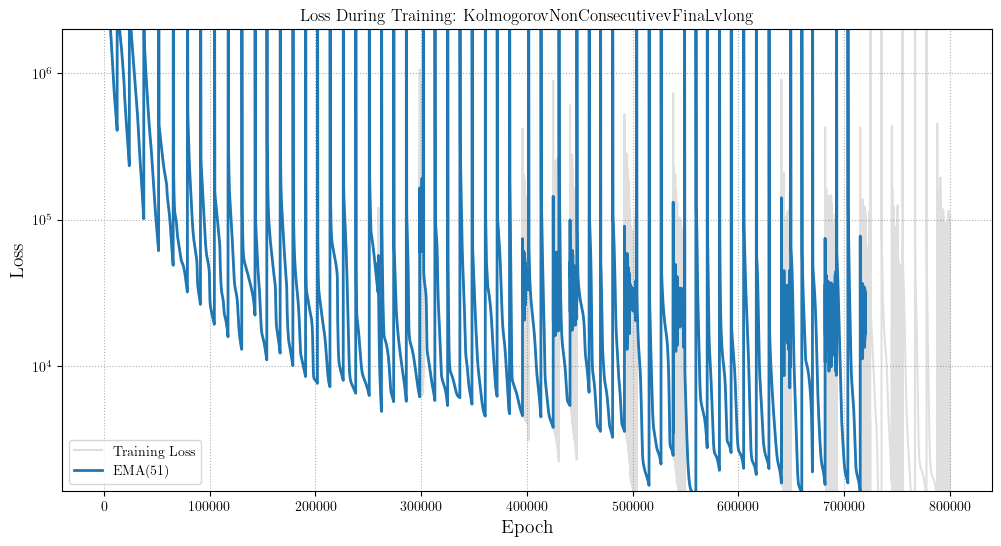

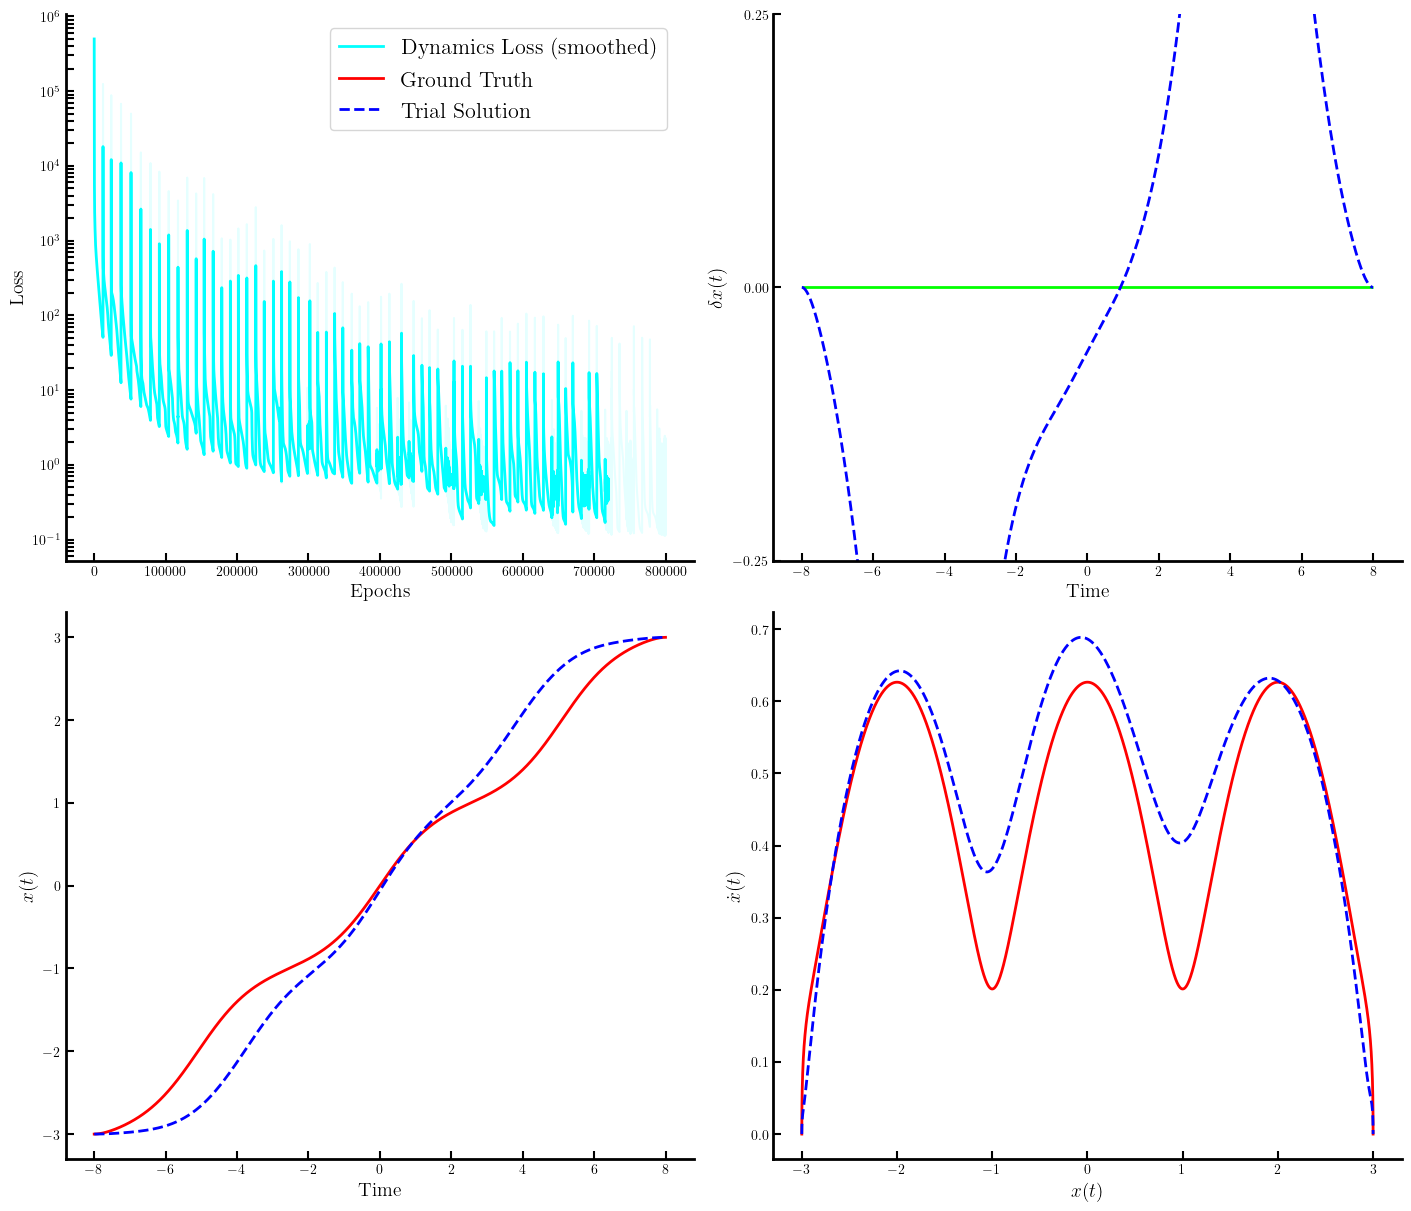

In [2]:
class KolmogorovNonConsecutive(FourthOrderEquations):

    def __init__(
        self,
        domain: Tuple[float, float],
        initial_conditions: Dict[str, Tuple[float, float]]
    ):
        super().__init__("x", domain, initial_conditions, boundary_type="dirichlet")

    # RHS of the ODE ----------------------------------------------------
    def equation(self, x, y, z, w, t):
        return 3*np.pi*z + np.pi*np.sin(np.pi*x)

    # Action-augmented loss --------------------------------------------
    def calculate_loss(self, t: th.Tensor, nn_out: Dict[str, th.Tensor]) -> th.Tensor:

        # trial solutions & derivatives
        trial  = self.calculate_trial_solution(t, nn_out)
        x, y, z, w = trial["x"], trial["y"], trial["z"], trial["w"]
        x4 = compute_derivative(t, w) 

        mse_d = th.nn.MSELoss(reduction='sum')
        mse_dyn = mse_d(x4, 3*np.pi*z + np.pi*th.sin(np.pi*x))

        #mask = (th.abs(t) > 2.5).view(-1)
        #if mask.any():
        #    strip_penalty = th.relu(2.0 - th.abs(x[mask]))**2
        #    L_strip = strip_penalty.sum()                   # scalar
        #else:
        #    L_strip = th.tensor(0.0, device=t.device)

        lagrangian = 0.5 * z**2 + (1.5)*np.pi*y**2 + 1 + th.cos(np.pi*x)
        action = th.trapz(lagrangian.view(-1), t.view(-1))

        t_idx_0 = (t - 0).abs().argmin()
        x0_pred = x[t_idx_0]
        target_x0 = 0

        neg_y_penalty = th.relu(-y)**2
        L_yneg = neg_y_penalty.sum()

        total = mse_dyn + action + 1000000*(x0_pred - target_x0)**2 + 1000000*L_yneg
        
        return {"total": total, "dynamics": mse_dyn, "hamiltonian": mse_dyn}

def main():
    lr_grid      = [5e-4]

    for lr in lr_grid:
            cfg = Configuration(
                seed=43365,
                features=[16, 16, 16],
                activation_function=th.nn.Tanh(),
                learning_rate=lr,
                epochs=800_000,
                steps=8_000,
            )

            system = KolmogorovNonConsecutive(
                domain=(-8, 8),
                initial_conditions={
                    "x": (-8, -3),   # x(-inf)
                    "y": (-8, 0),   # x'(.inf)
                    "z": (8, 3), # x(+inf)
                    "w": (8, 0), # x(+inf)
                }             # λ in the equation
            )

            model = Model(
                name="KolmogorovNonConsecutivevFinal_vlong",
                configuration=cfg,
                system_equations=system,
            )

            model.train()
            model.test4()


if __name__ == "__main__":
    main()

In [3]:
class KolmogorovConsecutive(FourthOrderEquations):

    def __init__(
        self,
        domain: Tuple[float, float],
        initial_conditions: Dict[str, Tuple[float, float]],
        boundary_type: str = "dirichlet"
    ):
        super().__init__("x", domain, initial_conditions, boundary_type="dirichlet")

    # RHS of the ODE ----------------------------------------------------
    def equation(self, x, y, z, w, t):
        return 3*np.pi*z + np.pi*np.sin(np.pi*x)

    # Action-augmented loss --------------------------------------------
    def calculate_loss(self, t: th.Tensor, nn_out: Dict[str, th.Tensor]) -> th.Tensor:

        # trial solutions & derivatives
        trial  = self.calculate_trial_solution(t, nn_out)
        x, y, z, w = trial["x"], trial["y"], trial["z"], trial["w"]
        x4 = compute_derivative(t, w) 

        mse_d = th.nn.MSELoss(reduction='sum')
        mse_dyn = mse_d(x4, 3*np.pi*z + np.pi*th.sin(np.pi*x))

        t_idx_0 = (t - 0).abs().argmin()
        x0_pred = x[t_idx_0]
        target_x0 = 0

        '''
        mask = (th.abs(t) > 2.5).view(-1)
        if mask.any():
            strip_penalty = th.relu(2.0 - th.abs(x[mask]))**2
            L_strip = strip_penalty.sum()                   # scalar
        else:
            L_strip = th.tensor(0.0, device=t.device)'''

        lagrangian = 0.5 * z**2 + (1.5)*np.pi*y**2 + 1 + th.cos(np.pi*x)
        action = th.trapz(lagrangian.view(-1), t.view(-1))

        total = mse_dyn + action + 1000000*(x0_pred - target_x0)**2

        return {"total": total, "dynamics": mse_dyn, "hamiltonian": mse_dyn}


cfg1 = Configuration(
    seed               = 43365,          # must match the training run
    features           = [16, 16, 16],
    activation_function= th.nn.Tanh(),
    learning_rate      = 1e-4,
    epochs             = 0,              # no training now
    steps              = 5000             # finer grid for the integral
)

system1 = KolmogorovConsecutive(
    domain = (-5, 5),
    initial_conditions = {
        "x": (-5, -1),
        "y": (-5,  0),
        "z": ( 5,  1),
        "w": ( 5,  0),
    }
)

model1 = Model("post", cfg1, system1)

# ------------------------------------------------------------------
# 2)  Load the saved weights ---------------------------------------
# ------------------------------------------------------------------
run_dir = r"Resultados_Finais_Considerados/KolmogorovConsecutivevFinal2/2025-06-05_08-55-04"   # <-- change!
model1.load(os.path.join(run_dir, "model_best.pt"),
            os.path.join(run_dir, "optimizer_best.pt"))
model1.model.eval()

t_grid = np.linspace(*system1.domain, cfg1.steps)
trial  = model1.eval(t_grid)              # {'x','y','z','w'}

# unpack & flatten
x = trial["x"].ravel()
y = trial["y"].ravel()
z = trial["z"].ravel()

lagrangian = 0.5*z**2 + 1.5*np.pi*y**2 + 1 + np.cos(np.pi*x)
action     = np.trapz(lagrangian, t_grid)

print(f"Renormalised action  A[-5,5] = {action:.6e}")

Renormalised action  A[-5,5] = 7.948021e+00


In [5]:
cfg2 = Configuration(
    seed               = 43365,          # must match the training run
    features           = [16, 16, 16],
    activation_function= th.nn.Tanh(),
    learning_rate      = 1e-4,
    epochs             = 0,              # no training now
    steps              = 40000             # finer grid for the integral
)

system2 = KolmogorovNonConsecutive(
    domain = (-5, 5),
    initial_conditions = {
        "x": (-5, -3),
        "y": (-5,  0),
        "z": ( 5,  3),
        "w": ( 5,  0),
    }
)

model2 = Model("post2", cfg2, system2)

# ------------------------------------------------------------------
# 2)  Load the saved weights ---------------------------------------
# ------------------------------------------------------------------
run_dir = r"data/Kolmogorob_try/2025-06-03_23-36-15"   # <-- change!
model2.load(os.path.join(run_dir, "model_best.pt"),
            os.path.join(run_dir, "optimizer_best.pt"))
model2.model.eval()

t_grid = np.linspace(*system2.domain, cfg2.steps)
trial  = model2.eval(t_grid)              # {'x','y','z','w'}

# unpack & flatten
x = trial["x"].ravel()
y = trial["y"].ravel()
z = trial["z"].ravel()

lagrangian = 0.5*z**2 + 1.5*np.pi*y**2 + 1 + np.cos(np.pi*x)
action     = np.trapz(lagrangian, t_grid)

print(f"Renormalised action  A[-5,5] = {action:.6e}")

Renormalised action  A[-5,5] = 2.713746e+01
